In [1]:
#Conda environment python 3.12.10 chronos_project
#Run as administrator

#pip install datasets
import datasets
import pandas as pd 
from IPython.display import display

#In Anaconda prompt: conda activate chronos_project\ conda install matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import math
#para exportar el environment : (dnlp_p) C:\Users\alejandrs>pip freeze > requirements.txt

#Database libraries
import torch
from chronos import BaseChronosPipeline
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
import random as rn

#!pip install seaborn
import seaborn as sns
from sklearn.model_selection import train_test_split

#Progress bar
from tqdm import tqdm
print(torch.__version__)
print(torch.version.cuda)

#Function file
from utils import functions as fc

c:\Users\alejandrs\anaconda3\envs\chronosEnv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.5.1
12.6


In [2]:
#from statsforecast.models import SeasonalNaive


# M4 dataset

The schema from the dataset follows the next structure: 

* Each dataset row corresponds to a single (univariate or multivariate) time series.

* There exists one column with name id and type string that contains the unique identifier of each time series.

* There exists one column of type Sequence with dtype timestamp[ms]. This column contains the timestamps of the observations. Timestamps are guaranteed to have a regular frequency that can be obtained with pandas.infer_freq.

* There exists at least one column of type Sequence with numeric (float, double, or int) dtype. These columns can be interpreted as target time series.

* For each row, all columns of type Sequence have same length. Remaining columns of types other than Sequence (e.g., string or float) can be interpreted as static covariates.

Database M4: 
This dataset is a collection of 100,000 time series used for the fourth edition of the Makridakis forecasting Competition. The M4 dataset consists of time series of yearly, quarterly, monthly and other (weekly, daily and hourly) data, which were used as part of the training corpus of the Chronos model.

https://paperswithcode.com/dataset/m4

In [3]:
def plot_timeseries_forecasting(historical_data, low, median, high, start_forecasting_date=-1,
                                prediction_interval = .8, prediction_length = 12,
                                figsize=(20,5)):
    years_data = historical_data.index
    start = pd.date_range(years_data[-1], periods=2, freq="MS")[-1] if start_forecasting_date == -1 else start_forecasting_date
    forecast_index = pd.date_range(start=start,
                                   periods=prediction_length, freq="MS")

    plt.figure(figsize=figsize)
    plt.plot(years_data, historical_data,
             color="royalblue", label="Historical data")
    plt.plot(forecast_index, median, color="tomato", label="Median forecast")
    plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3,
                     label=f"{prediction_interval * 100}% prediction interval")

    plt.axvline(x=start, color='gray', linestyle='--', linewidth=2)
    plt.legend()
    plt.grid()
    plt.show()

In [4]:
def get_errors_yr(df, frequ):
    data = TimeSeriesDataFrame.from_data_frame(df)

    #Sort the data before split
    data=data.sort_index(level="timestamp", ascending=True)
    print("---------data len" , len(data))

    #Predict the 20% initially
    prediction_length= int(math.ceil(len(data)*0.2))


    #Split training and testing
    train_data, test_data = data.train_test_split(prediction_length)
    #Test data contains both data: historical and forecast
    #train data contains just historical

    len_train = len(train_data)
    len_test = len(test_data)

    #prediction_length_percentage=[1,0.05,0.25,0.5,0.75]
    
    historical_remove_percentage=[0, 0.05,0.25,0.5,0.75]

    #Create results table 
    errors_df= pd.DataFrame(columns=["Train_size","Percentage_train", "Test_size", "Percentage_test", "MASE_error", "Diference_MASE", "WQL_error", "Diference_WQL"])
    row= 0

    display(errors_df)

    for j in historical_remove_percentage: 

        prediction_length= int(math.ceil(len(data)*0.2))
        
        #This is the Train data
        historical_length=round(len_train*(1-j))
        historical_length=int(round(len_train*(1-j)))
        print("----------historical length", historical_length)

        for i in range(0,len_test):

            if prediction_length<=0:
                break

            history  = train_data.iloc[-historical_length:]
            history  = history.sort_index() 
            print("-----------history len, min and max", len(history), history.index.min(), history.index.max())

            #Fit the models
            pred_wql, pred_mase= fc.fit_models(
                prediction_length=prediction_length,
                history=history,
                frequ=frequ)
    
            #Evaluate the models
            begining= len_train-historical_length
            print("---------beginning" , begining)

            total_length= begining+historical_length+prediction_length
            print("---------total_length", total_length)

            print("----------training len", len(history))
            print("----------training", history.tail(2))


            test_slide= test_data.iloc[begining:total_length, :]
            print("----------testing len", len(test_slide))
            print("----------testtt", test_slide.tail(prediction_length))

            predictions_wql = pred_wql.predict(history)
            predictions_wql.index = test_slide.iloc[-prediction_length:, :].index
            print("-----------len predictions", len(predictions_wql))

            display(predictions_wql)

            
            print("---len test slide", len(test_slide))
            display(test_slide.iloc[-prediction_length:,:])


            evaluation_metrics_WQL = pred_wql.evaluate(test_slide,
                                                       use_cache=False
                                                       )
            
            evaluation_metrics_MASE = pred_mase.evaluate(test_slide, 
                                                         use_cache=False
                                                         )

            #Add to the table
            errors_df = fc.update_table(
                errors_df,
                row,
                historical_length,
                f"{(1-j)*100}%",
                prediction_length,
                f"{i*100}%",
                evaluation_metrics_MASE["MASE"],
                evaluation_metrics_WQL["WQL"])
            row+=1

        
            prediction_length-=1
            print("----------prediction_length" , prediction_length)

    return errors_df

In [5]:
def get_errors(df, frequ):
    stop=False
    data = TimeSeriesDataFrame.from_data_frame(df)

    #Sort the data before split
    data=data.sort_index(level="timestamp", ascending=True)
    print("---------data len" , len(data))

    #Predict the 20% initially
    prediction_length_0= int(round(len(data)*0.2))

    #Split training and testing
    train_data, test_data = data.train_test_split(prediction_length_0)
    #Test data contains both data: historical and forecast
    #train data contains just historical

    len_train = len(train_data)
    len_test = len(test_data)

    prediction_length_percentage=[1,0.05,0.25,0.5,0.75]
    historical_remove_percentage=[0, 0.05,0.25,0.5,0.75]

    #Create results table 
    errors_df= pd.DataFrame(columns=["Train_size","Percentage_train", "Test_size", "Percentage_test", "MASE_error", "Diference_MASE", "WQL_error", "Diference_WQL"])
    row= 0

    display(errors_df)

    for j in historical_remove_percentage: 

        if stop==True: 
            break
        
        #This is the Train data
        historical_length=round(len_train*(1-j))
        historical_length=int(round(len_train*(1-j)))
        print("----------historical length", historical_length)

        for i in prediction_length_percentage:

            prediction_length=round(prediction_length_0*i)
            prediction_length=int(round(prediction_length_0*i))
            print("----------prediction_length" , prediction_length)

            if prediction_length==0: 
                stop=True
                break

            history  = train_data.iloc[-historical_length:]
            history  = history.sort_index() 
            print("-----------history len, min and max", len(history), history.index.min(), history.index.max())

            #Fit the models
            pred_wql, pred_mase= fc.fit_models(
                prediction_length=prediction_length,
                history=history,
                frequ=frequ)
    
            #Evaluate the models
            begining= len_train-historical_length
            print("---------beginning" , begining)

            total_length= begining+historical_length+prediction_length
            print("---------total_length", total_length)

            print("----------training len", len(history))
            print("----------training", history.tail(2))


            test_slide= test_data.iloc[begining:total_length, :]
            print("----------testing len", len(test_slide))
            print("----------testtt", test_slide.tail(prediction_length))

            predictions_wql = pred_wql.predict(history)
            predictions_wql.index = test_slide.iloc[-prediction_length:, :].index
            print("-----------len predictions", len(predictions_wql))

            display(predictions_wql)

            
            print("---len test slide", len(test_slide))
            display(test_slide.iloc[-prediction_length:,:])


            evaluation_metrics_WQL = pred_wql.evaluate(test_slide,
                                                       use_cache=False
                                                       )
            
            evaluation_metrics_MASE = pred_mase.evaluate(test_slide, 
                                                         use_cache=False
                                                         )

            #Add to the table
            errors_df = fc.update_table(
                errors_df,
                row,
                historical_length,
                f"{(1-j)*100}%",
                prediction_length,
                f"{i*100}%",
                evaluation_metrics_MASE["MASE"],
                evaluation_metrics_WQL["WQL"])
            row+=1
    return errors_df

In [6]:
ds = datasets.load_dataset("autogluon/chronos_datasets", "m4_daily", split="train")
ds.set_format("numpy")  # sequences returned as numpy arrays

In [7]:
print(ds)

Dataset({
    features: ['id', 'timestamp', 'target', 'category'],
    num_rows: 4227
})


In [8]:
print(ds.features)

{'id': Value(dtype='string', id=None), 'timestamp': Sequence(feature=Value(dtype='timestamp[ms]', id=None), length=-1, id=None), 'target': Sequence(feature=Value(dtype='float64', id=None), length=-1, id=None), 'category': Value(dtype='string', id=None)}


In [9]:
ds.set_format("numpy")  #sequences returned as numpy arrays

In [10]:
print(ds)

Dataset({
    features: ['id', 'timestamp', 'target', 'category'],
    num_rows: 4227
})


In [11]:
ds[600]

{'id': 'T000600',
 'timestamp': array(['2012-03-30T12:00:00.000', '2012-03-31T12:00:00.000',
        '2012-04-01T12:00:00.000', ..., '2016-03-10T12:00:00.000',
        '2016-03-11T12:00:00.000', '2016-03-12T12:00:00.000'],
       dtype='datetime64[ms]'),
 'target': array([2668.89, 2675.19, 2713.79, ..., 1294.4 , 1262.09, 1270.44],
       dtype=float32),
 'category': 'Micro'}

In [12]:
def to_pandas(ds: datasets.Dataset) -> "pd.DataFrame":
    """Convert dataset to long data frame format."""
    sequence_columns = [col for col in ds.features if isinstance(ds.features[col], datasets.Sequence)]
    return ds.to_pandas().explode(sequence_columns).infer_objects()


In [13]:
m4_df= to_pandas(ds)

## EDA

In [14]:
m4_df.head(10)

id           timestamp  target category
0  T000000 1994-03-01 12:00:00  1017.1    Macro
0  T000000 1994-03-02 12:00:00  1019.3    Macro
0  T000000 1994-03-03 12:00:00  1017.0    Macro
0  T000000 1994-03-04 12:00:00  1019.2    Macro
0  T000000 1994-03-05 12:00:00  1018.7    Macro
0  T000000 1994-03-06 12:00:00  1015.6    Macro
0  T000000 1994-03-07 12:00:00  1018.5    Macro
0  T000000 1994-03-08 12:00:00  1018.3    Macro
0  T000000 1994-03-09 12:00:00  1018.4    Macro
0  T000000 1994-03-10 12:00:00  1021.5    Macro

In [15]:
m4_df.dtypes 
#The datatype od the timestamp is adequate just as target

id                   object
timestamp    datetime64[ns]
target              float64
category             object
dtype: object

In [16]:
m4_df.describe(include="all")

id                      timestamp        target  category
count   10023836                       10023836  1.002384e+07  10023836
unique      4227                            NaN           NaN         6
top      T004098                            NaN           NaN   Finance
freq        9933                            NaN           NaN   5088053
mean         NaN  2006-12-26 02:30:14.423939328  5.691850e+03       NaN
min          NaN            1906-06-19 12:00:00  1.500000e+01       NaN
25%          NaN            2004-07-19 12:00:00  1.518050e+03       NaN
50%          NaN            2007-10-26 12:00:00  5.230500e+03       NaN
75%          NaN            2010-10-16 12:00:00  9.003000e+03       NaN
max          NaN            2017-11-16 12:00:00  3.520000e+05       NaN
std          NaN                            NaN  4.246910e+03       NaN

In [17]:
m4_df.category.unique()

array(['Macro', 'Micro', 'Demographic', 'Industry', 'Finance', 'Other'],
      dtype=object)

In [18]:
m4_df["category"].value_counts()

category
Finance        5088053
Micro          4323958
Other           250463
Industry        236411
Macro            84520
Demographic      40431
Name: count, dtype: int64

In [19]:
#Verify which type is the category column different to Object
m4_df["category"].dtype

dtype('O')

In [20]:
# Convert the "category" column to string type
m4_df["category"] = m4_df["category"].astype("string")
# Verify the new data type
print(m4_df["category"].dtype)

string


In [21]:
#Which is the type of the id column
m4_df["id"].dtype

dtype('O')

In [22]:
m4_df["id"] = m4_df["id"].astype("string")
print(m4_df["id"].dtype)

string


In [23]:
#We are going to work with the categories: "Finance", "Demography" and "Industry"
df_Finance = m4_df[m4_df["category"] == "Finance"]
df_Demography = m4_df[m4_df["category"] == "Demographic"]
df_Industry = m4_df[m4_df["category"] == "Industry"]

## Finance dataset

In [24]:
df_Finance.head(10)

id           timestamp   target category
2035  T002035 2005-01-04 12:00:00  2785.00  Finance
2035  T002035 2005-01-05 12:00:00  2780.30  Finance
2035  T002035 2005-01-06 12:00:00  2780.30  Finance
2035  T002035 2005-01-07 12:00:00  2780.30  Finance
2035  T002035 2005-01-08 12:00:00  2780.10  Finance
2035  T002035 2005-01-09 12:00:00  2785.00  Finance
2035  T002035 2005-01-10 12:00:00  2777.20  Finance
2035  T002035 2005-01-11 12:00:00  2778.30  Finance
2035  T002035 2005-01-12 12:00:00  2782.17  Finance
2035  T002035 2005-01-13 12:00:00  2787.55  Finance

In [25]:
#Check fot nulls in the target column
df_Finance["target"].isnull().sum()

0

In [26]:
df_Finance["id"].unique()

<StringArray>
['T002035', 'T002036', 'T002037', 'T002038', 'T002039', 'T002040', 'T002041',
 'T002042', 'T002043', 'T002044',
 ...
 'T003584', 'T003585', 'T003586', 'T003587', 'T003588', 'T003589', 'T003590',
 'T003591', 'T003592', 'T003593']
Length: 1559, dtype: string

In [27]:
df_Finance.groupby("id").size().reset_index(name="counts").sort_values(by="counts", ascending=False).head(10)

id  counts
11    T002046    8533
158   T002193    7856
8     T002043    4329
1558  T003593    4211
1048  T003083    4211
581   T002616    4211
582   T002617    4211
583   T002618    4211
1062  T003097    4211
1061  T003096    4211

In [28]:
df_Finance.shape

(5088053, 4)

In [29]:
df_Finance.index = pd.to_datetime(df_Finance.timestamp)

In [30]:
df_Finance[df_Finance["id"]=="T002046"]["timestamp"].describe()


count                   8533
mean     1995-08-17 12:00:00
min      1983-12-12 12:00:00
25%      1989-10-14 12:00:00
50%      1995-08-17 12:00:00
75%      2001-06-19 12:00:00
max      2007-04-22 12:00:00
Name: timestamp, dtype: object

In [31]:
df_Finance_1=df_Finance[df_Finance["id"]=="T002046"]

In [32]:
df_Finance_1 = df_Finance_1.drop(columns=["category"]).sort_index(ascending=True)
df_Finance_1.head(10)

id           timestamp  target
timestamp                                               
1983-12-12 12:00:00  T002046 1983-12-12 12:00:00  7324.4
1983-12-13 12:00:00  T002046 1983-12-13 12:00:00  7201.7
1983-12-14 12:00:00  T002046 1983-12-14 12:00:00  7196.4
1983-12-15 12:00:00  T002046 1983-12-15 12:00:00  7177.0
1983-12-16 12:00:00  T002046 1983-12-16 12:00:00  7140.6
1983-12-17 12:00:00  T002046 1983-12-17 12:00:00  7005.5
1983-12-18 12:00:00  T002046 1983-12-18 12:00:00  7034.2
1983-12-19 12:00:00  T002046 1983-12-19 12:00:00  7124.0
1983-12-20 12:00:00  T002046 1983-12-20 12:00:00  7196.8
1983-12-21 12:00:00  T002046 1983-12-21 12:00:00  7196.8

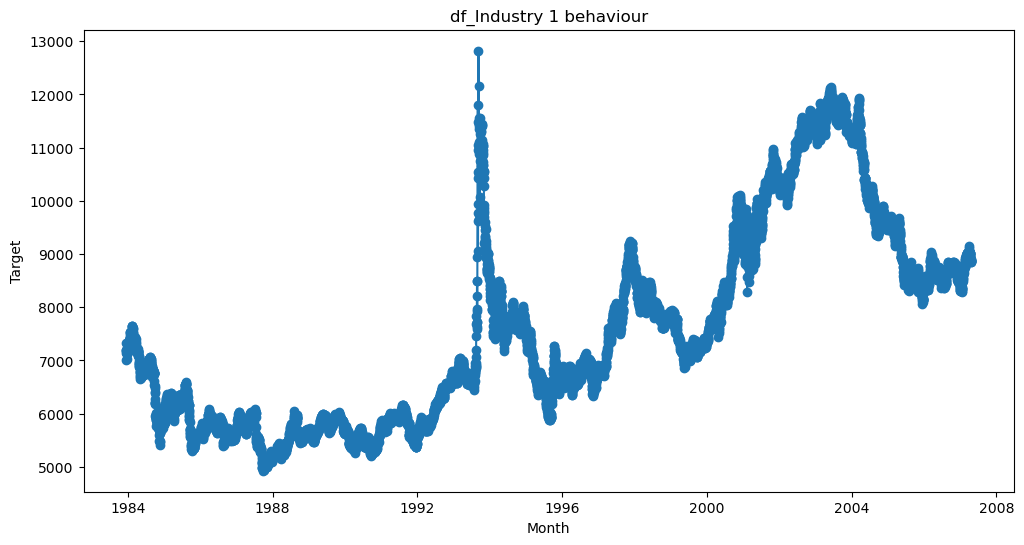

In [33]:
plt.figure(figsize=(12, 6))
plt.plot(df_Finance_1.index, df_Finance_1["target"], marker="o")
plt.title("df_Industry 1 behaviour")
plt.xlabel("Month")
plt.ylabel("Target")
plt.show()

The behaviour of this time series is has strong changes in its data, it could belong to stock exchange

In [34]:
#Verify if the timestamp is complete and continuous
start_date = df_Finance_1.index.min()
print("Start date:", start_date)
end_date = df_Finance_1.index.max()
print("End date:", end_date)

Start date: 1983-12-12 12:00:00
End date: 2007-04-22 12:00:00


In [35]:
complete_date_range = pd.date_range(start=start_date, end=end_date, freq="D")

In [36]:
missing_dates = complete_date_range.difference(df_Finance_1.index)
print("Missing dates:", missing_dates)
#The timeseries is continues and complete, so we can work with it.

Missing dates: DatetimeIndex([], dtype='datetime64[ns]', freq='D')


In [37]:
len(missing_dates)

0

In [38]:
df_Finance_1.rename(columns={"id": "item_id"}, inplace=True)

In [39]:
errors_B_Finance=get_errors(df_Finance_1, frequ="B")

---------data len 8533


Empty DataFrame
Columns: [Train_size, Percentage_train, Test_size, Percentage_test, MASE_error, Diference_MASE, WQL_error, Diference_WQL]
Index: []

----------historical length 6826
----------prediction_length 1707
-----------history len, min and max 6826 ('T002046', Timestamp('1983-12-12 12:00:00')) ('T002046', Timestamp('2002-08-19 12:00:00'))


Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_192255'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.22 GB / 7.37 GB (2.9%)
Disk Space Avail:   4.40 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 1707,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'tar

---------beginning 0
---------total_length 8533
----------training len 6826
----------training                               target
item_id timestamp                   
T002046 2002-08-18 12:00:00  11576.9
        2002-08-19 12:00:00  11553.1
----------testing len 8533
----------testtt                               target
item_id timestamp                   
T002046 2002-08-20 12:00:00  11468.9
        2002-08-21 12:00:00  11329.1
        2002-08-22 12:00:00  11260.2
        2002-08-23 12:00:00  11197.4
        2002-08-24 12:00:00  11124.0
...                              ...
        2007-04-18 12:00:00   8862.1
        2007-04-19 12:00:00   8849.8
        2007-04-20 12:00:00   8870.6
        2007-04-21 12:00:00   8881.3
        2007-04-22 12:00:00   8874.1

[1707 rows x 1 columns]


Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]


-----------len predictions 1707


mean           0.1           0.2  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11575.435547  11348.966797  11431.652344   
        2002-08-21 12:00:00  11596.361328  11348.980469  11445.416016   
        2002-08-22 12:00:00  11608.603516  11328.038086  11436.683594   
        2002-08-23 12:00:00  11626.145508  11329.412109  11442.312500   
        2002-08-24 12:00:00  11635.399414  11326.431641  11444.176758   
...                                   ...           ...           ...   
        2007-04-18 12:00:00  11352.887695  11311.653320  11334.856445   
        2007-04-19 12:00:00  11352.290039  11310.971680  11333.698242   
        2007-04-20 12:00:00  11347.435547  11305.186523  11329.541016   
        2007-04-21 12:00:00  11351.272461  11304.500000  11331.414062   
        2007-04-22 12:00:00  11350.072266  11305.493164  11330.417969   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11488.953125  11535.695312  11575.435547   
        2002-08-21 12:00:00  11506.084961  11554.205078  11596.361328   
        2002-08-22 12:00:00  11506.402344  11559.630859  11608.603516   
        2002-08-23 12:00:00  11514.101562  11572.019531  11626.145508   
        2002-08-24 12:00:00  11519.127930  11580.358398  11635.399414   
...                                   ...           ...           ...   
        2007-04-18 12:00:00  11343.241211  11348.492188  11352.887695   
        2007-04-19 12:00:00  11342.209961  11347.306641  11352.290039   
        2007-04-20 12:00:00  11338.217773  11343.083984  11347.435547   
        2007-04-21 12:00:00  11340.073242  11345.473633  11351.272461   
        2007-04-22 12:00:00  11339.523438  11345.621094  11350.072266   

                                      0.6           0.7           0.8  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11613.019531  11653.423828  11702.492188   
        2002-08-21 12:00:00  11641.333008  11685.240234  11734.541992   
        2002-08-22 12:00:00  11655.267578  11701.321289  11756.541016   
        2002-08-23 12:00:00  11676.568359  11729.644531  11790.596680   
        2002-08-24 12:00:00  11689.936523  11742.794922  11808.749023   
...                                   ...           ...           ...   
        2007-04-18 12:00:00  11359.250000  11365.832031  11372.981445   
        2007-04-19 12:00:00  11357.841797  11365.124023  11373.830078   
        2007-04-20 12:00:00  11352.294922  11359.110352  11368.443359   
        2007-04-21 12:00:00  11356.702148  11364.750000  11372.640625   
        2007-04-22 12:00:00  11355.344727  11362.429688  11372.056641   

                                      0.9  
item_id timestamp                          
T002046 2002-08-20 12:00:00  11784.530273  
        2002-08-21 12:00:00  11822.367188  
        2002-08-22 12:00:00  11846.402344  
        2002-08-23 12:00:00  11887.840820  
        2002-08-24 12:00:00  11911.041992  
...                                   ...  
        2007-04-18 12:00:00  11383.840820  
        2007-04-19 12:00:00  11384.367188  
        2007-04-20 12:00:00  11380.364258  
        2007-04-21 12:00:00  11387.422852  
        2007-04-22 12:00:00  11385.498047  

[1707 rows x 10 columns]

---len test slide 8533


target
item_id timestamp                   
T002046 2002-08-20 12:00:00  11468.9
        2002-08-21 12:00:00  11329.1
        2002-08-22 12:00:00  11260.2
        2002-08-23 12:00:00  11197.4
        2002-08-24 12:00:00  11124.0
...                              ...
        2007-04-18 12:00:00   8862.1
        2007-04-19 12:00:00   8849.8
        2007-04-20 12:00:00   8870.6
        2007-04-21 12:00:00   8881.3
        2007-04-22 12:00:00   8874.1

[1707 rows x 1 columns]

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_192350'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.53 GB / 7.37 GB (7.1%)
Disk Space Avail:   4.39 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric

----------prediction_length 85
-----------history len, min and max 6826 ('T002046', Timestamp('1983-12-12 12:00:00')) ('T002046', Timestamp('2002-08-19 12:00:00'))


Provided train_data has 4876 rows, 1 time series. Median time series length is 4876 (min=4876, max=4876). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 21:23:52
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.03    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.10 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_192352'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Ve

---------beginning 0
---------total_length 6911
----------training len 6826
----------training                               target
item_id timestamp                   
T002046 2002-08-18 12:00:00  11576.9
        2002-08-19 12:00:00  11553.1
----------testing len 6911
----------testtt                               target
item_id timestamp                   
T002046 2002-08-20 12:00:00  11468.9
        2002-08-21 12:00:00  11329.1
        2002-08-22 12:00:00  11260.2
        2002-08-23 12:00:00  11197.4
        2002-08-24 12:00:00  11124.0
...                              ...
        2002-11-08 12:00:00  11680.4
        2002-11-09 12:00:00  11652.8
        2002-11-10 12:00:00  11670.8
        2002-11-11 12:00:00  11639.0
        2002-11-12 12:00:00  11565.4

[85 rows x 1 columns]


Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]


-----------len predictions 85


mean           0.1           0.2  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11575.435547  11348.966797  11431.652344   
        2002-08-21 12:00:00  11596.361328  11348.980469  11445.416016   
        2002-08-22 12:00:00  11608.603516  11328.038086  11436.683594   
        2002-08-23 12:00:00  11626.145508  11329.412109  11442.312500   
        2002-08-24 12:00:00  11635.399414  11326.431641  11444.176758   
...                                   ...           ...           ...   
        2002-11-08 12:00:00  11623.800781  11207.958984  11378.591797   
        2002-11-09 12:00:00  11635.466797  11199.914062  11374.172852   
        2002-11-10 12:00:00  11633.382812  11184.382812  11366.691406   
        2002-11-11 12:00:00  11621.330078  11157.067383  11342.075195   
        2002-11-12 12:00:00  11599.588867  11126.339844  11318.511719   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11488.953125  11535.695312  11575.435547   
        2002-08-21 12:00:00  11506.084961  11554.205078  11596.361328   
        2002-08-22 12:00:00  11506.402344  11559.630859  11608.603516   
        2002-08-23 12:00:00  11514.101562  11572.019531  11626.145508   
        2002-08-24 12:00:00  11519.127930  11580.358398  11635.399414   
...                                   ...           ...           ...   
        2002-11-08 12:00:00  11478.517578  11555.958984  11623.800781   
        2002-11-09 12:00:00  11482.278320  11562.308594  11635.466797   
        2002-11-10 12:00:00  11475.441406  11556.398438  11633.382812   
        2002-11-11 12:00:00  11451.770508  11540.791016  11621.330078   
        2002-11-12 12:00:00  11429.751953  11519.460938  11599.588867   

                                      0.6           0.7           0.8  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11613.019531  11653.423828  11702.492188   
        2002-08-21 12:00:00  11641.333008  11685.240234  11734.541992   
        2002-08-22 12:00:00  11655.267578  11701.321289  11756.541016   
        2002-08-23 12:00:00  11676.568359  11729.644531  11790.596680   
        2002-08-24 12:00:00  11689.936523  11742.794922  11808.749023   
...                                   ...           ...           ...   
        2002-11-08 12:00:00  11692.113281  11766.837891  11865.688477   
        2002-11-09 12:00:00  11710.757812  11788.138672  11883.916992   
        2002-11-10 12:00:00  11709.586914  11786.069336  11885.607422   
        2002-11-11 12:00:00  11697.277344  11782.341797  11881.583008   
        2002-11-12 12:00:00  11679.671875  11760.840820  11862.666992   

                                      0.9  
item_id timestamp                          
T002046 2002-08-20 12:00:00  11784.530273  
        2002-08-21 12:00:00  11822.367188  
        2002-08-22 12:00:00  11846.402344  
        2002-08-23 12:00:00  11887.840820  
        2002-08-24 12:00:00  11911.041992  
...                                   ...  
        2002-11-08 12:00:00  12008.636719  
        2002-11-09 12:00:00  12038.513672  
        2002-11-10 12:00:00  12043.548828  
        2002-11-11 12:00:00  12045.014648  
        2002-11-12 12:00:00  12031.068359  

[85 rows x 10 columns]

---len test slide 6911


target
item_id timestamp                   
T002046 2002-08-20 12:00:00  11468.9
        2002-08-21 12:00:00  11329.1
        2002-08-22 12:00:00  11260.2
        2002-08-23 12:00:00  11197.4
        2002-08-24 12:00:00  11124.0
...                              ...
        2002-11-08 12:00:00  11680.4
        2002-11-09 12:00:00  11652.8
        2002-11-10 12:00:00  11670.8
        2002-11-11 12:00:00  11639.0
        2002-11-12 12:00:00  11565.4

[85 rows x 1 columns]

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_192404'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       1.00 GB / 7.37 GB (13.6%)
Disk Space Avail:   4.39 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metri

----------prediction_length 427
-----------history len, min and max 6826 ('T002046', Timestamp('1983-12-12 12:00:00')) ('T002046', Timestamp('2002-08-19 12:00:00'))


Provided train_data has 4876 rows, 1 time series. Median time series length is 4876 (min=4876, max=4876). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 21:24:04
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.03 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_192405'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Ve

---------beginning 0
---------total_length 7253
----------training len 6826
----------training                               target
item_id timestamp                   
T002046 2002-08-18 12:00:00  11576.9
        2002-08-19 12:00:00  11553.1
----------testing len 7253
----------testtt                               target
item_id timestamp                   
T002046 2002-08-20 12:00:00  11468.9
        2002-08-21 12:00:00  11329.1
        2002-08-22 12:00:00  11260.2
        2002-08-23 12:00:00  11197.4
        2002-08-24 12:00:00  11124.0
...                              ...
        2003-10-16 12:00:00  11594.8
        2003-10-17 12:00:00  11665.3
        2003-10-18 12:00:00  11690.4
        2003-10-19 12:00:00  11658.3
        2003-10-20 12:00:00  11794.5

[427 rows x 1 columns]
-----------len predictions 427


mean           0.1           0.2  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11575.435547  11348.966797  11431.652344   
        2002-08-21 12:00:00  11596.361328  11348.980469  11445.416016   
        2002-08-22 12:00:00  11608.603516  11328.038086  11436.683594   
        2002-08-23 12:00:00  11626.145508  11329.412109  11442.312500   
        2002-08-24 12:00:00  11635.399414  11326.431641  11444.176758   
...                                   ...           ...           ...   
        2003-10-16 12:00:00  11273.085938  10911.140625  11071.687500   
        2003-10-17 12:00:00  11274.693359  10908.722656  11065.832031   
        2003-10-18 12:00:00  11268.649414  10894.385742  11056.149414   
        2003-10-19 12:00:00  11281.875977  10891.196289  11063.965820   
        2003-10-20 12:00:00  11279.710938  10887.718750  11057.974609   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11488.953125  11535.695312  11575.435547   
        2002-08-21 12:00:00  11506.084961  11554.205078  11596.361328   
        2002-08-22 12:00:00  11506.402344  11559.630859  11608.603516   
        2002-08-23 12:00:00  11514.101562  11572.019531  11626.145508   
        2002-08-24 12:00:00  11519.127930  11580.358398  11635.399414   
...                                   ...           ...           ...   
        2003-10-16 12:00:00  11153.583984  11217.023438  11273.085938   
        2003-10-17 12:00:00  11149.867188  11212.547852  11274.693359   
        2003-10-18 12:00:00  11144.851562  11210.129883  11268.649414   
        2003-10-19 12:00:00  11149.001953  11218.591797  11281.875977   
        2003-10-20 12:00:00  11150.548828  11221.959961  11279.710938   

                                      0.6           0.7           0.8  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11613.019531  11653.423828  11702.492188   
        2002-08-21 12:00:00  11641.333008  11685.240234  11734.541992   
        2002-08-22 12:00:00  11655.267578  11701.321289  11756.541016   
        2002-08-23 12:00:00  11676.568359  11729.644531  11790.596680   
        2002-08-24 12:00:00  11689.936523  11742.794922  11808.749023   
...                                   ...           ...           ...   
        2003-10-16 12:00:00  11326.738281  11377.207031  11432.155273   
        2003-10-17 12:00:00  11329.475586  11383.244141  11445.593750   
        2003-10-18 12:00:00  11321.321289  11375.529297  11442.596680   
        2003-10-19 12:00:00  11337.521484  11395.013672  11457.074219   
        2003-10-20 12:00:00  11339.260742  11397.217773  11465.320312   

                                      0.9  
item_id timestamp                          
T002046 2002-08-20 12:00:00  11784.530273  
        2002-08-21 12:00:00  11822.367188  
        2002-08-22 12:00:00  11846.402344  
        2002-08-23 12:00:00  11887.840820  
        2002-08-24 12:00:00  11911.041992  
...                                   ...  
        2003-10-16 12:00:00  11523.025391  
        2003-10-17 12:00:00  11538.079102  
        2003-10-18 12:00:00  11539.161133  
        2003-10-19 12:00:00  11564.200195  
        2003-10-20 12:00:00  11564.705078  

[427 rows x 10 columns]

---len test slide 7253


target
item_id timestamp                   
T002046 2002-08-20 12:00:00  11468.9
        2002-08-21 12:00:00  11329.1
        2002-08-22 12:00:00  11260.2
        2002-08-23 12:00:00  11197.4
        2002-08-24 12:00:00  11124.0
...                              ...
        2003-10-16 12:00:00  11594.8
        2003-10-17 12:00:00  11665.3
        2003-10-18 12:00:00  11690.4
        2003-10-19 12:00:00  11658.3
        2003-10-20 12:00:00  11794.5

[427 rows x 1 columns]

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_192414'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.39 GB / 7.37 GB (5.3%)
Disk Space Avail:   4.39 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric

----------prediction_length 854
-----------history len, min and max 6826 ('T002046', Timestamp('1983-12-12 12:00:00')) ('T002046', Timestamp('2002-08-19 12:00:00'))


Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.03 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_192415'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.38 GB / 7.37 GB (5.1%)
Disk Space Avail:   4.39 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 854,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0

---------beginning 0
---------total_length 7680
----------training len 6826
----------training                               target
item_id timestamp                   
T002046 2002-08-18 12:00:00  11576.9
        2002-08-19 12:00:00  11553.1
----------testing len 7680
----------testtt                               target
item_id timestamp                   
T002046 2002-08-20 12:00:00  11468.9
        2002-08-21 12:00:00  11329.1
        2002-08-22 12:00:00  11260.2
        2002-08-23 12:00:00  11197.4
        2002-08-24 12:00:00  11124.0
...                              ...
        2004-12-16 12:00:00   9489.1
        2004-12-17 12:00:00   9469.7
        2004-12-18 12:00:00   9459.3
        2004-12-19 12:00:00   9486.6
        2004-12-20 12:00:00   9466.8

[854 rows x 1 columns]
-----------len predictions 854


mean           0.1           0.2  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11575.435547  11348.966797  11431.652344   
        2002-08-21 12:00:00  11596.361328  11348.980469  11445.416016   
        2002-08-22 12:00:00  11608.603516  11328.038086  11436.683594   
        2002-08-23 12:00:00  11626.145508  11329.412109  11442.312500   
        2002-08-24 12:00:00  11635.399414  11326.431641  11444.176758   
...                                   ...           ...           ...   
        2004-12-16 12:00:00  10962.102539  10836.185547  10891.278320   
        2004-12-17 12:00:00  10955.205078  10829.253906  10886.790039   
        2004-12-18 12:00:00  10958.755859  10830.642578  10887.404297   
        2004-12-19 12:00:00  10952.417969  10822.661133  10885.233398   
        2004-12-20 12:00:00  10961.593750  10823.016602  10888.975586   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11488.953125  11535.695312  11575.435547   
        2002-08-21 12:00:00  11506.084961  11554.205078  11596.361328   
        2002-08-22 12:00:00  11506.402344  11559.630859  11608.603516   
        2002-08-23 12:00:00  11514.101562  11572.019531  11626.145508   
        2002-08-24 12:00:00  11519.127930  11580.358398  11635.399414   
...                                   ...           ...           ...   
        2004-12-16 12:00:00  10921.499023  10942.148438  10962.102539   
        2004-12-17 12:00:00  10916.534180  10936.642578  10955.205078   
        2004-12-18 12:00:00  10914.713867  10936.411133  10958.755859   
        2004-12-19 12:00:00  10913.597656  10933.831055  10952.417969   
        2004-12-20 12:00:00  10922.080078  10942.864258  10961.593750   

                                      0.6           0.7           0.8  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11613.019531  11653.423828  11702.492188   
        2002-08-21 12:00:00  11641.333008  11685.240234  11734.541992   
        2002-08-22 12:00:00  11655.267578  11701.321289  11756.541016   
        2002-08-23 12:00:00  11676.568359  11729.644531  11790.596680   
        2002-08-24 12:00:00  11689.936523  11742.794922  11808.749023   
...                                   ...           ...           ...   
        2004-12-16 12:00:00  10982.040039  11001.556641  11020.032227   
        2004-12-17 12:00:00  10973.662109  10992.640625  11011.410156   
        2004-12-18 12:00:00  10976.721680  10996.238281  11015.581055   
        2004-12-19 12:00:00  10973.513672  10990.175781  11012.083984   
        2004-12-20 12:00:00  10981.377930  11001.283203  11020.756836   

                                      0.9  
item_id timestamp                          
T002046 2002-08-20 12:00:00  11784.530273  
        2002-08-21 12:00:00  11822.367188  
        2002-08-22 12:00:00  11846.402344  
        2002-08-23 12:00:00  11887.840820  
        2002-08-24 12:00:00  11911.041992  
...                                   ...  
        2004-12-16 12:00:00  11050.936523  
        2004-12-17 12:00:00  11040.148438  
        2004-12-18 12:00:00  11048.486328  
        2004-12-19 12:00:00  11042.192383  
        2004-12-20 12:00:00  11045.753906  

[854 rows x 10 columns]

---len test slide 7680


target
item_id timestamp                   
T002046 2002-08-20 12:00:00  11468.9
        2002-08-21 12:00:00  11329.1
        2002-08-22 12:00:00  11260.2
        2002-08-23 12:00:00  11197.4
        2002-08-24 12:00:00  11124.0
...                              ...
        2004-12-16 12:00:00   9489.1
        2004-12-17 12:00:00   9469.7
        2004-12-18 12:00:00   9459.3
        2004-12-19 12:00:00   9486.6
        2004-12-20 12:00:00   9466.8

[854 rows x 1 columns]

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_192423'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.54 GB / 7.37 GB (7.3%)
Disk Space Avail:   4.39 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric

----------prediction_length 1280
-----------history len, min and max 6826 ('T002046', Timestamp('1983-12-12 12:00:00')) ('T002046', Timestamp('2002-08-19 12:00:00'))


Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.04 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_192424'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.53 GB / 7.37 GB (7.2%)
Disk Space Avail:   4.39 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'predi

---------beginning 0
---------total_length 8106
----------training len 6826
----------training                               target
item_id timestamp                   
T002046 2002-08-18 12:00:00  11576.9
        2002-08-19 12:00:00  11553.1
----------testing len 8106
----------testtt                               target
item_id timestamp                   
T002046 2002-08-20 12:00:00  11468.9
        2002-08-21 12:00:00  11329.1
        2002-08-22 12:00:00  11260.2
        2002-08-23 12:00:00  11197.4
        2002-08-24 12:00:00  11124.0
...                              ...
        2006-02-15 12:00:00   8491.4
        2006-02-16 12:00:00   8533.8
        2006-02-17 12:00:00   8559.4
        2006-02-18 12:00:00   8613.4
        2006-02-19 12:00:00   8608.9

[1280 rows x 1 columns]
-----------len predictions 1280


mean           0.1           0.2  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11575.435547  11348.966797  11431.652344   
        2002-08-21 12:00:00  11596.361328  11348.980469  11445.416016   
        2002-08-22 12:00:00  11608.603516  11328.038086  11436.683594   
        2002-08-23 12:00:00  11626.145508  11329.412109  11442.312500   
        2002-08-24 12:00:00  11635.399414  11326.431641  11444.176758   
...                                   ...           ...           ...   
        2006-02-15 12:00:00  11131.615234  10939.946289  11035.909180   
        2006-02-16 12:00:00  11136.446289  10938.007812  11033.806641   
        2006-02-17 12:00:00  11135.485352  10933.443359  11032.010742   
        2006-02-18 12:00:00  11126.277344  10925.179688  11022.289062   
        2006-02-19 12:00:00  11128.000977  10914.507812  11019.736328   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11488.953125  11535.695312  11575.435547   
        2002-08-21 12:00:00  11506.084961  11554.205078  11596.361328   
        2002-08-22 12:00:00  11506.402344  11559.630859  11608.603516   
        2002-08-23 12:00:00  11514.101562  11572.019531  11626.145508   
        2002-08-24 12:00:00  11519.127930  11580.358398  11635.399414   
...                                   ...           ...           ...   
        2006-02-15 12:00:00  11079.160156  11106.725586  11131.615234   
        2006-02-16 12:00:00  11077.451172  11108.880859  11136.446289   
        2006-02-17 12:00:00  11078.955078  11108.424805  11135.485352   
        2006-02-18 12:00:00  11070.125000  11099.125977  11126.277344   
        2006-02-19 12:00:00  11067.705078  11101.129883  11128.000977   

                                      0.6           0.7           0.8  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11613.019531  11653.423828  11702.492188   
        2002-08-21 12:00:00  11641.333008  11685.240234  11734.541992   
        2002-08-22 12:00:00  11655.267578  11701.321289  11756.541016   
        2002-08-23 12:00:00  11676.568359  11729.644531  11790.596680   
        2002-08-24 12:00:00  11689.936523  11742.794922  11808.749023   
...                                   ...           ...           ...   
        2006-02-15 12:00:00  11156.144531  11184.849609  11222.623047   
        2006-02-16 12:00:00  11162.230469  11194.063477  11235.815430   
        2006-02-17 12:00:00  11163.994141  11195.833984  11237.108398   
        2006-02-18 12:00:00  11154.122070  11184.898438  11225.888672   
        2006-02-19 12:00:00  11154.643555  11186.861328  11230.093750   

                                      0.9  
item_id timestamp                          
T002046 2002-08-20 12:00:00  11784.530273  
        2002-08-21 12:00:00  11822.367188  
        2002-08-22 12:00:00  11846.402344  
        2002-08-23 12:00:00  11887.840820  
        2002-08-24 12:00:00  11911.041992  
...                                   ...  
        2006-02-15 12:00:00  11287.603516  
        2006-02-16 12:00:00  11304.673828  
        2006-02-17 12:00:00  11303.032227  
        2006-02-18 12:00:00  11287.459961  
        2006-02-19 12:00:00  11294.272461  

[1280 rows x 10 columns]

---len test slide 8106


target
item_id timestamp                   
T002046 2002-08-20 12:00:00  11468.9
        2002-08-21 12:00:00  11329.1
        2002-08-22 12:00:00  11260.2
        2002-08-23 12:00:00  11197.4
        2002-08-24 12:00:00  11124.0
...                              ...
        2006-02-15 12:00:00   8491.4
        2006-02-16 12:00:00   8533.8
        2006-02-17 12:00:00   8559.4
        2006-02-18 12:00:00   8613.4
        2006-02-19 12:00:00   8608.9

[1280 rows x 1 columns]

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_192432'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.65 GB / 7.37 GB (8.9%)
Disk Space Avail:   4.39 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric

----------historical length 6485
----------prediction_length 1707
-----------history len, min and max 6485 ('T002046', Timestamp('1984-11-17 12:00:00')) ('T002046', Timestamp('2002-08-19 12:00:00'))


Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 1707,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

train_data with frequency 'D' has been resampled to frequency 'B'.
Provided train_data has 4632 rows, 1 time series. Median time series length is 4632 (min=4632, max=4632). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'MASE'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 21:24:32
Models that will be tr

---------beginning 341
---------total_length 8533
----------training len 6485
----------training                               target
item_id timestamp                   
T002046 2002-08-18 12:00:00  11576.9
        2002-08-19 12:00:00  11553.1
----------testing len 8192
----------testtt                               target
item_id timestamp                   
T002046 2002-08-20 12:00:00  11468.9
        2002-08-21 12:00:00  11329.1
        2002-08-22 12:00:00  11260.2
        2002-08-23 12:00:00  11197.4
        2002-08-24 12:00:00  11124.0
...                              ...
        2007-04-18 12:00:00   8862.1
        2007-04-19 12:00:00   8849.8
        2007-04-20 12:00:00   8870.6
        2007-04-21 12:00:00   8881.3
        2007-04-22 12:00:00   8874.1

[1707 rows x 1 columns]
-----------len predictions 1707


mean           0.1           0.2  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11575.435547  11348.966797  11431.652344   
        2002-08-21 12:00:00  11596.361328  11348.980469  11445.416016   
        2002-08-22 12:00:00  11608.603516  11328.038086  11436.683594   
        2002-08-23 12:00:00  11626.145508  11329.412109  11442.312500   
        2002-08-24 12:00:00  11635.399414  11326.431641  11444.176758   
...                                   ...           ...           ...   
        2007-04-18 12:00:00  11352.887695  11311.653320  11334.856445   
        2007-04-19 12:00:00  11352.290039  11310.971680  11333.698242   
        2007-04-20 12:00:00  11347.435547  11305.186523  11329.541016   
        2007-04-21 12:00:00  11351.272461  11304.500000  11331.414062   
        2007-04-22 12:00:00  11350.072266  11305.493164  11330.417969   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11488.953125  11535.695312  11575.435547   
        2002-08-21 12:00:00  11506.084961  11554.205078  11596.361328   
        2002-08-22 12:00:00  11506.402344  11559.630859  11608.603516   
        2002-08-23 12:00:00  11514.101562  11572.019531  11626.145508   
        2002-08-24 12:00:00  11519.127930  11580.358398  11635.399414   
...                                   ...           ...           ...   
        2007-04-18 12:00:00  11343.241211  11348.492188  11352.887695   
        2007-04-19 12:00:00  11342.209961  11347.306641  11352.290039   
        2007-04-20 12:00:00  11338.217773  11343.083984  11347.435547   
        2007-04-21 12:00:00  11340.073242  11345.473633  11351.272461   
        2007-04-22 12:00:00  11339.523438  11345.621094  11350.072266   

                                      0.6           0.7           0.8  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11613.019531  11653.423828  11702.492188   
        2002-08-21 12:00:00  11641.333008  11685.240234  11734.541992   
        2002-08-22 12:00:00  11655.267578  11701.321289  11756.541016   
        2002-08-23 12:00:00  11676.568359  11729.644531  11790.596680   
        2002-08-24 12:00:00  11689.936523  11742.794922  11808.749023   
...                                   ...           ...           ...   
        2007-04-18 12:00:00  11359.250000  11365.832031  11372.981445   
        2007-04-19 12:00:00  11357.841797  11365.124023  11373.830078   
        2007-04-20 12:00:00  11352.294922  11359.110352  11368.443359   
        2007-04-21 12:00:00  11356.702148  11364.750000  11372.640625   
        2007-04-22 12:00:00  11355.344727  11362.429688  11372.056641   

                                      0.9  
item_id timestamp                          
T002046 2002-08-20 12:00:00  11784.530273  
        2002-08-21 12:00:00  11822.367188  
        2002-08-22 12:00:00  11846.402344  
        2002-08-23 12:00:00  11887.840820  
        2002-08-24 12:00:00  11911.041992  
...                                   ...  
        2007-04-18 12:00:00  11383.840820  
        2007-04-19 12:00:00  11384.367188  
        2007-04-20 12:00:00  11380.364258  
        2007-04-21 12:00:00  11387.422852  
        2007-04-22 12:00:00  11385.498047  

[1707 rows x 10 columns]

---len test slide 8192


target
item_id timestamp                   
T002046 2002-08-20 12:00:00  11468.9
        2002-08-21 12:00:00  11329.1
        2002-08-22 12:00:00  11260.2
        2002-08-23 12:00:00  11197.4
        2002-08-24 12:00:00  11124.0
...                              ...
        2007-04-18 12:00:00   8862.1
        2007-04-19 12:00:00   8849.8
        2007-04-20 12:00:00   8870.6
        2007-04-21 12:00:00   8881.3
        2007-04-22 12:00:00   8874.1

[1707 rows x 1 columns]

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_192441'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.60 GB / 7.37 GB (8.1%)
Disk Space Avail:   4.39 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric

----------prediction_length 85
-----------history len, min and max 6485 ('T002046', Timestamp('1984-11-17 12:00:00')) ('T002046', Timestamp('2002-08-19 12:00:00'))


AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_192442'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.68 GB / 7.37 GB (9.2%)
Disk Space Avail:   4.39 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 85,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}


---------beginning 341
---------total_length 6911
----------training len 6485
----------training                               target
item_id timestamp                   
T002046 2002-08-18 12:00:00  11576.9
        2002-08-19 12:00:00  11553.1
----------testing len 6570
----------testtt                               target
item_id timestamp                   
T002046 2002-08-20 12:00:00  11468.9
        2002-08-21 12:00:00  11329.1
        2002-08-22 12:00:00  11260.2
        2002-08-23 12:00:00  11197.4
        2002-08-24 12:00:00  11124.0
...                              ...
        2002-11-08 12:00:00  11680.4
        2002-11-09 12:00:00  11652.8
        2002-11-10 12:00:00  11670.8
        2002-11-11 12:00:00  11639.0
        2002-11-12 12:00:00  11565.4

[85 rows x 1 columns]
-----------len predictions 85


mean           0.1           0.2  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11575.435547  11348.966797  11431.652344   
        2002-08-21 12:00:00  11596.361328  11348.980469  11445.416016   
        2002-08-22 12:00:00  11608.603516  11328.038086  11436.683594   
        2002-08-23 12:00:00  11626.145508  11329.412109  11442.312500   
        2002-08-24 12:00:00  11635.399414  11326.431641  11444.176758   
...                                   ...           ...           ...   
        2002-11-08 12:00:00  11623.800781  11207.958984  11378.591797   
        2002-11-09 12:00:00  11635.466797  11199.914062  11374.172852   
        2002-11-10 12:00:00  11633.382812  11184.382812  11366.691406   
        2002-11-11 12:00:00  11621.330078  11157.067383  11342.075195   
        2002-11-12 12:00:00  11599.588867  11126.339844  11318.511719   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11488.953125  11535.695312  11575.435547   
        2002-08-21 12:00:00  11506.084961  11554.205078  11596.361328   
        2002-08-22 12:00:00  11506.402344  11559.630859  11608.603516   
        2002-08-23 12:00:00  11514.101562  11572.019531  11626.145508   
        2002-08-24 12:00:00  11519.127930  11580.358398  11635.399414   
...                                   ...           ...           ...   
        2002-11-08 12:00:00  11478.517578  11555.958984  11623.800781   
        2002-11-09 12:00:00  11482.278320  11562.308594  11635.466797   
        2002-11-10 12:00:00  11475.441406  11556.398438  11633.382812   
        2002-11-11 12:00:00  11451.770508  11540.791016  11621.330078   
        2002-11-12 12:00:00  11429.751953  11519.460938  11599.588867   

                                      0.6           0.7           0.8  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11613.019531  11653.423828  11702.492188   
        2002-08-21 12:00:00  11641.333008  11685.240234  11734.541992   
        2002-08-22 12:00:00  11655.267578  11701.321289  11756.541016   
        2002-08-23 12:00:00  11676.568359  11729.644531  11790.596680   
        2002-08-24 12:00:00  11689.936523  11742.794922  11808.749023   
...                                   ...           ...           ...   
        2002-11-08 12:00:00  11692.113281  11766.837891  11865.688477   
        2002-11-09 12:00:00  11710.757812  11788.138672  11883.916992   
        2002-11-10 12:00:00  11709.586914  11786.069336  11885.607422   
        2002-11-11 12:00:00  11697.277344  11782.341797  11881.583008   
        2002-11-12 12:00:00  11679.671875  11760.840820  11862.666992   

                                      0.9  
item_id timestamp                          
T002046 2002-08-20 12:00:00  11784.530273  
        2002-08-21 12:00:00  11822.367188  
        2002-08-22 12:00:00  11846.402344  
        2002-08-23 12:00:00  11887.840820  
        2002-08-24 12:00:00  11911.041992  
...                                   ...  
        2002-11-08 12:00:00  12008.636719  
        2002-11-09 12:00:00  12038.513672  
        2002-11-10 12:00:00  12043.548828  
        2002-11-11 12:00:00  12045.014648  
        2002-11-12 12:00:00  12031.068359  

[85 rows x 10 columns]

---len test slide 6570


target
item_id timestamp                   
T002046 2002-08-20 12:00:00  11468.9
        2002-08-21 12:00:00  11329.1
        2002-08-22 12:00:00  11260.2
        2002-08-23 12:00:00  11197.4
        2002-08-24 12:00:00  11124.0
...                              ...
        2002-11-08 12:00:00  11680.4
        2002-11-09 12:00:00  11652.8
        2002-11-10 12:00:00  11670.8
        2002-11-11 12:00:00  11639.0
        2002-11-12 12:00:00  11565.4

[85 rows x 1 columns]

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_192447'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.55 GB / 7.37 GB (7.5%)
Disk Space Avail:   4.39 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric

----------prediction_length 427
-----------history len, min and max 6485 ('T002046', Timestamp('1984-11-17 12:00:00')) ('T002046', Timestamp('2002-08-19 12:00:00'))


=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.54 GB / 7.37 GB (7.3%)
Disk Space Avail:   4.39 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 427,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

train_data with frequency 'D' has been resampled to frequency 'B'.
Provided train_data has 4632 rows, 1 time 

---------beginning 341
---------total_length 7253
----------training len 6485
----------training                               target
item_id timestamp                   
T002046 2002-08-18 12:00:00  11576.9
        2002-08-19 12:00:00  11553.1
----------testing len 6912
----------testtt                               target
item_id timestamp                   
T002046 2002-08-20 12:00:00  11468.9
        2002-08-21 12:00:00  11329.1
        2002-08-22 12:00:00  11260.2
        2002-08-23 12:00:00  11197.4
        2002-08-24 12:00:00  11124.0
...                              ...
        2003-10-16 12:00:00  11594.8
        2003-10-17 12:00:00  11665.3
        2003-10-18 12:00:00  11690.4
        2003-10-19 12:00:00  11658.3
        2003-10-20 12:00:00  11794.5

[427 rows x 1 columns]
-----------len predictions 427


mean           0.1           0.2  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11575.435547  11348.966797  11431.652344   
        2002-08-21 12:00:00  11596.361328  11348.980469  11445.416016   
        2002-08-22 12:00:00  11608.603516  11328.038086  11436.683594   
        2002-08-23 12:00:00  11626.145508  11329.412109  11442.312500   
        2002-08-24 12:00:00  11635.399414  11326.431641  11444.176758   
...                                   ...           ...           ...   
        2003-10-16 12:00:00  11273.085938  10911.140625  11071.687500   
        2003-10-17 12:00:00  11274.693359  10908.722656  11065.832031   
        2003-10-18 12:00:00  11268.649414  10894.385742  11056.149414   
        2003-10-19 12:00:00  11281.875977  10891.196289  11063.965820   
        2003-10-20 12:00:00  11279.710938  10887.718750  11057.974609   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11488.953125  11535.695312  11575.435547   
        2002-08-21 12:00:00  11506.084961  11554.205078  11596.361328   
        2002-08-22 12:00:00  11506.402344  11559.630859  11608.603516   
        2002-08-23 12:00:00  11514.101562  11572.019531  11626.145508   
        2002-08-24 12:00:00  11519.127930  11580.358398  11635.399414   
...                                   ...           ...           ...   
        2003-10-16 12:00:00  11153.583984  11217.023438  11273.085938   
        2003-10-17 12:00:00  11149.867188  11212.547852  11274.693359   
        2003-10-18 12:00:00  11144.851562  11210.129883  11268.649414   
        2003-10-19 12:00:00  11149.001953  11218.591797  11281.875977   
        2003-10-20 12:00:00  11150.548828  11221.959961  11279.710938   

                                      0.6           0.7           0.8  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11613.019531  11653.423828  11702.492188   
        2002-08-21 12:00:00  11641.333008  11685.240234  11734.541992   
        2002-08-22 12:00:00  11655.267578  11701.321289  11756.541016   
        2002-08-23 12:00:00  11676.568359  11729.644531  11790.596680   
        2002-08-24 12:00:00  11689.936523  11742.794922  11808.749023   
...                                   ...           ...           ...   
        2003-10-16 12:00:00  11326.738281  11377.207031  11432.155273   
        2003-10-17 12:00:00  11329.475586  11383.244141  11445.593750   
        2003-10-18 12:00:00  11321.321289  11375.529297  11442.596680   
        2003-10-19 12:00:00  11337.521484  11395.013672  11457.074219   
        2003-10-20 12:00:00  11339.260742  11397.217773  11465.320312   

                                      0.9  
item_id timestamp                          
T002046 2002-08-20 12:00:00  11784.530273  
        2002-08-21 12:00:00  11822.367188  
        2002-08-22 12:00:00  11846.402344  
        2002-08-23 12:00:00  11887.840820  
        2002-08-24 12:00:00  11911.041992  
...                                   ...  
        2003-10-16 12:00:00  11523.025391  
        2003-10-17 12:00:00  11538.079102  
        2003-10-18 12:00:00  11539.161133  
        2003-10-19 12:00:00  11564.200195  
        2003-10-20 12:00:00  11564.705078  

[427 rows x 10 columns]

---len test slide 6912


target
item_id timestamp                   
T002046 2002-08-20 12:00:00  11468.9
        2002-08-21 12:00:00  11329.1
        2002-08-22 12:00:00  11260.2
        2002-08-23 12:00:00  11197.4
        2002-08-24 12:00:00  11124.0
...                              ...
        2003-10-16 12:00:00  11594.8
        2003-10-17 12:00:00  11665.3
        2003-10-18 12:00:00  11690.4
        2003-10-19 12:00:00  11658.3
        2003-10-20 12:00:00  11794.5

[427 rows x 1 columns]

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_192454'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.62 GB / 7.37 GB (8.4%)
Disk Space Avail:   4.39 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric

----------prediction_length 854
-----------history len, min and max 6485 ('T002046', Timestamp('1984-11-17 12:00:00')) ('T002046', Timestamp('2002-08-19 12:00:00'))


AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_192454-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.63 GB / 7.37 GB (8.5%)
Disk Space Avail:   4.39 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 854,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity'

---------beginning 341
---------total_length 7680
----------training len 6485
----------training                               target
item_id timestamp                   
T002046 2002-08-18 12:00:00  11576.9
        2002-08-19 12:00:00  11553.1
----------testing len 7339
----------testtt                               target
item_id timestamp                   
T002046 2002-08-20 12:00:00  11468.9
        2002-08-21 12:00:00  11329.1
        2002-08-22 12:00:00  11260.2
        2002-08-23 12:00:00  11197.4
        2002-08-24 12:00:00  11124.0
...                              ...
        2004-12-16 12:00:00   9489.1
        2004-12-17 12:00:00   9469.7
        2004-12-18 12:00:00   9459.3
        2004-12-19 12:00:00   9486.6
        2004-12-20 12:00:00   9466.8

[854 rows x 1 columns]
-----------len predictions 854


mean           0.1           0.2  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11575.435547  11348.966797  11431.652344   
        2002-08-21 12:00:00  11596.361328  11348.980469  11445.416016   
        2002-08-22 12:00:00  11608.603516  11328.038086  11436.683594   
        2002-08-23 12:00:00  11626.145508  11329.412109  11442.312500   
        2002-08-24 12:00:00  11635.399414  11326.431641  11444.176758   
...                                   ...           ...           ...   
        2004-12-16 12:00:00  10962.102539  10836.185547  10891.278320   
        2004-12-17 12:00:00  10955.205078  10829.253906  10886.790039   
        2004-12-18 12:00:00  10958.755859  10830.642578  10887.404297   
        2004-12-19 12:00:00  10952.417969  10822.661133  10885.233398   
        2004-12-20 12:00:00  10961.593750  10823.016602  10888.975586   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11488.953125  11535.695312  11575.435547   
        2002-08-21 12:00:00  11506.084961  11554.205078  11596.361328   
        2002-08-22 12:00:00  11506.402344  11559.630859  11608.603516   
        2002-08-23 12:00:00  11514.101562  11572.019531  11626.145508   
        2002-08-24 12:00:00  11519.127930  11580.358398  11635.399414   
...                                   ...           ...           ...   
        2004-12-16 12:00:00  10921.499023  10942.148438  10962.102539   
        2004-12-17 12:00:00  10916.534180  10936.642578  10955.205078   
        2004-12-18 12:00:00  10914.713867  10936.411133  10958.755859   
        2004-12-19 12:00:00  10913.597656  10933.831055  10952.417969   
        2004-12-20 12:00:00  10922.080078  10942.864258  10961.593750   

                                      0.6           0.7           0.8  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11613.019531  11653.423828  11702.492188   
        2002-08-21 12:00:00  11641.333008  11685.240234  11734.541992   
        2002-08-22 12:00:00  11655.267578  11701.321289  11756.541016   
        2002-08-23 12:00:00  11676.568359  11729.644531  11790.596680   
        2002-08-24 12:00:00  11689.936523  11742.794922  11808.749023   
...                                   ...           ...           ...   
        2004-12-16 12:00:00  10982.040039  11001.556641  11020.032227   
        2004-12-17 12:00:00  10973.662109  10992.640625  11011.410156   
        2004-12-18 12:00:00  10976.721680  10996.238281  11015.581055   
        2004-12-19 12:00:00  10973.513672  10990.175781  11012.083984   
        2004-12-20 12:00:00  10981.377930  11001.283203  11020.756836   

                                      0.9  
item_id timestamp                          
T002046 2002-08-20 12:00:00  11784.530273  
        2002-08-21 12:00:00  11822.367188  
        2002-08-22 12:00:00  11846.402344  
        2002-08-23 12:00:00  11887.840820  
        2002-08-24 12:00:00  11911.041992  
...                                   ...  
        2004-12-16 12:00:00  11050.936523  
        2004-12-17 12:00:00  11040.148438  
        2004-12-18 12:00:00  11048.486328  
        2004-12-19 12:00:00  11042.192383  
        2004-12-20 12:00:00  11045.753906  

[854 rows x 10 columns]

---len test slide 7339


target
item_id timestamp                   
T002046 2002-08-20 12:00:00  11468.9
        2002-08-21 12:00:00  11329.1
        2002-08-22 12:00:00  11260.2
        2002-08-23 12:00:00  11197.4
        2002-08-24 12:00:00  11124.0
...                              ...
        2004-12-16 12:00:00   9489.1
        2004-12-17 12:00:00   9469.7
        2004-12-18 12:00:00   9459.3
        2004-12-19 12:00:00   9486.6
        2004-12-20 12:00:00   9466.8

[854 rows x 1 columns]

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_192501'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.67 GB / 7.37 GB (9.1%)
Disk Space Avail:   4.39 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric

----------prediction_length 1280
-----------history len, min and max 6485 ('T002046', Timestamp('1984-11-17 12:00:00')) ('T002046', Timestamp('2002-08-19 12:00:00'))


Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_192502'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.67 GB / 7.37 GB (9.1%)
Disk Space Avail:   4.39 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 1280,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'ta

---------beginning 341
---------total_length 8106
----------training len 6485
----------training                               target
item_id timestamp                   
T002046 2002-08-18 12:00:00  11576.9
        2002-08-19 12:00:00  11553.1
----------testing len 7765
----------testtt                               target
item_id timestamp                   
T002046 2002-08-20 12:00:00  11468.9
        2002-08-21 12:00:00  11329.1
        2002-08-22 12:00:00  11260.2
        2002-08-23 12:00:00  11197.4
        2002-08-24 12:00:00  11124.0
...                              ...
        2006-02-15 12:00:00   8491.4
        2006-02-16 12:00:00   8533.8
        2006-02-17 12:00:00   8559.4
        2006-02-18 12:00:00   8613.4
        2006-02-19 12:00:00   8608.9

[1280 rows x 1 columns]
-----------len predictions 1280


mean           0.1           0.2  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11575.435547  11348.966797  11431.652344   
        2002-08-21 12:00:00  11596.361328  11348.980469  11445.416016   
        2002-08-22 12:00:00  11608.603516  11328.038086  11436.683594   
        2002-08-23 12:00:00  11626.145508  11329.412109  11442.312500   
        2002-08-24 12:00:00  11635.399414  11326.431641  11444.176758   
...                                   ...           ...           ...   
        2006-02-15 12:00:00  11131.615234  10939.946289  11035.909180   
        2006-02-16 12:00:00  11136.446289  10938.007812  11033.806641   
        2006-02-17 12:00:00  11135.485352  10933.443359  11032.010742   
        2006-02-18 12:00:00  11126.277344  10925.179688  11022.289062   
        2006-02-19 12:00:00  11128.000977  10914.507812  11019.736328   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11488.953125  11535.695312  11575.435547   
        2002-08-21 12:00:00  11506.084961  11554.205078  11596.361328   
        2002-08-22 12:00:00  11506.402344  11559.630859  11608.603516   
        2002-08-23 12:00:00  11514.101562  11572.019531  11626.145508   
        2002-08-24 12:00:00  11519.127930  11580.358398  11635.399414   
...                                   ...           ...           ...   
        2006-02-15 12:00:00  11079.160156  11106.725586  11131.615234   
        2006-02-16 12:00:00  11077.451172  11108.880859  11136.446289   
        2006-02-17 12:00:00  11078.955078  11108.424805  11135.485352   
        2006-02-18 12:00:00  11070.125000  11099.125977  11126.277344   
        2006-02-19 12:00:00  11067.705078  11101.129883  11128.000977   

                                      0.6           0.7           0.8  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11613.019531  11653.423828  11702.492188   
        2002-08-21 12:00:00  11641.333008  11685.240234  11734.541992   
        2002-08-22 12:00:00  11655.267578  11701.321289  11756.541016   
        2002-08-23 12:00:00  11676.568359  11729.644531  11790.596680   
        2002-08-24 12:00:00  11689.936523  11742.794922  11808.749023   
...                                   ...           ...           ...   
        2006-02-15 12:00:00  11156.144531  11184.849609  11222.623047   
        2006-02-16 12:00:00  11162.230469  11194.063477  11235.815430   
        2006-02-17 12:00:00  11163.994141  11195.833984  11237.108398   
        2006-02-18 12:00:00  11154.122070  11184.898438  11225.888672   
        2006-02-19 12:00:00  11154.643555  11186.861328  11230.093750   

                                      0.9  
item_id timestamp                          
T002046 2002-08-20 12:00:00  11784.530273  
        2002-08-21 12:00:00  11822.367188  
        2002-08-22 12:00:00  11846.402344  
        2002-08-23 12:00:00  11887.840820  
        2002-08-24 12:00:00  11911.041992  
...                                   ...  
        2006-02-15 12:00:00  11287.603516  
        2006-02-16 12:00:00  11304.673828  
        2006-02-17 12:00:00  11303.032227  
        2006-02-18 12:00:00  11287.459961  
        2006-02-19 12:00:00  11294.272461  

[1280 rows x 10 columns]

---len test slide 7765


target
item_id timestamp                   
T002046 2002-08-20 12:00:00  11468.9
        2002-08-21 12:00:00  11329.1
        2002-08-22 12:00:00  11260.2
        2002-08-23 12:00:00  11197.4
        2002-08-24 12:00:00  11124.0
...                              ...
        2006-02-15 12:00:00   8491.4
        2006-02-16 12:00:00   8533.8
        2006-02-17 12:00:00   8559.4
        2006-02-18 12:00:00   8613.4
        2006-02-19 12:00:00   8608.9

[1280 rows x 1 columns]

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_192510'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.55 GB / 7.37 GB (7.4%)
Disk Space Avail:   4.39 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric

----------historical length 5120
----------prediction_length 1707
-----------history len, min and max 5120 ('T002046', Timestamp('1988-08-13 12:00:00')) ('T002046', Timestamp('2002-08-19 12:00:00'))


Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 1707,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

train_data with frequency 'D' has been resampled to frequency 'B'.
Provided train_data has 3657 rows, 1 time series. Median time series length is 3657 (min=3657, max=3657). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'MASE'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 21:25:11
Models that will be tr

---------beginning 1706
---------total_length 8533
----------training len 5120
----------training                               target
item_id timestamp                   
T002046 2002-08-18 12:00:00  11576.9
        2002-08-19 12:00:00  11553.1
----------testing len 6827
----------testtt                               target
item_id timestamp                   
T002046 2002-08-20 12:00:00  11468.9
        2002-08-21 12:00:00  11329.1
        2002-08-22 12:00:00  11260.2
        2002-08-23 12:00:00  11197.4
        2002-08-24 12:00:00  11124.0
...                              ...
        2007-04-18 12:00:00   8862.1
        2007-04-19 12:00:00   8849.8
        2007-04-20 12:00:00   8870.6
        2007-04-21 12:00:00   8881.3
        2007-04-22 12:00:00   8874.1

[1707 rows x 1 columns]
-----------len predictions 1707


mean           0.1           0.2  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11575.435547  11348.966797  11431.652344   
        2002-08-21 12:00:00  11596.361328  11348.980469  11445.416016   
        2002-08-22 12:00:00  11608.603516  11328.038086  11436.683594   
        2002-08-23 12:00:00  11626.145508  11329.412109  11442.312500   
        2002-08-24 12:00:00  11635.399414  11326.431641  11444.176758   
...                                   ...           ...           ...   
        2007-04-18 12:00:00  11352.887695  11311.653320  11334.856445   
        2007-04-19 12:00:00  11352.290039  11310.971680  11333.698242   
        2007-04-20 12:00:00  11347.435547  11305.186523  11329.541016   
        2007-04-21 12:00:00  11351.272461  11304.500000  11331.414062   
        2007-04-22 12:00:00  11350.072266  11305.493164  11330.417969   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11488.953125  11535.695312  11575.435547   
        2002-08-21 12:00:00  11506.084961  11554.205078  11596.361328   
        2002-08-22 12:00:00  11506.402344  11559.630859  11608.603516   
        2002-08-23 12:00:00  11514.101562  11572.019531  11626.145508   
        2002-08-24 12:00:00  11519.127930  11580.358398  11635.399414   
...                                   ...           ...           ...   
        2007-04-18 12:00:00  11343.241211  11348.492188  11352.887695   
        2007-04-19 12:00:00  11342.209961  11347.306641  11352.290039   
        2007-04-20 12:00:00  11338.217773  11343.083984  11347.435547   
        2007-04-21 12:00:00  11340.073242  11345.473633  11351.272461   
        2007-04-22 12:00:00  11339.523438  11345.621094  11350.072266   

                                      0.6           0.7           0.8  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11613.019531  11653.423828  11702.492188   
        2002-08-21 12:00:00  11641.333008  11685.240234  11734.541992   
        2002-08-22 12:00:00  11655.267578  11701.321289  11756.541016   
        2002-08-23 12:00:00  11676.568359  11729.644531  11790.596680   
        2002-08-24 12:00:00  11689.936523  11742.794922  11808.749023   
...                                   ...           ...           ...   
        2007-04-18 12:00:00  11359.250000  11365.832031  11372.981445   
        2007-04-19 12:00:00  11357.841797  11365.124023  11373.830078   
        2007-04-20 12:00:00  11352.294922  11359.110352  11368.443359   
        2007-04-21 12:00:00  11356.702148  11364.750000  11372.640625   
        2007-04-22 12:00:00  11355.344727  11362.429688  11372.056641   

                                      0.9  
item_id timestamp                          
T002046 2002-08-20 12:00:00  11784.530273  
        2002-08-21 12:00:00  11822.367188  
        2002-08-22 12:00:00  11846.402344  
        2002-08-23 12:00:00  11887.840820  
        2002-08-24 12:00:00  11911.041992  
...                                   ...  
        2007-04-18 12:00:00  11383.840820  
        2007-04-19 12:00:00  11384.367188  
        2007-04-20 12:00:00  11380.364258  
        2007-04-21 12:00:00  11387.422852  
        2007-04-22 12:00:00  11385.498047  

[1707 rows x 10 columns]

---len test slide 6827


target
item_id timestamp                   
T002046 2002-08-20 12:00:00  11468.9
        2002-08-21 12:00:00  11329.1
        2002-08-22 12:00:00  11260.2
        2002-08-23 12:00:00  11197.4
        2002-08-24 12:00:00  11124.0
...                              ...
        2007-04-18 12:00:00   8862.1
        2007-04-19 12:00:00   8849.8
        2007-04-20 12:00:00   8870.6
        2007-04-21 12:00:00   8881.3
        2007-04-22 12:00:00   8874.1

[1707 rows x 1 columns]

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_192522'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.73 GB / 7.37 GB (9.9%)
Disk Space Avail:   4.39 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric

----------prediction_length 85
-----------history len, min and max 5120 ('T002046', Timestamp('1988-08-13 12:00:00')) ('T002046', Timestamp('2002-08-19 12:00:00'))


AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_192522-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.73 GB / 7.37 GB (9.9%)
Disk Space Avail:   4.39 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 85,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity':

---------beginning 1706
---------total_length 6911
----------training len 5120
----------training                               target
item_id timestamp                   
T002046 2002-08-18 12:00:00  11576.9
        2002-08-19 12:00:00  11553.1
----------testing len 5205
----------testtt                               target
item_id timestamp                   
T002046 2002-08-20 12:00:00  11468.9
        2002-08-21 12:00:00  11329.1
        2002-08-22 12:00:00  11260.2
        2002-08-23 12:00:00  11197.4
        2002-08-24 12:00:00  11124.0
...                              ...
        2002-11-08 12:00:00  11680.4
        2002-11-09 12:00:00  11652.8
        2002-11-10 12:00:00  11670.8
        2002-11-11 12:00:00  11639.0
        2002-11-12 12:00:00  11565.4

[85 rows x 1 columns]
-----------len predictions 85


mean           0.1           0.2  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11575.435547  11348.966797  11431.652344   
        2002-08-21 12:00:00  11596.361328  11348.980469  11445.416016   
        2002-08-22 12:00:00  11608.603516  11328.038086  11436.683594   
        2002-08-23 12:00:00  11626.145508  11329.412109  11442.312500   
        2002-08-24 12:00:00  11635.399414  11326.431641  11444.176758   
...                                   ...           ...           ...   
        2002-11-08 12:00:00  11623.800781  11207.958984  11378.591797   
        2002-11-09 12:00:00  11635.466797  11199.914062  11374.172852   
        2002-11-10 12:00:00  11633.382812  11184.382812  11366.691406   
        2002-11-11 12:00:00  11621.330078  11157.067383  11342.075195   
        2002-11-12 12:00:00  11599.588867  11126.339844  11318.511719   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11488.953125  11535.695312  11575.435547   
        2002-08-21 12:00:00  11506.084961  11554.205078  11596.361328   
        2002-08-22 12:00:00  11506.402344  11559.630859  11608.603516   
        2002-08-23 12:00:00  11514.101562  11572.019531  11626.145508   
        2002-08-24 12:00:00  11519.127930  11580.358398  11635.399414   
...                                   ...           ...           ...   
        2002-11-08 12:00:00  11478.517578  11555.958984  11623.800781   
        2002-11-09 12:00:00  11482.278320  11562.308594  11635.466797   
        2002-11-10 12:00:00  11475.441406  11556.398438  11633.382812   
        2002-11-11 12:00:00  11451.770508  11540.791016  11621.330078   
        2002-11-12 12:00:00  11429.751953  11519.460938  11599.588867   

                                      0.6           0.7           0.8  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11613.019531  11653.423828  11702.492188   
        2002-08-21 12:00:00  11641.333008  11685.240234  11734.541992   
        2002-08-22 12:00:00  11655.267578  11701.321289  11756.541016   
        2002-08-23 12:00:00  11676.568359  11729.644531  11790.596680   
        2002-08-24 12:00:00  11689.936523  11742.794922  11808.749023   
...                                   ...           ...           ...   
        2002-11-08 12:00:00  11692.113281  11766.837891  11865.688477   
        2002-11-09 12:00:00  11710.757812  11788.138672  11883.916992   
        2002-11-10 12:00:00  11709.586914  11786.069336  11885.607422   
        2002-11-11 12:00:00  11697.277344  11782.341797  11881.583008   
        2002-11-12 12:00:00  11679.671875  11760.840820  11862.666992   

                                      0.9  
item_id timestamp                          
T002046 2002-08-20 12:00:00  11784.530273  
        2002-08-21 12:00:00  11822.367188  
        2002-08-22 12:00:00  11846.402344  
        2002-08-23 12:00:00  11887.840820  
        2002-08-24 12:00:00  11911.041992  
...                                   ...  
        2002-11-08 12:00:00  12008.636719  
        2002-11-09 12:00:00  12038.513672  
        2002-11-10 12:00:00  12043.548828  
        2002-11-11 12:00:00  12045.014648  
        2002-11-12 12:00:00  12031.068359  

[85 rows x 10 columns]

---len test slide 5205


target
item_id timestamp                   
T002046 2002-08-20 12:00:00  11468.9
        2002-08-21 12:00:00  11329.1
        2002-08-22 12:00:00  11260.2
        2002-08-23 12:00:00  11197.4
        2002-08-24 12:00:00  11124.0
...                              ...
        2002-11-08 12:00:00  11680.4
        2002-11-09 12:00:00  11652.8
        2002-11-10 12:00:00  11670.8
        2002-11-11 12:00:00  11639.0
        2002-11-12 12:00:00  11565.4

[85 rows x 1 columns]

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_192529'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.66 GB / 7.37 GB (9.0%)
Disk Space Avail:   4.39 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric

----------prediction_length 427
-----------history len, min and max 5120 ('T002046', Timestamp('1988-08-13 12:00:00')) ('T002046', Timestamp('2002-08-19 12:00:00'))


Total runtime: 0.03 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_192529-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.66 GB / 7.37 GB (8.9%)
Disk Space Avail:   4.39 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 427,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,


---------beginning 1706
---------total_length 7253
----------training len 5120
----------training                               target
item_id timestamp                   
T002046 2002-08-18 12:00:00  11576.9
        2002-08-19 12:00:00  11553.1
----------testing len 5547
----------testtt                               target
item_id timestamp                   
T002046 2002-08-20 12:00:00  11468.9
        2002-08-21 12:00:00  11329.1
        2002-08-22 12:00:00  11260.2
        2002-08-23 12:00:00  11197.4
        2002-08-24 12:00:00  11124.0
...                              ...
        2003-10-16 12:00:00  11594.8
        2003-10-17 12:00:00  11665.3
        2003-10-18 12:00:00  11690.4
        2003-10-19 12:00:00  11658.3
        2003-10-20 12:00:00  11794.5

[427 rows x 1 columns]
-----------len predictions 427


mean           0.1           0.2  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11575.435547  11348.966797  11431.652344   
        2002-08-21 12:00:00  11596.361328  11348.980469  11445.416016   
        2002-08-22 12:00:00  11608.603516  11328.038086  11436.683594   
        2002-08-23 12:00:00  11626.145508  11329.412109  11442.312500   
        2002-08-24 12:00:00  11635.399414  11326.431641  11444.176758   
...                                   ...           ...           ...   
        2003-10-16 12:00:00  11273.085938  10911.140625  11071.687500   
        2003-10-17 12:00:00  11274.693359  10908.722656  11065.832031   
        2003-10-18 12:00:00  11268.649414  10894.385742  11056.149414   
        2003-10-19 12:00:00  11281.875977  10891.196289  11063.965820   
        2003-10-20 12:00:00  11279.710938  10887.718750  11057.974609   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11488.953125  11535.695312  11575.435547   
        2002-08-21 12:00:00  11506.084961  11554.205078  11596.361328   
        2002-08-22 12:00:00  11506.402344  11559.630859  11608.603516   
        2002-08-23 12:00:00  11514.101562  11572.019531  11626.145508   
        2002-08-24 12:00:00  11519.127930  11580.358398  11635.399414   
...                                   ...           ...           ...   
        2003-10-16 12:00:00  11153.583984  11217.023438  11273.085938   
        2003-10-17 12:00:00  11149.867188  11212.547852  11274.693359   
        2003-10-18 12:00:00  11144.851562  11210.129883  11268.649414   
        2003-10-19 12:00:00  11149.001953  11218.591797  11281.875977   
        2003-10-20 12:00:00  11150.548828  11221.959961  11279.710938   

                                      0.6           0.7           0.8  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11613.019531  11653.423828  11702.492188   
        2002-08-21 12:00:00  11641.333008  11685.240234  11734.541992   
        2002-08-22 12:00:00  11655.267578  11701.321289  11756.541016   
        2002-08-23 12:00:00  11676.568359  11729.644531  11790.596680   
        2002-08-24 12:00:00  11689.936523  11742.794922  11808.749023   
...                                   ...           ...           ...   
        2003-10-16 12:00:00  11326.738281  11377.207031  11432.155273   
        2003-10-17 12:00:00  11329.475586  11383.244141  11445.593750   
        2003-10-18 12:00:00  11321.321289  11375.529297  11442.596680   
        2003-10-19 12:00:00  11337.521484  11395.013672  11457.074219   
        2003-10-20 12:00:00  11339.260742  11397.217773  11465.320312   

                                      0.9  
item_id timestamp                          
T002046 2002-08-20 12:00:00  11784.530273  
        2002-08-21 12:00:00  11822.367188  
        2002-08-22 12:00:00  11846.402344  
        2002-08-23 12:00:00  11887.840820  
        2002-08-24 12:00:00  11911.041992  
...                                   ...  
        2003-10-16 12:00:00  11523.025391  
        2003-10-17 12:00:00  11538.079102  
        2003-10-18 12:00:00  11539.161133  
        2003-10-19 12:00:00  11564.200195  
        2003-10-20 12:00:00  11564.705078  

[427 rows x 10 columns]

---len test slide 5547


target
item_id timestamp                   
T002046 2002-08-20 12:00:00  11468.9
        2002-08-21 12:00:00  11329.1
        2002-08-22 12:00:00  11260.2
        2002-08-23 12:00:00  11197.4
        2002-08-24 12:00:00  11124.0
...                              ...
        2003-10-16 12:00:00  11594.8
        2003-10-17 12:00:00  11665.3
        2003-10-18 12:00:00  11690.4
        2003-10-19 12:00:00  11658.3
        2003-10-20 12:00:00  11794.5

[427 rows x 1 columns]

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_192537'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.63 GB / 7.37 GB (8.5%)
Disk Space Avail:   4.39 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric

----------prediction_length 854
-----------history len, min and max 5120 ('T002046', Timestamp('1988-08-13 12:00:00')) ('T002046', Timestamp('2002-08-19 12:00:00'))


Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 854,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

train_data with frequency 'D' has been resampled to frequency 'B'.
Provided train_data has 3657 rows, 1 time series. Median time series length is 3657 (min=3657, max=3657). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'MASE'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 21:25:38
Models that will be tra

---------beginning 1706
---------total_length 7680
----------training len 5120
----------training                               target
item_id timestamp                   
T002046 2002-08-18 12:00:00  11576.9
        2002-08-19 12:00:00  11553.1
----------testing len 5974
----------testtt                               target
item_id timestamp                   
T002046 2002-08-20 12:00:00  11468.9
        2002-08-21 12:00:00  11329.1
        2002-08-22 12:00:00  11260.2
        2002-08-23 12:00:00  11197.4
        2002-08-24 12:00:00  11124.0
...                              ...
        2004-12-16 12:00:00   9489.1
        2004-12-17 12:00:00   9469.7
        2004-12-18 12:00:00   9459.3
        2004-12-19 12:00:00   9486.6
        2004-12-20 12:00:00   9466.8

[854 rows x 1 columns]
-----------len predictions 854


mean           0.1           0.2  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11575.435547  11348.966797  11431.652344   
        2002-08-21 12:00:00  11596.361328  11348.980469  11445.416016   
        2002-08-22 12:00:00  11608.603516  11328.038086  11436.683594   
        2002-08-23 12:00:00  11626.145508  11329.412109  11442.312500   
        2002-08-24 12:00:00  11635.399414  11326.431641  11444.176758   
...                                   ...           ...           ...   
        2004-12-16 12:00:00  10962.102539  10836.185547  10891.278320   
        2004-12-17 12:00:00  10955.205078  10829.253906  10886.790039   
        2004-12-18 12:00:00  10958.755859  10830.642578  10887.404297   
        2004-12-19 12:00:00  10952.417969  10822.661133  10885.233398   
        2004-12-20 12:00:00  10961.593750  10823.016602  10888.975586   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11488.953125  11535.695312  11575.435547   
        2002-08-21 12:00:00  11506.084961  11554.205078  11596.361328   
        2002-08-22 12:00:00  11506.402344  11559.630859  11608.603516   
        2002-08-23 12:00:00  11514.101562  11572.019531  11626.145508   
        2002-08-24 12:00:00  11519.127930  11580.358398  11635.399414   
...                                   ...           ...           ...   
        2004-12-16 12:00:00  10921.499023  10942.148438  10962.102539   
        2004-12-17 12:00:00  10916.534180  10936.642578  10955.205078   
        2004-12-18 12:00:00  10914.713867  10936.411133  10958.755859   
        2004-12-19 12:00:00  10913.597656  10933.831055  10952.417969   
        2004-12-20 12:00:00  10922.080078  10942.864258  10961.593750   

                                      0.6           0.7           0.8  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11613.019531  11653.423828  11702.492188   
        2002-08-21 12:00:00  11641.333008  11685.240234  11734.541992   
        2002-08-22 12:00:00  11655.267578  11701.321289  11756.541016   
        2002-08-23 12:00:00  11676.568359  11729.644531  11790.596680   
        2002-08-24 12:00:00  11689.936523  11742.794922  11808.749023   
...                                   ...           ...           ...   
        2004-12-16 12:00:00  10982.040039  11001.556641  11020.032227   
        2004-12-17 12:00:00  10973.662109  10992.640625  11011.410156   
        2004-12-18 12:00:00  10976.721680  10996.238281  11015.581055   
        2004-12-19 12:00:00  10973.513672  10990.175781  11012.083984   
        2004-12-20 12:00:00  10981.377930  11001.283203  11020.756836   

                                      0.9  
item_id timestamp                          
T002046 2002-08-20 12:00:00  11784.530273  
        2002-08-21 12:00:00  11822.367188  
        2002-08-22 12:00:00  11846.402344  
        2002-08-23 12:00:00  11887.840820  
        2002-08-24 12:00:00  11911.041992  
...                                   ...  
        2004-12-16 12:00:00  11050.936523  
        2004-12-17 12:00:00  11040.148438  
        2004-12-18 12:00:00  11048.486328  
        2004-12-19 12:00:00  11042.192383  
        2004-12-20 12:00:00  11045.753906  

[854 rows x 10 columns]

---len test slide 5974


target
item_id timestamp                   
T002046 2002-08-20 12:00:00  11468.9
        2002-08-21 12:00:00  11329.1
        2002-08-22 12:00:00  11260.2
        2002-08-23 12:00:00  11197.4
        2002-08-24 12:00:00  11124.0
...                              ...
        2004-12-16 12:00:00   9489.1
        2004-12-17 12:00:00   9469.7
        2004-12-18 12:00:00   9459.3
        2004-12-19 12:00:00   9486.6
        2004-12-20 12:00:00   9466.8

[854 rows x 1 columns]

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_192545'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.50 GB / 7.37 GB (6.8%)
Disk Space Avail:   4.39 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric

----------prediction_length 1280
-----------history len, min and max 5120 ('T002046', Timestamp('1988-08-13 12:00:00')) ('T002046', Timestamp('2002-08-19 12:00:00'))


Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 1280,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

train_data with frequency 'D' has been resampled to frequency 'B'.
Provided train_data has 3657 rows, 1 time series. Median time series length is 3657 (min=3657, max=3657). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'MASE'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 21:25:46
Models that will be tr

---------beginning 1706
---------total_length 8106
----------training len 5120
----------training                               target
item_id timestamp                   
T002046 2002-08-18 12:00:00  11576.9
        2002-08-19 12:00:00  11553.1
----------testing len 6400
----------testtt                               target
item_id timestamp                   
T002046 2002-08-20 12:00:00  11468.9
        2002-08-21 12:00:00  11329.1
        2002-08-22 12:00:00  11260.2
        2002-08-23 12:00:00  11197.4
        2002-08-24 12:00:00  11124.0
...                              ...
        2006-02-15 12:00:00   8491.4
        2006-02-16 12:00:00   8533.8
        2006-02-17 12:00:00   8559.4
        2006-02-18 12:00:00   8613.4
        2006-02-19 12:00:00   8608.9

[1280 rows x 1 columns]
-----------len predictions 1280


mean           0.1           0.2  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11575.435547  11348.966797  11431.652344   
        2002-08-21 12:00:00  11596.361328  11348.980469  11445.416016   
        2002-08-22 12:00:00  11608.603516  11328.038086  11436.683594   
        2002-08-23 12:00:00  11626.145508  11329.412109  11442.312500   
        2002-08-24 12:00:00  11635.399414  11326.431641  11444.176758   
...                                   ...           ...           ...   
        2006-02-15 12:00:00  11131.615234  10939.946289  11035.909180   
        2006-02-16 12:00:00  11136.446289  10938.007812  11033.806641   
        2006-02-17 12:00:00  11135.485352  10933.443359  11032.010742   
        2006-02-18 12:00:00  11126.277344  10925.179688  11022.289062   
        2006-02-19 12:00:00  11128.000977  10914.507812  11019.736328   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11488.953125  11535.695312  11575.435547   
        2002-08-21 12:00:00  11506.084961  11554.205078  11596.361328   
        2002-08-22 12:00:00  11506.402344  11559.630859  11608.603516   
        2002-08-23 12:00:00  11514.101562  11572.019531  11626.145508   
        2002-08-24 12:00:00  11519.127930  11580.358398  11635.399414   
...                                   ...           ...           ...   
        2006-02-15 12:00:00  11079.160156  11106.725586  11131.615234   
        2006-02-16 12:00:00  11077.451172  11108.880859  11136.446289   
        2006-02-17 12:00:00  11078.955078  11108.424805  11135.485352   
        2006-02-18 12:00:00  11070.125000  11099.125977  11126.277344   
        2006-02-19 12:00:00  11067.705078  11101.129883  11128.000977   

                                      0.6           0.7           0.8  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11613.019531  11653.423828  11702.492188   
        2002-08-21 12:00:00  11641.333008  11685.240234  11734.541992   
        2002-08-22 12:00:00  11655.267578  11701.321289  11756.541016   
        2002-08-23 12:00:00  11676.568359  11729.644531  11790.596680   
        2002-08-24 12:00:00  11689.936523  11742.794922  11808.749023   
...                                   ...           ...           ...   
        2006-02-15 12:00:00  11156.144531  11184.849609  11222.623047   
        2006-02-16 12:00:00  11162.230469  11194.063477  11235.815430   
        2006-02-17 12:00:00  11163.994141  11195.833984  11237.108398   
        2006-02-18 12:00:00  11154.122070  11184.898438  11225.888672   
        2006-02-19 12:00:00  11154.643555  11186.861328  11230.093750   

                                      0.9  
item_id timestamp                          
T002046 2002-08-20 12:00:00  11784.530273  
        2002-08-21 12:00:00  11822.367188  
        2002-08-22 12:00:00  11846.402344  
        2002-08-23 12:00:00  11887.840820  
        2002-08-24 12:00:00  11911.041992  
...                                   ...  
        2006-02-15 12:00:00  11287.603516  
        2006-02-16 12:00:00  11304.673828  
        2006-02-17 12:00:00  11303.032227  
        2006-02-18 12:00:00  11287.459961  
        2006-02-19 12:00:00  11294.272461  

[1280 rows x 10 columns]

---len test slide 6400


target
item_id timestamp                   
T002046 2002-08-20 12:00:00  11468.9
        2002-08-21 12:00:00  11329.1
        2002-08-22 12:00:00  11260.2
        2002-08-23 12:00:00  11197.4
        2002-08-24 12:00:00  11124.0
...                              ...
        2006-02-15 12:00:00   8491.4
        2006-02-16 12:00:00   8533.8
        2006-02-17 12:00:00   8559.4
        2006-02-18 12:00:00   8613.4
        2006-02-19 12:00:00   8608.9

[1280 rows x 1 columns]

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_192554'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.46 GB / 7.37 GB (6.2%)
Disk Space Avail:   4.39 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric

----------historical length 3413
----------prediction_length 1707
-----------history len, min and max 3413 ('T002046', Timestamp('1993-04-16 12:00:00')) ('T002046', Timestamp('2002-08-19 12:00:00'))


Training timeseries model Chronos[bolt_small]. 
	0.02    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.03 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_192554-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.43 GB / 7.37 GB (5.8%)
Disk Space Avail:   4.39 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'p

---------beginning 3413
---------total_length 8533
----------training len 3413
----------training                               target
item_id timestamp                   
T002046 2002-08-18 12:00:00  11576.9
        2002-08-19 12:00:00  11553.1
----------testing len 5120
----------testtt                               target
item_id timestamp                   
T002046 2002-08-20 12:00:00  11468.9
        2002-08-21 12:00:00  11329.1
        2002-08-22 12:00:00  11260.2
        2002-08-23 12:00:00  11197.4
        2002-08-24 12:00:00  11124.0
...                              ...
        2007-04-18 12:00:00   8862.1
        2007-04-19 12:00:00   8849.8
        2007-04-20 12:00:00   8870.6
        2007-04-21 12:00:00   8881.3
        2007-04-22 12:00:00   8874.1

[1707 rows x 1 columns]
-----------len predictions 1707


mean           0.1           0.2  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11575.435547  11348.966797  11431.652344   
        2002-08-21 12:00:00  11596.361328  11348.980469  11445.416016   
        2002-08-22 12:00:00  11608.603516  11328.038086  11436.683594   
        2002-08-23 12:00:00  11626.145508  11329.412109  11442.312500   
        2002-08-24 12:00:00  11635.399414  11326.431641  11444.176758   
...                                   ...           ...           ...   
        2007-04-18 12:00:00  11352.887695  11311.653320  11334.856445   
        2007-04-19 12:00:00  11352.290039  11310.971680  11333.698242   
        2007-04-20 12:00:00  11347.435547  11305.186523  11329.541016   
        2007-04-21 12:00:00  11351.272461  11304.500000  11331.414062   
        2007-04-22 12:00:00  11350.072266  11305.493164  11330.417969   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11488.953125  11535.695312  11575.435547   
        2002-08-21 12:00:00  11506.084961  11554.205078  11596.361328   
        2002-08-22 12:00:00  11506.402344  11559.630859  11608.603516   
        2002-08-23 12:00:00  11514.101562  11572.019531  11626.145508   
        2002-08-24 12:00:00  11519.127930  11580.358398  11635.399414   
...                                   ...           ...           ...   
        2007-04-18 12:00:00  11343.241211  11348.492188  11352.887695   
        2007-04-19 12:00:00  11342.209961  11347.306641  11352.290039   
        2007-04-20 12:00:00  11338.217773  11343.083984  11347.435547   
        2007-04-21 12:00:00  11340.073242  11345.473633  11351.272461   
        2007-04-22 12:00:00  11339.523438  11345.621094  11350.072266   

                                      0.6           0.7           0.8  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11613.019531  11653.423828  11702.492188   
        2002-08-21 12:00:00  11641.333008  11685.240234  11734.541992   
        2002-08-22 12:00:00  11655.267578  11701.321289  11756.541016   
        2002-08-23 12:00:00  11676.568359  11729.644531  11790.596680   
        2002-08-24 12:00:00  11689.936523  11742.794922  11808.749023   
...                                   ...           ...           ...   
        2007-04-18 12:00:00  11359.250000  11365.832031  11372.981445   
        2007-04-19 12:00:00  11357.841797  11365.124023  11373.830078   
        2007-04-20 12:00:00  11352.294922  11359.110352  11368.443359   
        2007-04-21 12:00:00  11356.702148  11364.750000  11372.640625   
        2007-04-22 12:00:00  11355.344727  11362.429688  11372.056641   

                                      0.9  
item_id timestamp                          
T002046 2002-08-20 12:00:00  11784.530273  
        2002-08-21 12:00:00  11822.367188  
        2002-08-22 12:00:00  11846.402344  
        2002-08-23 12:00:00  11887.840820  
        2002-08-24 12:00:00  11911.041992  
...                                   ...  
        2007-04-18 12:00:00  11383.840820  
        2007-04-19 12:00:00  11384.367188  
        2007-04-20 12:00:00  11380.364258  
        2007-04-21 12:00:00  11387.422852  
        2007-04-22 12:00:00  11385.498047  

[1707 rows x 10 columns]

---len test slide 5120


target
item_id timestamp                   
T002046 2002-08-20 12:00:00  11468.9
        2002-08-21 12:00:00  11329.1
        2002-08-22 12:00:00  11260.2
        2002-08-23 12:00:00  11197.4
        2002-08-24 12:00:00  11124.0
...                              ...
        2007-04-18 12:00:00   8862.1
        2007-04-19 12:00:00   8849.8
        2007-04-20 12:00:00   8870.6
        2007-04-21 12:00:00   8881.3
        2007-04-22 12:00:00   8874.1

[1707 rows x 1 columns]

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_192605'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.46 GB / 7.37 GB (6.2%)
Disk Space Avail:   4.38 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric

----------prediction_length 85
-----------history len, min and max 3413 ('T002046', Timestamp('1993-04-16 12:00:00')) ('T002046', Timestamp('2002-08-19 12:00:00'))


Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 85,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

train_data with frequency 'D' has been resampled to frequency 'B'.
Provided train_data has 2437 rows, 1 time series. Median time series length is 2437 (min=2437, max=2437). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'MASE'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 21:26:05
Models that will be trai

---------beginning 3413
---------total_length 6911
----------training len 3413
----------training                               target
item_id timestamp                   
T002046 2002-08-18 12:00:00  11576.9
        2002-08-19 12:00:00  11553.1
----------testing len 3498
----------testtt                               target
item_id timestamp                   
T002046 2002-08-20 12:00:00  11468.9
        2002-08-21 12:00:00  11329.1
        2002-08-22 12:00:00  11260.2
        2002-08-23 12:00:00  11197.4
        2002-08-24 12:00:00  11124.0
...                              ...
        2002-11-08 12:00:00  11680.4
        2002-11-09 12:00:00  11652.8
        2002-11-10 12:00:00  11670.8
        2002-11-11 12:00:00  11639.0
        2002-11-12 12:00:00  11565.4

[85 rows x 1 columns]
-----------len predictions 85


mean           0.1           0.2  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11575.435547  11348.966797  11431.652344   
        2002-08-21 12:00:00  11596.361328  11348.980469  11445.416016   
        2002-08-22 12:00:00  11608.603516  11328.038086  11436.683594   
        2002-08-23 12:00:00  11626.145508  11329.412109  11442.312500   
        2002-08-24 12:00:00  11635.399414  11326.431641  11444.176758   
...                                   ...           ...           ...   
        2002-11-08 12:00:00  11623.800781  11207.958984  11378.591797   
        2002-11-09 12:00:00  11635.466797  11199.914062  11374.172852   
        2002-11-10 12:00:00  11633.382812  11184.382812  11366.691406   
        2002-11-11 12:00:00  11621.330078  11157.067383  11342.075195   
        2002-11-12 12:00:00  11599.588867  11126.339844  11318.511719   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11488.953125  11535.695312  11575.435547   
        2002-08-21 12:00:00  11506.084961  11554.205078  11596.361328   
        2002-08-22 12:00:00  11506.402344  11559.630859  11608.603516   
        2002-08-23 12:00:00  11514.101562  11572.019531  11626.145508   
        2002-08-24 12:00:00  11519.127930  11580.358398  11635.399414   
...                                   ...           ...           ...   
        2002-11-08 12:00:00  11478.517578  11555.958984  11623.800781   
        2002-11-09 12:00:00  11482.278320  11562.308594  11635.466797   
        2002-11-10 12:00:00  11475.441406  11556.398438  11633.382812   
        2002-11-11 12:00:00  11451.770508  11540.791016  11621.330078   
        2002-11-12 12:00:00  11429.751953  11519.460938  11599.588867   

                                      0.6           0.7           0.8  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11613.019531  11653.423828  11702.492188   
        2002-08-21 12:00:00  11641.333008  11685.240234  11734.541992   
        2002-08-22 12:00:00  11655.267578  11701.321289  11756.541016   
        2002-08-23 12:00:00  11676.568359  11729.644531  11790.596680   
        2002-08-24 12:00:00  11689.936523  11742.794922  11808.749023   
...                                   ...           ...           ...   
        2002-11-08 12:00:00  11692.113281  11766.837891  11865.688477   
        2002-11-09 12:00:00  11710.757812  11788.138672  11883.916992   
        2002-11-10 12:00:00  11709.586914  11786.069336  11885.607422   
        2002-11-11 12:00:00  11697.277344  11782.341797  11881.583008   
        2002-11-12 12:00:00  11679.671875  11760.840820  11862.666992   

                                      0.9  
item_id timestamp                          
T002046 2002-08-20 12:00:00  11784.530273  
        2002-08-21 12:00:00  11822.367188  
        2002-08-22 12:00:00  11846.402344  
        2002-08-23 12:00:00  11887.840820  
        2002-08-24 12:00:00  11911.041992  
...                                   ...  
        2002-11-08 12:00:00  12008.636719  
        2002-11-09 12:00:00  12038.513672  
        2002-11-10 12:00:00  12043.548828  
        2002-11-11 12:00:00  12045.014648  
        2002-11-12 12:00:00  12031.068359  

[85 rows x 10 columns]

---len test slide 3498


target
item_id timestamp                   
T002046 2002-08-20 12:00:00  11468.9
        2002-08-21 12:00:00  11329.1
        2002-08-22 12:00:00  11260.2
        2002-08-23 12:00:00  11197.4
        2002-08-24 12:00:00  11124.0
...                              ...
        2002-11-08 12:00:00  11680.4
        2002-11-09 12:00:00  11652.8
        2002-11-10 12:00:00  11670.8
        2002-11-11 12:00:00  11639.0
        2002-11-12 12:00:00  11565.4

[85 rows x 1 columns]

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_192611'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.35 GB / 7.37 GB (4.7%)
Disk Space Avail:   4.38 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric

----------prediction_length 427
-----------history len, min and max 3413 ('T002046', Timestamp('1993-04-16 12:00:00')) ('T002046', Timestamp('2002-08-19 12:00:00'))


Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.03 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_192611-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.37 GB / 7.37 GB (5.1%)
Disk Space Avail:   4.38 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'p

---------beginning 3413
---------total_length 7253
----------training len 3413
----------training                               target
item_id timestamp                   
T002046 2002-08-18 12:00:00  11576.9
        2002-08-19 12:00:00  11553.1
----------testing len 3840
----------testtt                               target
item_id timestamp                   
T002046 2002-08-20 12:00:00  11468.9
        2002-08-21 12:00:00  11329.1
        2002-08-22 12:00:00  11260.2
        2002-08-23 12:00:00  11197.4
        2002-08-24 12:00:00  11124.0
...                              ...
        2003-10-16 12:00:00  11594.8
        2003-10-17 12:00:00  11665.3
        2003-10-18 12:00:00  11690.4
        2003-10-19 12:00:00  11658.3
        2003-10-20 12:00:00  11794.5

[427 rows x 1 columns]
-----------len predictions 427


mean           0.1           0.2  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11575.435547  11348.966797  11431.652344   
        2002-08-21 12:00:00  11596.361328  11348.980469  11445.416016   
        2002-08-22 12:00:00  11608.603516  11328.038086  11436.683594   
        2002-08-23 12:00:00  11626.145508  11329.412109  11442.312500   
        2002-08-24 12:00:00  11635.399414  11326.431641  11444.176758   
...                                   ...           ...           ...   
        2003-10-16 12:00:00  11273.085938  10911.140625  11071.687500   
        2003-10-17 12:00:00  11274.693359  10908.722656  11065.832031   
        2003-10-18 12:00:00  11268.649414  10894.385742  11056.149414   
        2003-10-19 12:00:00  11281.875977  10891.196289  11063.965820   
        2003-10-20 12:00:00  11279.710938  10887.718750  11057.974609   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11488.953125  11535.695312  11575.435547   
        2002-08-21 12:00:00  11506.084961  11554.205078  11596.361328   
        2002-08-22 12:00:00  11506.402344  11559.630859  11608.603516   
        2002-08-23 12:00:00  11514.101562  11572.019531  11626.145508   
        2002-08-24 12:00:00  11519.127930  11580.358398  11635.399414   
...                                   ...           ...           ...   
        2003-10-16 12:00:00  11153.583984  11217.023438  11273.085938   
        2003-10-17 12:00:00  11149.867188  11212.547852  11274.693359   
        2003-10-18 12:00:00  11144.851562  11210.129883  11268.649414   
        2003-10-19 12:00:00  11149.001953  11218.591797  11281.875977   
        2003-10-20 12:00:00  11150.548828  11221.959961  11279.710938   

                                      0.6           0.7           0.8  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11613.019531  11653.423828  11702.492188   
        2002-08-21 12:00:00  11641.333008  11685.240234  11734.541992   
        2002-08-22 12:00:00  11655.267578  11701.321289  11756.541016   
        2002-08-23 12:00:00  11676.568359  11729.644531  11790.596680   
        2002-08-24 12:00:00  11689.936523  11742.794922  11808.749023   
...                                   ...           ...           ...   
        2003-10-16 12:00:00  11326.738281  11377.207031  11432.155273   
        2003-10-17 12:00:00  11329.475586  11383.244141  11445.593750   
        2003-10-18 12:00:00  11321.321289  11375.529297  11442.596680   
        2003-10-19 12:00:00  11337.521484  11395.013672  11457.074219   
        2003-10-20 12:00:00  11339.260742  11397.217773  11465.320312   

                                      0.9  
item_id timestamp                          
T002046 2002-08-20 12:00:00  11784.530273  
        2002-08-21 12:00:00  11822.367188  
        2002-08-22 12:00:00  11846.402344  
        2002-08-23 12:00:00  11887.840820  
        2002-08-24 12:00:00  11911.041992  
...                                   ...  
        2003-10-16 12:00:00  11523.025391  
        2003-10-17 12:00:00  11538.079102  
        2003-10-18 12:00:00  11539.161133  
        2003-10-19 12:00:00  11564.200195  
        2003-10-20 12:00:00  11564.705078  

[427 rows x 10 columns]

---len test slide 3840


target
item_id timestamp                   
T002046 2002-08-20 12:00:00  11468.9
        2002-08-21 12:00:00  11329.1
        2002-08-22 12:00:00  11260.2
        2002-08-23 12:00:00  11197.4
        2002-08-24 12:00:00  11124.0
...                              ...
        2003-10-16 12:00:00  11594.8
        2003-10-17 12:00:00  11665.3
        2003-10-18 12:00:00  11690.4
        2003-10-19 12:00:00  11658.3
        2003-10-20 12:00:00  11794.5

[427 rows x 1 columns]

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_192619'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.44 GB / 7.37 GB (5.9%)
Disk Space Avail:   4.38 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric

----------prediction_length 854
-----------history len, min and max 3413 ('T002046', Timestamp('1993-04-16 12:00:00')) ('T002046', Timestamp('2002-08-19 12:00:00'))


=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.43 GB / 7.37 GB (5.9%)
Disk Space Avail:   4.38 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 854,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

train_data with frequency 'D' has been resampled to frequency 'B'.
Provided train_data has 2437 rows, 1 time 

---------beginning 3413
---------total_length 7680
----------training len 3413
----------training                               target
item_id timestamp                   
T002046 2002-08-18 12:00:00  11576.9
        2002-08-19 12:00:00  11553.1
----------testing len 4267
----------testtt                               target
item_id timestamp                   
T002046 2002-08-20 12:00:00  11468.9
        2002-08-21 12:00:00  11329.1
        2002-08-22 12:00:00  11260.2
        2002-08-23 12:00:00  11197.4
        2002-08-24 12:00:00  11124.0
...                              ...
        2004-12-16 12:00:00   9489.1
        2004-12-17 12:00:00   9469.7
        2004-12-18 12:00:00   9459.3
        2004-12-19 12:00:00   9486.6
        2004-12-20 12:00:00   9466.8

[854 rows x 1 columns]
-----------len predictions 854


mean           0.1           0.2  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11575.435547  11348.966797  11431.652344   
        2002-08-21 12:00:00  11596.361328  11348.980469  11445.416016   
        2002-08-22 12:00:00  11608.603516  11328.038086  11436.683594   
        2002-08-23 12:00:00  11626.145508  11329.412109  11442.312500   
        2002-08-24 12:00:00  11635.399414  11326.431641  11444.176758   
...                                   ...           ...           ...   
        2004-12-16 12:00:00  10962.102539  10836.185547  10891.278320   
        2004-12-17 12:00:00  10955.205078  10829.253906  10886.790039   
        2004-12-18 12:00:00  10958.755859  10830.642578  10887.404297   
        2004-12-19 12:00:00  10952.417969  10822.661133  10885.233398   
        2004-12-20 12:00:00  10961.593750  10823.016602  10888.975586   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11488.953125  11535.695312  11575.435547   
        2002-08-21 12:00:00  11506.084961  11554.205078  11596.361328   
        2002-08-22 12:00:00  11506.402344  11559.630859  11608.603516   
        2002-08-23 12:00:00  11514.101562  11572.019531  11626.145508   
        2002-08-24 12:00:00  11519.127930  11580.358398  11635.399414   
...                                   ...           ...           ...   
        2004-12-16 12:00:00  10921.499023  10942.148438  10962.102539   
        2004-12-17 12:00:00  10916.534180  10936.642578  10955.205078   
        2004-12-18 12:00:00  10914.713867  10936.411133  10958.755859   
        2004-12-19 12:00:00  10913.597656  10933.831055  10952.417969   
        2004-12-20 12:00:00  10922.080078  10942.864258  10961.593750   

                                      0.6           0.7           0.8  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11613.019531  11653.423828  11702.492188   
        2002-08-21 12:00:00  11641.333008  11685.240234  11734.541992   
        2002-08-22 12:00:00  11655.267578  11701.321289  11756.541016   
        2002-08-23 12:00:00  11676.568359  11729.644531  11790.596680   
        2002-08-24 12:00:00  11689.936523  11742.794922  11808.749023   
...                                   ...           ...           ...   
        2004-12-16 12:00:00  10982.040039  11001.556641  11020.032227   
        2004-12-17 12:00:00  10973.662109  10992.640625  11011.410156   
        2004-12-18 12:00:00  10976.721680  10996.238281  11015.581055   
        2004-12-19 12:00:00  10973.513672  10990.175781  11012.083984   
        2004-12-20 12:00:00  10981.377930  11001.283203  11020.756836   

                                      0.9  
item_id timestamp                          
T002046 2002-08-20 12:00:00  11784.530273  
        2002-08-21 12:00:00  11822.367188  
        2002-08-22 12:00:00  11846.402344  
        2002-08-23 12:00:00  11887.840820  
        2002-08-24 12:00:00  11911.041992  
...                                   ...  
        2004-12-16 12:00:00  11050.936523  
        2004-12-17 12:00:00  11040.148438  
        2004-12-18 12:00:00  11048.486328  
        2004-12-19 12:00:00  11042.192383  
        2004-12-20 12:00:00  11045.753906  

[854 rows x 10 columns]

---len test slide 4267


target
item_id timestamp                   
T002046 2002-08-20 12:00:00  11468.9
        2002-08-21 12:00:00  11329.1
        2002-08-22 12:00:00  11260.2
        2002-08-23 12:00:00  11197.4
        2002-08-24 12:00:00  11124.0
...                              ...
        2004-12-16 12:00:00   9489.1
        2004-12-17 12:00:00   9469.7
        2004-12-18 12:00:00   9459.3
        2004-12-19 12:00:00   9486.6
        2004-12-20 12:00:00   9466.8

[854 rows x 1 columns]

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_192627'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.67 GB / 7.37 GB (9.0%)
Disk Space Avail:   4.38 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric

----------prediction_length 1280
-----------history len, min and max 3413 ('T002046', Timestamp('1993-04-16 12:00:00')) ('T002046', Timestamp('2002-08-19 12:00:00'))


{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 1280,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

train_data with frequency 'D' has been resampled to frequency 'B'.
Provided train_data has 2437 rows, 1 time series. Median time series length is 2437 (min=2437, max=2437). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'MASE'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 21:26:27
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model

---------beginning 3413
---------total_length 8106
----------training len 3413
----------training                               target
item_id timestamp                   
T002046 2002-08-18 12:00:00  11576.9
        2002-08-19 12:00:00  11553.1
----------testing len 4693
----------testtt                               target
item_id timestamp                   
T002046 2002-08-20 12:00:00  11468.9
        2002-08-21 12:00:00  11329.1
        2002-08-22 12:00:00  11260.2
        2002-08-23 12:00:00  11197.4
        2002-08-24 12:00:00  11124.0
...                              ...
        2006-02-15 12:00:00   8491.4
        2006-02-16 12:00:00   8533.8
        2006-02-17 12:00:00   8559.4
        2006-02-18 12:00:00   8613.4
        2006-02-19 12:00:00   8608.9

[1280 rows x 1 columns]
-----------len predictions 1280


mean           0.1           0.2  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11575.435547  11348.966797  11431.652344   
        2002-08-21 12:00:00  11596.361328  11348.980469  11445.416016   
        2002-08-22 12:00:00  11608.603516  11328.038086  11436.683594   
        2002-08-23 12:00:00  11626.145508  11329.412109  11442.312500   
        2002-08-24 12:00:00  11635.399414  11326.431641  11444.176758   
...                                   ...           ...           ...   
        2006-02-15 12:00:00  11131.615234  10939.946289  11035.909180   
        2006-02-16 12:00:00  11136.446289  10938.007812  11033.806641   
        2006-02-17 12:00:00  11135.485352  10933.443359  11032.010742   
        2006-02-18 12:00:00  11126.277344  10925.179688  11022.289062   
        2006-02-19 12:00:00  11128.000977  10914.507812  11019.736328   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11488.953125  11535.695312  11575.435547   
        2002-08-21 12:00:00  11506.084961  11554.205078  11596.361328   
        2002-08-22 12:00:00  11506.402344  11559.630859  11608.603516   
        2002-08-23 12:00:00  11514.101562  11572.019531  11626.145508   
        2002-08-24 12:00:00  11519.127930  11580.358398  11635.399414   
...                                   ...           ...           ...   
        2006-02-15 12:00:00  11079.160156  11106.725586  11131.615234   
        2006-02-16 12:00:00  11077.451172  11108.880859  11136.446289   
        2006-02-17 12:00:00  11078.955078  11108.424805  11135.485352   
        2006-02-18 12:00:00  11070.125000  11099.125977  11126.277344   
        2006-02-19 12:00:00  11067.705078  11101.129883  11128.000977   

                                      0.6           0.7           0.8  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11613.019531  11653.423828  11702.492188   
        2002-08-21 12:00:00  11641.333008  11685.240234  11734.541992   
        2002-08-22 12:00:00  11655.267578  11701.321289  11756.541016   
        2002-08-23 12:00:00  11676.568359  11729.644531  11790.596680   
        2002-08-24 12:00:00  11689.936523  11742.794922  11808.749023   
...                                   ...           ...           ...   
        2006-02-15 12:00:00  11156.144531  11184.849609  11222.623047   
        2006-02-16 12:00:00  11162.230469  11194.063477  11235.815430   
        2006-02-17 12:00:00  11163.994141  11195.833984  11237.108398   
        2006-02-18 12:00:00  11154.122070  11184.898438  11225.888672   
        2006-02-19 12:00:00  11154.643555  11186.861328  11230.093750   

                                      0.9  
item_id timestamp                          
T002046 2002-08-20 12:00:00  11784.530273  
        2002-08-21 12:00:00  11822.367188  
        2002-08-22 12:00:00  11846.402344  
        2002-08-23 12:00:00  11887.840820  
        2002-08-24 12:00:00  11911.041992  
...                                   ...  
        2006-02-15 12:00:00  11287.603516  
        2006-02-16 12:00:00  11304.673828  
        2006-02-17 12:00:00  11303.032227  
        2006-02-18 12:00:00  11287.459961  
        2006-02-19 12:00:00  11294.272461  

[1280 rows x 10 columns]

---len test slide 4693


target
item_id timestamp                   
T002046 2002-08-20 12:00:00  11468.9
        2002-08-21 12:00:00  11329.1
        2002-08-22 12:00:00  11260.2
        2002-08-23 12:00:00  11197.4
        2002-08-24 12:00:00  11124.0
...                              ...
        2006-02-15 12:00:00   8491.4
        2006-02-16 12:00:00   8533.8
        2006-02-17 12:00:00   8559.4
        2006-02-18 12:00:00   8613.4
        2006-02-19 12:00:00   8608.9

[1280 rows x 1 columns]

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_192636'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.64 GB / 7.37 GB (8.7%)
Disk Space Avail:   4.38 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric

----------historical length 1706
----------prediction_length 1707
-----------history len, min and max 1706 ('T002046', Timestamp('1997-12-18 12:00:00')) ('T002046', Timestamp('2002-08-19 12:00:00'))



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 1707,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

train_data with frequency 'D' has been resampled to frequency 'B'.
Provided train_data has 1218 rows, 1 time series. Median time series length is 1218 (min=1218, max=1218). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'MASE'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 21:26:36
Models that will be trained: ['Chronos[bolt_small]']


---------beginning 5120
---------total_length 8533
----------training len 1706
----------training                               target
item_id timestamp                   
T002046 2002-08-18 12:00:00  11576.9
        2002-08-19 12:00:00  11553.1
----------testing len 3413
----------testtt                               target
item_id timestamp                   
T002046 2002-08-20 12:00:00  11468.9
        2002-08-21 12:00:00  11329.1
        2002-08-22 12:00:00  11260.2
        2002-08-23 12:00:00  11197.4
        2002-08-24 12:00:00  11124.0
...                              ...
        2007-04-18 12:00:00   8862.1
        2007-04-19 12:00:00   8849.8
        2007-04-20 12:00:00   8870.6
        2007-04-21 12:00:00   8881.3
        2007-04-22 12:00:00   8874.1

[1707 rows x 1 columns]
-----------len predictions 1707


mean           0.1           0.2  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11567.892578  11374.949219  11444.905273   
        2002-08-21 12:00:00  11584.261719  11363.070312  11447.136719   
        2002-08-22 12:00:00  11594.350586  11341.259766  11436.807617   
        2002-08-23 12:00:00  11614.431641  11343.944336  11444.654297   
        2002-08-24 12:00:00  11623.343750  11339.595703  11444.321289   
...                                   ...           ...           ...   
        2007-04-18 12:00:00  11214.611328  11150.138672  11182.869141   
        2007-04-19 12:00:00  11212.638672  11147.581055  11179.464844   
        2007-04-20 12:00:00  11209.103516  11141.841797  11175.825195   
        2007-04-21 12:00:00  11215.846680  11141.920898  11179.365234   
        2007-04-22 12:00:00  11209.112305  11138.433594  11173.556641   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11493.697266  11533.784180  11567.892578   
        2002-08-21 12:00:00  11502.006836  11545.605469  11584.261719   
        2002-08-22 12:00:00  11499.734375  11548.840820  11594.350586   
        2002-08-23 12:00:00  11510.308594  11563.980469  11614.431641   
        2002-08-24 12:00:00  11513.712891  11571.544922  11623.343750   
...                                   ...           ...           ...   
        2007-04-18 12:00:00  11195.676758  11205.638672  11214.611328   
        2007-04-19 12:00:00  11193.040039  11202.434570  11212.638672   
        2007-04-20 12:00:00  11190.442383  11200.195312  11209.103516   
        2007-04-21 12:00:00  11193.533203  11204.786133  11215.846680   
        2007-04-22 12:00:00  11188.467773  11199.782227  11209.112305   

                                      0.6           0.7           0.8  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11599.827148  11633.443359  11672.531250   
        2002-08-21 12:00:00  11624.825195  11663.710938  11706.701172   
        2002-08-22 12:00:00  11637.262695  11679.342773  11728.180664   
        2002-08-23 12:00:00  11662.027344  11710.891602  11766.619141   
        2002-08-24 12:00:00  11675.004883  11724.983398  11785.558594   
...                                   ...           ...           ...   
        2007-04-18 12:00:00  11224.312500  11233.775391  11243.559570   
        2007-04-19 12:00:00  11221.967773  11232.433594  11244.124023   
        2007-04-20 12:00:00  11218.166016  11227.741211  11240.577148   
        2007-04-21 12:00:00  11226.152344  11237.213867  11248.215820   
        2007-04-22 12:00:00  11219.733398  11229.887695  11243.183594   

                                      0.9  
item_id timestamp                          
T002046 2002-08-20 12:00:00  11734.453125  
        2002-08-21 12:00:00  11778.199219  
        2002-08-22 12:00:00  11804.821289  
        2002-08-23 12:00:00  11851.896484  
        2002-08-24 12:00:00  11876.403320  
...                                   ...  
        2007-04-18 12:00:00  11260.687500  
        2007-04-19 12:00:00  11261.881836  
        2007-04-20 12:00:00  11259.440430  
        2007-04-21 12:00:00  11270.545898  
        2007-04-22 12:00:00  11263.480469  

[1707 rows x 10 columns]

---len test slide 3413


target
item_id timestamp                   
T002046 2002-08-20 12:00:00  11468.9
        2002-08-21 12:00:00  11329.1
        2002-08-22 12:00:00  11260.2
        2002-08-23 12:00:00  11197.4
        2002-08-24 12:00:00  11124.0
...                              ...
        2007-04-18 12:00:00   8862.1
        2007-04-19 12:00:00   8849.8
        2007-04-20 12:00:00   8870.6
        2007-04-21 12:00:00   8881.3
        2007-04-22 12:00:00   8874.1

[1707 rows x 1 columns]

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_192644'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.54 GB / 7.37 GB (7.4%)
Disk Space Avail:   4.38 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric

----------prediction_length 85
-----------history len, min and max 1706 ('T002046', Timestamp('1997-12-18 12:00:00')) ('T002046', Timestamp('2002-08-19 12:00:00'))


Provided train_data has 1218 rows, 1 time series. Median time series length is 1218 (min=1218, max=1218). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'MASE'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 21:26:44
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.00    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.03 s
Best model: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]


---------beginning 5120
---------total_length 6911
----------training len 1706
----------training                               target
item_id timestamp                   
T002046 2002-08-18 12:00:00  11576.9
        2002-08-19 12:00:00  11553.1
----------testing len 1791
----------testtt                               target
item_id timestamp                   
T002046 2002-08-20 12:00:00  11468.9
        2002-08-21 12:00:00  11329.1
        2002-08-22 12:00:00  11260.2
        2002-08-23 12:00:00  11197.4
        2002-08-24 12:00:00  11124.0
...                              ...
        2002-11-08 12:00:00  11680.4
        2002-11-09 12:00:00  11652.8
        2002-11-10 12:00:00  11670.8
        2002-11-11 12:00:00  11639.0
        2002-11-12 12:00:00  11565.4

[85 rows x 1 columns]
-----------len predictions 85


mean           0.1           0.2  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11567.892578  11374.949219  11444.905273   
        2002-08-21 12:00:00  11584.261719  11363.070312  11447.136719   
        2002-08-22 12:00:00  11594.350586  11341.259766  11436.807617   
        2002-08-23 12:00:00  11614.431641  11343.944336  11444.654297   
        2002-08-24 12:00:00  11623.343750  11339.595703  11444.321289   
...                                   ...           ...           ...   
        2002-11-08 12:00:00  11670.591797  11305.485352  11453.465820   
        2002-11-09 12:00:00  11674.855469  11291.511719  11442.024414   
        2002-11-10 12:00:00  11675.265625  11277.367188  11436.021484   
        2002-11-11 12:00:00  11671.617188  11257.068359  11419.604492   
        2002-11-12 12:00:00  11651.882812  11226.442383  11395.554688   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11493.697266  11533.784180  11567.892578   
        2002-08-21 12:00:00  11502.006836  11545.605469  11584.261719   
        2002-08-22 12:00:00  11499.734375  11548.840820  11594.350586   
        2002-08-23 12:00:00  11510.308594  11563.980469  11614.431641   
        2002-08-24 12:00:00  11513.712891  11571.544922  11623.343750   
...                                   ...           ...           ...   
        2002-11-08 12:00:00  11541.602539  11609.923828  11670.591797   
        2002-11-09 12:00:00  11538.004883  11609.403320  11674.855469   
        2002-11-10 12:00:00  11533.603516  11606.675781  11675.265625   
        2002-11-11 12:00:00  11517.898438  11598.701172  11671.617188   
        2002-11-12 12:00:00  11496.937500  11578.576172  11651.882812   

                                      0.6           0.7           0.8  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11599.827148  11633.443359  11672.531250   
        2002-08-21 12:00:00  11624.825195  11663.710938  11706.701172   
        2002-08-22 12:00:00  11637.262695  11679.342773  11728.180664   
        2002-08-23 12:00:00  11662.027344  11710.891602  11766.619141   
        2002-08-24 12:00:00  11675.004883  11724.983398  11785.558594   
...                                   ...           ...           ...   
        2002-11-08 12:00:00  11731.591797  11798.189453  11885.882812   
        2002-11-09 12:00:00  11742.551758  11811.404297  11895.041992   
        2002-11-10 12:00:00  11743.405273  11812.250000  11899.991211   
        2002-11-11 12:00:00  11740.340820  11815.531250  11903.845703   
        2002-11-12 12:00:00  11724.640625  11796.826172  11887.250000   

                                      0.9  
item_id timestamp                          
T002046 2002-08-20 12:00:00  11734.453125  
        2002-08-21 12:00:00  11778.199219  
        2002-08-22 12:00:00  11804.821289  
        2002-08-23 12:00:00  11851.896484  
        2002-08-24 12:00:00  11876.403320  
...                                   ...  
        2002-11-08 12:00:00  12010.880859  
        2002-11-09 12:00:00  12028.821289  
        2002-11-10 12:00:00  12036.746094  
        2002-11-11 12:00:00  12045.194336  
        2002-11-12 12:00:00  12032.873047  

[85 rows x 10 columns]

---len test slide 1791


target
item_id timestamp                   
T002046 2002-08-20 12:00:00  11468.9
        2002-08-21 12:00:00  11329.1
        2002-08-22 12:00:00  11260.2
        2002-08-23 12:00:00  11197.4
        2002-08-24 12:00:00  11124.0
...                              ...
        2002-11-08 12:00:00  11680.4
        2002-11-09 12:00:00  11652.8
        2002-11-10 12:00:00  11670.8
        2002-11-11 12:00:00  11639.0
        2002-11-12 12:00:00  11565.4

[85 rows x 1 columns]

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_192650'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.58 GB / 7.37 GB (7.8%)
Disk Space Avail:   4.38 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric

----------prediction_length 427
-----------history len, min and max 1706 ('T002046', Timestamp('1997-12-18 12:00:00')) ('T002046', Timestamp('2002-08-19 12:00:00'))


Provided train_data has 1218 rows, 1 time series. Median time series length is 1218 (min=1218, max=1218). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'MASE'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 21:26:50
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.02    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.03 s
Best model: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]


---------beginning 5120
---------total_length 7253
----------training len 1706
----------training                               target
item_id timestamp                   
T002046 2002-08-18 12:00:00  11576.9
        2002-08-19 12:00:00  11553.1
----------testing len 2133
----------testtt                               target
item_id timestamp                   
T002046 2002-08-20 12:00:00  11468.9
        2002-08-21 12:00:00  11329.1
        2002-08-22 12:00:00  11260.2
        2002-08-23 12:00:00  11197.4
        2002-08-24 12:00:00  11124.0
...                              ...
        2003-10-16 12:00:00  11594.8
        2003-10-17 12:00:00  11665.3
        2003-10-18 12:00:00  11690.4
        2003-10-19 12:00:00  11658.3
        2003-10-20 12:00:00  11794.5

[427 rows x 1 columns]
-----------len predictions 427


mean           0.1           0.2  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11567.892578  11374.949219  11444.905273   
        2002-08-21 12:00:00  11584.261719  11363.070312  11447.136719   
        2002-08-22 12:00:00  11594.350586  11341.259766  11436.807617   
        2002-08-23 12:00:00  11614.431641  11343.944336  11444.654297   
        2002-08-24 12:00:00  11623.343750  11339.595703  11444.321289   
...                                   ...           ...           ...   
        2003-10-16 12:00:00  10789.037109  10545.258789  10656.982422   
        2003-10-17 12:00:00  10789.458984  10541.308594  10651.890625   
        2003-10-18 12:00:00  10780.424805  10525.537109  10639.505859   
        2003-10-19 12:00:00  10792.356445  10522.078125  10646.023438   
        2003-10-20 12:00:00  10787.575195  10520.716797  10639.650391   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11493.697266  11533.784180  11567.892578   
        2002-08-21 12:00:00  11502.006836  11545.605469  11584.261719   
        2002-08-22 12:00:00  11499.734375  11548.840820  11594.350586   
        2002-08-23 12:00:00  11510.308594  11563.980469  11614.431641   
        2002-08-24 12:00:00  11513.712891  11571.544922  11623.343750   
...                                   ...           ...           ...   
        2003-10-16 12:00:00  10711.562500  10752.380859  10789.037109   
        2003-10-17 12:00:00  10707.710938  10748.660156  10789.458984   
        2003-10-18 12:00:00  10698.921875  10741.183594  10780.424805   
        2003-10-19 12:00:00  10703.392578  10749.259766  10792.356445   
        2003-10-20 12:00:00  10701.538086  10748.979492  10787.575195   

                                      0.6           0.7           0.8  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11599.827148  11633.443359  11672.531250   
        2002-08-21 12:00:00  11624.825195  11663.710938  11706.701172   
        2002-08-22 12:00:00  11637.262695  11679.342773  11728.180664   
        2002-08-23 12:00:00  11662.027344  11710.891602  11766.619141   
        2002-08-24 12:00:00  11675.004883  11724.983398  11785.558594   
...                                   ...           ...           ...   
        2003-10-16 12:00:00  10826.883789  10860.907227  10896.397461   
        2003-10-17 12:00:00  10826.437500  10862.540039  10903.359375   
        2003-10-18 12:00:00  10815.627930  10852.448242  10896.467773   
        2003-10-19 12:00:00  10830.117188  10869.468750  10908.500000   
        2003-10-20 12:00:00  10826.902344  10864.594727  10910.115234   

                                      0.9  
item_id timestamp                          
T002046 2002-08-20 12:00:00  11734.453125  
        2002-08-21 12:00:00  11778.199219  
        2002-08-22 12:00:00  11804.821289  
        2002-08-23 12:00:00  11851.896484  
        2002-08-24 12:00:00  11876.403320  
...                                   ...  
        2003-10-16 12:00:00  10949.444336  
        2003-10-17 12:00:00  10959.219727  
        2003-10-18 12:00:00  10956.519531  
        2003-10-19 12:00:00  10976.462891  
        2003-10-20 12:00:00  10971.654297  

[427 rows x 10 columns]

---len test slide 2133


target
item_id timestamp                   
T002046 2002-08-20 12:00:00  11468.9
        2002-08-21 12:00:00  11329.1
        2002-08-22 12:00:00  11260.2
        2002-08-23 12:00:00  11197.4
        2002-08-24 12:00:00  11124.0
...                              ...
        2003-10-16 12:00:00  11594.8
        2003-10-17 12:00:00  11665.3
        2003-10-18 12:00:00  11690.4
        2003-10-19 12:00:00  11658.3
        2003-10-20 12:00:00  11794.5

[427 rows x 1 columns]

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_192657'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.70 GB / 7.37 GB (9.5%)
Disk Space Avail:   4.38 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric

----------prediction_length 854
-----------history len, min and max 1706 ('T002046', Timestamp('1997-12-18 12:00:00')) ('T002046', Timestamp('2002-08-19 12:00:00'))


Provided train_data has 1218 rows, 1 time series. Median time series length is 1218 (min=1218, max=1218). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'MASE'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 21:26:57
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.03 s
Best model: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]


---------beginning 5120
---------total_length 7680
----------training len 1706
----------training                               target
item_id timestamp                   
T002046 2002-08-18 12:00:00  11576.9
        2002-08-19 12:00:00  11553.1
----------testing len 2560
----------testtt                               target
item_id timestamp                   
T002046 2002-08-20 12:00:00  11468.9
        2002-08-21 12:00:00  11329.1
        2002-08-22 12:00:00  11260.2
        2002-08-23 12:00:00  11197.4
        2002-08-24 12:00:00  11124.0
...                              ...
        2004-12-16 12:00:00   9489.1
        2004-12-17 12:00:00   9469.7
        2004-12-18 12:00:00   9459.3
        2004-12-19 12:00:00   9486.6
        2004-12-20 12:00:00   9466.8

[854 rows x 1 columns]
-----------len predictions 854


mean           0.1           0.2  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11567.892578  11374.949219  11444.905273   
        2002-08-21 12:00:00  11584.261719  11363.070312  11447.136719   
        2002-08-22 12:00:00  11594.350586  11341.259766  11436.807617   
        2002-08-23 12:00:00  11614.431641  11343.944336  11444.654297   
        2002-08-24 12:00:00  11623.343750  11339.595703  11444.321289   
...                                   ...           ...           ...   
        2004-12-16 12:00:00  10122.739258   9998.034180  10051.079102   
        2004-12-17 12:00:00  10118.520508   9994.157227  10048.496094   
        2004-12-18 12:00:00  10121.886719   9994.625977  10049.176758   
        2004-12-19 12:00:00  10115.629883   9986.199219  10045.938477   
        2004-12-20 12:00:00  10122.989258   9989.211914  10051.291992   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11493.697266  11533.784180  11567.892578   
        2002-08-21 12:00:00  11502.006836  11545.605469  11584.261719   
        2002-08-22 12:00:00  11499.734375  11548.840820  11594.350586   
        2002-08-23 12:00:00  11510.308594  11563.980469  11614.431641   
        2002-08-24 12:00:00  11513.712891  11571.544922  11623.343750   
...                                   ...           ...           ...   
        2004-12-16 12:00:00  10080.172852  10101.999023  10122.739258   
        2004-12-17 12:00:00  10077.695312  10099.352539  10118.520508   
        2004-12-18 12:00:00  10077.048828  10099.693359  10121.886719   
        2004-12-19 12:00:00  10074.749023  10096.457031  10115.629883   
        2004-12-20 12:00:00  10082.795898  10103.919922  10122.989258   

                                      0.6           0.7           0.8  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11599.827148  11633.443359  11672.531250   
        2002-08-21 12:00:00  11624.825195  11663.710938  11706.701172   
        2002-08-22 12:00:00  11637.262695  11679.342773  11728.180664   
        2002-08-23 12:00:00  11662.027344  11710.891602  11766.619141   
        2002-08-24 12:00:00  11675.004883  11724.983398  11785.558594   
...                                   ...           ...           ...   
        2004-12-16 12:00:00  10142.473633  10164.533203  10188.711914   
        2004-12-17 12:00:00  10137.791992  10160.134766  10185.377930   
        2004-12-18 12:00:00  10141.171875  10163.885742  10190.041992   
        2004-12-19 12:00:00  10137.231445  10158.414062  10186.461914   
        2004-12-20 12:00:00  10143.494141  10167.082031  10192.844727   

                                      0.9  
item_id timestamp                          
T002046 2002-08-20 12:00:00  11734.453125  
        2002-08-21 12:00:00  11778.199219  
        2002-08-22 12:00:00  11804.821289  
        2002-08-23 12:00:00  11851.896484  
        2002-08-24 12:00:00  11876.403320  
...                                   ...  
        2004-12-16 12:00:00  10232.667969  
        2004-12-17 12:00:00  10227.848633  
        2004-12-18 12:00:00  10236.153320  
        2004-12-19 12:00:00  10231.737305  
        2004-12-20 12:00:00  10235.764648  

[854 rows x 10 columns]

---len test slide 2560


target
item_id timestamp                   
T002046 2002-08-20 12:00:00  11468.9
        2002-08-21 12:00:00  11329.1
        2002-08-22 12:00:00  11260.2
        2002-08-23 12:00:00  11197.4
        2002-08-24 12:00:00  11124.0
...                              ...
        2004-12-16 12:00:00   9489.1
        2004-12-17 12:00:00   9469.7
        2004-12-18 12:00:00   9459.3
        2004-12-19 12:00:00   9486.6
        2004-12-20 12:00:00   9466.8

[854 rows x 1 columns]

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_192705'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.66 GB / 7.37 GB (8.9%)
Disk Space Avail:   4.37 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric

----------prediction_length 1280
-----------history len, min and max 1706 ('T002046', Timestamp('1997-12-18 12:00:00')) ('T002046', Timestamp('2002-08-19 12:00:00'))


{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 1280,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

train_data with frequency 'D' has been resampled to frequency 'B'.
Provided train_data has 1218 rows, 1 time series. Median time series length is 1218 (min=1218, max=1218). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'MASE'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 21:27:05
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model

---------beginning 5120
---------total_length 8106
----------training len 1706
----------training                               target
item_id timestamp                   
T002046 2002-08-18 12:00:00  11576.9
        2002-08-19 12:00:00  11553.1
----------testing len 2986
----------testtt                               target
item_id timestamp                   
T002046 2002-08-20 12:00:00  11468.9
        2002-08-21 12:00:00  11329.1
        2002-08-22 12:00:00  11260.2
        2002-08-23 12:00:00  11197.4
        2002-08-24 12:00:00  11124.0
...                              ...
        2006-02-15 12:00:00   8491.4
        2006-02-16 12:00:00   8533.8
        2006-02-17 12:00:00   8559.4
        2006-02-18 12:00:00   8613.4
        2006-02-19 12:00:00   8608.9

[1280 rows x 1 columns]
-----------len predictions 1280


mean           0.1           0.2  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11567.892578  11374.949219  11444.905273   
        2002-08-21 12:00:00  11584.261719  11363.070312  11447.136719   
        2002-08-22 12:00:00  11594.350586  11341.259766  11436.807617   
        2002-08-23 12:00:00  11614.431641  11343.944336  11444.654297   
        2002-08-24 12:00:00  11623.343750  11339.595703  11444.321289   
...                                   ...           ...           ...   
        2006-02-15 12:00:00  10444.327148  10250.425781  10341.447266   
        2006-02-16 12:00:00  10447.313477  10248.582031  10339.527344   
        2006-02-17 12:00:00  10452.117188  10248.878906  10341.990234   
        2006-02-18 12:00:00  10445.543945  10242.979492  10334.872070   
        2006-02-19 12:00:00  10447.090820  10233.961914  10333.256836   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11493.697266  11533.784180  11567.892578   
        2002-08-21 12:00:00  11502.006836  11545.605469  11584.261719   
        2002-08-22 12:00:00  11499.734375  11548.840820  11594.350586   
        2002-08-23 12:00:00  11510.308594  11563.980469  11614.431641   
        2002-08-24 12:00:00  11513.712891  11571.544922  11623.343750   
...                                   ...           ...           ...   
        2006-02-15 12:00:00  10386.416992  10417.245117  10444.327148   
        2006-02-16 12:00:00  10385.493164  10418.432617  10447.313477   
        2006-02-17 12:00:00  10390.804688  10423.500000  10452.117188   
        2006-02-18 12:00:00  10383.343750  10416.006836  10445.543945   
        2006-02-19 12:00:00  10382.534180  10417.761719  10447.090820   

                                      0.6           0.7           0.8  \
item_id timestamp                                                       
T002046 2002-08-20 12:00:00  11599.827148  11633.443359  11672.531250   
        2002-08-21 12:00:00  11624.825195  11663.710938  11706.701172   
        2002-08-22 12:00:00  11637.262695  11679.342773  11728.180664   
        2002-08-23 12:00:00  11662.027344  11710.891602  11766.619141   
        2002-08-24 12:00:00  11675.004883  11724.983398  11785.558594   
...                                   ...           ...           ...   
        2006-02-15 12:00:00  10471.631836  10504.792969  10549.046875   
        2006-02-16 12:00:00  10475.647461  10511.625000  10558.566406   
        2006-02-17 12:00:00  10483.469727  10519.058594  10565.490234   
        2006-02-18 12:00:00  10475.466797  10510.265625  10557.449219   
        2006-02-19 12:00:00  10477.380859  10513.995117  10562.655273   

                                      0.9  
item_id timestamp                          
T002046 2002-08-20 12:00:00  11734.453125  
        2002-08-21 12:00:00  11778.199219  
        2002-08-22 12:00:00  11804.821289  
        2002-08-23 12:00:00  11851.896484  
        2002-08-24 12:00:00  11876.403320  
...                                   ...  
        2006-02-15 12:00:00  10622.791992  
        2006-02-16 12:00:00  10635.244141  
        2006-02-17 12:00:00  10640.007812  
        2006-02-18 12:00:00  10627.764648  
        2006-02-19 12:00:00  10635.023438  

[1280 rows x 10 columns]

---len test slide 2986


target
item_id timestamp                   
T002046 2002-08-20 12:00:00  11468.9
        2002-08-21 12:00:00  11329.1
        2002-08-22 12:00:00  11260.2
        2002-08-23 12:00:00  11197.4
        2002-08-24 12:00:00  11124.0
...                              ...
        2006-02-15 12:00:00   8491.4
        2006-02-16 12:00:00   8533.8
        2006-02-17 12:00:00   8559.4
        2006-02-18 12:00:00   8613.4
        2006-02-19 12:00:00   8608.9

[1280 rows x 1 columns]

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]


In [40]:
errors_B_Finance

Train_size Percentage_train Test_size Percentage_test MASE_error  \
0        6826             100%      1707            100% -12.720552   
1        6826             100%        85            5.0%  -1.568977   
2        6826             100%       427           25.0% -11.727587   
3        6826             100%       854           50.0%  -7.923669   
4        6826             100%      1280           75.0% -14.193552   
5        6485            95.0%      1707            100% -12.675526   
6        6485            95.0%        85            5.0%  -1.557669   
7        6485            95.0%       427           25.0% -11.643544   
8        6485            95.0%       854           50.0%  -7.864615   
9        6485            95.0%      1280           75.0% -14.104397   
10       5120            75.0%      1707            100% -11.962567   
11       5120            75.0%        85            5.0%  -1.455224   
12       5120            75.0%       427           25.0% -10.866827   
13       5120            75.0%       854           50.0%  -7.319389   
14       5120            75.0%      1280           75.0% -13.172122   
15       3413            50.0%      1707            100%  -9.090957   
16       3413            50.0%        85            5.0%  -1.160025   
17       3413            50.0%       427           25.0%  -8.594405   
18       3413            50.0%       854           50.0%  -5.715913   
19       3413            50.0%      1280           75.0% -10.231709   
20       1706            25.0%      1707            100% -11.483346   
21       1706            25.0%        85            5.0%  -0.940514   
22       1706            25.0%       427           25.0% -10.309267   
23       1706            25.0%       854           50.0%  -6.388975   
24       1706            25.0%      1280           75.0%  -9.388175   

   Diference_MASE WQL_error Diference_WQL  
0               0 -0.115558             0  
1       11.151575 -0.013877      0.101681  
2        10.15861 -0.097971      0.084094  
3        3.803918 -0.068416      0.029555  
4        6.269883 -0.130721      0.062306  
5        1.518027 -0.115558      0.015164  
6       11.117856 -0.013877      0.101681  
7       10.085875 -0.097971      0.084094  
8        3.778929 -0.068416      0.029555  
9        6.239781 -0.130721      0.062306  
10        2.14183 -0.115558      0.015164  
11      10.507343 -0.013877      0.101681  
12       9.411603 -0.097971      0.084094  
13       3.547438 -0.068416      0.029555  
14       5.852733 -0.130721      0.062306  
15       4.081165 -0.112529      0.018193  
16       7.930931 -0.013877      0.098652  
17       7.434379 -0.097971      0.084094  
18       2.878492 -0.068416      0.029555  
19       4.515796 -0.130721      0.062306  
20       1.251637 -0.105496      0.025225  
21      10.542832 -0.011469      0.094027  
22       9.368753 -0.112119       0.10065  
23       3.920292  -0.07453      0.037589  
24         2.9992 -0.107622      0.033092

In [41]:
errors_B_Finance[errors_B_Finance["MASE_error"]==errors_B_Finance["MASE_error"].min()]

Train_size Percentage_train Test_size Percentage_test MASE_error  \
4       6826             100%      1280           75.0% -14.193552   

  Diference_MASE WQL_error Diference_WQL  
4       6.269883 -0.130721      0.062306

In [42]:
errors_B_Finance[errors_B_Finance["MASE_error"]==errors_B_Finance["MASE_error"].max()]

Train_size Percentage_train Test_size Percentage_test MASE_error  \
21       1706            25.0%        85            5.0%  -0.940514   

   Diference_MASE WQL_error Diference_WQL  
21      10.542832 -0.011469      0.094027

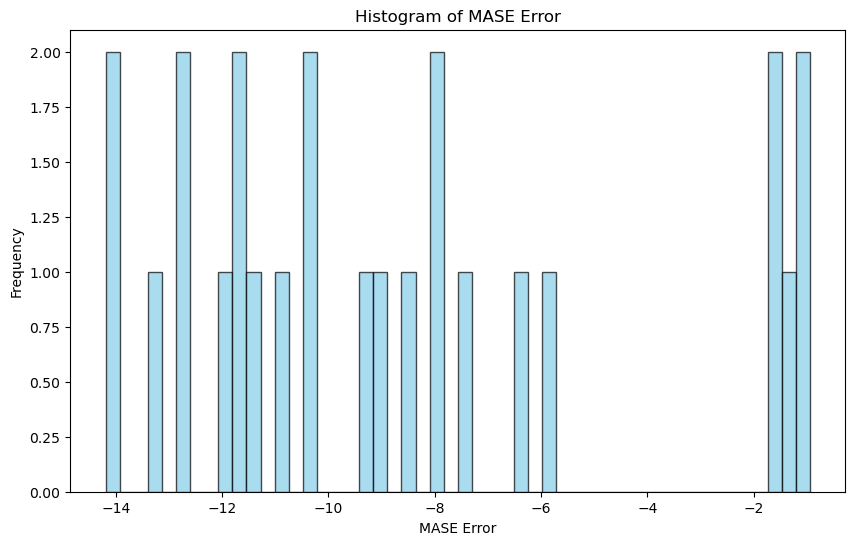

In [43]:
plt.figure(figsize=(10, 6))
plt.hist(errors_B_Finance["MASE_error"], bins=50, alpha=0.7, color="skyblue", edgecolor="black")
plt.xlabel("MASE Error")
plt.ylabel("Frequency")
plt.title("Histogram of MASE Error")
plt.show()

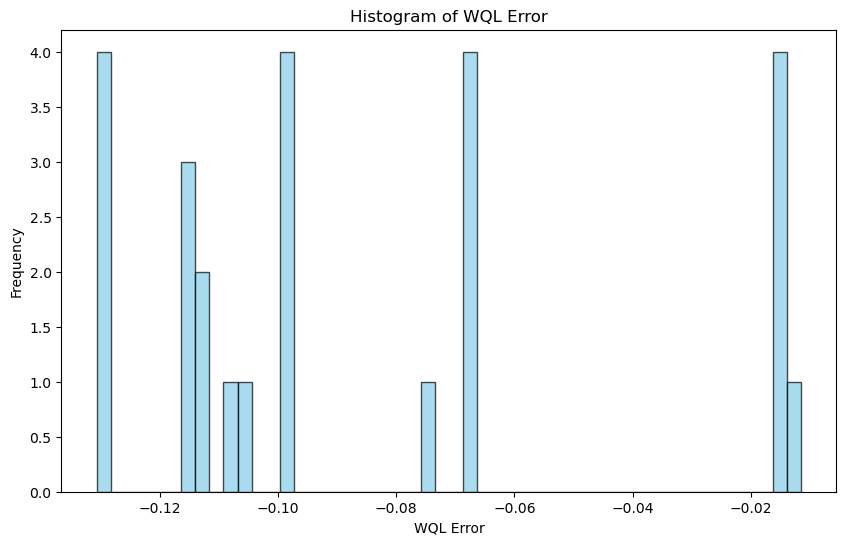

In [44]:
plt.figure(figsize=(10, 6))
plt.hist(errors_B_Finance["WQL_error"], bins=50, alpha=0.7, color="skyblue", edgecolor="black")
plt.xlabel("WQL Error")
plt.ylabel("Frequency")
plt.title("Histogram of WQL Error")
plt.show()

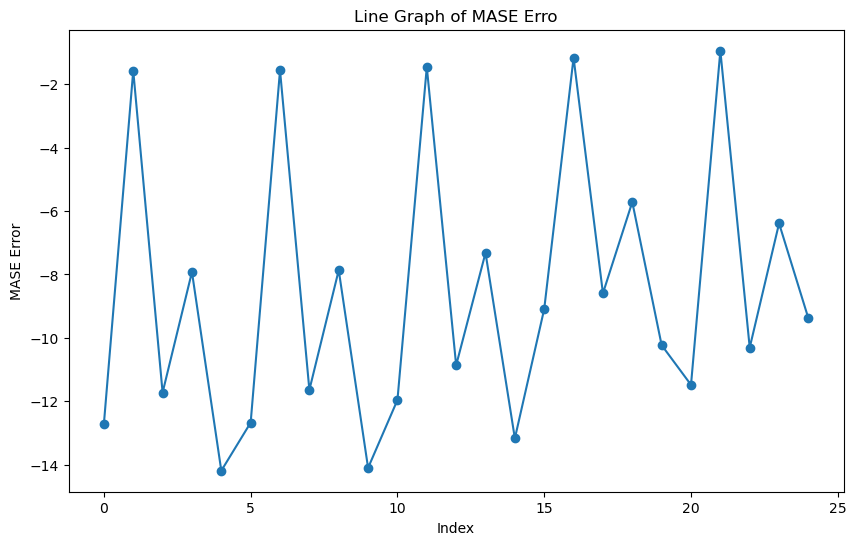

In [45]:
plt.figure(figsize=(10, 6))
plt.plot(errors_B_Finance["MASE_error"].values, marker='o', linestyle='-')
plt.xlabel("Index")
plt.ylabel("MASE Error")
plt.title("Line Graph of MASE Erro")
plt.show()

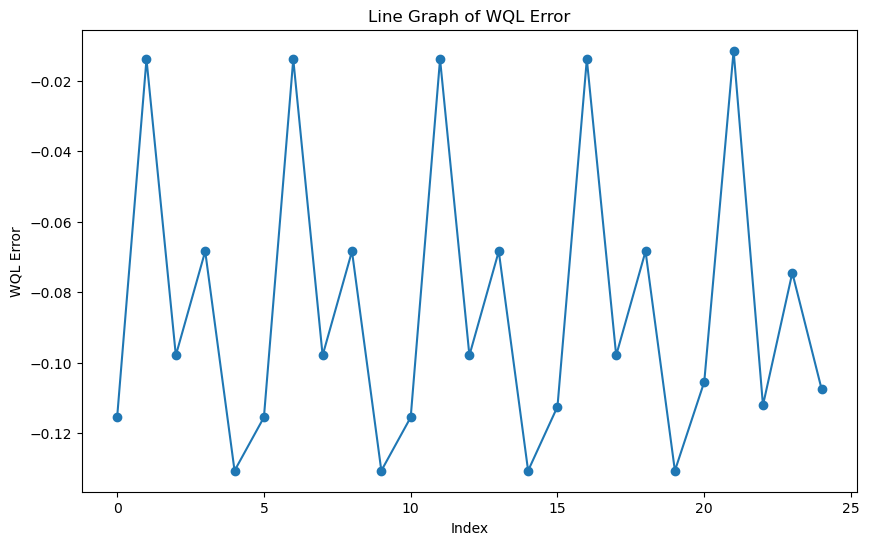

In [46]:
plt.figure(figsize=(10, 6))
plt.plot(errors_B_Finance["WQL_error"].values, marker='o', linestyle='-')
plt.xlabel("Index")
plt.ylabel("WQL Error")
plt.title("Line Graph of WQL Error")
plt.show()

In [47]:
errors_B_Finance.sort_values(by="MASE_error")

Train_size Percentage_train Test_size Percentage_test MASE_error  \
4        6826             100%      1280           75.0% -14.193552   
9        6485            95.0%      1280           75.0% -14.104397   
14       5120            75.0%      1280           75.0% -13.172122   
0        6826             100%      1707            100% -12.720552   
5        6485            95.0%      1707            100% -12.675526   
10       5120            75.0%      1707            100% -11.962567   
2        6826             100%       427           25.0% -11.727587   
7        6485            95.0%       427           25.0% -11.643544   
20       1706            25.0%      1707            100% -11.483346   
12       5120            75.0%       427           25.0% -10.866827   
22       1706            25.0%       427           25.0% -10.309267   
19       3413            50.0%      1280           75.0% -10.231709   
24       1706            25.0%      1280           75.0%  -9.388175   
15       3413            50.0%      1707            100%  -9.090957   
17       3413            50.0%       427           25.0%  -8.594405   
3        6826             100%       854           50.0%  -7.923669   
8        6485            95.0%       854           50.0%  -7.864615   
13       5120            75.0%       854           50.0%  -7.319389   
23       1706            25.0%       854           50.0%  -6.388975   
18       3413            50.0%       854           50.0%  -5.715913   
1        6826             100%        85            5.0%  -1.568977   
6        6485            95.0%        85            5.0%  -1.557669   
11       5120            75.0%        85            5.0%  -1.455224   
16       3413            50.0%        85            5.0%  -1.160025   
21       1706            25.0%        85            5.0%  -0.940514   

   Diference_MASE WQL_error Diference_WQL  
4        6.269883 -0.130721      0.062306  
9        6.239781 -0.130721      0.062306  
14       5.852733 -0.130721      0.062306  
0               0 -0.115558             0  
5        1.518027 -0.115558      0.015164  
10        2.14183 -0.115558      0.015164  
2        10.15861 -0.097971      0.084094  
7       10.085875 -0.097971      0.084094  
20       1.251637 -0.105496      0.025225  
12       9.411603 -0.097971      0.084094  
22       9.368753 -0.112119       0.10065  
19       4.515796 -0.130721      0.062306  
24         2.9992 -0.107622      0.033092  
15       4.081165 -0.112529      0.018193  
17       7.434379 -0.097971      0.084094  
3        3.803918 -0.068416      0.029555  
8        3.778929 -0.068416      0.029555  
13       3.547438 -0.068416      0.029555  
23       3.920292  -0.07453      0.037589  
18       2.878492 -0.068416      0.029555  
1       11.151575 -0.013877      0.101681  
6       11.117856 -0.013877      0.101681  
11      10.507343 -0.013877      0.101681  
16       7.930931 -0.013877      0.098652  
21      10.542832 -0.011469      0.094027

In [48]:
errors_B_Finance.sort_values(by="WQL_error")

Train_size Percentage_train Test_size Percentage_test MASE_error  \
19       3413            50.0%      1280           75.0% -10.231709   
4        6826             100%      1280           75.0% -14.193552   
14       5120            75.0%      1280           75.0% -13.172122   
9        6485            95.0%      1280           75.0% -14.104397   
0        6826             100%      1707            100% -12.720552   
5        6485            95.0%      1707            100% -12.675526   
10       5120            75.0%      1707            100% -11.962567   
15       3413            50.0%      1707            100%  -9.090957   
22       1706            25.0%       427           25.0% -10.309267   
24       1706            25.0%      1280           75.0%  -9.388175   
20       1706            25.0%      1707            100% -11.483346   
7        6485            95.0%       427           25.0% -11.643544   
17       3413            50.0%       427           25.0%  -8.594405   
2        6826             100%       427           25.0% -11.727587   
12       5120            75.0%       427           25.0% -10.866827   
23       1706            25.0%       854           50.0%  -6.388975   
13       5120            75.0%       854           50.0%  -7.319389   
3        6826             100%       854           50.0%  -7.923669   
18       3413            50.0%       854           50.0%  -5.715913   
8        6485            95.0%       854           50.0%  -7.864615   
11       5120            75.0%        85            5.0%  -1.455224   
6        6485            95.0%        85            5.0%  -1.557669   
16       3413            50.0%        85            5.0%  -1.160025   
1        6826             100%        85            5.0%  -1.568977   
21       1706            25.0%        85            5.0%  -0.940514   

   Diference_MASE WQL_error Diference_WQL  
19       4.515796 -0.130721      0.062306  
4        6.269883 -0.130721      0.062306  
14       5.852733 -0.130721      0.062306  
9        6.239781 -0.130721      0.062306  
0               0 -0.115558             0  
5        1.518027 -0.115558      0.015164  
10        2.14183 -0.115558      0.015164  
15       4.081165 -0.112529      0.018193  
22       9.368753 -0.112119       0.10065  
24         2.9992 -0.107622      0.033092  
20       1.251637 -0.105496      0.025225  
7       10.085875 -0.097971      0.084094  
17       7.434379 -0.097971      0.084094  
2        10.15861 -0.097971      0.084094  
12       9.411603 -0.097971      0.084094  
23       3.920292  -0.07453      0.037589  
13       3.547438 -0.068416      0.029555  
3        3.803918 -0.068416      0.029555  
18       2.878492 -0.068416      0.029555  
8        3.778929 -0.068416      0.029555  
11      10.507343 -0.013877      0.101681  
6       11.117856 -0.013877      0.101681  
16       7.930931 -0.013877      0.098652  
1       11.151575 -0.013877      0.101681  
21      10.542832 -0.011469      0.094027

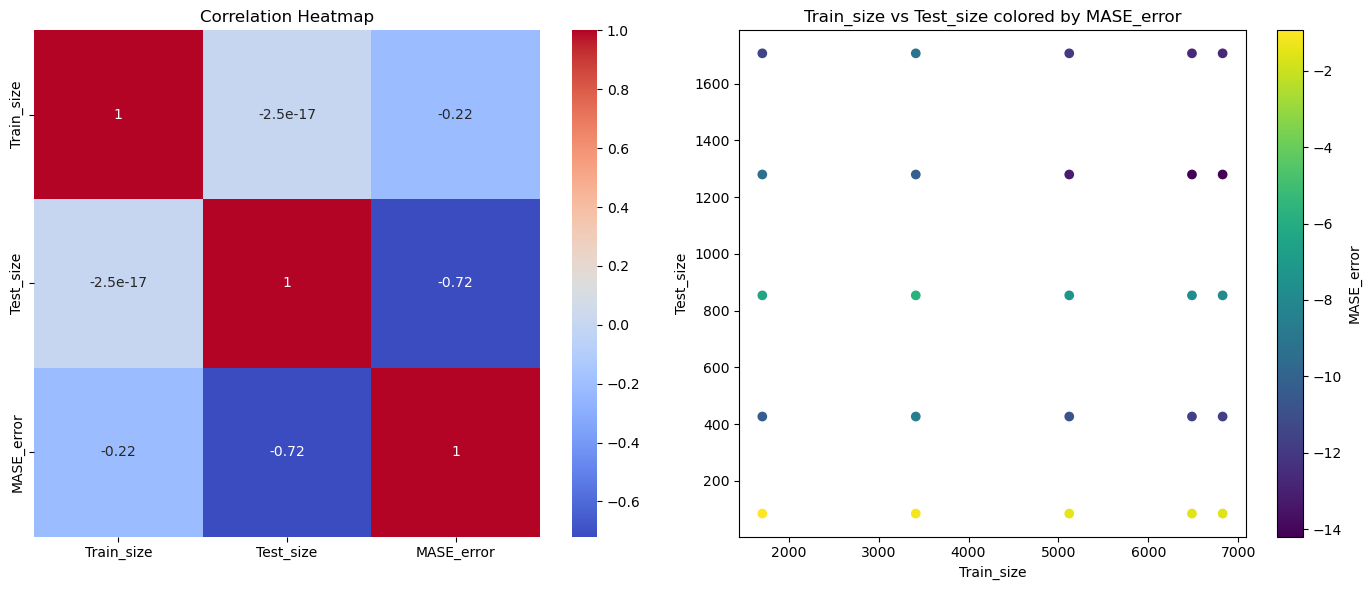

In [49]:
features = ["Train_size", "Test_size", "MASE_error"]
corr_matrix = errors_B_Finance[features].corr()
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", ax=axes[0])
axes[0].set_title("Correlation Heatmap")
scatter = axes[1].scatter(errors_B_Finance["Train_size"], errors_B_Finance["Test_size"],
                          c=errors_B_Finance["MASE_error"], cmap="viridis")
axes[1].set_xlabel("Train_size")
axes[1].set_ylabel("Test_size")
axes[1].set_title("Train_size vs Test_size colored by MASE_error")
fig.colorbar(scatter, ax=axes[1], label="MASE_error")

plt.tight_layout()
plt.show()

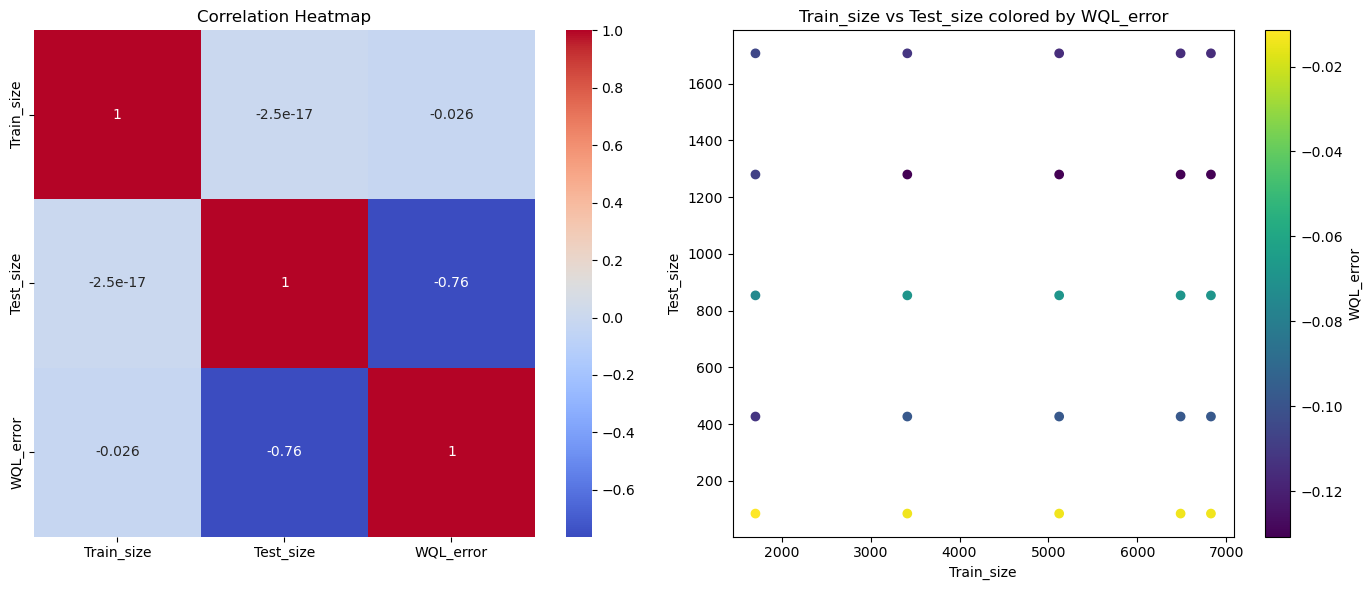

In [52]:
features = ["Train_size", "Test_size", "WQL_error"]
corr_matrix = errors_B_Finance[features].corr()
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", ax=axes[0])
axes[0].set_title("Correlation Heatmap")

scatter = axes[1].scatter(errors_B_Finance["Train_size"], errors_B_Finance["Test_size"],
                          c=errors_B_Finance["WQL_error"], cmap="viridis")
axes[1].set_xlabel("Train_size")
axes[1].set_ylabel("Test_size")
axes[1].set_title("Train_size vs Test_size colored by WQL_error")
fig.colorbar(scatter, ax=axes[1], label="WQL_error")

plt.tight_layout()
plt.show()

### Monthly

In [53]:
df_Finance_monthly = df_Finance_1.resample('MS').first().sort_index(ascending=True)

In [54]:
df_Finance_monthly.index = pd.to_datetime(df_Finance_monthly.index).normalize()

In [55]:
df_Finance_monthly.head(20)

item_id           timestamp  target
timestamp                                      
1983-12-01  T002046 1983-12-12 12:00:00  7324.4
1984-01-01  T002046 1984-01-01 12:00:00  7232.5
1984-02-01  T002046 1984-02-01 12:00:00  7485.2
1984-03-01  T002046 1984-03-01 12:00:00  7287.4
1984-04-01  T002046 1984-04-01 12:00:00  7200.0
1984-05-01  T002046 1984-05-01 12:00:00  6776.2
1984-06-01  T002046 1984-06-01 12:00:00  6905.0
1984-07-01  T002046 1984-07-01 12:00:00  6769.4
1984-08-01  T002046 1984-08-01 12:00:00  7033.4
1984-09-01  T002046 1984-09-01 12:00:00  6829.4
1984-10-01  T002046 1984-10-01 12:00:00  6201.2
1984-11-01  T002046 1984-11-01 12:00:00  6014.4
1984-12-01  T002046 1984-12-01 12:00:00  6099.9
1985-01-01  T002046 1985-01-01 12:00:00  5845.1
1985-02-01  T002046 1985-02-01 12:00:00  6236.8
1985-03-01  T002046 1985-03-01 12:00:00  6079.2
1985-04-01  T002046 1985-04-01 12:00:00  6247.2
1985-05-01  T002046 1985-05-01 12:00:00  6101.3
1985-06-01  T002046 1985-06-01 12:00:00  6341.1
1985-07-01  T002046 1985-07-01 12:00:00  6228.1

In [56]:
df_Finance_monthly.shape

(281, 3)

In [57]:
df_Finance_monthly.dtypes

item_id      string[python]
timestamp    datetime64[ns]
target              float64
dtype: object

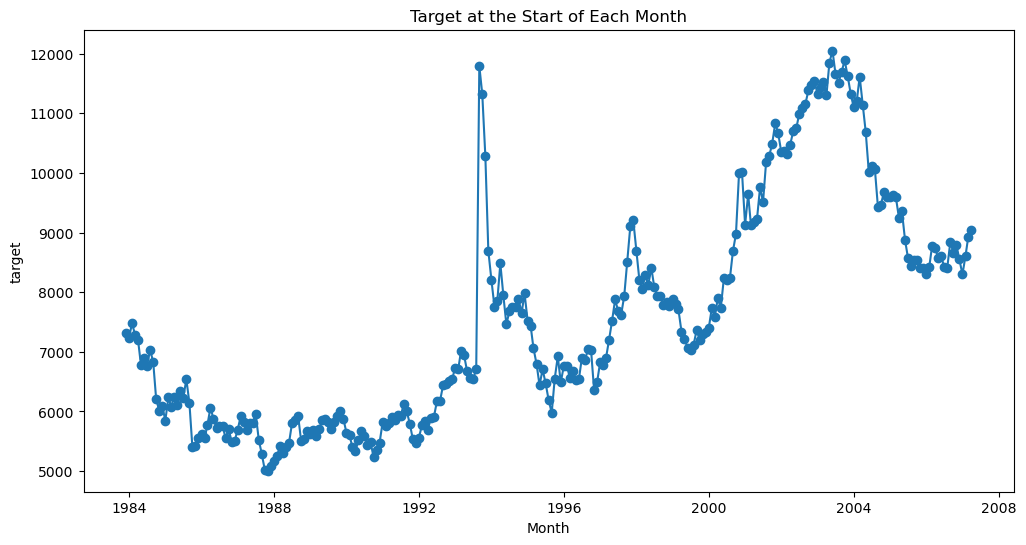

In [58]:
ts = df_Finance_monthly                   # shorthand
x  = ts.index.get_level_values('timestamp')   # just the dates
y  = ts['target'].values                     # the values

plt.figure(figsize=(12, 6))
plt.plot(x, y, marker='o')
plt.title("Target at the Start of Each Month")
plt.xlabel("Month")
plt.ylabel("target")
plt.show()

In [59]:
errors_M_Finance=get_errors(df_Finance_monthly, frequ="B")

---------data len 281


Empty DataFrame
Columns: [Train_size, Percentage_train, Test_size, Percentage_test, MASE_error, Diference_MASE, WQL_error, Diference_WQL]
Index: []

Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_192805'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.37 GB / 7.37 GB (5.0%)
Disk Space Avail:   4.37 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 56,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'targe

----------historical length 225
----------prediction_length 56
-----------history len, min and max 225 ('T002046', Timestamp('1983-12-12 12:00:00')) ('T002046', Timestamp('2002-08-01 12:00:00'))


	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.04 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_192805-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.37 GB / 7.37 GB (5.0%)
Disk Space Avail:   4.37 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 56,
 'quantile_levels': [0.1,

---------beginning 0
---------total_length 281
----------training len 225
----------training                               target
item_id timestamp                   
T002046 2002-07-01 12:00:00  10995.2
        2002-08-01 12:00:00  11095.9
----------testing len 281
----------testtt                               target
item_id timestamp                   
T002046 2002-09-01 12:00:00  11158.2
        2002-10-01 12:00:00  11384.6
        2002-11-01 12:00:00  11470.1
        2002-12-01 12:00:00  11548.7
        2003-01-01 12:00:00  11322.2
        2003-02-01 12:00:00  11439.3
        2003-03-01 12:00:00  11529.2
        2003-04-01 12:00:00  11301.6
        2003-05-01 12:00:00  11853.3
        2003-06-01 12:00:00  12051.1
        2003-07-01 12:00:00  11668.9
        2003-08-01 12:00:00  11517.8
        2003-09-01 12:00:00  11692.0
        2003-10-01 12:00:00  11889.8
        2003-11-01 12:00:00  11630.2
        2003-12-01 12:00:00  11333.3
        2004-01-01 12:00:00  11101.7
        2004-

mean           0.1           0.2  \
item_id timestamp                                                       
T002046 2002-09-01 12:00:00  11664.516602  10751.454102  11091.415039   
        2002-10-01 12:00:00  11470.486328  10477.978516  10877.448242   
        2002-11-01 12:00:00  11414.284180  10324.689453  10773.887695   
        2002-12-01 12:00:00  11438.225586  10250.670898  10747.419922   
        2003-01-01 12:00:00  11386.357422  10189.503906  10696.955078   
        2003-02-01 12:00:00  11291.683594  10067.082031  10589.515625   
        2003-03-01 12:00:00  11306.905273  10039.277344  10581.363281   
        2003-04-01 12:00:00  11374.376953  10053.875977  10614.023438   
        2003-05-01 12:00:00  11374.092773  10000.664062  10587.362305   
        2003-06-01 12:00:00  11352.005859   9960.163086  10543.227539   
        2003-07-01 12:00:00  11369.782227   9900.947266  10518.362305   
        2003-08-01 12:00:00  11336.682617   9815.201172  10460.482422   
        2003-09-01 12:00:00  11294.351562   9717.842773  10382.348633   
        2003-10-01 12:00:00  11283.494141   9671.392578  10335.800781   
        2003-11-01 12:00:00  11328.360352   9689.206055  10350.959961   
        2003-12-01 12:00:00  11374.420898   9697.779297  10372.019531   
        2004-01-01 12:00:00  11379.665039   9640.502930  10342.706055   
        2004-02-01 12:00:00  11309.013672   9579.501953  10291.698242   
        2004-03-01 12:00:00  11269.449219   9521.806641  10247.971680   
        2004-04-01 12:00:00  11295.095703   9505.471680  10236.093750   
        2004-05-01 12:00:00  11296.710938   9496.030273  10216.709961   
        2004-06-01 12:00:00  11211.507812   9400.292969  10130.576172   
        2004-07-01 12:00:00  11181.898438   9330.843750  10085.118164   
        2004-08-01 12:00:00  11236.682617   9311.133789  10086.017578   
        2004-09-01 12:00:00  11201.863281   9262.305664  10059.078125   
        2004-10-01 12:00:00  11157.169922   9196.250000   9990.457031   
        2004-11-01 12:00:00  11181.172852   9199.095703   9990.373047   
        2004-12-01 12:00:00  11275.632812   9226.322266  10051.819336   
        2005-01-01 12:00:00  11285.541992   9205.084961  10046.788086   
        2005-02-01 12:00:00  11219.169922   9161.010742   9999.718750   
        2005-03-01 12:00:00  11200.246094   9127.490234   9969.515625   
        2005-04-01 12:00:00  11219.257812   9114.303711   9957.172852   
        2005-05-01 12:00:00  11194.496094   9078.517578   9931.833984   
        2005-06-01 12:00:00  11154.541992   9019.070312   9886.551758   
        2005-07-01 12:00:00  11162.041992   9023.600586   9894.689453   
        2005-08-01 12:00:00  11159.187500   8966.838867   9861.783203   
        2005-09-01 12:00:00  11132.683594   8902.518555   9798.350586   
        2005-10-01 12:00:00  11097.060547   8854.642578   9750.702148   
        2005-11-01 12:00:00  11097.370117   8841.153320   9752.748047   
        2005-12-01 12:00:00  11105.148438   8831.354492   9744.879883   
        2006-01-01 12:00:00  11073.837891   8797.725586   9707.062500   
        2006-02-01 12:00:00  11025.896484   8764.051758   9679.008789   
        2006-03-01 12:00:00  11006.101562   8748.824219   9668.313477   
        2006-04-01 12:00:00  11040.447266   8749.760742   9681.794922   
        2006-05-01 12:00:00  11030.245117   8710.719727   9643.541016   
        2006-06-01 12:00:00  10940.599609   8625.289062   9548.203125   
        2006-07-01 12:00:00  10930.719727   8589.604492   9521.322266   
        2006-08-01 12:00:00  10965.826172   8592.634766   9543.275391   
        2006-09-01 12:00:00  10969.208984   8582.700195   9543.550781   
        2006-10-01 12:00:00  10934.943359   8578.136719   9519.583984   
        2006-11-01 12:00:00  10995.110352   8598.927734   9558.274414   
        2006-12-01 12:00:00  11060.786133   8645.672852   9616.226562   
        2007-01-01 12:00:00  11018.241211   8569.943359   9542.110352   
        2007-02-01 12:

---len test slide 281


target
item_id timestamp                   
T002046 2002-09-01 12:00:00  11158.2
        2002-10-01 12:00:00  11384.6
        2002-11-01 12:00:00  11470.1
        2002-12-01 12:00:00  11548.7
        2003-01-01 12:00:00  11322.2
        2003-02-01 12:00:00  11439.3
        2003-03-01 12:00:00  11529.2
        2003-04-01 12:00:00  11301.6
        2003-05-01 12:00:00  11853.3
        2003-06-01 12:00:00  12051.1
        2003-07-01 12:00:00  11668.9
        2003-08-01 12:00:00  11517.8
        2003-09-01 12:00:00  11692.0
        2003-10-01 12:00:00  11889.8
        2003-11-01 12:00:00  11630.2
        2003-12-01 12:00:00  11333.3
        2004-01-01 12:00:00  11101.7
        2004-02-01 12:00:00  11210.0
        2004-03-01 12:00:00  11616.7
        2004-04-01 12:00:00  11139.5
        2004-05-01 12:00:00  10687.7
        2004-06-01 12:00:00  10019.7
        2004-07-01 12:00:00  10111.7
        2004-08-01 12:00:00  10071.7
        2004-09-01 12:00:00   9427.7
        2004-10-01 12:00:00   9471.5
        2004-11-01 12:00:00   9677.4
        2004-12-01 12:00:00   9604.5
        2005-01-01 12:00:00   9599.8
        2005-02-01 12:00:00   9624.7
        2005-03-01 12:00:00   9592.1
        2005-04-01 12:00:00   9246.8
        2005-05-01 12:00:00   9354.9
        2005-06-01 12:00:00   8881.0
        2005-07-01 12:00:00   8574.5
        2005-08-01 12:00:00   8436.9
        2005-09-01 12:00:00   8547.3
        2005-10-01 12:00:00   8533.2
        2005-11-01 12:00:00   8413.1
        2005-12-01 12:00:00   8398.4
        2006-01-01 12:00:00   8305.6
        2006-02-01 12:00:00   8430.1
        2006-03-01 12:00:00   8778.2
        2006-04-01 12:00:00   8738.6
        2006-05-01 12:00:00   8573.7
        2006-06-01 12:00:00   8608.7
        2006-07-01 12:00:00   8418.9
        2006-08-01 12:00:00   8414.5
        2006-09-01 12:00:00   8847.5
        2006-10-01 12:00:00   8658.6
        2006-11-01 12:00:00   8793.7
        2006-12-01 12:00:00   8552.3
        2007-01-01 12:00:00   8299.7
        2007-02-01 12:00:00   8612.0
        2007-03-01 12:00:00   8934.4
        2007-04-01 12:00:00   9042.3

data with frequency 'IRREG' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'IRREG' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_192813'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.50 GB / 7.37 GB (6.8%)
Disk Space Avail:   4.37 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eva

----------prediction_length 3
-----------history len, min and max 225 ('T002046', Timestamp('1983-12-12 12:00:00')) ('T002046', Timestamp('2002-08-01 12:00:00'))


	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 21:28:13
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.04 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_192813-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.51 GB / 7.37 GB (7.0%)
Disk Space Avail:   4.37 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may requi

---------beginning 0
---------total_length 228
----------training len 225
----------training                               target
item_id timestamp                   
T002046 2002-07-01 12:00:00  10995.2
        2002-08-01 12:00:00  11095.9
----------testing len 228
----------testtt                               target
item_id timestamp                   
T002046 2002-09-01 12:00:00  11158.2
        2002-10-01 12:00:00  11384.6
        2002-11-01 12:00:00  11470.1
-----------len predictions 3


mean           0.1           0.2  \
item_id timestamp                                                       
T002046 2002-09-01 12:00:00  11664.516602  10751.454102  11091.415039   
        2002-10-01 12:00:00  11470.486328  10477.978516  10877.448242   
        2002-11-01 12:00:00  11414.284180  10324.689453  10773.887695   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2002-09-01 12:00:00  11311.893555  11501.800781  11664.516602   
        2002-10-01 12:00:00  11108.925781  11299.985352  11470.486328   
        2002-11-01 12:00:00  11038.453125  11238.037109  11414.284180   

                                      0.6           0.7           0.8  \
item_id timestamp                                                       
T002046 2002-09-01 12:00:00  11830.933594  12017.618164  12244.077148   
        2002-10-01 12:00:00  11635.493164  11807.621094  12024.539062   
        2002-11-01 12:00:00  11583.750000  11763.612305  11986.170898   

                                      0.9  
item_id timestamp                          
T002046 2002-09-01 12:00:00  12631.519531  
        2002-10-01 12:00:00  12399.748047  
        2002-11-01 12:00:00  12353.187500

---len test slide 228


target
item_id timestamp                   
T002046 2002-09-01 12:00:00  11158.2
        2002-10-01 12:00:00  11384.6
        2002-11-01 12:00:00  11470.1

data with frequency 'IRREG' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'IRREG' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_192819'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.52 GB / 7.37 GB (7.1%)
Disk Space Avail:   4.37 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eva

----------prediction_length 14
-----------history len, min and max 225 ('T002046', Timestamp('1983-12-12 12:00:00')) ('T002046', Timestamp('2002-08-01 12:00:00'))


	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 21:28:20
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.04 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_192820'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.57 GB / 7.37 GB (7.7%)
Disk Space Avail:   4.37 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require m

---------beginning 0
---------total_length 239
----------training len 225
----------training                               target
item_id timestamp                   
T002046 2002-07-01 12:00:00  10995.2
        2002-08-01 12:00:00  11095.9
----------testing len 239
----------testtt                               target
item_id timestamp                   
T002046 2002-09-01 12:00:00  11158.2
        2002-10-01 12:00:00  11384.6
        2002-11-01 12:00:00  11470.1
        2002-12-01 12:00:00  11548.7
        2003-01-01 12:00:00  11322.2
        2003-02-01 12:00:00  11439.3
        2003-03-01 12:00:00  11529.2
        2003-04-01 12:00:00  11301.6
        2003-05-01 12:00:00  11853.3
        2003-06-01 12:00:00  12051.1
        2003-07-01 12:00:00  11668.9
        2003-08-01 12:00:00  11517.8
        2003-09-01 12:00:00  11692.0
        2003-10-01 12:00:00  11889.8
-----------len predictions 14


mean           0.1           0.2  \
item_id timestamp                                                       
T002046 2002-09-01 12:00:00  11664.516602  10751.454102  11091.415039   
        2002-10-01 12:00:00  11470.486328  10477.978516  10877.448242   
        2002-11-01 12:00:00  11414.284180  10324.689453  10773.887695   
        2002-12-01 12:00:00  11438.225586  10250.670898  10747.419922   
        2003-01-01 12:00:00  11386.357422  10189.503906  10696.955078   
        2003-02-01 12:00:00  11291.683594  10067.082031  10589.515625   
        2003-03-01 12:00:00  11306.905273  10039.277344  10581.363281   
        2003-04-01 12:00:00  11374.376953  10053.875977  10614.023438   
        2003-05-01 12:00:00  11374.092773  10000.664062  10587.362305   
        2003-06-01 12:00:00  11352.005859   9960.163086  10543.227539   
        2003-07-01 12:00:00  11369.782227   9900.947266  10518.362305   
        2003-08-01 12:00:00  11336.682617   9815.201172  10460.482422   
        2003-09-01 12:00:00  11294.351562   9717.842773  10382.348633   
        2003-10-01 12:00:00  11283.494141   9671.392578  10335.800781   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2002-09-01 12:00:00  11311.893555  11501.800781  11664.516602   
        2002-10-01 12:00:00  11108.925781  11299.985352  11470.486328   
        2002-11-01 12:00:00  11038.453125  11238.037109  11414.284180   
        2002-12-01 12:00:00  11037.172852  11253.223633  11438.225586   
        2003-01-01 12:00:00  10991.696289  11207.304688  11386.357422   
        2003-02-01 12:00:00  10888.212891  11109.992188  11291.683594   
        2003-03-01 12:00:00  10900.314453  11124.548828  11306.905273   
        2003-04-01 12:00:00  10954.415039  11186.112305  11374.376953   
        2003-05-01 12:00:00  10935.433594  11184.199219  11374.092773   
        2003-06-01 12:00:00  10892.325195  11148.885742  11352.005859   
        2003-07-01 12:00:00  10887.337891  11161.484375  11369.782227   
        2003-08-01 12:00:00  10840.363281  11119.105469  11336.682617   
        2003-09-01 12:00:00  10780.124023  11065.954102  11294.351562   
        2003-10-01 12:00:00  10757.957031  11051.484375  11283.494141   

                                      0.6           0.7           0.8  \
item_id timestamp                                                       
T002046 2002-09-01 12:00:00  11830.933594  12017.618164  12244.077148   
        2002-10-01 12:00:00  11635.493164  11807.621094  12024.539062   
        2002-11-01 12:00:00  11583.750000  11763.612305  11986.170898   
        2002-12-01 12:00:00  11608.132812  11788.544922  12021.229492   
        2003-01-01 12:00:00  11564.021484  11750.618164  11987.571289   
        2003-02-01 12:00:00  11459.121094  11639.473633  11857.943359   
        2003-03-01 12:00:00  11478.189453  11659.736328  11873.839844   
        2003-04-01 12:00:00  11548.905273  11726.068359  11939.639648   
        2003-05-01 12:00:00  11550.443359  11731.473633  11948.042969   
        2003-06-01 12:00:00  11537.808594  11724.458984  11940.478516   
        2003-07-01 12:00:00  11553.617188  11740.048828  11966.154297   
        2003-08-01 12:00:00  11522.652344  11723.467773  11956.450195   
        2003-09-01 12:00:00  11491.443359  11688.347656  11920.547852   
        2003-10-01 12:00:00  11482.417969  11675.416992  11891.672852   

                                      0.9  
item_id timestamp                          
T002046 2002-09-01 12:00:00  12631.519531  
        2002-10-01 12:00:00  12399.748047  
        2002-11-01 12:00:00  12353.187500  
        2002-12-01 12:00:00  12388.138672  
        2003-01-01 12:00:00  12362.751953  
        2003-02-01 12:00:00  12206.890625  
        2003-03-01 12:00:00  12217.556641  
        2003-04-01 12:00:00  12291.992188  
        2003-05-01 12:00:00  12302.146484  
        2003-06-01 12:00:00  12311.605469  
  

---len test slide 239


target
item_id timestamp                   
T002046 2002-09-01 12:00:00  11158.2
        2002-10-01 12:00:00  11384.6
        2002-11-01 12:00:00  11470.1
        2002-12-01 12:00:00  11548.7
        2003-01-01 12:00:00  11322.2
        2003-02-01 12:00:00  11439.3
        2003-03-01 12:00:00  11529.2
        2003-04-01 12:00:00  11301.6
        2003-05-01 12:00:00  11853.3
        2003-06-01 12:00:00  12051.1
        2003-07-01 12:00:00  11668.9
        2003-08-01 12:00:00  11517.8
        2003-09-01 12:00:00  11692.0
        2003-10-01 12:00:00  11889.8

data with frequency 'IRREG' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'IRREG' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_192826'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.67 GB / 7.37 GB (9.1%)
Disk Space Avail:   4.37 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eva

----------prediction_length 28
-----------history len, min and max 225 ('T002046', Timestamp('1983-12-12 12:00:00')) ('T002046', Timestamp('2002-08-01 12:00:00'))


Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.03 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_192827'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.68 GB / 7.37 GB (9.3%)
Disk Space Avail:   4.37 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'predi

---------beginning 0
---------total_length 253
----------training len 225
----------training                               target
item_id timestamp                   
T002046 2002-07-01 12:00:00  10995.2
        2002-08-01 12:00:00  11095.9
----------testing len 253
----------testtt                               target
item_id timestamp                   
T002046 2002-09-01 12:00:00  11158.2
        2002-10-01 12:00:00  11384.6
        2002-11-01 12:00:00  11470.1
        2002-12-01 12:00:00  11548.7
        2003-01-01 12:00:00  11322.2
        2003-02-01 12:00:00  11439.3
        2003-03-01 12:00:00  11529.2
        2003-04-01 12:00:00  11301.6
        2003-05-01 12:00:00  11853.3
        2003-06-01 12:00:00  12051.1
        2003-07-01 12:00:00  11668.9
        2003-08-01 12:00:00  11517.8
        2003-09-01 12:00:00  11692.0
        2003-10-01 12:00:00  11889.8
        2003-11-01 12:00:00  11630.2
        2003-12-01 12:00:00  11333.3
        2004-01-01 12:00:00  11101.7
        2004-

mean           0.1           0.2  \
item_id timestamp                                                       
T002046 2002-09-01 12:00:00  11664.516602  10751.454102  11091.415039   
        2002-10-01 12:00:00  11470.486328  10477.978516  10877.448242   
        2002-11-01 12:00:00  11414.284180  10324.689453  10773.887695   
        2002-12-01 12:00:00  11438.225586  10250.670898  10747.419922   
        2003-01-01 12:00:00  11386.357422  10189.503906  10696.955078   
        2003-02-01 12:00:00  11291.683594  10067.082031  10589.515625   
        2003-03-01 12:00:00  11306.905273  10039.277344  10581.363281   
        2003-04-01 12:00:00  11374.376953  10053.875977  10614.023438   
        2003-05-01 12:00:00  11374.092773  10000.664062  10587.362305   
        2003-06-01 12:00:00  11352.005859   9960.163086  10543.227539   
        2003-07-01 12:00:00  11369.782227   9900.947266  10518.362305   
        2003-08-01 12:00:00  11336.682617   9815.201172  10460.482422   
        2003-09-01 12:00:00  11294.351562   9717.842773  10382.348633   
        2003-10-01 12:00:00  11283.494141   9671.392578  10335.800781   
        2003-11-01 12:00:00  11328.360352   9689.206055  10350.959961   
        2003-12-01 12:00:00  11374.420898   9697.779297  10372.019531   
        2004-01-01 12:00:00  11379.665039   9640.502930  10342.706055   
        2004-02-01 12:00:00  11309.013672   9579.501953  10291.698242   
        2004-03-01 12:00:00  11269.449219   9521.806641  10247.971680   
        2004-04-01 12:00:00  11295.095703   9505.471680  10236.093750   
        2004-05-01 12:00:00  11296.710938   9496.030273  10216.709961   
        2004-06-01 12:00:00  11211.507812   9400.292969  10130.576172   
        2004-07-01 12:00:00  11181.898438   9330.843750  10085.118164   
        2004-08-01 12:00:00  11236.682617   9311.133789  10086.017578   
        2004-09-01 12:00:00  11201.863281   9262.305664  10059.078125   
        2004-10-01 12:00:00  11157.169922   9196.250000   9990.457031   
        2004-11-01 12:00:00  11181.172852   9199.095703   9990.373047   
        2004-12-01 12:00:00  11275.632812   9226.322266  10051.819336   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2002-09-01 12:00:00  11311.893555  11501.800781  11664.516602   
        2002-10-01 12:00:00  11108.925781  11299.985352  11470.486328   
        2002-11-01 12:00:00  11038.453125  11238.037109  11414.284180   
        2002-12-01 12:00:00  11037.172852  11253.223633  11438.225586   
        2003-01-01 12:00:00  10991.696289  11207.304688  11386.357422   
        2003-02-01 12:00:00  10888.212891  11109.992188  11291.683594   
        2003-03-01 12:00:00  10900.314453  11124.548828  11306.905273   
        2003-04-01 12:00:00  10954.415039  11186.112305  11374.376953   
        2003-05-01 12:00:00  10935.433594  11184.199219  11374.092773   
        2003-06-01 12:00:00  10892.325195  11148.885742  11352.005859   
        2003-07-01 12:00:00  10887.337891  11161.484375  11369.782227   
        2003-08-01 12:00:00  10840.363281  11119.105469  11336.682617   
        2003-09-01 12:00:00  10780.124023  11065.954102  11294.351562   
        2003-10-01 12:00:00  10757.957031  11051.484375  11283.494141   
        2003-11-01 12:00:00  10777.182617  11088.314453  11328.360352   
        2003-12-01 12:00:00  10816.343750  11132.857422  11374.420898   
        2004-01-01 12:00:00  10801.327148  11130.362305  11379.665039   
        2004-02-01 12:00:00  10734.429688  11066.794922  11309.013672   
        2004-03-01 12:00:00  10696.331055  11017.851562  11269.449219   
        2004-04-01 12:00:00  10700.260742  11032.981445  11295.095703   
        2004-05-01 12:00:00  10690.975586  11030.962891  11296.710938   
        2004-06-01 12:00:00  10608.120117  10953.197266  11211.507812   
        2004-07-01 12:00:00  10568.083008  10919.636719  11181.898438   
        2004-08-01 12

---len test slide 253


target
item_id timestamp                   
T002046 2002-09-01 12:00:00  11158.2
        2002-10-01 12:00:00  11384.6
        2002-11-01 12:00:00  11470.1
        2002-12-01 12:00:00  11548.7
        2003-01-01 12:00:00  11322.2
        2003-02-01 12:00:00  11439.3
        2003-03-01 12:00:00  11529.2
        2003-04-01 12:00:00  11301.6
        2003-05-01 12:00:00  11853.3
        2003-06-01 12:00:00  12051.1
        2003-07-01 12:00:00  11668.9
        2003-08-01 12:00:00  11517.8
        2003-09-01 12:00:00  11692.0
        2003-10-01 12:00:00  11889.8
        2003-11-01 12:00:00  11630.2
        2003-12-01 12:00:00  11333.3
        2004-01-01 12:00:00  11101.7
        2004-02-01 12:00:00  11210.0
        2004-03-01 12:00:00  11616.7
        2004-04-01 12:00:00  11139.5
        2004-05-01 12:00:00  10687.7
        2004-06-01 12:00:00  10019.7
        2004-07-01 12:00:00  10111.7
        2004-08-01 12:00:00  10071.7
        2004-09-01 12:00:00   9427.7
        2004-10-01 12:00:00   9471.5
        2004-11-01 12:00:00   9677.4
        2004-12-01 12:00:00   9604.5

data with frequency 'IRREG' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'IRREG' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_192834'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.62 GB / 7.37 GB (8.4%)
Disk Space Avail:   4.37 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eva

----------prediction_length 42
-----------history len, min and max 225 ('T002046', Timestamp('1983-12-12 12:00:00')) ('T002046', Timestamp('2002-08-01 12:00:00'))


Training timeseries model Chronos[bolt_small]. 
	0.00    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.03 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_192834-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.70 GB / 7.37 GB (9.4%)
Disk Space Avail:   4.37 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'p

---------beginning 0
---------total_length 267
----------training len 225
----------training                               target
item_id timestamp                   
T002046 2002-07-01 12:00:00  10995.2
        2002-08-01 12:00:00  11095.9
----------testing len 267
----------testtt                               target
item_id timestamp                   
T002046 2002-09-01 12:00:00  11158.2
        2002-10-01 12:00:00  11384.6
        2002-11-01 12:00:00  11470.1
        2002-12-01 12:00:00  11548.7
        2003-01-01 12:00:00  11322.2
        2003-02-01 12:00:00  11439.3
        2003-03-01 12:00:00  11529.2
        2003-04-01 12:00:00  11301.6
        2003-05-01 12:00:00  11853.3
        2003-06-01 12:00:00  12051.1
        2003-07-01 12:00:00  11668.9
        2003-08-01 12:00:00  11517.8
        2003-09-01 12:00:00  11692.0
        2003-10-01 12:00:00  11889.8
        2003-11-01 12:00:00  11630.2
        2003-12-01 12:00:00  11333.3
        2004-01-01 12:00:00  11101.7
        2004-

mean           0.1           0.2  \
item_id timestamp                                                       
T002046 2002-09-01 12:00:00  11664.516602  10751.454102  11091.415039   
        2002-10-01 12:00:00  11470.486328  10477.978516  10877.448242   
        2002-11-01 12:00:00  11414.284180  10324.689453  10773.887695   
        2002-12-01 12:00:00  11438.225586  10250.670898  10747.419922   
        2003-01-01 12:00:00  11386.357422  10189.503906  10696.955078   
        2003-02-01 12:00:00  11291.683594  10067.082031  10589.515625   
        2003-03-01 12:00:00  11306.905273  10039.277344  10581.363281   
        2003-04-01 12:00:00  11374.376953  10053.875977  10614.023438   
        2003-05-01 12:00:00  11374.092773  10000.664062  10587.362305   
        2003-06-01 12:00:00  11352.005859   9960.163086  10543.227539   
        2003-07-01 12:00:00  11369.782227   9900.947266  10518.362305   
        2003-08-01 12:00:00  11336.682617   9815.201172  10460.482422   
        2003-09-01 12:00:00  11294.351562   9717.842773  10382.348633   
        2003-10-01 12:00:00  11283.494141   9671.392578  10335.800781   
        2003-11-01 12:00:00  11328.360352   9689.206055  10350.959961   
        2003-12-01 12:00:00  11374.420898   9697.779297  10372.019531   
        2004-01-01 12:00:00  11379.665039   9640.502930  10342.706055   
        2004-02-01 12:00:00  11309.013672   9579.501953  10291.698242   
        2004-03-01 12:00:00  11269.449219   9521.806641  10247.971680   
        2004-04-01 12:00:00  11295.095703   9505.471680  10236.093750   
        2004-05-01 12:00:00  11296.710938   9496.030273  10216.709961   
        2004-06-01 12:00:00  11211.507812   9400.292969  10130.576172   
        2004-07-01 12:00:00  11181.898438   9330.843750  10085.118164   
        2004-08-01 12:00:00  11236.682617   9311.133789  10086.017578   
        2004-09-01 12:00:00  11201.863281   9262.305664  10059.078125   
        2004-10-01 12:00:00  11157.169922   9196.250000   9990.457031   
        2004-11-01 12:00:00  11181.172852   9199.095703   9990.373047   
        2004-12-01 12:00:00  11275.632812   9226.322266  10051.819336   
        2005-01-01 12:00:00  11285.541992   9205.084961  10046.788086   
        2005-02-01 12:00:00  11219.169922   9161.010742   9999.718750   
        2005-03-01 12:00:00  11200.246094   9127.490234   9969.515625   
        2005-04-01 12:00:00  11219.257812   9114.303711   9957.172852   
        2005-05-01 12:00:00  11194.496094   9078.517578   9931.833984   
        2005-06-01 12:00:00  11154.541992   9019.070312   9886.551758   
        2005-07-01 12:00:00  11162.041992   9023.600586   9894.689453   
        2005-08-01 12:00:00  11159.187500   8966.838867   9861.783203   
        2005-09-01 12:00:00  11132.683594   8902.518555   9798.350586   
        2005-10-01 12:00:00  11097.060547   8854.642578   9750.702148   
        2005-11-01 12:00:00  11097.370117   8841.153320   9752.748047   
        2005-12-01 12:00:00  11105.148438   8831.354492   9744.879883   
        2006-01-01 12:00:00  11073.837891   8797.725586   9707.062500   
        2006-02-01 12:00:00  11025.896484   8764.051758   9679.008789   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2002-09-01 12:00:00  11311.893555  11501.800781  11664.516602   
        2002-10-01 12:00:00  11108.925781  11299.985352  11470.486328   
        2002-11-01 12:00:00  11038.453125  11238.037109  11414.284180   
        2002-12-01 12:00:00  11037.172852  11253.223633  11438.225586   
        2003-01-01 12:00:00  10991.696289  11207.304688  11386.357422   
        2003-02-01 12:00:00  10888.212891  11109.992188  11291.683594   
        2003-03-01 12:00:00  10900.314453  11124.548828  11306.905273   
        2003-04-01 12:00:00  10954.415039  11186.112305  11374.376953   
        2003-05-01 12:00:00  10935.433594  11184.199219  11374.092773   
        2003-06-01 12

---len test slide 267


target
item_id timestamp                   
T002046 2002-09-01 12:00:00  11158.2
        2002-10-01 12:00:00  11384.6
        2002-11-01 12:00:00  11470.1
        2002-12-01 12:00:00  11548.7
        2003-01-01 12:00:00  11322.2
        2003-02-01 12:00:00  11439.3
        2003-03-01 12:00:00  11529.2
        2003-04-01 12:00:00  11301.6
        2003-05-01 12:00:00  11853.3
        2003-06-01 12:00:00  12051.1
        2003-07-01 12:00:00  11668.9
        2003-08-01 12:00:00  11517.8
        2003-09-01 12:00:00  11692.0
        2003-10-01 12:00:00  11889.8
        2003-11-01 12:00:00  11630.2
        2003-12-01 12:00:00  11333.3
        2004-01-01 12:00:00  11101.7
        2004-02-01 12:00:00  11210.0
        2004-03-01 12:00:00  11616.7
        2004-04-01 12:00:00  11139.5
        2004-05-01 12:00:00  10687.7
        2004-06-01 12:00:00  10019.7
        2004-07-01 12:00:00  10111.7
        2004-08-01 12:00:00  10071.7
        2004-09-01 12:00:00   9427.7
        2004-10-01 12:00:00   9471.5
        2004-11-01 12:00:00   9677.4
        2004-12-01 12:00:00   9604.5
        2005-01-01 12:00:00   9599.8
        2005-02-01 12:00:00   9624.7
        2005-03-01 12:00:00   9592.1
        2005-04-01 12:00:00   9246.8
        2005-05-01 12:00:00   9354.9
        2005-06-01 12:00:00   8881.0
        2005-07-01 12:00:00   8574.5
        2005-08-01 12:00:00   8436.9
        2005-09-01 12:00:00   8547.3
        2005-10-01 12:00:00   8533.2
        2005-11-01 12:00:00   8413.1
        2005-12-01 12:00:00   8398.4
        2006-01-01 12:00:00   8305.6
        2006-02-01 12:00:00   8430.1

data with frequency 'IRREG' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'IRREG' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_192842'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       1.14 GB / 7.37 GB (15.4%)
Disk Space Avail:   4.37 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'ev

----------historical length 214
----------prediction_length 56
-----------history len, min and max 214 ('T002046', Timestamp('1984-11-01 12:00:00')) ('T002046', Timestamp('2002-08-01 12:00:00'))


Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.03 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_192842-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       1.11 GB / 7.37 GB (15.1%)
Disk Space Avail:   4.37 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'k

---------beginning 11
---------total_length 281
----------training len 214
----------training                               target
item_id timestamp                   
T002046 2002-07-01 12:00:00  10995.2
        2002-08-01 12:00:00  11095.9
----------testing len 270
----------testtt                               target
item_id timestamp                   
T002046 2002-09-01 12:00:00  11158.2
        2002-10-01 12:00:00  11384.6
        2002-11-01 12:00:00  11470.1
        2002-12-01 12:00:00  11548.7
        2003-01-01 12:00:00  11322.2
        2003-02-01 12:00:00  11439.3
        2003-03-01 12:00:00  11529.2
        2003-04-01 12:00:00  11301.6
        2003-05-01 12:00:00  11853.3
        2003-06-01 12:00:00  12051.1
        2003-07-01 12:00:00  11668.9
        2003-08-01 12:00:00  11517.8
        2003-09-01 12:00:00  11692.0
        2003-10-01 12:00:00  11889.8
        2003-11-01 12:00:00  11630.2
        2003-12-01 12:00:00  11333.3
        2004-01-01 12:00:00  11101.7
        2004

mean           0.1           0.2  \
item_id timestamp                                                       
T002046 2002-09-01 12:00:00  11664.516602  10751.454102  11091.415039   
        2002-10-01 12:00:00  11470.486328  10477.978516  10877.448242   
        2002-11-01 12:00:00  11414.284180  10324.689453  10773.887695   
        2002-12-01 12:00:00  11438.225586  10250.670898  10747.419922   
        2003-01-01 12:00:00  11386.357422  10189.503906  10696.955078   
        2003-02-01 12:00:00  11291.683594  10067.082031  10589.515625   
        2003-03-01 12:00:00  11306.905273  10039.277344  10581.363281   
        2003-04-01 12:00:00  11374.376953  10053.875977  10614.023438   
        2003-05-01 12:00:00  11374.092773  10000.664062  10587.362305   
        2003-06-01 12:00:00  11352.005859   9960.163086  10543.227539   
        2003-07-01 12:00:00  11369.782227   9900.947266  10518.362305   
        2003-08-01 12:00:00  11336.682617   9815.201172  10460.482422   
        2003-09-01 12:00:00  11294.351562   9717.842773  10382.348633   
        2003-10-01 12:00:00  11283.494141   9671.392578  10335.800781   
        2003-11-01 12:00:00  11328.360352   9689.206055  10350.959961   
        2003-12-01 12:00:00  11374.420898   9697.779297  10372.019531   
        2004-01-01 12:00:00  11379.665039   9640.502930  10342.706055   
        2004-02-01 12:00:00  11309.013672   9579.501953  10291.698242   
        2004-03-01 12:00:00  11269.449219   9521.806641  10247.971680   
        2004-04-01 12:00:00  11295.095703   9505.471680  10236.093750   
        2004-05-01 12:00:00  11296.710938   9496.030273  10216.709961   
        2004-06-01 12:00:00  11211.507812   9400.292969  10130.576172   
        2004-07-01 12:00:00  11181.898438   9330.843750  10085.118164   
        2004-08-01 12:00:00  11236.682617   9311.133789  10086.017578   
        2004-09-01 12:00:00  11201.863281   9262.305664  10059.078125   
        2004-10-01 12:00:00  11157.169922   9196.250000   9990.457031   
        2004-11-01 12:00:00  11181.172852   9199.095703   9990.373047   
        2004-12-01 12:00:00  11275.632812   9226.322266  10051.819336   
        2005-01-01 12:00:00  11285.541992   9205.084961  10046.788086   
        2005-02-01 12:00:00  11219.169922   9161.010742   9999.718750   
        2005-03-01 12:00:00  11200.246094   9127.490234   9969.515625   
        2005-04-01 12:00:00  11219.257812   9114.303711   9957.172852   
        2005-05-01 12:00:00  11194.496094   9078.517578   9931.833984   
        2005-06-01 12:00:00  11154.541992   9019.070312   9886.551758   
        2005-07-01 12:00:00  11162.041992   9023.600586   9894.689453   
        2005-08-01 12:00:00  11159.187500   8966.838867   9861.783203   
        2005-09-01 12:00:00  11132.683594   8902.518555   9798.350586   
        2005-10-01 12:00:00  11097.060547   8854.642578   9750.702148   
        2005-11-01 12:00:00  11097.370117   8841.153320   9752.748047   
        2005-12-01 12:00:00  11105.148438   8831.354492   9744.879883   
        2006-01-01 12:00:00  11073.837891   8797.725586   9707.062500   
        2006-02-01 12:00:00  11025.896484   8764.051758   9679.008789   
        2006-03-01 12:00:00  11006.101562   8748.824219   9668.313477   
        2006-04-01 12:00:00  11040.447266   8749.760742   9681.794922   
        2006-05-01 12:00:00  11030.245117   8710.719727   9643.541016   
        2006-06-01 12:00:00  10940.599609   8625.289062   9548.203125   
        2006-07-01 12:00:00  10930.719727   8589.604492   9521.322266   
        2006-08-01 12:00:00  10965.826172   8592.634766   9543.275391   
        2006-09-01 12:00:00  10969.208984   8582.700195   9543.550781   
        2006-10-01 12:00:00  10934.943359   8578.136719   9519.583984   
        2006-11-01 12:00:00  10995.110352   8598.927734   9558.274414   
        2006-12-01 12:00:00  11060.786133   8645.672852   9616.226562   
        2007-01-01 12:00:00  11018.241211   8569.943359   9542.110352   
        2007-02-01 12:

---len test slide 270


target
item_id timestamp                   
T002046 2002-09-01 12:00:00  11158.2
        2002-10-01 12:00:00  11384.6
        2002-11-01 12:00:00  11470.1
        2002-12-01 12:00:00  11548.7
        2003-01-01 12:00:00  11322.2
        2003-02-01 12:00:00  11439.3
        2003-03-01 12:00:00  11529.2
        2003-04-01 12:00:00  11301.6
        2003-05-01 12:00:00  11853.3
        2003-06-01 12:00:00  12051.1
        2003-07-01 12:00:00  11668.9
        2003-08-01 12:00:00  11517.8
        2003-09-01 12:00:00  11692.0
        2003-10-01 12:00:00  11889.8
        2003-11-01 12:00:00  11630.2
        2003-12-01 12:00:00  11333.3
        2004-01-01 12:00:00  11101.7
        2004-02-01 12:00:00  11210.0
        2004-03-01 12:00:00  11616.7
        2004-04-01 12:00:00  11139.5
        2004-05-01 12:00:00  10687.7
        2004-06-01 12:00:00  10019.7
        2004-07-01 12:00:00  10111.7
        2004-08-01 12:00:00  10071.7
        2004-09-01 12:00:00   9427.7
        2004-10-01 12:00:00   9471.5
        2004-11-01 12:00:00   9677.4
        2004-12-01 12:00:00   9604.5
        2005-01-01 12:00:00   9599.8
        2005-02-01 12:00:00   9624.7
        2005-03-01 12:00:00   9592.1
        2005-04-01 12:00:00   9246.8
        2005-05-01 12:00:00   9354.9
        2005-06-01 12:00:00   8881.0
        2005-07-01 12:00:00   8574.5
        2005-08-01 12:00:00   8436.9
        2005-09-01 12:00:00   8547.3
        2005-10-01 12:00:00   8533.2
        2005-11-01 12:00:00   8413.1
        2005-12-01 12:00:00   8398.4
        2006-01-01 12:00:00   8305.6
        2006-02-01 12:00:00   8430.1
        2006-03-01 12:00:00   8778.2
        2006-04-01 12:00:00   8738.6
        2006-05-01 12:00:00   8573.7
        2006-06-01 12:00:00   8608.7
        2006-07-01 12:00:00   8418.9
        2006-08-01 12:00:00   8414.5
        2006-09-01 12:00:00   8847.5
        2006-10-01 12:00:00   8658.6
        2006-11-01 12:00:00   8793.7
        2006-12-01 12:00:00   8552.3
        2007-01-01 12:00:00   8299.7
        2007-02-01 12:00:00   8612.0
        2007-03-01 12:00:00   8934.4
        2007-04-01 12:00:00   9042.3

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_192849'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       1.11 GB / 7.37 GB (15.1%)
Disk Space Avail:   4.37 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_met

----------prediction_length 3
-----------history len, min and max 214 ('T002046', Timestamp('1984-11-01 12:00:00')) ('T002046', Timestamp('2002-08-01 12:00:00'))


Provided train_data has 4631 rows (NaN fraction=95.4%), 1 time series. Median time series length is 4631 (min=4631, max=4631). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 21:28:49
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.00    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.02 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_192849-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Mac

---------beginning 11
---------total_length 228
----------training len 214
----------training                               target
item_id timestamp                   
T002046 2002-07-01 12:00:00  10995.2
        2002-08-01 12:00:00  11095.9
----------testing len 217
----------testtt                               target
item_id timestamp                   
T002046 2002-09-01 12:00:00  11158.2
        2002-10-01 12:00:00  11384.6
        2002-11-01 12:00:00  11470.1
-----------len predictions 3


mean           0.1           0.2  \
item_id timestamp                                                       
T002046 2002-09-01 12:00:00  11664.516602  10751.454102  11091.415039   
        2002-10-01 12:00:00  11470.486328  10477.978516  10877.448242   
        2002-11-01 12:00:00  11414.284180  10324.689453  10773.887695   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2002-09-01 12:00:00  11311.893555  11501.800781  11664.516602   
        2002-10-01 12:00:00  11108.925781  11299.985352  11470.486328   
        2002-11-01 12:00:00  11038.453125  11238.037109  11414.284180   

                                      0.6           0.7           0.8  \
item_id timestamp                                                       
T002046 2002-09-01 12:00:00  11830.933594  12017.618164  12244.077148   
        2002-10-01 12:00:00  11635.493164  11807.621094  12024.539062   
        2002-11-01 12:00:00  11583.750000  11763.612305  11986.170898   

                                      0.9  
item_id timestamp                          
T002046 2002-09-01 12:00:00  12631.519531  
        2002-10-01 12:00:00  12399.748047  
        2002-11-01 12:00:00  12353.187500

---len test slide 217


target
item_id timestamp                   
T002046 2002-09-01 12:00:00  11158.2
        2002-10-01 12:00:00  11384.6
        2002-11-01 12:00:00  11470.1

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_192855'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.73 GB / 7.37 GB (9.9%)
Disk Space Avail:   4.37 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metr

----------prediction_length 14
-----------history len, min and max 214 ('T002046', Timestamp('1984-11-01 12:00:00')) ('T002046', Timestamp('2002-08-01 12:00:00'))


	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 21:28:56
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.03 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_192856'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.71 GB / 7.37 GB (9.6%)
Disk Space Avail:   4.37 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require m

---------beginning 11
---------total_length 239
----------training len 214
----------training                               target
item_id timestamp                   
T002046 2002-07-01 12:00:00  10995.2
        2002-08-01 12:00:00  11095.9
----------testing len 228
----------testtt                               target
item_id timestamp                   
T002046 2002-09-01 12:00:00  11158.2
        2002-10-01 12:00:00  11384.6
        2002-11-01 12:00:00  11470.1
        2002-12-01 12:00:00  11548.7
        2003-01-01 12:00:00  11322.2
        2003-02-01 12:00:00  11439.3
        2003-03-01 12:00:00  11529.2
        2003-04-01 12:00:00  11301.6
        2003-05-01 12:00:00  11853.3
        2003-06-01 12:00:00  12051.1
        2003-07-01 12:00:00  11668.9
        2003-08-01 12:00:00  11517.8
        2003-09-01 12:00:00  11692.0
        2003-10-01 12:00:00  11889.8
-----------len predictions 14


mean           0.1           0.2  \
item_id timestamp                                                       
T002046 2002-09-01 12:00:00  11664.516602  10751.454102  11091.415039   
        2002-10-01 12:00:00  11470.486328  10477.978516  10877.448242   
        2002-11-01 12:00:00  11414.284180  10324.689453  10773.887695   
        2002-12-01 12:00:00  11438.225586  10250.670898  10747.419922   
        2003-01-01 12:00:00  11386.357422  10189.503906  10696.955078   
        2003-02-01 12:00:00  11291.683594  10067.082031  10589.515625   
        2003-03-01 12:00:00  11306.905273  10039.277344  10581.363281   
        2003-04-01 12:00:00  11374.376953  10053.875977  10614.023438   
        2003-05-01 12:00:00  11374.092773  10000.664062  10587.362305   
        2003-06-01 12:00:00  11352.005859   9960.163086  10543.227539   
        2003-07-01 12:00:00  11369.782227   9900.947266  10518.362305   
        2003-08-01 12:00:00  11336.682617   9815.201172  10460.482422   
        2003-09-01 12:00:00  11294.351562   9717.842773  10382.348633   
        2003-10-01 12:00:00  11283.494141   9671.392578  10335.800781   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2002-09-01 12:00:00  11311.893555  11501.800781  11664.516602   
        2002-10-01 12:00:00  11108.925781  11299.985352  11470.486328   
        2002-11-01 12:00:00  11038.453125  11238.037109  11414.284180   
        2002-12-01 12:00:00  11037.172852  11253.223633  11438.225586   
        2003-01-01 12:00:00  10991.696289  11207.304688  11386.357422   
        2003-02-01 12:00:00  10888.212891  11109.992188  11291.683594   
        2003-03-01 12:00:00  10900.314453  11124.548828  11306.905273   
        2003-04-01 12:00:00  10954.415039  11186.112305  11374.376953   
        2003-05-01 12:00:00  10935.433594  11184.199219  11374.092773   
        2003-06-01 12:00:00  10892.325195  11148.885742  11352.005859   
        2003-07-01 12:00:00  10887.337891  11161.484375  11369.782227   
        2003-08-01 12:00:00  10840.363281  11119.105469  11336.682617   
        2003-09-01 12:00:00  10780.124023  11065.954102  11294.351562   
        2003-10-01 12:00:00  10757.957031  11051.484375  11283.494141   

                                      0.6           0.7           0.8  \
item_id timestamp                                                       
T002046 2002-09-01 12:00:00  11830.933594  12017.618164  12244.077148   
        2002-10-01 12:00:00  11635.493164  11807.621094  12024.539062   
        2002-11-01 12:00:00  11583.750000  11763.612305  11986.170898   
        2002-12-01 12:00:00  11608.132812  11788.544922  12021.229492   
        2003-01-01 12:00:00  11564.021484  11750.618164  11987.571289   
        2003-02-01 12:00:00  11459.121094  11639.473633  11857.943359   
        2003-03-01 12:00:00  11478.189453  11659.736328  11873.839844   
        2003-04-01 12:00:00  11548.905273  11726.068359  11939.639648   
        2003-05-01 12:00:00  11550.443359  11731.473633  11948.042969   
        2003-06-01 12:00:00  11537.808594  11724.458984  11940.478516   
        2003-07-01 12:00:00  11553.617188  11740.048828  11966.154297   
        2003-08-01 12:00:00  11522.652344  11723.467773  11956.450195   
        2003-09-01 12:00:00  11491.443359  11688.347656  11920.547852   
        2003-10-01 12:00:00  11482.417969  11675.416992  11891.672852   

                                      0.9  
item_id timestamp                          
T002046 2002-09-01 12:00:00  12631.519531  
        2002-10-01 12:00:00  12399.748047  
        2002-11-01 12:00:00  12353.187500  
        2002-12-01 12:00:00  12388.138672  
        2003-01-01 12:00:00  12362.751953  
        2003-02-01 12:00:00  12206.890625  
        2003-03-01 12:00:00  12217.556641  
        2003-04-01 12:00:00  12291.992188  
        2003-05-01 12:00:00  12302.146484  
        2003-06-01 12:00:00  12311.605469  
  

---len test slide 228


target
item_id timestamp                   
T002046 2002-09-01 12:00:00  11158.2
        2002-10-01 12:00:00  11384.6
        2002-11-01 12:00:00  11470.1
        2002-12-01 12:00:00  11548.7
        2003-01-01 12:00:00  11322.2
        2003-02-01 12:00:00  11439.3
        2003-03-01 12:00:00  11529.2
        2003-04-01 12:00:00  11301.6
        2003-05-01 12:00:00  11853.3
        2003-06-01 12:00:00  12051.1
        2003-07-01 12:00:00  11668.9
        2003-08-01 12:00:00  11517.8
        2003-09-01 12:00:00  11692.0
        2003-10-01 12:00:00  11889.8

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_192902'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.64 GB / 7.37 GB (8.7%)
Disk Space Avail:   4.37 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metr

----------prediction_length 28
-----------history len, min and max 214 ('T002046', Timestamp('1984-11-01 12:00:00')) ('T002046', Timestamp('2002-08-01 12:00:00'))



Starting training. Start time is 2025-07-11 21:29:02
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.03 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_192902-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.66 GB / 7.37 GB (9.0%)
Disk Space Avail:   4.37 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparame

---------beginning 11
---------total_length 253
----------training len 214
----------training                               target
item_id timestamp                   
T002046 2002-07-01 12:00:00  10995.2
        2002-08-01 12:00:00  11095.9
----------testing len 242
----------testtt                               target
item_id timestamp                   
T002046 2002-09-01 12:00:00  11158.2
        2002-10-01 12:00:00  11384.6
        2002-11-01 12:00:00  11470.1
        2002-12-01 12:00:00  11548.7
        2003-01-01 12:00:00  11322.2
        2003-02-01 12:00:00  11439.3
        2003-03-01 12:00:00  11529.2
        2003-04-01 12:00:00  11301.6
        2003-05-01 12:00:00  11853.3
        2003-06-01 12:00:00  12051.1
        2003-07-01 12:00:00  11668.9
        2003-08-01 12:00:00  11517.8
        2003-09-01 12:00:00  11692.0
        2003-10-01 12:00:00  11889.8
        2003-11-01 12:00:00  11630.2
        2003-12-01 12:00:00  11333.3
        2004-01-01 12:00:00  11101.7
        2004

mean           0.1           0.2  \
item_id timestamp                                                       
T002046 2002-09-01 12:00:00  11664.516602  10751.454102  11091.415039   
        2002-10-01 12:00:00  11470.486328  10477.978516  10877.448242   
        2002-11-01 12:00:00  11414.284180  10324.689453  10773.887695   
        2002-12-01 12:00:00  11438.225586  10250.670898  10747.419922   
        2003-01-01 12:00:00  11386.357422  10189.503906  10696.955078   
        2003-02-01 12:00:00  11291.683594  10067.082031  10589.515625   
        2003-03-01 12:00:00  11306.905273  10039.277344  10581.363281   
        2003-04-01 12:00:00  11374.376953  10053.875977  10614.023438   
        2003-05-01 12:00:00  11374.092773  10000.664062  10587.362305   
        2003-06-01 12:00:00  11352.005859   9960.163086  10543.227539   
        2003-07-01 12:00:00  11369.782227   9900.947266  10518.362305   
        2003-08-01 12:00:00  11336.682617   9815.201172  10460.482422   
        2003-09-01 12:00:00  11294.351562   9717.842773  10382.348633   
        2003-10-01 12:00:00  11283.494141   9671.392578  10335.800781   
        2003-11-01 12:00:00  11328.360352   9689.206055  10350.959961   
        2003-12-01 12:00:00  11374.420898   9697.779297  10372.019531   
        2004-01-01 12:00:00  11379.665039   9640.502930  10342.706055   
        2004-02-01 12:00:00  11309.013672   9579.501953  10291.698242   
        2004-03-01 12:00:00  11269.449219   9521.806641  10247.971680   
        2004-04-01 12:00:00  11295.095703   9505.471680  10236.093750   
        2004-05-01 12:00:00  11296.710938   9496.030273  10216.709961   
        2004-06-01 12:00:00  11211.507812   9400.292969  10130.576172   
        2004-07-01 12:00:00  11181.898438   9330.843750  10085.118164   
        2004-08-01 12:00:00  11236.682617   9311.133789  10086.017578   
        2004-09-01 12:00:00  11201.863281   9262.305664  10059.078125   
        2004-10-01 12:00:00  11157.169922   9196.250000   9990.457031   
        2004-11-01 12:00:00  11181.172852   9199.095703   9990.373047   
        2004-12-01 12:00:00  11275.632812   9226.322266  10051.819336   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2002-09-01 12:00:00  11311.893555  11501.800781  11664.516602   
        2002-10-01 12:00:00  11108.925781  11299.985352  11470.486328   
        2002-11-01 12:00:00  11038.453125  11238.037109  11414.284180   
        2002-12-01 12:00:00  11037.172852  11253.223633  11438.225586   
        2003-01-01 12:00:00  10991.696289  11207.304688  11386.357422   
        2003-02-01 12:00:00  10888.212891  11109.992188  11291.683594   
        2003-03-01 12:00:00  10900.314453  11124.548828  11306.905273   
        2003-04-01 12:00:00  10954.415039  11186.112305  11374.376953   
        2003-05-01 12:00:00  10935.433594  11184.199219  11374.092773   
        2003-06-01 12:00:00  10892.325195  11148.885742  11352.005859   
        2003-07-01 12:00:00  10887.337891  11161.484375  11369.782227   
        2003-08-01 12:00:00  10840.363281  11119.105469  11336.682617   
        2003-09-01 12:00:00  10780.124023  11065.954102  11294.351562   
        2003-10-01 12:00:00  10757.957031  11051.484375  11283.494141   
        2003-11-01 12:00:00  10777.182617  11088.314453  11328.360352   
        2003-12-01 12:00:00  10816.343750  11132.857422  11374.420898   
        2004-01-01 12:00:00  10801.327148  11130.362305  11379.665039   
        2004-02-01 12:00:00  10734.429688  11066.794922  11309.013672   
        2004-03-01 12:00:00  10696.331055  11017.851562  11269.449219   
        2004-04-01 12:00:00  10700.260742  11032.981445  11295.095703   
        2004-05-01 12:00:00  10690.975586  11030.962891  11296.710938   
        2004-06-01 12:00:00  10608.120117  10953.197266  11211.507812   
        2004-07-01 12:00:00  10568.083008  10919.636719  11181.898438   
        2004-08-01 12

---len test slide 242


target
item_id timestamp                   
T002046 2002-09-01 12:00:00  11158.2
        2002-10-01 12:00:00  11384.6
        2002-11-01 12:00:00  11470.1
        2002-12-01 12:00:00  11548.7
        2003-01-01 12:00:00  11322.2
        2003-02-01 12:00:00  11439.3
        2003-03-01 12:00:00  11529.2
        2003-04-01 12:00:00  11301.6
        2003-05-01 12:00:00  11853.3
        2003-06-01 12:00:00  12051.1
        2003-07-01 12:00:00  11668.9
        2003-08-01 12:00:00  11517.8
        2003-09-01 12:00:00  11692.0
        2003-10-01 12:00:00  11889.8
        2003-11-01 12:00:00  11630.2
        2003-12-01 12:00:00  11333.3
        2004-01-01 12:00:00  11101.7
        2004-02-01 12:00:00  11210.0
        2004-03-01 12:00:00  11616.7
        2004-04-01 12:00:00  11139.5
        2004-05-01 12:00:00  10687.7
        2004-06-01 12:00:00  10019.7
        2004-07-01 12:00:00  10111.7
        2004-08-01 12:00:00  10071.7
        2004-09-01 12:00:00   9427.7
        2004-10-01 12:00:00   9471.5
        2004-11-01 12:00:00   9677.4
        2004-12-01 12:00:00   9604.5

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_192909'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.66 GB / 7.37 GB (8.9%)
Disk Space Avail:   4.37 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metr

----------prediction_length 42
-----------history len, min and max 214 ('T002046', Timestamp('1984-11-01 12:00:00')) ('T002046', Timestamp('2002-08-01 12:00:00'))


Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.03 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_192909-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.64 GB / 7.37 GB (8.6%)
Disk Space Avail:   4.37 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'p

---------beginning 11
---------total_length 267
----------training len 214
----------training                               target
item_id timestamp                   
T002046 2002-07-01 12:00:00  10995.2
        2002-08-01 12:00:00  11095.9
----------testing len 256
----------testtt                               target
item_id timestamp                   
T002046 2002-09-01 12:00:00  11158.2
        2002-10-01 12:00:00  11384.6
        2002-11-01 12:00:00  11470.1
        2002-12-01 12:00:00  11548.7
        2003-01-01 12:00:00  11322.2
        2003-02-01 12:00:00  11439.3
        2003-03-01 12:00:00  11529.2
        2003-04-01 12:00:00  11301.6
        2003-05-01 12:00:00  11853.3
        2003-06-01 12:00:00  12051.1
        2003-07-01 12:00:00  11668.9
        2003-08-01 12:00:00  11517.8
        2003-09-01 12:00:00  11692.0
        2003-10-01 12:00:00  11889.8
        2003-11-01 12:00:00  11630.2
        2003-12-01 12:00:00  11333.3
        2004-01-01 12:00:00  11101.7
        2004

mean           0.1           0.2  \
item_id timestamp                                                       
T002046 2002-09-01 12:00:00  11664.516602  10751.454102  11091.415039   
        2002-10-01 12:00:00  11470.486328  10477.978516  10877.448242   
        2002-11-01 12:00:00  11414.284180  10324.689453  10773.887695   
        2002-12-01 12:00:00  11438.225586  10250.670898  10747.419922   
        2003-01-01 12:00:00  11386.357422  10189.503906  10696.955078   
        2003-02-01 12:00:00  11291.683594  10067.082031  10589.515625   
        2003-03-01 12:00:00  11306.905273  10039.277344  10581.363281   
        2003-04-01 12:00:00  11374.376953  10053.875977  10614.023438   
        2003-05-01 12:00:00  11374.092773  10000.664062  10587.362305   
        2003-06-01 12:00:00  11352.005859   9960.163086  10543.227539   
        2003-07-01 12:00:00  11369.782227   9900.947266  10518.362305   
        2003-08-01 12:00:00  11336.682617   9815.201172  10460.482422   
        2003-09-01 12:00:00  11294.351562   9717.842773  10382.348633   
        2003-10-01 12:00:00  11283.494141   9671.392578  10335.800781   
        2003-11-01 12:00:00  11328.360352   9689.206055  10350.959961   
        2003-12-01 12:00:00  11374.420898   9697.779297  10372.019531   
        2004-01-01 12:00:00  11379.665039   9640.502930  10342.706055   
        2004-02-01 12:00:00  11309.013672   9579.501953  10291.698242   
        2004-03-01 12:00:00  11269.449219   9521.806641  10247.971680   
        2004-04-01 12:00:00  11295.095703   9505.471680  10236.093750   
        2004-05-01 12:00:00  11296.710938   9496.030273  10216.709961   
        2004-06-01 12:00:00  11211.507812   9400.292969  10130.576172   
        2004-07-01 12:00:00  11181.898438   9330.843750  10085.118164   
        2004-08-01 12:00:00  11236.682617   9311.133789  10086.017578   
        2004-09-01 12:00:00  11201.863281   9262.305664  10059.078125   
        2004-10-01 12:00:00  11157.169922   9196.250000   9990.457031   
        2004-11-01 12:00:00  11181.172852   9199.095703   9990.373047   
        2004-12-01 12:00:00  11275.632812   9226.322266  10051.819336   
        2005-01-01 12:00:00  11285.541992   9205.084961  10046.788086   
        2005-02-01 12:00:00  11219.169922   9161.010742   9999.718750   
        2005-03-01 12:00:00  11200.246094   9127.490234   9969.515625   
        2005-04-01 12:00:00  11219.257812   9114.303711   9957.172852   
        2005-05-01 12:00:00  11194.496094   9078.517578   9931.833984   
        2005-06-01 12:00:00  11154.541992   9019.070312   9886.551758   
        2005-07-01 12:00:00  11162.041992   9023.600586   9894.689453   
        2005-08-01 12:00:00  11159.187500   8966.838867   9861.783203   
        2005-09-01 12:00:00  11132.683594   8902.518555   9798.350586   
        2005-10-01 12:00:00  11097.060547   8854.642578   9750.702148   
        2005-11-01 12:00:00  11097.370117   8841.153320   9752.748047   
        2005-12-01 12:00:00  11105.148438   8831.354492   9744.879883   
        2006-01-01 12:00:00  11073.837891   8797.725586   9707.062500   
        2006-02-01 12:00:00  11025.896484   8764.051758   9679.008789   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2002-09-01 12:00:00  11311.893555  11501.800781  11664.516602   
        2002-10-01 12:00:00  11108.925781  11299.985352  11470.486328   
        2002-11-01 12:00:00  11038.453125  11238.037109  11414.284180   
        2002-12-01 12:00:00  11037.172852  11253.223633  11438.225586   
        2003-01-01 12:00:00  10991.696289  11207.304688  11386.357422   
        2003-02-01 12:00:00  10888.212891  11109.992188  11291.683594   
        2003-03-01 12:00:00  10900.314453  11124.548828  11306.905273   
        2003-04-01 12:00:00  10954.415039  11186.112305  11374.376953   
        2003-05-01 12:00:00  10935.433594  11184.199219  11374.092773   
        2003-06-01 12

---len test slide 256


target
item_id timestamp                   
T002046 2002-09-01 12:00:00  11158.2
        2002-10-01 12:00:00  11384.6
        2002-11-01 12:00:00  11470.1
        2002-12-01 12:00:00  11548.7
        2003-01-01 12:00:00  11322.2
        2003-02-01 12:00:00  11439.3
        2003-03-01 12:00:00  11529.2
        2003-04-01 12:00:00  11301.6
        2003-05-01 12:00:00  11853.3
        2003-06-01 12:00:00  12051.1
        2003-07-01 12:00:00  11668.9
        2003-08-01 12:00:00  11517.8
        2003-09-01 12:00:00  11692.0
        2003-10-01 12:00:00  11889.8
        2003-11-01 12:00:00  11630.2
        2003-12-01 12:00:00  11333.3
        2004-01-01 12:00:00  11101.7
        2004-02-01 12:00:00  11210.0
        2004-03-01 12:00:00  11616.7
        2004-04-01 12:00:00  11139.5
        2004-05-01 12:00:00  10687.7
        2004-06-01 12:00:00  10019.7
        2004-07-01 12:00:00  10111.7
        2004-08-01 12:00:00  10071.7
        2004-09-01 12:00:00   9427.7
        2004-10-01 12:00:00   9471.5
        2004-11-01 12:00:00   9677.4
        2004-12-01 12:00:00   9604.5
        2005-01-01 12:00:00   9599.8
        2005-02-01 12:00:00   9624.7
        2005-03-01 12:00:00   9592.1
        2005-04-01 12:00:00   9246.8
        2005-05-01 12:00:00   9354.9
        2005-06-01 12:00:00   8881.0
        2005-07-01 12:00:00   8574.5
        2005-08-01 12:00:00   8436.9
        2005-09-01 12:00:00   8547.3
        2005-10-01 12:00:00   8533.2
        2005-11-01 12:00:00   8413.1
        2005-12-01 12:00:00   8398.4
        2006-01-01 12:00:00   8305.6
        2006-02-01 12:00:00   8430.1

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_192916'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.61 GB / 7.37 GB (8.3%)
Disk Space Avail:   4.36 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metr

----------historical length 169
----------prediction_length 56
-----------history len, min and max 169 ('T002046', Timestamp('1988-08-01 12:00:00')) ('T002046', Timestamp('2002-08-01 12:00:00'))


AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_192916-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.62 GB / 7.37 GB (8.3%)
Disk Space Avail:   4.36 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 56,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity':

---------beginning 56
---------total_length 281
----------training len 169
----------training                               target
item_id timestamp                   
T002046 2002-07-01 12:00:00  10995.2
        2002-08-01 12:00:00  11095.9
----------testing len 225
----------testtt                               target
item_id timestamp                   
T002046 2002-09-01 12:00:00  11158.2
        2002-10-01 12:00:00  11384.6
        2002-11-01 12:00:00  11470.1
        2002-12-01 12:00:00  11548.7
        2003-01-01 12:00:00  11322.2
        2003-02-01 12:00:00  11439.3
        2003-03-01 12:00:00  11529.2
        2003-04-01 12:00:00  11301.6
        2003-05-01 12:00:00  11853.3
        2003-06-01 12:00:00  12051.1
        2003-07-01 12:00:00  11668.9
        2003-08-01 12:00:00  11517.8
        2003-09-01 12:00:00  11692.0
        2003-10-01 12:00:00  11889.8
        2003-11-01 12:00:00  11630.2
        2003-12-01 12:00:00  11333.3
        2004-01-01 12:00:00  11101.7
        2004

mean           0.1           0.2  \
item_id timestamp                                                       
T002046 2002-09-01 12:00:00  11664.516602  10751.454102  11091.415039   
        2002-10-01 12:00:00  11470.486328  10477.978516  10877.448242   
        2002-11-01 12:00:00  11414.284180  10324.689453  10773.887695   
        2002-12-01 12:00:00  11438.225586  10250.670898  10747.419922   
        2003-01-01 12:00:00  11386.357422  10189.503906  10696.955078   
        2003-02-01 12:00:00  11291.683594  10067.082031  10589.515625   
        2003-03-01 12:00:00  11306.905273  10039.277344  10581.363281   
        2003-04-01 12:00:00  11374.376953  10053.875977  10614.023438   
        2003-05-01 12:00:00  11374.092773  10000.664062  10587.362305   
        2003-06-01 12:00:00  11352.005859   9960.163086  10543.227539   
        2003-07-01 12:00:00  11369.782227   9900.947266  10518.362305   
        2003-08-01 12:00:00  11336.682617   9815.201172  10460.482422   
        2003-09-01 12:00:00  11294.351562   9717.842773  10382.348633   
        2003-10-01 12:00:00  11283.494141   9671.392578  10335.800781   
        2003-11-01 12:00:00  11328.360352   9689.206055  10350.959961   
        2003-12-01 12:00:00  11374.420898   9697.779297  10372.019531   
        2004-01-01 12:00:00  11379.665039   9640.502930  10342.706055   
        2004-02-01 12:00:00  11309.013672   9579.501953  10291.698242   
        2004-03-01 12:00:00  11269.449219   9521.806641  10247.971680   
        2004-04-01 12:00:00  11295.095703   9505.471680  10236.093750   
        2004-05-01 12:00:00  11296.710938   9496.030273  10216.709961   
        2004-06-01 12:00:00  11211.507812   9400.292969  10130.576172   
        2004-07-01 12:00:00  11181.898438   9330.843750  10085.118164   
        2004-08-01 12:00:00  11236.682617   9311.133789  10086.017578   
        2004-09-01 12:00:00  11201.863281   9262.305664  10059.078125   
        2004-10-01 12:00:00  11157.169922   9196.250000   9990.457031   
        2004-11-01 12:00:00  11181.172852   9199.095703   9990.373047   
        2004-12-01 12:00:00  11275.632812   9226.322266  10051.819336   
        2005-01-01 12:00:00  11285.541992   9205.084961  10046.788086   
        2005-02-01 12:00:00  11219.169922   9161.010742   9999.718750   
        2005-03-01 12:00:00  11200.246094   9127.490234   9969.515625   
        2005-04-01 12:00:00  11219.257812   9114.303711   9957.172852   
        2005-05-01 12:00:00  11194.496094   9078.517578   9931.833984   
        2005-06-01 12:00:00  11154.541992   9019.070312   9886.551758   
        2005-07-01 12:00:00  11162.041992   9023.600586   9894.689453   
        2005-08-01 12:00:00  11159.187500   8966.838867   9861.783203   
        2005-09-01 12:00:00  11132.683594   8902.518555   9798.350586   
        2005-10-01 12:00:00  11097.060547   8854.642578   9750.702148   
        2005-11-01 12:00:00  11097.370117   8841.153320   9752.748047   
        2005-12-01 12:00:00  11105.148438   8831.354492   9744.879883   
        2006-01-01 12:00:00  11073.837891   8797.725586   9707.062500   
        2006-02-01 12:00:00  11025.896484   8764.051758   9679.008789   
        2006-03-01 12:00:00  11006.101562   8748.824219   9668.313477   
        2006-04-01 12:00:00  11040.447266   8749.760742   9681.794922   
        2006-05-01 12:00:00  11030.245117   8710.719727   9643.541016   
        2006-06-01 12:00:00  10940.599609   8625.289062   9548.203125   
        2006-07-01 12:00:00  10930.719727   8589.604492   9521.322266   
        2006-08-01 12:00:00  10965.826172   8592.634766   9543.275391   
        2006-09-01 12:00:00  10969.208984   8582.700195   9543.550781   
        2006-10-01 12:00:00  10934.943359   8578.136719   9519.583984   
        2006-11-01 12:00:00  10995.110352   8598.927734   9558.274414   
        2006-12-01 12:00:00  11060.786133   8645.672852   9616.226562   
        2007-01-01 12:00:00  11018.241211   8569.943359   9542.110352   
        2007-02-01 12:

---len test slide 225


target
item_id timestamp                   
T002046 2002-09-01 12:00:00  11158.2
        2002-10-01 12:00:00  11384.6
        2002-11-01 12:00:00  11470.1
        2002-12-01 12:00:00  11548.7
        2003-01-01 12:00:00  11322.2
        2003-02-01 12:00:00  11439.3
        2003-03-01 12:00:00  11529.2
        2003-04-01 12:00:00  11301.6
        2003-05-01 12:00:00  11853.3
        2003-06-01 12:00:00  12051.1
        2003-07-01 12:00:00  11668.9
        2003-08-01 12:00:00  11517.8
        2003-09-01 12:00:00  11692.0
        2003-10-01 12:00:00  11889.8
        2003-11-01 12:00:00  11630.2
        2003-12-01 12:00:00  11333.3
        2004-01-01 12:00:00  11101.7
        2004-02-01 12:00:00  11210.0
        2004-03-01 12:00:00  11616.7
        2004-04-01 12:00:00  11139.5
        2004-05-01 12:00:00  10687.7
        2004-06-01 12:00:00  10019.7
        2004-07-01 12:00:00  10111.7
        2004-08-01 12:00:00  10071.7
        2004-09-01 12:00:00   9427.7
        2004-10-01 12:00:00   9471.5
        2004-11-01 12:00:00   9677.4
        2004-12-01 12:00:00   9604.5
        2005-01-01 12:00:00   9599.8
        2005-02-01 12:00:00   9624.7
        2005-03-01 12:00:00   9592.1
        2005-04-01 12:00:00   9246.8
        2005-05-01 12:00:00   9354.9
        2005-06-01 12:00:00   8881.0
        2005-07-01 12:00:00   8574.5
        2005-08-01 12:00:00   8436.9
        2005-09-01 12:00:00   8547.3
        2005-10-01 12:00:00   8533.2
        2005-11-01 12:00:00   8413.1
        2005-12-01 12:00:00   8398.4
        2006-01-01 12:00:00   8305.6
        2006-02-01 12:00:00   8430.1
        2006-03-01 12:00:00   8778.2
        2006-04-01 12:00:00   8738.6
        2006-05-01 12:00:00   8573.7
        2006-06-01 12:00:00   8608.7
        2006-07-01 12:00:00   8418.9
        2006-08-01 12:00:00   8414.5
        2006-09-01 12:00:00   8847.5
        2006-10-01 12:00:00   8658.6
        2006-11-01 12:00:00   8793.7
        2006-12-01 12:00:00   8552.3
        2007-01-01 12:00:00   8299.7
        2007-02-01 12:00:00   8612.0
        2007-03-01 12:00:00   8934.4
        2007-04-01 12:00:00   9042.3

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_192922'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.64 GB / 7.37 GB (8.7%)
Disk Space Avail:   4.36 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metr

----------prediction_length 3
-----------history len, min and max 169 ('T002046', Timestamp('1988-08-01 12:00:00')) ('T002046', Timestamp('2002-08-01 12:00:00'))


	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 21:29:22
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.03 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_192923'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.64 GB / 7.37 GB (8.7%)
Disk Space Avail:   4.36 GB / 475.75 GB 

---------beginning 56
---------total_length 228
----------training len 169
----------training                               target
item_id timestamp                   
T002046 2002-07-01 12:00:00  10995.2
        2002-08-01 12:00:00  11095.9
----------testing len 172
----------testtt                               target
item_id timestamp                   
T002046 2002-09-01 12:00:00  11158.2
        2002-10-01 12:00:00  11384.6
        2002-11-01 12:00:00  11470.1
-----------len predictions 3


mean           0.1           0.2  \
item_id timestamp                                                       
T002046 2002-09-01 12:00:00  11664.516602  10751.454102  11091.415039   
        2002-10-01 12:00:00  11470.486328  10477.978516  10877.448242   
        2002-11-01 12:00:00  11414.284180  10324.689453  10773.887695   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2002-09-01 12:00:00  11311.893555  11501.800781  11664.516602   
        2002-10-01 12:00:00  11108.925781  11299.985352  11470.486328   
        2002-11-01 12:00:00  11038.453125  11238.037109  11414.284180   

                                      0.6           0.7           0.8  \
item_id timestamp                                                       
T002046 2002-09-01 12:00:00  11830.933594  12017.618164  12244.077148   
        2002-10-01 12:00:00  11635.493164  11807.621094  12024.539062   
        2002-11-01 12:00:00  11583.750000  11763.612305  11986.170898   

                                      0.9  
item_id timestamp                          
T002046 2002-09-01 12:00:00  12631.519531  
        2002-10-01 12:00:00  12399.748047  
        2002-11-01 12:00:00  12353.187500

---len test slide 172


target
item_id timestamp                   
T002046 2002-09-01 12:00:00  11158.2
        2002-10-01 12:00:00  11384.6
        2002-11-01 12:00:00  11470.1

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_192928'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.77 GB / 7.37 GB (10.4%)
Disk Space Avail:   4.36 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_met

----------prediction_length 14
-----------history len, min and max 169 ('T002046', Timestamp('1988-08-01 12:00:00')) ('T002046', Timestamp('2002-08-01 12:00:00'))


Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 14,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

train_data with frequency 'MS' has been resampled to frequency 'B'.
Provided train_data has 3654 rows (NaN fraction=95.4%), 1 time series. Median time series length is 3654 (min=3654, max=3654). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'MASE'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 21:29:29
Mo

---------beginning 56
---------total_length 239
----------training len 169
----------training                               target
item_id timestamp                   
T002046 2002-07-01 12:00:00  10995.2
        2002-08-01 12:00:00  11095.9
----------testing len 183
----------testtt                               target
item_id timestamp                   
T002046 2002-09-01 12:00:00  11158.2
        2002-10-01 12:00:00  11384.6
        2002-11-01 12:00:00  11470.1
        2002-12-01 12:00:00  11548.7
        2003-01-01 12:00:00  11322.2
        2003-02-01 12:00:00  11439.3
        2003-03-01 12:00:00  11529.2
        2003-04-01 12:00:00  11301.6
        2003-05-01 12:00:00  11853.3
        2003-06-01 12:00:00  12051.1
        2003-07-01 12:00:00  11668.9
        2003-08-01 12:00:00  11517.8
        2003-09-01 12:00:00  11692.0
        2003-10-01 12:00:00  11889.8
-----------len predictions 14


mean           0.1           0.2  \
item_id timestamp                                                       
T002046 2002-09-01 12:00:00  11664.516602  10751.454102  11091.415039   
        2002-10-01 12:00:00  11470.486328  10477.978516  10877.448242   
        2002-11-01 12:00:00  11414.284180  10324.689453  10773.887695   
        2002-12-01 12:00:00  11438.225586  10250.670898  10747.419922   
        2003-01-01 12:00:00  11386.357422  10189.503906  10696.955078   
        2003-02-01 12:00:00  11291.683594  10067.082031  10589.515625   
        2003-03-01 12:00:00  11306.905273  10039.277344  10581.363281   
        2003-04-01 12:00:00  11374.376953  10053.875977  10614.023438   
        2003-05-01 12:00:00  11374.092773  10000.664062  10587.362305   
        2003-06-01 12:00:00  11352.005859   9960.163086  10543.227539   
        2003-07-01 12:00:00  11369.782227   9900.947266  10518.362305   
        2003-08-01 12:00:00  11336.682617   9815.201172  10460.482422   
        2003-09-01 12:00:00  11294.351562   9717.842773  10382.348633   
        2003-10-01 12:00:00  11283.494141   9671.392578  10335.800781   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2002-09-01 12:00:00  11311.893555  11501.800781  11664.516602   
        2002-10-01 12:00:00  11108.925781  11299.985352  11470.486328   
        2002-11-01 12:00:00  11038.453125  11238.037109  11414.284180   
        2002-12-01 12:00:00  11037.172852  11253.223633  11438.225586   
        2003-01-01 12:00:00  10991.696289  11207.304688  11386.357422   
        2003-02-01 12:00:00  10888.212891  11109.992188  11291.683594   
        2003-03-01 12:00:00  10900.314453  11124.548828  11306.905273   
        2003-04-01 12:00:00  10954.415039  11186.112305  11374.376953   
        2003-05-01 12:00:00  10935.433594  11184.199219  11374.092773   
        2003-06-01 12:00:00  10892.325195  11148.885742  11352.005859   
        2003-07-01 12:00:00  10887.337891  11161.484375  11369.782227   
        2003-08-01 12:00:00  10840.363281  11119.105469  11336.682617   
        2003-09-01 12:00:00  10780.124023  11065.954102  11294.351562   
        2003-10-01 12:00:00  10757.957031  11051.484375  11283.494141   

                                      0.6           0.7           0.8  \
item_id timestamp                                                       
T002046 2002-09-01 12:00:00  11830.933594  12017.618164  12244.077148   
        2002-10-01 12:00:00  11635.493164  11807.621094  12024.539062   
        2002-11-01 12:00:00  11583.750000  11763.612305  11986.170898   
        2002-12-01 12:00:00  11608.132812  11788.544922  12021.229492   
        2003-01-01 12:00:00  11564.021484  11750.618164  11987.571289   
        2003-02-01 12:00:00  11459.121094  11639.473633  11857.943359   
        2003-03-01 12:00:00  11478.189453  11659.736328  11873.839844   
        2003-04-01 12:00:00  11548.905273  11726.068359  11939.639648   
        2003-05-01 12:00:00  11550.443359  11731.473633  11948.042969   
        2003-06-01 12:00:00  11537.808594  11724.458984  11940.478516   
        2003-07-01 12:00:00  11553.617188  11740.048828  11966.154297   
        2003-08-01 12:00:00  11522.652344  11723.467773  11956.450195   
        2003-09-01 12:00:00  11491.443359  11688.347656  11920.547852   
        2003-10-01 12:00:00  11482.417969  11675.416992  11891.672852   

                                      0.9  
item_id timestamp                          
T002046 2002-09-01 12:00:00  12631.519531  
        2002-10-01 12:00:00  12399.748047  
        2002-11-01 12:00:00  12353.187500  
        2002-12-01 12:00:00  12388.138672  
        2003-01-01 12:00:00  12362.751953  
        2003-02-01 12:00:00  12206.890625  
        2003-03-01 12:00:00  12217.556641  
        2003-04-01 12:00:00  12291.992188  
        2003-05-01 12:00:00  12302.146484  
        2003-06-01 12:00:00  12311.605469  
  

---len test slide 183


target
item_id timestamp                   
T002046 2002-09-01 12:00:00  11158.2
        2002-10-01 12:00:00  11384.6
        2002-11-01 12:00:00  11470.1
        2002-12-01 12:00:00  11548.7
        2003-01-01 12:00:00  11322.2
        2003-02-01 12:00:00  11439.3
        2003-03-01 12:00:00  11529.2
        2003-04-01 12:00:00  11301.6
        2003-05-01 12:00:00  11853.3
        2003-06-01 12:00:00  12051.1
        2003-07-01 12:00:00  11668.9
        2003-08-01 12:00:00  11517.8
        2003-09-01 12:00:00  11692.0
        2003-10-01 12:00:00  11889.8

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_192934'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.72 GB / 7.37 GB (9.8%)
Disk Space Avail:   4.36 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metr

----------prediction_length 28
-----------history len, min and max 169 ('T002046', Timestamp('1988-08-01 12:00:00')) ('T002046', Timestamp('2002-08-01 12:00:00'))


	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 21:29:34
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.02    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.02 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_192934-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.76 GB / 7.37 GB (10.3%)
Disk Space Avail:   4.36 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may requ

---------beginning 56
---------total_length 253
----------training len 169
----------training                               target
item_id timestamp                   
T002046 2002-07-01 12:00:00  10995.2
        2002-08-01 12:00:00  11095.9
----------testing len 197
----------testtt                               target
item_id timestamp                   
T002046 2002-09-01 12:00:00  11158.2
        2002-10-01 12:00:00  11384.6
        2002-11-01 12:00:00  11470.1
        2002-12-01 12:00:00  11548.7
        2003-01-01 12:00:00  11322.2
        2003-02-01 12:00:00  11439.3
        2003-03-01 12:00:00  11529.2
        2003-04-01 12:00:00  11301.6
        2003-05-01 12:00:00  11853.3
        2003-06-01 12:00:00  12051.1
        2003-07-01 12:00:00  11668.9
        2003-08-01 12:00:00  11517.8
        2003-09-01 12:00:00  11692.0
        2003-10-01 12:00:00  11889.8
        2003-11-01 12:00:00  11630.2
        2003-12-01 12:00:00  11333.3
        2004-01-01 12:00:00  11101.7
        2004

mean           0.1           0.2  \
item_id timestamp                                                       
T002046 2002-09-01 12:00:00  11664.516602  10751.454102  11091.415039   
        2002-10-01 12:00:00  11470.486328  10477.978516  10877.448242   
        2002-11-01 12:00:00  11414.284180  10324.689453  10773.887695   
        2002-12-01 12:00:00  11438.225586  10250.670898  10747.419922   
        2003-01-01 12:00:00  11386.357422  10189.503906  10696.955078   
        2003-02-01 12:00:00  11291.683594  10067.082031  10589.515625   
        2003-03-01 12:00:00  11306.905273  10039.277344  10581.363281   
        2003-04-01 12:00:00  11374.376953  10053.875977  10614.023438   
        2003-05-01 12:00:00  11374.092773  10000.664062  10587.362305   
        2003-06-01 12:00:00  11352.005859   9960.163086  10543.227539   
        2003-07-01 12:00:00  11369.782227   9900.947266  10518.362305   
        2003-08-01 12:00:00  11336.682617   9815.201172  10460.482422   
        2003-09-01 12:00:00  11294.351562   9717.842773  10382.348633   
        2003-10-01 12:00:00  11283.494141   9671.392578  10335.800781   
        2003-11-01 12:00:00  11328.360352   9689.206055  10350.959961   
        2003-12-01 12:00:00  11374.420898   9697.779297  10372.019531   
        2004-01-01 12:00:00  11379.665039   9640.502930  10342.706055   
        2004-02-01 12:00:00  11309.013672   9579.501953  10291.698242   
        2004-03-01 12:00:00  11269.449219   9521.806641  10247.971680   
        2004-04-01 12:00:00  11295.095703   9505.471680  10236.093750   
        2004-05-01 12:00:00  11296.710938   9496.030273  10216.709961   
        2004-06-01 12:00:00  11211.507812   9400.292969  10130.576172   
        2004-07-01 12:00:00  11181.898438   9330.843750  10085.118164   
        2004-08-01 12:00:00  11236.682617   9311.133789  10086.017578   
        2004-09-01 12:00:00  11201.863281   9262.305664  10059.078125   
        2004-10-01 12:00:00  11157.169922   9196.250000   9990.457031   
        2004-11-01 12:00:00  11181.172852   9199.095703   9990.373047   
        2004-12-01 12:00:00  11275.632812   9226.322266  10051.819336   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2002-09-01 12:00:00  11311.893555  11501.800781  11664.516602   
        2002-10-01 12:00:00  11108.925781  11299.985352  11470.486328   
        2002-11-01 12:00:00  11038.453125  11238.037109  11414.284180   
        2002-12-01 12:00:00  11037.172852  11253.223633  11438.225586   
        2003-01-01 12:00:00  10991.696289  11207.304688  11386.357422   
        2003-02-01 12:00:00  10888.212891  11109.992188  11291.683594   
        2003-03-01 12:00:00  10900.314453  11124.548828  11306.905273   
        2003-04-01 12:00:00  10954.415039  11186.112305  11374.376953   
        2003-05-01 12:00:00  10935.433594  11184.199219  11374.092773   
        2003-06-01 12:00:00  10892.325195  11148.885742  11352.005859   
        2003-07-01 12:00:00  10887.337891  11161.484375  11369.782227   
        2003-08-01 12:00:00  10840.363281  11119.105469  11336.682617   
        2003-09-01 12:00:00  10780.124023  11065.954102  11294.351562   
        2003-10-01 12:00:00  10757.957031  11051.484375  11283.494141   
        2003-11-01 12:00:00  10777.182617  11088.314453  11328.360352   
        2003-12-01 12:00:00  10816.343750  11132.857422  11374.420898   
        2004-01-01 12:00:00  10801.327148  11130.362305  11379.665039   
        2004-02-01 12:00:00  10734.429688  11066.794922  11309.013672   
        2004-03-01 12:00:00  10696.331055  11017.851562  11269.449219   
        2004-04-01 12:00:00  10700.260742  11032.981445  11295.095703   
        2004-05-01 12:00:00  10690.975586  11030.962891  11296.710938   
        2004-06-01 12:00:00  10608.120117  10953.197266  11211.507812   
        2004-07-01 12:00:00  10568.083008  10919.636719  11181.898438   
        2004-08-01 12

---len test slide 197


target
item_id timestamp                   
T002046 2002-09-01 12:00:00  11158.2
        2002-10-01 12:00:00  11384.6
        2002-11-01 12:00:00  11470.1
        2002-12-01 12:00:00  11548.7
        2003-01-01 12:00:00  11322.2
        2003-02-01 12:00:00  11439.3
        2003-03-01 12:00:00  11529.2
        2003-04-01 12:00:00  11301.6
        2003-05-01 12:00:00  11853.3
        2003-06-01 12:00:00  12051.1
        2003-07-01 12:00:00  11668.9
        2003-08-01 12:00:00  11517.8
        2003-09-01 12:00:00  11692.0
        2003-10-01 12:00:00  11889.8
        2003-11-01 12:00:00  11630.2
        2003-12-01 12:00:00  11333.3
        2004-01-01 12:00:00  11101.7
        2004-02-01 12:00:00  11210.0
        2004-03-01 12:00:00  11616.7
        2004-04-01 12:00:00  11139.5
        2004-05-01 12:00:00  10687.7
        2004-06-01 12:00:00  10019.7
        2004-07-01 12:00:00  10111.7
        2004-08-01 12:00:00  10071.7
        2004-09-01 12:00:00   9427.7
        2004-10-01 12:00:00   9471.5
        2004-11-01 12:00:00   9677.4
        2004-12-01 12:00:00   9604.5

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_192940'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.81 GB / 7.37 GB (11.0%)
Disk Space Avail:   4.36 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_met

----------prediction_length 42
-----------history len, min and max 169 ('T002046', Timestamp('1988-08-01 12:00:00')) ('T002046', Timestamp('2002-08-01 12:00:00'))


Provided train_data has 3654 rows (NaN fraction=95.4%), 1 time series. Median time series length is 3654 (min=3654, max=3654). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 21:29:41
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.00    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.04 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_192941'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine

---------beginning 56
---------total_length 267
----------training len 169
----------training                               target
item_id timestamp                   
T002046 2002-07-01 12:00:00  10995.2
        2002-08-01 12:00:00  11095.9
----------testing len 211
----------testtt                               target
item_id timestamp                   
T002046 2002-09-01 12:00:00  11158.2
        2002-10-01 12:00:00  11384.6
        2002-11-01 12:00:00  11470.1
        2002-12-01 12:00:00  11548.7
        2003-01-01 12:00:00  11322.2
        2003-02-01 12:00:00  11439.3
        2003-03-01 12:00:00  11529.2
        2003-04-01 12:00:00  11301.6
        2003-05-01 12:00:00  11853.3
        2003-06-01 12:00:00  12051.1
        2003-07-01 12:00:00  11668.9
        2003-08-01 12:00:00  11517.8
        2003-09-01 12:00:00  11692.0
        2003-10-01 12:00:00  11889.8
        2003-11-01 12:00:00  11630.2
        2003-12-01 12:00:00  11333.3
        2004-01-01 12:00:00  11101.7
        2004

mean           0.1           0.2  \
item_id timestamp                                                       
T002046 2002-09-01 12:00:00  11664.516602  10751.454102  11091.415039   
        2002-10-01 12:00:00  11470.486328  10477.978516  10877.448242   
        2002-11-01 12:00:00  11414.284180  10324.689453  10773.887695   
        2002-12-01 12:00:00  11438.225586  10250.670898  10747.419922   
        2003-01-01 12:00:00  11386.357422  10189.503906  10696.955078   
        2003-02-01 12:00:00  11291.683594  10067.082031  10589.515625   
        2003-03-01 12:00:00  11306.905273  10039.277344  10581.363281   
        2003-04-01 12:00:00  11374.376953  10053.875977  10614.023438   
        2003-05-01 12:00:00  11374.092773  10000.664062  10587.362305   
        2003-06-01 12:00:00  11352.005859   9960.163086  10543.227539   
        2003-07-01 12:00:00  11369.782227   9900.947266  10518.362305   
        2003-08-01 12:00:00  11336.682617   9815.201172  10460.482422   
        2003-09-01 12:00:00  11294.351562   9717.842773  10382.348633   
        2003-10-01 12:00:00  11283.494141   9671.392578  10335.800781   
        2003-11-01 12:00:00  11328.360352   9689.206055  10350.959961   
        2003-12-01 12:00:00  11374.420898   9697.779297  10372.019531   
        2004-01-01 12:00:00  11379.665039   9640.502930  10342.706055   
        2004-02-01 12:00:00  11309.013672   9579.501953  10291.698242   
        2004-03-01 12:00:00  11269.449219   9521.806641  10247.971680   
        2004-04-01 12:00:00  11295.095703   9505.471680  10236.093750   
        2004-05-01 12:00:00  11296.710938   9496.030273  10216.709961   
        2004-06-01 12:00:00  11211.507812   9400.292969  10130.576172   
        2004-07-01 12:00:00  11181.898438   9330.843750  10085.118164   
        2004-08-01 12:00:00  11236.682617   9311.133789  10086.017578   
        2004-09-01 12:00:00  11201.863281   9262.305664  10059.078125   
        2004-10-01 12:00:00  11157.169922   9196.250000   9990.457031   
        2004-11-01 12:00:00  11181.172852   9199.095703   9990.373047   
        2004-12-01 12:00:00  11275.632812   9226.322266  10051.819336   
        2005-01-01 12:00:00  11285.541992   9205.084961  10046.788086   
        2005-02-01 12:00:00  11219.169922   9161.010742   9999.718750   
        2005-03-01 12:00:00  11200.246094   9127.490234   9969.515625   
        2005-04-01 12:00:00  11219.257812   9114.303711   9957.172852   
        2005-05-01 12:00:00  11194.496094   9078.517578   9931.833984   
        2005-06-01 12:00:00  11154.541992   9019.070312   9886.551758   
        2005-07-01 12:00:00  11162.041992   9023.600586   9894.689453   
        2005-08-01 12:00:00  11159.187500   8966.838867   9861.783203   
        2005-09-01 12:00:00  11132.683594   8902.518555   9798.350586   
        2005-10-01 12:00:00  11097.060547   8854.642578   9750.702148   
        2005-11-01 12:00:00  11097.370117   8841.153320   9752.748047   
        2005-12-01 12:00:00  11105.148438   8831.354492   9744.879883   
        2006-01-01 12:00:00  11073.837891   8797.725586   9707.062500   
        2006-02-01 12:00:00  11025.896484   8764.051758   9679.008789   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2002-09-01 12:00:00  11311.893555  11501.800781  11664.516602   
        2002-10-01 12:00:00  11108.925781  11299.985352  11470.486328   
        2002-11-01 12:00:00  11038.453125  11238.037109  11414.284180   
        2002-12-01 12:00:00  11037.172852  11253.223633  11438.225586   
        2003-01-01 12:00:00  10991.696289  11207.304688  11386.357422   
        2003-02-01 12:00:00  10888.212891  11109.992188  11291.683594   
        2003-03-01 12:00:00  10900.314453  11124.548828  11306.905273   
        2003-04-01 12:00:00  10954.415039  11186.112305  11374.376953   
        2003-05-01 12:00:00  10935.433594  11184.199219  11374.092773   
        2003-06-01 12

---len test slide 211


target
item_id timestamp                   
T002046 2002-09-01 12:00:00  11158.2
        2002-10-01 12:00:00  11384.6
        2002-11-01 12:00:00  11470.1
        2002-12-01 12:00:00  11548.7
        2003-01-01 12:00:00  11322.2
        2003-02-01 12:00:00  11439.3
        2003-03-01 12:00:00  11529.2
        2003-04-01 12:00:00  11301.6
        2003-05-01 12:00:00  11853.3
        2003-06-01 12:00:00  12051.1
        2003-07-01 12:00:00  11668.9
        2003-08-01 12:00:00  11517.8
        2003-09-01 12:00:00  11692.0
        2003-10-01 12:00:00  11889.8
        2003-11-01 12:00:00  11630.2
        2003-12-01 12:00:00  11333.3
        2004-01-01 12:00:00  11101.7
        2004-02-01 12:00:00  11210.0
        2004-03-01 12:00:00  11616.7
        2004-04-01 12:00:00  11139.5
        2004-05-01 12:00:00  10687.7
        2004-06-01 12:00:00  10019.7
        2004-07-01 12:00:00  10111.7
        2004-08-01 12:00:00  10071.7
        2004-09-01 12:00:00   9427.7
        2004-10-01 12:00:00   9471.5
        2004-11-01 12:00:00   9677.4
        2004-12-01 12:00:00   9604.5
        2005-01-01 12:00:00   9599.8
        2005-02-01 12:00:00   9624.7
        2005-03-01 12:00:00   9592.1
        2005-04-01 12:00:00   9246.8
        2005-05-01 12:00:00   9354.9
        2005-06-01 12:00:00   8881.0
        2005-07-01 12:00:00   8574.5
        2005-08-01 12:00:00   8436.9
        2005-09-01 12:00:00   8547.3
        2005-10-01 12:00:00   8533.2
        2005-11-01 12:00:00   8413.1
        2005-12-01 12:00:00   8398.4
        2006-01-01 12:00:00   8305.6
        2006-02-01 12:00:00   8430.1

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_192946'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.79 GB / 7.37 GB (10.8%)
Disk Space Avail:   4.36 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_met

----------historical length 112
----------prediction_length 56
-----------history len, min and max 112 ('T002046', Timestamp('1993-05-01 12:00:00')) ('T002046', Timestamp('2002-08-01 12:00:00'))


Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 56,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

train_data with frequency 'MS' has been resampled to frequency 'B'.
Provided train_data has 2415 rows (NaN fraction=95.4%), 1 time series. Median time series length is 2415 (min=2415, max=2415). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'MASE'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 21:29:47
Mo

---------beginning 113
---------total_length 281
----------training len 112
----------training                               target
item_id timestamp                   
T002046 2002-07-01 12:00:00  10995.2
        2002-08-01 12:00:00  11095.9
----------testing len 168
----------testtt                               target
item_id timestamp                   
T002046 2002-09-01 12:00:00  11158.2
        2002-10-01 12:00:00  11384.6
        2002-11-01 12:00:00  11470.1
        2002-12-01 12:00:00  11548.7
        2003-01-01 12:00:00  11322.2
        2003-02-01 12:00:00  11439.3
        2003-03-01 12:00:00  11529.2
        2003-04-01 12:00:00  11301.6
        2003-05-01 12:00:00  11853.3
        2003-06-01 12:00:00  12051.1
        2003-07-01 12:00:00  11668.9
        2003-08-01 12:00:00  11517.8
        2003-09-01 12:00:00  11692.0
        2003-10-01 12:00:00  11889.8
        2003-11-01 12:00:00  11630.2
        2003-12-01 12:00:00  11333.3
        2004-01-01 12:00:00  11101.7
        200

mean           0.1           0.2  \
item_id timestamp                                                       
T002046 2002-09-01 12:00:00  11664.516602  10751.454102  11091.415039   
        2002-10-01 12:00:00  11470.486328  10477.978516  10877.448242   
        2002-11-01 12:00:00  11414.284180  10324.689453  10773.887695   
        2002-12-01 12:00:00  11438.225586  10250.670898  10747.419922   
        2003-01-01 12:00:00  11386.357422  10189.503906  10696.955078   
        2003-02-01 12:00:00  11291.683594  10067.082031  10589.515625   
        2003-03-01 12:00:00  11306.905273  10039.277344  10581.363281   
        2003-04-01 12:00:00  11374.376953  10053.875977  10614.023438   
        2003-05-01 12:00:00  11374.092773  10000.664062  10587.362305   
        2003-06-01 12:00:00  11352.005859   9960.163086  10543.227539   
        2003-07-01 12:00:00  11369.782227   9900.947266  10518.362305   
        2003-08-01 12:00:00  11336.682617   9815.201172  10460.482422   
        2003-09-01 12:00:00  11294.351562   9717.842773  10382.348633   
        2003-10-01 12:00:00  11283.494141   9671.392578  10335.800781   
        2003-11-01 12:00:00  11328.360352   9689.206055  10350.959961   
        2003-12-01 12:00:00  11374.420898   9697.779297  10372.019531   
        2004-01-01 12:00:00  11379.665039   9640.502930  10342.706055   
        2004-02-01 12:00:00  11309.013672   9579.501953  10291.698242   
        2004-03-01 12:00:00  11269.449219   9521.806641  10247.971680   
        2004-04-01 12:00:00  11295.095703   9505.471680  10236.093750   
        2004-05-01 12:00:00  11296.710938   9496.030273  10216.709961   
        2004-06-01 12:00:00  11211.507812   9400.292969  10130.576172   
        2004-07-01 12:00:00  11181.898438   9330.843750  10085.118164   
        2004-08-01 12:00:00  11236.682617   9311.133789  10086.017578   
        2004-09-01 12:00:00  11201.863281   9262.305664  10059.078125   
        2004-10-01 12:00:00  11157.169922   9196.250000   9990.457031   
        2004-11-01 12:00:00  11181.172852   9199.095703   9990.373047   
        2004-12-01 12:00:00  11275.632812   9226.322266  10051.819336   
        2005-01-01 12:00:00  11285.541992   9205.084961  10046.788086   
        2005-02-01 12:00:00  11219.169922   9161.010742   9999.718750   
        2005-03-01 12:00:00  11200.246094   9127.490234   9969.515625   
        2005-04-01 12:00:00  11219.257812   9114.303711   9957.172852   
        2005-05-01 12:00:00  11194.496094   9078.517578   9931.833984   
        2005-06-01 12:00:00  11154.541992   9019.070312   9886.551758   
        2005-07-01 12:00:00  11162.041992   9023.600586   9894.689453   
        2005-08-01 12:00:00  11159.187500   8966.838867   9861.783203   
        2005-09-01 12:00:00  11132.683594   8902.518555   9798.350586   
        2005-10-01 12:00:00  11097.060547   8854.642578   9750.702148   
        2005-11-01 12:00:00  11097.370117   8841.153320   9752.748047   
        2005-12-01 12:00:00  11105.148438   8831.354492   9744.879883   
        2006-01-01 12:00:00  11073.837891   8797.725586   9707.062500   
        2006-02-01 12:00:00  11025.896484   8764.051758   9679.008789   
        2006-03-01 12:00:00  11006.101562   8748.824219   9668.313477   
        2006-04-01 12:00:00  11040.447266   8749.760742   9681.794922   
        2006-05-01 12:00:00  11030.245117   8710.719727   9643.541016   
        2006-06-01 12:00:00  10940.599609   8625.289062   9548.203125   
        2006-07-01 12:00:00  10930.719727   8589.604492   9521.322266   
        2006-08-01 12:00:00  10965.826172   8592.634766   9543.275391   
        2006-09-01 12:00:00  10969.208984   8582.700195   9543.550781   
        2006-10-01 12:00:00  10934.943359   8578.136719   9519.583984   
        2006-11-01 12:00:00  10995.110352   8598.927734   9558.274414   
        2006-12-01 12:00:00  11060.786133   8645.672852   9616.226562   
        2007-01-01 12:00:00  11018.241211   8569.943359   9542.110352   
        2007-02-01 12:

---len test slide 168


target
item_id timestamp                   
T002046 2002-09-01 12:00:00  11158.2
        2002-10-01 12:00:00  11384.6
        2002-11-01 12:00:00  11470.1
        2002-12-01 12:00:00  11548.7
        2003-01-01 12:00:00  11322.2
        2003-02-01 12:00:00  11439.3
        2003-03-01 12:00:00  11529.2
        2003-04-01 12:00:00  11301.6
        2003-05-01 12:00:00  11853.3
        2003-06-01 12:00:00  12051.1
        2003-07-01 12:00:00  11668.9
        2003-08-01 12:00:00  11517.8
        2003-09-01 12:00:00  11692.0
        2003-10-01 12:00:00  11889.8
        2003-11-01 12:00:00  11630.2
        2003-12-01 12:00:00  11333.3
        2004-01-01 12:00:00  11101.7
        2004-02-01 12:00:00  11210.0
        2004-03-01 12:00:00  11616.7
        2004-04-01 12:00:00  11139.5
        2004-05-01 12:00:00  10687.7
        2004-06-01 12:00:00  10019.7
        2004-07-01 12:00:00  10111.7
        2004-08-01 12:00:00  10071.7
        2004-09-01 12:00:00   9427.7
        2004-10-01 12:00:00   9471.5
        2004-11-01 12:00:00   9677.4
        2004-12-01 12:00:00   9604.5
        2005-01-01 12:00:00   9599.8
        2005-02-01 12:00:00   9624.7
        2005-03-01 12:00:00   9592.1
        2005-04-01 12:00:00   9246.8
        2005-05-01 12:00:00   9354.9
        2005-06-01 12:00:00   8881.0
        2005-07-01 12:00:00   8574.5
        2005-08-01 12:00:00   8436.9
        2005-09-01 12:00:00   8547.3
        2005-10-01 12:00:00   8533.2
        2005-11-01 12:00:00   8413.1
        2005-12-01 12:00:00   8398.4
        2006-01-01 12:00:00   8305.6
        2006-02-01 12:00:00   8430.1
        2006-03-01 12:00:00   8778.2
        2006-04-01 12:00:00   8738.6
        2006-05-01 12:00:00   8573.7
        2006-06-01 12:00:00   8608.7
        2006-07-01 12:00:00   8418.9
        2006-08-01 12:00:00   8414.5
        2006-09-01 12:00:00   8847.5
        2006-10-01 12:00:00   8658.6
        2006-11-01 12:00:00   8793.7
        2006-12-01 12:00:00   8552.3
        2007-01-01 12:00:00   8299.7
        2007-02-01 12:00:00   8612.0
        2007-03-01 12:00:00   8934.4
        2007-04-01 12:00:00   9042.3

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_192952'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.73 GB / 7.37 GB (9.9%)
Disk Space Avail:   4.36 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metr

----------prediction_length 3
-----------history len, min and max 112 ('T002046', Timestamp('1993-05-01 12:00:00')) ('T002046', Timestamp('2002-08-01 12:00:00'))


Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.02    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.05 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_192952-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.75 GB / 7.37 GB (10.2%)
Disk Space Avail:   4.36 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'k

---------beginning 113
---------total_length 228
----------training len 112
----------training                               target
item_id timestamp                   
T002046 2002-07-01 12:00:00  10995.2
        2002-08-01 12:00:00  11095.9
----------testing len 115
----------testtt                               target
item_id timestamp                   
T002046 2002-09-01 12:00:00  11158.2
        2002-10-01 12:00:00  11384.6
        2002-11-01 12:00:00  11470.1
-----------len predictions 3


mean           0.1           0.2  \
item_id timestamp                                                       
T002046 2002-09-01 12:00:00  11664.516602  10751.454102  11091.415039   
        2002-10-01 12:00:00  11470.486328  10477.978516  10877.448242   
        2002-11-01 12:00:00  11414.284180  10324.689453  10773.887695   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2002-09-01 12:00:00  11311.893555  11501.800781  11664.516602   
        2002-10-01 12:00:00  11108.925781  11299.985352  11470.486328   
        2002-11-01 12:00:00  11038.453125  11238.037109  11414.284180   

                                      0.6           0.7           0.8  \
item_id timestamp                                                       
T002046 2002-09-01 12:00:00  11830.933594  12017.618164  12244.077148   
        2002-10-01 12:00:00  11635.493164  11807.621094  12024.539062   
        2002-11-01 12:00:00  11583.750000  11763.612305  11986.170898   

                                      0.9  
item_id timestamp                          
T002046 2002-09-01 12:00:00  12631.519531  
        2002-10-01 12:00:00  12399.748047  
        2002-11-01 12:00:00  12353.187500

---len test slide 115


target
item_id timestamp                   
T002046 2002-09-01 12:00:00  11158.2
        2002-10-01 12:00:00  11384.6
        2002-11-01 12:00:00  11470.1

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_192958'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.68 GB / 7.37 GB (9.2%)
Disk Space Avail:   4.36 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metr

----------prediction_length 14
-----------history len, min and max 112 ('T002046', Timestamp('1993-05-01 12:00:00')) ('T002046', Timestamp('2002-08-01 12:00:00'))


=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.68 GB / 7.37 GB (9.2%)
Disk Space Avail:   4.36 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 14,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

train_data with frequency 'MS' has been resampled to frequency 'B'.
Provided train_data has 2415 rows (NaN fra

---------beginning 113
---------total_length 239
----------training len 112
----------training                               target
item_id timestamp                   
T002046 2002-07-01 12:00:00  10995.2
        2002-08-01 12:00:00  11095.9
----------testing len 126
----------testtt                               target
item_id timestamp                   
T002046 2002-09-01 12:00:00  11158.2
        2002-10-01 12:00:00  11384.6
        2002-11-01 12:00:00  11470.1
        2002-12-01 12:00:00  11548.7
        2003-01-01 12:00:00  11322.2
        2003-02-01 12:00:00  11439.3
        2003-03-01 12:00:00  11529.2
        2003-04-01 12:00:00  11301.6
        2003-05-01 12:00:00  11853.3
        2003-06-01 12:00:00  12051.1
        2003-07-01 12:00:00  11668.9
        2003-08-01 12:00:00  11517.8
        2003-09-01 12:00:00  11692.0
        2003-10-01 12:00:00  11889.8
-----------len predictions 14


mean           0.1           0.2  \
item_id timestamp                                                       
T002046 2002-09-01 12:00:00  11664.516602  10751.454102  11091.415039   
        2002-10-01 12:00:00  11470.486328  10477.978516  10877.448242   
        2002-11-01 12:00:00  11414.284180  10324.689453  10773.887695   
        2002-12-01 12:00:00  11438.225586  10250.670898  10747.419922   
        2003-01-01 12:00:00  11386.357422  10189.503906  10696.955078   
        2003-02-01 12:00:00  11291.683594  10067.082031  10589.515625   
        2003-03-01 12:00:00  11306.905273  10039.277344  10581.363281   
        2003-04-01 12:00:00  11374.376953  10053.875977  10614.023438   
        2003-05-01 12:00:00  11374.092773  10000.664062  10587.362305   
        2003-06-01 12:00:00  11352.005859   9960.163086  10543.227539   
        2003-07-01 12:00:00  11369.782227   9900.947266  10518.362305   
        2003-08-01 12:00:00  11336.682617   9815.201172  10460.482422   
        2003-09-01 12:00:00  11294.351562   9717.842773  10382.348633   
        2003-10-01 12:00:00  11283.494141   9671.392578  10335.800781   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2002-09-01 12:00:00  11311.893555  11501.800781  11664.516602   
        2002-10-01 12:00:00  11108.925781  11299.985352  11470.486328   
        2002-11-01 12:00:00  11038.453125  11238.037109  11414.284180   
        2002-12-01 12:00:00  11037.172852  11253.223633  11438.225586   
        2003-01-01 12:00:00  10991.696289  11207.304688  11386.357422   
        2003-02-01 12:00:00  10888.212891  11109.992188  11291.683594   
        2003-03-01 12:00:00  10900.314453  11124.548828  11306.905273   
        2003-04-01 12:00:00  10954.415039  11186.112305  11374.376953   
        2003-05-01 12:00:00  10935.433594  11184.199219  11374.092773   
        2003-06-01 12:00:00  10892.325195  11148.885742  11352.005859   
        2003-07-01 12:00:00  10887.337891  11161.484375  11369.782227   
        2003-08-01 12:00:00  10840.363281  11119.105469  11336.682617   
        2003-09-01 12:00:00  10780.124023  11065.954102  11294.351562   
        2003-10-01 12:00:00  10757.957031  11051.484375  11283.494141   

                                      0.6           0.7           0.8  \
item_id timestamp                                                       
T002046 2002-09-01 12:00:00  11830.933594  12017.618164  12244.077148   
        2002-10-01 12:00:00  11635.493164  11807.621094  12024.539062   
        2002-11-01 12:00:00  11583.750000  11763.612305  11986.170898   
        2002-12-01 12:00:00  11608.132812  11788.544922  12021.229492   
        2003-01-01 12:00:00  11564.021484  11750.618164  11987.571289   
        2003-02-01 12:00:00  11459.121094  11639.473633  11857.943359   
        2003-03-01 12:00:00  11478.189453  11659.736328  11873.839844   
        2003-04-01 12:00:00  11548.905273  11726.068359  11939.639648   
        2003-05-01 12:00:00  11550.443359  11731.473633  11948.042969   
        2003-06-01 12:00:00  11537.808594  11724.458984  11940.478516   
        2003-07-01 12:00:00  11553.617188  11740.048828  11966.154297   
        2003-08-01 12:00:00  11522.652344  11723.467773  11956.450195   
        2003-09-01 12:00:00  11491.443359  11688.347656  11920.547852   
        2003-10-01 12:00:00  11482.417969  11675.416992  11891.672852   

                                      0.9  
item_id timestamp                          
T002046 2002-09-01 12:00:00  12631.519531  
        2002-10-01 12:00:00  12399.748047  
        2002-11-01 12:00:00  12353.187500  
        2002-12-01 12:00:00  12388.138672  
        2003-01-01 12:00:00  12362.751953  
        2003-02-01 12:00:00  12206.890625  
        2003-03-01 12:00:00  12217.556641  
        2003-04-01 12:00:00  12291.992188  
        2003-05-01 12:00:00  12302.146484  
        2003-06-01 12:00:00  12311.605469  
  

---len test slide 126


target
item_id timestamp                   
T002046 2002-09-01 12:00:00  11158.2
        2002-10-01 12:00:00  11384.6
        2002-11-01 12:00:00  11470.1
        2002-12-01 12:00:00  11548.7
        2003-01-01 12:00:00  11322.2
        2003-02-01 12:00:00  11439.3
        2003-03-01 12:00:00  11529.2
        2003-04-01 12:00:00  11301.6
        2003-05-01 12:00:00  11853.3
        2003-06-01 12:00:00  12051.1
        2003-07-01 12:00:00  11668.9
        2003-08-01 12:00:00  11517.8
        2003-09-01 12:00:00  11692.0
        2003-10-01 12:00:00  11889.8

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193007'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.69 GB / 7.37 GB (9.4%)
Disk Space Avail:   4.39 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metr

----------prediction_length 28
-----------history len, min and max 112 ('T002046', Timestamp('1993-05-01 12:00:00')) ('T002046', Timestamp('2002-08-01 12:00:00'))


	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 21:30:07
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.00    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.04 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193007-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.78 GB / 7.37 GB (10.6%)
Disk Space Avail:   4.39 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may requ

---------beginning 113
---------total_length 253
----------training len 112
----------training                               target
item_id timestamp                   
T002046 2002-07-01 12:00:00  10995.2
        2002-08-01 12:00:00  11095.9
----------testing len 140
----------testtt                               target
item_id timestamp                   
T002046 2002-09-01 12:00:00  11158.2
        2002-10-01 12:00:00  11384.6
        2002-11-01 12:00:00  11470.1
        2002-12-01 12:00:00  11548.7
        2003-01-01 12:00:00  11322.2
        2003-02-01 12:00:00  11439.3
        2003-03-01 12:00:00  11529.2
        2003-04-01 12:00:00  11301.6
        2003-05-01 12:00:00  11853.3
        2003-06-01 12:00:00  12051.1
        2003-07-01 12:00:00  11668.9
        2003-08-01 12:00:00  11517.8
        2003-09-01 12:00:00  11692.0
        2003-10-01 12:00:00  11889.8
        2003-11-01 12:00:00  11630.2
        2003-12-01 12:00:00  11333.3
        2004-01-01 12:00:00  11101.7
        200

mean           0.1           0.2  \
item_id timestamp                                                       
T002046 2002-09-01 12:00:00  11664.516602  10751.454102  11091.415039   
        2002-10-01 12:00:00  11470.486328  10477.978516  10877.448242   
        2002-11-01 12:00:00  11414.284180  10324.689453  10773.887695   
        2002-12-01 12:00:00  11438.225586  10250.670898  10747.419922   
        2003-01-01 12:00:00  11386.357422  10189.503906  10696.955078   
        2003-02-01 12:00:00  11291.683594  10067.082031  10589.515625   
        2003-03-01 12:00:00  11306.905273  10039.277344  10581.363281   
        2003-04-01 12:00:00  11374.376953  10053.875977  10614.023438   
        2003-05-01 12:00:00  11374.092773  10000.664062  10587.362305   
        2003-06-01 12:00:00  11352.005859   9960.163086  10543.227539   
        2003-07-01 12:00:00  11369.782227   9900.947266  10518.362305   
        2003-08-01 12:00:00  11336.682617   9815.201172  10460.482422   
        2003-09-01 12:00:00  11294.351562   9717.842773  10382.348633   
        2003-10-01 12:00:00  11283.494141   9671.392578  10335.800781   
        2003-11-01 12:00:00  11328.360352   9689.206055  10350.959961   
        2003-12-01 12:00:00  11374.420898   9697.779297  10372.019531   
        2004-01-01 12:00:00  11379.665039   9640.502930  10342.706055   
        2004-02-01 12:00:00  11309.013672   9579.501953  10291.698242   
        2004-03-01 12:00:00  11269.449219   9521.806641  10247.971680   
        2004-04-01 12:00:00  11295.095703   9505.471680  10236.093750   
        2004-05-01 12:00:00  11296.710938   9496.030273  10216.709961   
        2004-06-01 12:00:00  11211.507812   9400.292969  10130.576172   
        2004-07-01 12:00:00  11181.898438   9330.843750  10085.118164   
        2004-08-01 12:00:00  11236.682617   9311.133789  10086.017578   
        2004-09-01 12:00:00  11201.863281   9262.305664  10059.078125   
        2004-10-01 12:00:00  11157.169922   9196.250000   9990.457031   
        2004-11-01 12:00:00  11181.172852   9199.095703   9990.373047   
        2004-12-01 12:00:00  11275.632812   9226.322266  10051.819336   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2002-09-01 12:00:00  11311.893555  11501.800781  11664.516602   
        2002-10-01 12:00:00  11108.925781  11299.985352  11470.486328   
        2002-11-01 12:00:00  11038.453125  11238.037109  11414.284180   
        2002-12-01 12:00:00  11037.172852  11253.223633  11438.225586   
        2003-01-01 12:00:00  10991.696289  11207.304688  11386.357422   
        2003-02-01 12:00:00  10888.212891  11109.992188  11291.683594   
        2003-03-01 12:00:00  10900.314453  11124.548828  11306.905273   
        2003-04-01 12:00:00  10954.415039  11186.112305  11374.376953   
        2003-05-01 12:00:00  10935.433594  11184.199219  11374.092773   
        2003-06-01 12:00:00  10892.325195  11148.885742  11352.005859   
        2003-07-01 12:00:00  10887.337891  11161.484375  11369.782227   
        2003-08-01 12:00:00  10840.363281  11119.105469  11336.682617   
        2003-09-01 12:00:00  10780.124023  11065.954102  11294.351562   
        2003-10-01 12:00:00  10757.957031  11051.484375  11283.494141   
        2003-11-01 12:00:00  10777.182617  11088.314453  11328.360352   
        2003-12-01 12:00:00  10816.343750  11132.857422  11374.420898   
        2004-01-01 12:00:00  10801.327148  11130.362305  11379.665039   
        2004-02-01 12:00:00  10734.429688  11066.794922  11309.013672   
        2004-03-01 12:00:00  10696.331055  11017.851562  11269.449219   
        2004-04-01 12:00:00  10700.260742  11032.981445  11295.095703   
        2004-05-01 12:00:00  10690.975586  11030.962891  11296.710938   
        2004-06-01 12:00:00  10608.120117  10953.197266  11211.507812   
        2004-07-01 12:00:00  10568.083008  10919.636719  11181.898438   
        2004-08-01 12

---len test slide 140


target
item_id timestamp                   
T002046 2002-09-01 12:00:00  11158.2
        2002-10-01 12:00:00  11384.6
        2002-11-01 12:00:00  11470.1
        2002-12-01 12:00:00  11548.7
        2003-01-01 12:00:00  11322.2
        2003-02-01 12:00:00  11439.3
        2003-03-01 12:00:00  11529.2
        2003-04-01 12:00:00  11301.6
        2003-05-01 12:00:00  11853.3
        2003-06-01 12:00:00  12051.1
        2003-07-01 12:00:00  11668.9
        2003-08-01 12:00:00  11517.8
        2003-09-01 12:00:00  11692.0
        2003-10-01 12:00:00  11889.8
        2003-11-01 12:00:00  11630.2
        2003-12-01 12:00:00  11333.3
        2004-01-01 12:00:00  11101.7
        2004-02-01 12:00:00  11210.0
        2004-03-01 12:00:00  11616.7
        2004-04-01 12:00:00  11139.5
        2004-05-01 12:00:00  10687.7
        2004-06-01 12:00:00  10019.7
        2004-07-01 12:00:00  10111.7
        2004-08-01 12:00:00  10071.7
        2004-09-01 12:00:00   9427.7
        2004-10-01 12:00:00   9471.5
        2004-11-01 12:00:00   9677.4
        2004-12-01 12:00:00   9604.5

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193012'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.86 GB / 7.37 GB (11.7%)
Disk Space Avail:   4.39 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_met

----------prediction_length 42
-----------history len, min and max 112 ('T002046', Timestamp('1993-05-01 12:00:00')) ('T002046', Timestamp('2002-08-01 12:00:00'))


Training timeseries model Chronos[bolt_small]. 
	0.02    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.04 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193013'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.88 GB / 7.37 GB (11.9%)
Disk Space Avail:   4.39 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'pred

---------beginning 113
---------total_length 267
----------training len 112
----------training                               target
item_id timestamp                   
T002046 2002-07-01 12:00:00  10995.2
        2002-08-01 12:00:00  11095.9
----------testing len 154
----------testtt                               target
item_id timestamp                   
T002046 2002-09-01 12:00:00  11158.2
        2002-10-01 12:00:00  11384.6
        2002-11-01 12:00:00  11470.1
        2002-12-01 12:00:00  11548.7
        2003-01-01 12:00:00  11322.2
        2003-02-01 12:00:00  11439.3
        2003-03-01 12:00:00  11529.2
        2003-04-01 12:00:00  11301.6
        2003-05-01 12:00:00  11853.3
        2003-06-01 12:00:00  12051.1
        2003-07-01 12:00:00  11668.9
        2003-08-01 12:00:00  11517.8
        2003-09-01 12:00:00  11692.0
        2003-10-01 12:00:00  11889.8
        2003-11-01 12:00:00  11630.2
        2003-12-01 12:00:00  11333.3
        2004-01-01 12:00:00  11101.7
        200

mean           0.1           0.2  \
item_id timestamp                                                       
T002046 2002-09-01 12:00:00  11664.516602  10751.454102  11091.415039   
        2002-10-01 12:00:00  11470.486328  10477.978516  10877.448242   
        2002-11-01 12:00:00  11414.284180  10324.689453  10773.887695   
        2002-12-01 12:00:00  11438.225586  10250.670898  10747.419922   
        2003-01-01 12:00:00  11386.357422  10189.503906  10696.955078   
        2003-02-01 12:00:00  11291.683594  10067.082031  10589.515625   
        2003-03-01 12:00:00  11306.905273  10039.277344  10581.363281   
        2003-04-01 12:00:00  11374.376953  10053.875977  10614.023438   
        2003-05-01 12:00:00  11374.092773  10000.664062  10587.362305   
        2003-06-01 12:00:00  11352.005859   9960.163086  10543.227539   
        2003-07-01 12:00:00  11369.782227   9900.947266  10518.362305   
        2003-08-01 12:00:00  11336.682617   9815.201172  10460.482422   
        2003-09-01 12:00:00  11294.351562   9717.842773  10382.348633   
        2003-10-01 12:00:00  11283.494141   9671.392578  10335.800781   
        2003-11-01 12:00:00  11328.360352   9689.206055  10350.959961   
        2003-12-01 12:00:00  11374.420898   9697.779297  10372.019531   
        2004-01-01 12:00:00  11379.665039   9640.502930  10342.706055   
        2004-02-01 12:00:00  11309.013672   9579.501953  10291.698242   
        2004-03-01 12:00:00  11269.449219   9521.806641  10247.971680   
        2004-04-01 12:00:00  11295.095703   9505.471680  10236.093750   
        2004-05-01 12:00:00  11296.710938   9496.030273  10216.709961   
        2004-06-01 12:00:00  11211.507812   9400.292969  10130.576172   
        2004-07-01 12:00:00  11181.898438   9330.843750  10085.118164   
        2004-08-01 12:00:00  11236.682617   9311.133789  10086.017578   
        2004-09-01 12:00:00  11201.863281   9262.305664  10059.078125   
        2004-10-01 12:00:00  11157.169922   9196.250000   9990.457031   
        2004-11-01 12:00:00  11181.172852   9199.095703   9990.373047   
        2004-12-01 12:00:00  11275.632812   9226.322266  10051.819336   
        2005-01-01 12:00:00  11285.541992   9205.084961  10046.788086   
        2005-02-01 12:00:00  11219.169922   9161.010742   9999.718750   
        2005-03-01 12:00:00  11200.246094   9127.490234   9969.515625   
        2005-04-01 12:00:00  11219.257812   9114.303711   9957.172852   
        2005-05-01 12:00:00  11194.496094   9078.517578   9931.833984   
        2005-06-01 12:00:00  11154.541992   9019.070312   9886.551758   
        2005-07-01 12:00:00  11162.041992   9023.600586   9894.689453   
        2005-08-01 12:00:00  11159.187500   8966.838867   9861.783203   
        2005-09-01 12:00:00  11132.683594   8902.518555   9798.350586   
        2005-10-01 12:00:00  11097.060547   8854.642578   9750.702148   
        2005-11-01 12:00:00  11097.370117   8841.153320   9752.748047   
        2005-12-01 12:00:00  11105.148438   8831.354492   9744.879883   
        2006-01-01 12:00:00  11073.837891   8797.725586   9707.062500   
        2006-02-01 12:00:00  11025.896484   8764.051758   9679.008789   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2002-09-01 12:00:00  11311.893555  11501.800781  11664.516602   
        2002-10-01 12:00:00  11108.925781  11299.985352  11470.486328   
        2002-11-01 12:00:00  11038.453125  11238.037109  11414.284180   
        2002-12-01 12:00:00  11037.172852  11253.223633  11438.225586   
        2003-01-01 12:00:00  10991.696289  11207.304688  11386.357422   
        2003-02-01 12:00:00  10888.212891  11109.992188  11291.683594   
        2003-03-01 12:00:00  10900.314453  11124.548828  11306.905273   
        2003-04-01 12:00:00  10954.415039  11186.112305  11374.376953   
        2003-05-01 12:00:00  10935.433594  11184.199219  11374.092773   
        2003-06-01 12

---len test slide 154


target
item_id timestamp                   
T002046 2002-09-01 12:00:00  11158.2
        2002-10-01 12:00:00  11384.6
        2002-11-01 12:00:00  11470.1
        2002-12-01 12:00:00  11548.7
        2003-01-01 12:00:00  11322.2
        2003-02-01 12:00:00  11439.3
        2003-03-01 12:00:00  11529.2
        2003-04-01 12:00:00  11301.6
        2003-05-01 12:00:00  11853.3
        2003-06-01 12:00:00  12051.1
        2003-07-01 12:00:00  11668.9
        2003-08-01 12:00:00  11517.8
        2003-09-01 12:00:00  11692.0
        2003-10-01 12:00:00  11889.8
        2003-11-01 12:00:00  11630.2
        2003-12-01 12:00:00  11333.3
        2004-01-01 12:00:00  11101.7
        2004-02-01 12:00:00  11210.0
        2004-03-01 12:00:00  11616.7
        2004-04-01 12:00:00  11139.5
        2004-05-01 12:00:00  10687.7
        2004-06-01 12:00:00  10019.7
        2004-07-01 12:00:00  10111.7
        2004-08-01 12:00:00  10071.7
        2004-09-01 12:00:00   9427.7
        2004-10-01 12:00:00   9471.5
        2004-11-01 12:00:00   9677.4
        2004-12-01 12:00:00   9604.5
        2005-01-01 12:00:00   9599.8
        2005-02-01 12:00:00   9624.7
        2005-03-01 12:00:00   9592.1
        2005-04-01 12:00:00   9246.8
        2005-05-01 12:00:00   9354.9
        2005-06-01 12:00:00   8881.0
        2005-07-01 12:00:00   8574.5
        2005-08-01 12:00:00   8436.9
        2005-09-01 12:00:00   8547.3
        2005-10-01 12:00:00   8533.2
        2005-11-01 12:00:00   8413.1
        2005-12-01 12:00:00   8398.4
        2006-01-01 12:00:00   8305.6
        2006-02-01 12:00:00   8430.1

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193018'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.84 GB / 7.37 GB (11.3%)
Disk Space Avail:   4.39 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_met

----------historical length 56
----------prediction_length 56
-----------history len, min and max 56 ('T002046', Timestamp('1998-01-01 12:00:00')) ('T002046', Timestamp('2002-08-01 12:00:00'))


train_data with frequency 'MS' has been resampled to frequency 'B'.
Provided train_data has 1196 rows (NaN fraction=95.3%), 1 time series. Median time series length is 1196 (min=1196, max=1196). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'MASE'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 21:30:19
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.02    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.02 s
Best model: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]


---------beginning 169
---------total_length 281
----------training len 56
----------training                               target
item_id timestamp                   
T002046 2002-07-01 12:00:00  10995.2
        2002-08-01 12:00:00  11095.9
----------testing len 112
----------testtt                               target
item_id timestamp                   
T002046 2002-09-01 12:00:00  11158.2
        2002-10-01 12:00:00  11384.6
        2002-11-01 12:00:00  11470.1
        2002-12-01 12:00:00  11548.7
        2003-01-01 12:00:00  11322.2
        2003-02-01 12:00:00  11439.3
        2003-03-01 12:00:00  11529.2
        2003-04-01 12:00:00  11301.6
        2003-05-01 12:00:00  11853.3
        2003-06-01 12:00:00  12051.1
        2003-07-01 12:00:00  11668.9
        2003-08-01 12:00:00  11517.8
        2003-09-01 12:00:00  11692.0
        2003-10-01 12:00:00  11889.8
        2003-11-01 12:00:00  11630.2
        2003-12-01 12:00:00  11333.3
        2004-01-01 12:00:00  11101.7
        2004

mean           0.1           0.2  \
item_id timestamp                                                       
T002046 2002-09-01 12:00:00  11499.986328  10757.706055  11037.760742   
        2002-10-01 12:00:00  11335.496094  10537.726562  10863.246094   
        2002-11-01 12:00:00  11292.765625  10421.888672  10786.236328   
        2002-12-01 12:00:00  11326.724609  10373.304688  10781.364258   
        2003-01-01 12:00:00  11305.378906  10330.600586  10754.674805   
        2003-02-01 12:00:00  11230.373047  10224.679688  10665.440430   
        2003-03-01 12:00:00  11242.859375  10194.000977  10655.851562   
        2003-04-01 12:00:00  11316.068359  10215.682617  10699.184570   
        2003-05-01 12:00:00  11311.959961  10159.516602  10670.972656   
        2003-06-01 12:00:00  11270.280273  10107.155273  10618.212891   
        2003-07-01 12:00:00  11279.550781  10059.022461  10597.616211   
        2003-08-01 12:00:00  11278.501953  10006.904297  10572.511719   
        2003-09-01 12:00:00  11242.353516   9921.052734  10508.579102   
        2003-10-01 12:00:00  11214.962891   9858.941406  10450.111328   
        2003-11-01 12:00:00  11259.484375   9870.810547  10464.788086   
        2003-12-01 12:00:00  11318.744141   9884.902344  10496.275391   
        2004-01-01 12:00:00  11335.871094   9837.759766  10478.612305   
        2004-02-01 12:00:00  11259.105469   9766.043945  10414.707031   
        2004-03-01 12:00:00  11220.826172   9707.551758  10371.504883   
        2004-04-01 12:00:00  11263.601562   9709.352539  10380.371094   
        2004-05-01 12:00:00  11260.300781   9693.407227  10361.120117   
        2004-06-01 12:00:00  11168.285156   9603.109375  10274.050781   
        2004-07-01 12:00:00  11148.660156   9549.207031  10243.347656   
        2004-08-01 12:00:00  11219.075195   9550.631836  10265.235352   
        2004-09-01 12:00:00  11191.134766   9497.117188  10233.383789   
        2004-10-01 12:00:00  11132.025391   9418.547852  10155.938477   
        2004-11-01 12:00:00  11141.252930   9403.833984  10142.100586   
        2004-12-01 12:00:00  11222.150391   9419.823242  10190.043945   
        2005-01-01 12:00:00  11243.251953   9400.541992  10185.601562   
        2005-02-01 12:00:00  11184.191406   9350.542969  10138.304688   
        2005-03-01 12:00:00  11171.128906   9323.673828  10116.199219   
        2005-04-01 12:00:00  11221.773438   9333.942383  10132.850586   
        2005-05-01 12:00:00  11210.785156   9305.668945  10115.577148   
        2005-06-01 12:00:00  11153.882812   9240.760742  10056.250000   
        2005-07-01 12:00:00  11144.425781   9232.777344  10048.778320   
        2005-08-01 12:00:00  11155.738281   9200.106445  10039.087891   
        2005-09-01 12:00:00  11145.577148   9153.283203   9998.349609   
        2005-10-01 12:00:00  11112.088867   9108.481445   9953.300781   
        2005-11-01 12:00:00  11122.547852   9099.933594   9957.608398   
        2005-12-01 12:00:00  11142.935547   9094.225586   9958.898438   
        2006-01-01 12:00:00  11139.377930   9072.708008   9941.564453   
        2006-02-01 12:00:00  11092.857422   9034.628906   9907.002930   
        2006-03-01 12:00:00  11073.707031   9017.248047   9893.681641   
        2006-04-01 12:00:00  11118.009766   9030.980469   9918.875977   
        2006-05-01 12:00:00  11110.696289   9001.884766   9888.982422   
        2006-06-01 12:00:00  11028.779297   8933.547852   9811.806641   
        2006-07-01 12:00:00  11030.224609   8917.657227   9805.035156   
        2006-08-01 12:00:00  11096.670898   8945.370117   9849.928711   
        2006-09-01 12:00:00  11097.120117   8926.247070   9840.115234   
        2006-10-01 12:00:00  11047.077148   8904.689453   9798.691406   
        2006-11-01 12:00:00  11080.643555   8909.178711   9819.625000   
        2006-12-01 12:00:00  11134.136719   8940.157227   9863.004883   
        2007-01-01 12:00:00  11116.825195   8889.543945   9813.208008   
        2007-02-01 12:

---len test slide 112


target
item_id timestamp                   
T002046 2002-09-01 12:00:00  11158.2
        2002-10-01 12:00:00  11384.6
        2002-11-01 12:00:00  11470.1
        2002-12-01 12:00:00  11548.7
        2003-01-01 12:00:00  11322.2
        2003-02-01 12:00:00  11439.3
        2003-03-01 12:00:00  11529.2
        2003-04-01 12:00:00  11301.6
        2003-05-01 12:00:00  11853.3
        2003-06-01 12:00:00  12051.1
        2003-07-01 12:00:00  11668.9
        2003-08-01 12:00:00  11517.8
        2003-09-01 12:00:00  11692.0
        2003-10-01 12:00:00  11889.8
        2003-11-01 12:00:00  11630.2
        2003-12-01 12:00:00  11333.3
        2004-01-01 12:00:00  11101.7
        2004-02-01 12:00:00  11210.0
        2004-03-01 12:00:00  11616.7
        2004-04-01 12:00:00  11139.5
        2004-05-01 12:00:00  10687.7
        2004-06-01 12:00:00  10019.7
        2004-07-01 12:00:00  10111.7
        2004-08-01 12:00:00  10071.7
        2004-09-01 12:00:00   9427.7
        2004-10-01 12:00:00   9471.5
        2004-11-01 12:00:00   9677.4
        2004-12-01 12:00:00   9604.5
        2005-01-01 12:00:00   9599.8
        2005-02-01 12:00:00   9624.7
        2005-03-01 12:00:00   9592.1
        2005-04-01 12:00:00   9246.8
        2005-05-01 12:00:00   9354.9
        2005-06-01 12:00:00   8881.0
        2005-07-01 12:00:00   8574.5
        2005-08-01 12:00:00   8436.9
        2005-09-01 12:00:00   8547.3
        2005-10-01 12:00:00   8533.2
        2005-11-01 12:00:00   8413.1
        2005-12-01 12:00:00   8398.4
        2006-01-01 12:00:00   8305.6
        2006-02-01 12:00:00   8430.1
        2006-03-01 12:00:00   8778.2
        2006-04-01 12:00:00   8738.6
        2006-05-01 12:00:00   8573.7
        2006-06-01 12:00:00   8608.7
        2006-07-01 12:00:00   8418.9
        2006-08-01 12:00:00   8414.5
        2006-09-01 12:00:00   8847.5
        2006-10-01 12:00:00   8658.6
        2006-11-01 12:00:00   8793.7
        2006-12-01 12:00:00   8552.3
        2007-01-01 12:00:00   8299.7
        2007-02-01 12:00:00   8612.0
        2007-03-01 12:00:00   8934.4
        2007-04-01 12:00:00   9042.3

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193024'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.92 GB / 7.37 GB (12.5%)
Disk Space Avail:   4.39 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_met

----------prediction_length 3
-----------history len, min and max 56 ('T002046', Timestamp('1998-01-01 12:00:00')) ('T002046', Timestamp('2002-08-01 12:00:00'))



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 3,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

train_data with frequency 'MS' has been resampled to frequency 'B'.
Provided train_data has 1196 rows (NaN fraction=95.3%), 1 time series. Median time series length is 1196 (min=1196, max=1196). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'MASE'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 21:30:24
Models that will be trained: ['Chr

---------beginning 169
---------total_length 228
----------training len 56
----------training                               target
item_id timestamp                   
T002046 2002-07-01 12:00:00  10995.2
        2002-08-01 12:00:00  11095.9
----------testing len 59
----------testtt                               target
item_id timestamp                   
T002046 2002-09-01 12:00:00  11158.2
        2002-10-01 12:00:00  11384.6
        2002-11-01 12:00:00  11470.1
-----------len predictions 3


mean           0.1           0.2  \
item_id timestamp                                                       
T002046 2002-09-01 12:00:00  11499.986328  10757.706055  11037.760742   
        2002-10-01 12:00:00  11335.496094  10537.726562  10863.246094   
        2002-11-01 12:00:00  11292.765625  10421.888672  10786.236328   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2002-09-01 12:00:00  11217.265625  11368.894531  11499.986328   
        2002-10-01 12:00:00  11049.834961  11200.503906  11335.496094   
        2002-11-01 12:00:00  10997.539062  11154.098633  11292.765625   

                                      0.6           0.7           0.8  \
item_id timestamp                                                       
T002046 2002-09-01 12:00:00  11633.319336  11781.195312  11959.364258   
        2002-10-01 12:00:00  11468.071289  11604.562500  11777.072266   
        2002-11-01 12:00:00  11427.005859  11571.761719  11748.928711   

                                      0.9  
item_id timestamp                          
T002046 2002-09-01 12:00:00  12260.369141  
        2002-10-01 12:00:00  12072.261719  
        2002-11-01 12:00:00  12043.002930

---len test slide 59


target
item_id timestamp                   
T002046 2002-09-01 12:00:00  11158.2
        2002-10-01 12:00:00  11384.6
        2002-11-01 12:00:00  11470.1

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193030'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.84 GB / 7.37 GB (11.4%)
Disk Space Avail:   4.38 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_met

----------prediction_length 14
-----------history len, min and max 56 ('T002046', Timestamp('1998-01-01 12:00:00')) ('T002046', Timestamp('2002-08-01 12:00:00'))


Provided train_data has 1196 rows (NaN fraction=95.3%), 1 time series. Median time series length is 1196 (min=1196, max=1196). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'MASE'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 21:30:30
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.02    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.03 s
Best model: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]


---------beginning 169
---------total_length 239
----------training len 56
----------training                               target
item_id timestamp                   
T002046 2002-07-01 12:00:00  10995.2
        2002-08-01 12:00:00  11095.9
----------testing len 70
----------testtt                               target
item_id timestamp                   
T002046 2002-09-01 12:00:00  11158.2
        2002-10-01 12:00:00  11384.6
        2002-11-01 12:00:00  11470.1
        2002-12-01 12:00:00  11548.7
        2003-01-01 12:00:00  11322.2
        2003-02-01 12:00:00  11439.3
        2003-03-01 12:00:00  11529.2
        2003-04-01 12:00:00  11301.6
        2003-05-01 12:00:00  11853.3
        2003-06-01 12:00:00  12051.1
        2003-07-01 12:00:00  11668.9
        2003-08-01 12:00:00  11517.8
        2003-09-01 12:00:00  11692.0
        2003-10-01 12:00:00  11889.8
-----------len predictions 14


mean           0.1           0.2  \
item_id timestamp                                                       
T002046 2002-09-01 12:00:00  11499.986328  10757.706055  11037.760742   
        2002-10-01 12:00:00  11335.496094  10537.726562  10863.246094   
        2002-11-01 12:00:00  11292.765625  10421.888672  10786.236328   
        2002-12-01 12:00:00  11326.724609  10373.304688  10781.364258   
        2003-01-01 12:00:00  11305.378906  10330.600586  10754.674805   
        2003-02-01 12:00:00  11230.373047  10224.679688  10665.440430   
        2003-03-01 12:00:00  11242.859375  10194.000977  10655.851562   
        2003-04-01 12:00:00  11316.068359  10215.682617  10699.184570   
        2003-05-01 12:00:00  11311.959961  10159.516602  10670.972656   
        2003-06-01 12:00:00  11270.280273  10107.155273  10618.212891   
        2003-07-01 12:00:00  11279.550781  10059.022461  10597.616211   
        2003-08-01 12:00:00  11278.501953  10006.904297  10572.511719   
        2003-09-01 12:00:00  11242.353516   9921.052734  10508.579102   
        2003-10-01 12:00:00  11214.962891   9858.941406  10450.111328   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2002-09-01 12:00:00  11217.265625  11368.894531  11499.986328   
        2002-10-01 12:00:00  11049.834961  11200.503906  11335.496094   
        2002-11-01 12:00:00  10997.539062  11154.098633  11292.765625   
        2002-12-01 12:00:00  11012.358398  11180.405273  11326.724609   
        2003-01-01 12:00:00  10993.933594  11164.002930  11305.378906   
        2003-02-01 12:00:00  10908.445312  11085.166992  11230.373047   
        2003-03-01 12:00:00  10915.826172  11095.363281  11242.859375   
        2003-04-01 12:00:00  10977.863281  11162.626953  11316.068359   
        2003-05-01 12:00:00  10957.500977  11156.601562  11311.959961   
        2003-06-01 12:00:00  10903.054688  11106.739258  11270.280273   
        2003-07-01 12:00:00  10898.662109  11114.393555  11279.550781   
        2003-08-01 12:00:00  10884.958008  11105.250000  11278.501953   
        2003-09-01 12:00:00  10835.518555  11061.228516  11242.353516   
        2003-10-01 12:00:00  10798.862305  11031.427734  11214.962891   

                                      0.6           0.7           0.8  \
item_id timestamp                                                       
T002046 2002-09-01 12:00:00  11633.319336  11781.195312  11959.364258   
        2002-10-01 12:00:00  11468.071289  11604.562500  11777.072266   
        2002-11-01 12:00:00  11427.005859  11571.761719  11748.928711   
        2002-12-01 12:00:00  11460.441406  11604.119141  11790.231445   
        2003-01-01 12:00:00  11448.195312  11601.806641  11794.845703   
        2003-02-01 12:00:00  11365.464844  11514.958984  11698.846680   
        2003-03-01 12:00:00  11380.323242  11533.205078  11714.111328   
        2003-04-01 12:00:00  11461.344727  11611.287109  11794.388672   
        2003-05-01 12:00:00  11458.306641  11610.520508  11800.118164   
        2003-06-01 12:00:00  11422.198242  11578.930664  11766.469727   
        2003-07-01 12:00:00  11429.408203  11587.615234  11780.683594   
        2003-08-01 12:00:00  11430.865234  11598.268555  11798.938477   
        2003-09-01 12:00:00  11403.662109  11567.218750  11769.878906   
        2003-10-01 12:00:00  11376.826172  11539.341797  11727.269531   

                                      0.9  
item_id timestamp                          
T002046 2002-09-01 12:00:00  12260.369141  
        2002-10-01 12:00:00  12072.261719  
        2002-11-01 12:00:00  12043.002930  
        2002-12-01 12:00:00  12086.883789  
        2003-01-01 12:00:00  12103.843750  
        2003-02-01 12:00:00  11993.751953  
        2003-03-01 12:00:00  12005.447266  
        2003-04-01 12:00:00  12096.673828  
        2003-05-01 12:00:00  12108.339844  
        2003-06-01 12:00:00  12087.276367  
  

---len test slide 70


target
item_id timestamp                   
T002046 2002-09-01 12:00:00  11158.2
        2002-10-01 12:00:00  11384.6
        2002-11-01 12:00:00  11470.1
        2002-12-01 12:00:00  11548.7
        2003-01-01 12:00:00  11322.2
        2003-02-01 12:00:00  11439.3
        2003-03-01 12:00:00  11529.2
        2003-04-01 12:00:00  11301.6
        2003-05-01 12:00:00  11853.3
        2003-06-01 12:00:00  12051.1
        2003-07-01 12:00:00  11668.9
        2003-08-01 12:00:00  11517.8
        2003-09-01 12:00:00  11692.0
        2003-10-01 12:00:00  11889.8

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193036'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.80 GB / 7.37 GB (10.9%)
Disk Space Avail:   4.38 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_met

----------prediction_length 28
-----------history len, min and max 56 ('T002046', Timestamp('1998-01-01 12:00:00')) ('T002046', Timestamp('2002-08-01 12:00:00'))


Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 28,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

train_data with frequency 'MS' has been resampled to frequency 'B'.
Provided train_data has 1196 rows (NaN fraction=95.3%), 1 time series. Median time series length is 1196 (min=1196, max=1196). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'MASE'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 21:30:36
Mo

---------beginning 169
---------total_length 253
----------training len 56
----------training                               target
item_id timestamp                   
T002046 2002-07-01 12:00:00  10995.2
        2002-08-01 12:00:00  11095.9
----------testing len 84
----------testtt                               target
item_id timestamp                   
T002046 2002-09-01 12:00:00  11158.2
        2002-10-01 12:00:00  11384.6
        2002-11-01 12:00:00  11470.1
        2002-12-01 12:00:00  11548.7
        2003-01-01 12:00:00  11322.2
        2003-02-01 12:00:00  11439.3
        2003-03-01 12:00:00  11529.2
        2003-04-01 12:00:00  11301.6
        2003-05-01 12:00:00  11853.3
        2003-06-01 12:00:00  12051.1
        2003-07-01 12:00:00  11668.9
        2003-08-01 12:00:00  11517.8
        2003-09-01 12:00:00  11692.0
        2003-10-01 12:00:00  11889.8
        2003-11-01 12:00:00  11630.2
        2003-12-01 12:00:00  11333.3
        2004-01-01 12:00:00  11101.7
        2004-

mean           0.1           0.2  \
item_id timestamp                                                       
T002046 2002-09-01 12:00:00  11499.986328  10757.706055  11037.760742   
        2002-10-01 12:00:00  11335.496094  10537.726562  10863.246094   
        2002-11-01 12:00:00  11292.765625  10421.888672  10786.236328   
        2002-12-01 12:00:00  11326.724609  10373.304688  10781.364258   
        2003-01-01 12:00:00  11305.378906  10330.600586  10754.674805   
        2003-02-01 12:00:00  11230.373047  10224.679688  10665.440430   
        2003-03-01 12:00:00  11242.859375  10194.000977  10655.851562   
        2003-04-01 12:00:00  11316.068359  10215.682617  10699.184570   
        2003-05-01 12:00:00  11311.959961  10159.516602  10670.972656   
        2003-06-01 12:00:00  11270.280273  10107.155273  10618.212891   
        2003-07-01 12:00:00  11279.550781  10059.022461  10597.616211   
        2003-08-01 12:00:00  11278.501953  10006.904297  10572.511719   
        2003-09-01 12:00:00  11242.353516   9921.052734  10508.579102   
        2003-10-01 12:00:00  11214.962891   9858.941406  10450.111328   
        2003-11-01 12:00:00  11259.484375   9870.810547  10464.788086   
        2003-12-01 12:00:00  11318.744141   9884.902344  10496.275391   
        2004-01-01 12:00:00  11335.871094   9837.759766  10478.612305   
        2004-02-01 12:00:00  11259.105469   9766.043945  10414.707031   
        2004-03-01 12:00:00  11220.826172   9707.551758  10371.504883   
        2004-04-01 12:00:00  11263.601562   9709.352539  10380.371094   
        2004-05-01 12:00:00  11260.300781   9693.407227  10361.120117   
        2004-06-01 12:00:00  11168.285156   9603.109375  10274.050781   
        2004-07-01 12:00:00  11148.660156   9549.207031  10243.347656   
        2004-08-01 12:00:00  11219.075195   9550.631836  10265.235352   
        2004-09-01 12:00:00  11191.134766   9497.117188  10233.383789   
        2004-10-01 12:00:00  11132.025391   9418.547852  10155.938477   
        2004-11-01 12:00:00  11141.252930   9403.833984  10142.100586   
        2004-12-01 12:00:00  11222.150391   9419.823242  10190.043945   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2002-09-01 12:00:00  11217.265625  11368.894531  11499.986328   
        2002-10-01 12:00:00  11049.834961  11200.503906  11335.496094   
        2002-11-01 12:00:00  10997.539062  11154.098633  11292.765625   
        2002-12-01 12:00:00  11012.358398  11180.405273  11326.724609   
        2003-01-01 12:00:00  10993.933594  11164.002930  11305.378906   
        2003-02-01 12:00:00  10908.445312  11085.166992  11230.373047   
        2003-03-01 12:00:00  10915.826172  11095.363281  11242.859375   
        2003-04-01 12:00:00  10977.863281  11162.626953  11316.068359   
        2003-05-01 12:00:00  10957.500977  11156.601562  11311.959961   
        2003-06-01 12:00:00  10903.054688  11106.739258  11270.280273   
        2003-07-01 12:00:00  10898.662109  11114.393555  11279.550781   
        2003-08-01 12:00:00  10884.958008  11105.250000  11278.501953   
        2003-09-01 12:00:00  10835.518555  11061.228516  11242.353516   
        2003-10-01 12:00:00  10798.862305  11031.427734  11214.962891   
        2003-11-01 12:00:00  10817.508789  11066.824219  11259.484375   
        2003-12-01 12:00:00  10867.134766  11122.424805  11318.744141   
        2004-01-01 12:00:00  10864.357422  11131.125977  11335.871094   
        2004-02-01 12:00:00  10789.616211  11060.007812  11259.105469   
        2004-03-01 12:00:00  10754.690430  11017.304688  11220.826172   
        2004-04-01 12:00:00  10777.638672  11049.039062  11263.601562   
        2004-05-01 12:00:00  10766.470703  11042.211914  11260.300781   
        2004-06-01 12:00:00  10683.044922  10961.052734  11168.285156   
        2004-07-01 12:00:00  10654.045898  10939.015625  11148.660156   
        2004-08-01 12

---len test slide 84


target
item_id timestamp                   
T002046 2002-09-01 12:00:00  11158.2
        2002-10-01 12:00:00  11384.6
        2002-11-01 12:00:00  11470.1
        2002-12-01 12:00:00  11548.7
        2003-01-01 12:00:00  11322.2
        2003-02-01 12:00:00  11439.3
        2003-03-01 12:00:00  11529.2
        2003-04-01 12:00:00  11301.6
        2003-05-01 12:00:00  11853.3
        2003-06-01 12:00:00  12051.1
        2003-07-01 12:00:00  11668.9
        2003-08-01 12:00:00  11517.8
        2003-09-01 12:00:00  11692.0
        2003-10-01 12:00:00  11889.8
        2003-11-01 12:00:00  11630.2
        2003-12-01 12:00:00  11333.3
        2004-01-01 12:00:00  11101.7
        2004-02-01 12:00:00  11210.0
        2004-03-01 12:00:00  11616.7
        2004-04-01 12:00:00  11139.5
        2004-05-01 12:00:00  10687.7
        2004-06-01 12:00:00  10019.7
        2004-07-01 12:00:00  10111.7
        2004-08-01 12:00:00  10071.7
        2004-09-01 12:00:00   9427.7
        2004-10-01 12:00:00   9471.5
        2004-11-01 12:00:00   9677.4
        2004-12-01 12:00:00   9604.5

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193042'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.66 GB / 7.37 GB (8.9%)
Disk Space Avail:   4.38 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metr

----------prediction_length 42
-----------history len, min and max 56 ('T002046', Timestamp('1998-01-01 12:00:00')) ('T002046', Timestamp('2002-08-01 12:00:00'))


train_data with frequency 'MS' has been resampled to frequency 'B'.
Provided train_data has 1196 rows (NaN fraction=95.3%), 1 time series. Median time series length is 1196 (min=1196, max=1196). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'MASE'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 21:30:42
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.00    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.05 s
Best model: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]


---------beginning 169
---------total_length 267
----------training len 56
----------training                               target
item_id timestamp                   
T002046 2002-07-01 12:00:00  10995.2
        2002-08-01 12:00:00  11095.9
----------testing len 98
----------testtt                               target
item_id timestamp                   
T002046 2002-09-01 12:00:00  11158.2
        2002-10-01 12:00:00  11384.6
        2002-11-01 12:00:00  11470.1
        2002-12-01 12:00:00  11548.7
        2003-01-01 12:00:00  11322.2
        2003-02-01 12:00:00  11439.3
        2003-03-01 12:00:00  11529.2
        2003-04-01 12:00:00  11301.6
        2003-05-01 12:00:00  11853.3
        2003-06-01 12:00:00  12051.1
        2003-07-01 12:00:00  11668.9
        2003-08-01 12:00:00  11517.8
        2003-09-01 12:00:00  11692.0
        2003-10-01 12:00:00  11889.8
        2003-11-01 12:00:00  11630.2
        2003-12-01 12:00:00  11333.3
        2004-01-01 12:00:00  11101.7
        2004-

mean           0.1           0.2  \
item_id timestamp                                                       
T002046 2002-09-01 12:00:00  11499.986328  10757.706055  11037.760742   
        2002-10-01 12:00:00  11335.496094  10537.726562  10863.246094   
        2002-11-01 12:00:00  11292.765625  10421.888672  10786.236328   
        2002-12-01 12:00:00  11326.724609  10373.304688  10781.364258   
        2003-01-01 12:00:00  11305.378906  10330.600586  10754.674805   
        2003-02-01 12:00:00  11230.373047  10224.679688  10665.440430   
        2003-03-01 12:00:00  11242.859375  10194.000977  10655.851562   
        2003-04-01 12:00:00  11316.068359  10215.682617  10699.184570   
        2003-05-01 12:00:00  11311.959961  10159.516602  10670.972656   
        2003-06-01 12:00:00  11270.280273  10107.155273  10618.212891   
        2003-07-01 12:00:00  11279.550781  10059.022461  10597.616211   
        2003-08-01 12:00:00  11278.501953  10006.904297  10572.511719   
        2003-09-01 12:00:00  11242.353516   9921.052734  10508.579102   
        2003-10-01 12:00:00  11214.962891   9858.941406  10450.111328   
        2003-11-01 12:00:00  11259.484375   9870.810547  10464.788086   
        2003-12-01 12:00:00  11318.744141   9884.902344  10496.275391   
        2004-01-01 12:00:00  11335.871094   9837.759766  10478.612305   
        2004-02-01 12:00:00  11259.105469   9766.043945  10414.707031   
        2004-03-01 12:00:00  11220.826172   9707.551758  10371.504883   
        2004-04-01 12:00:00  11263.601562   9709.352539  10380.371094   
        2004-05-01 12:00:00  11260.300781   9693.407227  10361.120117   
        2004-06-01 12:00:00  11168.285156   9603.109375  10274.050781   
        2004-07-01 12:00:00  11148.660156   9549.207031  10243.347656   
        2004-08-01 12:00:00  11219.075195   9550.631836  10265.235352   
        2004-09-01 12:00:00  11191.134766   9497.117188  10233.383789   
        2004-10-01 12:00:00  11132.025391   9418.547852  10155.938477   
        2004-11-01 12:00:00  11141.252930   9403.833984  10142.100586   
        2004-12-01 12:00:00  11222.150391   9419.823242  10190.043945   
        2005-01-01 12:00:00  11243.251953   9400.541992  10185.601562   
        2005-02-01 12:00:00  11184.191406   9350.542969  10138.304688   
        2005-03-01 12:00:00  11171.128906   9323.673828  10116.199219   
        2005-04-01 12:00:00  11221.773438   9333.942383  10132.850586   
        2005-05-01 12:00:00  11210.785156   9305.668945  10115.577148   
        2005-06-01 12:00:00  11153.882812   9240.760742  10056.250000   
        2005-07-01 12:00:00  11144.425781   9232.777344  10048.778320   
        2005-08-01 12:00:00  11155.738281   9200.106445  10039.087891   
        2005-09-01 12:00:00  11145.577148   9153.283203   9998.349609   
        2005-10-01 12:00:00  11112.088867   9108.481445   9953.300781   
        2005-11-01 12:00:00  11122.547852   9099.933594   9957.608398   
        2005-12-01 12:00:00  11142.935547   9094.225586   9958.898438   
        2006-01-01 12:00:00  11139.377930   9072.708008   9941.564453   
        2006-02-01 12:00:00  11092.857422   9034.628906   9907.002930   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2002-09-01 12:00:00  11217.265625  11368.894531  11499.986328   
        2002-10-01 12:00:00  11049.834961  11200.503906  11335.496094   
        2002-11-01 12:00:00  10997.539062  11154.098633  11292.765625   
        2002-12-01 12:00:00  11012.358398  11180.405273  11326.724609   
        2003-01-01 12:00:00  10993.933594  11164.002930  11305.378906   
        2003-02-01 12:00:00  10908.445312  11085.166992  11230.373047   
        2003-03-01 12:00:00  10915.826172  11095.363281  11242.859375   
        2003-04-01 12:00:00  10977.863281  11162.626953  11316.068359   
        2003-05-01 12:00:00  10957.500977  11156.601562  11311.959961   
        2003-06-01 12

---len test slide 98


target
item_id timestamp                   
T002046 2002-09-01 12:00:00  11158.2
        2002-10-01 12:00:00  11384.6
        2002-11-01 12:00:00  11470.1
        2002-12-01 12:00:00  11548.7
        2003-01-01 12:00:00  11322.2
        2003-02-01 12:00:00  11439.3
        2003-03-01 12:00:00  11529.2
        2003-04-01 12:00:00  11301.6
        2003-05-01 12:00:00  11853.3
        2003-06-01 12:00:00  12051.1
        2003-07-01 12:00:00  11668.9
        2003-08-01 12:00:00  11517.8
        2003-09-01 12:00:00  11692.0
        2003-10-01 12:00:00  11889.8
        2003-11-01 12:00:00  11630.2
        2003-12-01 12:00:00  11333.3
        2004-01-01 12:00:00  11101.7
        2004-02-01 12:00:00  11210.0
        2004-03-01 12:00:00  11616.7
        2004-04-01 12:00:00  11139.5
        2004-05-01 12:00:00  10687.7
        2004-06-01 12:00:00  10019.7
        2004-07-01 12:00:00  10111.7
        2004-08-01 12:00:00  10071.7
        2004-09-01 12:00:00   9427.7
        2004-10-01 12:00:00   9471.5
        2004-11-01 12:00:00   9677.4
        2004-12-01 12:00:00   9604.5
        2005-01-01 12:00:00   9599.8
        2005-02-01 12:00:00   9624.7
        2005-03-01 12:00:00   9592.1
        2005-04-01 12:00:00   9246.8
        2005-05-01 12:00:00   9354.9
        2005-06-01 12:00:00   8881.0
        2005-07-01 12:00:00   8574.5
        2005-08-01 12:00:00   8436.9
        2005-09-01 12:00:00   8547.3
        2005-10-01 12:00:00   8533.2
        2005-11-01 12:00:00   8413.1
        2005-12-01 12:00:00   8398.4
        2006-01-01 12:00:00   8305.6
        2006-02-01 12:00:00   8430.1

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]


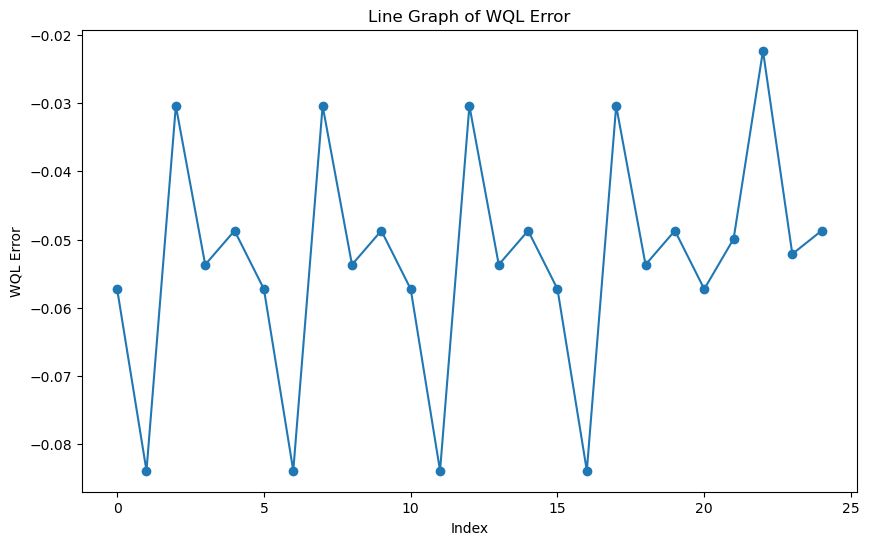

In [60]:
plt.figure(figsize=(10, 6))
plt.plot(errors_M_Finance["WQL_error"].values, marker='o', linestyle='-')
plt.xlabel("Index")
plt.ylabel("WQL Error")
plt.title("Line Graph of WQL Error")
plt.show()

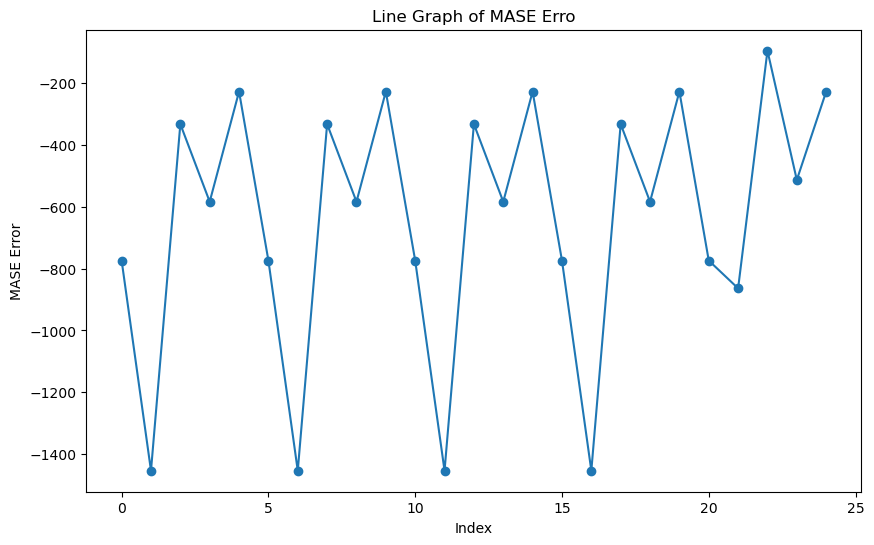

In [61]:
plt.figure(figsize=(10, 6))
plt.plot(errors_M_Finance["MASE_error"].values, marker='o', linestyle='-')
plt.xlabel("Index")
plt.ylabel("MASE Error")
plt.title("Line Graph of MASE Erro")
plt.show()

### Yearly

In [62]:
df_Finance_yearly = df_Finance_1.resample('YS').first().sort_index(ascending=True)

In [63]:
df_Finance_yearly.head()

item_id           timestamp  target
timestamp                                      
1983-01-01  T002046 1983-12-12 12:00:00  7324.4
1984-01-01  T002046 1984-01-01 12:00:00  7232.5
1985-01-01  T002046 1985-01-01 12:00:00  5845.1
1986-01-01  T002046 1986-01-01 12:00:00  5622.0
1987-01-01  T002046 1987-01-01 12:00:00  5696.6

In [64]:
len(df_Finance_yearly) 

25

In [65]:
df_Finance_yearly.index = pd.to_datetime(df_Finance_yearly.index).normalize()

In [66]:
df_Finance_yearly.dtypes

item_id      string[python]
timestamp    datetime64[ns]
target              float64
dtype: object

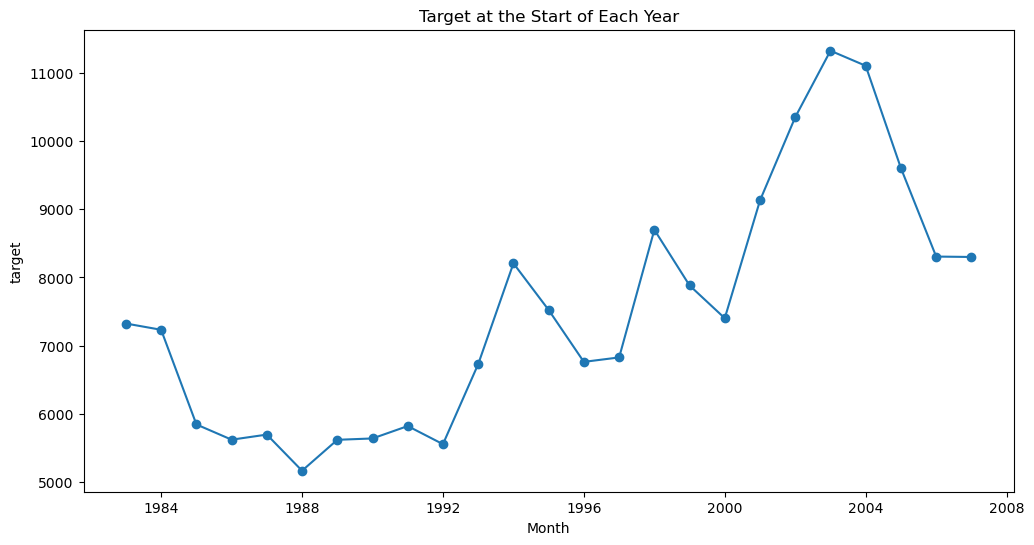

In [67]:
ts = df_Finance_yearly                   
x  = ts.index.get_level_values('timestamp')   # just the dates
y  = ts['target'].values                     # the values

plt.figure(figsize=(12, 6))
plt.plot(x, y, marker='o')
plt.title("Target at the Start of Each Year")
plt.xlabel("Month")
plt.ylabel("target")
plt.show()

In [68]:
errors_Y_Finance=get_errors_yr(df_Finance_yearly, frequ="B")

---------data len 25


Empty DataFrame
Columns: [Train_size, Percentage_train, Test_size, Percentage_test, MASE_error, Diference_MASE, WQL_error, Diference_WQL]
Index: []

Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193049'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.72 GB / 7.37 GB (9.7%)
Disk Space Avail:   4.38 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 5,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target

----------historical length 20
-----------history len, min and max 20 ('T002046', Timestamp('1983-12-12 12:00:00')) ('T002046', Timestamp('2002-01-01 12:00:00'))


	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 21:30:50
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.03 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193050'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.65 GB / 7.37 GB (8.8%)
Disk Space Avail:   4.38 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require m

---------beginning 0
---------total_length 25
----------training len 20
----------training                               target
item_id timestamp                   
T002046 2001-01-01 12:00:00   9130.6
        2002-01-01 12:00:00  10349.0
----------testing len 25
----------testtt                               target
item_id timestamp                   
T002046 2003-01-01 12:00:00  11322.2
        2004-01-01 12:00:00  11101.7
        2005-01-01 12:00:00   9599.8
        2006-01-01 12:00:00   8305.6
        2007-01-01 12:00:00   8299.7


Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]


-----------len predictions 5


mean          0.1          0.2  \
item_id timestamp                                                     
T002046 2003-01-01 12:00:00  10549.024414  9459.458984  9883.932617   
        2004-01-01 12:00:00  10344.737305  8992.912109  9553.798828   
        2005-01-01 12:00:00  10226.882812  8678.163086  9305.613281   
        2006-01-01 12:00:00  10140.610352  8442.327148  9122.650391   
        2007-01-01 12:00:00  10056.708008  8304.985352  8989.800781   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2003-01-01 12:00:00  10148.516602  10363.405273  10549.024414   
        2004-01-01 12:00:00   9870.877930  10125.756836  10344.737305   
        2005-01-01 12:00:00   9691.155273   9979.399414  10226.882812   
        2006-01-01 12:00:00   9545.369141   9868.609375  10140.610352   
        2007-01-01 12:00:00   9436.402344   9771.480469  10056.708008   

                                      0.6           0.7           0.8  \
item_id timestamp                                                       
T002046 2003-01-01 12:00:00  10740.820312  10958.197266  11229.249023   
        2004-01-01 12:00:00  10557.576172  10792.133789  11084.659180   
        2005-01-01 12:00:00  10471.523438  10729.370117  11056.173828   
        2006-01-01 12:00:00  10398.968750  10678.663086  11032.041016   
        2007-01-01 12:00:00  10335.428711  10634.841797  11016.136719   

                                      0.9  
item_id timestamp                          
T002046 2003-01-01 12:00:00  11689.381836  
        2004-01-01 12:00:00  11593.636719  
        2005-01-01 12:00:00  11613.681641  
        2006-01-01 12:00:00  11640.289062  
        2007-01-01 12:00:00  11650.873047

---len test slide 25


target
item_id timestamp                   
T002046 2003-01-01 12:00:00  11322.2
        2004-01-01 12:00:00  11101.7
        2005-01-01 12:00:00   9599.8
        2006-01-01 12:00:00   8305.6
        2007-01-01 12:00:00   8299.7

data with frequency 'IRREG' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'IRREG' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193056'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.62 GB / 7.37 GB (8.4%)
Disk Space Avail:   4.38 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eva

----------prediction_length 4
-----------history len, min and max 20 ('T002046', Timestamp('1983-12-12 12:00:00')) ('T002046', Timestamp('2002-01-01 12:00:00'))


Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.04 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193056-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.59 GB / 7.37 GB (8.0%)
Disk Space Avail:   4.38 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'p

---------beginning 0
---------total_length 24
----------training len 20
----------training                               target
item_id timestamp                   
T002046 2001-01-01 12:00:00   9130.6
        2002-01-01 12:00:00  10349.0
----------testing len 24
----------testtt                               target
item_id timestamp                   
T002046 2003-01-01 12:00:00  11322.2
        2004-01-01 12:00:00  11101.7
        2005-01-01 12:00:00   9599.8
        2006-01-01 12:00:00   8305.6
-----------len predictions 4


mean          0.1          0.2  \
item_id timestamp                                                     
T002046 2003-01-01 12:00:00  10549.024414  9459.458984  9883.932617   
        2004-01-01 12:00:00  10344.737305  8992.912109  9553.798828   
        2005-01-01 12:00:00  10226.882812  8678.163086  9305.613281   
        2006-01-01 12:00:00  10140.610352  8442.327148  9122.650391   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2003-01-01 12:00:00  10148.516602  10363.405273  10549.024414   
        2004-01-01 12:00:00   9870.877930  10125.756836  10344.737305   
        2005-01-01 12:00:00   9691.155273   9979.399414  10226.882812   
        2006-01-01 12:00:00   9545.369141   9868.609375  10140.610352   

                                      0.6           0.7           0.8  \
item_id timestamp                                                       
T002046 2003-01-01 12:00:00  10740.820312  10958.197266  11229.249023   
        2004-01-01 12:00:00  10557.576172  10792.133789  11084.659180   
        2005-01-01 12:00:00  10471.523438  10729.370117  11056.173828   
        2006-01-01 12:00:00  10398.968750  10678.663086  11032.041016   

                                      0.9  
item_id timestamp                          
T002046 2003-01-01 12:00:00  11689.381836  
        2004-01-01 12:00:00  11593.636719  
        2005-01-01 12:00:00  11613.681641  
        2006-01-01 12:00:00  11640.289062

---len test slide 24


target
item_id timestamp                   
T002046 2003-01-01 12:00:00  11322.2
        2004-01-01 12:00:00  11101.7
        2005-01-01 12:00:00   9599.8
        2006-01-01 12:00:00   8305.6

data with frequency 'IRREG' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'IRREG' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193103'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.55 GB / 7.37 GB (7.4%)
Disk Space Avail:   4.38 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eva

----------prediction_length 3
-----------history len, min and max 20 ('T002046', Timestamp('1983-12-12 12:00:00')) ('T002046', Timestamp('2002-01-01 12:00:00'))


	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 21:31:03
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.05 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193103-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.62 GB / 7.37 GB (8.4%)
Disk Space Avail:   4.38 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may requi

---------beginning 0
---------total_length 23
----------training len 20
----------training                               target
item_id timestamp                   
T002046 2001-01-01 12:00:00   9130.6
        2002-01-01 12:00:00  10349.0
----------testing len 23
----------testtt                               target
item_id timestamp                   
T002046 2003-01-01 12:00:00  11322.2
        2004-01-01 12:00:00  11101.7
        2005-01-01 12:00:00   9599.8
-----------len predictions 3


mean          0.1          0.2  \
item_id timestamp                                                     
T002046 2003-01-01 12:00:00  10549.024414  9459.458984  9883.932617   
        2004-01-01 12:00:00  10344.737305  8992.912109  9553.798828   
        2005-01-01 12:00:00  10226.882812  8678.163086  9305.613281   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2003-01-01 12:00:00  10148.516602  10363.405273  10549.024414   
        2004-01-01 12:00:00   9870.877930  10125.756836  10344.737305   
        2005-01-01 12:00:00   9691.155273   9979.399414  10226.882812   

                                      0.6           0.7           0.8  \
item_id timestamp                                                       
T002046 2003-01-01 12:00:00  10740.820312  10958.197266  11229.249023   
        2004-01-01 12:00:00  10557.576172  10792.133789  11084.659180   
        2005-01-01 12:00:00  10471.523438  10729.370117  11056.173828   

                                      0.9  
item_id timestamp                          
T002046 2003-01-01 12:00:00  11689.381836  
        2004-01-01 12:00:00  11593.636719  
        2005-01-01 12:00:00  11613.681641

---len test slide 23


target
item_id timestamp                   
T002046 2003-01-01 12:00:00  11322.2
        2004-01-01 12:00:00  11101.7
        2005-01-01 12:00:00   9599.8

data with frequency 'IRREG' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'IRREG' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193110'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.67 GB / 7.37 GB (9.0%)
Disk Space Avail:   4.38 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eva

----------prediction_length 2
-----------history len, min and max 20 ('T002046', Timestamp('1983-12-12 12:00:00')) ('T002046', Timestamp('2002-01-01 12:00:00'))


	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.03 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193110-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.66 GB / 7.37 GB (9.0%)
Disk Space Avail:   4.38 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 2,
 'quantile_levels': [0.1, 

---------beginning 0
---------total_length 22
----------training len 20
----------training                               target
item_id timestamp                   
T002046 2001-01-01 12:00:00   9130.6
        2002-01-01 12:00:00  10349.0
----------testing len 22
----------testtt                               target
item_id timestamp                   
T002046 2003-01-01 12:00:00  11322.2
        2004-01-01 12:00:00  11101.7
-----------len predictions 2


mean          0.1          0.2  \
item_id timestamp                                                     
T002046 2003-01-01 12:00:00  10549.024414  9459.458984  9883.932617   
        2004-01-01 12:00:00  10344.737305  8992.912109  9553.798828   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2003-01-01 12:00:00  10148.516602  10363.405273  10549.024414   
        2004-01-01 12:00:00   9870.877930  10125.756836  10344.737305   

                                      0.6           0.7           0.8  \
item_id timestamp                                                       
T002046 2003-01-01 12:00:00  10740.820312  10958.197266  11229.249023   
        2004-01-01 12:00:00  10557.576172  10792.133789  11084.659180   

                                      0.9  
item_id timestamp                          
T002046 2003-01-01 12:00:00  11689.381836  
        2004-01-01 12:00:00  11593.636719

---len test slide 22


target
item_id timestamp                   
T002046 2003-01-01 12:00:00  11322.2
        2004-01-01 12:00:00  11101.7

data with frequency 'IRREG' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'IRREG' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193117'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.61 GB / 7.37 GB (8.2%)
Disk Space Avail:   4.38 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eva

----------prediction_length 1
-----------history len, min and max 20 ('T002046', Timestamp('1983-12-12 12:00:00')) ('T002046', Timestamp('2002-01-01 12:00:00'))



Starting training. Start time is 2025-07-11 21:31:17
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.04 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193117-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.61 GB / 7.37 GB (8.2%)
Disk Space Avail:   4.38 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparame

---------beginning 0
---------total_length 21
----------training len 20
----------training                               target
item_id timestamp                   
T002046 2001-01-01 12:00:00   9130.6
        2002-01-01 12:00:00  10349.0
----------testing len 21
----------testtt                               target
item_id timestamp                   
T002046 2003-01-01 12:00:00  11322.2
-----------len predictions 1


mean          0.1          0.2  \
item_id timestamp                                                     
T002046 2003-01-01 12:00:00  10549.024414  9459.458984  9883.932617   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2003-01-01 12:00:00  10148.516602  10363.405273  10549.024414   

                                      0.6           0.7           0.8  \
item_id timestamp                                                       
T002046 2003-01-01 12:00:00  10740.820312  10958.197266  11229.249023   

                                      0.9  
item_id timestamp                          
T002046 2003-01-01 12:00:00  11689.381836

---len test slide 21


target
item_id timestamp                   
T002046 2003-01-01 12:00:00  11322.2

data with frequency 'IRREG' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'IRREG' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193124'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.66 GB / 7.37 GB (9.0%)
Disk Space Avail:   4.38 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eva

----------prediction_length 0
----------historical length 19
-----------history len, min and max 19 ('T002046', Timestamp('1984-01-01 12:00:00')) ('T002046', Timestamp('2002-01-01 12:00:00'))


Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.04 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193125'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.70 GB / 7.37 GB (9.5%)
Disk Space Avail:   4.38 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_

---------beginning 1
---------total_length 25
----------training len 19
----------training                               target
item_id timestamp                   
T002046 2001-01-01 12:00:00   9130.6
        2002-01-01 12:00:00  10349.0
----------testing len 24
----------testtt                               target
item_id timestamp                   
T002046 2003-01-01 12:00:00  11322.2
        2004-01-01 12:00:00  11101.7
        2005-01-01 12:00:00   9599.8
        2006-01-01 12:00:00   8305.6
        2007-01-01 12:00:00   8299.7
-----------len predictions 5


mean          0.1          0.2  \
item_id timestamp                                                     
T002046 2003-01-01 12:00:00  10549.024414  9459.458984  9883.932617   
        2004-01-01 12:00:00  10344.737305  8992.912109  9553.798828   
        2005-01-01 12:00:00  10226.882812  8678.163086  9305.613281   
        2006-01-01 12:00:00  10140.610352  8442.327148  9122.650391   
        2007-01-01 12:00:00  10056.708008  8304.985352  8989.800781   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2003-01-01 12:00:00  10148.516602  10363.405273  10549.024414   
        2004-01-01 12:00:00   9870.877930  10125.756836  10344.737305   
        2005-01-01 12:00:00   9691.155273   9979.399414  10226.882812   
        2006-01-01 12:00:00   9545.369141   9868.609375  10140.610352   
        2007-01-01 12:00:00   9436.402344   9771.480469  10056.708008   

                                      0.6           0.7           0.8  \
item_id timestamp                                                       
T002046 2003-01-01 12:00:00  10740.820312  10958.197266  11229.249023   
        2004-01-01 12:00:00  10557.576172  10792.133789  11084.659180   
        2005-01-01 12:00:00  10471.523438  10729.370117  11056.173828   
        2006-01-01 12:00:00  10398.968750  10678.663086  11032.041016   
        2007-01-01 12:00:00  10335.428711  10634.841797  11016.136719   

                                      0.9  
item_id timestamp                          
T002046 2003-01-01 12:00:00  11689.381836  
        2004-01-01 12:00:00  11593.636719  
        2005-01-01 12:00:00  11613.681641  
        2006-01-01 12:00:00  11640.289062  
        2007-01-01 12:00:00  11650.873047

---len test slide 24


target
item_id timestamp                   
T002046 2003-01-01 12:00:00  11322.2
        2004-01-01 12:00:00  11101.7
        2005-01-01 12:00:00   9599.8
        2006-01-01 12:00:00   8305.6
        2007-01-01 12:00:00   8299.7

data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193131'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.82 GB / 7.37 GB (11.1%)
Disk Space Avail:   4.38 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 '

----------prediction_length 4
-----------history len, min and max 19 ('T002046', Timestamp('1984-01-01 12:00:00')) ('T002046', Timestamp('2002-01-01 12:00:00'))


Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.04 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193131-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.80 GB / 7.37 GB (10.9%)
Disk Space Avail:   4.38 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 '

---------beginning 1
---------total_length 24
----------training len 19
----------training                               target
item_id timestamp                   
T002046 2001-01-01 12:00:00   9130.6
        2002-01-01 12:00:00  10349.0
----------testing len 23
----------testtt                               target
item_id timestamp                   
T002046 2003-01-01 12:00:00  11322.2
        2004-01-01 12:00:00  11101.7
        2005-01-01 12:00:00   9599.8
        2006-01-01 12:00:00   8305.6
-----------len predictions 4


mean          0.1          0.2  \
item_id timestamp                                                     
T002046 2003-01-01 12:00:00  10549.024414  9459.458984  9883.932617   
        2004-01-01 12:00:00  10344.737305  8992.912109  9553.798828   
        2005-01-01 12:00:00  10226.882812  8678.163086  9305.613281   
        2006-01-01 12:00:00  10140.610352  8442.327148  9122.650391   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2003-01-01 12:00:00  10148.516602  10363.405273  10549.024414   
        2004-01-01 12:00:00   9870.877930  10125.756836  10344.737305   
        2005-01-01 12:00:00   9691.155273   9979.399414  10226.882812   
        2006-01-01 12:00:00   9545.369141   9868.609375  10140.610352   

                                      0.6           0.7           0.8  \
item_id timestamp                                                       
T002046 2003-01-01 12:00:00  10740.820312  10958.197266  11229.249023   
        2004-01-01 12:00:00  10557.576172  10792.133789  11084.659180   
        2005-01-01 12:00:00  10471.523438  10729.370117  11056.173828   
        2006-01-01 12:00:00  10398.968750  10678.663086  11032.041016   

                                      0.9  
item_id timestamp                          
T002046 2003-01-01 12:00:00  11689.381836  
        2004-01-01 12:00:00  11593.636719  
        2005-01-01 12:00:00  11613.681641  
        2006-01-01 12:00:00  11640.289062

---len test slide 23


target
item_id timestamp                   
T002046 2003-01-01 12:00:00  11322.2
        2004-01-01 12:00:00  11101.7
        2005-01-01 12:00:00   9599.8
        2006-01-01 12:00:00   8305.6

data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193138'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.63 GB / 7.37 GB (8.6%)
Disk Space Avail:   4.38 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'e

----------prediction_length 3
-----------history len, min and max 19 ('T002046', Timestamp('1984-01-01 12:00:00')) ('T002046', Timestamp('2002-01-01 12:00:00'))



Starting training. Start time is 2025-07-11 21:31:38
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.04 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193138-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.60 GB / 7.37 GB (8.2%)
Disk Space Avail:   4.38 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparame

---------beginning 1
---------total_length 23
----------training len 19
----------training                               target
item_id timestamp                   
T002046 2001-01-01 12:00:00   9130.6
        2002-01-01 12:00:00  10349.0
----------testing len 22
----------testtt                               target
item_id timestamp                   
T002046 2003-01-01 12:00:00  11322.2
        2004-01-01 12:00:00  11101.7
        2005-01-01 12:00:00   9599.8
-----------len predictions 3


mean          0.1          0.2  \
item_id timestamp                                                     
T002046 2003-01-01 12:00:00  10549.024414  9459.458984  9883.932617   
        2004-01-01 12:00:00  10344.737305  8992.912109  9553.798828   
        2005-01-01 12:00:00  10226.882812  8678.163086  9305.613281   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2003-01-01 12:00:00  10148.516602  10363.405273  10549.024414   
        2004-01-01 12:00:00   9870.877930  10125.756836  10344.737305   
        2005-01-01 12:00:00   9691.155273   9979.399414  10226.882812   

                                      0.6           0.7           0.8  \
item_id timestamp                                                       
T002046 2003-01-01 12:00:00  10740.820312  10958.197266  11229.249023   
        2004-01-01 12:00:00  10557.576172  10792.133789  11084.659180   
        2005-01-01 12:00:00  10471.523438  10729.370117  11056.173828   

                                      0.9  
item_id timestamp                          
T002046 2003-01-01 12:00:00  11689.381836  
        2004-01-01 12:00:00  11593.636719  
        2005-01-01 12:00:00  11613.681641

---len test slide 22


target
item_id timestamp                   
T002046 2003-01-01 12:00:00  11322.2
        2004-01-01 12:00:00  11101.7
        2005-01-01 12:00:00   9599.8

data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193145'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.57 GB / 7.37 GB (7.8%)
Disk Space Avail:   4.37 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'e

----------prediction_length 2
-----------history len, min and max 19 ('T002046', Timestamp('1984-01-01 12:00:00')) ('T002046', Timestamp('2002-01-01 12:00:00'))


	0.00    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.05 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193145-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.57 GB / 7.37 GB (7.7%)
Disk Space Avail:   4.37 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 2,
 'quantile_levels': [0.1, 

---------beginning 1
---------total_length 22
----------training len 19
----------training                               target
item_id timestamp                   
T002046 2001-01-01 12:00:00   9130.6
        2002-01-01 12:00:00  10349.0
----------testing len 21
----------testtt                               target
item_id timestamp                   
T002046 2003-01-01 12:00:00  11322.2
        2004-01-01 12:00:00  11101.7
-----------len predictions 2


mean          0.1          0.2  \
item_id timestamp                                                     
T002046 2003-01-01 12:00:00  10549.024414  9459.458984  9883.932617   
        2004-01-01 12:00:00  10344.737305  8992.912109  9553.798828   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2003-01-01 12:00:00  10148.516602  10363.405273  10549.024414   
        2004-01-01 12:00:00   9870.877930  10125.756836  10344.737305   

                                      0.6           0.7           0.8  \
item_id timestamp                                                       
T002046 2003-01-01 12:00:00  10740.820312  10958.197266  11229.249023   
        2004-01-01 12:00:00  10557.576172  10792.133789  11084.659180   

                                      0.9  
item_id timestamp                          
T002046 2003-01-01 12:00:00  11689.381836  
        2004-01-01 12:00:00  11593.636719

---len test slide 21


target
item_id timestamp                   
T002046 2003-01-01 12:00:00  11322.2
        2004-01-01 12:00:00  11101.7

data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193151'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.56 GB / 7.37 GB (7.6%)
Disk Space Avail:   4.37 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'e

----------prediction_length 1
-----------history len, min and max 19 ('T002046', Timestamp('1984-01-01 12:00:00')) ('T002046', Timestamp('2002-01-01 12:00:00'))


Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.04 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193151-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.56 GB / 7.37 GB (7.6%)
Disk Space Avail:   4.37 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 1,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,

---------beginning 1
---------total_length 21
----------training len 19
----------training                               target
item_id timestamp                   
T002046 2001-01-01 12:00:00   9130.6
        2002-01-01 12:00:00  10349.0
----------testing len 20
----------testtt                               target
item_id timestamp                   
T002046 2003-01-01 12:00:00  11322.2
-----------len predictions 1


mean          0.1          0.2  \
item_id timestamp                                                     
T002046 2003-01-01 12:00:00  10549.024414  9459.458984  9883.932617   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2003-01-01 12:00:00  10148.516602  10363.405273  10549.024414   

                                      0.6           0.7           0.8  \
item_id timestamp                                                       
T002046 2003-01-01 12:00:00  10740.820312  10958.197266  11229.249023   

                                      0.9  
item_id timestamp                          
T002046 2003-01-01 12:00:00  11689.381836

---len test slide 20


target
item_id timestamp                   
T002046 2003-01-01 12:00:00  11322.2

data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193158'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.43 GB / 7.37 GB (5.8%)
Disk Space Avail:   4.37 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'e

----------prediction_length 0
----------historical length 15
-----------history len, min and max 15 ('T002046', Timestamp('1988-01-01 12:00:00')) ('T002046', Timestamp('2002-01-01 12:00:00'))



Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 21:31:59
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.03 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193159'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.42 GB / 7.37 GB (5.7

---------beginning 5
---------total_length 25
----------training len 15
----------training                               target
item_id timestamp                   
T002046 2001-01-01 12:00:00   9130.6
        2002-01-01 12:00:00  10349.0
----------testing len 20
----------testtt                               target
item_id timestamp                   
T002046 2003-01-01 12:00:00  11322.2
        2004-01-01 12:00:00  11101.7
        2005-01-01 12:00:00   9599.8
        2006-01-01 12:00:00   8305.6
        2007-01-01 12:00:00   8299.7
-----------len predictions 5


mean          0.1          0.2  \
item_id timestamp                                                     
T002046 2003-01-01 12:00:00  10549.024414  9459.458984  9883.932617   
        2004-01-01 12:00:00  10344.737305  8992.912109  9553.798828   
        2005-01-01 12:00:00  10226.882812  8678.163086  9305.613281   
        2006-01-01 12:00:00  10140.610352  8442.327148  9122.650391   
        2007-01-01 12:00:00  10056.708008  8304.985352  8989.800781   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2003-01-01 12:00:00  10148.516602  10363.405273  10549.024414   
        2004-01-01 12:00:00   9870.877930  10125.756836  10344.737305   
        2005-01-01 12:00:00   9691.155273   9979.399414  10226.882812   
        2006-01-01 12:00:00   9545.369141   9868.609375  10140.610352   
        2007-01-01 12:00:00   9436.402344   9771.480469  10056.708008   

                                      0.6           0.7           0.8  \
item_id timestamp                                                       
T002046 2003-01-01 12:00:00  10740.820312  10958.197266  11229.249023   
        2004-01-01 12:00:00  10557.576172  10792.133789  11084.659180   
        2005-01-01 12:00:00  10471.523438  10729.370117  11056.173828   
        2006-01-01 12:00:00  10398.968750  10678.663086  11032.041016   
        2007-01-01 12:00:00  10335.428711  10634.841797  11016.136719   

                                      0.9  
item_id timestamp                          
T002046 2003-01-01 12:00:00  11689.381836  
        2004-01-01 12:00:00  11593.636719  
        2005-01-01 12:00:00  11613.681641  
        2006-01-01 12:00:00  11640.289062  
        2007-01-01 12:00:00  11650.873047

---len test slide 20


target
item_id timestamp                   
T002046 2003-01-01 12:00:00  11322.2
        2004-01-01 12:00:00  11101.7
        2005-01-01 12:00:00   9599.8
        2006-01-01 12:00:00   8305.6
        2007-01-01 12:00:00   8299.7

data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193205'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.34 GB / 7.37 GB (4.6%)
Disk Space Avail:   4.35 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'e

----------prediction_length 4
-----------history len, min and max 15 ('T002046', Timestamp('1988-01-01 12:00:00')) ('T002046', Timestamp('2002-01-01 12:00:00'))


Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.04 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193205-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.37 GB / 7.37 GB (5.0%)
Disk Space Avail:   4.35 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'kn

---------beginning 5
---------total_length 24
----------training len 15
----------training                               target
item_id timestamp                   
T002046 2001-01-01 12:00:00   9130.6
        2002-01-01 12:00:00  10349.0
----------testing len 19
----------testtt                               target
item_id timestamp                   
T002046 2003-01-01 12:00:00  11322.2
        2004-01-01 12:00:00  11101.7
        2005-01-01 12:00:00   9599.8
        2006-01-01 12:00:00   8305.6
-----------len predictions 4


mean          0.1          0.2  \
item_id timestamp                                                     
T002046 2003-01-01 12:00:00  10549.024414  9459.458984  9883.932617   
        2004-01-01 12:00:00  10344.737305  8992.912109  9553.798828   
        2005-01-01 12:00:00  10226.882812  8678.163086  9305.613281   
        2006-01-01 12:00:00  10140.610352  8442.327148  9122.650391   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2003-01-01 12:00:00  10148.516602  10363.405273  10549.024414   
        2004-01-01 12:00:00   9870.877930  10125.756836  10344.737305   
        2005-01-01 12:00:00   9691.155273   9979.399414  10226.882812   
        2006-01-01 12:00:00   9545.369141   9868.609375  10140.610352   

                                      0.6           0.7           0.8  \
item_id timestamp                                                       
T002046 2003-01-01 12:00:00  10740.820312  10958.197266  11229.249023   
        2004-01-01 12:00:00  10557.576172  10792.133789  11084.659180   
        2005-01-01 12:00:00  10471.523438  10729.370117  11056.173828   
        2006-01-01 12:00:00  10398.968750  10678.663086  11032.041016   

                                      0.9  
item_id timestamp                          
T002046 2003-01-01 12:00:00  11689.381836  
        2004-01-01 12:00:00  11593.636719  
        2005-01-01 12:00:00  11613.681641  
        2006-01-01 12:00:00  11640.289062

---len test slide 19


target
item_id timestamp                   
T002046 2003-01-01 12:00:00  11322.2
        2004-01-01 12:00:00  11101.7
        2005-01-01 12:00:00   9599.8
        2006-01-01 12:00:00   8305.6

data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193211'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.34 GB / 7.37 GB (4.6%)
Disk Space Avail:   4.35 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'e

----------prediction_length 3
-----------history len, min and max 15 ('T002046', Timestamp('1988-01-01 12:00:00')) ('T002046', Timestamp('2002-01-01 12:00:00'))


	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 21:32:11
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.00    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.03 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193211-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.36 GB / 7.37 GB (4.9%)
Disk Space Avail:   4.35 GB / 475.75

---------beginning 5
---------total_length 23
----------training len 15
----------training                               target
item_id timestamp                   
T002046 2001-01-01 12:00:00   9130.6
        2002-01-01 12:00:00  10349.0
----------testing len 18
----------testtt                               target
item_id timestamp                   
T002046 2003-01-01 12:00:00  11322.2
        2004-01-01 12:00:00  11101.7
        2005-01-01 12:00:00   9599.8
-----------len predictions 3


mean          0.1          0.2  \
item_id timestamp                                                     
T002046 2003-01-01 12:00:00  10549.024414  9459.458984  9883.932617   
        2004-01-01 12:00:00  10344.737305  8992.912109  9553.798828   
        2005-01-01 12:00:00  10226.882812  8678.163086  9305.613281   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2003-01-01 12:00:00  10148.516602  10363.405273  10549.024414   
        2004-01-01 12:00:00   9870.877930  10125.756836  10344.737305   
        2005-01-01 12:00:00   9691.155273   9979.399414  10226.882812   

                                      0.6           0.7           0.8  \
item_id timestamp                                                       
T002046 2003-01-01 12:00:00  10740.820312  10958.197266  11229.249023   
        2004-01-01 12:00:00  10557.576172  10792.133789  11084.659180   
        2005-01-01 12:00:00  10471.523438  10729.370117  11056.173828   

                                      0.9  
item_id timestamp                          
T002046 2003-01-01 12:00:00  11689.381836  
        2004-01-01 12:00:00  11593.636719  
        2005-01-01 12:00:00  11613.681641

---len test slide 18


target
item_id timestamp                   
T002046 2003-01-01 12:00:00  11322.2
        2004-01-01 12:00:00  11101.7
        2005-01-01 12:00:00   9599.8

data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193217'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.34 GB / 7.37 GB (4.7%)
Disk Space Avail:   4.35 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'e

----------prediction_length 2
-----------history len, min and max 15 ('T002046', Timestamp('1988-01-01 12:00:00')) ('T002046', Timestamp('2002-01-01 12:00:00'))


Training timeseries model Chronos[bolt_small]. 
	0.00    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.04 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193217-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.37 GB / 7.37 GB (5.0%)
Disk Space Avail:   4.35 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'p

---------beginning 5
---------total_length 22
----------training len 15
----------training                               target
item_id timestamp                   
T002046 2001-01-01 12:00:00   9130.6
        2002-01-01 12:00:00  10349.0
----------testing len 17
----------testtt                               target
item_id timestamp                   
T002046 2003-01-01 12:00:00  11322.2
        2004-01-01 12:00:00  11101.7
-----------len predictions 2


mean          0.1          0.2  \
item_id timestamp                                                     
T002046 2003-01-01 12:00:00  10549.024414  9459.458984  9883.932617   
        2004-01-01 12:00:00  10344.737305  8992.912109  9553.798828   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2003-01-01 12:00:00  10148.516602  10363.405273  10549.024414   
        2004-01-01 12:00:00   9870.877930  10125.756836  10344.737305   

                                      0.6           0.7           0.8  \
item_id timestamp                                                       
T002046 2003-01-01 12:00:00  10740.820312  10958.197266  11229.249023   
        2004-01-01 12:00:00  10557.576172  10792.133789  11084.659180   

                                      0.9  
item_id timestamp                          
T002046 2003-01-01 12:00:00  11689.381836  
        2004-01-01 12:00:00  11593.636719

---len test slide 17


target
item_id timestamp                   
T002046 2003-01-01 12:00:00  11322.2
        2004-01-01 12:00:00  11101.7

data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193224'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.55 GB / 7.37 GB (7.5%)
Disk Space Avail:   4.35 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'e

----------prediction_length 1
-----------history len, min and max 15 ('T002046', Timestamp('1988-01-01 12:00:00')) ('T002046', Timestamp('2002-01-01 12:00:00'))



Starting training. Start time is 2025-07-11 21:32:24
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.00    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.05 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193224-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.63 GB / 7.37 GB (8.6%)
Disk Space Avail:   4.35 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparame

---------beginning 5
---------total_length 21
----------training len 15
----------training                               target
item_id timestamp                   
T002046 2001-01-01 12:00:00   9130.6
        2002-01-01 12:00:00  10349.0
----------testing len 16
----------testtt                               target
item_id timestamp                   
T002046 2003-01-01 12:00:00  11322.2
-----------len predictions 1


mean          0.1          0.2  \
item_id timestamp                                                     
T002046 2003-01-01 12:00:00  10549.024414  9459.458984  9883.932617   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2003-01-01 12:00:00  10148.516602  10363.405273  10549.024414   

                                      0.6           0.7           0.8  \
item_id timestamp                                                       
T002046 2003-01-01 12:00:00  10740.820312  10958.197266  11229.249023   

                                      0.9  
item_id timestamp                          
T002046 2003-01-01 12:00:00  11689.381836

---len test slide 16


target
item_id timestamp                   
T002046 2003-01-01 12:00:00  11322.2

data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193232'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.56 GB / 7.37 GB (7.6%)
Disk Space Avail:   4.35 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'e

----------prediction_length 0
----------historical length 10
-----------history len, min and max 10 ('T002046', Timestamp('1993-01-01 12:00:00')) ('T002046', Timestamp('2002-01-01 12:00:00'))


Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193232-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.56 GB / 7.37 GB (7.6%)
Disk Space Avail:   4.35 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 5,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 '

---------beginning 10
---------total_length 25
----------training len 10
----------training                               target
item_id timestamp                   
T002046 2001-01-01 12:00:00   9130.6
        2002-01-01 12:00:00  10349.0
----------testing len 15
----------testtt                               target
item_id timestamp                   
T002046 2003-01-01 12:00:00  11322.2
        2004-01-01 12:00:00  11101.7
        2005-01-01 12:00:00   9599.8
        2006-01-01 12:00:00   8305.6
        2007-01-01 12:00:00   8299.7
-----------len predictions 5


mean          0.1          0.2  \
item_id timestamp                                                     
T002046 2003-01-01 12:00:00  10549.024414  9459.458984  9883.932617   
        2004-01-01 12:00:00  10344.737305  8992.912109  9553.798828   
        2005-01-01 12:00:00  10226.882812  8678.163086  9305.613281   
        2006-01-01 12:00:00  10140.610352  8442.327148  9122.650391   
        2007-01-01 12:00:00  10056.708008  8304.985352  8989.800781   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2003-01-01 12:00:00  10148.516602  10363.405273  10549.024414   
        2004-01-01 12:00:00   9870.877930  10125.756836  10344.737305   
        2005-01-01 12:00:00   9691.155273   9979.399414  10226.882812   
        2006-01-01 12:00:00   9545.369141   9868.609375  10140.610352   
        2007-01-01 12:00:00   9436.402344   9771.480469  10056.708008   

                                      0.6           0.7           0.8  \
item_id timestamp                                                       
T002046 2003-01-01 12:00:00  10740.820312  10958.197266  11229.249023   
        2004-01-01 12:00:00  10557.576172  10792.133789  11084.659180   
        2005-01-01 12:00:00  10471.523438  10729.370117  11056.173828   
        2006-01-01 12:00:00  10398.968750  10678.663086  11032.041016   
        2007-01-01 12:00:00  10335.428711  10634.841797  11016.136719   

                                      0.9  
item_id timestamp                          
T002046 2003-01-01 12:00:00  11689.381836  
        2004-01-01 12:00:00  11593.636719  
        2005-01-01 12:00:00  11613.681641  
        2006-01-01 12:00:00  11640.289062  
        2007-01-01 12:00:00  11650.873047

---len test slide 15


target
item_id timestamp                   
T002046 2003-01-01 12:00:00  11322.2
        2004-01-01 12:00:00  11101.7
        2005-01-01 12:00:00   9599.8
        2006-01-01 12:00:00   8305.6
        2007-01-01 12:00:00   8299.7

data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193239'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.43 GB / 7.37 GB (5.8%)
Disk Space Avail:   4.35 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'e

----------prediction_length 4
-----------history len, min and max 10 ('T002046', Timestamp('1993-01-01 12:00:00')) ('T002046', Timestamp('2002-01-01 12:00:00'))



AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 21:32:39
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.00    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.03 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193239-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.43 GB / 7.37 GB (5.8%)
Disk Space Avail:   4.35 GB / 475.75 GB (0.9%)
	We rec

---------beginning 10
---------total_length 24
----------training len 10
----------training                               target
item_id timestamp                   
T002046 2001-01-01 12:00:00   9130.6
        2002-01-01 12:00:00  10349.0
----------testing len 14
----------testtt                               target
item_id timestamp                   
T002046 2003-01-01 12:00:00  11322.2
        2004-01-01 12:00:00  11101.7
        2005-01-01 12:00:00   9599.8
        2006-01-01 12:00:00   8305.6
-----------len predictions 4


mean          0.1          0.2  \
item_id timestamp                                                     
T002046 2003-01-01 12:00:00  10549.024414  9459.458984  9883.932617   
        2004-01-01 12:00:00  10344.737305  8992.912109  9553.798828   
        2005-01-01 12:00:00  10226.882812  8678.163086  9305.613281   
        2006-01-01 12:00:00  10140.610352  8442.327148  9122.650391   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2003-01-01 12:00:00  10148.516602  10363.405273  10549.024414   
        2004-01-01 12:00:00   9870.877930  10125.756836  10344.737305   
        2005-01-01 12:00:00   9691.155273   9979.399414  10226.882812   
        2006-01-01 12:00:00   9545.369141   9868.609375  10140.610352   

                                      0.6           0.7           0.8  \
item_id timestamp                                                       
T002046 2003-01-01 12:00:00  10740.820312  10958.197266  11229.249023   
        2004-01-01 12:00:00  10557.576172  10792.133789  11084.659180   
        2005-01-01 12:00:00  10471.523438  10729.370117  11056.173828   
        2006-01-01 12:00:00  10398.968750  10678.663086  11032.041016   

                                      0.9  
item_id timestamp                          
T002046 2003-01-01 12:00:00  11689.381836  
        2004-01-01 12:00:00  11593.636719  
        2005-01-01 12:00:00  11613.681641  
        2006-01-01 12:00:00  11640.289062

---len test slide 14


target
item_id timestamp                   
T002046 2003-01-01 12:00:00  11322.2
        2004-01-01 12:00:00  11101.7
        2005-01-01 12:00:00   9599.8
        2006-01-01 12:00:00   8305.6

data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193245'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.46 GB / 7.37 GB (6.3%)
Disk Space Avail:   4.35 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'e

----------prediction_length 3
-----------history len, min and max 10 ('T002046', Timestamp('1993-01-01 12:00:00')) ('T002046', Timestamp('2002-01-01 12:00:00'))


AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193246'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.47 GB / 7.37 GB (6.4%)
Disk Space Avail:   4.35 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 3,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}



---------beginning 10
---------total_length 23
----------training len 10
----------training                               target
item_id timestamp                   
T002046 2001-01-01 12:00:00   9130.6
        2002-01-01 12:00:00  10349.0
----------testing len 13
----------testtt                               target
item_id timestamp                   
T002046 2003-01-01 12:00:00  11322.2
        2004-01-01 12:00:00  11101.7
        2005-01-01 12:00:00   9599.8
-----------len predictions 3


mean          0.1          0.2  \
item_id timestamp                                                     
T002046 2003-01-01 12:00:00  10549.024414  9459.458984  9883.932617   
        2004-01-01 12:00:00  10344.737305  8992.912109  9553.798828   
        2005-01-01 12:00:00  10226.882812  8678.163086  9305.613281   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2003-01-01 12:00:00  10148.516602  10363.405273  10549.024414   
        2004-01-01 12:00:00   9870.877930  10125.756836  10344.737305   
        2005-01-01 12:00:00   9691.155273   9979.399414  10226.882812   

                                      0.6           0.7           0.8  \
item_id timestamp                                                       
T002046 2003-01-01 12:00:00  10740.820312  10958.197266  11229.249023   
        2004-01-01 12:00:00  10557.576172  10792.133789  11084.659180   
        2005-01-01 12:00:00  10471.523438  10729.370117  11056.173828   

                                      0.9  
item_id timestamp                          
T002046 2003-01-01 12:00:00  11689.381836  
        2004-01-01 12:00:00  11593.636719  
        2005-01-01 12:00:00  11613.681641

---len test slide 13


target
item_id timestamp                   
T002046 2003-01-01 12:00:00  11322.2
        2004-01-01 12:00:00  11101.7
        2005-01-01 12:00:00   9599.8

data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193252'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.64 GB / 7.37 GB (8.7%)
Disk Space Avail:   4.35 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'e

----------prediction_length 2
-----------history len, min and max 10 ('T002046', Timestamp('1993-01-01 12:00:00')) ('T002046', Timestamp('2002-01-01 12:00:00'))



Starting training. Start time is 2025-07-11 21:32:52
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.00    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.07 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193252-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.69 GB / 7.37 GB (9.4%)
Disk Space Avail:   4.35 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparame

---------beginning 10
---------total_length 22
----------training len 10
----------training                               target
item_id timestamp                   
T002046 2001-01-01 12:00:00   9130.6
        2002-01-01 12:00:00  10349.0
----------testing len 12
----------testtt                               target
item_id timestamp                   
T002046 2003-01-01 12:00:00  11322.2
        2004-01-01 12:00:00  11101.7
-----------len predictions 2


mean          0.1          0.2  \
item_id timestamp                                                     
T002046 2003-01-01 12:00:00  10549.024414  9459.458984  9883.932617   
        2004-01-01 12:00:00  10344.737305  8992.912109  9553.798828   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2003-01-01 12:00:00  10148.516602  10363.405273  10549.024414   
        2004-01-01 12:00:00   9870.877930  10125.756836  10344.737305   

                                      0.6           0.7           0.8  \
item_id timestamp                                                       
T002046 2003-01-01 12:00:00  10740.820312  10958.197266  11229.249023   
        2004-01-01 12:00:00  10557.576172  10792.133789  11084.659180   

                                      0.9  
item_id timestamp                          
T002046 2003-01-01 12:00:00  11689.381836  
        2004-01-01 12:00:00  11593.636719

---len test slide 12


target
item_id timestamp                   
T002046 2003-01-01 12:00:00  11322.2
        2004-01-01 12:00:00  11101.7

data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193300'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.60 GB / 7.37 GB (8.2%)
Disk Space Avail:   4.35 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'e

----------prediction_length 1
-----------history len, min and max 10 ('T002046', Timestamp('1993-01-01 12:00:00')) ('T002046', Timestamp('2002-01-01 12:00:00'))


	0.02    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.05 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193300-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.60 GB / 7.37 GB (8.2%)
Disk Space Avail:   4.35 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 1,
 'quantile_levels': [0.1, 

---------beginning 10
---------total_length 21
----------training len 10
----------training                               target
item_id timestamp                   
T002046 2001-01-01 12:00:00   9130.6
        2002-01-01 12:00:00  10349.0
----------testing len 11
----------testtt                               target
item_id timestamp                   
T002046 2003-01-01 12:00:00  11322.2
-----------len predictions 1


mean          0.1          0.2  \
item_id timestamp                                                     
T002046 2003-01-01 12:00:00  10549.024414  9459.458984  9883.932617   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2003-01-01 12:00:00  10148.516602  10363.405273  10549.024414   

                                      0.6           0.7           0.8  \
item_id timestamp                                                       
T002046 2003-01-01 12:00:00  10740.820312  10958.197266  11229.249023   

                                      0.9  
item_id timestamp                          
T002046 2003-01-01 12:00:00  11689.381836

---len test slide 11


target
item_id timestamp                   
T002046 2003-01-01 12:00:00  11322.2

data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193308'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.49 GB / 7.37 GB (6.7%)
Disk Space Avail:   4.35 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'e

----------prediction_length 0
----------historical length 5
-----------history len, min and max 5 ('T002046', Timestamp('1998-01-01 12:00:00')) ('T002046', Timestamp('2002-01-01 12:00:00'))


Total runtime: 0.05 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193308-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.49 GB / 7.37 GB (6.7%)
Disk Space Avail:   4.34 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 5,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 '

---------beginning 15
---------total_length 25
----------training len 5
----------training                               target
item_id timestamp                   
T002046 2001-01-01 12:00:00   9130.6
        2002-01-01 12:00:00  10349.0
----------testing len 10
----------testtt                               target
item_id timestamp                   
T002046 2003-01-01 12:00:00  11322.2
        2004-01-01 12:00:00  11101.7
        2005-01-01 12:00:00   9599.8
        2006-01-01 12:00:00   8305.6
        2007-01-01 12:00:00   8299.7
-----------len predictions 5


mean          0.1          0.2  \
item_id timestamp                                                     
T002046 2003-01-01 12:00:00  10492.808594  9540.639648  9918.569336   
        2004-01-01 12:00:00  10318.206055  9127.935547  9623.702148   
        2005-01-01 12:00:00  10241.540039  8876.867188  9429.851562   
        2006-01-01 12:00:00  10192.449219  8696.162109  9297.210938   
        2007-01-01 12:00:00  10121.868164  8572.737305  9180.504883   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2003-01-01 12:00:00  10149.692383  10333.876953  10492.808594   
        2004-01-01 12:00:00   9904.024414  10126.900391  10318.206055   
        2005-01-01 12:00:00   9770.001953  10022.476562  10241.540039   
        2006-01-01 12:00:00   9669.607422   9953.296875  10192.449219   
        2007-01-01 12:00:00   9575.323242   9870.027344  10121.868164   

                                      0.6           0.7           0.8  \
item_id timestamp                                                       
T002046 2003-01-01 12:00:00  10656.206055  10839.462891  11067.638672   
        2004-01-01 12:00:00  10503.950195  10707.512695  10960.336914   
        2005-01-01 12:00:00  10455.825195  10681.196289  10965.385742   
        2006-01-01 12:00:00  10418.130859  10660.850586  10970.287109   
        2007-01-01 12:00:00  10367.234375  10631.772461  10967.652344   

                                      0.9  
item_id timestamp                          
T002046 2003-01-01 12:00:00  11461.951172  
        2004-01-01 12:00:00  11405.931641  
        2005-01-01 12:00:00  11459.893555  
        2006-01-01 12:00:00  11515.153320  
        2007-01-01 12:00:00  11540.354492

---len test slide 10


target
item_id timestamp                   
T002046 2003-01-01 12:00:00  11322.2
        2004-01-01 12:00:00  11101.7
        2005-01-01 12:00:00   9599.8
        2006-01-01 12:00:00   8305.6
        2007-01-01 12:00:00   8299.7

data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193316'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.29 GB / 7.37 GB (3.9%)
Disk Space Avail:   4.34 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'e

----------prediction_length 4
-----------history len, min and max 5 ('T002046', Timestamp('1998-01-01 12:00:00')) ('T002046', Timestamp('2002-01-01 12:00:00'))


AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193317'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.32 GB / 7.37 GB (4.4%)
Disk Space Avail:   4.34 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 4,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}



---------beginning 15
---------total_length 24
----------training len 5
----------training                               target
item_id timestamp                   
T002046 2001-01-01 12:00:00   9130.6
        2002-01-01 12:00:00  10349.0
----------testing len 9
----------testtt                               target
item_id timestamp                   
T002046 2003-01-01 12:00:00  11322.2
        2004-01-01 12:00:00  11101.7
        2005-01-01 12:00:00   9599.8
        2006-01-01 12:00:00   8305.6
-----------len predictions 4


mean          0.1          0.2  \
item_id timestamp                                                     
T002046 2003-01-01 12:00:00  10492.808594  9540.639648  9918.569336   
        2004-01-01 12:00:00  10318.206055  9127.935547  9623.702148   
        2005-01-01 12:00:00  10241.540039  8876.867188  9429.851562   
        2006-01-01 12:00:00  10192.449219  8696.162109  9297.210938   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2003-01-01 12:00:00  10149.692383  10333.876953  10492.808594   
        2004-01-01 12:00:00   9904.024414  10126.900391  10318.206055   
        2005-01-01 12:00:00   9770.001953  10022.476562  10241.540039   
        2006-01-01 12:00:00   9669.607422   9953.296875  10192.449219   

                                      0.6           0.7           0.8  \
item_id timestamp                                                       
T002046 2003-01-01 12:00:00  10656.206055  10839.462891  11067.638672   
        2004-01-01 12:00:00  10503.950195  10707.512695  10960.336914   
        2005-01-01 12:00:00  10455.825195  10681.196289  10965.385742   
        2006-01-01 12:00:00  10418.130859  10660.850586  10970.287109   

                                      0.9  
item_id timestamp                          
T002046 2003-01-01 12:00:00  11461.951172  
        2004-01-01 12:00:00  11405.931641  
        2005-01-01 12:00:00  11459.893555  
        2006-01-01 12:00:00  11515.153320

---len test slide 9


target
item_id timestamp                   
T002046 2003-01-01 12:00:00  11322.2
        2004-01-01 12:00:00  11101.7
        2005-01-01 12:00:00   9599.8
        2006-01-01 12:00:00   8305.6

data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193324'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.76 GB / 7.37 GB (10.3%)
Disk Space Avail:   4.34 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 '

----------prediction_length 3
-----------history len, min and max 5 ('T002046', Timestamp('1998-01-01 12:00:00')) ('T002046', Timestamp('2002-01-01 12:00:00'))


	0.02    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.05 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193324-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.84 GB / 7.37 GB (11.4%)
Disk Space Avail:   4.34 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 3,
 'quantile_levels': [0.1,

---------beginning 15
---------total_length 23
----------training len 5
----------training                               target
item_id timestamp                   
T002046 2001-01-01 12:00:00   9130.6
        2002-01-01 12:00:00  10349.0
----------testing len 8
----------testtt                               target
item_id timestamp                   
T002046 2003-01-01 12:00:00  11322.2
        2004-01-01 12:00:00  11101.7
        2005-01-01 12:00:00   9599.8
-----------len predictions 3


mean          0.1          0.2  \
item_id timestamp                                                     
T002046 2003-01-01 12:00:00  10492.808594  9540.639648  9918.569336   
        2004-01-01 12:00:00  10318.206055  9127.935547  9623.702148   
        2005-01-01 12:00:00  10241.540039  8876.867188  9429.851562   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2003-01-01 12:00:00  10149.692383  10333.876953  10492.808594   
        2004-01-01 12:00:00   9904.024414  10126.900391  10318.206055   
        2005-01-01 12:00:00   9770.001953  10022.476562  10241.540039   

                                      0.6           0.7           0.8  \
item_id timestamp                                                       
T002046 2003-01-01 12:00:00  10656.206055  10839.462891  11067.638672   
        2004-01-01 12:00:00  10503.950195  10707.512695  10960.336914   
        2005-01-01 12:00:00  10455.825195  10681.196289  10965.385742   

                                      0.9  
item_id timestamp                          
T002046 2003-01-01 12:00:00  11461.951172  
        2004-01-01 12:00:00  11405.931641  
        2005-01-01 12:00:00  11459.893555

---len test slide 8


target
item_id timestamp                   
T002046 2003-01-01 12:00:00  11322.2
        2004-01-01 12:00:00  11101.7
        2005-01-01 12:00:00   9599.8

data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193332'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.84 GB / 7.37 GB (11.4%)
Disk Space Avail:   4.34 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 '

----------prediction_length 2
-----------history len, min and max 5 ('T002046', Timestamp('1998-01-01 12:00:00')) ('T002046', Timestamp('2002-01-01 12:00:00'))



Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 2,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

train_data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Provided train_data has 1044 rows (NaN fraction=99.5%), 1 time series. Median time series length is 1044 (min=1044, max=1044). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'MASE'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 21:33:32
Models that will be trained: [

---------beginning 15
---------total_length 22
----------training len 5
----------training                               target
item_id timestamp                   
T002046 2001-01-01 12:00:00   9130.6
        2002-01-01 12:00:00  10349.0
----------testing len 7
----------testtt                               target
item_id timestamp                   
T002046 2003-01-01 12:00:00  11322.2
        2004-01-01 12:00:00  11101.7
-----------len predictions 2


mean          0.1          0.2  \
item_id timestamp                                                     
T002046 2003-01-01 12:00:00  10492.808594  9540.639648  9918.569336   
        2004-01-01 12:00:00  10318.206055  9127.935547  9623.702148   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2003-01-01 12:00:00  10149.692383  10333.876953  10492.808594   
        2004-01-01 12:00:00   9904.024414  10126.900391  10318.206055   

                                      0.6           0.7           0.8  \
item_id timestamp                                                       
T002046 2003-01-01 12:00:00  10656.206055  10839.462891  11067.638672   
        2004-01-01 12:00:00  10503.950195  10707.512695  10960.336914   

                                      0.9  
item_id timestamp                          
T002046 2003-01-01 12:00:00  11461.951172  
        2004-01-01 12:00:00  11405.931641

---len test slide 7


target
item_id timestamp                   
T002046 2003-01-01 12:00:00  11322.2
        2004-01-01 12:00:00  11101.7

data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193338'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.89 GB / 7.37 GB (12.1%)
Disk Space Avail:   4.34 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 '

----------prediction_length 1
-----------history len, min and max 5 ('T002046', Timestamp('1998-01-01 12:00:00')) ('T002046', Timestamp('2002-01-01 12:00:00'))


Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 1,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

train_data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Provided train_data has 1044 rows (NaN fraction=99.5%), 1 time series. Median time series length is 1044 (min=1044, max=1044). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'MASE'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 21:33:38

---------beginning 15
---------total_length 21
----------training len 5
----------training                               target
item_id timestamp                   
T002046 2001-01-01 12:00:00   9130.6
        2002-01-01 12:00:00  10349.0
----------testing len 6
----------testtt                               target
item_id timestamp                   
T002046 2003-01-01 12:00:00  11322.2
-----------len predictions 1


mean          0.1          0.2  \
item_id timestamp                                                     
T002046 2003-01-01 12:00:00  10492.808594  9540.639648  9918.569336   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
T002046 2003-01-01 12:00:00  10149.692383  10333.876953  10492.808594   

                                      0.6           0.7           0.8  \
item_id timestamp                                                       
T002046 2003-01-01 12:00:00  10656.206055  10839.462891  11067.638672   

                                      0.9  
item_id timestamp                          
T002046 2003-01-01 12:00:00  11461.951172

---len test slide 6


target
item_id timestamp                   
T002046 2003-01-01 12:00:00  11322.2

data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]


----------prediction_length 0


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(errors_Y_Finance["WQL_error"].values, marker='o', linestyle='-')
plt.xlabel("Index")
plt.ylabel("WQL Error")
plt.title("Line Graph of WQL Error")
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(errors_Y_Finance["MASE_error"].values, marker='o', linestyle='-')
plt.xlabel("Index")
plt.ylabel("MASE Error")
plt.title("Line Graph of MASE Error")
plt.show()

## Industry dataset

In [69]:
df_Industry.head(10)

id           timestamp   target  category
1613  T001613 2000-03-01 12:00:00  1235.29  Industry
1613  T001613 2000-03-02 12:00:00  1228.21  Industry
1613  T001613 2000-03-03 12:00:00  1204.90  Industry
1613  T001613 2000-03-04 12:00:00  1212.50  Industry
1613  T001613 2000-03-05 12:00:00  1209.77  Industry
1613  T001613 2000-03-06 12:00:00  1206.46  Industry
1613  T001613 2000-03-07 12:00:00  1218.21  Industry
1613  T001613 2000-03-08 12:00:00  1220.78  Industry
1613  T001613 2000-03-09 12:00:00  1226.55  Industry
1613  T001613 2000-03-10 12:00:00  1223.35  Industry

In [70]:
df_Industry["id"].unique()

<StringArray>
['T001613', 'T001614', 'T001615', 'T001616', 'T001617', 'T001618', 'T001619',
 'T001620', 'T001621', 'T001622',
 ...
 'T002025', 'T002026', 'T002027', 'T002028', 'T002029', 'T002030', 'T002031',
 'T002032', 'T002033', 'T002034']
Length: 422, dtype: string

In [71]:
df_Industry.groupby("id").size().reset_index(name="counts").sort_values(by="counts", ascending=False).head(10)

id  counts
401  T002014    4569
402  T002015    4454
0    T001613    4330
1    T001614    4329
418  T002031    4211
417  T002030    4211
416  T002029    4211
415  T002028    4211
414  T002027    4211
412  T002025    4211

In [72]:
df_Industry.shape

(236411, 4)

In [73]:
df_Industry.index = pd.to_datetime(df_Industry.timestamp)

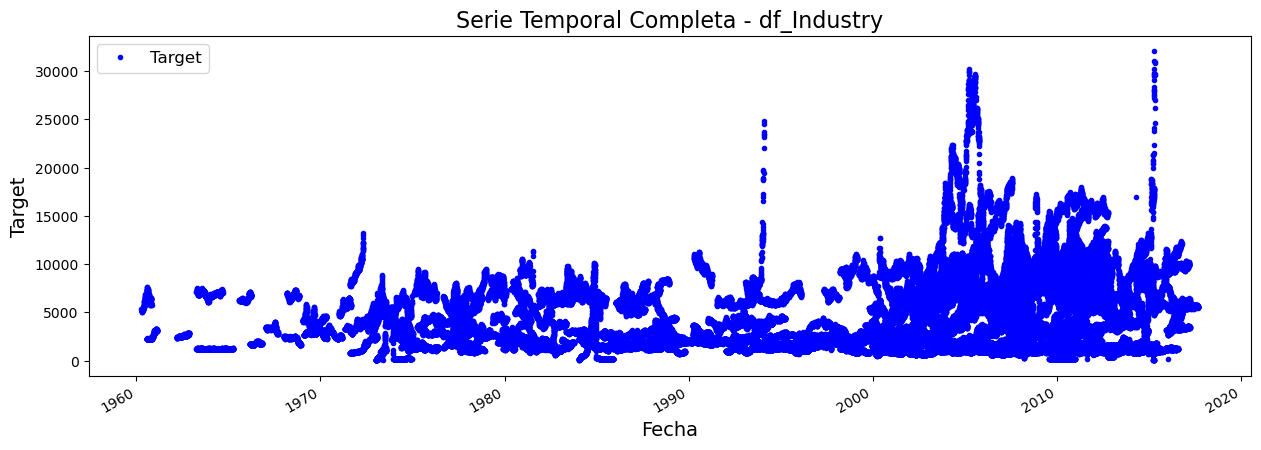

In [74]:
# Gráph 
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(df_Industry["target"],".", color="blue", label="Target")
ax.set_title("Serie Temporal Completa - df_Industry", fontsize=16)
ax.set_xlabel("Fecha", fontsize=14)
ax.set_ylabel("Target", fontsize=14)
ax.legend(fontsize=12)
fig.autofmt_xdate()
plt.show()
#As we can observe in the graph, there is more than one timeseries in the dataset.

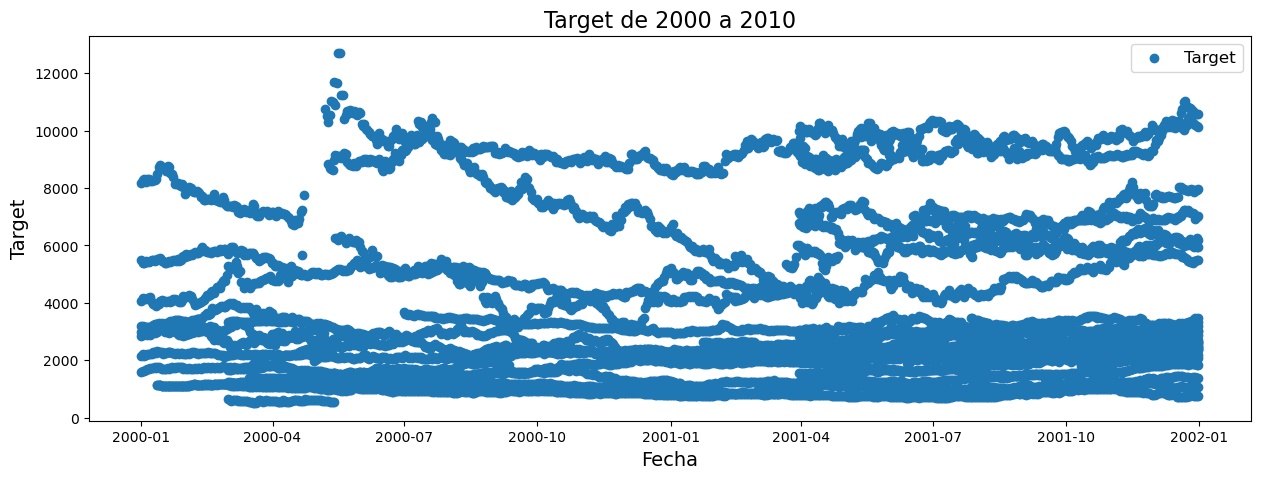

In [75]:
# Select the interval from 2000 to 2001
df_subset = df_Industry.sort_index().loc['2000-01-01':'2001-12-31', :]

# Graficar el target para el periodo seleccionado
plt.figure(figsize=(15, 5))
plt.scatter(df_subset.index, df_subset["target"], label="Target")
plt.title("Target de 2000 a 2010", fontsize=16)
plt.xlabel("Fecha", fontsize=14)
plt.ylabel("Target", fontsize=14)
plt.legend(fontsize=12)
plt.show()

In [76]:
df_Industry[df_Industry["id"]=="T002014"]["timestamp"].describe()
#The dataseries to work in is going to be the one with the most quantity of data. 
#The first year of the data is 2000 and the maximum is 2012

count                   4569
mean     2006-06-02 12:00:00
min      2000-03-01 12:00:00
25%      2003-04-17 12:00:00
50%      2006-06-02 12:00:00
75%      2009-07-18 12:00:00
max      2012-09-02 12:00:00
Name: timestamp, dtype: object

In [77]:
df_Industry_1=df_Industry[df_Industry["id"]=="T002014"]

In [78]:
df_Industry_1 = df_Industry_1.drop(columns=["category"]).sort_index(ascending=True)
df_Industry_1.head(10)

id           timestamp  target
timestamp                                               
2000-03-01 12:00:00  T002014 2000-03-01 12:00:00  1648.4
2000-03-02 12:00:00  T002014 2000-03-02 12:00:00  1671.4
2000-03-03 12:00:00  T002014 2000-03-03 12:00:00  1673.9
2000-03-04 12:00:00  T002014 2000-03-04 12:00:00  1680.5
2000-03-05 12:00:00  T002014 2000-03-05 12:00:00  1692.7
2000-03-06 12:00:00  T002014 2000-03-06 12:00:00  1685.9
2000-03-07 12:00:00  T002014 2000-03-07 12:00:00  1705.0
2000-03-08 12:00:00  T002014 2000-03-08 12:00:00  1705.2
2000-03-09 12:00:00  T002014 2000-03-09 12:00:00  1690.8
2000-03-10 12:00:00  T002014 2000-03-10 12:00:00  1706.4

In [79]:
df_Industry_1.dtypes

id           string[python]
timestamp    datetime64[ns]
target              float64
dtype: object

In [80]:
df_Industry_1.shape

(4569, 3)

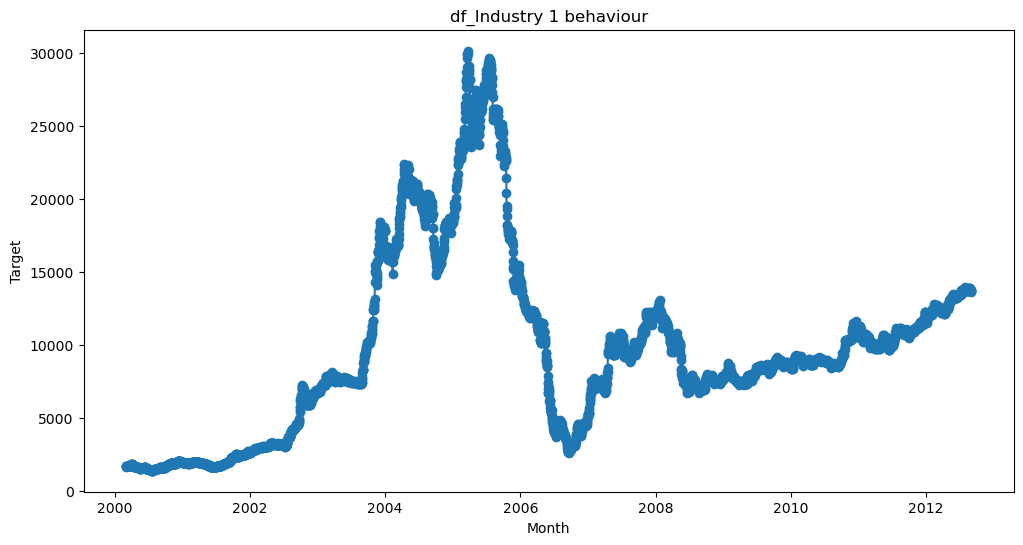

In [81]:
plt.figure(figsize=(12, 6))
plt.plot(df_Industry_1.index, df_Industry_1["target"], marker="o")
plt.title("df_Industry 1 behaviour")
plt.xlabel("Month")
plt.ylabel("Target")
plt.show()

In [82]:
df_Industry_1["target"].isnull().sum()

0

In [83]:
#Verify if the timestamp is complete and continuous
start_date = df_Industry_1.index.min()
print("Start date:", start_date)
end_date = df_Industry_1.index.max()
print("End date:", end_date)

Start date: 2000-03-01 12:00:00
End date: 2012-09-02 12:00:00


In [84]:
complete_date_range = pd.date_range(start=start_date, end=end_date, freq="B")

In [85]:
missing_dates = complete_date_range.difference(df_Industry_1.index)
print("Missing dates:", missing_dates)
#The timeseries is continues and complete, so we can work with it.

Missing dates: DatetimeIndex([], dtype='datetime64[ns]', freq='B')


In [86]:
len(missing_dates)

0

In [87]:
df_Industry_1.rename(columns={"id": "item_id"}, inplace=True)

In [88]:
df_Industry_1.head(10)

item_id           timestamp  target
timestamp                                               
2000-03-01 12:00:00  T002014 2000-03-01 12:00:00  1648.4
2000-03-02 12:00:00  T002014 2000-03-02 12:00:00  1671.4
2000-03-03 12:00:00  T002014 2000-03-03 12:00:00  1673.9
2000-03-04 12:00:00  T002014 2000-03-04 12:00:00  1680.5
2000-03-05 12:00:00  T002014 2000-03-05 12:00:00  1692.7
2000-03-06 12:00:00  T002014 2000-03-06 12:00:00  1685.9
2000-03-07 12:00:00  T002014 2000-03-07 12:00:00  1705.0
2000-03-08 12:00:00  T002014 2000-03-08 12:00:00  1705.2
2000-03-09 12:00:00  T002014 2000-03-09 12:00:00  1690.8
2000-03-10 12:00:00  T002014 2000-03-10 12:00:00  1706.4

In [89]:
errors_B_Industry=get_errors(df_Industry_1, frequ="B")
errors_B_Industry
#It is need to put the frequency as B even if it is not the appropiate one but otherwise there is a problem
#with the timestamp of the predictions and test in the evaluation step. 
#When the predictions are printed, the indexes follow the appropiate frequency 
#It means the daily in this case 
#And the model is capable to do the evaluation without any problem. 


---------data len 4569


Empty DataFrame
Columns: [Train_size, Percentage_train, Test_size, Percentage_test, MASE_error, Diference_MASE, WQL_error, Diference_WQL]
Index: []

Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193347'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.67 GB / 7.37 GB (9.1%)
Disk Space Avail:   4.34 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 914,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'targ

----------historical length 3655
----------prediction_length 914
-----------history len, min and max 3655 ('T002014', Timestamp('2000-03-01 12:00:00')) ('T002014', Timestamp('2010-03-03 12:00:00'))


Provided train_data has 2611 rows, 1 time series. Median time series length is 2611 (min=2611, max=2611). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 21:33:47
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.03 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193347-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platfor

---------beginning 0
---------total_length 4569
----------training len 3655
----------training                              target
item_id timestamp                  
T002014 2010-03-02 12:00:00  8893.4
        2010-03-03 12:00:00  8947.4
----------testing len 4569
----------testtt                               target
item_id timestamp                   
T002014 2010-03-04 12:00:00   8895.4
        2010-03-05 12:00:00   8836.5
        2010-03-06 12:00:00   8556.9
        2010-03-07 12:00:00   8662.3
        2010-03-08 12:00:00   8817.7
...                              ...
        2012-08-29 12:00:00  13759.0
        2012-08-30 12:00:00  13620.0
        2012-08-31 12:00:00  13759.2
        2012-09-01 12:00:00  13717.0
        2012-09-02 12:00:00  13695.6

[914 rows x 1 columns]
-----------len predictions 914


mean          0.1          0.2  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  8786.652344  8598.522461  8676.355469   
        2010-03-05 12:00:00  8776.979492  8546.514648  8633.397461   
        2010-03-06 12:00:00  8795.694336  8533.801758  8626.317383   
        2010-03-07 12:00:00  8821.902344  8523.958008  8633.664062   
        2010-03-08 12:00:00  8815.759766  8493.984375  8616.852539   
...                                  ...          ...          ...   
        2012-08-29 12:00:00  6078.884277  5886.536133  5953.453125   
        2012-08-30 12:00:00  6071.062500  5871.614746  5946.482910   
        2012-08-31 12:00:00  6072.301758  5867.520508  5943.687500   
        2012-09-01 12:00:00  6083.710938  5869.818848  5949.554688   
        2012-09-02 12:00:00  6084.458496  5874.957031  5952.268555   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  8723.184570  8753.541016  8786.652344   
        2010-03-05 12:00:00  8693.868164  8738.113281  8776.979492   
        2010-03-06 12:00:00  8697.587891  8744.486328  8795.694336   
        2010-03-07 12:00:00  8706.091797  8762.297852  8821.902344   
        2010-03-08 12:00:00  8692.554688  8754.508789  8815.759766   
...                                  ...          ...          ...   
        2012-08-29 12:00:00  6003.541992  6041.520020  6078.884277   
        2012-08-30 12:00:00  5993.972656  6032.836426  6071.062500   
        2012-08-31 12:00:00  5995.111328  6032.978516  6072.301758   
        2012-09-01 12:00:00  6001.412109  6043.680664  6083.710938   
        2012-09-02 12:00:00  6004.701172  6045.924805  6084.458496   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  8822.038086  8861.727539  8921.322266   
        2010-03-05 12:00:00  8824.269531  8868.742188  8940.770508   
        2010-03-06 12:00:00  8851.285156  8898.522461  8972.401367   
        2010-03-07 12:00:00  8878.397461  8933.254883  9008.226562   
        2010-03-08 12:00:00  8872.166016  8937.134766  9008.532227   
...                                  ...          ...          ...   
        2012-08-29 12:00:00  6111.658691  6139.681641  6175.218262   
        2012-08-30 12:00:00  6103.210449  6132.818848  6168.017578   
        2012-08-31 12:00:00  6106.169922  6136.563477  6172.580078   
        2012-09-01 12:00:00  6118.628418  6148.606934  6183.386719   
        2012-09-02 12:00:00  6117.821289  6151.332031  6192.467773   

                                     0.9  
item_id timestamp                         
T002014 2010-03-04 12:00:00  9043.193359  
        2010-03-05 12:00:00  9071.463867  
        2010-03-06 12:00:00  9112.119141  
        2010-03-07 12:00:00  9158.151367  
        2010-03-08 12:00:00  9155.816406  
...                                  ...  
        2012-08-29 12:00:00  6246.849121  
        2012-08-30 12:00:00  6238.091309  
        2012-08-31 12:00:00  6246.546387  
        2012-09-01 12:00:00  6261.066406  
        2012-09-02 12:00:00  6268.634766  

[914 rows x 10 columns]

---len test slide 4569


target
item_id timestamp                   
T002014 2010-03-04 12:00:00   8895.4
        2010-03-05 12:00:00   8836.5
        2010-03-06 12:00:00   8556.9
        2010-03-07 12:00:00   8662.3
        2010-03-08 12:00:00   8817.7
...                              ...
        2012-08-29 12:00:00  13759.0
        2012-08-30 12:00:00  13620.0
        2012-08-31 12:00:00  13759.2
        2012-09-01 12:00:00  13717.0
        2012-09-02 12:00:00  13695.6

[914 rows x 1 columns]

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193355'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.74 GB / 7.37 GB (10.1%)
Disk Space Avail:   4.34 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metri

----------prediction_length 46
-----------history len, min and max 3655 ('T002014', Timestamp('2000-03-01 12:00:00')) ('T002014', Timestamp('2010-03-03 12:00:00'))


	0.00    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.05 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193355-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.79 GB / 7.37 GB (10.8%)
Disk Space Avail:   4.34 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 46,
 'quantile_levels': [0.1

---------beginning 0
---------total_length 3701
----------training len 3655
----------training                              target
item_id timestamp                  
T002014 2010-03-02 12:00:00  8893.4
        2010-03-03 12:00:00  8947.4
----------testing len 3701
----------testtt                              target
item_id timestamp                  
T002014 2010-03-04 12:00:00  8895.4
        2010-03-05 12:00:00  8836.5
        2010-03-06 12:00:00  8556.9
        2010-03-07 12:00:00  8662.3
        2010-03-08 12:00:00  8817.7
        2010-03-09 12:00:00  8744.2
        2010-03-10 12:00:00  8671.2
        2010-03-11 12:00:00  8851.4
        2010-03-12 12:00:00  8758.7
        2010-03-13 12:00:00  8754.9
        2010-03-14 12:00:00  8857.7
        2010-03-15 12:00:00  8811.1
        2010-03-16 12:00:00  8818.8
        2010-03-17 12:00:00  8844.7
        2010-03-18 12:00:00  8848.8
        2010-03-19 12:00:00  8844.0
        2010-03-20 12:00:00  8825.2
        2010-03-21 12:00:00  8847

mean          0.1          0.2  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  8786.652344  8598.522461  8676.355469   
        2010-03-05 12:00:00  8776.979492  8546.514648  8633.397461   
        2010-03-06 12:00:00  8795.694336  8533.801758  8626.317383   
        2010-03-07 12:00:00  8821.902344  8523.958008  8633.664062   
        2010-03-08 12:00:00  8815.759766  8493.984375  8616.852539   
        2010-03-09 12:00:00  8817.831055  8469.003906  8604.226562   
        2010-03-10 12:00:00  8818.708008  8427.866211  8573.343750   
        2010-03-11 12:00:00  8840.451172  8410.172852  8557.591797   
        2010-03-12 12:00:00  8831.087891  8360.931641  8527.339844   
        2010-03-13 12:00:00  8809.926758  8322.396484  8502.869141   
        2010-03-14 12:00:00  8808.367188  8312.935547  8492.927734   
        2010-03-15 12:00:00  8833.473633  8306.789062  8493.710938   
        2010-03-16 12:00:00  8829.912109  8274.265625  8473.427734   
        2010-03-17 12:00:00  8830.041992  8260.321289  8465.668945   
        2010-03-18 12:00:00  8837.567383  8240.739258  8464.988281   
        2010-03-19 12:00:00  8848.413086  8219.222656  8456.507812   
        2010-03-20 12:00:00  8855.429688  8186.634277  8436.583008   
        2010-03-21 12:00:00  8858.959961  8172.895020  8426.697266   
        2010-03-22 12:00:00  8854.703125  8146.084961  8401.359375   
        2010-03-23 12:00:00  8860.004883  8118.079102  8392.675781   
        2010-03-24 12:00:00  8832.958984  8058.971680  8349.051758   
        2010-03-25 12:00:00  8849.194336  8054.697266  8344.849609   
        2010-03-26 12:00:00  8874.639648  8050.227539  8336.424805   
        2010-03-27 12:00:00  8888.166016  8046.841797  8354.162109   
        2010-03-28 12:00:00  8867.003906  7997.738281  8308.925781   
        2010-03-29 12:00:00  8858.266602  7974.209961  8294.150391   
        2010-03-30 12:00:00  8867.473633  7952.801758  8284.994141   
        2010-03-31 12:00:00  8875.282227  7951.606445  8278.884766   
        2010-04-01 12:00:00  8864.273438  7921.343262  8259.325195   
        2010-04-02 12:00:00  8856.421875  7911.265625  8239.925781   
        2010-04-03 12:00:00  8851.296875  7878.288086  8220.845703   
        2010-04-04 12:00:00  8874.504883  7856.701172  8215.667969   
        2010-04-05 12:00:00  8877.142578  7832.259766  8205.929688   
        2010-04-06 12:00:00  8853.794922  7794.135742  8168.927734   
        2010-04-07 12:00:00  8842.619141  7763.398438  8143.285156   
        2010-04-08 12:00:00  8868.847656  7751.866211  8133.852539   
        2010-04-09 12:00:00  8849.765625  7710.030273  8110.308594   
        2010-04-10 12:00:00  8824.706055  7670.928711  8081.128418   
        2010-04-11 12:00:00  8820.336914  7664.047852  8061.351562   
        2010-04-12 12:00:00  8850.353516  7666.169922  8070.075195   
        2010-04-13 12:00:00  8861.172852  7650.432617  8071.736328   
        2010-04-14 12:00:00  8841.610352  7630.125000  8056.751953   
        2010-04-15 12:00:00  8804.907227  7585.797363  8002.868652   
        2010-04-16 12:00:00  8812.037109  7556.551758  7979.312988   
        2010-04-17 12:00:00  8813.524414  7531.630859  7953.786133   
        2010-04-18 12:00:00  8826.560547  7511.176758  7954.654297   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  8723.184570  8753.541016  8786.652344   
        2010-03-05 12:00:00  8693.868164  8738.113281  8776.979492   
        2010-03-06 12:00:00  8697.587891  8744.486328  8795.694336   
        2010-03-07 12:00:00  8706.091797  8762.297852  8821.902344   
        2010-03-08 12:00:00  8692.554688  8754.508789  8815.759766   
        2010-03-09 12:00:00  8688.974609  8755.277344  8817.831055   
        2010-03-10 12:00:00  8667.960938  8747.816406  8818.708008   
        2010-03-11 12:00:00  8669.943359  875

---len test slide 3701


target
item_id timestamp                  
T002014 2010-03-04 12:00:00  8895.4
        2010-03-05 12:00:00  8836.5
        2010-03-06 12:00:00  8556.9
        2010-03-07 12:00:00  8662.3
        2010-03-08 12:00:00  8817.7
        2010-03-09 12:00:00  8744.2
        2010-03-10 12:00:00  8671.2
        2010-03-11 12:00:00  8851.4
        2010-03-12 12:00:00  8758.7
        2010-03-13 12:00:00  8754.9
        2010-03-14 12:00:00  8857.7
        2010-03-15 12:00:00  8811.1
        2010-03-16 12:00:00  8818.8
        2010-03-17 12:00:00  8844.7
        2010-03-18 12:00:00  8848.8
        2010-03-19 12:00:00  8844.0
        2010-03-20 12:00:00  8825.2
        2010-03-21 12:00:00  8847.4
        2010-03-22 12:00:00  8793.4
        2010-03-23 12:00:00  8885.8
        2010-03-24 12:00:00  8844.2
        2010-03-25 12:00:00  8874.2
        2010-03-26 12:00:00  8866.6
        2010-03-27 12:00:00  8764.6
        2010-03-28 12:00:00  8750.2
        2010-03-29 12:00:00  8770.9
        2010-03-30 12:00:00  8815.0
        2010-03-31 12:00:00  8816.5
        2010-04-01 12:00:00  8821.1
        2010-04-02 12:00:00  8823.4
        2010-04-03 12:00:00  8826.3
        2010-04-04 12:00:00  8813.0
        2010-04-05 12:00:00  8806.4
        2010-04-06 12:00:00  8929.1
        2010-04-07 12:00:00  8962.4
        2010-04-08 12:00:00  9006.6
        2010-04-09 12:00:00  8985.8
        2010-04-10 12:00:00  9062.9
        2010-04-11 12:00:00  8995.6
        2010-04-12 12:00:00  8833.2
        2010-04-13 12:00:00  8861.1
        2010-04-14 12:00:00  8801.4
        2010-04-15 12:00:00  8692.4
        2010-04-16 12:00:00  8605.8
        2010-04-17 12:00:00  8637.9
        2010-04-18 12:00:00  8621.0

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193402'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.79 GB / 7.37 GB (10.7%)
Disk Space Avail:   4.34 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metri

----------prediction_length 228
-----------history len, min and max 3655 ('T002014', Timestamp('2000-03-01 12:00:00')) ('T002014', Timestamp('2010-03-03 12:00:00'))


	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.04 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193402-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.78 GB / 7.37 GB (10.5%)
Disk Space Avail:   4.34 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 228,
 'quantile_levels': [0.

---------beginning 0
---------total_length 3883
----------training len 3655
----------training                              target
item_id timestamp                  
T002014 2010-03-02 12:00:00  8893.4
        2010-03-03 12:00:00  8947.4
----------testing len 3883
----------testtt                              target
item_id timestamp                  
T002014 2010-03-04 12:00:00  8895.4
        2010-03-05 12:00:00  8836.5
        2010-03-06 12:00:00  8556.9
        2010-03-07 12:00:00  8662.3
        2010-03-08 12:00:00  8817.7
...                             ...
        2010-10-13 12:00:00  9283.7
        2010-10-14 12:00:00  9323.5
        2010-10-15 12:00:00  9498.0
        2010-10-16 12:00:00  9548.3
        2010-10-17 12:00:00  9633.1

[228 rows x 1 columns]
-----------len predictions 228


mean          0.1          0.2  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  8786.652344  8598.522461  8676.355469   
        2010-03-05 12:00:00  8776.979492  8546.514648  8633.397461   
        2010-03-06 12:00:00  8795.694336  8533.801758  8626.317383   
        2010-03-07 12:00:00  8821.902344  8523.958008  8633.664062   
        2010-03-08 12:00:00  8815.759766  8493.984375  8616.852539   
...                                  ...          ...          ...   
        2010-10-13 12:00:00  7931.752930  7321.377441  7546.536133   
        2010-10-14 12:00:00  7959.801758  7312.258301  7553.787598   
        2010-10-15 12:00:00  7959.923828  7288.397949  7535.397461   
        2010-10-16 12:00:00  7943.752930  7282.082520  7531.352539   
        2010-10-17 12:00:00  7940.324219  7281.521484  7526.827637   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  8723.184570  8753.541016  8786.652344   
        2010-03-05 12:00:00  8693.868164  8738.113281  8776.979492   
        2010-03-06 12:00:00  8697.587891  8744.486328  8795.694336   
        2010-03-07 12:00:00  8706.091797  8762.297852  8821.902344   
        2010-03-08 12:00:00  8692.554688  8754.508789  8815.759766   
...                                  ...          ...          ...   
        2010-10-13 12:00:00  7698.343262  7822.772461  7931.752930   
        2010-10-14 12:00:00  7708.486328  7841.034180  7959.801758   
        2010-10-15 12:00:00  7698.980469  7835.223633  7959.923828   
        2010-10-16 12:00:00  7693.682617  7824.386719  7943.752930   
        2010-10-17 12:00:00  7692.926758  7821.066406  7940.324219   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  8822.038086  8861.727539  8921.322266   
        2010-03-05 12:00:00  8824.269531  8868.742188  8940.770508   
        2010-03-06 12:00:00  8851.285156  8898.522461  8972.401367   
        2010-03-07 12:00:00  8878.397461  8933.254883  9008.226562   
        2010-03-08 12:00:00  8872.166016  8937.134766  9008.532227   
...                                  ...          ...          ...   
        2010-10-13 12:00:00  8035.626953  8155.685547  8313.261719   
        2010-10-14 12:00:00  8075.849609  8203.898438  8364.853516   
        2010-10-15 12:00:00  8076.440430  8210.750977  8378.684570   
        2010-10-16 12:00:00  8060.899414  8193.888672  8355.691406   
        2010-10-17 12:00:00  8056.530762  8188.150391  8353.827148   

                                     0.9  
item_id timestamp                         
T002014 2010-03-04 12:00:00  9043.193359  
        2010-03-05 12:00:00  9071.463867  
        2010-03-06 12:00:00  9112.119141  
        2010-03-07 12:00:00  9158.151367  
        2010-03-08 12:00:00  9155.816406  
...                                  ...  
        2010-10-13 12:00:00  8581.849609  
        2010-10-14 12:00:00  8661.534180  
        2010-10-15 12:00:00  8661.531250  
        2010-10-16 12:00:00  8649.768555  
        2010-10-17 12:00:00  8655.460938  

[228 rows x 10 columns]

---len test slide 3883


target
item_id timestamp                  
T002014 2010-03-04 12:00:00  8895.4
        2010-03-05 12:00:00  8836.5
        2010-03-06 12:00:00  8556.9
        2010-03-07 12:00:00  8662.3
        2010-03-08 12:00:00  8817.7
...                             ...
        2010-10-13 12:00:00  9283.7
        2010-10-14 12:00:00  9323.5
        2010-10-15 12:00:00  9498.0
        2010-10-16 12:00:00  9548.3
        2010-10-17 12:00:00  9633.1

[228 rows x 1 columns]

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193409'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.61 GB / 7.37 GB (8.2%)
Disk Space Avail:   4.34 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric

----------prediction_length 457
-----------history len, min and max 3655 ('T002014', Timestamp('2000-03-01 12:00:00')) ('T002014', Timestamp('2010-03-03 12:00:00'))


Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193409-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.61 GB / 7.37 GB (8.3%)
Disk Space Avail:   4.34 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 457,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 

---------beginning 0
---------total_length 4112
----------training len 3655
----------training                              target
item_id timestamp                  
T002014 2010-03-02 12:00:00  8893.4
        2010-03-03 12:00:00  8947.4
----------testing len 4112
----------testtt                               target
item_id timestamp                   
T002014 2010-03-04 12:00:00   8895.4
        2010-03-05 12:00:00   8836.5
        2010-03-06 12:00:00   8556.9
        2010-03-07 12:00:00   8662.3
        2010-03-08 12:00:00   8817.7
...                              ...
        2011-05-30 12:00:00  10556.8
        2011-05-31 12:00:00  10463.5
        2011-06-01 12:00:00  10279.1
        2011-06-02 12:00:00  10403.8
        2011-06-03 12:00:00  10382.9

[457 rows x 1 columns]
-----------len predictions 457


mean          0.1          0.2  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  8786.652344  8598.522461  8676.355469   
        2010-03-05 12:00:00  8776.979492  8546.514648  8633.397461   
        2010-03-06 12:00:00  8795.694336  8533.801758  8626.317383   
        2010-03-07 12:00:00  8821.902344  8523.958008  8633.664062   
        2010-03-08 12:00:00  8815.759766  8493.984375  8616.852539   
...                                  ...          ...          ...   
        2011-05-30 12:00:00  6635.276855  6334.342773  6440.264160   
        2011-05-31 12:00:00  6655.926758  6345.033203  6451.902344   
        2011-06-01 12:00:00  6669.259766  6338.256836  6456.931641   
        2011-06-02 12:00:00  6653.351074  6317.245117  6434.696289   
        2011-06-03 12:00:00  6646.886719  6285.796875  6414.439453   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  8723.184570  8753.541016  8786.652344   
        2010-03-05 12:00:00  8693.868164  8738.113281  8776.979492   
        2010-03-06 12:00:00  8697.587891  8744.486328  8795.694336   
        2010-03-07 12:00:00  8706.091797  8762.297852  8821.902344   
        2010-03-08 12:00:00  8692.554688  8754.508789  8815.759766   
...                                  ...          ...          ...   
        2011-05-30 12:00:00  6511.372559  6575.891602  6635.276855   
        2011-05-31 12:00:00  6530.968262  6595.679688  6655.926758   
        2011-06-01 12:00:00  6541.834961  6611.149902  6669.259766   
        2011-06-02 12:00:00  6518.537598  6592.810059  6653.351074   
        2011-06-03 12:00:00  6507.400391  6582.149902  6646.886719   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  8822.038086  8861.727539  8921.322266   
        2010-03-05 12:00:00  8824.269531  8868.742188  8940.770508   
        2010-03-06 12:00:00  8851.285156  8898.522461  8972.401367   
        2010-03-07 12:00:00  8878.397461  8933.254883  9008.226562   
        2010-03-08 12:00:00  8872.166016  8937.134766  9008.532227   
...                                  ...          ...          ...   
        2011-05-30 12:00:00  6684.288086  6734.391113  6784.669922   
        2011-05-31 12:00:00  6709.459473  6765.666016  6826.638184   
        2011-06-01 12:00:00  6724.137695  6771.389160  6835.536133   
        2011-06-02 12:00:00  6706.400879  6758.506836  6820.241699   
        2011-06-03 12:00:00  6708.743652  6765.694824  6829.235352   

                                     0.9  
item_id timestamp                         
T002014 2010-03-04 12:00:00  9043.193359  
        2010-03-05 12:00:00  9071.463867  
        2010-03-06 12:00:00  9112.119141  
        2010-03-07 12:00:00  9158.151367  
        2010-03-08 12:00:00  9155.816406  
...                                  ...  
        2011-05-30 12:00:00  6879.013672  
        2011-05-31 12:00:00  6911.666504  
        2011-06-01 12:00:00  6933.722168  
        2011-06-02 12:00:00  6922.683105  
        2011-06-03 12:00:00  6952.453613  

[457 rows x 10 columns]

---len test slide 4112


target
item_id timestamp                   
T002014 2010-03-04 12:00:00   8895.4
        2010-03-05 12:00:00   8836.5
        2010-03-06 12:00:00   8556.9
        2010-03-07 12:00:00   8662.3
        2010-03-08 12:00:00   8817.7
...                              ...
        2011-05-30 12:00:00  10556.8
        2011-05-31 12:00:00  10463.5
        2011-06-01 12:00:00  10279.1
        2011-06-02 12:00:00  10403.8
        2011-06-03 12:00:00  10382.9

[457 rows x 1 columns]

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193415'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.70 GB / 7.37 GB (9.5%)
Disk Space Avail:   4.33 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric

----------prediction_length 686
-----------history len, min and max 3655 ('T002014', Timestamp('2000-03-01 12:00:00')) ('T002014', Timestamp('2010-03-03 12:00:00'))


Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.08 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193415-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.70 GB / 7.37 GB (9.5%)
Disk Space Avail:   4.33 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 686,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.

---------beginning 0
---------total_length 4341
----------training len 3655
----------training                              target
item_id timestamp                  
T002014 2010-03-02 12:00:00  8893.4
        2010-03-03 12:00:00  8947.4
----------testing len 4341
----------testtt                               target
item_id timestamp                   
T002014 2010-03-04 12:00:00   8895.4
        2010-03-05 12:00:00   8836.5
        2010-03-06 12:00:00   8556.9
        2010-03-07 12:00:00   8662.3
        2010-03-08 12:00:00   8817.7
...                              ...
        2012-01-14 12:00:00  11936.1
        2012-01-15 12:00:00  11934.3
        2012-01-16 12:00:00  11971.2
        2012-01-17 12:00:00  12008.1
        2012-01-18 12:00:00  12024.7

[686 rows x 1 columns]
-----------len predictions 686


mean          0.1          0.2  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  8786.652344  8598.522461  8676.355469   
        2010-03-05 12:00:00  8776.979492  8546.514648  8633.397461   
        2010-03-06 12:00:00  8795.694336  8533.801758  8626.317383   
        2010-03-07 12:00:00  8821.902344  8523.958008  8633.664062   
        2010-03-08 12:00:00  8815.759766  8493.984375  8616.852539   
...                                  ...          ...          ...   
        2012-01-14 12:00:00  6312.912598  5772.225586  5986.018555   
        2012-01-15 12:00:00  6305.569336  5774.628418  5983.833496   
        2012-01-16 12:00:00  6330.343750  5789.667480  5995.127441   
        2012-01-17 12:00:00  6328.718262  5778.314453  5982.317871   
        2012-01-18 12:00:00  6339.443359  5783.522949  6000.054688   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  8723.184570  8753.541016  8786.652344   
        2010-03-05 12:00:00  8693.868164  8738.113281  8776.979492   
        2010-03-06 12:00:00  8697.587891  8744.486328  8795.694336   
        2010-03-07 12:00:00  8706.091797  8762.297852  8821.902344   
        2010-03-08 12:00:00  8692.554688  8754.508789  8815.759766   
...                                  ...          ...          ...   
        2012-01-14 12:00:00  6118.633301  6220.971680  6312.912598   
        2012-01-15 12:00:00  6104.413574  6209.104492  6305.569336   
        2012-01-16 12:00:00  6126.961914  6231.457031  6330.343750   
        2012-01-17 12:00:00  6111.617188  6226.183594  6328.718262   
        2012-01-18 12:00:00  6129.805176  6239.593750  6339.443359   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  8822.038086  8861.727539  8921.322266   
        2010-03-05 12:00:00  8824.269531  8868.742188  8940.770508   
        2010-03-06 12:00:00  8851.285156  8898.522461  8972.401367   
        2010-03-07 12:00:00  8878.397461  8933.254883  9008.226562   
        2010-03-08 12:00:00  8872.166016  8937.134766  9008.532227   
...                                  ...          ...          ...   
        2012-01-14 12:00:00  6410.445312  6518.466309  6659.027832   
        2012-01-15 12:00:00  6402.470215  6514.957031  6667.267578   
        2012-01-16 12:00:00  6431.386719  6543.264648  6702.447266   
        2012-01-17 12:00:00  6432.548828  6544.844727  6710.143555   
        2012-01-18 12:00:00  6434.791016  6551.937500  6724.741211   

                                     0.9  
item_id timestamp                         
T002014 2010-03-04 12:00:00  9043.193359  
        2010-03-05 12:00:00  9071.463867  
        2010-03-06 12:00:00  9112.119141  
        2010-03-07 12:00:00  9158.151367  
        2010-03-08 12:00:00  9155.816406  
...                                  ...  
        2012-01-14 12:00:00  6937.751465  
        2012-01-15 12:00:00  6968.978516  
        2012-01-16 12:00:00  7022.135742  
        2012-01-17 12:00:00  7028.690430  
        2012-01-18 12:00:00  7060.782227  

[686 rows x 10 columns]

---len test slide 4341


target
item_id timestamp                   
T002014 2010-03-04 12:00:00   8895.4
        2010-03-05 12:00:00   8836.5
        2010-03-06 12:00:00   8556.9
        2010-03-07 12:00:00   8662.3
        2010-03-08 12:00:00   8817.7
...                              ...
        2012-01-14 12:00:00  11936.1
        2012-01-15 12:00:00  11934.3
        2012-01-16 12:00:00  11971.2
        2012-01-17 12:00:00  12008.1
        2012-01-18 12:00:00  12024.7

[686 rows x 1 columns]

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193422'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.75 GB / 7.37 GB (10.2%)
Disk Space Avail:   4.33 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metri

----------historical length 3472
----------prediction_length 914
-----------history len, min and max 3472 ('T002014', Timestamp('2000-08-31 12:00:00')) ('T002014', Timestamp('2010-03-03 12:00:00'))


Provided train_data has 2480 rows, 1 time series. Median time series length is 2480 (min=2480, max=2480). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 21:34:23
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.02    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.03 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193423'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Ve

---------beginning 183
---------total_length 4569
----------training len 3472
----------training                              target
item_id timestamp                  
T002014 2010-03-02 12:00:00  8893.4
        2010-03-03 12:00:00  8947.4
----------testing len 4386
----------testtt                               target
item_id timestamp                   
T002014 2010-03-04 12:00:00   8895.4
        2010-03-05 12:00:00   8836.5
        2010-03-06 12:00:00   8556.9
        2010-03-07 12:00:00   8662.3
        2010-03-08 12:00:00   8817.7
...                              ...
        2012-08-29 12:00:00  13759.0
        2012-08-30 12:00:00  13620.0
        2012-08-31 12:00:00  13759.2
        2012-09-01 12:00:00  13717.0
        2012-09-02 12:00:00  13695.6

[914 rows x 1 columns]
-----------len predictions 914


mean          0.1          0.2  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  8786.652344  8598.522461  8676.355469   
        2010-03-05 12:00:00  8776.979492  8546.514648  8633.397461   
        2010-03-06 12:00:00  8795.694336  8533.801758  8626.317383   
        2010-03-07 12:00:00  8821.902344  8523.958008  8633.664062   
        2010-03-08 12:00:00  8815.759766  8493.984375  8616.852539   
...                                  ...          ...          ...   
        2012-08-29 12:00:00  6078.884277  5886.536133  5953.453125   
        2012-08-30 12:00:00  6071.062500  5871.614746  5946.482910   
        2012-08-31 12:00:00  6072.301758  5867.520508  5943.687500   
        2012-09-01 12:00:00  6083.710938  5869.818848  5949.554688   
        2012-09-02 12:00:00  6084.458496  5874.957031  5952.268555   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  8723.184570  8753.541016  8786.652344   
        2010-03-05 12:00:00  8693.868164  8738.113281  8776.979492   
        2010-03-06 12:00:00  8697.587891  8744.486328  8795.694336   
        2010-03-07 12:00:00  8706.091797  8762.297852  8821.902344   
        2010-03-08 12:00:00  8692.554688  8754.508789  8815.759766   
...                                  ...          ...          ...   
        2012-08-29 12:00:00  6003.541992  6041.520020  6078.884277   
        2012-08-30 12:00:00  5993.972656  6032.836426  6071.062500   
        2012-08-31 12:00:00  5995.111328  6032.978516  6072.301758   
        2012-09-01 12:00:00  6001.412109  6043.680664  6083.710938   
        2012-09-02 12:00:00  6004.701172  6045.924805  6084.458496   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  8822.038086  8861.727539  8921.322266   
        2010-03-05 12:00:00  8824.269531  8868.742188  8940.770508   
        2010-03-06 12:00:00  8851.285156  8898.522461  8972.401367   
        2010-03-07 12:00:00  8878.397461  8933.254883  9008.226562   
        2010-03-08 12:00:00  8872.166016  8937.134766  9008.532227   
...                                  ...          ...          ...   
        2012-08-29 12:00:00  6111.658691  6139.681641  6175.218262   
        2012-08-30 12:00:00  6103.210449  6132.818848  6168.017578   
        2012-08-31 12:00:00  6106.169922  6136.563477  6172.580078   
        2012-09-01 12:00:00  6118.628418  6148.606934  6183.386719   
        2012-09-02 12:00:00  6117.821289  6151.332031  6192.467773   

                                     0.9  
item_id timestamp                         
T002014 2010-03-04 12:00:00  9043.193359  
        2010-03-05 12:00:00  9071.463867  
        2010-03-06 12:00:00  9112.119141  
        2010-03-07 12:00:00  9158.151367  
        2010-03-08 12:00:00  9155.816406  
...                                  ...  
        2012-08-29 12:00:00  6246.849121  
        2012-08-30 12:00:00  6238.091309  
        2012-08-31 12:00:00  6246.546387  
        2012-09-01 12:00:00  6261.066406  
        2012-09-02 12:00:00  6268.634766  

[914 rows x 10 columns]

---len test slide 4386


target
item_id timestamp                   
T002014 2010-03-04 12:00:00   8895.4
        2010-03-05 12:00:00   8836.5
        2010-03-06 12:00:00   8556.9
        2010-03-07 12:00:00   8662.3
        2010-03-08 12:00:00   8817.7
...                              ...
        2012-08-29 12:00:00  13759.0
        2012-08-30 12:00:00  13620.0
        2012-08-31 12:00:00  13759.2
        2012-09-01 12:00:00  13717.0
        2012-09-02 12:00:00  13695.6

[914 rows x 1 columns]

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193431'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.92 GB / 7.37 GB (12.5%)
Disk Space Avail:   4.33 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metri

----------prediction_length 46
-----------history len, min and max 3472 ('T002014', Timestamp('2000-08-31 12:00:00')) ('T002014', Timestamp('2010-03-03 12:00:00'))


Total runtime: 0.04 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193431-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.92 GB / 7.37 GB (12.4%)
Disk Space Avail:   4.33 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 46,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,


---------beginning 183
---------total_length 3701
----------training len 3472
----------training                              target
item_id timestamp                  
T002014 2010-03-02 12:00:00  8893.4
        2010-03-03 12:00:00  8947.4
----------testing len 3518
----------testtt                              target
item_id timestamp                  
T002014 2010-03-04 12:00:00  8895.4
        2010-03-05 12:00:00  8836.5
        2010-03-06 12:00:00  8556.9
        2010-03-07 12:00:00  8662.3
        2010-03-08 12:00:00  8817.7
        2010-03-09 12:00:00  8744.2
        2010-03-10 12:00:00  8671.2
        2010-03-11 12:00:00  8851.4
        2010-03-12 12:00:00  8758.7
        2010-03-13 12:00:00  8754.9
        2010-03-14 12:00:00  8857.7
        2010-03-15 12:00:00  8811.1
        2010-03-16 12:00:00  8818.8
        2010-03-17 12:00:00  8844.7
        2010-03-18 12:00:00  8848.8
        2010-03-19 12:00:00  8844.0
        2010-03-20 12:00:00  8825.2
        2010-03-21 12:00:00  88

mean          0.1          0.2  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  8786.652344  8598.522461  8676.355469   
        2010-03-05 12:00:00  8776.979492  8546.514648  8633.397461   
        2010-03-06 12:00:00  8795.694336  8533.801758  8626.317383   
        2010-03-07 12:00:00  8821.902344  8523.958008  8633.664062   
        2010-03-08 12:00:00  8815.759766  8493.984375  8616.852539   
        2010-03-09 12:00:00  8817.831055  8469.003906  8604.226562   
        2010-03-10 12:00:00  8818.708008  8427.866211  8573.343750   
        2010-03-11 12:00:00  8840.451172  8410.172852  8557.591797   
        2010-03-12 12:00:00  8831.087891  8360.931641  8527.339844   
        2010-03-13 12:00:00  8809.926758  8322.396484  8502.869141   
        2010-03-14 12:00:00  8808.367188  8312.935547  8492.927734   
        2010-03-15 12:00:00  8833.473633  8306.789062  8493.710938   
        2010-03-16 12:00:00  8829.912109  8274.265625  8473.427734   
        2010-03-17 12:00:00  8830.041992  8260.321289  8465.668945   
        2010-03-18 12:00:00  8837.567383  8240.739258  8464.988281   
        2010-03-19 12:00:00  8848.413086  8219.222656  8456.507812   
        2010-03-20 12:00:00  8855.429688  8186.634277  8436.583008   
        2010-03-21 12:00:00  8858.959961  8172.895020  8426.697266   
        2010-03-22 12:00:00  8854.703125  8146.084961  8401.359375   
        2010-03-23 12:00:00  8860.004883  8118.079102  8392.675781   
        2010-03-24 12:00:00  8832.958984  8058.971680  8349.051758   
        2010-03-25 12:00:00  8849.194336  8054.697266  8344.849609   
        2010-03-26 12:00:00  8874.639648  8050.227539  8336.424805   
        2010-03-27 12:00:00  8888.166016  8046.841797  8354.162109   
        2010-03-28 12:00:00  8867.003906  7997.738281  8308.925781   
        2010-03-29 12:00:00  8858.266602  7974.209961  8294.150391   
        2010-03-30 12:00:00  8867.473633  7952.801758  8284.994141   
        2010-03-31 12:00:00  8875.282227  7951.606445  8278.884766   
        2010-04-01 12:00:00  8864.273438  7921.343262  8259.325195   
        2010-04-02 12:00:00  8856.421875  7911.265625  8239.925781   
        2010-04-03 12:00:00  8851.296875  7878.288086  8220.845703   
        2010-04-04 12:00:00  8874.504883  7856.701172  8215.667969   
        2010-04-05 12:00:00  8877.142578  7832.259766  8205.929688   
        2010-04-06 12:00:00  8853.794922  7794.135742  8168.927734   
        2010-04-07 12:00:00  8842.619141  7763.398438  8143.285156   
        2010-04-08 12:00:00  8868.847656  7751.866211  8133.852539   
        2010-04-09 12:00:00  8849.765625  7710.030273  8110.308594   
        2010-04-10 12:00:00  8824.706055  7670.928711  8081.128418   
        2010-04-11 12:00:00  8820.336914  7664.047852  8061.351562   
        2010-04-12 12:00:00  8850.353516  7666.169922  8070.075195   
        2010-04-13 12:00:00  8861.172852  7650.432617  8071.736328   
        2010-04-14 12:00:00  8841.610352  7630.125000  8056.751953   
        2010-04-15 12:00:00  8804.907227  7585.797363  8002.868652   
        2010-04-16 12:00:00  8812.037109  7556.551758  7979.312988   
        2010-04-17 12:00:00  8813.524414  7531.630859  7953.786133   
        2010-04-18 12:00:00  8826.560547  7511.176758  7954.654297   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  8723.184570  8753.541016  8786.652344   
        2010-03-05 12:00:00  8693.868164  8738.113281  8776.979492   
        2010-03-06 12:00:00  8697.587891  8744.486328  8795.694336   
        2010-03-07 12:00:00  8706.091797  8762.297852  8821.902344   
        2010-03-08 12:00:00  8692.554688  8754.508789  8815.759766   
        2010-03-09 12:00:00  8688.974609  8755.277344  8817.831055   
        2010-03-10 12:00:00  8667.960938  8747.816406  8818.708008   
        2010-03-11 12:00:00  8669.943359  875

---len test slide 3518


target
item_id timestamp                  
T002014 2010-03-04 12:00:00  8895.4
        2010-03-05 12:00:00  8836.5
        2010-03-06 12:00:00  8556.9
        2010-03-07 12:00:00  8662.3
        2010-03-08 12:00:00  8817.7
        2010-03-09 12:00:00  8744.2
        2010-03-10 12:00:00  8671.2
        2010-03-11 12:00:00  8851.4
        2010-03-12 12:00:00  8758.7
        2010-03-13 12:00:00  8754.9
        2010-03-14 12:00:00  8857.7
        2010-03-15 12:00:00  8811.1
        2010-03-16 12:00:00  8818.8
        2010-03-17 12:00:00  8844.7
        2010-03-18 12:00:00  8848.8
        2010-03-19 12:00:00  8844.0
        2010-03-20 12:00:00  8825.2
        2010-03-21 12:00:00  8847.4
        2010-03-22 12:00:00  8793.4
        2010-03-23 12:00:00  8885.8
        2010-03-24 12:00:00  8844.2
        2010-03-25 12:00:00  8874.2
        2010-03-26 12:00:00  8866.6
        2010-03-27 12:00:00  8764.6
        2010-03-28 12:00:00  8750.2
        2010-03-29 12:00:00  8770.9
        2010-03-30 12:00:00  8815.0
        2010-03-31 12:00:00  8816.5
        2010-04-01 12:00:00  8821.1
        2010-04-02 12:00:00  8823.4
        2010-04-03 12:00:00  8826.3
        2010-04-04 12:00:00  8813.0
        2010-04-05 12:00:00  8806.4
        2010-04-06 12:00:00  8929.1
        2010-04-07 12:00:00  8962.4
        2010-04-08 12:00:00  9006.6
        2010-04-09 12:00:00  8985.8
        2010-04-10 12:00:00  9062.9
        2010-04-11 12:00:00  8995.6
        2010-04-12 12:00:00  8833.2
        2010-04-13 12:00:00  8861.1
        2010-04-14 12:00:00  8801.4
        2010-04-15 12:00:00  8692.4
        2010-04-16 12:00:00  8605.8
        2010-04-17 12:00:00  8637.9
        2010-04-18 12:00:00  8621.0

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193438'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.86 GB / 7.37 GB (11.7%)
Disk Space Avail:   4.33 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metri

----------prediction_length 228
-----------history len, min and max 3472 ('T002014', Timestamp('2000-08-31 12:00:00')) ('T002014', Timestamp('2010-03-03 12:00:00'))


Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.05 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193438-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.86 GB / 7.37 GB (11.7%)
Disk Space Avail:   4.33 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 228,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0

---------beginning 183
---------total_length 3883
----------training len 3472
----------training                              target
item_id timestamp                  
T002014 2010-03-02 12:00:00  8893.4
        2010-03-03 12:00:00  8947.4
----------testing len 3700
----------testtt                              target
item_id timestamp                  
T002014 2010-03-04 12:00:00  8895.4
        2010-03-05 12:00:00  8836.5
        2010-03-06 12:00:00  8556.9
        2010-03-07 12:00:00  8662.3
        2010-03-08 12:00:00  8817.7
...                             ...
        2010-10-13 12:00:00  9283.7
        2010-10-14 12:00:00  9323.5
        2010-10-15 12:00:00  9498.0
        2010-10-16 12:00:00  9548.3
        2010-10-17 12:00:00  9633.1

[228 rows x 1 columns]
-----------len predictions 228


mean          0.1          0.2  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  8786.652344  8598.522461  8676.355469   
        2010-03-05 12:00:00  8776.979492  8546.514648  8633.397461   
        2010-03-06 12:00:00  8795.694336  8533.801758  8626.317383   
        2010-03-07 12:00:00  8821.902344  8523.958008  8633.664062   
        2010-03-08 12:00:00  8815.759766  8493.984375  8616.852539   
...                                  ...          ...          ...   
        2010-10-13 12:00:00  7931.752930  7321.377441  7546.536133   
        2010-10-14 12:00:00  7959.801758  7312.258301  7553.787598   
        2010-10-15 12:00:00  7959.923828  7288.397949  7535.397461   
        2010-10-16 12:00:00  7943.752930  7282.082520  7531.352539   
        2010-10-17 12:00:00  7940.324219  7281.521484  7526.827637   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  8723.184570  8753.541016  8786.652344   
        2010-03-05 12:00:00  8693.868164  8738.113281  8776.979492   
        2010-03-06 12:00:00  8697.587891  8744.486328  8795.694336   
        2010-03-07 12:00:00  8706.091797  8762.297852  8821.902344   
        2010-03-08 12:00:00  8692.554688  8754.508789  8815.759766   
...                                  ...          ...          ...   
        2010-10-13 12:00:00  7698.343262  7822.772461  7931.752930   
        2010-10-14 12:00:00  7708.486328  7841.034180  7959.801758   
        2010-10-15 12:00:00  7698.980469  7835.223633  7959.923828   
        2010-10-16 12:00:00  7693.682617  7824.386719  7943.752930   
        2010-10-17 12:00:00  7692.926758  7821.066406  7940.324219   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  8822.038086  8861.727539  8921.322266   
        2010-03-05 12:00:00  8824.269531  8868.742188  8940.770508   
        2010-03-06 12:00:00  8851.285156  8898.522461  8972.401367   
        2010-03-07 12:00:00  8878.397461  8933.254883  9008.226562   
        2010-03-08 12:00:00  8872.166016  8937.134766  9008.532227   
...                                  ...          ...          ...   
        2010-10-13 12:00:00  8035.626953  8155.685547  8313.261719   
        2010-10-14 12:00:00  8075.849609  8203.898438  8364.853516   
        2010-10-15 12:00:00  8076.440430  8210.750977  8378.684570   
        2010-10-16 12:00:00  8060.899414  8193.888672  8355.691406   
        2010-10-17 12:00:00  8056.530762  8188.150391  8353.827148   

                                     0.9  
item_id timestamp                         
T002014 2010-03-04 12:00:00  9043.193359  
        2010-03-05 12:00:00  9071.463867  
        2010-03-06 12:00:00  9112.119141  
        2010-03-07 12:00:00  9158.151367  
        2010-03-08 12:00:00  9155.816406  
...                                  ...  
        2010-10-13 12:00:00  8581.849609  
        2010-10-14 12:00:00  8661.534180  
        2010-10-15 12:00:00  8661.531250  
        2010-10-16 12:00:00  8649.768555  
        2010-10-17 12:00:00  8655.460938  

[228 rows x 10 columns]

---len test slide 3700


target
item_id timestamp                  
T002014 2010-03-04 12:00:00  8895.4
        2010-03-05 12:00:00  8836.5
        2010-03-06 12:00:00  8556.9
        2010-03-07 12:00:00  8662.3
        2010-03-08 12:00:00  8817.7
...                             ...
        2010-10-13 12:00:00  9283.7
        2010-10-14 12:00:00  9323.5
        2010-10-15 12:00:00  9498.0
        2010-10-16 12:00:00  9548.3
        2010-10-17 12:00:00  9633.1

[228 rows x 1 columns]

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193446'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.79 GB / 7.37 GB (10.7%)
Disk Space Avail:   4.33 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metri

----------prediction_length 457
-----------history len, min and max 3472 ('T002014', Timestamp('2000-08-31 12:00:00')) ('T002014', Timestamp('2010-03-03 12:00:00'))


Training timeseries model Chronos[bolt_small]. 
	0.02    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.04 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193446-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.79 GB / 7.37 GB (10.7%)
Disk Space Avail:   4.33 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 '

---------beginning 183
---------total_length 4112
----------training len 3472
----------training                              target
item_id timestamp                  
T002014 2010-03-02 12:00:00  8893.4
        2010-03-03 12:00:00  8947.4
----------testing len 3929
----------testtt                               target
item_id timestamp                   
T002014 2010-03-04 12:00:00   8895.4
        2010-03-05 12:00:00   8836.5
        2010-03-06 12:00:00   8556.9
        2010-03-07 12:00:00   8662.3
        2010-03-08 12:00:00   8817.7
...                              ...
        2011-05-30 12:00:00  10556.8
        2011-05-31 12:00:00  10463.5
        2011-06-01 12:00:00  10279.1
        2011-06-02 12:00:00  10403.8
        2011-06-03 12:00:00  10382.9

[457 rows x 1 columns]
-----------len predictions 457


mean          0.1          0.2  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  8786.652344  8598.522461  8676.355469   
        2010-03-05 12:00:00  8776.979492  8546.514648  8633.397461   
        2010-03-06 12:00:00  8795.694336  8533.801758  8626.317383   
        2010-03-07 12:00:00  8821.902344  8523.958008  8633.664062   
        2010-03-08 12:00:00  8815.759766  8493.984375  8616.852539   
...                                  ...          ...          ...   
        2011-05-30 12:00:00  6635.276855  6334.342773  6440.264160   
        2011-05-31 12:00:00  6655.926758  6345.033203  6451.902344   
        2011-06-01 12:00:00  6669.259766  6338.256836  6456.931641   
        2011-06-02 12:00:00  6653.351074  6317.245117  6434.696289   
        2011-06-03 12:00:00  6646.886719  6285.796875  6414.439453   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  8723.184570  8753.541016  8786.652344   
        2010-03-05 12:00:00  8693.868164  8738.113281  8776.979492   
        2010-03-06 12:00:00  8697.587891  8744.486328  8795.694336   
        2010-03-07 12:00:00  8706.091797  8762.297852  8821.902344   
        2010-03-08 12:00:00  8692.554688  8754.508789  8815.759766   
...                                  ...          ...          ...   
        2011-05-30 12:00:00  6511.372559  6575.891602  6635.276855   
        2011-05-31 12:00:00  6530.968262  6595.679688  6655.926758   
        2011-06-01 12:00:00  6541.834961  6611.149902  6669.259766   
        2011-06-02 12:00:00  6518.537598  6592.810059  6653.351074   
        2011-06-03 12:00:00  6507.400391  6582.149902  6646.886719   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  8822.038086  8861.727539  8921.322266   
        2010-03-05 12:00:00  8824.269531  8868.742188  8940.770508   
        2010-03-06 12:00:00  8851.285156  8898.522461  8972.401367   
        2010-03-07 12:00:00  8878.397461  8933.254883  9008.226562   
        2010-03-08 12:00:00  8872.166016  8937.134766  9008.532227   
...                                  ...          ...          ...   
        2011-05-30 12:00:00  6684.288086  6734.391113  6784.669922   
        2011-05-31 12:00:00  6709.459473  6765.666016  6826.638184   
        2011-06-01 12:00:00  6724.137695  6771.389160  6835.536133   
        2011-06-02 12:00:00  6706.400879  6758.506836  6820.241699   
        2011-06-03 12:00:00  6708.743652  6765.694824  6829.235352   

                                     0.9  
item_id timestamp                         
T002014 2010-03-04 12:00:00  9043.193359  
        2010-03-05 12:00:00  9071.463867  
        2010-03-06 12:00:00  9112.119141  
        2010-03-07 12:00:00  9158.151367  
        2010-03-08 12:00:00  9155.816406  
...                                  ...  
        2011-05-30 12:00:00  6879.013672  
        2011-05-31 12:00:00  6911.666504  
        2011-06-01 12:00:00  6933.722168  
        2011-06-02 12:00:00  6922.683105  
        2011-06-03 12:00:00  6952.453613  

[457 rows x 10 columns]

---len test slide 3929


target
item_id timestamp                   
T002014 2010-03-04 12:00:00   8895.4
        2010-03-05 12:00:00   8836.5
        2010-03-06 12:00:00   8556.9
        2010-03-07 12:00:00   8662.3
        2010-03-08 12:00:00   8817.7
...                              ...
        2011-05-30 12:00:00  10556.8
        2011-05-31 12:00:00  10463.5
        2011-06-01 12:00:00  10279.1
        2011-06-02 12:00:00  10403.8
        2011-06-03 12:00:00  10382.9

[457 rows x 1 columns]

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193452'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.74 GB / 7.37 GB (10.1%)
Disk Space Avail:   4.33 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metri

----------prediction_length 686
-----------history len, min and max 3472 ('T002014', Timestamp('2000-08-31 12:00:00')) ('T002014', Timestamp('2010-03-03 12:00:00'))


Total runtime: 0.05 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193452-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.74 GB / 7.37 GB (10.1%)
Disk Space Avail:   4.33 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 686,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,

---------beginning 183
---------total_length 4341
----------training len 3472
----------training                              target
item_id timestamp                  
T002014 2010-03-02 12:00:00  8893.4
        2010-03-03 12:00:00  8947.4
----------testing len 4158
----------testtt                               target
item_id timestamp                   
T002014 2010-03-04 12:00:00   8895.4
        2010-03-05 12:00:00   8836.5
        2010-03-06 12:00:00   8556.9
        2010-03-07 12:00:00   8662.3
        2010-03-08 12:00:00   8817.7
...                              ...
        2012-01-14 12:00:00  11936.1
        2012-01-15 12:00:00  11934.3
        2012-01-16 12:00:00  11971.2
        2012-01-17 12:00:00  12008.1
        2012-01-18 12:00:00  12024.7

[686 rows x 1 columns]
-----------len predictions 686


mean          0.1          0.2  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  8786.652344  8598.522461  8676.355469   
        2010-03-05 12:00:00  8776.979492  8546.514648  8633.397461   
        2010-03-06 12:00:00  8795.694336  8533.801758  8626.317383   
        2010-03-07 12:00:00  8821.902344  8523.958008  8633.664062   
        2010-03-08 12:00:00  8815.759766  8493.984375  8616.852539   
...                                  ...          ...          ...   
        2012-01-14 12:00:00  6312.912598  5772.225586  5986.018555   
        2012-01-15 12:00:00  6305.569336  5774.628418  5983.833496   
        2012-01-16 12:00:00  6330.343750  5789.667480  5995.127441   
        2012-01-17 12:00:00  6328.718262  5778.314453  5982.317871   
        2012-01-18 12:00:00  6339.443359  5783.522949  6000.054688   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  8723.184570  8753.541016  8786.652344   
        2010-03-05 12:00:00  8693.868164  8738.113281  8776.979492   
        2010-03-06 12:00:00  8697.587891  8744.486328  8795.694336   
        2010-03-07 12:00:00  8706.091797  8762.297852  8821.902344   
        2010-03-08 12:00:00  8692.554688  8754.508789  8815.759766   
...                                  ...          ...          ...   
        2012-01-14 12:00:00  6118.633301  6220.971680  6312.912598   
        2012-01-15 12:00:00  6104.413574  6209.104492  6305.569336   
        2012-01-16 12:00:00  6126.961914  6231.457031  6330.343750   
        2012-01-17 12:00:00  6111.617188  6226.183594  6328.718262   
        2012-01-18 12:00:00  6129.805176  6239.593750  6339.443359   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  8822.038086  8861.727539  8921.322266   
        2010-03-05 12:00:00  8824.269531  8868.742188  8940.770508   
        2010-03-06 12:00:00  8851.285156  8898.522461  8972.401367   
        2010-03-07 12:00:00  8878.397461  8933.254883  9008.226562   
        2010-03-08 12:00:00  8872.166016  8937.134766  9008.532227   
...                                  ...          ...          ...   
        2012-01-14 12:00:00  6410.445312  6518.466309  6659.027832   
        2012-01-15 12:00:00  6402.470215  6514.957031  6667.267578   
        2012-01-16 12:00:00  6431.386719  6543.264648  6702.447266   
        2012-01-17 12:00:00  6432.548828  6544.844727  6710.143555   
        2012-01-18 12:00:00  6434.791016  6551.937500  6724.741211   

                                     0.9  
item_id timestamp                         
T002014 2010-03-04 12:00:00  9043.193359  
        2010-03-05 12:00:00  9071.463867  
        2010-03-06 12:00:00  9112.119141  
        2010-03-07 12:00:00  9158.151367  
        2010-03-08 12:00:00  9155.816406  
...                                  ...  
        2012-01-14 12:00:00  6937.751465  
        2012-01-15 12:00:00  6968.978516  
        2012-01-16 12:00:00  7022.135742  
        2012-01-17 12:00:00  7028.690430  
        2012-01-18 12:00:00  7060.782227  

[686 rows x 10 columns]

---len test slide 4158


target
item_id timestamp                   
T002014 2010-03-04 12:00:00   8895.4
        2010-03-05 12:00:00   8836.5
        2010-03-06 12:00:00   8556.9
        2010-03-07 12:00:00   8662.3
        2010-03-08 12:00:00   8817.7
...                              ...
        2012-01-14 12:00:00  11936.1
        2012-01-15 12:00:00  11934.3
        2012-01-16 12:00:00  11971.2
        2012-01-17 12:00:00  12008.1
        2012-01-18 12:00:00  12024.7

[686 rows x 1 columns]

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193502'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.54 GB / 7.37 GB (7.3%)
Disk Space Avail:   4.31 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric

----------historical length 2741
----------prediction_length 914
-----------history len, min and max 2741 ('T002014', Timestamp('2002-09-01 12:00:00')) ('T002014', Timestamp('2010-03-03 12:00:00'))


Provided train_data has 1959 rows, 1 time series. Median time series length is 1959 (min=1959, max=1959). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 21:35:02
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.02    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.08 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193503'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Ve

---------beginning 914
---------total_length 4569
----------training len 2741
----------training                              target
item_id timestamp                  
T002014 2010-03-02 12:00:00  8893.4
        2010-03-03 12:00:00  8947.4
----------testing len 3655
----------testtt                               target
item_id timestamp                   
T002014 2010-03-04 12:00:00   8895.4
        2010-03-05 12:00:00   8836.5
        2010-03-06 12:00:00   8556.9
        2010-03-07 12:00:00   8662.3
        2010-03-08 12:00:00   8817.7
...                              ...
        2012-08-29 12:00:00  13759.0
        2012-08-30 12:00:00  13620.0
        2012-08-31 12:00:00  13759.2
        2012-09-01 12:00:00  13717.0
        2012-09-02 12:00:00  13695.6

[914 rows x 1 columns]
-----------len predictions 914


mean          0.1          0.2  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  8807.722656  8640.224609  8709.228516   
        2010-03-05 12:00:00  8782.174805  8569.965820  8649.721680   
        2010-03-06 12:00:00  8800.381836  8556.510742  8641.966797   
        2010-03-07 12:00:00  8831.958984  8546.557617  8649.865234   
        2010-03-08 12:00:00  8833.953125  8513.836914  8632.668945   
...                                  ...          ...          ...   
        2012-08-29 12:00:00  6081.280273  5889.915527  5956.455078   
        2012-08-30 12:00:00  6073.406250  5875.000977  5949.466797   
        2012-08-31 12:00:00  6074.708984  5870.998047  5946.753906   
        2012-09-01 12:00:00  6086.182617  5873.390625  5952.710938   
        2012-09-02 12:00:00  6087.006836  5878.602539  5955.510254   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  8750.416016  8776.630859  8807.722656   
        2010-03-05 12:00:00  8704.058594  8745.184570  8782.174805   
        2010-03-06 12:00:00  8707.215820  8750.642578  8800.381836   
        2010-03-07 12:00:00  8718.746094  8773.057617  8831.958984   
        2010-03-08 12:00:00  8706.894531  8769.502930  8833.953125   
...                                  ...          ...          ...   
        2012-08-29 12:00:00  6006.283203  6044.071289  6081.280273   
        2012-08-30 12:00:00  5996.681641  6035.346680  6073.406250   
        2012-08-31 12:00:00  5997.905273  6035.562500  6074.708984   
        2012-09-01 12:00:00  6004.295410  6046.345215  6086.182617   
        2012-09-02 12:00:00  6007.670410  6048.664551  6087.006836   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  8840.707031  8878.423828  8932.655273   
        2010-03-05 12:00:00  8828.913086  8870.675781  8938.220703   
        2010-03-06 12:00:00  8854.236328  8900.477539  8970.896484   
        2010-03-07 12:00:00  8888.921875  8941.677734  9013.592773   
        2010-03-08 12:00:00  8893.206055  8959.276367  9028.275391   
...                                  ...          ...          ...   
        2012-08-29 12:00:00  6113.928711  6141.828613  6177.215820   
        2012-08-30 12:00:00  6105.436523  6134.927734  6169.981445   
        2012-08-31 12:00:00  6108.453613  6138.720215  6174.582520   
        2012-09-01 12:00:00  6120.938965  6150.756836  6185.363770   
        2012-09-02 12:00:00  6120.204102  6153.543945  6194.455078   

                                     0.9  
item_id timestamp                         
T002014 2010-03-04 12:00:00  9042.523438  
        2010-03-05 12:00:00  9060.395508  
        2010-03-06 12:00:00  9102.628906  
        2010-03-07 12:00:00  9155.064453  
        2010-03-08 12:00:00  9169.640625  
...                                  ...  
        2012-08-29 12:00:00  6248.608398  
        2012-08-30 12:00:00  6239.809570  
        2012-08-31 12:00:00  6248.280762  
        2012-09-01 12:00:00  6262.727539  
        2012-09-02 12:00:00  6270.292969  

[914 rows x 10 columns]

---len test slide 3655


target
item_id timestamp                   
T002014 2010-03-04 12:00:00   8895.4
        2010-03-05 12:00:00   8836.5
        2010-03-06 12:00:00   8556.9
        2010-03-07 12:00:00   8662.3
        2010-03-08 12:00:00   8817.7
...                              ...
        2012-08-29 12:00:00  13759.0
        2012-08-30 12:00:00  13620.0
        2012-08-31 12:00:00  13759.2
        2012-09-01 12:00:00  13717.0
        2012-09-02 12:00:00  13695.6

[914 rows x 1 columns]

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193511'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.82 GB / 7.37 GB (11.1%)
Disk Space Avail:   4.31 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metri

----------prediction_length 46
-----------history len, min and max 2741 ('T002014', Timestamp('2002-09-01 12:00:00')) ('T002014', Timestamp('2010-03-03 12:00:00'))


=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.82 GB / 7.37 GB (11.1%)
Disk Space Avail:   4.31 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 46,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

train_data with frequency 'D' has been resampled to frequency 'B'.
Provided train_data has 1959 rows, 1 time 

---------beginning 914
---------total_length 3701
----------training len 2741
----------training                              target
item_id timestamp                  
T002014 2010-03-02 12:00:00  8893.4
        2010-03-03 12:00:00  8947.4
----------testing len 2787
----------testtt                              target
item_id timestamp                  
T002014 2010-03-04 12:00:00  8895.4
        2010-03-05 12:00:00  8836.5
        2010-03-06 12:00:00  8556.9
        2010-03-07 12:00:00  8662.3
        2010-03-08 12:00:00  8817.7
        2010-03-09 12:00:00  8744.2
        2010-03-10 12:00:00  8671.2
        2010-03-11 12:00:00  8851.4
        2010-03-12 12:00:00  8758.7
        2010-03-13 12:00:00  8754.9
        2010-03-14 12:00:00  8857.7
        2010-03-15 12:00:00  8811.1
        2010-03-16 12:00:00  8818.8
        2010-03-17 12:00:00  8844.7
        2010-03-18 12:00:00  8848.8
        2010-03-19 12:00:00  8844.0
        2010-03-20 12:00:00  8825.2
        2010-03-21 12:00:00  88

mean          0.1          0.2  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  8807.722656  8640.224609  8709.228516   
        2010-03-05 12:00:00  8782.174805  8569.965820  8649.721680   
        2010-03-06 12:00:00  8800.381836  8556.510742  8641.966797   
        2010-03-07 12:00:00  8831.958984  8546.557617  8649.865234   
        2010-03-08 12:00:00  8833.953125  8513.836914  8632.668945   
        2010-03-09 12:00:00  8842.166016  8485.928711  8617.297852   
        2010-03-10 12:00:00  8834.084961  8441.148438  8581.079102   
        2010-03-11 12:00:00  8843.736328  8418.962891  8559.042969   
        2010-03-12 12:00:00  8824.447266  8364.487305  8521.620117   
        2010-03-13 12:00:00  8792.610352  8320.077148  8489.264648   
        2010-03-14 12:00:00  8785.166016  8309.937500  8478.955078   
        2010-03-15 12:00:00  8810.489258  8302.707031  8481.056641   
        2010-03-16 12:00:00  8802.073242  8263.324219  8451.144531   
        2010-03-17 12:00:00  8793.908203  8236.337891  8433.130859   
        2010-03-18 12:00:00  8802.183594  8214.715820  8432.752930   
        2010-03-19 12:00:00  8819.601562  8193.713867  8427.010742   
        2010-03-20 12:00:00  8822.303711  8154.358398  8399.807617   
        2010-03-21 12:00:00  8816.145508  8129.179199  8380.184570   
        2010-03-22 12:00:00  8813.755859  8106.000977  8359.269531   
        2010-03-23 12:00:00  8830.563477  8085.702637  8358.328125   
        2010-03-24 12:00:00  8800.380859  8024.556641  8312.565430   
        2010-03-25 12:00:00  8812.884766  8022.955078  8311.076172   
        2010-03-26 12:00:00  8842.691406  8024.538086  8309.270508   
        2010-03-27 12:00:00  8856.686523  8024.650391  8329.310547   
        2010-03-28 12:00:00  8826.016602  7966.195312  8273.197266   
        2010-03-29 12:00:00  8811.497070  7935.462891  8250.275391   
        2010-03-30 12:00:00  8822.377930  7919.134766  8243.433594   
        2010-03-31 12:00:00  8837.496094  7923.865234  8245.074219   
        2010-04-01 12:00:00  8832.430664  7897.591309  8229.705078   
        2010-04-02 12:00:00  8828.377930  7889.733398  8211.865234   
        2010-04-03 12:00:00  8822.093750  7857.019531  8192.151367   
        2010-04-04 12:00:00  8838.736328  7837.431641  8186.133789   
        2010-04-05 12:00:00  8831.892578  7809.334961  8170.437988   
        2010-04-06 12:00:00  8799.093750  7769.277344  8129.810547   
        2010-04-07 12:00:00  8787.300781  7747.338867  8111.883789   
        2010-04-08 12:00:00  8819.923828  7742.810059  8109.560059   
        2010-04-09 12:00:00  8800.486328  7696.623047  8082.308594   
        2010-04-10 12:00:00  8767.509766  7651.855469  8047.297852   
        2010-04-11 12:00:00  8766.506836  7647.479004  8031.487305   
        2010-04-12 12:00:00  8801.248047  7646.770020  8041.068359   
        2010-04-13 12:00:00  8806.666992  7618.203125  8030.724609   
        2010-04-14 12:00:00  8781.088867  7591.319336  8008.747070   
        2010-04-15 12:00:00  8748.806641  7554.071777  7962.577148   
        2010-04-16 12:00:00  8760.773438  7536.546387  7949.427734   
        2010-04-17 12:00:00  8759.623047  7515.140137  7924.922852   
        2010-04-18 12:00:00  8773.358398  7502.182617  7931.711914   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  8750.416016  8776.630859  8807.722656   
        2010-03-05 12:00:00  8704.058594  8745.184570  8782.174805   
        2010-03-06 12:00:00  8707.215820  8750.642578  8800.381836   
        2010-03-07 12:00:00  8718.746094  8773.057617  8831.958984   
        2010-03-08 12:00:00  8706.894531  8769.502930  8833.953125   
        2010-03-09 12:00:00  8703.584961  8773.587891  8842.166016   
        2010-03-10 12:00:00  8674.961914  8757.530273  8834.084961   
        2010-03-11 12:00:00  8668.448242  875

---len test slide 2787


target
item_id timestamp                  
T002014 2010-03-04 12:00:00  8895.4
        2010-03-05 12:00:00  8836.5
        2010-03-06 12:00:00  8556.9
        2010-03-07 12:00:00  8662.3
        2010-03-08 12:00:00  8817.7
        2010-03-09 12:00:00  8744.2
        2010-03-10 12:00:00  8671.2
        2010-03-11 12:00:00  8851.4
        2010-03-12 12:00:00  8758.7
        2010-03-13 12:00:00  8754.9
        2010-03-14 12:00:00  8857.7
        2010-03-15 12:00:00  8811.1
        2010-03-16 12:00:00  8818.8
        2010-03-17 12:00:00  8844.7
        2010-03-18 12:00:00  8848.8
        2010-03-19 12:00:00  8844.0
        2010-03-20 12:00:00  8825.2
        2010-03-21 12:00:00  8847.4
        2010-03-22 12:00:00  8793.4
        2010-03-23 12:00:00  8885.8
        2010-03-24 12:00:00  8844.2
        2010-03-25 12:00:00  8874.2
        2010-03-26 12:00:00  8866.6
        2010-03-27 12:00:00  8764.6
        2010-03-28 12:00:00  8750.2
        2010-03-29 12:00:00  8770.9
        2010-03-30 12:00:00  8815.0
        2010-03-31 12:00:00  8816.5
        2010-04-01 12:00:00  8821.1
        2010-04-02 12:00:00  8823.4
        2010-04-03 12:00:00  8826.3
        2010-04-04 12:00:00  8813.0
        2010-04-05 12:00:00  8806.4
        2010-04-06 12:00:00  8929.1
        2010-04-07 12:00:00  8962.4
        2010-04-08 12:00:00  9006.6
        2010-04-09 12:00:00  8985.8
        2010-04-10 12:00:00  9062.9
        2010-04-11 12:00:00  8995.6
        2010-04-12 12:00:00  8833.2
        2010-04-13 12:00:00  8861.1
        2010-04-14 12:00:00  8801.4
        2010-04-15 12:00:00  8692.4
        2010-04-16 12:00:00  8605.8
        2010-04-17 12:00:00  8637.9
        2010-04-18 12:00:00  8621.0

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193520'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.71 GB / 7.37 GB (9.6%)
Disk Space Avail:   4.31 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric

----------prediction_length 228
-----------history len, min and max 2741 ('T002014', Timestamp('2002-09-01 12:00:00')) ('T002014', Timestamp('2010-03-03 12:00:00'))


Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.05 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193520-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.76 GB / 7.37 GB (10.3%)
Disk Space Avail:   4.31 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 228,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0

---------beginning 914
---------total_length 3883
----------training len 2741
----------training                              target
item_id timestamp                  
T002014 2010-03-02 12:00:00  8893.4
        2010-03-03 12:00:00  8947.4
----------testing len 2969
----------testtt                              target
item_id timestamp                  
T002014 2010-03-04 12:00:00  8895.4
        2010-03-05 12:00:00  8836.5
        2010-03-06 12:00:00  8556.9
        2010-03-07 12:00:00  8662.3
        2010-03-08 12:00:00  8817.7
...                             ...
        2010-10-13 12:00:00  9283.7
        2010-10-14 12:00:00  9323.5
        2010-10-15 12:00:00  9498.0
        2010-10-16 12:00:00  9548.3
        2010-10-17 12:00:00  9633.1

[228 rows x 1 columns]
-----------len predictions 228


mean          0.1          0.2  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  8807.722656  8640.224609  8709.228516   
        2010-03-05 12:00:00  8782.174805  8569.965820  8649.721680   
        2010-03-06 12:00:00  8800.381836  8556.510742  8641.966797   
        2010-03-07 12:00:00  8831.958984  8546.557617  8649.865234   
        2010-03-08 12:00:00  8833.953125  8513.836914  8632.668945   
...                                  ...          ...          ...   
        2010-10-13 12:00:00  7928.850586  7321.279297  7545.288086   
        2010-10-14 12:00:00  7956.625977  7312.146973  7552.553223   
        2010-10-15 12:00:00  7956.212891  7287.911133  7533.738770   
        2010-10-16 12:00:00  7940.499023  7281.845703  7529.915039   
        2010-10-17 12:00:00  7937.495117  7281.534668  7525.651367   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  8750.416016  8776.630859  8807.722656   
        2010-03-05 12:00:00  8704.058594  8745.184570  8782.174805   
        2010-03-06 12:00:00  8707.215820  8750.642578  8800.381836   
        2010-03-07 12:00:00  8718.746094  8773.057617  8831.958984   
        2010-03-08 12:00:00  8706.894531  8769.502930  8833.953125   
...                                  ...          ...          ...   
        2010-10-13 12:00:00  7696.373047  7820.285156  7928.850586   
        2010-10-14 12:00:00  7706.441895  7838.389648  7956.625977   
        2010-10-15 12:00:00  7696.526367  7832.095703  7956.212891   
        2010-10-16 12:00:00  7691.536133  7821.620117  7940.499023   
        2010-10-17 12:00:00  7691.049805  7818.694824  7937.495117   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  8840.707031  8878.423828  8932.655273   
        2010-03-05 12:00:00  8828.913086  8870.675781  8938.220703   
        2010-03-06 12:00:00  8854.236328  8900.477539  8970.896484   
        2010-03-07 12:00:00  8888.921875  8941.677734  9013.592773   
        2010-03-08 12:00:00  8893.206055  8959.276367  9028.275391   
...                                  ...          ...          ...   
        2010-10-13 12:00:00  8032.247070  8151.730469  8308.575195   
        2010-10-14 12:00:00  8072.184082  8199.539062  8359.654297   
        2010-10-15 12:00:00  8072.177734  8205.679688  8372.718750   
        2010-10-16 12:00:00  8057.065918  8189.354492  8350.248047   
        2010-10-17 12:00:00  8053.208984  8184.122559  8348.900391   

                                     0.9  
item_id timestamp                         
T002014 2010-03-04 12:00:00  9042.523438  
        2010-03-05 12:00:00  9060.395508  
        2010-03-06 12:00:00  9102.628906  
        2010-03-07 12:00:00  9155.064453  
        2010-03-08 12:00:00  9169.640625  
...                                  ...  
        2010-10-13 12:00:00  8576.310547  
        2010-10-14 12:00:00  8655.421875  
        2010-10-15 12:00:00  8654.458984  
        2010-10-16 12:00:00  8643.226562  
        2010-10-17 12:00:00  8649.489258  

[228 rows x 10 columns]

---len test slide 2969


target
item_id timestamp                  
T002014 2010-03-04 12:00:00  8895.4
        2010-03-05 12:00:00  8836.5
        2010-03-06 12:00:00  8556.9
        2010-03-07 12:00:00  8662.3
        2010-03-08 12:00:00  8817.7
...                             ...
        2010-10-13 12:00:00  9283.7
        2010-10-14 12:00:00  9323.5
        2010-10-15 12:00:00  9498.0
        2010-10-16 12:00:00  9548.3
        2010-10-17 12:00:00  9633.1

[228 rows x 1 columns]

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193527'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.73 GB / 7.37 GB (9.9%)
Disk Space Avail:   4.31 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric

----------prediction_length 457
-----------history len, min and max 2741 ('T002014', Timestamp('2002-09-01 12:00:00')) ('T002014', Timestamp('2010-03-03 12:00:00'))


AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193527-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.73 GB / 7.37 GB (9.9%)
Disk Space Avail:   4.31 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 457,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity'

---------beginning 914
---------total_length 4112
----------training len 2741
----------training                              target
item_id timestamp                  
T002014 2010-03-02 12:00:00  8893.4
        2010-03-03 12:00:00  8947.4
----------testing len 3198
----------testtt                               target
item_id timestamp                   
T002014 2010-03-04 12:00:00   8895.4
        2010-03-05 12:00:00   8836.5
        2010-03-06 12:00:00   8556.9
        2010-03-07 12:00:00   8662.3
        2010-03-08 12:00:00   8817.7
...                              ...
        2011-05-30 12:00:00  10556.8
        2011-05-31 12:00:00  10463.5
        2011-06-01 12:00:00  10279.1
        2011-06-02 12:00:00  10403.8
        2011-06-03 12:00:00  10382.9

[457 rows x 1 columns]
-----------len predictions 457


mean          0.1          0.2  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  8807.722656  8640.224609  8709.228516   
        2010-03-05 12:00:00  8782.174805  8569.965820  8649.721680   
        2010-03-06 12:00:00  8800.381836  8556.510742  8641.966797   
        2010-03-07 12:00:00  8831.958984  8546.557617  8649.865234   
        2010-03-08 12:00:00  8833.953125  8513.836914  8632.668945   
...                                  ...          ...          ...   
        2011-05-30 12:00:00  6637.372070  6336.733887  6442.589355   
        2011-05-31 12:00:00  6657.812988  6347.290527  6454.054199   
        2011-06-01 12:00:00  6671.191406  6340.503906  6459.072754   
        2011-06-02 12:00:00  6655.381348  6319.561035  6436.874512   
        2011-06-03 12:00:00  6648.814453  6288.203125  6416.650391   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  8750.416016  8776.630859  8807.722656   
        2010-03-05 12:00:00  8704.058594  8745.184570  8782.174805   
        2010-03-06 12:00:00  8707.215820  8750.642578  8800.381836   
        2010-03-07 12:00:00  8718.746094  8773.057617  8831.958984   
        2010-03-08 12:00:00  8706.894531  8769.502930  8833.953125   
...                                  ...          ...          ...   
        2011-05-30 12:00:00  6513.610840  6578.058594  6637.372070   
        2011-05-31 12:00:00  6533.019531  6597.651855  6657.812988   
        2011-06-01 12:00:00  6543.894531  6613.152344  6671.191406   
        2011-06-02 12:00:00  6520.641602  6594.886230  6655.381348   
        2011-06-03 12:00:00  6509.482422  6584.151855  6648.814453   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  8840.707031  8878.423828  8932.655273   
        2010-03-05 12:00:00  8828.913086  8870.675781  8938.220703   
        2010-03-06 12:00:00  8854.236328  8900.477539  8970.896484   
        2010-03-07 12:00:00  8888.921875  8941.677734  9013.592773   
        2010-03-08 12:00:00  8893.206055  8959.276367  9028.275391   
...                                  ...          ...          ...   
        2011-05-30 12:00:00  6686.329590  6736.378418  6786.665527   
        2011-05-31 12:00:00  6711.271484  6767.378906  6828.333008   
        2011-06-01 12:00:00  6726.028320  6773.209473  6837.292969   
        2011-06-02 12:00:00  6708.377930  6760.434082  6822.128906   
        2011-06-03 12:00:00  6710.596680  6767.428711  6830.877930   

                                     0.9  
item_id timestamp                         
T002014 2010-03-04 12:00:00  9042.523438  
        2010-03-05 12:00:00  9060.395508  
        2010-03-06 12:00:00  9102.628906  
        2010-03-07 12:00:00  9155.064453  
        2010-03-08 12:00:00  9169.640625  
...                                  ...  
        2011-05-30 12:00:00  6881.126465  
        2011-05-31 12:00:00  6913.380859  
        2011-06-01 12:00:00  6935.481445  
        2011-06-02 12:00:00  6924.550781  
        2011-06-03 12:00:00  6953.924805  

[457 rows x 10 columns]

---len test slide 3198


target
item_id timestamp                   
T002014 2010-03-04 12:00:00   8895.4
        2010-03-05 12:00:00   8836.5
        2010-03-06 12:00:00   8556.9
        2010-03-07 12:00:00   8662.3
        2010-03-08 12:00:00   8817.7
...                              ...
        2011-05-30 12:00:00  10556.8
        2011-05-31 12:00:00  10463.5
        2011-06-01 12:00:00  10279.1
        2011-06-02 12:00:00  10403.8
        2011-06-03 12:00:00  10382.9

[457 rows x 1 columns]

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193533'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.68 GB / 7.37 GB (9.2%)
Disk Space Avail:   4.31 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric

----------prediction_length 686
-----------history len, min and max 2741 ('T002014', Timestamp('2002-09-01 12:00:00')) ('T002014', Timestamp('2010-03-03 12:00:00'))


Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193534'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.67 GB / 7.37 GB (9.1%)
Disk Space Avail:   4.31 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 686,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'tar

---------beginning 914
---------total_length 4341
----------training len 2741
----------training                              target
item_id timestamp                  
T002014 2010-03-02 12:00:00  8893.4
        2010-03-03 12:00:00  8947.4
----------testing len 3427
----------testtt                               target
item_id timestamp                   
T002014 2010-03-04 12:00:00   8895.4
        2010-03-05 12:00:00   8836.5
        2010-03-06 12:00:00   8556.9
        2010-03-07 12:00:00   8662.3
        2010-03-08 12:00:00   8817.7
...                              ...
        2012-01-14 12:00:00  11936.1
        2012-01-15 12:00:00  11934.3
        2012-01-16 12:00:00  11971.2
        2012-01-17 12:00:00  12008.1
        2012-01-18 12:00:00  12024.7

[686 rows x 1 columns]
-----------len predictions 686


mean          0.1          0.2  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  8807.722656  8640.224609  8709.228516   
        2010-03-05 12:00:00  8782.174805  8569.965820  8649.721680   
        2010-03-06 12:00:00  8800.381836  8556.510742  8641.966797   
        2010-03-07 12:00:00  8831.958984  8546.557617  8649.865234   
        2010-03-08 12:00:00  8833.953125  8513.836914  8632.668945   
...                                  ...          ...          ...   
        2012-01-14 12:00:00  6313.870117  5773.298828  5987.174316   
        2012-01-15 12:00:00  6306.565430  5775.698242  5985.007324   
        2012-01-16 12:00:00  6331.276367  5790.635742  5996.222168   
        2012-01-17 12:00:00  6329.526367  5779.161133  5983.261719   
        2012-01-18 12:00:00  6340.127930  5784.271484  6000.933105   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  8750.416016  8776.630859  8807.722656   
        2010-03-05 12:00:00  8704.058594  8745.184570  8782.174805   
        2010-03-06 12:00:00  8707.215820  8750.642578  8800.381836   
        2010-03-07 12:00:00  8718.746094  8773.057617  8831.958984   
        2010-03-08 12:00:00  8706.894531  8769.502930  8833.953125   
...                                  ...          ...          ...   
        2012-01-14 12:00:00  6119.755859  6222.027832  6313.870117   
        2012-01-15 12:00:00  6105.568848  6210.193359  6306.565430   
        2012-01-16 12:00:00  6128.056641  6232.497070  6331.276367   
        2012-01-17 12:00:00  6112.562988  6227.097656  6329.526367   
        2012-01-18 12:00:00  6130.668945  6240.403320  6340.127930   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  8840.707031  8878.423828  8932.655273   
        2010-03-05 12:00:00  8828.913086  8870.675781  8938.220703   
        2010-03-06 12:00:00  8854.236328  8900.477539  8970.896484   
        2010-03-07 12:00:00  8888.921875  8941.677734  9013.592773   
        2010-03-08 12:00:00  8893.206055  8959.276367  9028.275391   
...                                  ...          ...          ...   
        2012-01-14 12:00:00  6411.268555  6519.160645  6659.602539   
        2012-01-15 12:00:00  6403.330078  6515.672852  6667.859863   
        2012-01-16 12:00:00  6432.201172  6543.970703  6703.041016   
        2012-01-17 12:00:00  6433.233887  6545.424805  6710.630859   
        2012-01-18 12:00:00  6435.323242  6552.325684  6725.000977   

                                     0.9  
item_id timestamp                         
T002014 2010-03-04 12:00:00  9042.523438  
        2010-03-05 12:00:00  9060.395508  
        2010-03-06 12:00:00  9102.628906  
        2010-03-07 12:00:00  9155.064453  
        2010-03-08 12:00:00  9169.640625  
...                                  ...  
        2012-01-14 12:00:00  6938.166992  
        2012-01-15 12:00:00  6969.451660  
        2012-01-16 12:00:00  7022.610352  
        2012-01-17 12:00:00  7029.056641  
        2012-01-18 12:00:00  7060.903320  

[686 rows x 10 columns]

---len test slide 3427


target
item_id timestamp                   
T002014 2010-03-04 12:00:00   8895.4
        2010-03-05 12:00:00   8836.5
        2010-03-06 12:00:00   8556.9
        2010-03-07 12:00:00   8662.3
        2010-03-08 12:00:00   8817.7
...                              ...
        2012-01-14 12:00:00  11936.1
        2012-01-15 12:00:00  11934.3
        2012-01-16 12:00:00  11971.2
        2012-01-17 12:00:00  12008.1
        2012-01-18 12:00:00  12024.7

[686 rows x 1 columns]

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193540'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.80 GB / 7.37 GB (10.8%)
Disk Space Avail:   4.31 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metri

----------historical length 1828
----------prediction_length 914
-----------history len, min and max 1828 ('T002014', Timestamp('2005-03-02 12:00:00')) ('T002014', Timestamp('2010-03-03 12:00:00'))


Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.05 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193540-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.83 GB / 7.37 GB (11.3%)
Disk Space Avail:   4.31 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 914,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0

---------beginning 1827
---------total_length 4569
----------training len 1828
----------training                              target
item_id timestamp                  
T002014 2010-03-02 12:00:00  8893.4
        2010-03-03 12:00:00  8947.4
----------testing len 2742
----------testtt                               target
item_id timestamp                   
T002014 2010-03-04 12:00:00   8895.4
        2010-03-05 12:00:00   8836.5
        2010-03-06 12:00:00   8556.9
        2010-03-07 12:00:00   8662.3
        2010-03-08 12:00:00   8817.7
...                              ...
        2012-08-29 12:00:00  13759.0
        2012-08-30 12:00:00  13620.0
        2012-08-31 12:00:00  13759.2
        2012-09-01 12:00:00  13717.0
        2012-09-02 12:00:00  13695.6

[914 rows x 1 columns]
-----------len predictions 914


mean          0.1          0.2  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  9029.761719  8841.654297  8913.506836   
        2010-03-05 12:00:00  9033.578125  8813.164062  8893.341797   
        2010-03-06 12:00:00  9053.413086  8810.109375  8893.898438   
        2010-03-07 12:00:00  9077.277344  8807.565430  8904.237305   
        2010-03-08 12:00:00  9080.005859  8791.122070  8901.218750   
...                                  ...          ...          ...   
        2012-08-29 12:00:00  7154.671875  6991.239746  7059.609863   
        2012-08-30 12:00:00  7145.100586  6974.706543  7048.697754   
        2012-08-31 12:00:00  7147.296875  6975.863770  7049.671875   
        2012-09-01 12:00:00  7157.827148  6979.018555  7057.251953   
        2012-09-02 12:00:00  7174.759277  6995.869629  7072.300293   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  8958.552734  8992.259766  9029.761719   
        2010-03-05 12:00:00  8948.849609  8993.251953  9033.578125   
        2010-03-06 12:00:00  8959.386719  9003.259766  9053.413086   
        2010-03-07 12:00:00  8969.429688  9020.619141  9077.277344   
        2010-03-08 12:00:00  8966.730469  9022.396484  9080.005859   
...                                  ...          ...          ...   
        2012-08-29 12:00:00  7101.949219  7129.789062  7154.671875   
        2012-08-30 12:00:00  7089.118652  7118.431641  7145.100586   
        2012-08-31 12:00:00  7092.551758  7119.908691  7147.296875   
        2012-09-01 12:00:00  7100.409180  7131.104492  7157.827148   
        2012-09-02 12:00:00  7117.645508  7147.852051  7174.759277   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  9067.734375  9111.287109  9168.634766   
        2010-03-05 12:00:00  9082.821289  9128.193359  9197.175781   
        2010-03-06 12:00:00  9108.383789  9155.266602  9224.153320   
        2010-03-07 12:00:00  9132.496094  9187.210938  9256.458008   
        2010-03-08 12:00:00  9133.657227  9198.481445  9266.609375   
...                                  ...          ...          ...   
        2012-08-29 12:00:00  7180.151367  7206.099121  7243.375977   
        2012-08-30 12:00:00  7170.760742  7199.171387  7237.554199   
        2012-08-31 12:00:00  7174.681152  7203.706055  7244.444824   
        2012-09-01 12:00:00  7184.338867  7211.696289  7250.985352   
        2012-09-02 12:00:00  7200.269043  7231.997070  7274.354492   

                                     0.9  
item_id timestamp                         
T002014 2010-03-04 12:00:00  9289.753906  
        2010-03-05 12:00:00  9329.796875  
        2010-03-06 12:00:00  9362.872070  
        2010-03-07 12:00:00  9405.729492  
        2010-03-08 12:00:00  9413.462891  
...                                  ...  
        2012-08-29 12:00:00  7325.465332  
        2012-08-30 12:00:00  7317.823730  
        2012-08-31 12:00:00  7329.237793  
        2012-09-01 12:00:00  7335.806641  
        2012-09-02 12:00:00  7360.322266  

[914 rows x 10 columns]

---len test slide 2742


target
item_id timestamp                   
T002014 2010-03-04 12:00:00   8895.4
        2010-03-05 12:00:00   8836.5
        2010-03-06 12:00:00   8556.9
        2010-03-07 12:00:00   8662.3
        2010-03-08 12:00:00   8817.7
...                              ...
        2012-08-29 12:00:00  13759.0
        2012-08-30 12:00:00  13620.0
        2012-08-31 12:00:00  13759.2
        2012-09-01 12:00:00  13717.0
        2012-09-02 12:00:00  13695.6

[914 rows x 1 columns]

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193547'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.82 GB / 7.37 GB (11.2%)
Disk Space Avail:   4.30 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metri

----------prediction_length 46
-----------history len, min and max 1828 ('T002014', Timestamp('2005-03-02 12:00:00')) ('T002014', Timestamp('2010-03-03 12:00:00'))


AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193547-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.82 GB / 7.37 GB (11.2%)
Disk Space Avail:   4.30 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 46,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity'

---------beginning 1827
---------total_length 3701
----------training len 1828
----------training                              target
item_id timestamp                  
T002014 2010-03-02 12:00:00  8893.4
        2010-03-03 12:00:00  8947.4
----------testing len 1874
----------testtt                              target
item_id timestamp                  
T002014 2010-03-04 12:00:00  8895.4
        2010-03-05 12:00:00  8836.5
        2010-03-06 12:00:00  8556.9
        2010-03-07 12:00:00  8662.3
        2010-03-08 12:00:00  8817.7
        2010-03-09 12:00:00  8744.2
        2010-03-10 12:00:00  8671.2
        2010-03-11 12:00:00  8851.4
        2010-03-12 12:00:00  8758.7
        2010-03-13 12:00:00  8754.9
        2010-03-14 12:00:00  8857.7
        2010-03-15 12:00:00  8811.1
        2010-03-16 12:00:00  8818.8
        2010-03-17 12:00:00  8844.7
        2010-03-18 12:00:00  8848.8
        2010-03-19 12:00:00  8844.0
        2010-03-20 12:00:00  8825.2
        2010-03-21 12:00:00  8

mean          0.1          0.2  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  9029.761719  8841.654297  8913.506836   
        2010-03-05 12:00:00  9033.578125  8813.164062  8893.341797   
        2010-03-06 12:00:00  9053.413086  8810.109375  8893.898438   
        2010-03-07 12:00:00  9077.277344  8807.565430  8904.237305   
        2010-03-08 12:00:00  9080.005859  8791.122070  8901.218750   
        2010-03-09 12:00:00  9098.402344  8789.802734  8906.769531   
        2010-03-10 12:00:00  9093.133789  8759.710938  8879.935547   
        2010-03-11 12:00:00  9112.660156  8752.572266  8873.341797   
        2010-03-12 12:00:00  9120.023438  8732.870117  8869.229492   
        2010-03-13 12:00:00  9119.969727  8716.655273  8864.957031   
        2010-03-14 12:00:00  9098.422852  8691.603516  8836.435547   
        2010-03-15 12:00:00  9105.719727  8680.392578  8828.442383   
        2010-03-16 12:00:00  9125.459961  8678.544922  8832.795898   
        2010-03-17 12:00:00  9131.922852  8677.980469  8836.660156   
        2010-03-18 12:00:00  9119.507812  8653.139648  8825.965820   
        2010-03-19 12:00:00  9134.005859  8640.303711  8824.381836   
        2010-03-20 12:00:00  9143.879883  8616.637695  8811.574219   
        2010-03-21 12:00:00  9151.671875  8603.125977  8801.483398   
        2010-03-22 12:00:00  9141.597656  8575.652344  8777.791016   
        2010-03-23 12:00:00  9159.561523  8564.445312  8781.407227   
        2010-03-24 12:00:00  9142.544922  8524.181641  8756.080078   
        2010-03-25 12:00:00  9173.483398  8533.750977  8768.304688   
        2010-03-26 12:00:00  9194.291016  8533.538086  8760.526367   
        2010-03-27 12:00:00  9201.958984  8537.350586  8780.523438   
        2010-03-28 12:00:00  9190.501953  8507.726562  8751.956055   
        2010-03-29 12:00:00  9191.525391  8496.896484  8748.599609   
        2010-03-30 12:00:00  9180.148438  8471.017578  8733.506836   
        2010-03-31 12:00:00  9186.073242  8473.808594  8726.435547   
        2010-04-01 12:00:00  9188.683594  8461.805664  8723.236328   
        2010-04-02 12:00:00  9199.030273  8470.865234  8723.742188   
        2010-04-03 12:00:00  9189.373047  8444.273438  8704.887695   
        2010-04-04 12:00:00  9201.754883  8432.376953  8706.892578   
        2010-04-05 12:00:00  9201.680664  8414.662109  8700.357422   
        2010-04-06 12:00:00  9180.904297  8382.502930  8666.343750   
        2010-04-07 12:00:00  9151.087891  8334.281250  8621.689453   
        2010-04-08 12:00:00  9167.219727  8323.294922  8611.620117   
        2010-04-09 12:00:00  9187.708984  8321.175781  8628.147461   
        2010-04-10 12:00:00  9182.624023  8302.653320  8619.623047   
        2010-04-11 12:00:00  9152.707031  8275.500977  8578.525391   
        2010-04-12 12:00:00  9161.578125  8257.173828  8564.170898   
        2010-04-13 12:00:00  9163.838867  8225.424805  8553.123047   
        2010-04-14 12:00:00  9151.743164  8209.521484  8544.961914   
        2010-04-15 12:00:00  9106.832031  8162.263184  8483.343750   
        2010-04-16 12:00:00  9112.504883  8138.711426  8465.462891   
        2010-04-17 12:00:00  9134.041016  8138.911133  8464.242188   
        2010-04-18 12:00:00  9170.914062  8143.929688  8488.724609   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  8958.552734  8992.259766  9029.761719   
        2010-03-05 12:00:00  8948.849609  8993.251953  9033.578125   
        2010-03-06 12:00:00  8959.386719  9003.259766  9053.413086   
        2010-03-07 12:00:00  8969.429688  9020.619141  9077.277344   
        2010-03-08 12:00:00  8966.730469  9022.396484  9080.005859   
        2010-03-09 12:00:00  8980.779297  9040.845703  9098.402344   
        2010-03-10 12:00:00  8959.941406  9031.242188  9093.133789   
        2010-03-11 12:00:00  8966.839844  904

---len test slide 1874


target
item_id timestamp                  
T002014 2010-03-04 12:00:00  8895.4
        2010-03-05 12:00:00  8836.5
        2010-03-06 12:00:00  8556.9
        2010-03-07 12:00:00  8662.3
        2010-03-08 12:00:00  8817.7
        2010-03-09 12:00:00  8744.2
        2010-03-10 12:00:00  8671.2
        2010-03-11 12:00:00  8851.4
        2010-03-12 12:00:00  8758.7
        2010-03-13 12:00:00  8754.9
        2010-03-14 12:00:00  8857.7
        2010-03-15 12:00:00  8811.1
        2010-03-16 12:00:00  8818.8
        2010-03-17 12:00:00  8844.7
        2010-03-18 12:00:00  8848.8
        2010-03-19 12:00:00  8844.0
        2010-03-20 12:00:00  8825.2
        2010-03-21 12:00:00  8847.4
        2010-03-22 12:00:00  8793.4
        2010-03-23 12:00:00  8885.8
        2010-03-24 12:00:00  8844.2
        2010-03-25 12:00:00  8874.2
        2010-03-26 12:00:00  8866.6
        2010-03-27 12:00:00  8764.6
        2010-03-28 12:00:00  8750.2
        2010-03-29 12:00:00  8770.9
        2010-03-30 12:00:00  8815.0
        2010-03-31 12:00:00  8816.5
        2010-04-01 12:00:00  8821.1
        2010-04-02 12:00:00  8823.4
        2010-04-03 12:00:00  8826.3
        2010-04-04 12:00:00  8813.0
        2010-04-05 12:00:00  8806.4
        2010-04-06 12:00:00  8929.1
        2010-04-07 12:00:00  8962.4
        2010-04-08 12:00:00  9006.6
        2010-04-09 12:00:00  8985.8
        2010-04-10 12:00:00  9062.9
        2010-04-11 12:00:00  8995.6
        2010-04-12 12:00:00  8833.2
        2010-04-13 12:00:00  8861.1
        2010-04-14 12:00:00  8801.4
        2010-04-15 12:00:00  8692.4
        2010-04-16 12:00:00  8605.8
        2010-04-17 12:00:00  8637.9
        2010-04-18 12:00:00  8621.0

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193553'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.69 GB / 7.37 GB (9.4%)
Disk Space Avail:   4.30 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric

----------prediction_length 228
-----------history len, min and max 1828 ('T002014', Timestamp('2005-03-02 12:00:00')) ('T002014', Timestamp('2010-03-03 12:00:00'))


Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193553-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.70 GB / 7.37 GB (9.4%)
Disk Space Avail:   4.30 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 228,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 

---------beginning 1827
---------total_length 3883
----------training len 1828
----------training                              target
item_id timestamp                  
T002014 2010-03-02 12:00:00  8893.4
        2010-03-03 12:00:00  8947.4
----------testing len 2056
----------testtt                              target
item_id timestamp                  
T002014 2010-03-04 12:00:00  8895.4
        2010-03-05 12:00:00  8836.5
        2010-03-06 12:00:00  8556.9
        2010-03-07 12:00:00  8662.3
        2010-03-08 12:00:00  8817.7
...                             ...
        2010-10-13 12:00:00  9283.7
        2010-10-14 12:00:00  9323.5
        2010-10-15 12:00:00  9498.0
        2010-10-16 12:00:00  9548.3
        2010-10-17 12:00:00  9633.1

[228 rows x 1 columns]
-----------len predictions 228


mean          0.1          0.2  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  9029.761719  8841.654297  8913.506836   
        2010-03-05 12:00:00  9033.578125  8813.164062  8893.341797   
        2010-03-06 12:00:00  9053.413086  8810.109375  8893.898438   
        2010-03-07 12:00:00  9077.277344  8807.565430  8904.237305   
        2010-03-08 12:00:00  9080.005859  8791.122070  8901.218750   
...                                  ...          ...          ...   
        2010-10-13 12:00:00  8409.585938  7892.866211  8081.526855   
        2010-10-14 12:00:00  8423.166016  7872.811523  8073.436523   
        2010-10-15 12:00:00  8439.136719  7865.975098  8070.371094   
        2010-10-16 12:00:00  8417.875977  7849.788574  8058.162109   
        2010-10-17 12:00:00  8409.119141  7839.420898  8047.527344   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  8958.552734  8992.259766  9029.761719   
        2010-03-05 12:00:00  8948.849609  8993.251953  9033.578125   
        2010-03-06 12:00:00  8959.386719  9003.259766  9053.413086   
        2010-03-07 12:00:00  8969.429688  9020.619141  9077.277344   
        2010-03-08 12:00:00  8966.730469  9022.396484  9080.005859   
...                                  ...          ...          ...   
        2010-10-13 12:00:00  8206.370117  8313.330078  8409.585938   
        2010-10-14 12:00:00  8202.050781  8316.097656  8423.166016   
        2010-10-15 12:00:00  8207.269531  8326.499023  8439.136719   
        2010-10-16 12:00:00  8196.455078  8310.662109  8417.875977   
        2010-10-17 12:00:00  8189.481445  8298.850586  8409.119141   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  9067.734375  9111.287109  9168.634766   
        2010-03-05 12:00:00  9082.821289  9128.193359  9197.175781   
        2010-03-06 12:00:00  9108.383789  9155.266602  9224.153320   
        2010-03-07 12:00:00  9132.496094  9187.210938  9256.458008   
        2010-03-08 12:00:00  9133.657227  9198.481445  9266.609375   
...                                  ...          ...          ...   
        2010-10-13 12:00:00  8504.649414  8610.223633  8740.500000   
        2010-10-14 12:00:00  8525.154297  8639.862305  8773.321289   
        2010-10-15 12:00:00  8544.501953  8663.428711  8806.047852   
        2010-10-16 12:00:00  8525.266602  8642.460938  8782.189453   
        2010-10-17 12:00:00  8516.883789  8638.634766  8785.151367   

                                     0.9  
item_id timestamp                         
T002014 2010-03-04 12:00:00  9289.753906  
        2010-03-05 12:00:00  9329.796875  
        2010-03-06 12:00:00  9362.872070  
        2010-03-07 12:00:00  9405.729492  
        2010-03-08 12:00:00  9413.462891  
...                                  ...  
        2010-10-13 12:00:00  8950.541992  
        2010-10-14 12:00:00  9003.656250  
        2010-10-15 12:00:00  9037.431641  
        2010-10-16 12:00:00  9015.624023  
        2010-10-17 12:00:00  9030.204102  

[228 rows x 10 columns]

---len test slide 2056


target
item_id timestamp                  
T002014 2010-03-04 12:00:00  8895.4
        2010-03-05 12:00:00  8836.5
        2010-03-06 12:00:00  8556.9
        2010-03-07 12:00:00  8662.3
        2010-03-08 12:00:00  8817.7
...                             ...
        2010-10-13 12:00:00  9283.7
        2010-10-14 12:00:00  9323.5
        2010-10-15 12:00:00  9498.0
        2010-10-16 12:00:00  9548.3
        2010-10-17 12:00:00  9633.1

[228 rows x 1 columns]

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193559'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.69 GB / 7.37 GB (9.3%)
Disk Space Avail:   4.30 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric

----------prediction_length 457
-----------history len, min and max 1828 ('T002014', Timestamp('2005-03-02 12:00:00')) ('T002014', Timestamp('2010-03-03 12:00:00'))


Total runtime: 0.03 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193559-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.69 GB / 7.37 GB (9.3%)
Disk Space Avail:   4.30 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 457,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,


---------beginning 1827
---------total_length 4112
----------training len 1828
----------training                              target
item_id timestamp                  
T002014 2010-03-02 12:00:00  8893.4
        2010-03-03 12:00:00  8947.4
----------testing len 2285
----------testtt                               target
item_id timestamp                   
T002014 2010-03-04 12:00:00   8895.4
        2010-03-05 12:00:00   8836.5
        2010-03-06 12:00:00   8556.9
        2010-03-07 12:00:00   8662.3
        2010-03-08 12:00:00   8817.7
...                              ...
        2011-05-30 12:00:00  10556.8
        2011-05-31 12:00:00  10463.5
        2011-06-01 12:00:00  10279.1
        2011-06-02 12:00:00  10403.8
        2011-06-03 12:00:00  10382.9

[457 rows x 1 columns]
-----------len predictions 457


mean          0.1          0.2  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  9029.761719  8841.654297  8913.506836   
        2010-03-05 12:00:00  9033.578125  8813.164062  8893.341797   
        2010-03-06 12:00:00  9053.413086  8810.109375  8893.898438   
        2010-03-07 12:00:00  9077.277344  8807.565430  8904.237305   
        2010-03-08 12:00:00  9080.005859  8791.122070  8901.218750   
...                                  ...          ...          ...   
        2011-05-30 12:00:00  7067.083984  6805.013672  6894.720215   
        2011-05-31 12:00:00  7098.587402  6824.828125  6917.978516   
        2011-06-01 12:00:00  7113.298828  6830.579590  6931.178711   
        2011-06-02 12:00:00  7091.844727  6808.055664  6908.792480   
        2011-06-03 12:00:00  7082.027832  6777.003418  6883.144531   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  8958.552734  8992.259766  9029.761719   
        2010-03-05 12:00:00  8948.849609  8993.251953  9033.578125   
        2010-03-06 12:00:00  8959.386719  9003.259766  9053.413086   
        2010-03-07 12:00:00  8969.429688  9020.619141  9077.277344   
        2010-03-08 12:00:00  8966.730469  9022.396484  9080.005859   
...                                  ...          ...          ...   
        2011-05-30 12:00:00  6958.314941  7013.679688  7067.083984   
        2011-05-31 12:00:00  6988.092773  7044.976074  7098.587402   
        2011-06-01 12:00:00  7001.604492  7063.624023  7113.298828   
        2011-06-02 12:00:00  6979.759277  7040.191406  7091.844727   
        2011-06-03 12:00:00  6962.352051  7024.873047  7082.027832   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  9067.734375  9111.287109  9168.634766   
        2010-03-05 12:00:00  9082.821289  9128.193359  9197.175781   
        2010-03-06 12:00:00  9108.383789  9155.266602  9224.153320   
        2010-03-07 12:00:00  9132.496094  9187.210938  9256.458008   
        2010-03-08 12:00:00  9133.657227  9198.481445  9266.609375   
...                                  ...          ...          ...   
        2011-05-30 12:00:00  7111.239746  7157.800781  7196.334473   
        2011-05-31 12:00:00  7148.526367  7200.205566  7256.986816   
        2011-06-01 12:00:00  7162.313477  7210.202148  7267.464355   
        2011-06-02 12:00:00  7137.819824  7187.022461  7241.746094   
        2011-06-03 12:00:00  7136.835938  7190.119141  7246.708008   

                                     0.9  
item_id timestamp                         
T002014 2010-03-04 12:00:00  9289.753906  
        2010-03-05 12:00:00  9329.796875  
        2010-03-06 12:00:00  9362.872070  
        2010-03-07 12:00:00  9405.729492  
        2010-03-08 12:00:00  9413.462891  
...                                  ...  
        2011-05-30 12:00:00  7267.025879  
        2011-05-31 12:00:00  7325.679199  
        2011-06-01 12:00:00  7348.997070  
        2011-06-02 12:00:00  7328.823242  
        2011-06-03 12:00:00  7354.731934  

[457 rows x 10 columns]

---len test slide 2285


target
item_id timestamp                   
T002014 2010-03-04 12:00:00   8895.4
        2010-03-05 12:00:00   8836.5
        2010-03-06 12:00:00   8556.9
        2010-03-07 12:00:00   8662.3
        2010-03-08 12:00:00   8817.7
...                              ...
        2011-05-30 12:00:00  10556.8
        2011-05-31 12:00:00  10463.5
        2011-06-01 12:00:00  10279.1
        2011-06-02 12:00:00  10403.8
        2011-06-03 12:00:00  10382.9

[457 rows x 1 columns]

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193610'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.69 GB / 7.37 GB (9.4%)
Disk Space Avail:   4.30 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric

----------prediction_length 686
-----------history len, min and max 1828 ('T002014', Timestamp('2005-03-02 12:00:00')) ('T002014', Timestamp('2010-03-03 12:00:00'))


AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193610-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.70 GB / 7.37 GB (9.5%)
Disk Space Avail:   4.30 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 686,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity'

---------beginning 1827
---------total_length 4341
----------training len 1828
----------training                              target
item_id timestamp                  
T002014 2010-03-02 12:00:00  8893.4
        2010-03-03 12:00:00  8947.4
----------testing len 2514
----------testtt                               target
item_id timestamp                   
T002014 2010-03-04 12:00:00   8895.4
        2010-03-05 12:00:00   8836.5
        2010-03-06 12:00:00   8556.9
        2010-03-07 12:00:00   8662.3
        2010-03-08 12:00:00   8817.7
...                              ...
        2012-01-14 12:00:00  11936.1
        2012-01-15 12:00:00  11934.3
        2012-01-16 12:00:00  11971.2
        2012-01-17 12:00:00  12008.1
        2012-01-18 12:00:00  12024.7

[686 rows x 1 columns]
-----------len predictions 686


mean          0.1          0.2  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  9029.761719  8841.654297  8913.506836   
        2010-03-05 12:00:00  9033.578125  8813.164062  8893.341797   
        2010-03-06 12:00:00  9053.413086  8810.109375  8893.898438   
        2010-03-07 12:00:00  9077.277344  8807.565430  8904.237305   
        2010-03-08 12:00:00  9080.005859  8791.122070  8901.218750   
...                                  ...          ...          ...   
        2012-01-14 12:00:00  7191.053711  6655.558594  6864.363281   
        2012-01-15 12:00:00  7179.389648  6654.540039  6855.331055   
        2012-01-16 12:00:00  7202.453125  6668.025391  6866.299805   
        2012-01-17 12:00:00  7205.430664  6658.631836  6857.547363   
        2012-01-18 12:00:00  7227.290039  6669.927734  6879.781250   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  8958.552734  8992.259766  9029.761719   
        2010-03-05 12:00:00  8948.849609  8993.251953  9033.578125   
        2010-03-06 12:00:00  8959.386719  9003.259766  9053.413086   
        2010-03-07 12:00:00  8969.429688  9020.619141  9077.277344   
        2010-03-08 12:00:00  8966.730469  9022.396484  9080.005859   
...                                  ...          ...          ...   
        2012-01-14 12:00:00  6990.671875  7093.392578  7191.053711   
        2012-01-15 12:00:00  6974.320801  7077.250977  7179.389648   
        2012-01-16 12:00:00  6994.928223  7098.604004  7202.453125   
        2012-01-17 12:00:00  6984.349121  7097.714844  7205.430664   
        2012-01-18 12:00:00  7010.327637  7120.913086  7227.290039   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  9067.734375  9111.287109  9168.634766   
        2010-03-05 12:00:00  9082.821289  9128.193359  9197.175781   
        2010-03-06 12:00:00  9108.383789  9155.266602  9224.153320   
        2010-03-07 12:00:00  9132.496094  9187.210938  9256.458008   
        2010-03-08 12:00:00  9133.657227  9198.481445  9266.609375   
...                                  ...          ...          ...   
        2012-01-14 12:00:00  7300.393555  7430.453613  7600.001953   
        2012-01-15 12:00:00  7288.419434  7420.901855  7601.351562   
        2012-01-16 12:00:00  7314.488281  7446.240723  7632.273438   
        2012-01-17 12:00:00  7321.754883  7457.810547  7648.864258   
        2012-01-18 12:00:00  7339.568359  7482.519531  7685.966797   

                                     0.9  
item_id timestamp                         
T002014 2010-03-04 12:00:00  9289.753906  
        2010-03-05 12:00:00  9329.796875  
        2010-03-06 12:00:00  9362.872070  
        2010-03-07 12:00:00  9405.729492  
        2010-03-08 12:00:00  9413.462891  
...                                  ...  
        2012-01-14 12:00:00  7912.712891  
        2012-01-15 12:00:00  7932.293457  
        2012-01-16 12:00:00  7979.086914  
        2012-01-17 12:00:00  7995.360840  
        2012-01-18 12:00:00  8051.845215  

[686 rows x 10 columns]

---len test slide 2514


target
item_id timestamp                   
T002014 2010-03-04 12:00:00   8895.4
        2010-03-05 12:00:00   8836.5
        2010-03-06 12:00:00   8556.9
        2010-03-07 12:00:00   8662.3
        2010-03-08 12:00:00   8817.7
...                              ...
        2012-01-14 12:00:00  11936.1
        2012-01-15 12:00:00  11934.3
        2012-01-16 12:00:00  11971.2
        2012-01-17 12:00:00  12008.1
        2012-01-18 12:00:00  12024.7

[686 rows x 1 columns]

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193617'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.70 GB / 7.37 GB (9.5%)
Disk Space Avail:   4.30 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric

----------historical length 914
----------prediction_length 914
-----------history len, min and max 914 ('T002014', Timestamp('2007-09-02 12:00:00')) ('T002014', Timestamp('2010-03-03 12:00:00'))


=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.70 GB / 7.37 GB (9.5%)
Disk Space Avail:   4.30 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 914,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

train_data with frequency 'D' has been resampled to frequency 'B'.
Provided train_data has 654 rows, 1 time s

---------beginning 2741
---------total_length 4569
----------training len 914
----------training                              target
item_id timestamp                  
T002014 2010-03-02 12:00:00  8893.4
        2010-03-03 12:00:00  8947.4
----------testing len 1828
----------testtt                               target
item_id timestamp                   
T002014 2010-03-04 12:00:00   8895.4
        2010-03-05 12:00:00   8836.5
        2010-03-06 12:00:00   8556.9
        2010-03-07 12:00:00   8662.3
        2010-03-08 12:00:00   8817.7
...                              ...
        2012-08-29 12:00:00  13759.0
        2012-08-30 12:00:00  13620.0
        2012-08-31 12:00:00  13759.2
        2012-09-01 12:00:00  13717.0
        2012-09-02 12:00:00  13695.6

[914 rows x 1 columns]
-----------len predictions 914


mean          0.1          0.2  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  8976.561523  8862.970703  8909.108398   
        2010-03-05 12:00:00  8999.298828  8839.802734  8902.455078   
        2010-03-06 12:00:00  9021.383789  8820.685547  8896.688477   
        2010-03-07 12:00:00  9036.801758  8800.749023  8892.901367   
        2010-03-08 12:00:00  9038.023438  8771.497070  8874.402344   
...                                  ...          ...          ...   
        2012-08-29 12:00:00  9992.183594  9926.486328  9954.014648   
        2012-08-30 12:00:00  9982.629883  9916.573242  9943.695312   
        2012-08-31 12:00:00  9987.235352  9915.394531  9947.272461   
        2012-09-01 12:00:00  9992.420898  9915.569336  9948.610352   
        2012-09-02 12:00:00  9992.077148  9911.452148  9944.596680   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  8937.182617  8958.609375  8976.561523   
        2010-03-05 12:00:00  8941.849609  8972.870117  8999.298828   
        2010-03-06 12:00:00  8947.753906  8986.257812  9021.383789   
        2010-03-07 12:00:00  8950.473633  8994.759766  9036.801758   
        2010-03-08 12:00:00  8939.013672  8992.278320  9038.023438   
...                                  ...          ...          ...   
        2012-08-29 12:00:00  9969.780273  9981.628906  9992.183594   
        2012-08-30 12:00:00  9959.310547  9971.341797  9982.629883   
        2012-08-31 12:00:00  9962.835938  9974.837891  9987.235352   
        2012-09-01 12:00:00  9967.113281  9980.511719  9992.420898   
        2012-09-02 12:00:00  9964.554688  9978.732422  9992.077148   

                                      0.6           0.7           0.8  \
item_id timestamp                                                       
T002014 2010-03-04 12:00:00   8997.409180   9023.915039   9061.054688   
        2010-03-05 12:00:00   9031.075195   9067.238281   9113.462891   
        2010-03-06 12:00:00   9060.042969   9100.204102   9153.424805   
        2010-03-07 12:00:00   9079.308594   9126.476562   9185.478516   
        2010-03-08 12:00:00   9085.002930   9137.043945   9198.637695   
...                                   ...           ...           ...   
        2012-08-29 12:00:00  10004.185547  10017.923828  10030.791992   
        2012-08-30 12:00:00   9995.085938  10007.453125  10022.492188   
        2012-08-31 12:00:00  10001.345703  10015.503906  10032.383789   
        2012-09-01 12:00:00  10004.964844  10019.928711  10039.262695   
        2012-09-02 12:00:00  10005.508789  10022.844727  10040.829102   

                                      0.9  
item_id timestamp                          
T002014 2010-03-04 12:00:00   9127.102539  
        2010-03-05 12:00:00   9198.000977  
        2010-03-06 12:00:00   9246.517578  
        2010-03-07 12:00:00   9286.666992  
        2010-03-08 12:00:00   9300.937500  
...                                   ...  
        2012-08-29 12:00:00  10051.107422  
        2012-08-30 12:00:00  10041.125000  
        2012-08-31 12:00:00  10052.962891  
        2012-09-01 12:00:00  10060.375000  
        2012-09-02 12:00:00  10065.768555  

[914 rows x 10 columns]

---len test slide 1828


target
item_id timestamp                   
T002014 2010-03-04 12:00:00   8895.4
        2010-03-05 12:00:00   8836.5
        2010-03-06 12:00:00   8556.9
        2010-03-07 12:00:00   8662.3
        2010-03-08 12:00:00   8817.7
...                              ...
        2012-08-29 12:00:00  13759.0
        2012-08-30 12:00:00  13620.0
        2012-08-31 12:00:00  13759.2
        2012-09-01 12:00:00  13717.0
        2012-09-02 12:00:00  13695.6

[914 rows x 1 columns]

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193624'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.68 GB / 7.37 GB (9.3%)
Disk Space Avail:   4.30 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric

----------prediction_length 46
-----------history len, min and max 914 ('T002014', Timestamp('2007-09-02 12:00:00')) ('T002014', Timestamp('2010-03-03 12:00:00'))


Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193624-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.68 GB / 7.37 GB (9.3%)
Disk Space Avail:   4.30 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 46,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 

---------beginning 2741
---------total_length 3701
----------training len 914
----------training                              target
item_id timestamp                  
T002014 2010-03-02 12:00:00  8893.4
        2010-03-03 12:00:00  8947.4
----------testing len 960
----------testtt                              target
item_id timestamp                  
T002014 2010-03-04 12:00:00  8895.4
        2010-03-05 12:00:00  8836.5
        2010-03-06 12:00:00  8556.9
        2010-03-07 12:00:00  8662.3
        2010-03-08 12:00:00  8817.7
        2010-03-09 12:00:00  8744.2
        2010-03-10 12:00:00  8671.2
        2010-03-11 12:00:00  8851.4
        2010-03-12 12:00:00  8758.7
        2010-03-13 12:00:00  8754.9
        2010-03-14 12:00:00  8857.7
        2010-03-15 12:00:00  8811.1
        2010-03-16 12:00:00  8818.8
        2010-03-17 12:00:00  8844.7
        2010-03-18 12:00:00  8848.8
        2010-03-19 12:00:00  8844.0
        2010-03-20 12:00:00  8825.2
        2010-03-21 12:00:00  884

mean          0.1          0.2  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  8976.561523  8862.970703  8909.108398   
        2010-03-05 12:00:00  8999.298828  8839.802734  8902.455078   
        2010-03-06 12:00:00  9021.383789  8820.685547  8896.688477   
        2010-03-07 12:00:00  9036.801758  8800.749023  8892.901367   
        2010-03-08 12:00:00  9038.023438  8771.497070  8874.402344   
        2010-03-09 12:00:00  9038.743164  8753.570312  8863.086914   
        2010-03-10 12:00:00  9049.666016  8740.508789  8855.579102   
        2010-03-11 12:00:00  9058.517578  8726.313477  8845.867188   
        2010-03-12 12:00:00  9056.413086  8698.857422  8831.087891   
        2010-03-13 12:00:00  9036.557617  8670.788086  8805.925781   
        2010-03-14 12:00:00  9031.099609  8654.263672  8792.037109   
        2010-03-15 12:00:00  9040.891602  8648.852539  8790.170898   
        2010-03-16 12:00:00  9054.618164  8652.447266  8796.594727   
        2010-03-17 12:00:00  9045.615234  8636.141602  8782.477539   
        2010-03-18 12:00:00  9053.540039  8637.584961  8787.677734   
        2010-03-19 12:00:00  9074.189453  8641.890625  8802.339844   
        2010-03-20 12:00:00  9080.075195  8634.882812  8797.212891   
        2010-03-21 12:00:00  9080.053711  8627.617188  8788.549805   
        2010-03-22 12:00:00  9084.636719  8622.157227  8787.796875   
        2010-03-23 12:00:00  9099.935547  8621.000000  8794.708984   
        2010-03-24 12:00:00  9112.456055  8620.015625  8802.333984   
        2010-03-25 12:00:00  9124.418945  8622.492188  8804.205078   
        2010-03-26 12:00:00  9129.157227  8623.914062  8802.910156   
        2010-03-27 12:00:00  9137.239258  8627.172852  8811.432617   
        2010-03-28 12:00:00  9175.658203  8646.304688  8835.954102   
        2010-03-29 12:00:00  9188.541992  8651.000977  8842.174805   
        2010-03-30 12:00:00  9196.436523  8658.899414  8848.167969   
        2010-03-31 12:00:00  9217.548828  8672.962891  8863.134766   
        2010-04-01 12:00:00  9239.130859  8688.754883  8881.024414   
        2010-04-02 12:00:00  9243.606445  8700.556641  8890.939453   
        2010-04-03 12:00:00  9249.672852  8709.702148  8899.373047   
        2010-04-04 12:00:00  9257.237305  8708.470703  8905.620117   
        2010-04-05 12:00:00  9278.663086  8711.633789  8911.636719   
        2010-04-06 12:00:00  9271.515625  8704.174805  8903.254883   
        2010-04-07 12:00:00  9265.211914  8689.636719  8891.675781   
        2010-04-08 12:00:00  9267.523438  8681.266602  8884.832031   
        2010-04-09 12:00:00  9275.308594  8683.777344  8890.953125   
        2010-04-10 12:00:00  9265.995117  8671.683594  8880.168945   
        2010-04-11 12:00:00  9252.627930  8657.800781  8864.968750   
        2010-04-12 12:00:00  9252.272461  8646.294922  8856.361328   
        2010-04-13 12:00:00  9251.367188  8634.984375  8852.427734   
        2010-04-14 12:00:00  9260.849609  8633.127930  8854.772461   
        2010-04-15 12:00:00  9277.497070  8642.426758  8860.273438   
        2010-04-16 12:00:00  9273.965820  8622.259766  8849.099609   
        2010-04-17 12:00:00  9274.639648  8605.812500  8840.291992   
        2010-04-18 12:00:00  9277.749023  8603.786133  8837.703125   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  8937.182617  8958.609375  8976.561523   
        2010-03-05 12:00:00  8941.849609  8972.870117  8999.298828   
        2010-03-06 12:00:00  8947.753906  8986.257812  9021.383789   
        2010-03-07 12:00:00  8950.473633  8994.759766  9036.801758   
        2010-03-08 12:00:00  8939.013672  8992.278320  9038.023438   
        2010-03-09 12:00:00  8932.541992  8989.280273  9038.743164   
        2010-03-10 12:00:00  8931.313477  8993.763672  9049.666016   
        2010-03-11 12:00:00  8930.657227  899

---len test slide 960


target
item_id timestamp                  
T002014 2010-03-04 12:00:00  8895.4
        2010-03-05 12:00:00  8836.5
        2010-03-06 12:00:00  8556.9
        2010-03-07 12:00:00  8662.3
        2010-03-08 12:00:00  8817.7
        2010-03-09 12:00:00  8744.2
        2010-03-10 12:00:00  8671.2
        2010-03-11 12:00:00  8851.4
        2010-03-12 12:00:00  8758.7
        2010-03-13 12:00:00  8754.9
        2010-03-14 12:00:00  8857.7
        2010-03-15 12:00:00  8811.1
        2010-03-16 12:00:00  8818.8
        2010-03-17 12:00:00  8844.7
        2010-03-18 12:00:00  8848.8
        2010-03-19 12:00:00  8844.0
        2010-03-20 12:00:00  8825.2
        2010-03-21 12:00:00  8847.4
        2010-03-22 12:00:00  8793.4
        2010-03-23 12:00:00  8885.8
        2010-03-24 12:00:00  8844.2
        2010-03-25 12:00:00  8874.2
        2010-03-26 12:00:00  8866.6
        2010-03-27 12:00:00  8764.6
        2010-03-28 12:00:00  8750.2
        2010-03-29 12:00:00  8770.9
        2010-03-30 12:00:00  8815.0
        2010-03-31 12:00:00  8816.5
        2010-04-01 12:00:00  8821.1
        2010-04-02 12:00:00  8823.4
        2010-04-03 12:00:00  8826.3
        2010-04-04 12:00:00  8813.0
        2010-04-05 12:00:00  8806.4
        2010-04-06 12:00:00  8929.1
        2010-04-07 12:00:00  8962.4
        2010-04-08 12:00:00  9006.6
        2010-04-09 12:00:00  8985.8
        2010-04-10 12:00:00  9062.9
        2010-04-11 12:00:00  8995.6
        2010-04-12 12:00:00  8833.2
        2010-04-13 12:00:00  8861.1
        2010-04-14 12:00:00  8801.4
        2010-04-15 12:00:00  8692.4
        2010-04-16 12:00:00  8605.8
        2010-04-17 12:00:00  8637.9
        2010-04-18 12:00:00  8621.0

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193630'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.68 GB / 7.37 GB (9.2%)
Disk Space Avail:   4.30 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric

----------prediction_length 228
-----------history len, min and max 914 ('T002014', Timestamp('2007-09-02 12:00:00')) ('T002014', Timestamp('2010-03-03 12:00:00'))


AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193630-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.68 GB / 7.37 GB (9.2%)
Disk Space Avail:   4.30 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 228,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity'

---------beginning 2741
---------total_length 3883
----------training len 914
----------training                              target
item_id timestamp                  
T002014 2010-03-02 12:00:00  8893.4
        2010-03-03 12:00:00  8947.4
----------testing len 1142
----------testtt                              target
item_id timestamp                  
T002014 2010-03-04 12:00:00  8895.4
        2010-03-05 12:00:00  8836.5
        2010-03-06 12:00:00  8556.9
        2010-03-07 12:00:00  8662.3
        2010-03-08 12:00:00  8817.7
...                             ...
        2010-10-13 12:00:00  9283.7
        2010-10-14 12:00:00  9323.5
        2010-10-15 12:00:00  9498.0
        2010-10-16 12:00:00  9548.3
        2010-10-17 12:00:00  9633.1

[228 rows x 1 columns]
-----------len predictions 228


mean          0.1          0.2  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  8976.561523  8862.970703  8909.108398   
        2010-03-05 12:00:00  8999.298828  8839.802734  8902.455078   
        2010-03-06 12:00:00  9021.383789  8820.685547  8896.688477   
        2010-03-07 12:00:00  9036.801758  8800.749023  8892.901367   
        2010-03-08 12:00:00  9038.023438  8771.497070  8874.402344   
...                                  ...          ...          ...   
        2010-10-13 12:00:00  9588.124023  9351.517578  9449.604492   
        2010-10-14 12:00:00  9588.322266  9346.519531  9448.046875   
        2010-10-15 12:00:00  9588.371094  9340.102539  9444.188477   
        2010-10-16 12:00:00  9584.257812  9323.864258  9433.695312   
        2010-10-17 12:00:00  9584.866211  9322.106445  9430.686523   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  8937.182617  8958.609375  8976.561523   
        2010-03-05 12:00:00  8941.849609  8972.870117  8999.298828   
        2010-03-06 12:00:00  8947.753906  8986.257812  9021.383789   
        2010-03-07 12:00:00  8950.473633  8994.759766  9036.801758   
        2010-03-08 12:00:00  8939.013672  8992.278320  9038.023438   
...                                  ...          ...          ...   
        2010-10-13 12:00:00  9506.805664  9551.625977  9588.124023   
        2010-10-14 12:00:00  9505.189453  9549.540039  9588.322266   
        2010-10-15 12:00:00  9503.750977  9550.216797  9588.371094   
        2010-10-16 12:00:00  9497.870117  9544.838867  9584.257812   
        2010-10-17 12:00:00  9495.304688  9543.166016  9584.866211   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  8997.409180  9023.915039  9061.054688   
        2010-03-05 12:00:00  9031.075195  9067.238281  9113.462891   
        2010-03-06 12:00:00  9060.042969  9100.204102  9153.424805   
        2010-03-07 12:00:00  9079.308594  9126.476562  9185.478516   
        2010-03-08 12:00:00  9085.002930  9137.043945  9198.637695   
...                                  ...          ...          ...   
        2010-10-13 12:00:00  9626.476562  9670.913086  9726.560547   
        2010-10-14 12:00:00  9624.789062  9669.441406  9725.058594   
        2010-10-15 12:00:00  9627.408203  9673.838867  9730.721680   
        2010-10-16 12:00:00  9626.414062  9672.154297  9729.772461   
        2010-10-17 12:00:00  9627.422852  9675.790039  9735.574219   

                                     0.9  
item_id timestamp                         
T002014 2010-03-04 12:00:00  9127.102539  
        2010-03-05 12:00:00  9198.000977  
        2010-03-06 12:00:00  9246.517578  
        2010-03-07 12:00:00  9286.666992  
        2010-03-08 12:00:00  9300.937500  
...                                  ...  
        2010-10-13 12:00:00  9828.981445  
        2010-10-14 12:00:00  9830.112305  
        2010-10-15 12:00:00  9837.518555  
        2010-10-16 12:00:00  9837.511719  
        2010-10-17 12:00:00  9847.055664  

[228 rows x 10 columns]

---len test slide 1142


target
item_id timestamp                  
T002014 2010-03-04 12:00:00  8895.4
        2010-03-05 12:00:00  8836.5
        2010-03-06 12:00:00  8556.9
        2010-03-07 12:00:00  8662.3
        2010-03-08 12:00:00  8817.7
...                             ...
        2010-10-13 12:00:00  9283.7
        2010-10-14 12:00:00  9323.5
        2010-10-15 12:00:00  9498.0
        2010-10-16 12:00:00  9548.3
        2010-10-17 12:00:00  9633.1

[228 rows x 1 columns]

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193636'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.62 GB / 7.37 GB (8.4%)
Disk Space Avail:   4.30 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric

----------prediction_length 457
-----------history len, min and max 914 ('T002014', Timestamp('2007-09-02 12:00:00')) ('T002014', Timestamp('2010-03-03 12:00:00'))


Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.04 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193636-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.67 GB / 7.37 GB (9.1%)
Disk Space Avail:   4.29 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 457,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.

---------beginning 2741
---------total_length 4112
----------training len 914
----------training                              target
item_id timestamp                  
T002014 2010-03-02 12:00:00  8893.4
        2010-03-03 12:00:00  8947.4
----------testing len 1371
----------testtt                               target
item_id timestamp                   
T002014 2010-03-04 12:00:00   8895.4
        2010-03-05 12:00:00   8836.5
        2010-03-06 12:00:00   8556.9
        2010-03-07 12:00:00   8662.3
        2010-03-08 12:00:00   8817.7
...                              ...
        2011-05-30 12:00:00  10556.8
        2011-05-31 12:00:00  10463.5
        2011-06-01 12:00:00  10279.1
        2011-06-02 12:00:00  10403.8
        2011-06-03 12:00:00  10382.9

[457 rows x 1 columns]
-----------len predictions 457


mean          0.1          0.2  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  8976.561523  8862.970703  8909.108398   
        2010-03-05 12:00:00  8999.298828  8839.802734  8902.455078   
        2010-03-06 12:00:00  9021.383789  8820.685547  8896.688477   
        2010-03-07 12:00:00  9036.801758  8800.749023  8892.901367   
        2010-03-08 12:00:00  9038.023438  8771.497070  8874.402344   
...                                  ...          ...          ...   
        2011-05-30 12:00:00  9249.189453  9195.617188  9217.441406   
        2011-05-31 12:00:00  9254.573242  9197.282227  9221.179688   
        2011-06-01 12:00:00  9251.412109  9192.361328  9217.796875   
        2011-06-02 12:00:00  9247.842773  9186.315430  9212.715820   
        2011-06-03 12:00:00  9253.118164  9184.310547  9213.844727   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  8937.182617  8958.609375  8976.561523   
        2010-03-05 12:00:00  8941.849609  8972.870117  8999.298828   
        2010-03-06 12:00:00  8947.753906  8986.257812  9021.383789   
        2010-03-07 12:00:00  8950.473633  8994.759766  9036.801758   
        2010-03-08 12:00:00  8939.013672  8992.278320  9038.023438   
...                                  ...          ...          ...   
        2011-05-30 12:00:00  9228.606445  9239.791016  9249.189453   
        2011-05-31 12:00:00  9233.194336  9244.116211  9254.573242   
        2011-06-01 12:00:00  9229.084961  9240.583984  9251.412109   
        2011-06-02 12:00:00  9225.972656  9236.922852  9247.842773   
        2011-06-03 12:00:00  9229.354492  9240.041016  9253.118164   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  8997.409180  9023.915039  9061.054688   
        2010-03-05 12:00:00  9031.075195  9067.238281  9113.462891   
        2010-03-06 12:00:00  9060.042969  9100.204102  9153.424805   
        2010-03-07 12:00:00  9079.308594  9126.476562  9185.478516   
        2010-03-08 12:00:00  9085.002930  9137.043945  9198.637695   
...                                  ...          ...          ...   
        2011-05-30 12:00:00  9260.231445  9273.827148  9287.238281   
        2011-05-31 12:00:00  9266.790039  9280.743164  9296.217773   
        2011-06-01 12:00:00  9262.940430  9277.275391  9293.166992   
        2011-06-02 12:00:00  9261.628906  9276.166016  9294.254883   
        2011-06-03 12:00:00  9266.985352  9283.822266  9303.429688   

                                     0.9  
item_id timestamp                         
T002014 2010-03-04 12:00:00  9127.102539  
        2010-03-05 12:00:00  9198.000977  
        2010-03-06 12:00:00  9246.517578  
        2010-03-07 12:00:00  9286.666992  
        2010-03-08 12:00:00  9300.937500  
...                                  ...  
        2011-05-30 12:00:00  9305.985352  
        2011-05-31 12:00:00  9316.025391  
        2011-06-01 12:00:00  9313.720703  
        2011-06-02 12:00:00  9316.714844  
        2011-06-03 12:00:00  9330.513672  

[457 rows x 10 columns]

---len test slide 1371


target
item_id timestamp                   
T002014 2010-03-04 12:00:00   8895.4
        2010-03-05 12:00:00   8836.5
        2010-03-06 12:00:00   8556.9
        2010-03-07 12:00:00   8662.3
        2010-03-08 12:00:00   8817.7
...                              ...
        2011-05-30 12:00:00  10556.8
        2011-05-31 12:00:00  10463.5
        2011-06-01 12:00:00  10279.1
        2011-06-02 12:00:00  10403.8
        2011-06-03 12:00:00  10382.9

[457 rows x 1 columns]

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193643'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.66 GB / 7.37 GB (8.9%)
Disk Space Avail:   4.31 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric

----------prediction_length 686
-----------history len, min and max 914 ('T002014', Timestamp('2007-09-02 12:00:00')) ('T002014', Timestamp('2010-03-03 12:00:00'))


Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193643-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.72 GB / 7.37 GB (9.7%)
Disk Space Avail:   4.31 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 686,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 

---------beginning 2741
---------total_length 4341
----------training len 914
----------training                              target
item_id timestamp                  
T002014 2010-03-02 12:00:00  8893.4
        2010-03-03 12:00:00  8947.4
----------testing len 1600
----------testtt                               target
item_id timestamp                   
T002014 2010-03-04 12:00:00   8895.4
        2010-03-05 12:00:00   8836.5
        2010-03-06 12:00:00   8556.9
        2010-03-07 12:00:00   8662.3
        2010-03-08 12:00:00   8817.7
...                              ...
        2012-01-14 12:00:00  11936.1
        2012-01-15 12:00:00  11934.3
        2012-01-16 12:00:00  11971.2
        2012-01-17 12:00:00  12008.1
        2012-01-18 12:00:00  12024.7

[686 rows x 1 columns]
-----------len predictions 686


mean          0.1          0.2  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  8976.561523  8862.970703  8909.108398   
        2010-03-05 12:00:00  8999.298828  8839.802734  8902.455078   
        2010-03-06 12:00:00  9021.383789  8820.685547  8896.688477   
        2010-03-07 12:00:00  9036.801758  8800.749023  8892.901367   
        2010-03-08 12:00:00  9038.023438  8771.497070  8874.402344   
...                                  ...          ...          ...   
        2012-01-14 12:00:00  9730.387695  9527.730469  9613.038086   
        2012-01-15 12:00:00  9722.745117  9523.557617  9603.834961   
        2012-01-16 12:00:00  9726.791016  9520.770508  9604.046875   
        2012-01-17 12:00:00  9739.851562  9528.681641  9616.246094   
        2012-01-18 12:00:00  9744.123047  9531.203125  9618.420898   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  8937.182617  8958.609375  8976.561523   
        2010-03-05 12:00:00  8941.849609  8972.870117  8999.298828   
        2010-03-06 12:00:00  8947.753906  8986.257812  9021.383789   
        2010-03-07 12:00:00  8950.473633  8994.759766  9036.801758   
        2010-03-08 12:00:00  8939.013672  8992.278320  9038.023438   
...                                  ...          ...          ...   
        2012-01-14 12:00:00  9658.987305  9695.763672  9730.387695   
        2012-01-15 12:00:00  9651.928711  9690.431641  9722.745117   
        2012-01-16 12:00:00  9653.938477  9692.408203  9726.791016   
        2012-01-17 12:00:00  9665.686523  9705.357422  9739.851562   
        2012-01-18 12:00:00  9669.575195  9708.369141  9744.123047   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  8997.409180  9023.915039  9061.054688   
        2010-03-05 12:00:00  9031.075195  9067.238281  9113.462891   
        2010-03-06 12:00:00  9060.042969  9100.204102  9153.424805   
        2010-03-07 12:00:00  9079.308594  9126.476562  9185.478516   
        2010-03-08 12:00:00  9085.002930  9137.043945  9198.637695   
...                                  ...          ...          ...   
        2012-01-14 12:00:00  9765.060547  9807.515625  9859.831055   
        2012-01-15 12:00:00  9757.459961  9799.270508  9854.348633   
        2012-01-16 12:00:00  9760.905273  9803.777344  9860.166016   
        2012-01-17 12:00:00  9775.410156  9820.240234  9877.859375   
        2012-01-18 12:00:00  9780.991211  9824.660156  9884.293945   

                                     0.9  
item_id timestamp                         
T002014 2010-03-04 12:00:00  9127.102539  
        2010-03-05 12:00:00  9198.000977  
        2010-03-06 12:00:00  9246.517578  
        2010-03-07 12:00:00  9286.666992  
        2010-03-08 12:00:00  9300.937500  
...                                  ...  
        2012-01-14 12:00:00  9947.706055  
        2012-01-15 12:00:00  9943.135742  
        2012-01-16 12:00:00  9947.951172  
        2012-01-17 12:00:00  9970.655273  
        2012-01-18 12:00:00  9979.384766  

[686 rows x 10 columns]

---len test slide 1600


target
item_id timestamp                   
T002014 2010-03-04 12:00:00   8895.4
        2010-03-05 12:00:00   8836.5
        2010-03-06 12:00:00   8556.9
        2010-03-07 12:00:00   8662.3
        2010-03-08 12:00:00   8817.7
...                              ...
        2012-01-14 12:00:00  11936.1
        2012-01-15 12:00:00  11934.3
        2012-01-16 12:00:00  11971.2
        2012-01-17 12:00:00  12008.1
        2012-01-18 12:00:00  12024.7

[686 rows x 1 columns]

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]


Train_size Percentage_train Test_size Percentage_test MASE_error  \
0        3655             100%       914            100%   -9.21038   
1        3655             100%        46            5.0%   -1.00678   
2        3655             100%       228           25.0%  -0.925345   
3        3655             100%       457           50.0%  -4.676028   
4        3655             100%       686           75.0%  -7.995502   
5        3472            95.0%       914            100%   -8.74965   
6        3472            95.0%        46            5.0%  -0.961585   
7        3472            95.0%       228           25.0%  -0.882891   
8        3472            95.0%       457           50.0%   -4.45555   
9        3472            95.0%       686           75.0%  -7.607374   
10       2741            75.0%       914            100%  -7.049526   
11       2741            75.0%        46            5.0%  -0.680479   
12       2741            75.0%       228           25.0%  -0.917047   
13       2741            75.0%       457           50.0%  -3.716964   
14       2741            75.0%       686           75.0%  -6.073799   
15       1828            50.0%       914            100%  -5.843017   
16       1828            50.0%        46            5.0%  -1.379894   
17       1828            50.0%       228           25.0%  -0.837383   
18       1828            50.0%       457           50.0%  -2.280568   
19       1828            50.0%       686           75.0%  -4.602372   
20        914            25.0%       914            100%  -8.765726   
21        914            25.0%        46            5.0%  -2.255846   
22        914            25.0%       228           25.0%  -1.033316   
23        914            25.0%       457           50.0%  -3.665247   
24        914            25.0%       686           75.0%  -8.804413   

   Diference_MASE WQL_error Diference_WQL  
0               0 -0.301437             0  
1          8.2036 -0.027923      0.273514  
2        0.081435 -0.032531      0.004607  
3        3.750683 -0.148575      0.116045  
4        3.319474 -0.261737      0.113162  
5        0.754148 -0.301437        0.0397  
6        7.788065 -0.027923      0.273514  
7        0.078693 -0.032531      0.004607  
8        3.572658 -0.148575      0.116045  
9        3.151825 -0.261737      0.113162  
10       0.557849 -0.306939      0.045202  
11       6.369046 -0.025835      0.281104  
12       0.236567 -0.036848      0.011013  
13       2.799918 -0.154022      0.117174  
14       2.356835 -0.262001       0.10798  
15       0.230782 -0.252218      0.009783  
16       4.463123 -0.043121      0.209097  
17       0.542511 -0.031099      0.012022  
18       1.443186 -0.096559      0.065459  
19       2.321803 -0.191774      0.095216  
20       4.163354 -0.222822      0.031048  
21        6.50988 -0.037433      0.185389  
22        1.22253 -0.020258      0.017175  
23       2.631931 -0.084176      0.063918  
24       5.139166 -0.214725      0.130549

In [90]:
errors_B_Industry["Train_Test_Diff"] = errors_B_Industry["Train_size"] - errors_B_Industry["Test_size"]
display(errors_B_Industry)

Train_size Percentage_train Test_size Percentage_test MASE_error  \
0        3655             100%       914            100%   -9.21038   
1        3655             100%        46            5.0%   -1.00678   
2        3655             100%       228           25.0%  -0.925345   
3        3655             100%       457           50.0%  -4.676028   
4        3655             100%       686           75.0%  -7.995502   
5        3472            95.0%       914            100%   -8.74965   
6        3472            95.0%        46            5.0%  -0.961585   
7        3472            95.0%       228           25.0%  -0.882891   
8        3472            95.0%       457           50.0%   -4.45555   
9        3472            95.0%       686           75.0%  -7.607374   
10       2741            75.0%       914            100%  -7.049526   
11       2741            75.0%        46            5.0%  -0.680479   
12       2741            75.0%       228           25.0%  -0.917047   
13       2741            75.0%       457           50.0%  -3.716964   
14       2741            75.0%       686           75.0%  -6.073799   
15       1828            50.0%       914            100%  -5.843017   
16       1828            50.0%        46            5.0%  -1.379894   
17       1828            50.0%       228           25.0%  -0.837383   
18       1828            50.0%       457           50.0%  -2.280568   
19       1828            50.0%       686           75.0%  -4.602372   
20        914            25.0%       914            100%  -8.765726   
21        914            25.0%        46            5.0%  -2.255846   
22        914            25.0%       228           25.0%  -1.033316   
23        914            25.0%       457           50.0%  -3.665247   
24        914            25.0%       686           75.0%  -8.804413   

   Diference_MASE WQL_error Diference_WQL Train_Test_Diff  
0               0 -0.301437             0            2741  
1          8.2036 -0.027923      0.273514            3609  
2        0.081435 -0.032531      0.004607            3427  
3        3.750683 -0.148575      0.116045            3198  
4        3.319474 -0.261737      0.113162            2969  
5        0.754148 -0.301437        0.0397            2558  
6        7.788065 -0.027923      0.273514            3426  
7        0.078693 -0.032531      0.004607            3244  
8        3.572658 -0.148575      0.116045            3015  
9        3.151825 -0.261737      0.113162            2786  
10       0.557849 -0.306939      0.045202            1827  
11       6.369046 -0.025835      0.281104            2695  
12       0.236567 -0.036848      0.011013            2513  
13       2.799918 -0.154022      0.117174            2284  
14       2.356835 -0.262001       0.10798            2055  
15       0.230782 -0.252218      0.009783             914  
16       4.463123 -0.043121      0.209097            1782  
17       0.542511 -0.031099      0.012022            1600  
18       1.443186 -0.096559      0.065459            1371  
19       2.321803 -0.191774      0.095216            1142  
20       4.163354 -0.222822      0.031048               0  
21        6.50988 -0.037433      0.185389             868  
22        1.22253 -0.020258      0.017175             686  
23       2.631931 -0.084176      0.063918             457  
24       5.139166 -0.214725      0.130549             228

In [91]:
errors_B_Industry[errors_B_Industry["MASE_error"]==errors_B_Industry["MASE_error"].min()]

Train_size Percentage_train Test_size Percentage_test MASE_error  \
0       3655             100%       914            100%   -9.21038   

  Diference_MASE WQL_error Diference_WQL Train_Test_Diff  
0              0 -0.301437             0            2741

In [92]:
errors_B_Industry[errors_B_Industry["MASE_error"]==errors_B_Industry["MASE_error"].max()]

Train_size Percentage_train Test_size Percentage_test MASE_error  \
11       2741            75.0%        46            5.0%  -0.680479   

   Diference_MASE WQL_error Diference_WQL Train_Test_Diff  
11       6.369046 -0.025835      0.281104            2695

From this errors table we can observe that the size of the historical lenght and prediction leght has a significant impact in the errors of prediction where the worst result is when the test size is the maximum posssible and it is the best one when the test size is the minimum one.

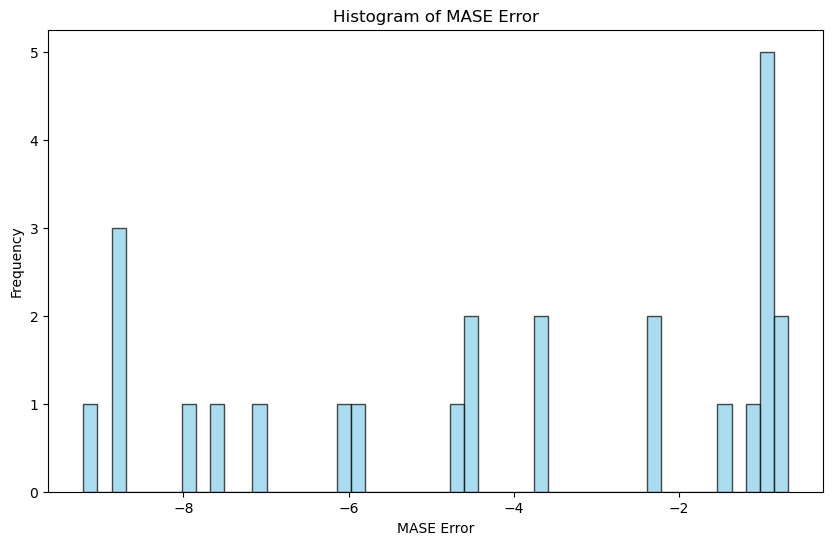

In [93]:
plt.figure(figsize=(10, 6))
plt.hist(errors_B_Industry["MASE_error"], bins=50, alpha=0.7, color="skyblue", edgecolor="black")
plt.xlabel("MASE Error")
plt.ylabel("Frequency")
plt.title("Histogram of MASE Error")
plt.show()


In the graph we can observe that most of the configurations had an MASE error between -1 and 0 approximately. As the model multu¿iply the actual result by -1 so we can interpretate that in most of the configurations the model beats to the Naive error.

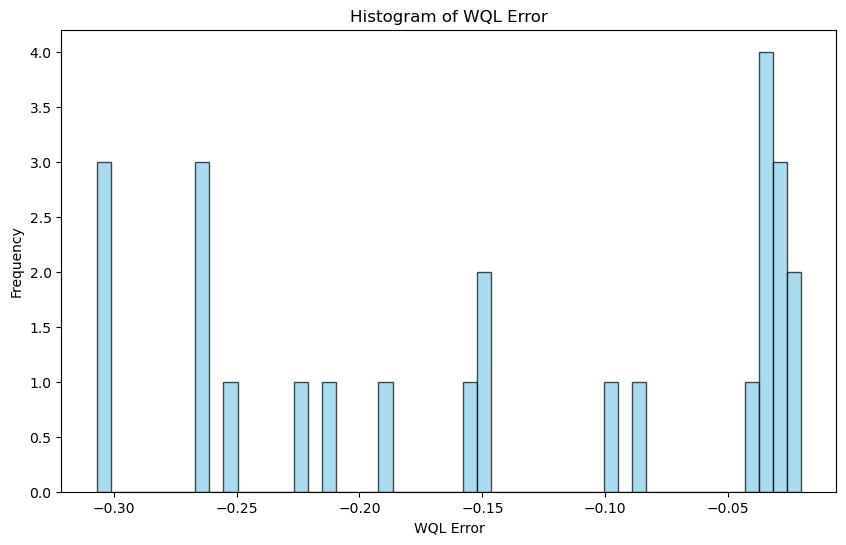

In [94]:
plt.figure(figsize=(10, 6))
plt.hist(errors_B_Industry["WQL_error"], bins=50, alpha=0.7, color="skyblue", edgecolor="black")
plt.xlabel("WQL Error")
plt.ylabel("Frequency")
plt.title("Histogram of WQL Error")
plt.show()

From the graph we can observe that most of the WQL Errors are less than -0.05. As the model multiply everything by -1 it is possible to infer that the mean penalty per quantile in each stamp is les tan 5% which means that is a good estimation of the data. 

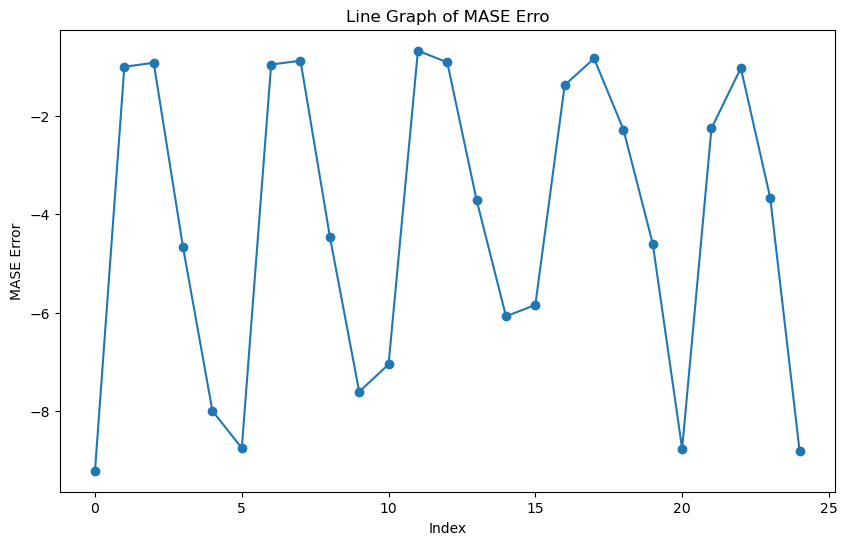

In [95]:
plt.figure(figsize=(10, 6))
plt.plot(errors_B_Industry["MASE_error"].values, marker='o', linestyle='-')
plt.xlabel("Index")
plt.ylabel("MASE Error")
plt.title("Line Graph of MASE Erro")
plt.show()

According to the behaviour of the MASE_error, it is possible to observe that when the test size starts to diminish then the MASE improves until when train size also diminish. 

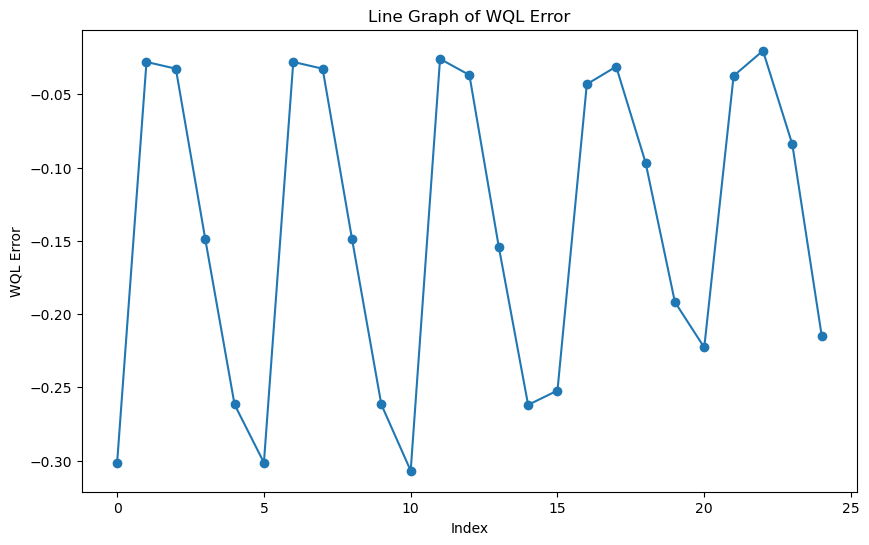

In [96]:
plt.figure(figsize=(10, 6))
plt.plot(errors_B_Industry["WQL_error"].values, marker='o', linestyle='-')
plt.xlabel("Index")
plt.ylabel("WQL Error")
plt.title("Line Graph of WQL Error")
plt.show()

According to this graph, the WQL error has stronger changes with respect to the split of train and prediction lenght, where the best scores are correlated to the maximum possible training and minimum prediction lenght. But in the long term when training diminish the rank of the error tends to be smaller while is changing the test data. 

In [97]:
errors_B_Industry.sort_values(by="MASE_error")

Train_size Percentage_train Test_size Percentage_test MASE_error  \
0        3655             100%       914            100%   -9.21038   
24        914            25.0%       686           75.0%  -8.804413   
20        914            25.0%       914            100%  -8.765726   
5        3472            95.0%       914            100%   -8.74965   
4        3655             100%       686           75.0%  -7.995502   
9        3472            95.0%       686           75.0%  -7.607374   
10       2741            75.0%       914            100%  -7.049526   
14       2741            75.0%       686           75.0%  -6.073799   
15       1828            50.0%       914            100%  -5.843017   
3        3655             100%       457           50.0%  -4.676028   
19       1828            50.0%       686           75.0%  -4.602372   
8        3472            95.0%       457           50.0%   -4.45555   
13       2741            75.0%       457           50.0%  -3.716964   
23        914            25.0%       457           50.0%  -3.665247   
18       1828            50.0%       457           50.0%  -2.280568   
21        914            25.0%        46            5.0%  -2.255846   
16       1828            50.0%        46            5.0%  -1.379894   
22        914            25.0%       228           25.0%  -1.033316   
1        3655             100%        46            5.0%   -1.00678   
6        3472            95.0%        46            5.0%  -0.961585   
2        3655             100%       228           25.0%  -0.925345   
12       2741            75.0%       228           25.0%  -0.917047   
7        3472            95.0%       228           25.0%  -0.882891   
17       1828            50.0%       228           25.0%  -0.837383   
11       2741            75.0%        46            5.0%  -0.680479   

   Diference_MASE WQL_error Diference_WQL Train_Test_Diff  
0               0 -0.301437             0            2741  
24       5.139166 -0.214725      0.130549             228  
20       4.163354 -0.222822      0.031048               0  
5        0.754148 -0.301437        0.0397            2558  
4        3.319474 -0.261737      0.113162            2969  
9        3.151825 -0.261737      0.113162            2786  
10       0.557849 -0.306939      0.045202            1827  
14       2.356835 -0.262001       0.10798            2055  
15       0.230782 -0.252218      0.009783             914  
3        3.750683 -0.148575      0.116045            3198  
19       2.321803 -0.191774      0.095216            1142  
8        3.572658 -0.148575      0.116045            3015  
13       2.799918 -0.154022      0.117174            2284  
23       2.631931 -0.084176      0.063918             457  
18       1.443186 -0.096559      0.065459            1371  
21        6.50988 -0.037433      0.185389             868  
16       4.463123 -0.043121      0.209097            1782  
22        1.22253 -0.020258      0.017175             686  
1          8.2036 -0.027923      0.273514            3609  
6        7.788065 -0.027923      0.273514            3426  
2        0.081435 -0.032531      0.004607            3427  
12       0.236567 -0.036848      0.011013            2513  
7        0.078693 -0.032531      0.004607            3244  
17       0.542511 -0.031099      0.012022            1600  
11       6.369046 -0.025835      0.281104            2695

In [98]:
46/(2741+46)

0.016505202726946538

According to the MASE_error, the worst configurations are the ones where the train_size and prediction lenght are the biggest ones and the best ones are when the size of the prediction test is approximately the 1% of the total data

In [99]:
errors_B_Industry.sort_values(by="WQL_error")

Train_size Percentage_train Test_size Percentage_test MASE_error  \
10       2741            75.0%       914            100%  -7.049526   
0        3655             100%       914            100%   -9.21038   
5        3472            95.0%       914            100%   -8.74965   
14       2741            75.0%       686           75.0%  -6.073799   
4        3655             100%       686           75.0%  -7.995502   
9        3472            95.0%       686           75.0%  -7.607374   
15       1828            50.0%       914            100%  -5.843017   
20        914            25.0%       914            100%  -8.765726   
24        914            25.0%       686           75.0%  -8.804413   
19       1828            50.0%       686           75.0%  -4.602372   
13       2741            75.0%       457           50.0%  -3.716964   
3        3655             100%       457           50.0%  -4.676028   
8        3472            95.0%       457           50.0%   -4.45555   
18       1828            50.0%       457           50.0%  -2.280568   
23        914            25.0%       457           50.0%  -3.665247   
16       1828            50.0%        46            5.0%  -1.379894   
21        914            25.0%        46            5.0%  -2.255846   
12       2741            75.0%       228           25.0%  -0.917047   
7        3472            95.0%       228           25.0%  -0.882891   
2        3655             100%       228           25.0%  -0.925345   
17       1828            50.0%       228           25.0%  -0.837383   
6        3472            95.0%        46            5.0%  -0.961585   
1        3655             100%        46            5.0%   -1.00678   
11       2741            75.0%        46            5.0%  -0.680479   
22        914            25.0%       228           25.0%  -1.033316   

   Diference_MASE WQL_error Diference_WQL Train_Test_Diff  
10       0.557849 -0.306939      0.045202            1827  
0               0 -0.301437             0            2741  
5        0.754148 -0.301437        0.0397            2558  
14       2.356835 -0.262001       0.10798            2055  
4        3.319474 -0.261737      0.113162            2969  
9        3.151825 -0.261737      0.113162            2786  
15       0.230782 -0.252218      0.009783             914  
20       4.163354 -0.222822      0.031048               0  
24       5.139166 -0.214725      0.130549             228  
19       2.321803 -0.191774      0.095216            1142  
13       2.799918 -0.154022      0.117174            2284  
3        3.750683 -0.148575      0.116045            3198  
8        3.572658 -0.148575      0.116045            3015  
18       1.443186 -0.096559      0.065459            1371  
23       2.631931 -0.084176      0.063918             457  
16       4.463123 -0.043121      0.209097            1782  
21        6.50988 -0.037433      0.185389             868  
12       0.236567 -0.036848      0.011013            2513  
7        0.078693 -0.032531      0.004607            3244  
2        0.081435 -0.032531      0.004607            3427  
17       0.542511 -0.031099      0.012022            1600  
6        7.788065 -0.027923      0.273514            3426  
1          8.2036 -0.027923      0.273514            3609  
11       6.369046 -0.025835      0.281104            2695  
22        1.22253 -0.020258      0.017175             686

In this table it is possible to observe that the WQL_error is the minimum possible in this configuration when the training size is the maximum and the prediction length is the minimum possible. 


The worst possible configuration corresponds to the configuration #20  which corresponds to the same quantity of historical lenght and prediction lenght

Let's see how the features are correlated btwn them and the errors

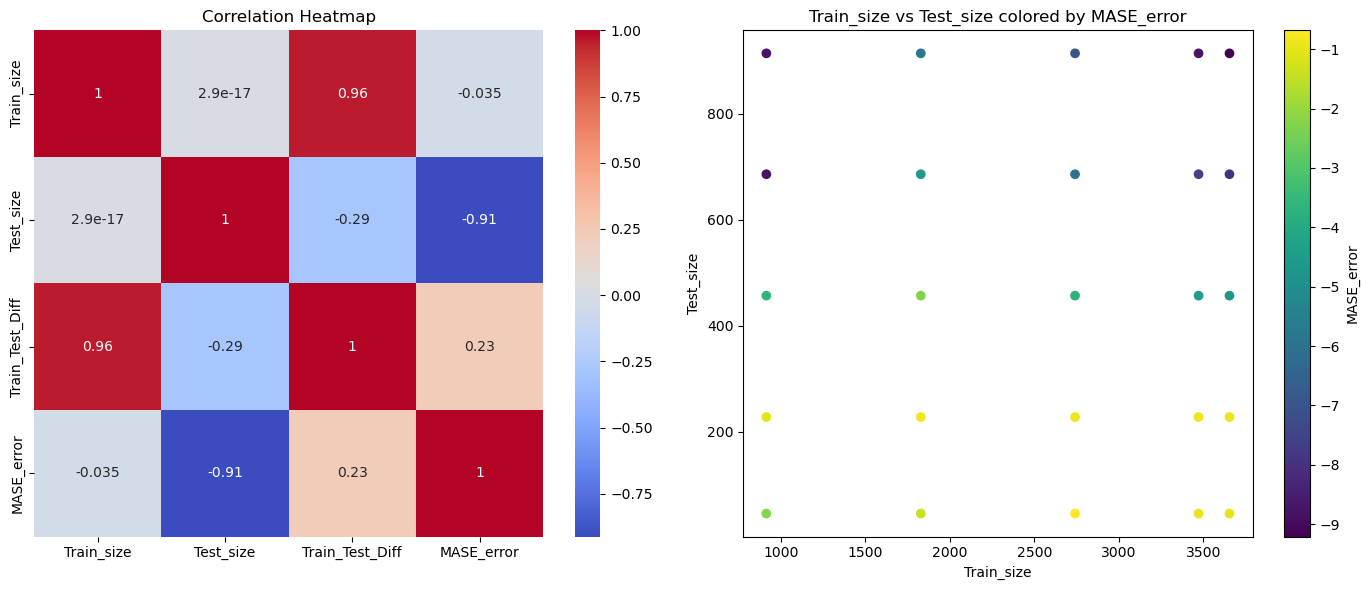

In [100]:
features = ["Train_size", "Test_size", "Train_Test_Diff", "MASE_error"]
corr_matrix = errors_B_Industry[features].corr()
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", ax=axes[0])
axes[0].set_title("Correlation Heatmap")
scatter = axes[1].scatter(errors_B_Industry["Train_size"], errors_B_Industry["Test_size"],
                          c=errors_B_Industry["MASE_error"], cmap="viridis")
axes[1].set_xlabel("Train_size")
axes[1].set_ylabel("Test_size")
axes[1].set_title("Train_size vs Test_size colored by MASE_error")
fig.colorbar(scatter, ax=axes[1], label="MASE_error")

plt.tight_layout()
plt.show()

As it is possible to observe, with the MASE_error, the error has a bigger correlance with the test size than with the train_size and it is more significant than even the difference between them. Also it is possible to observe that the highest the training size and the less the test_size the error tends to be lower. 

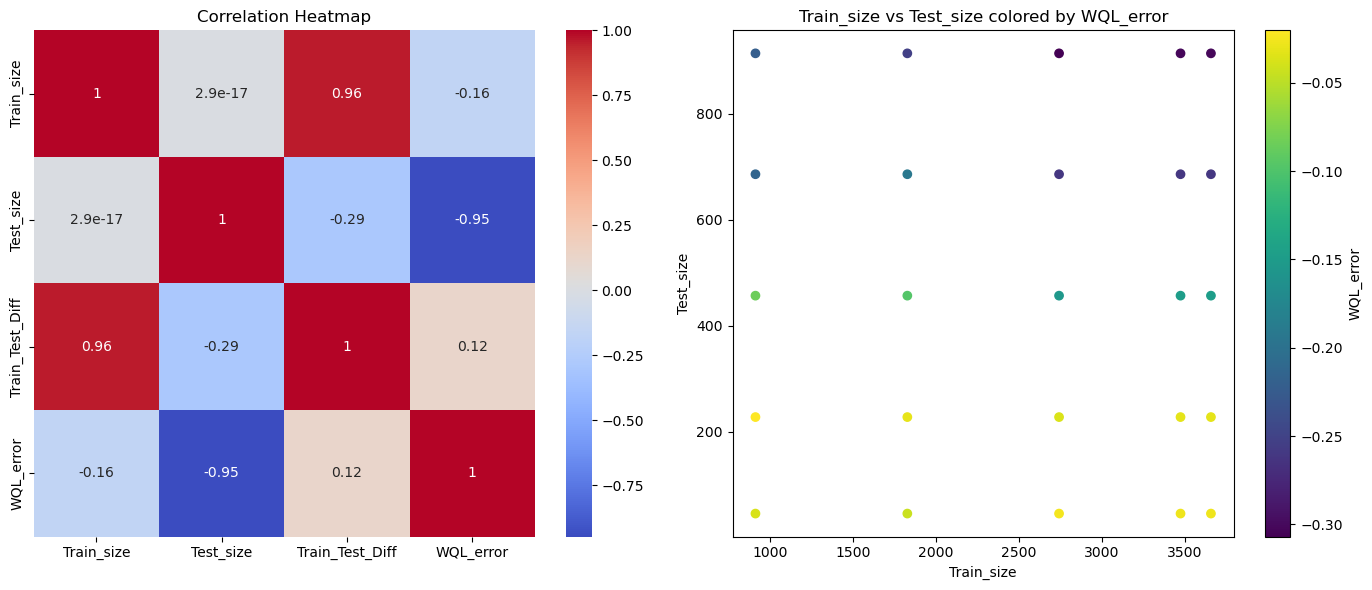

In [101]:
features = ["Train_size", "Test_size", "Train_Test_Diff", "WQL_error"]
corr_matrix = errors_B_Industry[features].corr()
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", ax=axes[0])
axes[0].set_title("Correlation Heatmap")

scatter = axes[1].scatter(errors_B_Industry["Train_size"], errors_B_Industry["Test_size"],
                          c=errors_B_Industry["WQL_error"], cmap="viridis")
axes[1].set_xlabel("Train_size")
axes[1].set_ylabel("Test_size")
axes[1].set_title("Train_size vs Test_size colored by WQL_error")
fig.colorbar(scatter, ax=axes[1], label="WQL_error")

plt.tight_layout()
plt.show()

As it is possible to observe, with the WQL_error, the error has a bigger correlance with the test_size than with the train_size. It is possible possible to observe than the lowest the test_size the better the WQL error. 

From the daily dataset we will take the minimum errors from MASE: -0.529009 with the configuration of 2741	train data corresponding to the 75.0% of historical lenght and 46 prediction length corresponding to the 5.0% of the original split with the test data. 	


### Monthly data

In [102]:
#Take the first value of each month
df_Industry_monthly = df_Industry_1.resample('MS').first().sort_index(ascending=True)

The behaviour of the data it is really similar to the daily data, let's see how the erros chang or if they are the same. 

In [103]:
df_Industry_monthly.index
#The frequency is monthly

DatetimeIndex(['2000-03-01', '2000-04-01', '2000-05-01', '2000-06-01',
               '2000-07-01', '2000-08-01', '2000-09-01', '2000-10-01',
               '2000-11-01', '2000-12-01',
               ...
               '2011-12-01', '2012-01-01', '2012-02-01', '2012-03-01',
               '2012-04-01', '2012-05-01', '2012-06-01', '2012-07-01',
               '2012-08-01', '2012-09-01'],
              dtype='datetime64[ns]', name='timestamp', length=151, freq='MS')

In [104]:
df_Industry_monthly.index = pd.to_datetime(df_Industry_monthly.index).normalize()

In [105]:
df_Industry_monthly.head(20)

item_id           timestamp  target
timestamp                                      
2000-03-01  T002014 2000-03-01 12:00:00  1648.4
2000-04-01  T002014 2000-04-01 12:00:00  1824.8
2000-05-01  T002014 2000-05-01 12:00:00  1626.2
2000-06-01  T002014 2000-06-01 12:00:00  1565.4
2000-07-01  T002014 2000-07-01 12:00:00  1486.6
2000-08-01  T002014 2000-08-01 12:00:00  1463.0
2000-09-01  T002014 2000-09-01 12:00:00  1637.0
2000-10-01  T002014 2000-10-01 12:00:00  1703.1
2000-11-01  T002014 2000-11-01 12:00:00  1899.8
2000-12-01  T002014 2000-12-01 12:00:00  1918.1
2001-01-01  T002014 2001-01-01 12:00:00  1897.1
2001-02-01  T002014 2001-02-01 12:00:00  1909.6
2001-03-01  T002014 2001-03-01 12:00:00  1976.8
2001-04-01  T002014 2001-04-01 12:00:00  1932.3
2001-05-01  T002014 2001-05-01 12:00:00  1833.4
2001-06-01  T002014 2001-06-01 12:00:00  1641.7
2001-07-01  T002014 2001-07-01 12:00:00  1661.8
2001-08-01  T002014 2001-08-01 12:00:00  1762.7
2001-09-01  T002014 2001-09-01 12:00:00  1910.8
2001-10-01  T002014 2001-10-01 12:00:00  2287.9

In [106]:
df_Industry_monthly.shape

(151, 3)

In [107]:
df_Industry_monthly.dtypes

item_id      string[python]
timestamp    datetime64[ns]
target              float64
dtype: object

In [108]:
df_Industry_monthly.index = df_Industry_monthly.index.normalize()

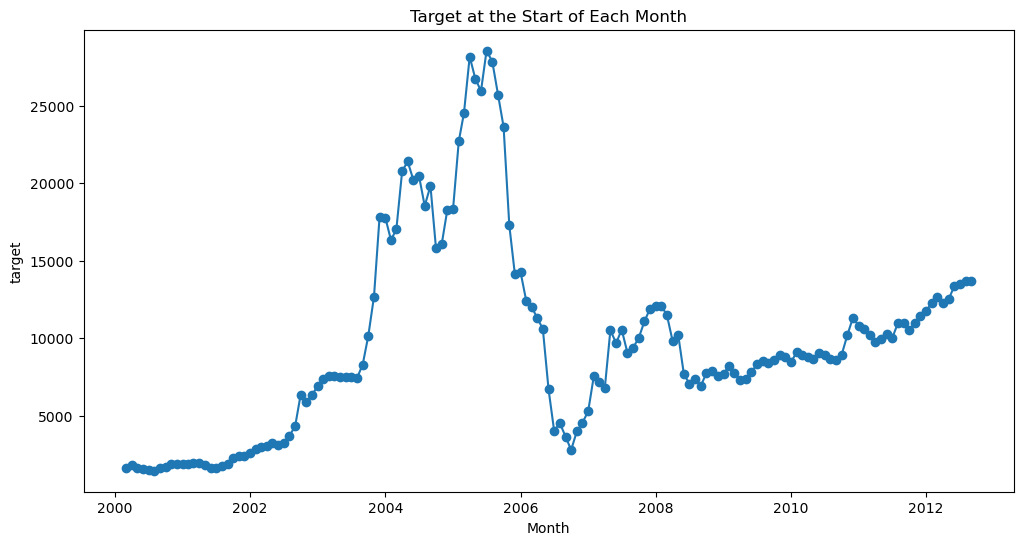

In [109]:
ts = df_Industry_monthly                   # shorthand
x  = ts.index.get_level_values('timestamp')   # just the dates
y  = ts['target'].values                     # the values

plt.figure(figsize=(12, 6))
plt.plot(x, y, marker='o')
plt.title("Target at the Start of Each Month")
plt.xlabel("Month")
plt.ylabel("target")
plt.show()


In [110]:
errors_M_industry=get_errors(df_Industry_monthly, frequ="B")

---------data len 151


Empty DataFrame
Columns: [Train_size, Percentage_train, Test_size, Percentage_test, MASE_error, Diference_MASE, WQL_error, Diference_WQL]
Index: []

Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193652'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.21 GB / 7.37 GB (2.9%)
Disk Space Avail:   4.30 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 30,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'targe

----------historical length 121
----------prediction_length 30
-----------history len, min and max 121 ('T002014', Timestamp('2000-03-01 12:00:00')) ('T002014', Timestamp('2010-03-01 12:00:00'))


Provided train_data has 2609 rows (NaN fraction=95.4%), 1 time series. Median time series length is 2609 (min=2609, max=2609). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 21:36:52
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.05 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193652-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Mac

---------beginning 0
---------total_length 151
----------training len 121
----------training                              target
item_id timestamp                  
T002014 2010-02-01 12:00:00  9100.9
        2010-03-01 12:00:00  8892.2
----------testing len 151
----------testtt                               target
item_id timestamp                   
T002014 2010-04-01 12:00:00   8821.1
        2010-05-01 12:00:00   8666.8
        2010-06-01 12:00:00   9083.5
        2010-07-01 12:00:00   8895.7
        2010-08-01 12:00:00   8634.4
        2010-09-01 12:00:00   8620.2
        2010-10-01 12:00:00   8933.5
        2010-11-01 12:00:00  10202.6
        2010-12-01 12:00:00  11321.9
        2011-01-01 12:00:00  10809.4
        2011-02-01 12:00:00  10592.2
        2011-03-01 12:00:00  10187.1
        2011-04-01 12:00:00   9773.8
        2011-05-01 12:00:00   9931.1
        2011-06-01 12:00:00  10279.1
        2011-07-01 12:00:00  10006.7
        2011-08-01 12:00:00  10975.6
        2011-09-0

mean          0.1          0.2  \
item_id timestamp                                                    
T002014 2010-04-01 12:00:00  7364.857910  6084.488281  6463.444824   
        2010-05-01 12:00:00  7197.854492  5861.500977  6240.087402   
        2010-06-01 12:00:00  6982.304688  5439.753418  5925.568359   
        2010-07-01 12:00:00  6899.668945  5271.696777  5818.739746   
        2010-08-01 12:00:00  7109.266113  5505.202148  6040.776367   
        2010-09-01 12:00:00  7181.762695  5519.416992  6039.129883   
        2010-10-01 12:00:00  7042.348633  5394.997070  5932.475586   
        2010-11-01 12:00:00  6861.416992  5397.549805  5896.247070   
        2010-12-01 12:00:00  6930.289551  5476.735352  5929.981445   
        2011-01-01 12:00:00  6904.209961  5472.680176  5845.054199   
        2011-02-01 12:00:00  6889.937988  5336.486816  5748.740723   
        2011-03-01 12:00:00  6801.676758  5318.207031  5719.626465   
        2011-04-01 12:00:00  6775.047363  5435.258789  5839.098145   
        2011-05-01 12:00:00  6620.807129  5482.333496  5845.562500   
        2011-06-01 12:00:00  6680.878418  5530.323730  5872.375000   
        2011-07-01 12:00:00  6949.708496  5597.501953  5933.139160   
        2011-08-01 12:00:00  7035.595215  5557.351562  5930.895020   
        2011-09-01 12:00:00  6931.734863  5558.848145  5926.864258   
        2011-10-01 12:00:00  7037.797363  5563.489258  5934.266113   
        2011-11-01 12:00:00  7424.693359  5693.182617  6074.448242   
        2011-12-01 12:00:00  7466.805664  5718.067871  6042.168457   
        2012-01-01 12:00:00  7013.365234  5509.576660  5770.442871   
        2012-02-01 12:00:00  6804.399414  5481.979492  5751.227051   
        2012-03-01 12:00:00  6839.940430  5601.774902  5884.111328   
        2012-04-01 12:00:00  6932.682617  5783.395508  6061.782715   
        2012-05-01 12:00:00  6891.248047  5685.333496  5957.549805   
        2012-06-01 12:00:00  6777.176270  5651.107910  5910.696289   
        2012-07-01 12:00:00  6705.629395  5641.541016  5967.253418   
        2012-08-01 12:00:00  6857.207520  5760.437988  6142.795410   
        2012-09-01 12:00:00  6953.111328  5838.542480  6192.123535   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T002014 2010-04-01 12:00:00  6718.006348  6991.346191  7364.857910   
        2010-05-01 12:00:00  6475.171387  6750.164062  7197.854492   
        2010-06-01 12:00:00  6217.704102  6510.568359  6982.304688   
        2010-07-01 12:00:00  6166.052246  6470.637207  6899.668945   
        2010-08-01 12:00:00  6347.774902  6648.358398  7109.266113   
        2010-09-01 12:00:00  6333.527344  6639.581055  7181.762695   
        2010-10-01 12:00:00  6219.530762  6495.864746  7042.348633   
        2010-11-01 12:00:00  6135.240723  6375.705566  6861.416992   
        2010-12-01 12:00:00  6142.355957  6421.094727  6930.289551   
        2011-01-01 12:00:00  6035.488281  6326.210938  6904.209961   
        2011-02-01 12:00:00  5944.475098  6266.726562  6889.937988   
        2011-03-01 12:00:00  5897.123535  6182.297852  6801.676758   
        2011-04-01 12:00:00  5996.870605  6230.925781  6775.047363   
        2011-05-01 12:00:00  6007.190918  6219.030762  6620.807129   
        2011-06-01 12:00:00  6019.587891  6236.000977  6680.878418   
        2011-07-01 12:00:00  6141.514648  6427.508789  6949.708496   
        2011-08-01 12:00:00  6152.214844  6472.629883  7035.595215   
        2011-09-01 12:00:00  6054.086914  6344.465820  6931.734863   
        2011-10-01 12:00:00  6087.709961  6373.870117  7037.797363   
        2011-11-01 12:00:00  6287.198730  6689.768066  7424.693359   
        2011-12-01 12:00:00  6295.664551  6716.542969  7466.805664   
        2012-01-01 12:00:00  6010.379395  6371.639160  7013.365234   
        2012-02-01 12:00:00  5967.380371  6284.296875  6804.399414   
        2012-03-01 12:00:00  6018.074707  624

---len test slide 151


target
item_id timestamp                   
T002014 2010-04-01 12:00:00   8821.1
        2010-05-01 12:00:00   8666.8
        2010-06-01 12:00:00   9083.5
        2010-07-01 12:00:00   8895.7
        2010-08-01 12:00:00   8634.4
        2010-09-01 12:00:00   8620.2
        2010-10-01 12:00:00   8933.5
        2010-11-01 12:00:00  10202.6
        2010-12-01 12:00:00  11321.9
        2011-01-01 12:00:00  10809.4
        2011-02-01 12:00:00  10592.2
        2011-03-01 12:00:00  10187.1
        2011-04-01 12:00:00   9773.8
        2011-05-01 12:00:00   9931.1
        2011-06-01 12:00:00  10279.1
        2011-07-01 12:00:00  10006.7
        2011-08-01 12:00:00  10975.6
        2011-09-01 12:00:00  10990.5
        2011-10-01 12:00:00  10528.2
        2011-11-01 12:00:00  11019.0
        2011-12-01 12:00:00  11420.7
        2012-01-01 12:00:00  11782.1
        2012-02-01 12:00:00  12283.5
        2012-03-01 12:00:00  12686.3
        2012-04-01 12:00:00  12247.0
        2012-05-01 12:00:00  12507.5
        2012-06-01 12:00:00  13376.2
        2012-07-01 12:00:00  13527.2
        2012-08-01 12:00:00  13685.0
        2012-09-01 12:00:00  13717.0

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193659'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.57 GB / 7.37 GB (7.7%)
Disk Space Avail:   4.30 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metr

----------prediction_length 2
-----------history len, min and max 121 ('T002014', Timestamp('2000-03-01 12:00:00')) ('T002014', Timestamp('2010-03-01 12:00:00'))



Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 21:37:00
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.11 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193700'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.67 GB / 7.37 GB (9.1

---------beginning 0
---------total_length 123
----------training len 121
----------training                              target
item_id timestamp                  
T002014 2010-02-01 12:00:00  9100.9
        2010-03-01 12:00:00  8892.2
----------testing len 123
----------testtt                              target
item_id timestamp                  
T002014 2010-04-01 12:00:00  8821.1
        2010-05-01 12:00:00  8666.8
-----------len predictions 2


mean          0.1          0.2  \
item_id timestamp                                                    
T002014 2010-04-01 12:00:00  7364.857910  6084.488281  6463.444824   
        2010-05-01 12:00:00  7197.854492  5861.500977  6240.087402   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T002014 2010-04-01 12:00:00  6718.006348  6991.346191  7364.857910   
        2010-05-01 12:00:00  6475.171387  6750.164062  7197.854492   

                                     0.6          0.7           0.8  \
item_id timestamp                                                     
T002014 2010-04-01 12:00:00  8064.111328  9209.360352  11044.989258   
        2010-05-01 12:00:00  7947.461426  9244.303711  11266.857422   

                                      0.9  
item_id timestamp                          
T002014 2010-04-01 12:00:00  14526.891602  
        2010-05-01 12:00:00  15377.816406

---len test slide 123


target
item_id timestamp                  
T002014 2010-04-01 12:00:00  8821.1
        2010-05-01 12:00:00  8666.8

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193706'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.76 GB / 7.37 GB (10.3%)
Disk Space Avail:   4.31 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_met

----------prediction_length 8
-----------history len, min and max 121 ('T002014', Timestamp('2000-03-01 12:00:00')) ('T002014', Timestamp('2010-03-01 12:00:00'))


Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.05 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193706-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.76 GB / 7.37 GB (10.3%)
Disk Space Avail:   4.31 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 8,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8

---------beginning 0
---------total_length 129
----------training len 121
----------training                              target
item_id timestamp                  
T002014 2010-02-01 12:00:00  9100.9
        2010-03-01 12:00:00  8892.2
----------testing len 129
----------testtt                               target
item_id timestamp                   
T002014 2010-04-01 12:00:00   8821.1
        2010-05-01 12:00:00   8666.8
        2010-06-01 12:00:00   9083.5
        2010-07-01 12:00:00   8895.7
        2010-08-01 12:00:00   8634.4
        2010-09-01 12:00:00   8620.2
        2010-10-01 12:00:00   8933.5
        2010-11-01 12:00:00  10202.6
-----------len predictions 8


mean          0.1          0.2  \
item_id timestamp                                                    
T002014 2010-04-01 12:00:00  7364.857910  6084.488281  6463.444824   
        2010-05-01 12:00:00  7197.854492  5861.500977  6240.087402   
        2010-06-01 12:00:00  6982.304688  5439.753418  5925.568359   
        2010-07-01 12:00:00  6899.668945  5271.696777  5818.739746   
        2010-08-01 12:00:00  7109.266113  5505.202148  6040.776367   
        2010-09-01 12:00:00  7181.762695  5519.416992  6039.129883   
        2010-10-01 12:00:00  7042.348633  5394.997070  5932.475586   
        2010-11-01 12:00:00  6861.416992  5397.549805  5896.247070   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T002014 2010-04-01 12:00:00  6718.006348  6991.346191  7364.857910   
        2010-05-01 12:00:00  6475.171387  6750.164062  7197.854492   
        2010-06-01 12:00:00  6217.704102  6510.568359  6982.304688   
        2010-07-01 12:00:00  6166.052246  6470.637207  6899.668945   
        2010-08-01 12:00:00  6347.774902  6648.358398  7109.266113   
        2010-09-01 12:00:00  6333.527344  6639.581055  7181.762695   
        2010-10-01 12:00:00  6219.530762  6495.864746  7042.348633   
        2010-11-01 12:00:00  6135.240723  6375.705566  6861.416992   

                                     0.6          0.7           0.8  \
item_id timestamp                                                     
T002014 2010-04-01 12:00:00  8064.111328  9209.360352  11044.989258   
        2010-05-01 12:00:00  7947.461426  9244.303711  11266.857422   
        2010-06-01 12:00:00  7785.610840  9226.703125  11570.116211   
        2010-07-01 12:00:00  7710.738770  9279.969727  11847.412109   
        2010-08-01 12:00:00  7969.482910  9580.156250  12248.746094   
        2010-09-01 12:00:00  8138.833984  9711.496094  12312.386719   
        2010-10-01 12:00:00  8024.109375  9692.545898  12294.650391   
        2010-11-01 12:00:00  7940.660156  9645.886719  12387.626953   

                                      0.9  
item_id timestamp                          
T002014 2010-04-01 12:00:00  14526.891602  
        2010-05-01 12:00:00  15377.816406  
        2010-06-01 12:00:00  16070.511719  
        2010-07-01 12:00:00  16603.423828  
        2010-08-01 12:00:00  17275.878906  
        2010-09-01 12:00:00  17380.792969  
        2010-10-01 12:00:00  17406.392578  
        2010-11-01 12:00:00  17624.664062

---len test slide 129


target
item_id timestamp                   
T002014 2010-04-01 12:00:00   8821.1
        2010-05-01 12:00:00   8666.8
        2010-06-01 12:00:00   9083.5
        2010-07-01 12:00:00   8895.7
        2010-08-01 12:00:00   8634.4
        2010-09-01 12:00:00   8620.2
        2010-10-01 12:00:00   8933.5
        2010-11-01 12:00:00  10202.6

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193711'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.71 GB / 7.37 GB (9.7%)
Disk Space Avail:   4.32 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metr

----------prediction_length 15
-----------history len, min and max 121 ('T002014', Timestamp('2000-03-01 12:00:00')) ('T002014', Timestamp('2010-03-01 12:00:00'))


	0.00    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.03 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193712'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.75 GB / 7.37 GB (10.2%)
Disk Space Avail:   4.32 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 15,
 'quantile_levels': [0.1, 0.

---------beginning 0
---------total_length 136
----------training len 121
----------training                              target
item_id timestamp                  
T002014 2010-02-01 12:00:00  9100.9
        2010-03-01 12:00:00  8892.2
----------testing len 136
----------testtt                               target
item_id timestamp                   
T002014 2010-04-01 12:00:00   8821.1
        2010-05-01 12:00:00   8666.8
        2010-06-01 12:00:00   9083.5
        2010-07-01 12:00:00   8895.7
        2010-08-01 12:00:00   8634.4
        2010-09-01 12:00:00   8620.2
        2010-10-01 12:00:00   8933.5
        2010-11-01 12:00:00  10202.6
        2010-12-01 12:00:00  11321.9
        2011-01-01 12:00:00  10809.4
        2011-02-01 12:00:00  10592.2
        2011-03-01 12:00:00  10187.1
        2011-04-01 12:00:00   9773.8
        2011-05-01 12:00:00   9931.1
        2011-06-01 12:00:00  10279.1
-----------len predictions 15


mean          0.1          0.2  \
item_id timestamp                                                    
T002014 2010-04-01 12:00:00  7364.857910  6084.488281  6463.444824   
        2010-05-01 12:00:00  7197.854492  5861.500977  6240.087402   
        2010-06-01 12:00:00  6982.304688  5439.753418  5925.568359   
        2010-07-01 12:00:00  6899.668945  5271.696777  5818.739746   
        2010-08-01 12:00:00  7109.266113  5505.202148  6040.776367   
        2010-09-01 12:00:00  7181.762695  5519.416992  6039.129883   
        2010-10-01 12:00:00  7042.348633  5394.997070  5932.475586   
        2010-11-01 12:00:00  6861.416992  5397.549805  5896.247070   
        2010-12-01 12:00:00  6930.289551  5476.735352  5929.981445   
        2011-01-01 12:00:00  6904.209961  5472.680176  5845.054199   
        2011-02-01 12:00:00  6889.937988  5336.486816  5748.740723   
        2011-03-01 12:00:00  6801.676758  5318.207031  5719.626465   
        2011-04-01 12:00:00  6775.047363  5435.258789  5839.098145   
        2011-05-01 12:00:00  6620.807129  5482.333496  5845.562500   
        2011-06-01 12:00:00  6680.878418  5530.323730  5872.375000   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T002014 2010-04-01 12:00:00  6718.006348  6991.346191  7364.857910   
        2010-05-01 12:00:00  6475.171387  6750.164062  7197.854492   
        2010-06-01 12:00:00  6217.704102  6510.568359  6982.304688   
        2010-07-01 12:00:00  6166.052246  6470.637207  6899.668945   
        2010-08-01 12:00:00  6347.774902  6648.358398  7109.266113   
        2010-09-01 12:00:00  6333.527344  6639.581055  7181.762695   
        2010-10-01 12:00:00  6219.530762  6495.864746  7042.348633   
        2010-11-01 12:00:00  6135.240723  6375.705566  6861.416992   
        2010-12-01 12:00:00  6142.355957  6421.094727  6930.289551   
        2011-01-01 12:00:00  6035.488281  6326.210938  6904.209961   
        2011-02-01 12:00:00  5944.475098  6266.726562  6889.937988   
        2011-03-01 12:00:00  5897.123535  6182.297852  6801.676758   
        2011-04-01 12:00:00  5996.870605  6230.925781  6775.047363   
        2011-05-01 12:00:00  6007.190918  6219.030762  6620.807129   
        2011-06-01 12:00:00  6019.587891  6236.000977  6680.878418   

                                     0.6          0.7           0.8  \
item_id timestamp                                                     
T002014 2010-04-01 12:00:00  8064.111328  9209.360352  11044.989258   
        2010-05-01 12:00:00  7947.461426  9244.303711  11266.857422   
        2010-06-01 12:00:00  7785.610840  9226.703125  11570.116211   
        2010-07-01 12:00:00  7710.738770  9279.969727  11847.412109   
        2010-08-01 12:00:00  7969.482910  9580.156250  12248.746094   
        2010-09-01 12:00:00  8138.833984  9711.496094  12312.386719   
        2010-10-01 12:00:00  8024.109375  9692.545898  12294.650391   
        2010-11-01 12:00:00  7940.660156  9645.886719  12387.626953   
        2010-12-01 12:00:00  8008.967773  9760.720703  12590.416992   
        2011-01-01 12:00:00  7963.250977  9748.698242  12661.137695   
        2011-02-01 12:00:00  7957.884766  9722.574219  12621.236328   
        2011-03-01 12:00:00  7982.990723  9880.594727  12727.170898   
        2011-04-01 12:00:00  7946.455566  9873.353516  12787.556641   
        2011-05-01 12:00:00  7652.788574  9548.684570  12460.523438   
        2011-06-01 12:00:00  7739.037598  9646.448242  12494.886719   

                                      0.9  
item_id timestamp                          
T002014 2010-04-01 12:00:00  14526.891602  
        2010-05-01 12:00:00  15377.816406  
        2010-06-01 12:00:00  16070.511719  
        2010-07-01 12:00:00  16603.423828  
        2010-08-01 12:00:00  17275.878906  
        2010-09-01 12:00:00  17380.792969  
        2010-10-01 12:00:00  17406.392578  
        2010-11-01 12:00:00  17624.664062  
      

---len test slide 136


target
item_id timestamp                   
T002014 2010-04-01 12:00:00   8821.1
        2010-05-01 12:00:00   8666.8
        2010-06-01 12:00:00   9083.5
        2010-07-01 12:00:00   8895.7
        2010-08-01 12:00:00   8634.4
        2010-09-01 12:00:00   8620.2
        2010-10-01 12:00:00   8933.5
        2010-11-01 12:00:00  10202.6
        2010-12-01 12:00:00  11321.9
        2011-01-01 12:00:00  10809.4
        2011-02-01 12:00:00  10592.2
        2011-03-01 12:00:00  10187.1
        2011-04-01 12:00:00   9773.8
        2011-05-01 12:00:00   9931.1
        2011-06-01 12:00:00  10279.1

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193718'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.69 GB / 7.37 GB (9.4%)
Disk Space Avail:   4.31 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metr

----------prediction_length 22
-----------history len, min and max 121 ('T002014', Timestamp('2000-03-01 12:00:00')) ('T002014', Timestamp('2010-03-01 12:00:00'))


Training timeseries model Chronos[bolt_small]. 
	0.00    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.05 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193718-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.69 GB / 7.37 GB (9.4%)
Disk Space Avail:   4.31 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'p

---------beginning 0
---------total_length 143
----------training len 121
----------training                              target
item_id timestamp                  
T002014 2010-02-01 12:00:00  9100.9
        2010-03-01 12:00:00  8892.2
----------testing len 143
----------testtt                               target
item_id timestamp                   
T002014 2010-04-01 12:00:00   8821.1
        2010-05-01 12:00:00   8666.8
        2010-06-01 12:00:00   9083.5
        2010-07-01 12:00:00   8895.7
        2010-08-01 12:00:00   8634.4
        2010-09-01 12:00:00   8620.2
        2010-10-01 12:00:00   8933.5
        2010-11-01 12:00:00  10202.6
        2010-12-01 12:00:00  11321.9
        2011-01-01 12:00:00  10809.4
        2011-02-01 12:00:00  10592.2
        2011-03-01 12:00:00  10187.1
        2011-04-01 12:00:00   9773.8
        2011-05-01 12:00:00   9931.1
        2011-06-01 12:00:00  10279.1
        2011-07-01 12:00:00  10006.7
        2011-08-01 12:00:00  10975.6
        2011-09-0

mean          0.1          0.2  \
item_id timestamp                                                    
T002014 2010-04-01 12:00:00  7364.857910  6084.488281  6463.444824   
        2010-05-01 12:00:00  7197.854492  5861.500977  6240.087402   
        2010-06-01 12:00:00  6982.304688  5439.753418  5925.568359   
        2010-07-01 12:00:00  6899.668945  5271.696777  5818.739746   
        2010-08-01 12:00:00  7109.266113  5505.202148  6040.776367   
        2010-09-01 12:00:00  7181.762695  5519.416992  6039.129883   
        2010-10-01 12:00:00  7042.348633  5394.997070  5932.475586   
        2010-11-01 12:00:00  6861.416992  5397.549805  5896.247070   
        2010-12-01 12:00:00  6930.289551  5476.735352  5929.981445   
        2011-01-01 12:00:00  6904.209961  5472.680176  5845.054199   
        2011-02-01 12:00:00  6889.937988  5336.486816  5748.740723   
        2011-03-01 12:00:00  6801.676758  5318.207031  5719.626465   
        2011-04-01 12:00:00  6775.047363  5435.258789  5839.098145   
        2011-05-01 12:00:00  6620.807129  5482.333496  5845.562500   
        2011-06-01 12:00:00  6680.878418  5530.323730  5872.375000   
        2011-07-01 12:00:00  6949.708496  5597.501953  5933.139160   
        2011-08-01 12:00:00  7035.595215  5557.351562  5930.895020   
        2011-09-01 12:00:00  6931.734863  5558.848145  5926.864258   
        2011-10-01 12:00:00  7037.797363  5563.489258  5934.266113   
        2011-11-01 12:00:00  7424.693359  5693.182617  6074.448242   
        2011-12-01 12:00:00  7466.805664  5718.067871  6042.168457   
        2012-01-01 12:00:00  7013.365234  5509.576660  5770.442871   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T002014 2010-04-01 12:00:00  6718.006348  6991.346191  7364.857910   
        2010-05-01 12:00:00  6475.171387  6750.164062  7197.854492   
        2010-06-01 12:00:00  6217.704102  6510.568359  6982.304688   
        2010-07-01 12:00:00  6166.052246  6470.637207  6899.668945   
        2010-08-01 12:00:00  6347.774902  6648.358398  7109.266113   
        2010-09-01 12:00:00  6333.527344  6639.581055  7181.762695   
        2010-10-01 12:00:00  6219.530762  6495.864746  7042.348633   
        2010-11-01 12:00:00  6135.240723  6375.705566  6861.416992   
        2010-12-01 12:00:00  6142.355957  6421.094727  6930.289551   
        2011-01-01 12:00:00  6035.488281  6326.210938  6904.209961   
        2011-02-01 12:00:00  5944.475098  6266.726562  6889.937988   
        2011-03-01 12:00:00  5897.123535  6182.297852  6801.676758   
        2011-04-01 12:00:00  5996.870605  6230.925781  6775.047363   
        2011-05-01 12:00:00  6007.190918  6219.030762  6620.807129   
        2011-06-01 12:00:00  6019.587891  6236.000977  6680.878418   
        2011-07-01 12:00:00  6141.514648  6427.508789  6949.708496   
        2011-08-01 12:00:00  6152.214844  6472.629883  7035.595215   
        2011-09-01 12:00:00  6054.086914  6344.465820  6931.734863   
        2011-10-01 12:00:00  6087.709961  6373.870117  7037.797363   
        2011-11-01 12:00:00  6287.198730  6689.768066  7424.693359   
        2011-12-01 12:00:00  6295.664551  6716.542969  7466.805664   
        2012-01-01 12:00:00  6010.379395  6371.639160  7013.365234   

                                     0.6           0.7           0.8  \
item_id timestamp                                                      
T002014 2010-04-01 12:00:00  8064.111328   9209.360352  11044.989258   
        2010-05-01 12:00:00  7947.461426   9244.303711  11266.857422   
        2010-06-01 12:00:00  7785.610840   9226.703125  11570.116211   
        2010-07-01 12:00:00  7710.738770   9279.969727  11847.412109   
        2010-08-01 12:00:00  7969.482910   9580.156250  12248.746094   
        2010-09-01 12:00:00  8138.833984   9711.496094  12312.386719   
        2010-10-01 12:00:00  8024.109375   9692.545898  12294.650391   
        2010-11-01 12:00:0

---len test slide 143


target
item_id timestamp                   
T002014 2010-04-01 12:00:00   8821.1
        2010-05-01 12:00:00   8666.8
        2010-06-01 12:00:00   9083.5
        2010-07-01 12:00:00   8895.7
        2010-08-01 12:00:00   8634.4
        2010-09-01 12:00:00   8620.2
        2010-10-01 12:00:00   8933.5
        2010-11-01 12:00:00  10202.6
        2010-12-01 12:00:00  11321.9
        2011-01-01 12:00:00  10809.4
        2011-02-01 12:00:00  10592.2
        2011-03-01 12:00:00  10187.1
        2011-04-01 12:00:00   9773.8
        2011-05-01 12:00:00   9931.1
        2011-06-01 12:00:00  10279.1
        2011-07-01 12:00:00  10006.7
        2011-08-01 12:00:00  10975.6
        2011-09-01 12:00:00  10990.5
        2011-10-01 12:00:00  10528.2
        2011-11-01 12:00:00  11019.0
        2011-12-01 12:00:00  11420.7
        2012-01-01 12:00:00  11782.1

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193724'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.54 GB / 7.37 GB (7.3%)
Disk Space Avail:   4.31 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metr

----------historical length 115
----------prediction_length 30
-----------history len, min and max 115 ('T002014', Timestamp('2000-09-01 12:00:00')) ('T002014', Timestamp('2010-03-01 12:00:00'))


	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 21:37:25
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.00    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.03 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193725'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.57 GB / 7.37 GB (7.7%)
Disk Space Avail:   4.31 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require m

---------beginning 6
---------total_length 151
----------training len 115
----------training                              target
item_id timestamp                  
T002014 2010-02-01 12:00:00  9100.9
        2010-03-01 12:00:00  8892.2
----------testing len 145
----------testtt                               target
item_id timestamp                   
T002014 2010-04-01 12:00:00   8821.1
        2010-05-01 12:00:00   8666.8
        2010-06-01 12:00:00   9083.5
        2010-07-01 12:00:00   8895.7
        2010-08-01 12:00:00   8634.4
        2010-09-01 12:00:00   8620.2
        2010-10-01 12:00:00   8933.5
        2010-11-01 12:00:00  10202.6
        2010-12-01 12:00:00  11321.9
        2011-01-01 12:00:00  10809.4
        2011-02-01 12:00:00  10592.2
        2011-03-01 12:00:00  10187.1
        2011-04-01 12:00:00   9773.8
        2011-05-01 12:00:00   9931.1
        2011-06-01 12:00:00  10279.1
        2011-07-01 12:00:00  10006.7
        2011-08-01 12:00:00  10975.6
        2011-09-0

mean          0.1          0.2  \
item_id timestamp                                                    
T002014 2010-04-01 12:00:00  7364.857910  6084.488281  6463.444824   
        2010-05-01 12:00:00  7197.854492  5861.500977  6240.087402   
        2010-06-01 12:00:00  6982.304688  5439.753418  5925.568359   
        2010-07-01 12:00:00  6899.668945  5271.696777  5818.739746   
        2010-08-01 12:00:00  7109.266113  5505.202148  6040.776367   
        2010-09-01 12:00:00  7181.762695  5519.416992  6039.129883   
        2010-10-01 12:00:00  7042.348633  5394.997070  5932.475586   
        2010-11-01 12:00:00  6861.416992  5397.549805  5896.247070   
        2010-12-01 12:00:00  6930.289551  5476.735352  5929.981445   
        2011-01-01 12:00:00  6904.209961  5472.680176  5845.054199   
        2011-02-01 12:00:00  6889.937988  5336.486816  5748.740723   
        2011-03-01 12:00:00  6801.676758  5318.207031  5719.626465   
        2011-04-01 12:00:00  6775.047363  5435.258789  5839.098145   
        2011-05-01 12:00:00  6620.807129  5482.333496  5845.562500   
        2011-06-01 12:00:00  6680.878418  5530.323730  5872.375000   
        2011-07-01 12:00:00  6949.708496  5597.501953  5933.139160   
        2011-08-01 12:00:00  7035.595215  5557.351562  5930.895020   
        2011-09-01 12:00:00  6931.734863  5558.848145  5926.864258   
        2011-10-01 12:00:00  7037.797363  5563.489258  5934.266113   
        2011-11-01 12:00:00  7424.693359  5693.182617  6074.448242   
        2011-12-01 12:00:00  7466.805664  5718.067871  6042.168457   
        2012-01-01 12:00:00  7013.365234  5509.576660  5770.442871   
        2012-02-01 12:00:00  6804.399414  5481.979492  5751.227051   
        2012-03-01 12:00:00  6839.940430  5601.774902  5884.111328   
        2012-04-01 12:00:00  6932.682617  5783.395508  6061.782715   
        2012-05-01 12:00:00  6891.248047  5685.333496  5957.549805   
        2012-06-01 12:00:00  6777.176270  5651.107910  5910.696289   
        2012-07-01 12:00:00  6705.629395  5641.541016  5967.253418   
        2012-08-01 12:00:00  6857.207520  5760.437988  6142.795410   
        2012-09-01 12:00:00  6953.111328  5838.542480  6192.123535   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T002014 2010-04-01 12:00:00  6718.006348  6991.346191  7364.857910   
        2010-05-01 12:00:00  6475.171387  6750.164062  7197.854492   
        2010-06-01 12:00:00  6217.704102  6510.568359  6982.304688   
        2010-07-01 12:00:00  6166.052246  6470.637207  6899.668945   
        2010-08-01 12:00:00  6347.774902  6648.358398  7109.266113   
        2010-09-01 12:00:00  6333.527344  6639.581055  7181.762695   
        2010-10-01 12:00:00  6219.530762  6495.864746  7042.348633   
        2010-11-01 12:00:00  6135.240723  6375.705566  6861.416992   
        2010-12-01 12:00:00  6142.355957  6421.094727  6930.289551   
        2011-01-01 12:00:00  6035.488281  6326.210938  6904.209961   
        2011-02-01 12:00:00  5944.475098  6266.726562  6889.937988   
        2011-03-01 12:00:00  5897.123535  6182.297852  6801.676758   
        2011-04-01 12:00:00  5996.870605  6230.925781  6775.047363   
        2011-05-01 12:00:00  6007.190918  6219.030762  6620.807129   
        2011-06-01 12:00:00  6019.587891  6236.000977  6680.878418   
        2011-07-01 12:00:00  6141.514648  6427.508789  6949.708496   
        2011-08-01 12:00:00  6152.214844  6472.629883  7035.595215   
        2011-09-01 12:00:00  6054.086914  6344.465820  6931.734863   
        2011-10-01 12:00:00  6087.709961  6373.870117  7037.797363   
        2011-11-01 12:00:00  6287.198730  6689.768066  7424.693359   
        2011-12-01 12:00:00  6295.664551  6716.542969  7466.805664   
        2012-01-01 12:00:00  6010.379395  6371.639160  7013.365234   
        2012-02-01 12:00:00  5967.380371  6284.296875  6804.399414   
        2012-03-01 12:00:00  6018.074707  624

---len test slide 145


target
item_id timestamp                   
T002014 2010-04-01 12:00:00   8821.1
        2010-05-01 12:00:00   8666.8
        2010-06-01 12:00:00   9083.5
        2010-07-01 12:00:00   8895.7
        2010-08-01 12:00:00   8634.4
        2010-09-01 12:00:00   8620.2
        2010-10-01 12:00:00   8933.5
        2010-11-01 12:00:00  10202.6
        2010-12-01 12:00:00  11321.9
        2011-01-01 12:00:00  10809.4
        2011-02-01 12:00:00  10592.2
        2011-03-01 12:00:00  10187.1
        2011-04-01 12:00:00   9773.8
        2011-05-01 12:00:00   9931.1
        2011-06-01 12:00:00  10279.1
        2011-07-01 12:00:00  10006.7
        2011-08-01 12:00:00  10975.6
        2011-09-01 12:00:00  10990.5
        2011-10-01 12:00:00  10528.2
        2011-11-01 12:00:00  11019.0
        2011-12-01 12:00:00  11420.7
        2012-01-01 12:00:00  11782.1
        2012-02-01 12:00:00  12283.5
        2012-03-01 12:00:00  12686.3
        2012-04-01 12:00:00  12247.0
        2012-05-01 12:00:00  12507.5
        2012-06-01 12:00:00  13376.2
        2012-07-01 12:00:00  13527.2
        2012-08-01 12:00:00  13685.0
        2012-09-01 12:00:00  13717.0

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193731'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.69 GB / 7.37 GB (9.3%)
Disk Space Avail:   4.31 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metr

----------prediction_length 2
-----------history len, min and max 115 ('T002014', Timestamp('2000-09-01 12:00:00')) ('T002014', Timestamp('2010-03-01 12:00:00'))


	0.00    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.04 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193731-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.68 GB / 7.37 GB (9.2%)
Disk Space Avail:   4.31 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 2,
 'quantile_levels': [0.1, 

---------beginning 6
---------total_length 123
----------training len 115
----------training                              target
item_id timestamp                  
T002014 2010-02-01 12:00:00  9100.9
        2010-03-01 12:00:00  8892.2
----------testing len 117
----------testtt                              target
item_id timestamp                  
T002014 2010-04-01 12:00:00  8821.1
        2010-05-01 12:00:00  8666.8
-----------len predictions 2


mean          0.1          0.2  \
item_id timestamp                                                    
T002014 2010-04-01 12:00:00  7364.857910  6084.488281  6463.444824   
        2010-05-01 12:00:00  7197.854492  5861.500977  6240.087402   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T002014 2010-04-01 12:00:00  6718.006348  6991.346191  7364.857910   
        2010-05-01 12:00:00  6475.171387  6750.164062  7197.854492   

                                     0.6          0.7           0.8  \
item_id timestamp                                                     
T002014 2010-04-01 12:00:00  8064.111328  9209.360352  11044.989258   
        2010-05-01 12:00:00  7947.461426  9244.303711  11266.857422   

                                      0.9  
item_id timestamp                          
T002014 2010-04-01 12:00:00  14526.891602  
        2010-05-01 12:00:00  15377.816406

---len test slide 117


target
item_id timestamp                  
T002014 2010-04-01 12:00:00  8821.1
        2010-05-01 12:00:00  8666.8

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193737'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.57 GB / 7.37 GB (7.7%)
Disk Space Avail:   4.31 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metr

----------prediction_length 8
-----------history len, min and max 115 ('T002014', Timestamp('2000-09-01 12:00:00')) ('T002014', Timestamp('2010-03-01 12:00:00'))


Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.03 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193737-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.57 GB / 7.37 GB (7.7%)
Disk Space Avail:   4.31 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 8,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,

---------beginning 6
---------total_length 129
----------training len 115
----------training                              target
item_id timestamp                  
T002014 2010-02-01 12:00:00  9100.9
        2010-03-01 12:00:00  8892.2
----------testing len 123
----------testtt                               target
item_id timestamp                   
T002014 2010-04-01 12:00:00   8821.1
        2010-05-01 12:00:00   8666.8
        2010-06-01 12:00:00   9083.5
        2010-07-01 12:00:00   8895.7
        2010-08-01 12:00:00   8634.4
        2010-09-01 12:00:00   8620.2
        2010-10-01 12:00:00   8933.5
        2010-11-01 12:00:00  10202.6
-----------len predictions 8


mean          0.1          0.2  \
item_id timestamp                                                    
T002014 2010-04-01 12:00:00  7364.857910  6084.488281  6463.444824   
        2010-05-01 12:00:00  7197.854492  5861.500977  6240.087402   
        2010-06-01 12:00:00  6982.304688  5439.753418  5925.568359   
        2010-07-01 12:00:00  6899.668945  5271.696777  5818.739746   
        2010-08-01 12:00:00  7109.266113  5505.202148  6040.776367   
        2010-09-01 12:00:00  7181.762695  5519.416992  6039.129883   
        2010-10-01 12:00:00  7042.348633  5394.997070  5932.475586   
        2010-11-01 12:00:00  6861.416992  5397.549805  5896.247070   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T002014 2010-04-01 12:00:00  6718.006348  6991.346191  7364.857910   
        2010-05-01 12:00:00  6475.171387  6750.164062  7197.854492   
        2010-06-01 12:00:00  6217.704102  6510.568359  6982.304688   
        2010-07-01 12:00:00  6166.052246  6470.637207  6899.668945   
        2010-08-01 12:00:00  6347.774902  6648.358398  7109.266113   
        2010-09-01 12:00:00  6333.527344  6639.581055  7181.762695   
        2010-10-01 12:00:00  6219.530762  6495.864746  7042.348633   
        2010-11-01 12:00:00  6135.240723  6375.705566  6861.416992   

                                     0.6          0.7           0.8  \
item_id timestamp                                                     
T002014 2010-04-01 12:00:00  8064.111328  9209.360352  11044.989258   
        2010-05-01 12:00:00  7947.461426  9244.303711  11266.857422   
        2010-06-01 12:00:00  7785.610840  9226.703125  11570.116211   
        2010-07-01 12:00:00  7710.738770  9279.969727  11847.412109   
        2010-08-01 12:00:00  7969.482910  9580.156250  12248.746094   
        2010-09-01 12:00:00  8138.833984  9711.496094  12312.386719   
        2010-10-01 12:00:00  8024.109375  9692.545898  12294.650391   
        2010-11-01 12:00:00  7940.660156  9645.886719  12387.626953   

                                      0.9  
item_id timestamp                          
T002014 2010-04-01 12:00:00  14526.891602  
        2010-05-01 12:00:00  15377.816406  
        2010-06-01 12:00:00  16070.511719  
        2010-07-01 12:00:00  16603.423828  
        2010-08-01 12:00:00  17275.878906  
        2010-09-01 12:00:00  17380.792969  
        2010-10-01 12:00:00  17406.392578  
        2010-11-01 12:00:00  17624.664062

---len test slide 123


target
item_id timestamp                   
T002014 2010-04-01 12:00:00   8821.1
        2010-05-01 12:00:00   8666.8
        2010-06-01 12:00:00   9083.5
        2010-07-01 12:00:00   8895.7
        2010-08-01 12:00:00   8634.4
        2010-09-01 12:00:00   8620.2
        2010-10-01 12:00:00   8933.5
        2010-11-01 12:00:00  10202.6

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193744'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.47 GB / 7.37 GB (6.4%)
Disk Space Avail:   4.31 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metr

----------prediction_length 15
-----------history len, min and max 115 ('T002014', Timestamp('2000-09-01 12:00:00')) ('T002014', Timestamp('2010-03-01 12:00:00'))


Training timeseries model Chronos[bolt_small]. 
	0.00    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.03 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193744-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.47 GB / 7.37 GB (6.4%)
Disk Space Avail:   4.31 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'p

---------beginning 6
---------total_length 136
----------training len 115
----------training                              target
item_id timestamp                  
T002014 2010-02-01 12:00:00  9100.9
        2010-03-01 12:00:00  8892.2
----------testing len 130
----------testtt                               target
item_id timestamp                   
T002014 2010-04-01 12:00:00   8821.1
        2010-05-01 12:00:00   8666.8
        2010-06-01 12:00:00   9083.5
        2010-07-01 12:00:00   8895.7
        2010-08-01 12:00:00   8634.4
        2010-09-01 12:00:00   8620.2
        2010-10-01 12:00:00   8933.5
        2010-11-01 12:00:00  10202.6
        2010-12-01 12:00:00  11321.9
        2011-01-01 12:00:00  10809.4
        2011-02-01 12:00:00  10592.2
        2011-03-01 12:00:00  10187.1
        2011-04-01 12:00:00   9773.8
        2011-05-01 12:00:00   9931.1
        2011-06-01 12:00:00  10279.1
-----------len predictions 15


mean          0.1          0.2  \
item_id timestamp                                                    
T002014 2010-04-01 12:00:00  7364.857910  6084.488281  6463.444824   
        2010-05-01 12:00:00  7197.854492  5861.500977  6240.087402   
        2010-06-01 12:00:00  6982.304688  5439.753418  5925.568359   
        2010-07-01 12:00:00  6899.668945  5271.696777  5818.739746   
        2010-08-01 12:00:00  7109.266113  5505.202148  6040.776367   
        2010-09-01 12:00:00  7181.762695  5519.416992  6039.129883   
        2010-10-01 12:00:00  7042.348633  5394.997070  5932.475586   
        2010-11-01 12:00:00  6861.416992  5397.549805  5896.247070   
        2010-12-01 12:00:00  6930.289551  5476.735352  5929.981445   
        2011-01-01 12:00:00  6904.209961  5472.680176  5845.054199   
        2011-02-01 12:00:00  6889.937988  5336.486816  5748.740723   
        2011-03-01 12:00:00  6801.676758  5318.207031  5719.626465   
        2011-04-01 12:00:00  6775.047363  5435.258789  5839.098145   
        2011-05-01 12:00:00  6620.807129  5482.333496  5845.562500   
        2011-06-01 12:00:00  6680.878418  5530.323730  5872.375000   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T002014 2010-04-01 12:00:00  6718.006348  6991.346191  7364.857910   
        2010-05-01 12:00:00  6475.171387  6750.164062  7197.854492   
        2010-06-01 12:00:00  6217.704102  6510.568359  6982.304688   
        2010-07-01 12:00:00  6166.052246  6470.637207  6899.668945   
        2010-08-01 12:00:00  6347.774902  6648.358398  7109.266113   
        2010-09-01 12:00:00  6333.527344  6639.581055  7181.762695   
        2010-10-01 12:00:00  6219.530762  6495.864746  7042.348633   
        2010-11-01 12:00:00  6135.240723  6375.705566  6861.416992   
        2010-12-01 12:00:00  6142.355957  6421.094727  6930.289551   
        2011-01-01 12:00:00  6035.488281  6326.210938  6904.209961   
        2011-02-01 12:00:00  5944.475098  6266.726562  6889.937988   
        2011-03-01 12:00:00  5897.123535  6182.297852  6801.676758   
        2011-04-01 12:00:00  5996.870605  6230.925781  6775.047363   
        2011-05-01 12:00:00  6007.190918  6219.030762  6620.807129   
        2011-06-01 12:00:00  6019.587891  6236.000977  6680.878418   

                                     0.6          0.7           0.8  \
item_id timestamp                                                     
T002014 2010-04-01 12:00:00  8064.111328  9209.360352  11044.989258   
        2010-05-01 12:00:00  7947.461426  9244.303711  11266.857422   
        2010-06-01 12:00:00  7785.610840  9226.703125  11570.116211   
        2010-07-01 12:00:00  7710.738770  9279.969727  11847.412109   
        2010-08-01 12:00:00  7969.482910  9580.156250  12248.746094   
        2010-09-01 12:00:00  8138.833984  9711.496094  12312.386719   
        2010-10-01 12:00:00  8024.109375  9692.545898  12294.650391   
        2010-11-01 12:00:00  7940.660156  9645.886719  12387.626953   
        2010-12-01 12:00:00  8008.967773  9760.720703  12590.416992   
        2011-01-01 12:00:00  7963.250977  9748.698242  12661.137695   
        2011-02-01 12:00:00  7957.884766  9722.574219  12621.236328   
        2011-03-01 12:00:00  7982.990723  9880.594727  12727.170898   
        2011-04-01 12:00:00  7946.455566  9873.353516  12787.556641   
        2011-05-01 12:00:00  7652.788574  9548.684570  12460.523438   
        2011-06-01 12:00:00  7739.037598  9646.448242  12494.886719   

                                      0.9  
item_id timestamp                          
T002014 2010-04-01 12:00:00  14526.891602  
        2010-05-01 12:00:00  15377.816406  
        2010-06-01 12:00:00  16070.511719  
        2010-07-01 12:00:00  16603.423828  
        2010-08-01 12:00:00  17275.878906  
        2010-09-01 12:00:00  17380.792969  
        2010-10-01 12:00:00  17406.392578  
        2010-11-01 12:00:00  17624.664062  
      

---len test slide 130


target
item_id timestamp                   
T002014 2010-04-01 12:00:00   8821.1
        2010-05-01 12:00:00   8666.8
        2010-06-01 12:00:00   9083.5
        2010-07-01 12:00:00   8895.7
        2010-08-01 12:00:00   8634.4
        2010-09-01 12:00:00   8620.2
        2010-10-01 12:00:00   8933.5
        2010-11-01 12:00:00  10202.6
        2010-12-01 12:00:00  11321.9
        2011-01-01 12:00:00  10809.4
        2011-02-01 12:00:00  10592.2
        2011-03-01 12:00:00  10187.1
        2011-04-01 12:00:00   9773.8
        2011-05-01 12:00:00   9931.1
        2011-06-01 12:00:00  10279.1

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193750'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.49 GB / 7.37 GB (6.7%)
Disk Space Avail:   4.31 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metr

----------prediction_length 22
-----------history len, min and max 115 ('T002014', Timestamp('2000-09-01 12:00:00')) ('T002014', Timestamp('2010-03-01 12:00:00'))


Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.04 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193750-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.50 GB / 7.37 GB (6.7%)
Disk Space Avail:   4.31 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 22,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8

---------beginning 6
---------total_length 143
----------training len 115
----------training                              target
item_id timestamp                  
T002014 2010-02-01 12:00:00  9100.9
        2010-03-01 12:00:00  8892.2
----------testing len 137
----------testtt                               target
item_id timestamp                   
T002014 2010-04-01 12:00:00   8821.1
        2010-05-01 12:00:00   8666.8
        2010-06-01 12:00:00   9083.5
        2010-07-01 12:00:00   8895.7
        2010-08-01 12:00:00   8634.4
        2010-09-01 12:00:00   8620.2
        2010-10-01 12:00:00   8933.5
        2010-11-01 12:00:00  10202.6
        2010-12-01 12:00:00  11321.9
        2011-01-01 12:00:00  10809.4
        2011-02-01 12:00:00  10592.2
        2011-03-01 12:00:00  10187.1
        2011-04-01 12:00:00   9773.8
        2011-05-01 12:00:00   9931.1
        2011-06-01 12:00:00  10279.1
        2011-07-01 12:00:00  10006.7
        2011-08-01 12:00:00  10975.6
        2011-09-0

mean          0.1          0.2  \
item_id timestamp                                                    
T002014 2010-04-01 12:00:00  7364.857910  6084.488281  6463.444824   
        2010-05-01 12:00:00  7197.854492  5861.500977  6240.087402   
        2010-06-01 12:00:00  6982.304688  5439.753418  5925.568359   
        2010-07-01 12:00:00  6899.668945  5271.696777  5818.739746   
        2010-08-01 12:00:00  7109.266113  5505.202148  6040.776367   
        2010-09-01 12:00:00  7181.762695  5519.416992  6039.129883   
        2010-10-01 12:00:00  7042.348633  5394.997070  5932.475586   
        2010-11-01 12:00:00  6861.416992  5397.549805  5896.247070   
        2010-12-01 12:00:00  6930.289551  5476.735352  5929.981445   
        2011-01-01 12:00:00  6904.209961  5472.680176  5845.054199   
        2011-02-01 12:00:00  6889.937988  5336.486816  5748.740723   
        2011-03-01 12:00:00  6801.676758  5318.207031  5719.626465   
        2011-04-01 12:00:00  6775.047363  5435.258789  5839.098145   
        2011-05-01 12:00:00  6620.807129  5482.333496  5845.562500   
        2011-06-01 12:00:00  6680.878418  5530.323730  5872.375000   
        2011-07-01 12:00:00  6949.708496  5597.501953  5933.139160   
        2011-08-01 12:00:00  7035.595215  5557.351562  5930.895020   
        2011-09-01 12:00:00  6931.734863  5558.848145  5926.864258   
        2011-10-01 12:00:00  7037.797363  5563.489258  5934.266113   
        2011-11-01 12:00:00  7424.693359  5693.182617  6074.448242   
        2011-12-01 12:00:00  7466.805664  5718.067871  6042.168457   
        2012-01-01 12:00:00  7013.365234  5509.576660  5770.442871   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T002014 2010-04-01 12:00:00  6718.006348  6991.346191  7364.857910   
        2010-05-01 12:00:00  6475.171387  6750.164062  7197.854492   
        2010-06-01 12:00:00  6217.704102  6510.568359  6982.304688   
        2010-07-01 12:00:00  6166.052246  6470.637207  6899.668945   
        2010-08-01 12:00:00  6347.774902  6648.358398  7109.266113   
        2010-09-01 12:00:00  6333.527344  6639.581055  7181.762695   
        2010-10-01 12:00:00  6219.530762  6495.864746  7042.348633   
        2010-11-01 12:00:00  6135.240723  6375.705566  6861.416992   
        2010-12-01 12:00:00  6142.355957  6421.094727  6930.289551   
        2011-01-01 12:00:00  6035.488281  6326.210938  6904.209961   
        2011-02-01 12:00:00  5944.475098  6266.726562  6889.937988   
        2011-03-01 12:00:00  5897.123535  6182.297852  6801.676758   
        2011-04-01 12:00:00  5996.870605  6230.925781  6775.047363   
        2011-05-01 12:00:00  6007.190918  6219.030762  6620.807129   
        2011-06-01 12:00:00  6019.587891  6236.000977  6680.878418   
        2011-07-01 12:00:00  6141.514648  6427.508789  6949.708496   
        2011-08-01 12:00:00  6152.214844  6472.629883  7035.595215   
        2011-09-01 12:00:00  6054.086914  6344.465820  6931.734863   
        2011-10-01 12:00:00  6087.709961  6373.870117  7037.797363   
        2011-11-01 12:00:00  6287.198730  6689.768066  7424.693359   
        2011-12-01 12:00:00  6295.664551  6716.542969  7466.805664   
        2012-01-01 12:00:00  6010.379395  6371.639160  7013.365234   

                                     0.6           0.7           0.8  \
item_id timestamp                                                      
T002014 2010-04-01 12:00:00  8064.111328   9209.360352  11044.989258   
        2010-05-01 12:00:00  7947.461426   9244.303711  11266.857422   
        2010-06-01 12:00:00  7785.610840   9226.703125  11570.116211   
        2010-07-01 12:00:00  7710.738770   9279.969727  11847.412109   
        2010-08-01 12:00:00  7969.482910   9580.156250  12248.746094   
        2010-09-01 12:00:00  8138.833984   9711.496094  12312.386719   
        2010-10-01 12:00:00  8024.109375   9692.545898  12294.650391   
        2010-11-01 12:00:0

---len test slide 137


target
item_id timestamp                   
T002014 2010-04-01 12:00:00   8821.1
        2010-05-01 12:00:00   8666.8
        2010-06-01 12:00:00   9083.5
        2010-07-01 12:00:00   8895.7
        2010-08-01 12:00:00   8634.4
        2010-09-01 12:00:00   8620.2
        2010-10-01 12:00:00   8933.5
        2010-11-01 12:00:00  10202.6
        2010-12-01 12:00:00  11321.9
        2011-01-01 12:00:00  10809.4
        2011-02-01 12:00:00  10592.2
        2011-03-01 12:00:00  10187.1
        2011-04-01 12:00:00   9773.8
        2011-05-01 12:00:00   9931.1
        2011-06-01 12:00:00  10279.1
        2011-07-01 12:00:00  10006.7
        2011-08-01 12:00:00  10975.6
        2011-09-01 12:00:00  10990.5
        2011-10-01 12:00:00  10528.2
        2011-11-01 12:00:00  11019.0
        2011-12-01 12:00:00  11420.7
        2012-01-01 12:00:00  11782.1

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193756'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.67 GB / 7.37 GB (9.1%)
Disk Space Avail:   4.31 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metr

----------historical length 91
----------prediction_length 30
-----------history len, min and max 91 ('T002014', Timestamp('2002-09-01 12:00:00')) ('T002014', Timestamp('2010-03-01 12:00:00'))


Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.05 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193757'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.68 GB / 7.37 GB (9.2%)
Disk Space Avail:   4.30 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 30,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.

---------beginning 30
---------total_length 151
----------training len 91
----------training                              target
item_id timestamp                  
T002014 2010-02-01 12:00:00  9100.9
        2010-03-01 12:00:00  8892.2
----------testing len 121
----------testtt                               target
item_id timestamp                   
T002014 2010-04-01 12:00:00   8821.1
        2010-05-01 12:00:00   8666.8
        2010-06-01 12:00:00   9083.5
        2010-07-01 12:00:00   8895.7
        2010-08-01 12:00:00   8634.4
        2010-09-01 12:00:00   8620.2
        2010-10-01 12:00:00   8933.5
        2010-11-01 12:00:00  10202.6
        2010-12-01 12:00:00  11321.9
        2011-01-01 12:00:00  10809.4
        2011-02-01 12:00:00  10592.2
        2011-03-01 12:00:00  10187.1
        2011-04-01 12:00:00   9773.8
        2011-05-01 12:00:00   9931.1
        2011-06-01 12:00:00  10279.1
        2011-07-01 12:00:00  10006.7
        2011-08-01 12:00:00  10975.6
        2011-09-0

mean          0.1          0.2  \
item_id timestamp                                                    
T002014 2010-04-01 12:00:00  7360.340820  6659.040039  6837.673340   
        2010-05-01 12:00:00  7313.458496  6671.343262  6828.581055   
        2010-06-01 12:00:00  7249.612793  6422.741211  6691.539551   
        2010-07-01 12:00:00  7231.965820  6306.300293  6641.382324   
        2010-08-01 12:00:00  7385.459473  6483.576172  6818.604004   
        2010-09-01 12:00:00  7411.361328  6511.986816  6826.702148   
        2010-10-01 12:00:00  7283.160156  6448.135254  6780.118164   
        2010-11-01 12:00:00  7114.175293  6458.505859  6762.481445   
        2010-12-01 12:00:00  7150.388672  6476.667480  6763.291504   
        2011-01-01 12:00:00  7104.685059  6425.619141  6655.761719   
        2011-02-01 12:00:00  7096.897461  6268.260254  6541.170410   
        2011-03-01 12:00:00  7063.173828  6225.571777  6514.388184   
        2011-04-01 12:00:00  7131.358398  6361.538574  6675.791504   
        2011-05-01 12:00:00  7104.789062  6477.001953  6777.673828   
        2011-06-01 12:00:00  7134.520996  6538.718262  6817.506836   
        2011-07-01 12:00:00  7202.929688  6486.450195  6755.250488   
        2011-08-01 12:00:00  7213.633301  6391.071777  6687.230957   
        2011-09-01 12:00:00  7215.471191  6419.365234  6724.565430   
        2011-10-01 12:00:00  7362.926270  6442.388184  6755.493652   
        2011-11-01 12:00:00  7659.581055  6543.183594  6855.255859   
        2011-12-01 12:00:00  7747.144531  6614.848145  6879.625000   
        2012-01-01 12:00:00  7472.321289  6494.825684  6717.317871   
        2012-02-01 12:00:00  7292.588867  6455.967285  6672.929199   
        2012-03-01 12:00:00  7219.747559  6481.220703  6704.193848   
        2012-04-01 12:00:00  7199.841797  6624.865723  6832.847168   
        2012-05-01 12:00:00  7176.125488  6585.107910  6779.512207   
        2012-06-01 12:00:00  7142.553711  6618.301270  6789.379883   
        2012-07-01 12:00:00  7177.175781  6618.109863  6870.779785   
        2012-08-01 12:00:00  7327.880859  6703.470215  7008.512695   
        2012-09-01 12:00:00  7333.935547  6754.620117  7020.152344   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T002014 2010-04-01 12:00:00  6947.293945  7103.193848  7360.340820   
        2010-05-01 12:00:00  6894.541016  7015.657227  7313.458496   
        2010-06-01 12:00:00  6810.547363  6940.626465  7249.612793   
        2010-07-01 12:00:00  6817.649902  6966.642090  7231.965820   
        2010-08-01 12:00:00  6958.893066  7098.829102  7385.459473   
        2010-09-01 12:00:00  6944.323242  7066.912598  7411.361328   
        2010-10-01 12:00:00  6886.766113  6966.029785  7283.160156   
        2010-11-01 12:00:00  6835.967285  6875.803223  7114.175293   
        2010-12-01 12:00:00  6818.939941  6890.565918  7150.388672   
        2011-01-01 12:00:00  6686.629883  6776.585449  7104.685059   
        2011-02-01 12:00:00  6583.843262  6708.657227  7096.897461   
        2011-03-01 12:00:00  6567.454590  6673.516602  7063.173828   
        2011-04-01 12:00:00  6734.414062  6812.872070  7131.358398   
        2011-05-01 12:00:00  6849.832520  6912.631836  7104.789062   
        2011-06-01 12:00:00  6866.250488  6920.212402  7134.520996   
        2011-07-01 12:00:00  6842.606445  6940.609375  7202.929688   
        2011-08-01 12:00:00  6783.429199  6915.870605  7213.633301   
        2011-09-01 12:00:00  6766.688477  6883.023438  7215.471191   
        2011-10-01 12:00:00  6827.771484  6950.827637  7362.926270   
        2011-11-01 12:00:00  6966.537598  7187.451660  7659.581055   
        2011-12-01 12:00:00  7022.631836  7264.027832  7747.144531   
        2012-01-01 12:00:00  6867.766602  7073.540527  7472.321289   
        2012-02-01 12:00:00  6810.300781  6987.593750  7292.588867   
        2012-03-01 12:00:00  6764.385742  685

---len test slide 121


target
item_id timestamp                   
T002014 2010-04-01 12:00:00   8821.1
        2010-05-01 12:00:00   8666.8
        2010-06-01 12:00:00   9083.5
        2010-07-01 12:00:00   8895.7
        2010-08-01 12:00:00   8634.4
        2010-09-01 12:00:00   8620.2
        2010-10-01 12:00:00   8933.5
        2010-11-01 12:00:00  10202.6
        2010-12-01 12:00:00  11321.9
        2011-01-01 12:00:00  10809.4
        2011-02-01 12:00:00  10592.2
        2011-03-01 12:00:00  10187.1
        2011-04-01 12:00:00   9773.8
        2011-05-01 12:00:00   9931.1
        2011-06-01 12:00:00  10279.1
        2011-07-01 12:00:00  10006.7
        2011-08-01 12:00:00  10975.6
        2011-09-01 12:00:00  10990.5
        2011-10-01 12:00:00  10528.2
        2011-11-01 12:00:00  11019.0
        2011-12-01 12:00:00  11420.7
        2012-01-01 12:00:00  11782.1
        2012-02-01 12:00:00  12283.5
        2012-03-01 12:00:00  12686.3
        2012-04-01 12:00:00  12247.0
        2012-05-01 12:00:00  12507.5
        2012-06-01 12:00:00  13376.2
        2012-07-01 12:00:00  13527.2
        2012-08-01 12:00:00  13685.0
        2012-09-01 12:00:00  13717.0

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193803'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.67 GB / 7.37 GB (9.0%)
Disk Space Avail:   4.30 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metr

----------prediction_length 2
-----------history len, min and max 91 ('T002014', Timestamp('2002-09-01 12:00:00')) ('T002014', Timestamp('2010-03-01 12:00:00'))


Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.03 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193803-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.67 GB / 7.37 GB (9.1%)
Disk Space Avail:   4.30 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 2,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,

---------beginning 30
---------total_length 123
----------training len 91
----------training                              target
item_id timestamp                  
T002014 2010-02-01 12:00:00  9100.9
        2010-03-01 12:00:00  8892.2
----------testing len 93
----------testtt                              target
item_id timestamp                  
T002014 2010-04-01 12:00:00  8821.1
        2010-05-01 12:00:00  8666.8
-----------len predictions 2


mean          0.1          0.2  \
item_id timestamp                                                    
T002014 2010-04-01 12:00:00  7360.340820  6659.040039  6837.673340   
        2010-05-01 12:00:00  7313.458496  6671.343262  6828.581055   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T002014 2010-04-01 12:00:00  6947.293945  7103.193848  7360.340820   
        2010-05-01 12:00:00  6894.541016  7015.657227  7313.458496   

                                     0.6          0.7           0.8  \
item_id timestamp                                                     
T002014 2010-04-01 12:00:00  7963.558594  9075.557617  10981.043945   
        2010-05-01 12:00:00  7915.651855  9109.216797  11145.056641   

                                      0.9  
item_id timestamp                          
T002014 2010-04-01 12:00:00  14786.746094  
        2010-05-01 12:00:00  15534.623047

---len test slide 93


target
item_id timestamp                  
T002014 2010-04-01 12:00:00  8821.1
        2010-05-01 12:00:00  8666.8

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193809'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.64 GB / 7.37 GB (8.7%)
Disk Space Avail:   4.30 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metr

----------prediction_length 8
-----------history len, min and max 91 ('T002014', Timestamp('2002-09-01 12:00:00')) ('T002014', Timestamp('2010-03-01 12:00:00'))


	0.02    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.07 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193810'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.65 GB / 7.37 GB (8.8%)
Disk Space Avail:   4.30 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 8,
 'quantile_levels': [0.1, 0.2,

---------beginning 30
---------total_length 129
----------training len 91
----------training                              target
item_id timestamp                  
T002014 2010-02-01 12:00:00  9100.9
        2010-03-01 12:00:00  8892.2
----------testing len 99
----------testtt                               target
item_id timestamp                   
T002014 2010-04-01 12:00:00   8821.1
        2010-05-01 12:00:00   8666.8
        2010-06-01 12:00:00   9083.5
        2010-07-01 12:00:00   8895.7
        2010-08-01 12:00:00   8634.4
        2010-09-01 12:00:00   8620.2
        2010-10-01 12:00:00   8933.5
        2010-11-01 12:00:00  10202.6
-----------len predictions 8


mean          0.1          0.2  \
item_id timestamp                                                    
T002014 2010-04-01 12:00:00  7360.340820  6659.040039  6837.673340   
        2010-05-01 12:00:00  7313.458496  6671.343262  6828.581055   
        2010-06-01 12:00:00  7249.612793  6422.741211  6691.539551   
        2010-07-01 12:00:00  7231.965820  6306.300293  6641.382324   
        2010-08-01 12:00:00  7385.459473  6483.576172  6818.604004   
        2010-09-01 12:00:00  7411.361328  6511.986816  6826.702148   
        2010-10-01 12:00:00  7283.160156  6448.135254  6780.118164   
        2010-11-01 12:00:00  7114.175293  6458.505859  6762.481445   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T002014 2010-04-01 12:00:00  6947.293945  7103.193848  7360.340820   
        2010-05-01 12:00:00  6894.541016  7015.657227  7313.458496   
        2010-06-01 12:00:00  6810.547363  6940.626465  7249.612793   
        2010-07-01 12:00:00  6817.649902  6966.642090  7231.965820   
        2010-08-01 12:00:00  6958.893066  7098.829102  7385.459473   
        2010-09-01 12:00:00  6944.323242  7066.912598  7411.361328   
        2010-10-01 12:00:00  6886.766113  6966.029785  7283.160156   
        2010-11-01 12:00:00  6835.967285  6875.803223  7114.175293   

                                     0.6          0.7           0.8  \
item_id timestamp                                                     
T002014 2010-04-01 12:00:00  7963.558594  9075.557617  10981.043945   
        2010-05-01 12:00:00  7915.651855  9109.216797  11145.056641   
        2010-06-01 12:00:00  7873.951172  9155.621094  11455.081055   
        2010-07-01 12:00:00  7856.011719  9235.500000  11715.844727   
        2010-08-01 12:00:00  8037.880371  9423.508789  11965.717773   
        2010-09-01 12:00:00  8136.274414  9455.625000  11902.683594   
        2010-10-01 12:00:00  8008.709473  9378.199219  11777.871094   
        2010-11-01 12:00:00  7895.097656  9280.489258  11777.506836   

                                      0.9  
item_id timestamp                          
T002014 2010-04-01 12:00:00  14786.746094  
        2010-05-01 12:00:00  15534.623047  
        2010-06-01 12:00:00  16191.271484  
        2010-07-01 12:00:00  16661.880859  
        2010-08-01 12:00:00  17176.146484  
        2010-09-01 12:00:00  17108.580078  
        2010-10-01 12:00:00  17016.544922  
        2010-11-01 12:00:00  17156.183594

---len test slide 99


target
item_id timestamp                   
T002014 2010-04-01 12:00:00   8821.1
        2010-05-01 12:00:00   8666.8
        2010-06-01 12:00:00   9083.5
        2010-07-01 12:00:00   8895.7
        2010-08-01 12:00:00   8634.4
        2010-09-01 12:00:00   8620.2
        2010-10-01 12:00:00   8933.5
        2010-11-01 12:00:00  10202.6

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193816'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.60 GB / 7.37 GB (8.1%)
Disk Space Avail:   4.30 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metr

----------prediction_length 15
-----------history len, min and max 91 ('T002014', Timestamp('2002-09-01 12:00:00')) ('T002014', Timestamp('2010-03-01 12:00:00'))


Total runtime: 0.04 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193816-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.60 GB / 7.37 GB (8.2%)
Disk Space Avail:   4.30 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 15,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 

---------beginning 30
---------total_length 136
----------training len 91
----------training                              target
item_id timestamp                  
T002014 2010-02-01 12:00:00  9100.9
        2010-03-01 12:00:00  8892.2
----------testing len 106
----------testtt                               target
item_id timestamp                   
T002014 2010-04-01 12:00:00   8821.1
        2010-05-01 12:00:00   8666.8
        2010-06-01 12:00:00   9083.5
        2010-07-01 12:00:00   8895.7
        2010-08-01 12:00:00   8634.4
        2010-09-01 12:00:00   8620.2
        2010-10-01 12:00:00   8933.5
        2010-11-01 12:00:00  10202.6
        2010-12-01 12:00:00  11321.9
        2011-01-01 12:00:00  10809.4
        2011-02-01 12:00:00  10592.2
        2011-03-01 12:00:00  10187.1
        2011-04-01 12:00:00   9773.8
        2011-05-01 12:00:00   9931.1
        2011-06-01 12:00:00  10279.1
-----------len predictions 15


mean          0.1          0.2  \
item_id timestamp                                                    
T002014 2010-04-01 12:00:00  7360.340820  6659.040039  6837.673340   
        2010-05-01 12:00:00  7313.458496  6671.343262  6828.581055   
        2010-06-01 12:00:00  7249.612793  6422.741211  6691.539551   
        2010-07-01 12:00:00  7231.965820  6306.300293  6641.382324   
        2010-08-01 12:00:00  7385.459473  6483.576172  6818.604004   
        2010-09-01 12:00:00  7411.361328  6511.986816  6826.702148   
        2010-10-01 12:00:00  7283.160156  6448.135254  6780.118164   
        2010-11-01 12:00:00  7114.175293  6458.505859  6762.481445   
        2010-12-01 12:00:00  7150.388672  6476.667480  6763.291504   
        2011-01-01 12:00:00  7104.685059  6425.619141  6655.761719   
        2011-02-01 12:00:00  7096.897461  6268.260254  6541.170410   
        2011-03-01 12:00:00  7063.173828  6225.571777  6514.388184   
        2011-04-01 12:00:00  7131.358398  6361.538574  6675.791504   
        2011-05-01 12:00:00  7104.789062  6477.001953  6777.673828   
        2011-06-01 12:00:00  7134.520996  6538.718262  6817.506836   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T002014 2010-04-01 12:00:00  6947.293945  7103.193848  7360.340820   
        2010-05-01 12:00:00  6894.541016  7015.657227  7313.458496   
        2010-06-01 12:00:00  6810.547363  6940.626465  7249.612793   
        2010-07-01 12:00:00  6817.649902  6966.642090  7231.965820   
        2010-08-01 12:00:00  6958.893066  7098.829102  7385.459473   
        2010-09-01 12:00:00  6944.323242  7066.912598  7411.361328   
        2010-10-01 12:00:00  6886.766113  6966.029785  7283.160156   
        2010-11-01 12:00:00  6835.967285  6875.803223  7114.175293   
        2010-12-01 12:00:00  6818.939941  6890.565918  7150.388672   
        2011-01-01 12:00:00  6686.629883  6776.585449  7104.685059   
        2011-02-01 12:00:00  6583.843262  6708.657227  7096.897461   
        2011-03-01 12:00:00  6567.454590  6673.516602  7063.173828   
        2011-04-01 12:00:00  6734.414062  6812.872070  7131.358398   
        2011-05-01 12:00:00  6849.832520  6912.631836  7104.789062   
        2011-06-01 12:00:00  6866.250488  6920.212402  7134.520996   

                                     0.6          0.7           0.8  \
item_id timestamp                                                     
T002014 2010-04-01 12:00:00  7963.558594  9075.557617  10981.043945   
        2010-05-01 12:00:00  7915.651855  9109.216797  11145.056641   
        2010-06-01 12:00:00  7873.951172  9155.621094  11455.081055   
        2010-07-01 12:00:00  7856.011719  9235.500000  11715.844727   
        2010-08-01 12:00:00  8037.880371  9423.508789  11965.717773   
        2010-09-01 12:00:00  8136.274414  9455.625000  11902.683594   
        2010-10-01 12:00:00  8008.709473  9378.199219  11777.871094   
        2010-11-01 12:00:00  7895.097656  9280.489258  11777.506836   
        2010-12-01 12:00:00  7927.598633  9347.535156  11900.365234   
        2011-01-01 12:00:00  7875.069336  9331.108398  11969.458984   
        2011-02-01 12:00:00  7897.665039  9348.267578  11984.533203   
        2011-03-01 12:00:00  7980.036621  9575.277344  12185.692383   
        2011-04-01 12:00:00  8036.585938  9642.082031  12300.729492   
        2011-05-01 12:00:00  7847.863281  9401.570312  12051.538086   
        2011-06-01 12:00:00  7871.302734  9385.400391  11942.956055   

                                      0.9  
item_id timestamp                          
T002014 2010-04-01 12:00:00  14786.746094  
        2010-05-01 12:00:00  15534.623047  
        2010-06-01 12:00:00  16191.271484  
        2010-07-01 12:00:00  16661.880859  
        2010-08-01 12:00:00  17176.146484  
        2010-09-01 12:00:00  17108.580078  
        2010-10-01 12:00:00  17016.544922  
        2010-11-01 12:00:00  17156.183594  
      

---len test slide 106


target
item_id timestamp                   
T002014 2010-04-01 12:00:00   8821.1
        2010-05-01 12:00:00   8666.8
        2010-06-01 12:00:00   9083.5
        2010-07-01 12:00:00   8895.7
        2010-08-01 12:00:00   8634.4
        2010-09-01 12:00:00   8620.2
        2010-10-01 12:00:00   8933.5
        2010-11-01 12:00:00  10202.6
        2010-12-01 12:00:00  11321.9
        2011-01-01 12:00:00  10809.4
        2011-02-01 12:00:00  10592.2
        2011-03-01 12:00:00  10187.1
        2011-04-01 12:00:00   9773.8
        2011-05-01 12:00:00   9931.1
        2011-06-01 12:00:00  10279.1

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193822'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.54 GB / 7.37 GB (7.3%)
Disk Space Avail:   4.30 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metr

----------prediction_length 22
-----------history len, min and max 91 ('T002014', Timestamp('2002-09-01 12:00:00')) ('T002014', Timestamp('2010-03-01 12:00:00'))


Total runtime: 0.06 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193823'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.58 GB / 7.37 GB (7.8%)
Disk Space Avail:   4.30 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 22,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'ref

---------beginning 30
---------total_length 143
----------training len 91
----------training                              target
item_id timestamp                  
T002014 2010-02-01 12:00:00  9100.9
        2010-03-01 12:00:00  8892.2
----------testing len 113
----------testtt                               target
item_id timestamp                   
T002014 2010-04-01 12:00:00   8821.1
        2010-05-01 12:00:00   8666.8
        2010-06-01 12:00:00   9083.5
        2010-07-01 12:00:00   8895.7
        2010-08-01 12:00:00   8634.4
        2010-09-01 12:00:00   8620.2
        2010-10-01 12:00:00   8933.5
        2010-11-01 12:00:00  10202.6
        2010-12-01 12:00:00  11321.9
        2011-01-01 12:00:00  10809.4
        2011-02-01 12:00:00  10592.2
        2011-03-01 12:00:00  10187.1
        2011-04-01 12:00:00   9773.8
        2011-05-01 12:00:00   9931.1
        2011-06-01 12:00:00  10279.1
        2011-07-01 12:00:00  10006.7
        2011-08-01 12:00:00  10975.6
        2011-09-0

mean          0.1          0.2  \
item_id timestamp                                                    
T002014 2010-04-01 12:00:00  7360.340820  6659.040039  6837.673340   
        2010-05-01 12:00:00  7313.458496  6671.343262  6828.581055   
        2010-06-01 12:00:00  7249.612793  6422.741211  6691.539551   
        2010-07-01 12:00:00  7231.965820  6306.300293  6641.382324   
        2010-08-01 12:00:00  7385.459473  6483.576172  6818.604004   
        2010-09-01 12:00:00  7411.361328  6511.986816  6826.702148   
        2010-10-01 12:00:00  7283.160156  6448.135254  6780.118164   
        2010-11-01 12:00:00  7114.175293  6458.505859  6762.481445   
        2010-12-01 12:00:00  7150.388672  6476.667480  6763.291504   
        2011-01-01 12:00:00  7104.685059  6425.619141  6655.761719   
        2011-02-01 12:00:00  7096.897461  6268.260254  6541.170410   
        2011-03-01 12:00:00  7063.173828  6225.571777  6514.388184   
        2011-04-01 12:00:00  7131.358398  6361.538574  6675.791504   
        2011-05-01 12:00:00  7104.789062  6477.001953  6777.673828   
        2011-06-01 12:00:00  7134.520996  6538.718262  6817.506836   
        2011-07-01 12:00:00  7202.929688  6486.450195  6755.250488   
        2011-08-01 12:00:00  7213.633301  6391.071777  6687.230957   
        2011-09-01 12:00:00  7215.471191  6419.365234  6724.565430   
        2011-10-01 12:00:00  7362.926270  6442.388184  6755.493652   
        2011-11-01 12:00:00  7659.581055  6543.183594  6855.255859   
        2011-12-01 12:00:00  7747.144531  6614.848145  6879.625000   
        2012-01-01 12:00:00  7472.321289  6494.825684  6717.317871   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T002014 2010-04-01 12:00:00  6947.293945  7103.193848  7360.340820   
        2010-05-01 12:00:00  6894.541016  7015.657227  7313.458496   
        2010-06-01 12:00:00  6810.547363  6940.626465  7249.612793   
        2010-07-01 12:00:00  6817.649902  6966.642090  7231.965820   
        2010-08-01 12:00:00  6958.893066  7098.829102  7385.459473   
        2010-09-01 12:00:00  6944.323242  7066.912598  7411.361328   
        2010-10-01 12:00:00  6886.766113  6966.029785  7283.160156   
        2010-11-01 12:00:00  6835.967285  6875.803223  7114.175293   
        2010-12-01 12:00:00  6818.939941  6890.565918  7150.388672   
        2011-01-01 12:00:00  6686.629883  6776.585449  7104.685059   
        2011-02-01 12:00:00  6583.843262  6708.657227  7096.897461   
        2011-03-01 12:00:00  6567.454590  6673.516602  7063.173828   
        2011-04-01 12:00:00  6734.414062  6812.872070  7131.358398   
        2011-05-01 12:00:00  6849.832520  6912.631836  7104.789062   
        2011-06-01 12:00:00  6866.250488  6920.212402  7134.520996   
        2011-07-01 12:00:00  6842.606445  6940.609375  7202.929688   
        2011-08-01 12:00:00  6783.429199  6915.870605  7213.633301   
        2011-09-01 12:00:00  6766.688477  6883.023438  7215.471191   
        2011-10-01 12:00:00  6827.771484  6950.827637  7362.926270   
        2011-11-01 12:00:00  6966.537598  7187.451660  7659.581055   
        2011-12-01 12:00:00  7022.631836  7264.027832  7747.144531   
        2012-01-01 12:00:00  6867.766602  7073.540527  7472.321289   

                                     0.6           0.7           0.8  \
item_id timestamp                                                      
T002014 2010-04-01 12:00:00  7963.558594   9075.557617  10981.043945   
        2010-05-01 12:00:00  7915.651855   9109.216797  11145.056641   
        2010-06-01 12:00:00  7873.951172   9155.621094  11455.081055   
        2010-07-01 12:00:00  7856.011719   9235.500000  11715.844727   
        2010-08-01 12:00:00  8037.880371   9423.508789  11965.717773   
        2010-09-01 12:00:00  8136.274414   9455.625000  11902.683594   
        2010-10-01 12:00:00  8008.709473   9378.199219  11777.871094   
        2010-11-01 12:00:0

---len test slide 113


target
item_id timestamp                   
T002014 2010-04-01 12:00:00   8821.1
        2010-05-01 12:00:00   8666.8
        2010-06-01 12:00:00   9083.5
        2010-07-01 12:00:00   8895.7
        2010-08-01 12:00:00   8634.4
        2010-09-01 12:00:00   8620.2
        2010-10-01 12:00:00   8933.5
        2010-11-01 12:00:00  10202.6
        2010-12-01 12:00:00  11321.9
        2011-01-01 12:00:00  10809.4
        2011-02-01 12:00:00  10592.2
        2011-03-01 12:00:00  10187.1
        2011-04-01 12:00:00   9773.8
        2011-05-01 12:00:00   9931.1
        2011-06-01 12:00:00  10279.1
        2011-07-01 12:00:00  10006.7
        2011-08-01 12:00:00  10975.6
        2011-09-01 12:00:00  10990.5
        2011-10-01 12:00:00  10528.2
        2011-11-01 12:00:00  11019.0
        2011-12-01 12:00:00  11420.7
        2012-01-01 12:00:00  11782.1

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193829'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.59 GB / 7.37 GB (8.0%)
Disk Space Avail:   4.30 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metr

----------historical length 60
----------prediction_length 30
-----------history len, min and max 60 ('T002014', Timestamp('2005-04-01 12:00:00')) ('T002014', Timestamp('2010-03-01 12:00:00'))


Total runtime: 0.04 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193829-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.58 GB / 7.37 GB (7.9%)
Disk Space Avail:   4.30 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 30,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 

---------beginning 61
---------total_length 151
----------training len 60
----------training                              target
item_id timestamp                  
T002014 2010-02-01 12:00:00  9100.9
        2010-03-01 12:00:00  8892.2
----------testing len 90
----------testtt                               target
item_id timestamp                   
T002014 2010-04-01 12:00:00   8821.1
        2010-05-01 12:00:00   8666.8
        2010-06-01 12:00:00   9083.5
        2010-07-01 12:00:00   8895.7
        2010-08-01 12:00:00   8634.4
        2010-09-01 12:00:00   8620.2
        2010-10-01 12:00:00   8933.5
        2010-11-01 12:00:00  10202.6
        2010-12-01 12:00:00  11321.9
        2011-01-01 12:00:00  10809.4
        2011-02-01 12:00:00  10592.2
        2011-03-01 12:00:00  10187.1
        2011-04-01 12:00:00   9773.8
        2011-05-01 12:00:00   9931.1
        2011-06-01 12:00:00  10279.1
        2011-07-01 12:00:00  10006.7
        2011-08-01 12:00:00  10975.6
        2011-09-01

mean          0.1          0.2  \
item_id timestamp                                                    
T002014 2010-04-01 12:00:00  7391.529297  6702.655762  6878.425781   
        2010-05-01 12:00:00  7230.789062  6590.251953  6741.389160   
        2010-06-01 12:00:00  7087.808594  6332.618652  6562.024902   
        2010-07-01 12:00:00  7065.153320  6228.899414  6514.782227   
        2010-08-01 12:00:00  7239.268555  6390.005371  6691.545410   
        2010-09-01 12:00:00  7221.745117  6371.691895  6672.367188   
        2010-10-01 12:00:00  7086.302734  6259.250977  6581.035645   
        2010-11-01 12:00:00  6966.485352  6252.803711  6565.573730   
        2010-12-01 12:00:00  7056.028809  6322.907715  6639.488281   
        2011-01-01 12:00:00  6952.035156  6282.340332  6550.555664   
        2011-02-01 12:00:00  6903.823242  6131.555176  6436.910156   
        2011-03-01 12:00:00  6888.626953  6067.969727  6388.048340   
        2011-04-01 12:00:00  6988.103516  6182.723633  6532.923828   
        2011-05-01 12:00:00  6924.528320  6245.167969  6587.067383   
        2011-06-01 12:00:00  6938.512695  6320.544434  6645.706543   
        2011-07-01 12:00:00  6985.296875  6343.417969  6647.499512   
        2011-08-01 12:00:00  7015.676758  6324.544434  6631.792480   
        2011-09-01 12:00:00  6968.346680  6314.975586  6605.649902   
        2011-10-01 12:00:00  7034.414062  6286.824707  6583.393066   
        2011-11-01 12:00:00  7323.486328  6360.750488  6675.474609   
        2011-12-01 12:00:00  7448.135742  6431.915527  6712.871582   
        2012-01-01 12:00:00  7180.043945  6320.728027  6554.538574   
        2012-02-01 12:00:00  7037.600098  6328.345703  6546.273438   
        2012-03-01 12:00:00  6996.360840  6372.532715  6594.616211   
        2012-04-01 12:00:00  7069.286621  6492.132324  6717.265625   
        2012-05-01 12:00:00  7001.721680  6408.099609  6614.830078   
        2012-06-01 12:00:00  6959.150391  6427.731934  6628.335449   
        2012-07-01 12:00:00  7003.941406  6449.406250  6712.743652   
        2012-08-01 12:00:00  7145.779297  6540.581055  6841.108887   
        2012-09-01 12:00:00  7097.316895  6550.655273  6815.695312   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T002014 2010-04-01 12:00:00  6998.890137  7155.175293  7391.529297   
        2010-05-01 12:00:00  6825.533203  6961.907227  7230.789062   
        2010-06-01 12:00:00  6687.730469  6819.343750  7087.808594   
        2010-07-01 12:00:00  6680.076172  6830.459961  7065.153320   
        2010-08-01 12:00:00  6837.478516  6984.711426  7239.268555   
        2010-09-01 12:00:00  6802.424805  6939.310547  7221.745117   
        2010-10-01 12:00:00  6713.442383  6819.458008  7086.302734   
        2010-11-01 12:00:00  6681.560059  6763.724609  6966.485352   
        2010-12-01 12:00:00  6747.716309  6846.349609  7056.028809   
        2011-01-01 12:00:00  6627.794434  6713.213867  6952.035156   
        2011-02-01 12:00:00  6528.508301  6642.215820  6903.823242   
        2011-03-01 12:00:00  6503.354980  6610.997070  6888.626953   
        2011-04-01 12:00:00  6656.505859  6746.282227  6988.103516   
        2011-05-01 12:00:00  6711.573242  6783.240234  6924.528320   
        2011-06-01 12:00:00  6733.804199  6786.885742  6938.512695   
        2011-07-01 12:00:00  6751.670898  6823.937500  6985.296875   
        2011-08-01 12:00:00  6742.039551  6833.066406  7015.676758   
        2011-09-01 12:00:00  6668.156738  6760.733398  6968.346680   
        2011-10-01 12:00:00  6674.466797  6766.868164  7034.414062   
        2011-11-01 12:00:00  6806.184082  6982.260742  7323.486328   
        2011-12-01 12:00:00  6868.790039  7078.731445  7448.135742   
        2012-01-01 12:00:00  6703.223145  6879.130859  7180.043945   
        2012-02-01 12:00:00  6680.185547  6819.662109  7037.600098   
        2012-03-01 12:00:00  6672.563965  674

---len test slide 90


target
item_id timestamp                   
T002014 2010-04-01 12:00:00   8821.1
        2010-05-01 12:00:00   8666.8
        2010-06-01 12:00:00   9083.5
        2010-07-01 12:00:00   8895.7
        2010-08-01 12:00:00   8634.4
        2010-09-01 12:00:00   8620.2
        2010-10-01 12:00:00   8933.5
        2010-11-01 12:00:00  10202.6
        2010-12-01 12:00:00  11321.9
        2011-01-01 12:00:00  10809.4
        2011-02-01 12:00:00  10592.2
        2011-03-01 12:00:00  10187.1
        2011-04-01 12:00:00   9773.8
        2011-05-01 12:00:00   9931.1
        2011-06-01 12:00:00  10279.1
        2011-07-01 12:00:00  10006.7
        2011-08-01 12:00:00  10975.6
        2011-09-01 12:00:00  10990.5
        2011-10-01 12:00:00  10528.2
        2011-11-01 12:00:00  11019.0
        2011-12-01 12:00:00  11420.7
        2012-01-01 12:00:00  11782.1
        2012-02-01 12:00:00  12283.5
        2012-03-01 12:00:00  12686.3
        2012-04-01 12:00:00  12247.0
        2012-05-01 12:00:00  12507.5
        2012-06-01 12:00:00  13376.2
        2012-07-01 12:00:00  13527.2
        2012-08-01 12:00:00  13685.0
        2012-09-01 12:00:00  13717.0

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193835'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.62 GB / 7.37 GB (8.4%)
Disk Space Avail:   4.29 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metr

----------prediction_length 2
-----------history len, min and max 60 ('T002014', Timestamp('2005-04-01 12:00:00')) ('T002014', Timestamp('2010-03-01 12:00:00'))


	0.00    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.04 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193835-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.72 GB / 7.37 GB (9.8%)
Disk Space Avail:   4.29 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 2,
 'quantile_levels': [0.1, 

---------beginning 61
---------total_length 123
----------training len 60
----------training                              target
item_id timestamp                  
T002014 2010-02-01 12:00:00  9100.9
        2010-03-01 12:00:00  8892.2
----------testing len 62
----------testtt                              target
item_id timestamp                  
T002014 2010-04-01 12:00:00  8821.1
        2010-05-01 12:00:00  8666.8
-----------len predictions 2


mean          0.1          0.2  \
item_id timestamp                                                    
T002014 2010-04-01 12:00:00  7391.529297  6702.655762  6878.425781   
        2010-05-01 12:00:00  7230.789062  6590.251953  6741.389160   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T002014 2010-04-01 12:00:00  6998.890137  7155.175293  7391.529297   
        2010-05-01 12:00:00  6825.533203  6961.907227  7230.789062   

                                     0.6          0.7           0.8  \
item_id timestamp                                                     
T002014 2010-04-01 12:00:00  7905.581055  8865.436523  10581.855469   
        2010-05-01 12:00:00  7725.594727  8726.845703  10538.734375   

                                      0.9  
item_id timestamp                          
T002014 2010-04-01 12:00:00  14211.110352  
        2010-05-01 12:00:00  14684.615234

---len test slide 62


target
item_id timestamp                  
T002014 2010-04-01 12:00:00  8821.1
        2010-05-01 12:00:00  8666.8

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193841'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.57 GB / 7.37 GB (7.7%)
Disk Space Avail:   4.29 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metr

----------prediction_length 8
-----------history len, min and max 60 ('T002014', Timestamp('2005-04-01 12:00:00')) ('T002014', Timestamp('2010-03-01 12:00:00'))


Total runtime: 0.04 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193841-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.56 GB / 7.37 GB (7.5%)
Disk Space Avail:   4.29 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 8,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 '

---------beginning 61
---------total_length 129
----------training len 60
----------training                              target
item_id timestamp                  
T002014 2010-02-01 12:00:00  9100.9
        2010-03-01 12:00:00  8892.2
----------testing len 68
----------testtt                               target
item_id timestamp                   
T002014 2010-04-01 12:00:00   8821.1
        2010-05-01 12:00:00   8666.8
        2010-06-01 12:00:00   9083.5
        2010-07-01 12:00:00   8895.7
        2010-08-01 12:00:00   8634.4
        2010-09-01 12:00:00   8620.2
        2010-10-01 12:00:00   8933.5
        2010-11-01 12:00:00  10202.6
-----------len predictions 8


mean          0.1          0.2  \
item_id timestamp                                                    
T002014 2010-04-01 12:00:00  7391.529297  6702.655762  6878.425781   
        2010-05-01 12:00:00  7230.789062  6590.251953  6741.389160   
        2010-06-01 12:00:00  7087.808594  6332.618652  6562.024902   
        2010-07-01 12:00:00  7065.153320  6228.899414  6514.782227   
        2010-08-01 12:00:00  7239.268555  6390.005371  6691.545410   
        2010-09-01 12:00:00  7221.745117  6371.691895  6672.367188   
        2010-10-01 12:00:00  7086.302734  6259.250977  6581.035645   
        2010-11-01 12:00:00  6966.485352  6252.803711  6565.573730   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T002014 2010-04-01 12:00:00  6998.890137  7155.175293  7391.529297   
        2010-05-01 12:00:00  6825.533203  6961.907227  7230.789062   
        2010-06-01 12:00:00  6687.730469  6819.343750  7087.808594   
        2010-07-01 12:00:00  6680.076172  6830.459961  7065.153320   
        2010-08-01 12:00:00  6837.478516  6984.711426  7239.268555   
        2010-09-01 12:00:00  6802.424805  6939.310547  7221.745117   
        2010-10-01 12:00:00  6713.442383  6819.458008  7086.302734   
        2010-11-01 12:00:00  6681.560059  6763.724609  6966.485352   

                                     0.6          0.7           0.8  \
item_id timestamp                                                     
T002014 2010-04-01 12:00:00  7905.581055  8865.436523  10581.855469   
        2010-05-01 12:00:00  7725.594727  8726.845703  10538.734375   
        2010-06-01 12:00:00  7584.891113  8609.433594  10618.636719   
        2010-07-01 12:00:00  7557.134766  8630.666016  10752.209961   
        2010-08-01 12:00:00  7744.196289  8801.599609  10942.375000   
        2010-09-01 12:00:00  7766.729980  8755.988281  10803.042969   
        2010-10-01 12:00:00  7616.967285  8647.208984  10650.171875   
        2010-11-01 12:00:00  7540.639160  8591.720703  10687.810547   

                                      0.9  
item_id timestamp                          
T002014 2010-04-01 12:00:00  14211.110352  
        2010-05-01 12:00:00  14684.615234  
        2010-06-01 12:00:00  15061.964844  
        2010-07-01 12:00:00  15366.074219  
        2010-08-01 12:00:00  15752.216797  
        2010-09-01 12:00:00  15598.648438  
        2010-10-01 12:00:00  15496.586914  
        2010-11-01 12:00:00  15664.058594

---len test slide 68


target
item_id timestamp                   
T002014 2010-04-01 12:00:00   8821.1
        2010-05-01 12:00:00   8666.8
        2010-06-01 12:00:00   9083.5
        2010-07-01 12:00:00   8895.7
        2010-08-01 12:00:00   8634.4
        2010-09-01 12:00:00   8620.2
        2010-10-01 12:00:00   8933.5
        2010-11-01 12:00:00  10202.6

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193848'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       1.18 GB / 7.37 GB (16.1%)
Disk Space Avail:   4.29 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_met

----------prediction_length 15
-----------history len, min and max 60 ('T002014', Timestamp('2005-04-01 12:00:00')) ('T002014', Timestamp('2010-03-01 12:00:00'))


Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.00    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.05 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193848-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       1.20 GB / 7.37 GB (16.2%)
Disk Space Avail:   4.29 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'k

---------beginning 61
---------total_length 136
----------training len 60
----------training                              target
item_id timestamp                  
T002014 2010-02-01 12:00:00  9100.9
        2010-03-01 12:00:00  8892.2
----------testing len 75
----------testtt                               target
item_id timestamp                   
T002014 2010-04-01 12:00:00   8821.1
        2010-05-01 12:00:00   8666.8
        2010-06-01 12:00:00   9083.5
        2010-07-01 12:00:00   8895.7
        2010-08-01 12:00:00   8634.4
        2010-09-01 12:00:00   8620.2
        2010-10-01 12:00:00   8933.5
        2010-11-01 12:00:00  10202.6
        2010-12-01 12:00:00  11321.9
        2011-01-01 12:00:00  10809.4
        2011-02-01 12:00:00  10592.2
        2011-03-01 12:00:00  10187.1
        2011-04-01 12:00:00   9773.8
        2011-05-01 12:00:00   9931.1
        2011-06-01 12:00:00  10279.1
-----------len predictions 15


mean          0.1          0.2  \
item_id timestamp                                                    
T002014 2010-04-01 12:00:00  7391.529297  6702.655762  6878.425781   
        2010-05-01 12:00:00  7230.789062  6590.251953  6741.389160   
        2010-06-01 12:00:00  7087.808594  6332.618652  6562.024902   
        2010-07-01 12:00:00  7065.153320  6228.899414  6514.782227   
        2010-08-01 12:00:00  7239.268555  6390.005371  6691.545410   
        2010-09-01 12:00:00  7221.745117  6371.691895  6672.367188   
        2010-10-01 12:00:00  7086.302734  6259.250977  6581.035645   
        2010-11-01 12:00:00  6966.485352  6252.803711  6565.573730   
        2010-12-01 12:00:00  7056.028809  6322.907715  6639.488281   
        2011-01-01 12:00:00  6952.035156  6282.340332  6550.555664   
        2011-02-01 12:00:00  6903.823242  6131.555176  6436.910156   
        2011-03-01 12:00:00  6888.626953  6067.969727  6388.048340   
        2011-04-01 12:00:00  6988.103516  6182.723633  6532.923828   
        2011-05-01 12:00:00  6924.528320  6245.167969  6587.067383   
        2011-06-01 12:00:00  6938.512695  6320.544434  6645.706543   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T002014 2010-04-01 12:00:00  6998.890137  7155.175293  7391.529297   
        2010-05-01 12:00:00  6825.533203  6961.907227  7230.789062   
        2010-06-01 12:00:00  6687.730469  6819.343750  7087.808594   
        2010-07-01 12:00:00  6680.076172  6830.459961  7065.153320   
        2010-08-01 12:00:00  6837.478516  6984.711426  7239.268555   
        2010-09-01 12:00:00  6802.424805  6939.310547  7221.745117   
        2010-10-01 12:00:00  6713.442383  6819.458008  7086.302734   
        2010-11-01 12:00:00  6681.560059  6763.724609  6966.485352   
        2010-12-01 12:00:00  6747.716309  6846.349609  7056.028809   
        2011-01-01 12:00:00  6627.794434  6713.213867  6952.035156   
        2011-02-01 12:00:00  6528.508301  6642.215820  6903.823242   
        2011-03-01 12:00:00  6503.354980  6610.997070  6888.626953   
        2011-04-01 12:00:00  6656.505859  6746.282227  6988.103516   
        2011-05-01 12:00:00  6711.573242  6783.240234  6924.528320   
        2011-06-01 12:00:00  6733.804199  6786.885742  6938.512695   

                                     0.6          0.7           0.8  \
item_id timestamp                                                     
T002014 2010-04-01 12:00:00  7905.581055  8865.436523  10581.855469   
        2010-05-01 12:00:00  7725.594727  8726.845703  10538.734375   
        2010-06-01 12:00:00  7584.891113  8609.433594  10618.636719   
        2010-07-01 12:00:00  7557.134766  8630.666016  10752.209961   
        2010-08-01 12:00:00  7744.196289  8801.599609  10942.375000   
        2010-09-01 12:00:00  7766.729980  8755.988281  10803.042969   
        2010-10-01 12:00:00  7616.967285  8647.208984  10650.171875   
        2010-11-01 12:00:00  7540.639160  8591.720703  10687.810547   
        2010-12-01 12:00:00  7618.127930  8692.875000  10826.187500   
        2011-01-01 12:00:00  7486.638672  8553.041016  10737.531250   
        2011-02-01 12:00:00  7442.164551  8482.509766  10639.081055   
        2011-03-01 12:00:00  7499.053711  8633.236328  10761.704102   
        2011-04-01 12:00:00  7593.007324  8750.084961  10926.091797   
        2011-05-01 12:00:00  7433.996582  8562.061523  10741.682617   
        2011-06-01 12:00:00  7431.462891  8523.592773  10628.770508   

                                      0.9  
item_id timestamp                          
T002014 2010-04-01 12:00:00  14211.110352  
        2010-05-01 12:00:00  14684.615234  
        2010-06-01 12:00:00  15061.964844  
        2010-07-01 12:00:00  15366.074219  
        2010-08-01 12:00:00  15752.216797  
        2010-09-01 12:00:00  15598.648438  
        2010-10-01 12:00:00  15496.586914  
        2010-11-01 12:00:00  15664.058594  
      

---len test slide 75


target
item_id timestamp                   
T002014 2010-04-01 12:00:00   8821.1
        2010-05-01 12:00:00   8666.8
        2010-06-01 12:00:00   9083.5
        2010-07-01 12:00:00   8895.7
        2010-08-01 12:00:00   8634.4
        2010-09-01 12:00:00   8620.2
        2010-10-01 12:00:00   8933.5
        2010-11-01 12:00:00  10202.6
        2010-12-01 12:00:00  11321.9
        2011-01-01 12:00:00  10809.4
        2011-02-01 12:00:00  10592.2
        2011-03-01 12:00:00  10187.1
        2011-04-01 12:00:00   9773.8
        2011-05-01 12:00:00   9931.1
        2011-06-01 12:00:00  10279.1

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193854'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       1.51 GB / 7.37 GB (20.4%)
Disk Space Avail:   4.29 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_met

----------prediction_length 22
-----------history len, min and max 60 ('T002014', Timestamp('2005-04-01 12:00:00')) ('T002014', Timestamp('2010-03-01 12:00:00'))


Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.04 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193854-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       1.53 GB / 7.37 GB (20.8%)
Disk Space Avail:   4.29 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 '

---------beginning 61
---------total_length 143
----------training len 60
----------training                              target
item_id timestamp                  
T002014 2010-02-01 12:00:00  9100.9
        2010-03-01 12:00:00  8892.2
----------testing len 82
----------testtt                               target
item_id timestamp                   
T002014 2010-04-01 12:00:00   8821.1
        2010-05-01 12:00:00   8666.8
        2010-06-01 12:00:00   9083.5
        2010-07-01 12:00:00   8895.7
        2010-08-01 12:00:00   8634.4
        2010-09-01 12:00:00   8620.2
        2010-10-01 12:00:00   8933.5
        2010-11-01 12:00:00  10202.6
        2010-12-01 12:00:00  11321.9
        2011-01-01 12:00:00  10809.4
        2011-02-01 12:00:00  10592.2
        2011-03-01 12:00:00  10187.1
        2011-04-01 12:00:00   9773.8
        2011-05-01 12:00:00   9931.1
        2011-06-01 12:00:00  10279.1
        2011-07-01 12:00:00  10006.7
        2011-08-01 12:00:00  10975.6
        2011-09-01

mean          0.1          0.2  \
item_id timestamp                                                    
T002014 2010-04-01 12:00:00  7391.529297  6702.655762  6878.425781   
        2010-05-01 12:00:00  7230.789062  6590.251953  6741.389160   
        2010-06-01 12:00:00  7087.808594  6332.618652  6562.024902   
        2010-07-01 12:00:00  7065.153320  6228.899414  6514.782227   
        2010-08-01 12:00:00  7239.268555  6390.005371  6691.545410   
        2010-09-01 12:00:00  7221.745117  6371.691895  6672.367188   
        2010-10-01 12:00:00  7086.302734  6259.250977  6581.035645   
        2010-11-01 12:00:00  6966.485352  6252.803711  6565.573730   
        2010-12-01 12:00:00  7056.028809  6322.907715  6639.488281   
        2011-01-01 12:00:00  6952.035156  6282.340332  6550.555664   
        2011-02-01 12:00:00  6903.823242  6131.555176  6436.910156   
        2011-03-01 12:00:00  6888.626953  6067.969727  6388.048340   
        2011-04-01 12:00:00  6988.103516  6182.723633  6532.923828   
        2011-05-01 12:00:00  6924.528320  6245.167969  6587.067383   
        2011-06-01 12:00:00  6938.512695  6320.544434  6645.706543   
        2011-07-01 12:00:00  6985.296875  6343.417969  6647.499512   
        2011-08-01 12:00:00  7015.676758  6324.544434  6631.792480   
        2011-09-01 12:00:00  6968.346680  6314.975586  6605.649902   
        2011-10-01 12:00:00  7034.414062  6286.824707  6583.393066   
        2011-11-01 12:00:00  7323.486328  6360.750488  6675.474609   
        2011-12-01 12:00:00  7448.135742  6431.915527  6712.871582   
        2012-01-01 12:00:00  7180.043945  6320.728027  6554.538574   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T002014 2010-04-01 12:00:00  6998.890137  7155.175293  7391.529297   
        2010-05-01 12:00:00  6825.533203  6961.907227  7230.789062   
        2010-06-01 12:00:00  6687.730469  6819.343750  7087.808594   
        2010-07-01 12:00:00  6680.076172  6830.459961  7065.153320   
        2010-08-01 12:00:00  6837.478516  6984.711426  7239.268555   
        2010-09-01 12:00:00  6802.424805  6939.310547  7221.745117   
        2010-10-01 12:00:00  6713.442383  6819.458008  7086.302734   
        2010-11-01 12:00:00  6681.560059  6763.724609  6966.485352   
        2010-12-01 12:00:00  6747.716309  6846.349609  7056.028809   
        2011-01-01 12:00:00  6627.794434  6713.213867  6952.035156   
        2011-02-01 12:00:00  6528.508301  6642.215820  6903.823242   
        2011-03-01 12:00:00  6503.354980  6610.997070  6888.626953   
        2011-04-01 12:00:00  6656.505859  6746.282227  6988.103516   
        2011-05-01 12:00:00  6711.573242  6783.240234  6924.528320   
        2011-06-01 12:00:00  6733.804199  6786.885742  6938.512695   
        2011-07-01 12:00:00  6751.670898  6823.937500  6985.296875   
        2011-08-01 12:00:00  6742.039551  6833.066406  7015.676758   
        2011-09-01 12:00:00  6668.156738  6760.733398  6968.346680   
        2011-10-01 12:00:00  6674.466797  6766.868164  7034.414062   
        2011-11-01 12:00:00  6806.184082  6982.260742  7323.486328   
        2011-12-01 12:00:00  6868.790039  7078.731445  7448.135742   
        2012-01-01 12:00:00  6703.223145  6879.130859  7180.043945   

                                     0.6          0.7           0.8  \
item_id timestamp                                                     
T002014 2010-04-01 12:00:00  7905.581055  8865.436523  10581.855469   
        2010-05-01 12:00:00  7725.594727  8726.845703  10538.734375   
        2010-06-01 12:00:00  7584.891113  8609.433594  10618.636719   
        2010-07-01 12:00:00  7557.134766  8630.666016  10752.209961   
        2010-08-01 12:00:00  7744.196289  8801.599609  10942.375000   
        2010-09-01 12:00:00  7766.729980  8755.988281  10803.042969   
        2010-10-01 12:00:00  7616.967285  8647.208984  10650.171875   
        2010-11-01 12:00:00  7540.6

---len test slide 82


target
item_id timestamp                   
T002014 2010-04-01 12:00:00   8821.1
        2010-05-01 12:00:00   8666.8
        2010-06-01 12:00:00   9083.5
        2010-07-01 12:00:00   8895.7
        2010-08-01 12:00:00   8634.4
        2010-09-01 12:00:00   8620.2
        2010-10-01 12:00:00   8933.5
        2010-11-01 12:00:00  10202.6
        2010-12-01 12:00:00  11321.9
        2011-01-01 12:00:00  10809.4
        2011-02-01 12:00:00  10592.2
        2011-03-01 12:00:00  10187.1
        2011-04-01 12:00:00   9773.8
        2011-05-01 12:00:00   9931.1
        2011-06-01 12:00:00  10279.1
        2011-07-01 12:00:00  10006.7
        2011-08-01 12:00:00  10975.6
        2011-09-01 12:00:00  10990.5
        2011-10-01 12:00:00  10528.2
        2011-11-01 12:00:00  11019.0
        2011-12-01 12:00:00  11420.7
        2012-01-01 12:00:00  11782.1

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193900'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       1.46 GB / 7.37 GB (19.8%)
Disk Space Avail:   4.29 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_met

----------historical length 30
----------prediction_length 30
-----------history len, min and max 30 ('T002014', Timestamp('2007-10-01 12:00:00')) ('T002014', Timestamp('2010-03-01 12:00:00'))



Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 21:39:00
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.00    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.03 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193900-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       1.49 GB / 7.37 GB 

---------beginning 91
---------total_length 151
----------training len 30
----------training                              target
item_id timestamp                  
T002014 2010-02-01 12:00:00  9100.9
        2010-03-01 12:00:00  8892.2
----------testing len 60
----------testtt                               target
item_id timestamp                   
T002014 2010-04-01 12:00:00   8821.1
        2010-05-01 12:00:00   8666.8
        2010-06-01 12:00:00   9083.5
        2010-07-01 12:00:00   8895.7
        2010-08-01 12:00:00   8634.4
        2010-09-01 12:00:00   8620.2
        2010-10-01 12:00:00   8933.5
        2010-11-01 12:00:00  10202.6
        2010-12-01 12:00:00  11321.9
        2011-01-01 12:00:00  10809.4
        2011-02-01 12:00:00  10592.2
        2011-03-01 12:00:00  10187.1
        2011-04-01 12:00:00   9773.8
        2011-05-01 12:00:00   9931.1
        2011-06-01 12:00:00  10279.1
        2011-07-01 12:00:00  10006.7
        2011-08-01 12:00:00  10975.6
        2011-09-01

mean          0.1          0.2  \
item_id timestamp                                                    
T002014 2010-04-01 12:00:00  9251.728516  8493.271484  8778.695312   
        2010-05-01 12:00:00  9169.208984  8197.766602  8583.580078   
        2010-06-01 12:00:00  9174.997070  8049.132324  8487.357422   
        2010-07-01 12:00:00  9225.411133  7978.845215  8458.604492   
        2010-08-01 12:00:00  9256.544922  7908.176270  8400.529297   
        2010-09-01 12:00:00  9184.078125  7752.624023  8239.857422   
        2010-10-01 12:00:00  9143.481445  7678.066406  8151.687012   
        2010-11-01 12:00:00  9147.479492  7671.436035  8133.936523   
        2010-12-01 12:00:00  9153.387695  7615.265625  8064.741211   
        2011-01-01 12:00:00  9064.894531  7475.134766  7903.944336   
        2011-02-01 12:00:00  9045.133789  7398.998047  7832.251953   
        2011-03-01 12:00:00  8991.208984  7365.491699  7789.323730   
        2011-04-01 12:00:00  9020.438477  7361.849609  7788.544434   
        2011-05-01 12:00:00  9009.503906  7301.583496  7724.663574   
        2011-06-01 12:00:00  8977.115234  7247.062500  7650.681641   
        2011-07-01 12:00:00  8988.075195  7244.462891  7639.773438   
        2011-08-01 12:00:00  8973.411133  7218.037109  7615.328613   
        2011-09-01 12:00:00  8828.594727  7120.641602  7506.612305   
        2011-10-01 12:00:00  8788.320312  7104.082031  7467.041992   
        2011-11-01 12:00:00  8874.627930  7174.215820  7534.071289   
        2011-12-01 12:00:00  8875.104492  7197.029785  7527.054199   
        2012-01-01 12:00:00  8721.792969  7137.021484  7434.955078   
        2012-02-01 12:00:00  8690.715820  7116.906250  7432.372070   
        2012-03-01 12:00:00  8657.701172  7098.791504  7411.598145   
        2012-04-01 12:00:00  8674.625977  7078.771484  7389.318848   
        2012-05-01 12:00:00  8631.353516  7046.456055  7323.293945   
        2012-06-01 12:00:00  8689.217773  7133.371582  7393.789062   
        2012-07-01 12:00:00  8720.186523  7217.863281  7467.403809   
        2012-08-01 12:00:00  8702.149414  7191.150391  7449.208008   
        2012-09-01 12:00:00  8571.617188  7103.911133  7326.406250   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T002014 2010-04-01 12:00:00  8958.833008  9106.916992  9251.728516   
        2010-05-01 12:00:00  8807.539062  8996.463867  9169.208984   
        2010-06-01 12:00:00  8766.756836  8977.094727  9174.997070   
        2010-07-01 12:00:00  8769.715820  9009.148438  9225.411133   
        2010-08-01 12:00:00  8739.500000  9007.992188  9256.544922   
        2010-09-01 12:00:00  8602.935547  8904.499023  9184.078125   
        2010-10-01 12:00:00  8527.971680  8839.427734  9143.481445   
        2010-11-01 12:00:00  8518.447266  8846.177734  9147.479492   
        2010-12-01 12:00:00  8463.499023  8822.519531  9153.387695   
        2011-01-01 12:00:00  8317.243164  8696.988281  9064.894531   
        2011-02-01 12:00:00  8254.857422  8660.255859  9045.133789   
        2011-03-01 12:00:00  8199.967773  8599.273438  8991.208984   
        2011-04-01 12:00:00  8210.204102  8613.608398  9020.438477   
        2011-05-01 12:00:00  8172.377441  8603.036133  9009.503906   
        2011-06-01 12:00:00  8112.230469  8551.754883  8977.115234   
        2011-07-01 12:00:00  8114.272461  8563.839844  8988.075195   
        2011-08-01 12:00:00  8083.140137  8537.428711  8973.411133   
        2011-09-01 12:00:00  7940.842285  8395.775391  8828.594727   
        2011-10-01 12:00:00  7892.774902  8348.298828  8788.320312   
        2011-11-01 12:00:00  7964.395508  8425.525391  8874.627930   
        2011-12-01 12:00:00  7965.770508  8425.495117  8875.104492   
        2012-01-01 12:00:00  7851.423828  8296.354492  8721.792969   
        2012-02-01 12:00:00  7836.102539  8272.289062  8690.715820   
        2012-03-01 12:00:00  7800.818359  822

---len test slide 60


target
item_id timestamp                   
T002014 2010-04-01 12:00:00   8821.1
        2010-05-01 12:00:00   8666.8
        2010-06-01 12:00:00   9083.5
        2010-07-01 12:00:00   8895.7
        2010-08-01 12:00:00   8634.4
        2010-09-01 12:00:00   8620.2
        2010-10-01 12:00:00   8933.5
        2010-11-01 12:00:00  10202.6
        2010-12-01 12:00:00  11321.9
        2011-01-01 12:00:00  10809.4
        2011-02-01 12:00:00  10592.2
        2011-03-01 12:00:00  10187.1
        2011-04-01 12:00:00   9773.8
        2011-05-01 12:00:00   9931.1
        2011-06-01 12:00:00  10279.1
        2011-07-01 12:00:00  10006.7
        2011-08-01 12:00:00  10975.6
        2011-09-01 12:00:00  10990.5
        2011-10-01 12:00:00  10528.2
        2011-11-01 12:00:00  11019.0
        2011-12-01 12:00:00  11420.7
        2012-01-01 12:00:00  11782.1
        2012-02-01 12:00:00  12283.5
        2012-03-01 12:00:00  12686.3
        2012-04-01 12:00:00  12247.0
        2012-05-01 12:00:00  12507.5
        2012-06-01 12:00:00  13376.2
        2012-07-01 12:00:00  13527.2
        2012-08-01 12:00:00  13685.0
        2012-09-01 12:00:00  13717.0

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193908'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.93 GB / 7.37 GB (12.6%)
Disk Space Avail:   4.28 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_met

----------prediction_length 2
-----------history len, min and max 30 ('T002014', Timestamp('2007-10-01 12:00:00')) ('T002014', Timestamp('2010-03-01 12:00:00'))


Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193908-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.93 GB / 7.37 GB (12.6%)
Disk Space Avail:   4.28 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 2,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 '

---------beginning 91
---------total_length 123
----------training len 30
----------training                              target
item_id timestamp                  
T002014 2010-02-01 12:00:00  9100.9
        2010-03-01 12:00:00  8892.2
----------testing len 32
----------testtt                              target
item_id timestamp                  
T002014 2010-04-01 12:00:00  8821.1
        2010-05-01 12:00:00  8666.8
-----------len predictions 2


mean          0.1          0.2  \
item_id timestamp                                                    
T002014 2010-04-01 12:00:00  9251.728516  8493.271484  8778.695312   
        2010-05-01 12:00:00  9169.208984  8197.766602  8583.580078   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T002014 2010-04-01 12:00:00  8958.833008  9106.916992  9251.728516   
        2010-05-01 12:00:00  8807.539062  8996.463867  9169.208984   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T002014 2010-04-01 12:00:00  9401.865234  9575.450195  9805.571289   
        2010-05-01 12:00:00  9349.901367  9547.452148  9813.511719   

                                      0.9  
item_id timestamp                          
T002014 2010-04-01 12:00:00  10212.410156  
        2010-05-01 12:00:00  10269.963867

---len test slide 32


target
item_id timestamp                  
T002014 2010-04-01 12:00:00  8821.1
        2010-05-01 12:00:00  8666.8

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193915'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       1.07 GB / 7.37 GB (14.5%)
Disk Space Avail:   4.28 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_met

----------prediction_length 8
-----------history len, min and max 30 ('T002014', Timestamp('2007-10-01 12:00:00')) ('T002014', Timestamp('2010-03-01 12:00:00'))


Training timeseries model Chronos[bolt_small]. 
	0.00    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.05 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193915-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       1.07 GB / 7.37 GB (14.6%)
Disk Space Avail:   4.28 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 '

---------beginning 91
---------total_length 129
----------training len 30
----------training                              target
item_id timestamp                  
T002014 2010-02-01 12:00:00  9100.9
        2010-03-01 12:00:00  8892.2
----------testing len 38
----------testtt                               target
item_id timestamp                   
T002014 2010-04-01 12:00:00   8821.1
        2010-05-01 12:00:00   8666.8
        2010-06-01 12:00:00   9083.5
        2010-07-01 12:00:00   8895.7
        2010-08-01 12:00:00   8634.4
        2010-09-01 12:00:00   8620.2
        2010-10-01 12:00:00   8933.5
        2010-11-01 12:00:00  10202.6
-----------len predictions 8


mean          0.1          0.2  \
item_id timestamp                                                    
T002014 2010-04-01 12:00:00  9251.728516  8493.271484  8778.695312   
        2010-05-01 12:00:00  9169.208984  8197.766602  8583.580078   
        2010-06-01 12:00:00  9174.997070  8049.132324  8487.357422   
        2010-07-01 12:00:00  9225.411133  7978.845215  8458.604492   
        2010-08-01 12:00:00  9256.544922  7908.176270  8400.529297   
        2010-09-01 12:00:00  9184.078125  7752.624023  8239.857422   
        2010-10-01 12:00:00  9143.481445  7678.066406  8151.687012   
        2010-11-01 12:00:00  9147.479492  7671.436035  8133.936523   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T002014 2010-04-01 12:00:00  8958.833008  9106.916992  9251.728516   
        2010-05-01 12:00:00  8807.539062  8996.463867  9169.208984   
        2010-06-01 12:00:00  8766.756836  8977.094727  9174.997070   
        2010-07-01 12:00:00  8769.715820  9009.148438  9225.411133   
        2010-08-01 12:00:00  8739.500000  9007.992188  9256.544922   
        2010-09-01 12:00:00  8602.935547  8904.499023  9184.078125   
        2010-10-01 12:00:00  8527.971680  8839.427734  9143.481445   
        2010-11-01 12:00:00  8518.447266  8846.177734  9147.479492   

                                     0.6          0.7           0.8  \
item_id timestamp                                                     
T002014 2010-04-01 12:00:00  9401.865234  9575.450195   9805.571289   
        2010-05-01 12:00:00  9349.901367  9547.452148   9813.511719   
        2010-06-01 12:00:00  9376.136719  9603.097656   9900.462891   
        2010-07-01 12:00:00  9448.581055  9693.569336  10017.187500   
        2010-08-01 12:00:00  9510.861328  9796.719727  10149.873047   
        2010-09-01 12:00:00  9469.215820  9778.950195  10155.928711   
        2010-10-01 12:00:00  9432.408203  9751.909180  10137.639648   
        2010-11-01 12:00:00  9452.844727  9776.626953  10172.667969   

                                      0.9  
item_id timestamp                          
T002014 2010-04-01 12:00:00  10212.410156  
        2010-05-01 12:00:00  10269.963867  
        2010-06-01 12:00:00  10414.013672  
        2010-07-01 12:00:00  10570.319336  
        2010-08-01 12:00:00  10735.878906  
        2010-09-01 12:00:00  10781.331055  
        2010-10-01 12:00:00  10773.592773  
        2010-11-01 12:00:00  10825.432617

---len test slide 38


target
item_id timestamp                   
T002014 2010-04-01 12:00:00   8821.1
        2010-05-01 12:00:00   8666.8
        2010-06-01 12:00:00   9083.5
        2010-07-01 12:00:00   8895.7
        2010-08-01 12:00:00   8634.4
        2010-09-01 12:00:00   8620.2
        2010-10-01 12:00:00   8933.5
        2010-11-01 12:00:00  10202.6

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193922'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       1.01 GB / 7.37 GB (13.6%)
Disk Space Avail:   4.28 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_met

----------prediction_length 15
-----------history len, min and max 30 ('T002014', Timestamp('2007-10-01 12:00:00')) ('T002014', Timestamp('2010-03-01 12:00:00'))


AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193922-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       1.01 GB / 7.37 GB (13.6%)
Disk Space Avail:   4.28 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 15,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity'

---------beginning 91
---------total_length 136
----------training len 30
----------training                              target
item_id timestamp                  
T002014 2010-02-01 12:00:00  9100.9
        2010-03-01 12:00:00  8892.2
----------testing len 45
----------testtt                               target
item_id timestamp                   
T002014 2010-04-01 12:00:00   8821.1
        2010-05-01 12:00:00   8666.8
        2010-06-01 12:00:00   9083.5
        2010-07-01 12:00:00   8895.7
        2010-08-01 12:00:00   8634.4
        2010-09-01 12:00:00   8620.2
        2010-10-01 12:00:00   8933.5
        2010-11-01 12:00:00  10202.6
        2010-12-01 12:00:00  11321.9
        2011-01-01 12:00:00  10809.4
        2011-02-01 12:00:00  10592.2
        2011-03-01 12:00:00  10187.1
        2011-04-01 12:00:00   9773.8
        2011-05-01 12:00:00   9931.1
        2011-06-01 12:00:00  10279.1
-----------len predictions 15


mean          0.1          0.2  \
item_id timestamp                                                    
T002014 2010-04-01 12:00:00  9251.728516  8493.271484  8778.695312   
        2010-05-01 12:00:00  9169.208984  8197.766602  8583.580078   
        2010-06-01 12:00:00  9174.997070  8049.132324  8487.357422   
        2010-07-01 12:00:00  9225.411133  7978.845215  8458.604492   
        2010-08-01 12:00:00  9256.544922  7908.176270  8400.529297   
        2010-09-01 12:00:00  9184.078125  7752.624023  8239.857422   
        2010-10-01 12:00:00  9143.481445  7678.066406  8151.687012   
        2010-11-01 12:00:00  9147.479492  7671.436035  8133.936523   
        2010-12-01 12:00:00  9153.387695  7615.265625  8064.741211   
        2011-01-01 12:00:00  9064.894531  7475.134766  7903.944336   
        2011-02-01 12:00:00  9045.133789  7398.998047  7832.251953   
        2011-03-01 12:00:00  8991.208984  7365.491699  7789.323730   
        2011-04-01 12:00:00  9020.438477  7361.849609  7788.544434   
        2011-05-01 12:00:00  9009.503906  7301.583496  7724.663574   
        2011-06-01 12:00:00  8977.115234  7247.062500  7650.681641   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T002014 2010-04-01 12:00:00  8958.833008  9106.916992  9251.728516   
        2010-05-01 12:00:00  8807.539062  8996.463867  9169.208984   
        2010-06-01 12:00:00  8766.756836  8977.094727  9174.997070   
        2010-07-01 12:00:00  8769.715820  9009.148438  9225.411133   
        2010-08-01 12:00:00  8739.500000  9007.992188  9256.544922   
        2010-09-01 12:00:00  8602.935547  8904.499023  9184.078125   
        2010-10-01 12:00:00  8527.971680  8839.427734  9143.481445   
        2010-11-01 12:00:00  8518.447266  8846.177734  9147.479492   
        2010-12-01 12:00:00  8463.499023  8822.519531  9153.387695   
        2011-01-01 12:00:00  8317.243164  8696.988281  9064.894531   
        2011-02-01 12:00:00  8254.857422  8660.255859  9045.133789   
        2011-03-01 12:00:00  8199.967773  8599.273438  8991.208984   
        2011-04-01 12:00:00  8210.204102  8613.608398  9020.438477   
        2011-05-01 12:00:00  8172.377441  8603.036133  9009.503906   
        2011-06-01 12:00:00  8112.230469  8551.754883  8977.115234   

                                     0.6          0.7           0.8  \
item_id timestamp                                                     
T002014 2010-04-01 12:00:00  9401.865234  9575.450195   9805.571289   
        2010-05-01 12:00:00  9349.901367  9547.452148   9813.511719   
        2010-06-01 12:00:00  9376.136719  9603.097656   9900.462891   
        2010-07-01 12:00:00  9448.581055  9693.569336  10017.187500   
        2010-08-01 12:00:00  9510.861328  9796.719727  10149.873047   
        2010-09-01 12:00:00  9469.215820  9778.950195  10155.928711   
        2010-10-01 12:00:00  9432.408203  9751.909180  10137.639648   
        2010-11-01 12:00:00  9452.844727  9776.626953  10172.667969   
        2010-12-01 12:00:00  9479.762695  9830.402344  10255.750000   
        2011-01-01 12:00:00  9425.657227  9800.373047  10259.839844   
        2011-02-01 12:00:00  9416.074219  9812.424805  10288.628906   
        2011-03-01 12:00:00  9380.896484  9798.141602  10295.569336   
        2011-04-01 12:00:00  9422.117188  9859.120117  10385.879883   
        2011-05-01 12:00:00  9420.882812  9864.494141  10402.642578   
        2011-06-01 12:00:00  9398.331055  9853.898438  10391.542969   

                                      0.9  
item_id timestamp                          
T002014 2010-04-01 12:00:00  10212.410156  
        2010-05-01 12:00:00  10269.963867  
        2010-06-01 12:00:00  10414.013672  
        2010-07-01 12:00:00  10570.319336  
        2010-08-01 12:00:00  10735.878906  
        2010-09-01 12:00:00  10781.331055  
        2010-10-01 12:00:00  10773.592773  
        2010-11-01 12:00:00  10825.432617  
      

---len test slide 45


target
item_id timestamp                   
T002014 2010-04-01 12:00:00   8821.1
        2010-05-01 12:00:00   8666.8
        2010-06-01 12:00:00   9083.5
        2010-07-01 12:00:00   8895.7
        2010-08-01 12:00:00   8634.4
        2010-09-01 12:00:00   8620.2
        2010-10-01 12:00:00   8933.5
        2010-11-01 12:00:00  10202.6
        2010-12-01 12:00:00  11321.9
        2011-01-01 12:00:00  10809.4
        2011-02-01 12:00:00  10592.2
        2011-03-01 12:00:00  10187.1
        2011-04-01 12:00:00   9773.8
        2011-05-01 12:00:00   9931.1
        2011-06-01 12:00:00  10279.1

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193928'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       1.02 GB / 7.37 GB (13.9%)
Disk Space Avail:   4.28 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_met

----------prediction_length 22
-----------history len, min and max 30 ('T002014', Timestamp('2007-10-01 12:00:00')) ('T002014', Timestamp('2010-03-01 12:00:00'))


Total runtime: 0.04 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193929'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       1.02 GB / 7.37 GB (13.9%)
Disk Space Avail:   4.28 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 22,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 're

---------beginning 91
---------total_length 143
----------training len 30
----------training                              target
item_id timestamp                  
T002014 2010-02-01 12:00:00  9100.9
        2010-03-01 12:00:00  8892.2
----------testing len 52
----------testtt                               target
item_id timestamp                   
T002014 2010-04-01 12:00:00   8821.1
        2010-05-01 12:00:00   8666.8
        2010-06-01 12:00:00   9083.5
        2010-07-01 12:00:00   8895.7
        2010-08-01 12:00:00   8634.4
        2010-09-01 12:00:00   8620.2
        2010-10-01 12:00:00   8933.5
        2010-11-01 12:00:00  10202.6
        2010-12-01 12:00:00  11321.9
        2011-01-01 12:00:00  10809.4
        2011-02-01 12:00:00  10592.2
        2011-03-01 12:00:00  10187.1
        2011-04-01 12:00:00   9773.8
        2011-05-01 12:00:00   9931.1
        2011-06-01 12:00:00  10279.1
        2011-07-01 12:00:00  10006.7
        2011-08-01 12:00:00  10975.6
        2011-09-01

mean          0.1          0.2  \
item_id timestamp                                                    
T002014 2010-04-01 12:00:00  9251.728516  8493.271484  8778.695312   
        2010-05-01 12:00:00  9169.208984  8197.766602  8583.580078   
        2010-06-01 12:00:00  9174.997070  8049.132324  8487.357422   
        2010-07-01 12:00:00  9225.411133  7978.845215  8458.604492   
        2010-08-01 12:00:00  9256.544922  7908.176270  8400.529297   
        2010-09-01 12:00:00  9184.078125  7752.624023  8239.857422   
        2010-10-01 12:00:00  9143.481445  7678.066406  8151.687012   
        2010-11-01 12:00:00  9147.479492  7671.436035  8133.936523   
        2010-12-01 12:00:00  9153.387695  7615.265625  8064.741211   
        2011-01-01 12:00:00  9064.894531  7475.134766  7903.944336   
        2011-02-01 12:00:00  9045.133789  7398.998047  7832.251953   
        2011-03-01 12:00:00  8991.208984  7365.491699  7789.323730   
        2011-04-01 12:00:00  9020.438477  7361.849609  7788.544434   
        2011-05-01 12:00:00  9009.503906  7301.583496  7724.663574   
        2011-06-01 12:00:00  8977.115234  7247.062500  7650.681641   
        2011-07-01 12:00:00  8988.075195  7244.462891  7639.773438   
        2011-08-01 12:00:00  8973.411133  7218.037109  7615.328613   
        2011-09-01 12:00:00  8828.594727  7120.641602  7506.612305   
        2011-10-01 12:00:00  8788.320312  7104.082031  7467.041992   
        2011-11-01 12:00:00  8874.627930  7174.215820  7534.071289   
        2011-12-01 12:00:00  8875.104492  7197.029785  7527.054199   
        2012-01-01 12:00:00  8721.792969  7137.021484  7434.955078   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T002014 2010-04-01 12:00:00  8958.833008  9106.916992  9251.728516   
        2010-05-01 12:00:00  8807.539062  8996.463867  9169.208984   
        2010-06-01 12:00:00  8766.756836  8977.094727  9174.997070   
        2010-07-01 12:00:00  8769.715820  9009.148438  9225.411133   
        2010-08-01 12:00:00  8739.500000  9007.992188  9256.544922   
        2010-09-01 12:00:00  8602.935547  8904.499023  9184.078125   
        2010-10-01 12:00:00  8527.971680  8839.427734  9143.481445   
        2010-11-01 12:00:00  8518.447266  8846.177734  9147.479492   
        2010-12-01 12:00:00  8463.499023  8822.519531  9153.387695   
        2011-01-01 12:00:00  8317.243164  8696.988281  9064.894531   
        2011-02-01 12:00:00  8254.857422  8660.255859  9045.133789   
        2011-03-01 12:00:00  8199.967773  8599.273438  8991.208984   
        2011-04-01 12:00:00  8210.204102  8613.608398  9020.438477   
        2011-05-01 12:00:00  8172.377441  8603.036133  9009.503906   
        2011-06-01 12:00:00  8112.230469  8551.754883  8977.115234   
        2011-07-01 12:00:00  8114.272461  8563.839844  8988.075195   
        2011-08-01 12:00:00  8083.140137  8537.428711  8973.411133   
        2011-09-01 12:00:00  7940.842285  8395.775391  8828.594727   
        2011-10-01 12:00:00  7892.774902  8348.298828  8788.320312   
        2011-11-01 12:00:00  7964.395508  8425.525391  8874.627930   
        2011-12-01 12:00:00  7965.770508  8425.495117  8875.104492   
        2012-01-01 12:00:00  7851.423828  8296.354492  8721.792969   

                                     0.6          0.7           0.8  \
item_id timestamp                                                     
T002014 2010-04-01 12:00:00  9401.865234  9575.450195   9805.571289   
        2010-05-01 12:00:00  9349.901367  9547.452148   9813.511719   
        2010-06-01 12:00:00  9376.136719  9603.097656   9900.462891   
        2010-07-01 12:00:00  9448.581055  9693.569336  10017.187500   
        2010-08-01 12:00:00  9510.861328  9796.719727  10149.873047   
        2010-09-01 12:00:00  9469.215820  9778.950195  10155.928711   
        2010-10-01 12:00:00  9432.408203  9751.909180  10137.639648   
        2010-11-01 12:00:00  9452.8

---len test slide 52


target
item_id timestamp                   
T002014 2010-04-01 12:00:00   8821.1
        2010-05-01 12:00:00   8666.8
        2010-06-01 12:00:00   9083.5
        2010-07-01 12:00:00   8895.7
        2010-08-01 12:00:00   8634.4
        2010-09-01 12:00:00   8620.2
        2010-10-01 12:00:00   8933.5
        2010-11-01 12:00:00  10202.6
        2010-12-01 12:00:00  11321.9
        2011-01-01 12:00:00  10809.4
        2011-02-01 12:00:00  10592.2
        2011-03-01 12:00:00  10187.1
        2011-04-01 12:00:00   9773.8
        2011-05-01 12:00:00   9931.1
        2011-06-01 12:00:00  10279.1
        2011-07-01 12:00:00  10006.7
        2011-08-01 12:00:00  10975.6
        2011-09-01 12:00:00  10990.5
        2011-10-01 12:00:00  10528.2
        2011-11-01 12:00:00  11019.0
        2011-12-01 12:00:00  11420.7
        2012-01-01 12:00:00  11782.1

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]


In [111]:
errors_M_industry["Train_Test_Diff"] = errors_M_industry["Train_size"] - errors_M_industry["Test_size"]
display(errors_M_industry)

Train_size Percentage_train Test_size Percentage_test   MASE_error  \
0         121             100%        30            100% -4585.152832   
1         121             100%         2            5.0% -1262.641309   
2         121             100%         8           25.0% -2473.363184   
3         121             100%        15           50.0% -2912.721582   
4         121             100%        22           75.0% -3309.839209   
5         115            95.0%        30            100% -4585.152832   
6         115            95.0%         2            5.0% -1262.641309   
7         115            95.0%         8           25.0% -2473.363184   
8         115            95.0%        15           50.0% -2912.721582   
9         115            95.0%        22           75.0% -3309.839209   
10         91            75.0%        30            100% -4585.152832   
11         91            75.0%         2            5.0% -1209.912305   
12         91            75.0%         8           25.0% -2473.363184   
13         91            75.0%        15           50.0% -2912.721582   
14         91            75.0%        22           75.0% -3309.839209   
15         60            50.0%        30            100% -4748.939453   
16         60            50.0%         2            5.0% -1766.739453   
17         60            50.0%         8           25.0% -2895.971094   
18         60            50.0%        15           50.0%  -3241.75332   
19         60            50.0%        22           75.0% -3661.562109   
20         30            25.0%        30            100% -1630.251465   
21         30            25.0%         2            5.0%  -569.168164   
22         30            25.0%         8           25.0% -1602.830469   
23         30            25.0%        15           50.0% -1572.894922   
24         30            25.0%        22           75.0% -1770.780859   

   Diference_MASE WQL_error Diference_WQL Train_Test_Diff  
0               0 -0.191674             0              91  
1     3322.511523 -0.129611      0.062063             119  
2     1210.721875 -0.156649      0.027038             113  
3      439.358398 -0.162609       0.00596             106  
4      397.117627 -0.166336      0.003727              99  
5     1275.313623 -0.191674      0.025338              85  
6     3322.511523 -0.129611      0.062063             113  
7     1210.721875 -0.156649      0.027038             107  
8      439.358398 -0.162609       0.00596             100  
9      397.117627 -0.166336      0.003727              93  
10    1275.313623 -0.191674      0.025338              61  
11    3375.240527 -0.127435       0.06424              89  
12    1263.450879 -0.156649      0.029214              83  
13     439.358398 -0.162609       0.00596              76  
14     397.117627 -0.166336      0.003727              69  
15    1439.100244 -0.201441      0.035105              30  
16         2982.2 -0.140707      0.060734              58  
17    1129.231641 -0.169729      0.029022              52  
18     345.782227 -0.182797      0.013069              45  
19     419.808789 -0.185309      0.002512              38  
20    2031.310645 -0.085791      0.099518               0  
21    1061.083301 -0.046777      0.039014              28  
22    1033.662305 -0.102253      0.055476              22  
23      29.935547 -0.094838      0.007415              15  
24     197.885938  -0.10286      0.008022               8

From this initial table it is already possible to observe that the MASE errors are bigger than the ones from the daily version.

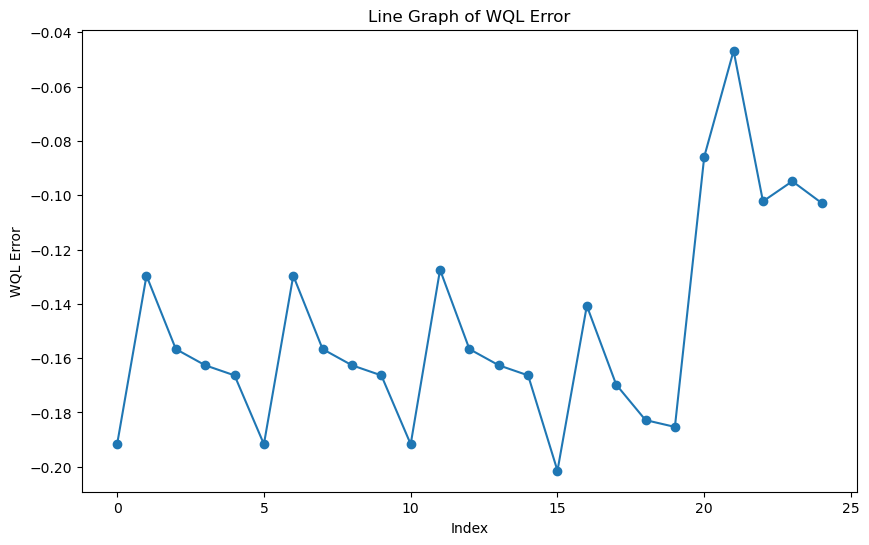

In [112]:
plt.figure(figsize=(10, 6))
plt.plot(errors_M_industry["WQL_error"].values, marker='o', linestyle='-')
plt.xlabel("Index")
plt.ylabel("WQL Error")
plt.title("Line Graph of WQL Error")
plt.show()

The WQL error in here has a significant change when most of the data is close to the current date and the predictions are the minimum possible. Also, it is possible to observe that the maximum value in here is less than the maximum value of the daily dataset and that the difference between the best scores between them have a difference of 1% having a better performance with the montly dataset

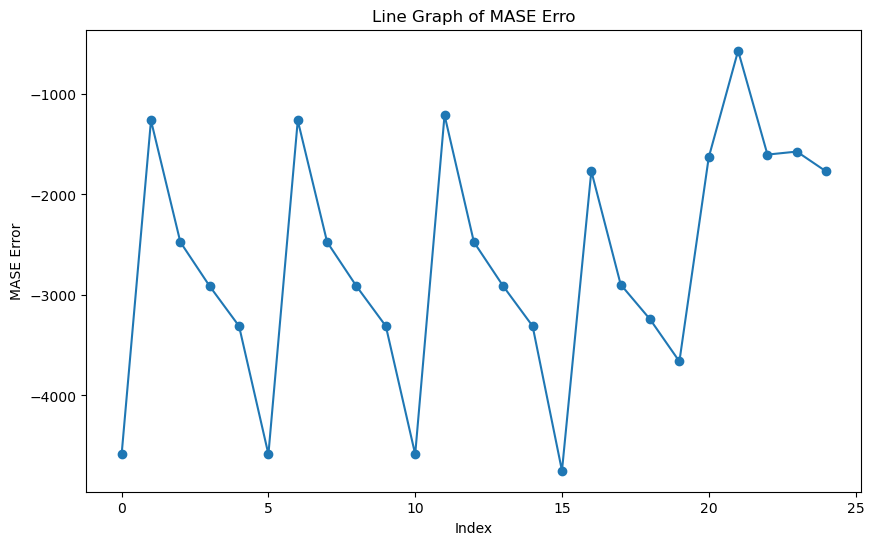

In [113]:
plt.figure(figsize=(10, 6))
plt.plot(errors_M_industry["MASE_error"].values, marker='o', linestyle='-')
plt.xlabel("Index")
plt.ylabel("MASE Error")
plt.title("Line Graph of MASE Erro")
plt.show()

The MASE in here has a similar performance but worrst results than the daily dataset. it is also interesting to observe that the closes are the data to the current date (the las training data before the predictions) it has a better performance. 

### Yearly data

In [114]:
#Take the first value of each year
df_Industry_yearly = df_Industry_1.resample('YS').first().sort_index(ascending=True)

In [115]:
df_Industry_yearly.head()

item_id           timestamp   target
timestamp                                       
2000-01-01  T002014 2000-03-01 12:00:00   1648.4
2001-01-01  T002014 2001-01-01 12:00:00   1897.1
2002-01-01  T002014 2002-01-01 12:00:00   2609.0
2003-01-01  T002014 2003-01-01 12:00:00   6932.4
2004-01-01  T002014 2004-01-01 12:00:00  17787.4

In [116]:
len(df_Industry_yearly) 

13

The len of this dataset is really small let's see how the results gone

In [117]:
df_Industry_yearly.index = pd.to_datetime(df_Industry_yearly.index).normalize()

In [118]:
df_Industry_yearly.dtypes

item_id      string[python]
timestamp    datetime64[ns]
target              float64
dtype: object

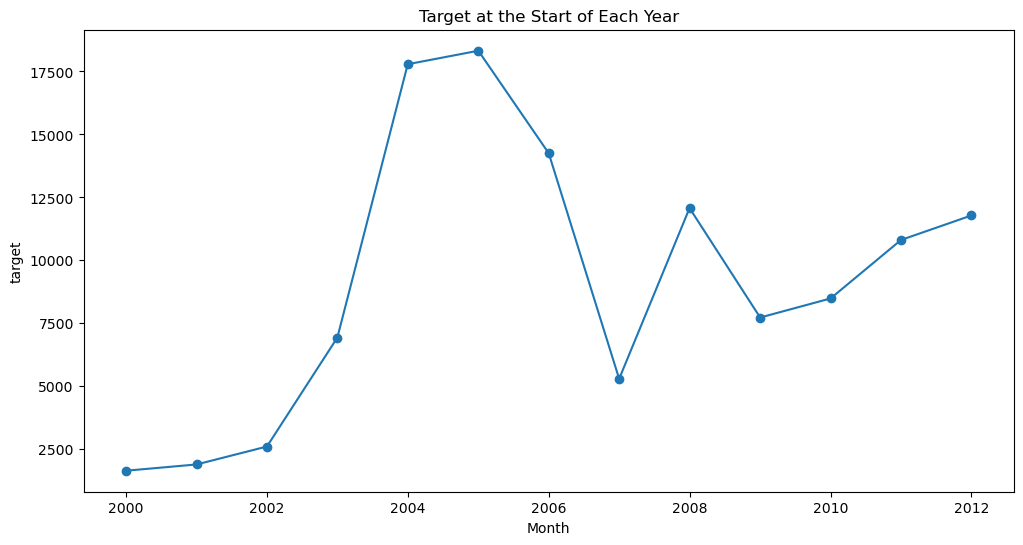

In [119]:
ts = df_Industry_yearly                   
x  = ts.index.get_level_values('timestamp')   # just the dates
y  = ts['target'].values                     # the values

plt.figure(figsize=(12, 6))
plt.plot(x, y, marker='o')
plt.title("Target at the Start of Each Year")
plt.xlabel("Month")
plt.ylabel("target")
plt.show()


In [ ]:
errors_Y_industry=get_errors_yr(df_Industry_yearly, frequ="B")

---------data len 13


Empty DataFrame
Columns: [Train_size, Percentage_train, Test_size, Percentage_test, MASE_error, Diference_MASE, WQL_error, Diference_WQL]
Index: []

Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193936'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.77 GB / 7.37 GB (10.4%)
Disk Space Avail:   4.28 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 3,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'targe

----------historical length 10
-----------history len, min and max 10 ('T002014', Timestamp('2000-03-01 12:00:00')) ('T002014', Timestamp('2009-01-01 12:00:00'))



Starting training. Start time is 2025-07-11 21:39:36
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.05 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193936-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.74 GB / 7.37 GB (10.0%)
Disk Space Avail:   4.28 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparam

---------beginning 0
---------total_length 13
----------training len 10
----------training                               target
item_id timestamp                   
T002014 2008-01-01 12:00:00  12075.0
        2009-01-01 12:00:00   7730.7
----------testing len 13
----------testtt                               target
item_id timestamp                   
T002014 2010-01-01 12:00:00   8487.9
        2011-01-01 12:00:00  10809.4
        2012-01-01 12:00:00  11782.1
-----------len predictions 3


mean          0.1          0.2  \
item_id timestamp                                                    
T002014 2010-01-01 12:00:00  7833.140625  3624.984375  5137.237305   
        2011-01-01 12:00:00  7612.257812  2739.171875  4424.796875   
        2012-01-01 12:00:00  7551.122070  2222.234375  4012.884277   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T002014 2010-01-01 12:00:00  6159.541016  7013.476562  7833.140625   
        2011-01-01 12:00:00  5581.280762  6610.445312  7612.257812   
        2012-01-01 12:00:00  5306.588379  6429.020508  7551.122070   

                                     0.6           0.7           0.8  \
item_id timestamp                                                      
T002014 2010-01-01 12:00:00  8711.392578   9726.993164  11077.997070   
        2011-01-01 12:00:00  8690.513672   9958.718750  11629.435547   
        2012-01-01 12:00:00  8757.832031  10224.922852  12148.184570   

                                      0.9  
item_id timestamp                          
T002014 2010-01-01 12:00:00  13441.210938  
        2011-01-01 12:00:00  14605.751953  
        2012-01-01 12:00:00  15538.095703

---len test slide 13


target
item_id timestamp                   
T002014 2010-01-01 12:00:00   8487.9
        2011-01-01 12:00:00  10809.4
        2012-01-01 12:00:00  11782.1

data with frequency 'IRREG' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'IRREG' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193943'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.61 GB / 7.37 GB (8.3%)
Disk Space Avail:   4.28 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eva

----------prediction_length 2
-----------history len, min and max 10 ('T002014', Timestamp('2000-03-01 12:00:00')) ('T002014', Timestamp('2009-01-01 12:00:00'))


	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 21:39:43
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.02    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.03 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193943-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.65 GB / 7.37 GB (8.8%)
Disk Space Avail:   4.28 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may requi

---------beginning 0
---------total_length 12
----------training len 10
----------training                               target
item_id timestamp                   
T002014 2008-01-01 12:00:00  12075.0
        2009-01-01 12:00:00   7730.7
----------testing len 12
----------testtt                               target
item_id timestamp                   
T002014 2010-01-01 12:00:00   8487.9
        2011-01-01 12:00:00  10809.4
-----------len predictions 2


mean          0.1          0.2  \
item_id timestamp                                                    
T002014 2010-01-01 12:00:00  7833.140625  3624.984375  5137.237305   
        2011-01-01 12:00:00  7612.257812  2739.171875  4424.796875   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T002014 2010-01-01 12:00:00  6159.541016  7013.476562  7833.140625   
        2011-01-01 12:00:00  5581.280762  6610.445312  7612.257812   

                                     0.6          0.7           0.8  \
item_id timestamp                                                     
T002014 2010-01-01 12:00:00  8711.392578  9726.993164  11077.997070   
        2011-01-01 12:00:00  8690.513672  9958.718750  11629.435547   

                                      0.9  
item_id timestamp                          
T002014 2010-01-01 12:00:00  13441.210938  
        2011-01-01 12:00:00  14605.751953

---len test slide 12


target
item_id timestamp                   
T002014 2010-01-01 12:00:00   8487.9
        2011-01-01 12:00:00  10809.4

data with frequency 'IRREG' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'IRREG' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193951'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.64 GB / 7.37 GB (8.6%)
Disk Space Avail:   4.28 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eva

----------prediction_length 1
-----------history len, min and max 10 ('T002014', Timestamp('2000-03-01 12:00:00')) ('T002014', Timestamp('2009-01-01 12:00:00'))


	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.03 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193951-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.65 GB / 7.37 GB (8.8%)
Disk Space Avail:   4.28 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 1,
 'quantile_levels': [0.1, 

---------beginning 0
---------total_length 11
----------training len 10
----------training                               target
item_id timestamp                   
T002014 2008-01-01 12:00:00  12075.0
        2009-01-01 12:00:00   7730.7
----------testing len 11
----------testtt                              target
item_id timestamp                  
T002014 2010-01-01 12:00:00  8487.9
-----------len predictions 1


mean          0.1          0.2  \
item_id timestamp                                                    
T002014 2010-01-01 12:00:00  7833.140625  3624.984375  5137.237305   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T002014 2010-01-01 12:00:00  6159.541016  7013.476562  7833.140625   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T002014 2010-01-01 12:00:00  8711.392578  9726.993164  11077.99707   

                                      0.9  
item_id timestamp                          
T002014 2010-01-01 12:00:00  13441.210938

---len test slide 11


target
item_id timestamp                  
T002014 2010-01-01 12:00:00  8487.9

data with frequency 'IRREG' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'IRREG' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193957'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.54 GB / 7.37 GB (7.4%)
Disk Space Avail:   4.28 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eva

----------prediction_length 0
----------historical length 10
-----------history len, min and max 10 ('T002014', Timestamp('2000-03-01 12:00:00')) ('T002014', Timestamp('2009-01-01 12:00:00'))



Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 21:39:57
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.03 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_193957-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.55 GB / 7.37 GB 

---------beginning 0
---------total_length 13
----------training len 10
----------training                               target
item_id timestamp                   
T002014 2008-01-01 12:00:00  12075.0
        2009-01-01 12:00:00   7730.7
----------testing len 13
----------testtt                               target
item_id timestamp                   
T002014 2010-01-01 12:00:00   8487.9
        2011-01-01 12:00:00  10809.4
        2012-01-01 12:00:00  11782.1
-----------len predictions 3


mean          0.1          0.2  \
item_id timestamp                                                    
T002014 2010-01-01 12:00:00  7833.140625  3624.984375  5137.237305   
        2011-01-01 12:00:00  7612.257812  2739.171875  4424.796875   
        2012-01-01 12:00:00  7551.122070  2222.234375  4012.884277   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T002014 2010-01-01 12:00:00  6159.541016  7013.476562  7833.140625   
        2011-01-01 12:00:00  5581.280762  6610.445312  7612.257812   
        2012-01-01 12:00:00  5306.588379  6429.020508  7551.122070   

                                     0.6           0.7           0.8  \
item_id timestamp                                                      
T002014 2010-01-01 12:00:00  8711.392578   9726.993164  11077.997070   
        2011-01-01 12:00:00  8690.513672   9958.718750  11629.435547   
        2012-01-01 12:00:00  8757.832031  10224.922852  12148.184570   

                                      0.9  
item_id timestamp                          
T002014 2010-01-01 12:00:00  13441.210938  
        2011-01-01 12:00:00  14605.751953  
        2012-01-01 12:00:00  15538.095703

---len test slide 13


target
item_id timestamp                   
T002014 2010-01-01 12:00:00   8487.9
        2011-01-01 12:00:00  10809.4
        2012-01-01 12:00:00  11782.1

data with frequency 'IRREG' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'IRREG' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_194004'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.70 GB / 7.37 GB (9.5%)
Disk Space Avail:   4.25 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eva

----------prediction_length 2
-----------history len, min and max 10 ('T002014', Timestamp('2000-03-01 12:00:00')) ('T002014', Timestamp('2009-01-01 12:00:00'))



Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 21:40:04
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.07 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_194004-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.72 GB / 7.37 GB 

---------beginning 0
---------total_length 12
----------training len 10
----------training                               target
item_id timestamp                   
T002014 2008-01-01 12:00:00  12075.0
        2009-01-01 12:00:00   7730.7
----------testing len 12
----------testtt                               target
item_id timestamp                   
T002014 2010-01-01 12:00:00   8487.9
        2011-01-01 12:00:00  10809.4
-----------len predictions 2


mean          0.1          0.2  \
item_id timestamp                                                    
T002014 2010-01-01 12:00:00  7833.140625  3624.984375  5137.237305   
        2011-01-01 12:00:00  7612.257812  2739.171875  4424.796875   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T002014 2010-01-01 12:00:00  6159.541016  7013.476562  7833.140625   
        2011-01-01 12:00:00  5581.280762  6610.445312  7612.257812   

                                     0.6          0.7           0.8  \
item_id timestamp                                                     
T002014 2010-01-01 12:00:00  8711.392578  9726.993164  11077.997070   
        2011-01-01 12:00:00  8690.513672  9958.718750  11629.435547   

                                      0.9  
item_id timestamp                          
T002014 2010-01-01 12:00:00  13441.210938  
        2011-01-01 12:00:00  14605.751953

---len test slide 12


target
item_id timestamp                   
T002014 2010-01-01 12:00:00   8487.9
        2011-01-01 12:00:00  10809.4

data with frequency 'IRREG' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'IRREG' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_194011'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.74 GB / 7.37 GB (10.0%)
Disk Space Avail:   4.25 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'ev

----------prediction_length 1
-----------history len, min and max 10 ('T002014', Timestamp('2000-03-01 12:00:00')) ('T002014', Timestamp('2009-01-01 12:00:00'))


Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.04 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_194012'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.74 GB / 7.37 GB (10.1%)
Disk Space Avail:   4.25 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 1,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.

---------beginning 0
---------total_length 11
----------training len 10
----------training                               target
item_id timestamp                   
T002014 2008-01-01 12:00:00  12075.0
        2009-01-01 12:00:00   7730.7
----------testing len 11
----------testtt                              target
item_id timestamp                  
T002014 2010-01-01 12:00:00  8487.9
-----------len predictions 1


mean          0.1          0.2  \
item_id timestamp                                                    
T002014 2010-01-01 12:00:00  7833.140625  3624.984375  5137.237305   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T002014 2010-01-01 12:00:00  6159.541016  7013.476562  7833.140625   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T002014 2010-01-01 12:00:00  8711.392578  9726.993164  11077.99707   

                                      0.9  
item_id timestamp                          
T002014 2010-01-01 12:00:00  13441.210938

---len test slide 11


target
item_id timestamp                  
T002014 2010-01-01 12:00:00  8487.9

data with frequency 'IRREG' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'IRREG' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_194019'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.73 GB / 7.37 GB (9.9%)
Disk Space Avail:   4.25 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eva

----------prediction_length 0
----------historical length 8
-----------history len, min and max 8 ('T002014', Timestamp('2002-01-01 12:00:00')) ('T002014', Timestamp('2009-01-01 12:00:00'))


Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.03 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_194019-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.73 GB / 7.37 GB (9.9%)
Disk Space Avail:   4.25 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 3,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,

---------beginning 2
---------total_length 13
----------training len 8
----------training                               target
item_id timestamp                   
T002014 2008-01-01 12:00:00  12075.0
        2009-01-01 12:00:00   7730.7
----------testing len 11
----------testtt                               target
item_id timestamp                   
T002014 2010-01-01 12:00:00   8487.9
        2011-01-01 12:00:00  10809.4
        2012-01-01 12:00:00  11782.1
-----------len predictions 3


mean          0.1          0.2  \
item_id timestamp                                                    
T002014 2010-01-01 12:00:00  7833.140625  3624.984375  5137.236816   
        2011-01-01 12:00:00  7612.257812  2739.172852  4424.796875   
        2012-01-01 12:00:00  7551.121582  2222.234375  4012.884277   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T002014 2010-01-01 12:00:00  6159.541016  7013.476562  7833.140625   
        2011-01-01 12:00:00  5581.280762  6610.444824  7612.257812   
        2012-01-01 12:00:00  5306.588379  6429.020996  7551.121582   

                                     0.6           0.7           0.8  \
item_id timestamp                                                      
T002014 2010-01-01 12:00:00  8711.392578   9726.993164  11077.997070   
        2011-01-01 12:00:00  8690.513672   9958.718750  11629.435547   
        2012-01-01 12:00:00  8757.832031  10224.922852  12148.184570   

                                      0.9  
item_id timestamp                          
T002014 2010-01-01 12:00:00  13441.210938  
        2011-01-01 12:00:00  14605.751953  
        2012-01-01 12:00:00  15538.095703

---len test slide 11


target
item_id timestamp                   
T002014 2010-01-01 12:00:00   8487.9
        2011-01-01 12:00:00  10809.4
        2012-01-01 12:00:00  11782.1

data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_194025'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.70 GB / 7.37 GB (9.5%)
Disk Space Avail:   4.25 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'e

----------prediction_length 2
-----------history len, min and max 8 ('T002014', Timestamp('2002-01-01 12:00:00')) ('T002014', Timestamp('2009-01-01 12:00:00'))


Total runtime: 0.05 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_194025-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.70 GB / 7.37 GB (9.5%)
Disk Space Avail:   4.25 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 2,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 '

---------beginning 2
---------total_length 12
----------training len 8
----------training                               target
item_id timestamp                   
T002014 2008-01-01 12:00:00  12075.0
        2009-01-01 12:00:00   7730.7
----------testing len 10
----------testtt                               target
item_id timestamp                   
T002014 2010-01-01 12:00:00   8487.9
        2011-01-01 12:00:00  10809.4
-----------len predictions 2


mean          0.1          0.2  \
item_id timestamp                                                    
T002014 2010-01-01 12:00:00  7833.140625  3624.984375  5137.236816   
        2011-01-01 12:00:00  7612.257812  2739.172852  4424.796875   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T002014 2010-01-01 12:00:00  6159.541016  7013.476562  7833.140625   
        2011-01-01 12:00:00  5581.280762  6610.444824  7612.257812   

                                     0.6          0.7           0.8  \
item_id timestamp                                                     
T002014 2010-01-01 12:00:00  8711.392578  9726.993164  11077.997070   
        2011-01-01 12:00:00  8690.513672  9958.718750  11629.435547   

                                      0.9  
item_id timestamp                          
T002014 2010-01-01 12:00:00  13441.210938  
        2011-01-01 12:00:00  14605.751953

---len test slide 10


target
item_id timestamp                   
T002014 2010-01-01 12:00:00   8487.9
        2011-01-01 12:00:00  10809.4

data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_194032'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.67 GB / 7.37 GB (9.1%)
Disk Space Avail:   4.27 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'e

----------prediction_length 1
-----------history len, min and max 8 ('T002014', Timestamp('2002-01-01 12:00:00')) ('T002014', Timestamp('2009-01-01 12:00:00'))



Starting training. Start time is 2025-07-11 21:40:32
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.00    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.05 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_194032-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.73 GB / 7.37 GB (9.9%)
Disk Space Avail:   4.27 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparame

---------beginning 2
---------total_length 11
----------training len 8
----------training                               target
item_id timestamp                   
T002014 2008-01-01 12:00:00  12075.0
        2009-01-01 12:00:00   7730.7
----------testing len 9
----------testtt                              target
item_id timestamp                  
T002014 2010-01-01 12:00:00  8487.9
-----------len predictions 1


mean          0.1          0.2  \
item_id timestamp                                                    
T002014 2010-01-01 12:00:00  7833.140625  3624.984375  5137.236816   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T002014 2010-01-01 12:00:00  6159.541016  7013.476562  7833.140625   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T002014 2010-01-01 12:00:00  8711.392578  9726.993164  11077.99707   

                                      0.9  
item_id timestamp                          
T002014 2010-01-01 12:00:00  13441.210938

---len test slide 9


target
item_id timestamp                  
T002014 2010-01-01 12:00:00  8487.9

data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_194039'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.67 GB / 7.37 GB (9.1%)
Disk Space Avail:   4.27 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'e

----------prediction_length 0
----------historical length 5
-----------history len, min and max 5 ('T002014', Timestamp('2005-01-01 12:00:00')) ('T002014', Timestamp('2009-01-01 12:00:00'))


Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.05 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_194039-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.67 GB / 7.37 GB (9.1%)
Disk Space Avail:   4.26 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'p

---------beginning 5
---------total_length 13
----------training len 5
----------training                               target
item_id timestamp                   
T002014 2008-01-01 12:00:00  12075.0
        2009-01-01 12:00:00   7730.7
----------testing len 8
----------testtt                               target
item_id timestamp                   
T002014 2010-01-01 12:00:00   8487.9
        2011-01-01 12:00:00  10809.4
        2012-01-01 12:00:00  11782.1
-----------len predictions 3


mean          0.1          0.2  \
item_id timestamp                                                    
T002014 2010-01-01 12:00:00  7505.195312  5800.411133  6406.401367   
        2011-01-01 12:00:00  7526.607910  5709.188477  6321.120117   
        2012-01-01 12:00:00  7421.122070  5469.611328  6108.084473   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T002014 2010-01-01 12:00:00  6785.792480  7132.863281  7505.195312   
        2011-01-01 12:00:00  6707.324219  7084.565430  7526.607910   
        2012-01-01 12:00:00  6524.905762  6923.346680  7421.122070   

                                     0.6          0.7           0.8  \
item_id timestamp                                                     
T002014 2010-01-01 12:00:00  8002.269043  8691.394531   9744.143555   
        2011-01-01 12:00:00  8102.925781  8956.166016  10242.404297   
        2012-01-01 12:00:00  8075.017578  9065.160156  10640.422852   

                                      0.9  
item_id timestamp                          
T002014 2010-01-01 12:00:00  12001.578125  
        2011-01-01 12:00:00  13181.193359  
        2012-01-01 12:00:00  14050.501953

---len test slide 8


target
item_id timestamp                   
T002014 2010-01-01 12:00:00   8487.9
        2011-01-01 12:00:00  10809.4
        2012-01-01 12:00:00  11782.1

data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_194045'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.71 GB / 7.37 GB (9.6%)
Disk Space Avail:   4.26 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'e

----------prediction_length 2
-----------history len, min and max 5 ('T002014', Timestamp('2005-01-01 12:00:00')) ('T002014', Timestamp('2009-01-01 12:00:00'))


Total runtime: 0.03 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_194046'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.70 GB / 7.37 GB (9.5%)
Disk Space Avail:   4.26 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 2,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refi

---------beginning 5
---------total_length 12
----------training len 5
----------training                               target
item_id timestamp                   
T002014 2008-01-01 12:00:00  12075.0
        2009-01-01 12:00:00   7730.7
----------testing len 7
----------testtt                               target
item_id timestamp                   
T002014 2010-01-01 12:00:00   8487.9
        2011-01-01 12:00:00  10809.4
-----------len predictions 2


mean          0.1          0.2  \
item_id timestamp                                                    
T002014 2010-01-01 12:00:00  7505.195312  5800.411133  6406.401367   
        2011-01-01 12:00:00  7526.607910  5709.188477  6321.120117   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T002014 2010-01-01 12:00:00  6785.792480  7132.863281  7505.195312   
        2011-01-01 12:00:00  6707.324219  7084.565430  7526.607910   

                                     0.6          0.7           0.8  \
item_id timestamp                                                     
T002014 2010-01-01 12:00:00  8002.269043  8691.394531   9744.143555   
        2011-01-01 12:00:00  8102.925781  8956.166016  10242.404297   

                                      0.9  
item_id timestamp                          
T002014 2010-01-01 12:00:00  12001.578125  
        2011-01-01 12:00:00  13181.193359

---len test slide 7


target
item_id timestamp                   
T002014 2010-01-01 12:00:00   8487.9
        2011-01-01 12:00:00  10809.4

data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_194051'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.65 GB / 7.37 GB (8.8%)
Disk Space Avail:   4.26 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'e

----------prediction_length 1
-----------history len, min and max 5 ('T002014', Timestamp('2005-01-01 12:00:00')) ('T002014', Timestamp('2009-01-01 12:00:00'))


Total runtime: 0.05 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_194051-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.71 GB / 7.37 GB (9.6%)
Disk Space Avail:   4.26 GB / 475.75 GB (0.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 1,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 '

---------beginning 5
---------total_length 11
----------training len 5
----------training                               target
item_id timestamp                   
T002014 2008-01-01 12:00:00  12075.0
        2009-01-01 12:00:00   7730.7
----------testing len 6
----------testtt                              target
item_id timestamp                  
T002014 2010-01-01 12:00:00  8487.9
-----------len predictions 1


mean          0.1          0.2  \
item_id timestamp                                                    
T002014 2010-01-01 12:00:00  7505.195312  5800.411133  6406.401367   

                                    0.3          0.4          0.5  \
item_id timestamp                                                   
T002014 2010-01-01 12:00:00  6785.79248  7132.863281  7505.195312   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T002014 2010-01-01 12:00:00  8002.269043  8691.394531  9744.143555   

                                      0.9  
item_id timestamp                          
T002014 2010-01-01 12:00:00  12001.578125

---len test slide 6


target
item_id timestamp                  
T002014 2010-01-01 12:00:00  8487.9

data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]


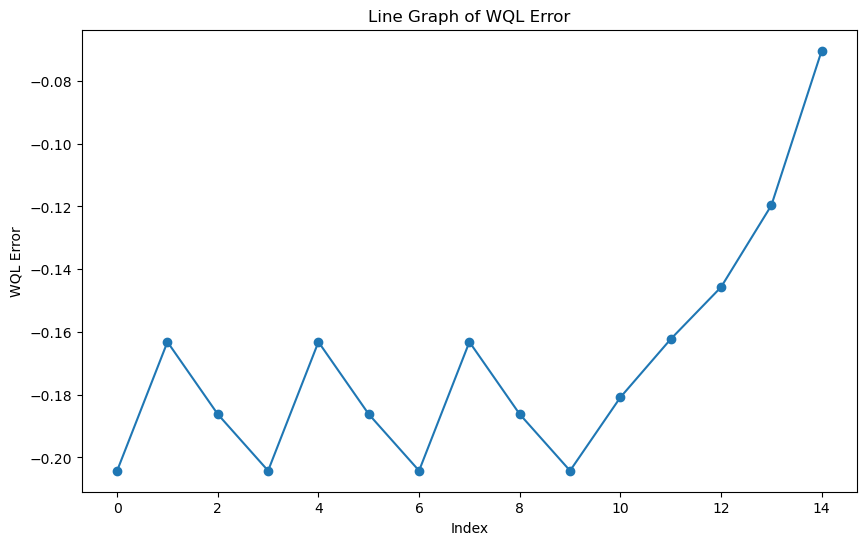

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(errors_Y_industry["WQL_error"].values, marker='o', linestyle='-')
plt.xlabel("Index")
plt.ylabel("WQL Error")
plt.title("Line Graph of WQL Error")
plt.show()

In this dataset with the yearly frequency it is possible to observe that when the test size is the mazimum the WQL Error is the worst and when the context lenght and the prediction lenght are closer to the currennt date (last training data) then the WQL Error can improve, which is useful for datasets with small len of data.

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(errors_Y_industry["MASE_error"].values, marker='o', linestyle='-')
plt.xlabel("Index")
plt.ylabel("MASE Error")
plt.title("Line Graph of MASE Error")
plt.show()

### Industrial Conclusion

As it is possible to observe the WQL get a better iprovement in order to work with most recent data, this could be given to the fact that the monthly data has less noise than the daily one but for the MASE it gets worst results than wiht the daily one. 
This could be interesting to be use in applications where it is not possible to get the appropiate quanity of data and it is more important to analyse the tendency of values further than the exact estimation.

## Demography dataset

In [ ]:
df_Demography.head(10)

id           timestamp    target     category
1603  T001603 1997-03-01 12:00:00  138.8524  Demographic
1603  T001603 1997-03-02 12:00:00  140.4125  Demographic
1603  T001603 1997-03-03 12:00:00  138.6265  Demographic
1603  T001603 1997-03-04 12:00:00  141.9203  Demographic
1603  T001603 1997-03-05 12:00:00  148.3013  Demographic
1603  T001603 1997-03-06 12:00:00  146.8035  Demographic
1603  T001603 1997-03-07 12:00:00  143.7627  Demographic
1603  T001603 1997-03-08 12:00:00  152.0674  Demographic
1603  T001603 1997-03-09 12:00:00  161.0877  Demographic
1603  T001603 1997-03-10 12:00:00  163.0214  Demographic

In [ ]:
#Check fot nulls in the target column
df_Demography["target"].isnull().sum()

0

In [ ]:
df_Demography["id"].unique()

<StringArray>
['T001603', 'T001604', 'T001605', 'T001606', 'T001607', 'T001608', 'T001609',
 'T001610', 'T001611', 'T001612']
Length: 10, dtype: string

In [ ]:
df_Demography.groupby("id").size().reset_index(name="counts").sort_values(by="counts", ascending=False).head(10)

id  counts
8  T001611    4454
9  T001612    4454
6  T001609    4412
7  T001610    4412
1  T001604    4329
2  T001605    4329
3  T001606    4329
4  T001607    4329
5  T001608    4329
0  T001603    1054

In [ ]:
df_Demography.index = pd.to_datetime(df_Demography.timestamp)

In [ ]:
df_Demography[df_Demography["id"]=="T001611"]["timestamp"].describe()
#The dataseries to work in is going to be the one with the most quantity of data. 
#The first year of the data is 2000 and the maximum is 2012

count                             4454
mean     2006-04-06 00:00:00.000000128
min                2000-03-01 12:00:00
25%                2003-03-19 18:00:00
50%                2006-04-06 00:00:00
75%                2009-04-23 06:00:00
max                2012-05-10 12:00:00
Name: timestamp, dtype: object

In [ ]:
df_Demography_1=df_Demography[df_Demography["id"]=="T001611"]

In [ ]:
df_Demography_1 = df_Demography_1.drop(columns=["category"]).sort_index(ascending=True)


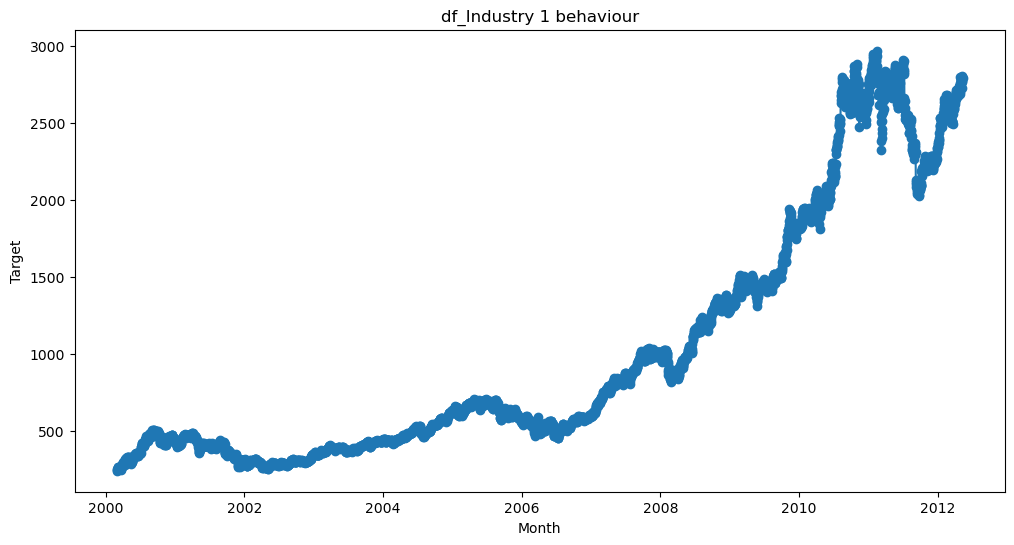

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df_Demography_1.index, df_Demography_1["target"], marker="o")
plt.title("df_Industry 1 behaviour")
plt.xlabel("Month")
plt.ylabel("Target")
plt.show()

In [ ]:
#Verify if the timestamp is complete and continuous
start_date = df_Demography_1.index.min()
print("Start date:", start_date)
end_date = df_Demography_1.index.max()
print("End date:", end_date)

Start date: 2000-03-01 12:00:00
End date: 2012-05-10 12:00:00


In [ ]:
complete_date_range = pd.date_range(start=start_date, end=end_date, freq="D")

In [ ]:
complete_date_range

DatetimeIndex(['2000-03-01 12:00:00', '2000-03-02 12:00:00',
               '2000-03-03 12:00:00', '2000-03-04 12:00:00',
               '2000-03-05 12:00:00', '2000-03-06 12:00:00',
               '2000-03-07 12:00:00', '2000-03-08 12:00:00',
               '2000-03-09 12:00:00', '2000-03-10 12:00:00',
               ...
               '2012-05-01 12:00:00', '2012-05-02 12:00:00',
               '2012-05-03 12:00:00', '2012-05-04 12:00:00',
               '2012-05-05 12:00:00', '2012-05-06 12:00:00',
               '2012-05-07 12:00:00', '2012-05-08 12:00:00',
               '2012-05-09 12:00:00', '2012-05-10 12:00:00'],
              dtype='datetime64[ns]', length=4454, freq='D')

In [ ]:
missing_dates = complete_date_range.difference(df_Demography_1.index)
print("Missing dates:", missing_dates)
#The timeseries is continues and complete, so we can work with it.

Missing dates: DatetimeIndex([], dtype='datetime64[ns]', freq='D')


In [ ]:
df_Demography_1.rename(columns={"id": "item_id"}, inplace=True)

In [ ]:
errors_D_Demography= get_errors(df_Demography_1, frequ="B")

---------data len 4454


Empty DataFrame
Columns: [Train_size, Percentage_train, Test_size, Percentage_test, MASE_error, Diference_MASE, WQL_error, Diference_WQL]
Index: []

Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_175818'
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_175818'


=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.58 GB / 7.37 GB (7.9%)
Disk Space Avail:   5.72 GB / 475.75 GB (1.2%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.


----------historical length 3563
----------prediction_length 891
-----------history len, min and max 3563 ('T001611', Timestamp('2000-03-01 12:00:00')) ('T001611', Timestamp('2009-12-01 12:00:00'))


Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 891,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}


Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 891,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

train_data with frequency 'D' has been resampled to frequency 'B'.
train_data with frequenc

---------beginning 0
---------total_length 4454
----------training len 3563
----------training                               target
item_id timestamp                   
T001611 2009-11-30 12:00:00  1802.07
        2009-12-01 12:00:00  1811.74
----------testing len 4454
----------testtt                               target
item_id timestamp                   
T001611 2009-12-02 12:00:00  1825.38
        2009-12-03 12:00:00  1842.62
        2009-12-04 12:00:00  1846.46
        2009-12-05 12:00:00  1838.79
        2009-12-06 12:00:00  1850.18
...                              ...
        2012-05-06 12:00:00  2728.62
        2012-05-07 12:00:00  2796.81
        2012-05-08 12:00:00  2766.31
        2012-05-09 12:00:00  2800.90
        2012-05-10 12:00:00  2793.75

[891 rows x 1 columns]
-----------len predictions 891
-----------len predictions 891


mean          0.1          0.2  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1797.027832  1733.883179  1756.052246   
        2009-12-03 12:00:00  1797.592773  1732.858887  1757.734863   
        2009-12-04 12:00:00  1797.695068  1725.097168  1753.371826   
        2009-12-05 12:00:00  1801.052246  1724.780029  1754.090576   
        2009-12-06 12:00:00  1805.449951  1723.684204  1754.956299   
...                                  ...          ...          ...   
        2012-05-06 12:00:00  2393.747070  2323.195801  2363.534668   
        2012-05-07 12:00:00  2395.023926  2326.115967  2366.500488   
        2012-05-08 12:00:00  2392.006836  2322.652100  2363.818848   
        2012-05-09 12:00:00  2391.376465  2322.263916  2362.004639   
        2012-05-10 12:00:00  2394.198486  2320.700928  2363.389893   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1771.932861  1785.197998  1797.027832   
        2009-12-03 12:00:00  1773.417725  1786.119873  1797.592773   
        2009-12-04 12:00:00  1771.550293  1785.041748  1797.695068   
        2009-12-05 12:00:00  1772.639404  1787.080566  1801.052246   
        2009-12-06 12:00:00  1775.031494  1790.765137  1805.449951   
...                                  ...          ...          ...   
        2012-05-06 12:00:00  2378.852783  2386.268799  2393.747070   
        2012-05-07 12:00:00  2380.073242  2387.175537  2395.023926   
        2012-05-08 12:00:00  2377.103271  2384.736084  2392.006836   
        2012-05-09 12:00:00  2372.915039  2381.400879  2391.376465   
        2012-05-10 12:00:00  2376.337402  2385.183105  2394.198486   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1808.326660  1820.534912  1836.012207   
        2009-12-03 12:00:00  1810.100830  1823.353760  1837.875244   
        2009-12-04 12:00:00  1810.479004  1823.822510  1839.961670   
        2009-12-05 12:00:00  1814.632080  1829.627930  1847.634033   
        2009-12-06 12:00:00  1819.919189  1834.845947  1854.034912   
...                                  ...          ...          ...   
        2012-05-06 12:00:00  2402.836914  2412.736328  2424.670898   
        2012-05-07 12:00:00  2404.695557  2414.614502  2426.909668   
        2012-05-08 12:00:00  2401.149658  2411.960938  2425.242432   
        2012-05-09 12:00:00  2401.004883  2412.088623  2424.655273   
        2012-05-10 12:00:00  2403.843750  2412.782959  2427.395508   

                                     0.9  
item_id timestamp                         
T001611 2009-12-02 12:00:00  1861.389648  
        2009-12-03 12:00:00  1865.150146  
        2009-12-04 12:00:00  1867.980713  
        2009-12-05 12:00:00  1877.927734  
        2009-12-06 12:00:00  1886.205566  
...                                  ...  
        2012-05-06 12:00:00  2445.422363  
        2012-05-07 12:00:00  2446.866699  
        2012-05-08 12:00:00  2443.801758  
        2012-05-09 12:00:00  2445.867676  
        2012-05-10 12:00:00  2445.006104  

[891 rows x 10 columns]

---len test slide 4454


target
item_id timestamp                   
T001611 2009-12-02 12:00:00  1825.38
        2009-12-03 12:00:00  1842.62
        2009-12-04 12:00:00  1846.46
        2009-12-05 12:00:00  1838.79
        2009-12-06 12:00:00  1850.18
...                              ...
        2012-05-06 12:00:00  2728.62
        2012-05-07 12:00:00  2796.81
        2012-05-08 12:00:00  2766.31
        2012-05-09 12:00:00  2800.90
        2012-05-10 12:00:00  2793.75

[891 rows x 1 columns]

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_175827'
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_175827'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Versio

----------prediction_length 45
-----------history len, min and max 3563 ('T001611', Timestamp('2000-03-01 12:00:00')) ('T001611', Timestamp('2009-12-01 12:00:00'))



Provided data contains following columns:
	target: 'target'
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 19:58:27

Starting training. Start time is 2025-07-11 19:58:27
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_sm

---------beginning 0
---------total_length 3608
----------training len 3563
----------training                               target
item_id timestamp                   
T001611 2009-11-30 12:00:00  1802.07
        2009-12-01 12:00:00  1811.74
----------testing len 3608
----------testtt                               target
item_id timestamp                   
T001611 2009-12-02 12:00:00  1825.38
        2009-12-03 12:00:00  1842.62
        2009-12-04 12:00:00  1846.46
        2009-12-05 12:00:00  1838.79
        2009-12-06 12:00:00  1850.18
        2009-12-07 12:00:00  1837.67
        2009-12-08 12:00:00  1838.56
        2009-12-09 12:00:00  1801.55
        2009-12-10 12:00:00  1775.89
        2009-12-11 12:00:00  1803.18
        2009-12-12 12:00:00  1787.10
        2009-12-13 12:00:00  1755.57
        2009-12-14 12:00:00  1753.68
        2009-12-15 12:00:00  1747.65
        2009-12-16 12:00:00  1780.79
        2009-12-17 12:00:00  1842.37
        2009-12-18 12:00:00  1846.66
        20

mean          0.1          0.2  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1797.027832  1733.883179  1756.052246   
        2009-12-03 12:00:00  1797.592773  1732.858887  1757.734863   
        2009-12-04 12:00:00  1797.695068  1725.097168  1753.371826   
        2009-12-05 12:00:00  1801.052246  1724.780029  1754.090576   
        2009-12-06 12:00:00  1805.449951  1723.684204  1754.956299   
        2009-12-07 12:00:00  1803.728760  1717.683838  1752.683838   
        2009-12-08 12:00:00  1803.891357  1713.877930  1749.313110   
        2009-12-09 12:00:00  1807.847900  1712.974365  1749.968750   
        2009-12-10 12:00:00  1808.244629  1708.926758  1749.355957   
        2009-12-11 12:00:00  1807.488525  1703.153198  1745.544556   
        2009-12-12 12:00:00  1809.392822  1701.314941  1743.175537   
        2009-12-13 12:00:00  1809.066162  1698.559570  1741.930908   
        2009-12-14 12:00:00  1806.452881  1695.229980  1739.184692   
        2009-12-15 12:00:00  1807.542725  1692.312378  1738.225830   
        2009-12-16 12:00:00  1807.984619  1689.168213  1734.710449   
        2009-12-17 12:00:00  1806.842285  1684.401733  1731.625366   
        2009-12-18 12:00:00  1807.981201  1683.100342  1731.899170   
        2009-12-19 12:00:00  1810.953857  1681.942383  1732.537354   
        2009-12-20 12:00:00  1815.189697  1682.995850  1735.592773   
        2009-12-21 12:00:00  1817.329346  1682.284912  1735.143311   
        2009-12-22 12:00:00  1816.986572  1678.707764  1734.712158   
        2009-12-23 12:00:00  1818.059326  1676.057983  1732.147095   
        2009-12-24 12:00:00  1816.754395  1671.885986  1730.416260   
        2009-12-25 12:00:00  1819.685059  1670.847656  1731.261230   
        2009-12-26 12:00:00  1819.406738  1669.417969  1732.416992   
        2009-12-27 12:00:00  1824.186035  1670.954102  1734.607666   
        2009-12-28 12:00:00  1825.830078  1672.401855  1735.057373   
        2009-12-29 12:00:00  1830.695801  1672.410400  1736.833496   
        2009-12-30 12:00:00  1832.532715  1669.503784  1736.000610   
        2009-12-31 12:00:00  1831.029785  1665.326416  1731.183350   
        2010-01-01 12:00:00  1828.399902  1662.905151  1728.633179   
        2010-01-02 12:00:00  1832.419678  1663.631592  1732.363525   
        2010-01-03 12:00:00  1836.144775  1662.511963  1733.121338   
        2010-01-04 12:00:00  1837.374023  1661.353027  1732.341919   
        2010-01-05 12:00:00  1838.898438  1661.140869  1731.892212   
        2010-01-06 12:00:00  1835.061279  1654.609375  1727.042725   
        2010-01-07 12:00:00  1830.676270  1652.018066  1722.253906   
        2010-01-08 12:00:00  1831.303711  1647.990967  1720.841553   
        2010-01-09 12:00:00  1829.241943  1645.901123  1720.008789   
        2010-01-10 12:00:00  1831.333984  1647.864868  1720.803711   
        2010-01-11 12:00:00  1829.621582  1645.081421  1719.649658   
        2010-01-12 12:00:00  1828.709229  1641.378540  1717.119629   
        2010-01-13 12:00:00  1830.262451  1639.986694  1716.273682   
        2010-01-14 12:00:00  1835.199463  1638.168213  1717.138916   
        2010-01-15 12:00:00  1833.185059  1634.183105  1715.489990   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1771.932861  1785.197998  1797.027832   
        2009-12-03 12:00:00  1773.417725  1786.119873  1797.592773   
        2009-12-04 12:00:00  1771.550293  1785.041748  1797.695068   
        2009-12-05 12:00:00  1772.639404  1787.080566  1801.052246   
        2009-12-06 12:00:00  1775.031494  1790.765137  1805.449951   
        2009-12-07 12:00:00  1771.953369  1789.177734  1803.728760   
        2009-12-08 12:00:00  1770.289795  1787.485596  1803.891357   
        2009-12-09 12:00:00  1772.774414  1790.655762  1807.847900   
        2009-12-10 12:00:00  1772.247070  179

---len test slide 3608


target
item_id timestamp                   
T001611 2009-12-02 12:00:00  1825.38
        2009-12-03 12:00:00  1842.62
        2009-12-04 12:00:00  1846.46
        2009-12-05 12:00:00  1838.79
        2009-12-06 12:00:00  1850.18
        2009-12-07 12:00:00  1837.67
        2009-12-08 12:00:00  1838.56
        2009-12-09 12:00:00  1801.55
        2009-12-10 12:00:00  1775.89
        2009-12-11 12:00:00  1803.18
        2009-12-12 12:00:00  1787.10
        2009-12-13 12:00:00  1755.57
        2009-12-14 12:00:00  1753.68
        2009-12-15 12:00:00  1747.65
        2009-12-16 12:00:00  1780.79
        2009-12-17 12:00:00  1842.37
        2009-12-18 12:00:00  1846.66
        2009-12-19 12:00:00  1838.34
        2009-12-20 12:00:00  1831.30
        2009-12-21 12:00:00  1844.04
        2009-12-22 12:00:00  1851.16
        2009-12-23 12:00:00  1848.66
        2009-12-24 12:00:00  1835.68
        2009-12-25 12:00:00  1839.29
        2009-12-26 12:00:00  1832.24
        2009-12-27 12:00:00  1826.47
        2009-12-28 12:00:00  1821.02
        2009-12-29 12:00:00  1816.12
        2009-12-30 12:00:00  1831.62
        2009-12-31 12:00:00  1853.07
        2010-01-01 12:00:00  1845.88
        2010-01-02 12:00:00  1834.89
        2010-01-03 12:00:00  1818.59
        2010-01-04 12:00:00  1811.96
        2010-01-05 12:00:00  1817.92
        2010-01-06 12:00:00  1829.62
        2010-01-07 12:00:00  1835.98
        2010-01-08 12:00:00  1823.82
        2010-01-09 12:00:00  1841.05
        2010-01-10 12:00:00  1840.70
        2010-01-11 12:00:00  1820.14
        2010-01-12 12:00:00  1823.53
        2010-01-13 12:00:00  1828.75
        2010-01-14 12:00:00  1854.00
        2010-01-15 12:00:00  1857.81

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_175834'
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_175834'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Versio

----------prediction_length 223
-----------history len, min and max 3563 ('T001611', Timestamp('2000-03-01 12:00:00')) ('T001611', Timestamp('2009-12-01 12:00:00'))



Provided data contains following columns:
	target: 'target'
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 19:58:35

Starting training. Start time is 2025-07-11 19:58:35
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Training complete. Models trained: ['Chronos[bolt_sm

---------beginning 0
---------total_length 3786
----------training len 3563
----------training                               target
item_id timestamp                   
T001611 2009-11-30 12:00:00  1802.07
        2009-12-01 12:00:00  1811.74
----------testing len 3786
----------testtt                               target
item_id timestamp                   
T001611 2009-12-02 12:00:00  1825.38
        2009-12-03 12:00:00  1842.62
        2009-12-04 12:00:00  1846.46
        2009-12-05 12:00:00  1838.79
        2009-12-06 12:00:00  1850.18
...                              ...
        2010-07-08 12:00:00  2170.34
        2010-07-09 12:00:00  2157.32
        2010-07-10 12:00:00  2183.06
        2010-07-11 12:00:00  2214.98
        2010-07-12 12:00:00  2235.91

[223 rows x 1 columns]
-----------len predictions 223
-----------len predictions 223


mean          0.1          0.2  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1797.027832  1733.883179  1756.052246   
        2009-12-03 12:00:00  1797.592773  1732.858887  1757.734863   
        2009-12-04 12:00:00  1797.695068  1725.097168  1753.371826   
        2009-12-05 12:00:00  1801.052246  1724.780029  1754.090576   
        2009-12-06 12:00:00  1805.449951  1723.684204  1754.956299   
...                                  ...          ...          ...   
        2010-07-08 12:00:00  1963.151855  1841.603638  1894.435547   
        2010-07-09 12:00:00  1963.974487  1840.020508  1893.088867   
        2010-07-10 12:00:00  1961.915405  1835.217407  1889.638428   
        2010-07-11 12:00:00  1964.738770  1835.455078  1889.517090   
        2010-07-12 12:00:00  1965.789062  1836.776978  1891.500610   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1771.932861  1785.197998  1797.027832   
        2009-12-03 12:00:00  1773.417725  1786.119873  1797.592773   
        2009-12-04 12:00:00  1771.550293  1785.041748  1797.695068   
        2009-12-05 12:00:00  1772.639404  1787.080566  1801.052246   
        2009-12-06 12:00:00  1775.031494  1790.765137  1805.449951   
...                                  ...          ...          ...   
        2010-07-08 12:00:00  1922.597534  1943.198242  1963.151855   
        2010-07-09 12:00:00  1922.851929  1943.447876  1963.974487   
        2010-07-10 12:00:00  1918.529175  1941.520142  1961.915405   
        2010-07-11 12:00:00  1920.240601  1942.195068  1964.738770   
        2010-07-12 12:00:00  1921.859009  1945.892578  1965.789062   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1808.326660  1820.534912  1836.012207   
        2009-12-03 12:00:00  1810.100830  1823.353760  1837.875244   
        2009-12-04 12:00:00  1810.479004  1823.822510  1839.961670   
        2009-12-05 12:00:00  1814.632080  1829.627930  1847.634033   
        2009-12-06 12:00:00  1819.919189  1834.845947  1854.034912   
...                                  ...          ...          ...   
        2010-07-08 12:00:00  1981.826416  2002.113281  2027.077271   
        2010-07-09 12:00:00  1983.518555  2004.770508  2030.931641   
        2010-07-10 12:00:00  1981.182861  2002.971436  2028.658447   
        2010-07-11 12:00:00  1984.457764  2005.527710  2030.583008   
        2010-07-12 12:00:00  1986.570557  2008.444214  2033.678223   

                                     0.9  
item_id timestamp                         
T001611 2009-12-02 12:00:00  1861.389648  
        2009-12-03 12:00:00  1865.150146  
        2009-12-04 12:00:00  1867.980713  
        2009-12-05 12:00:00  1877.927734  
        2009-12-06 12:00:00  1886.205566  
...                                  ...  
        2010-07-08 12:00:00  2067.442871  
        2010-07-09 12:00:00  2070.762207  
        2010-07-10 12:00:00  2069.533936  
        2010-07-11 12:00:00  2071.364502  
        2010-07-12 12:00:00  2073.866943  

[223 rows x 10 columns]

---len test slide 3786


target
item_id timestamp                   
T001611 2009-12-02 12:00:00  1825.38
        2009-12-03 12:00:00  1842.62
        2009-12-04 12:00:00  1846.46
        2009-12-05 12:00:00  1838.79
        2009-12-06 12:00:00  1850.18
...                              ...
        2010-07-08 12:00:00  2170.34
        2010-07-09 12:00:00  2157.32
        2010-07-10 12:00:00  2183.06
        2010-07-11 12:00:00  2214.98
        2010-07-12 12:00:00  2235.91

[223 rows x 1 columns]

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_175841'
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_175841'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Versio

----------prediction_length 446
-----------history len, min and max 3563 ('T001611', Timestamp('2000-03-01 12:00:00')) ('T001611', Timestamp('2009-12-01 12:00:00'))



Provided data contains following columns:
	target: 'target'
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 19:58:42

Starting training. Start time is 2025-07-11 19:58:42
Models that will be trained: ['Chronos[bolt_small]']
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.00    s     = Training runtime
Training timeseries model Chronos[bolt_small]. 
	0.00    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.10 s
Training complete. Models trai

---------beginning 0
---------total_length 4009
----------training len 3563
----------training                               target
item_id timestamp                   
T001611 2009-11-30 12:00:00  1802.07
        2009-12-01 12:00:00  1811.74
----------testing len 4009
----------testtt                               target
item_id timestamp                   
T001611 2009-12-02 12:00:00  1825.38
        2009-12-03 12:00:00  1842.62
        2009-12-04 12:00:00  1846.46
        2009-12-05 12:00:00  1838.79
        2009-12-06 12:00:00  1850.18
...                              ...
        2011-02-16 12:00:00  2825.25
        2011-02-17 12:00:00  2765.54
        2011-02-18 12:00:00  2814.99
        2011-02-19 12:00:00  2810.16
        2011-02-20 12:00:00  2771.73

[446 rows x 1 columns]
-----------len predictions 446
-----------len predictions 446


mean          0.1          0.2  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1797.027832  1733.883179  1756.052246   
        2009-12-03 12:00:00  1797.592773  1732.858887  1757.734863   
        2009-12-04 12:00:00  1797.695068  1725.097168  1753.371826   
        2009-12-05 12:00:00  1801.052246  1724.780029  1754.090576   
        2009-12-06 12:00:00  1805.449951  1723.684204  1754.956299   
...                                  ...          ...          ...   
        2011-02-16 12:00:00  2147.108398  2040.817749  2094.135010   
        2011-02-17 12:00:00  2151.634766  2039.534912  2096.854492   
        2011-02-18 12:00:00  2153.435791  2041.973877  2097.026855   
        2011-02-19 12:00:00  2152.271729  2040.504639  2094.751465   
        2011-02-20 12:00:00  2149.516602  2037.324219  2094.149658   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1771.932861  1785.197998  1797.027832   
        2009-12-03 12:00:00  1773.417725  1786.119873  1797.592773   
        2009-12-04 12:00:00  1771.550293  1785.041748  1797.695068   
        2009-12-05 12:00:00  1772.639404  1787.080566  1801.052246   
        2009-12-06 12:00:00  1775.031494  1790.765137  1805.449951   
...                                  ...          ...          ...   
        2011-02-16 12:00:00  2114.984863  2131.225830  2147.108398   
        2011-02-17 12:00:00  2119.454834  2136.185547  2151.634766   
        2011-02-18 12:00:00  2121.252930  2139.199219  2153.435791   
        2011-02-19 12:00:00  2117.814697  2135.938965  2152.271729   
        2011-02-20 12:00:00  2117.442383  2133.577637  2149.516602   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1808.326660  1820.534912  1836.012207   
        2009-12-03 12:00:00  1810.100830  1823.353760  1837.875244   
        2009-12-04 12:00:00  1810.479004  1823.822510  1839.961670   
        2009-12-05 12:00:00  1814.632080  1829.627930  1847.634033   
        2009-12-06 12:00:00  1819.919189  1834.845947  1854.034912   
...                                  ...          ...          ...   
        2011-02-16 12:00:00  2161.972168  2178.846191  2197.879883   
        2011-02-17 12:00:00  2166.769043  2181.894531  2203.529053   
        2011-02-18 12:00:00  2168.596191  2186.117676  2206.097900   
        2011-02-19 12:00:00  2167.419434  2184.639893  2206.392334   
        2011-02-20 12:00:00  2166.079590  2185.266357  2209.849121   

                                     0.9  
item_id timestamp                         
T001611 2009-12-02 12:00:00  1861.389648  
        2009-12-03 12:00:00  1865.150146  
        2009-12-04 12:00:00  1867.980713  
        2009-12-05 12:00:00  1877.927734  
        2009-12-06 12:00:00  1886.205566  
...                                  ...  
        2011-02-16 12:00:00  2233.309082  
        2011-02-17 12:00:00  2234.868896  
        2011-02-18 12:00:00  2241.880371  
        2011-02-19 12:00:00  2245.607178  
        2011-02-20 12:00:00  2246.565186  

[446 rows x 10 columns]

---len test slide 4009


target
item_id timestamp                   
T001611 2009-12-02 12:00:00  1825.38
        2009-12-03 12:00:00  1842.62
        2009-12-04 12:00:00  1846.46
        2009-12-05 12:00:00  1838.79
        2009-12-06 12:00:00  1850.18
...                              ...
        2011-02-16 12:00:00  2825.25
        2011-02-17 12:00:00  2765.54
        2011-02-18 12:00:00  2814.99
        2011-02-19 12:00:00  2810.16
        2011-02-20 12:00:00  2771.73

[446 rows x 1 columns]

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_175849'
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_175849'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Versio

----------prediction_length 668
-----------history len, min and max 3563 ('T001611', Timestamp('2000-03-01 12:00:00')) ('T001611', Timestamp('2009-12-01 12:00:00'))


	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 19:58:49

Starting training. Start time is 2025-07-11 19:58:49
Models that will be trained: ['Chronos[bolt_small]']
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
Training timeseries model Chronos[bolt_small]. 
	0.00    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
	0.00    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.07 s
Best model: Chronos[bolt_small]


---------beginning 0
---------total_length 4231
----------training len 3563
----------training                               target
item_id timestamp                   
T001611 2009-11-30 12:00:00  1802.07
        2009-12-01 12:00:00  1811.74
----------testing len 4231
----------testtt                               target
item_id timestamp                   
T001611 2009-12-02 12:00:00  1825.38
        2009-12-03 12:00:00  1842.62
        2009-12-04 12:00:00  1846.46
        2009-12-05 12:00:00  1838.79
        2009-12-06 12:00:00  1850.18
...                              ...
        2011-09-26 12:00:00  2033.61
        2011-09-27 12:00:00  2062.06
        2011-09-28 12:00:00  2072.92
        2011-09-29 12:00:00  2071.88
        2011-09-30 12:00:00  2107.44

[668 rows x 1 columns]
-----------len predictions 668
-----------len predictions 668


mean          0.1          0.2  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1797.027832  1733.883179  1756.052246   
        2009-12-03 12:00:00  1797.592773  1732.858887  1757.734863   
        2009-12-04 12:00:00  1797.695068  1725.097168  1753.371826   
        2009-12-05 12:00:00  1801.052246  1724.780029  1754.090576   
        2009-12-06 12:00:00  1805.449951  1723.684204  1754.956299   
...                                  ...          ...          ...   
        2011-09-26 12:00:00  2286.718506  2225.252441  2254.389648   
        2011-09-27 12:00:00  2283.448486  2221.550537  2252.159180   
        2011-09-28 12:00:00  2284.366699  2221.360596  2252.943848   
        2011-09-29 12:00:00  2287.722656  2222.876221  2255.219971   
        2011-09-30 12:00:00  2292.477051  2225.947021  2258.386719   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1771.932861  1785.197998  1797.027832   
        2009-12-03 12:00:00  1773.417725  1786.119873  1797.592773   
        2009-12-04 12:00:00  1771.550293  1785.041748  1797.695068   
        2009-12-05 12:00:00  1772.639404  1787.080566  1801.052246   
        2009-12-06 12:00:00  1775.031494  1790.765137  1805.449951   
...                                  ...          ...          ...   
        2011-09-26 12:00:00  2267.380127  2276.424805  2286.718506   
        2011-09-27 12:00:00  2265.500000  2274.676758  2283.448486   
        2011-09-28 12:00:00  2266.078857  2275.761963  2284.366699   
        2011-09-29 12:00:00  2268.907715  2277.569336  2287.722656   
        2011-09-30 12:00:00  2273.689453  2281.958496  2292.477051   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1808.326660  1820.534912  1836.012207   
        2009-12-03 12:00:00  1810.100830  1823.353760  1837.875244   
        2009-12-04 12:00:00  1810.479004  1823.822510  1839.961670   
        2009-12-05 12:00:00  1814.632080  1829.627930  1847.634033   
        2009-12-06 12:00:00  1819.919189  1834.845947  1854.034912   
...                                  ...          ...          ...   
        2011-09-26 12:00:00  2295.294434  2306.049316  2319.816406   
        2011-09-27 12:00:00  2293.643799  2303.765137  2316.753906   
        2011-09-28 12:00:00  2294.223877  2303.917969  2316.296875   
        2011-09-29 12:00:00  2297.663086  2308.280762  2321.301758   
        2011-09-30 12:00:00  2302.969727  2313.906250  2328.347168   

                                     0.9  
item_id timestamp                         
T001611 2009-12-02 12:00:00  1861.389648  
        2009-12-03 12:00:00  1865.150146  
        2009-12-04 12:00:00  1867.980713  
        2009-12-05 12:00:00  1877.927734  
        2009-12-06 12:00:00  1886.205566  
...                                  ...  
        2011-09-26 12:00:00  2336.146729  
        2011-09-27 12:00:00  2332.470703  
        2011-09-28 12:00:00  2334.053223  
        2011-09-29 12:00:00  2340.301270  
        2011-09-30 12:00:00  2346.125977  

[668 rows x 10 columns]

---len test slide 4231


target
item_id timestamp                   
T001611 2009-12-02 12:00:00  1825.38
        2009-12-03 12:00:00  1842.62
        2009-12-04 12:00:00  1846.46
        2009-12-05 12:00:00  1838.79
        2009-12-06 12:00:00  1850.18
...                              ...
        2011-09-26 12:00:00  2033.61
        2011-09-27 12:00:00  2062.06
        2011-09-28 12:00:00  2072.92
        2011-09-29 12:00:00  2071.88
        2011-09-30 12:00:00  2107.44

[668 rows x 1 columns]

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_175901'
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_175901'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Versio

----------historical length 3385
----------prediction_length 891
-----------history len, min and max 3385 ('T001611', Timestamp('2000-08-26 12:00:00')) ('T001611', Timestamp('2009-12-01 12:00:00'))


Provided train_data has 2418 rows, 1 time series. Median time series length is 2418 (min=2418, max=2418). 

Provided data contains following columns:

Provided data contains following columns:
	target: 'target'
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 19:59:01

Starting training. Start time is 2025-07-11 19:59:01
Models that will be trained: ['Chronos[bolt_small]']
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training run

---------beginning 178
---------total_length 4454
----------training len 3385
----------training                               target
item_id timestamp                   
T001611 2009-11-30 12:00:00  1802.07
        2009-12-01 12:00:00  1811.74
----------testing len 4276
----------testtt                               target
item_id timestamp                   
T001611 2009-12-02 12:00:00  1825.38
        2009-12-03 12:00:00  1842.62
        2009-12-04 12:00:00  1846.46
        2009-12-05 12:00:00  1838.79
        2009-12-06 12:00:00  1850.18
...                              ...
        2012-05-06 12:00:00  2728.62
        2012-05-07 12:00:00  2796.81
        2012-05-08 12:00:00  2766.31
        2012-05-09 12:00:00  2800.90
        2012-05-10 12:00:00  2793.75

[891 rows x 1 columns]
-----------len predictions 891
-----------len predictions 891


mean          0.1          0.2  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1797.027832  1733.883179  1756.052246   
        2009-12-03 12:00:00  1797.592773  1732.858887  1757.734863   
        2009-12-04 12:00:00  1797.695068  1725.097168  1753.371826   
        2009-12-05 12:00:00  1801.052246  1724.780029  1754.090576   
        2009-12-06 12:00:00  1805.449951  1723.684204  1754.956299   
...                                  ...          ...          ...   
        2012-05-06 12:00:00  2393.747070  2323.195801  2363.534668   
        2012-05-07 12:00:00  2395.023926  2326.115967  2366.500488   
        2012-05-08 12:00:00  2392.006836  2322.652100  2363.818848   
        2012-05-09 12:00:00  2391.376465  2322.263916  2362.004639   
        2012-05-10 12:00:00  2394.198486  2320.700928  2363.389893   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1771.932861  1785.197998  1797.027832   
        2009-12-03 12:00:00  1773.417725  1786.119873  1797.592773   
        2009-12-04 12:00:00  1771.550293  1785.041748  1797.695068   
        2009-12-05 12:00:00  1772.639404  1787.080566  1801.052246   
        2009-12-06 12:00:00  1775.031494  1790.765137  1805.449951   
...                                  ...          ...          ...   
        2012-05-06 12:00:00  2378.852783  2386.268799  2393.747070   
        2012-05-07 12:00:00  2380.073242  2387.175537  2395.023926   
        2012-05-08 12:00:00  2377.103271  2384.736084  2392.006836   
        2012-05-09 12:00:00  2372.915039  2381.400879  2391.376465   
        2012-05-10 12:00:00  2376.337402  2385.183105  2394.198486   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1808.326660  1820.534912  1836.012207   
        2009-12-03 12:00:00  1810.100830  1823.353760  1837.875244   
        2009-12-04 12:00:00  1810.479004  1823.822510  1839.961670   
        2009-12-05 12:00:00  1814.632080  1829.627930  1847.634033   
        2009-12-06 12:00:00  1819.919189  1834.845947  1854.034912   
...                                  ...          ...          ...   
        2012-05-06 12:00:00  2402.836914  2412.736328  2424.670898   
        2012-05-07 12:00:00  2404.695557  2414.614502  2426.909668   
        2012-05-08 12:00:00  2401.149658  2411.960938  2425.242432   
        2012-05-09 12:00:00  2401.004883  2412.088623  2424.655273   
        2012-05-10 12:00:00  2403.843750  2412.782959  2427.395508   

                                     0.9  
item_id timestamp                         
T001611 2009-12-02 12:00:00  1861.389648  
        2009-12-03 12:00:00  1865.150146  
        2009-12-04 12:00:00  1867.980713  
        2009-12-05 12:00:00  1877.927734  
        2009-12-06 12:00:00  1886.205566  
...                                  ...  
        2012-05-06 12:00:00  2445.422363  
        2012-05-07 12:00:00  2446.866699  
        2012-05-08 12:00:00  2443.801758  
        2012-05-09 12:00:00  2445.867676  
        2012-05-10 12:00:00  2445.006104  

[891 rows x 10 columns]

---len test slide 4276


target
item_id timestamp                   
T001611 2009-12-02 12:00:00  1825.38
        2009-12-03 12:00:00  1842.62
        2009-12-04 12:00:00  1846.46
        2009-12-05 12:00:00  1838.79
        2009-12-06 12:00:00  1850.18
...                              ...
        2012-05-06 12:00:00  2728.62
        2012-05-07 12:00:00  2796.81
        2012-05-08 12:00:00  2766.31
        2012-05-09 12:00:00  2800.90
        2012-05-10 12:00:00  2793.75

[891 rows x 1 columns]

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_175909'
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_175909'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Versio

----------prediction_length 45
-----------history len, min and max 3385 ('T001611', Timestamp('2000-08-26 12:00:00')) ('T001611', Timestamp('2009-12-01 12:00:00'))



AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 19:59:09
Models that will be trained: ['Chronos[bolt_small]']

Starting training. Start time is 2025-07-11 19:59:09
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
Training timeseries model Chronos[bolt_small]. 
	0.02    s     = Training runtime
	0.02    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.05 s
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.05 s
Best model: Chronos[bolt_small]
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluo

---------beginning 178
---------total_length 3608
----------training len 3385
----------training                               target
item_id timestamp                   
T001611 2009-11-30 12:00:00  1802.07
        2009-12-01 12:00:00  1811.74
----------testing len 3430
----------testtt                               target
item_id timestamp                   
T001611 2009-12-02 12:00:00  1825.38
        2009-12-03 12:00:00  1842.62
        2009-12-04 12:00:00  1846.46
        2009-12-05 12:00:00  1838.79
        2009-12-06 12:00:00  1850.18
        2009-12-07 12:00:00  1837.67
        2009-12-08 12:00:00  1838.56
        2009-12-09 12:00:00  1801.55
        2009-12-10 12:00:00  1775.89
        2009-12-11 12:00:00  1803.18
        2009-12-12 12:00:00  1787.10
        2009-12-13 12:00:00  1755.57
        2009-12-14 12:00:00  1753.68
        2009-12-15 12:00:00  1747.65
        2009-12-16 12:00:00  1780.79
        2009-12-17 12:00:00  1842.37
        2009-12-18 12:00:00  1846.66
        

mean          0.1          0.2  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1797.027832  1733.883179  1756.052246   
        2009-12-03 12:00:00  1797.592773  1732.858887  1757.734863   
        2009-12-04 12:00:00  1797.695068  1725.097168  1753.371826   
        2009-12-05 12:00:00  1801.052246  1724.780029  1754.090576   
        2009-12-06 12:00:00  1805.449951  1723.684204  1754.956299   
        2009-12-07 12:00:00  1803.728760  1717.683838  1752.683838   
        2009-12-08 12:00:00  1803.891357  1713.877930  1749.313110   
        2009-12-09 12:00:00  1807.847900  1712.974365  1749.968750   
        2009-12-10 12:00:00  1808.244629  1708.926758  1749.355957   
        2009-12-11 12:00:00  1807.488525  1703.153198  1745.544556   
        2009-12-12 12:00:00  1809.392822  1701.314941  1743.175537   
        2009-12-13 12:00:00  1809.066162  1698.559570  1741.930908   
        2009-12-14 12:00:00  1806.452881  1695.229980  1739.184692   
        2009-12-15 12:00:00  1807.542725  1692.312378  1738.225830   
        2009-12-16 12:00:00  1807.984619  1689.168213  1734.710449   
        2009-12-17 12:00:00  1806.842285  1684.401733  1731.625366   
        2009-12-18 12:00:00  1807.981201  1683.100342  1731.899170   
        2009-12-19 12:00:00  1810.953857  1681.942383  1732.537354   
        2009-12-20 12:00:00  1815.189697  1682.995850  1735.592773   
        2009-12-21 12:00:00  1817.329346  1682.284912  1735.143311   
        2009-12-22 12:00:00  1816.986572  1678.707764  1734.712158   
        2009-12-23 12:00:00  1818.059326  1676.057983  1732.147095   
        2009-12-24 12:00:00  1816.754395  1671.885986  1730.416260   
        2009-12-25 12:00:00  1819.685059  1670.847656  1731.261230   
        2009-12-26 12:00:00  1819.406738  1669.417969  1732.416992   
        2009-12-27 12:00:00  1824.186035  1670.954102  1734.607666   
        2009-12-28 12:00:00  1825.830078  1672.401855  1735.057373   
        2009-12-29 12:00:00  1830.695801  1672.410400  1736.833496   
        2009-12-30 12:00:00  1832.532715  1669.503784  1736.000610   
        2009-12-31 12:00:00  1831.029785  1665.326416  1731.183350   
        2010-01-01 12:00:00  1828.399902  1662.905151  1728.633179   
        2010-01-02 12:00:00  1832.419678  1663.631592  1732.363525   
        2010-01-03 12:00:00  1836.144775  1662.511963  1733.121338   
        2010-01-04 12:00:00  1837.374023  1661.353027  1732.341919   
        2010-01-05 12:00:00  1838.898438  1661.140869  1731.892212   
        2010-01-06 12:00:00  1835.061279  1654.609375  1727.042725   
        2010-01-07 12:00:00  1830.676270  1652.018066  1722.253906   
        2010-01-08 12:00:00  1831.303711  1647.990967  1720.841553   
        2010-01-09 12:00:00  1829.241943  1645.901123  1720.008789   
        2010-01-10 12:00:00  1831.333984  1647.864868  1720.803711   
        2010-01-11 12:00:00  1829.621582  1645.081421  1719.649658   
        2010-01-12 12:00:00  1828.709229  1641.378540  1717.119629   
        2010-01-13 12:00:00  1830.262451  1639.986694  1716.273682   
        2010-01-14 12:00:00  1835.199463  1638.168213  1717.138916   
        2010-01-15 12:00:00  1833.185059  1634.183105  1715.489990   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1771.932861  1785.197998  1797.027832   
        2009-12-03 12:00:00  1773.417725  1786.119873  1797.592773   
        2009-12-04 12:00:00  1771.550293  1785.041748  1797.695068   
        2009-12-05 12:00:00  1772.639404  1787.080566  1801.052246   
        2009-12-06 12:00:00  1775.031494  1790.765137  1805.449951   
        2009-12-07 12:00:00  1771.953369  1789.177734  1803.728760   
        2009-12-08 12:00:00  1770.289795  1787.485596  1803.891357   
        2009-12-09 12:00:00  1772.774414  1790.655762  1807.847900   
        2009-12-10 12:00:00  1772.247070  179

---len test slide 3430


target
item_id timestamp                   
T001611 2009-12-02 12:00:00  1825.38
        2009-12-03 12:00:00  1842.62
        2009-12-04 12:00:00  1846.46
        2009-12-05 12:00:00  1838.79
        2009-12-06 12:00:00  1850.18
        2009-12-07 12:00:00  1837.67
        2009-12-08 12:00:00  1838.56
        2009-12-09 12:00:00  1801.55
        2009-12-10 12:00:00  1775.89
        2009-12-11 12:00:00  1803.18
        2009-12-12 12:00:00  1787.10
        2009-12-13 12:00:00  1755.57
        2009-12-14 12:00:00  1753.68
        2009-12-15 12:00:00  1747.65
        2009-12-16 12:00:00  1780.79
        2009-12-17 12:00:00  1842.37
        2009-12-18 12:00:00  1846.66
        2009-12-19 12:00:00  1838.34
        2009-12-20 12:00:00  1831.30
        2009-12-21 12:00:00  1844.04
        2009-12-22 12:00:00  1851.16
        2009-12-23 12:00:00  1848.66
        2009-12-24 12:00:00  1835.68
        2009-12-25 12:00:00  1839.29
        2009-12-26 12:00:00  1832.24
        2009-12-27 12:00:00  1826.47
        2009-12-28 12:00:00  1821.02
        2009-12-29 12:00:00  1816.12
        2009-12-30 12:00:00  1831.62
        2009-12-31 12:00:00  1853.07
        2010-01-01 12:00:00  1845.88
        2010-01-02 12:00:00  1834.89
        2010-01-03 12:00:00  1818.59
        2010-01-04 12:00:00  1811.96
        2010-01-05 12:00:00  1817.92
        2010-01-06 12:00:00  1829.62
        2010-01-07 12:00:00  1835.98
        2010-01-08 12:00:00  1823.82
        2010-01-09 12:00:00  1841.05
        2010-01-10 12:00:00  1840.70
        2010-01-11 12:00:00  1820.14
        2010-01-12 12:00:00  1823.53
        2010-01-13 12:00:00  1828.75
        2010-01-14 12:00:00  1854.00
        2010-01-15 12:00:00  1857.81

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_175916'
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_175916'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Versio

----------prediction_length 223
-----------history len, min and max 3385 ('T001611', Timestamp('2000-08-26 12:00:00')) ('T001611', Timestamp('2009-12-01 12:00:00'))


	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 19:59:16

Starting training. Start time is 2025-07-11 19:59:16
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.00    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
	0.00    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.05 s
Best model: Chronos[bolt_small]


---------beginning 178
---------total_length 3786
----------training len 3385
----------training                               target
item_id timestamp                   
T001611 2009-11-30 12:00:00  1802.07
        2009-12-01 12:00:00  1811.74
----------testing len 3608
----------testtt                               target
item_id timestamp                   
T001611 2009-12-02 12:00:00  1825.38
        2009-12-03 12:00:00  1842.62
        2009-12-04 12:00:00  1846.46
        2009-12-05 12:00:00  1838.79
        2009-12-06 12:00:00  1850.18
...                              ...
        2010-07-08 12:00:00  2170.34
        2010-07-09 12:00:00  2157.32
        2010-07-10 12:00:00  2183.06
        2010-07-11 12:00:00  2214.98
        2010-07-12 12:00:00  2235.91

[223 rows x 1 columns]
-----------len predictions 223
-----------len predictions 223


mean          0.1          0.2  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1797.027832  1733.883179  1756.052246   
        2009-12-03 12:00:00  1797.592773  1732.858887  1757.734863   
        2009-12-04 12:00:00  1797.695068  1725.097168  1753.371826   
        2009-12-05 12:00:00  1801.052246  1724.780029  1754.090576   
        2009-12-06 12:00:00  1805.449951  1723.684204  1754.956299   
...                                  ...          ...          ...   
        2010-07-08 12:00:00  1963.151855  1841.603638  1894.435547   
        2010-07-09 12:00:00  1963.974487  1840.020508  1893.088867   
        2010-07-10 12:00:00  1961.915405  1835.217407  1889.638428   
        2010-07-11 12:00:00  1964.738770  1835.455078  1889.517090   
        2010-07-12 12:00:00  1965.789062  1836.776978  1891.500610   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1771.932861  1785.197998  1797.027832   
        2009-12-03 12:00:00  1773.417725  1786.119873  1797.592773   
        2009-12-04 12:00:00  1771.550293  1785.041748  1797.695068   
        2009-12-05 12:00:00  1772.639404  1787.080566  1801.052246   
        2009-12-06 12:00:00  1775.031494  1790.765137  1805.449951   
...                                  ...          ...          ...   
        2010-07-08 12:00:00  1922.597534  1943.198242  1963.151855   
        2010-07-09 12:00:00  1922.851929  1943.447876  1963.974487   
        2010-07-10 12:00:00  1918.529175  1941.520142  1961.915405   
        2010-07-11 12:00:00  1920.240601  1942.195068  1964.738770   
        2010-07-12 12:00:00  1921.859009  1945.892578  1965.789062   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1808.326660  1820.534912  1836.012207   
        2009-12-03 12:00:00  1810.100830  1823.353760  1837.875244   
        2009-12-04 12:00:00  1810.479004  1823.822510  1839.961670   
        2009-12-05 12:00:00  1814.632080  1829.627930  1847.634033   
        2009-12-06 12:00:00  1819.919189  1834.845947  1854.034912   
...                                  ...          ...          ...   
        2010-07-08 12:00:00  1981.826416  2002.113281  2027.077271   
        2010-07-09 12:00:00  1983.518555  2004.770508  2030.931641   
        2010-07-10 12:00:00  1981.182861  2002.971436  2028.658447   
        2010-07-11 12:00:00  1984.457764  2005.527710  2030.583008   
        2010-07-12 12:00:00  1986.570557  2008.444214  2033.678223   

                                     0.9  
item_id timestamp                         
T001611 2009-12-02 12:00:00  1861.389648  
        2009-12-03 12:00:00  1865.150146  
        2009-12-04 12:00:00  1867.980713  
        2009-12-05 12:00:00  1877.927734  
        2009-12-06 12:00:00  1886.205566  
...                                  ...  
        2010-07-08 12:00:00  2067.442871  
        2010-07-09 12:00:00  2070.762207  
        2010-07-10 12:00:00  2069.533936  
        2010-07-11 12:00:00  2071.364502  
        2010-07-12 12:00:00  2073.866943  

[223 rows x 10 columns]

---len test slide 3608


target
item_id timestamp                   
T001611 2009-12-02 12:00:00  1825.38
        2009-12-03 12:00:00  1842.62
        2009-12-04 12:00:00  1846.46
        2009-12-05 12:00:00  1838.79
        2009-12-06 12:00:00  1850.18
...                              ...
        2010-07-08 12:00:00  2170.34
        2010-07-09 12:00:00  2157.32
        2010-07-10 12:00:00  2183.06
        2010-07-11 12:00:00  2214.98
        2010-07-12 12:00:00  2235.91

[223 rows x 1 columns]

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_175923'
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_175923'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Versio

----------prediction_length 446
-----------history len, min and max 3385 ('T001611', Timestamp('2000-08-26 12:00:00')) ('T001611', Timestamp('2009-12-01 12:00:00'))


Provided train_data has 2418 rows, 1 time series. Median time series length is 2418 (min=2418, max=2418). 

Provided data contains following columns:

Provided data contains following columns:
	target: 'target'
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 19:59:23

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 19:59:23
Models that will be trained: ['Chronos[bolt_small]']
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training run

---------beginning 178
---------total_length 4009
----------training len 3385
----------training                               target
item_id timestamp                   
T001611 2009-11-30 12:00:00  1802.07
        2009-12-01 12:00:00  1811.74
----------testing len 3831
----------testtt                               target
item_id timestamp                   
T001611 2009-12-02 12:00:00  1825.38
        2009-12-03 12:00:00  1842.62
        2009-12-04 12:00:00  1846.46
        2009-12-05 12:00:00  1838.79
        2009-12-06 12:00:00  1850.18
...                              ...
        2011-02-16 12:00:00  2825.25
        2011-02-17 12:00:00  2765.54
        2011-02-18 12:00:00  2814.99
        2011-02-19 12:00:00  2810.16
        2011-02-20 12:00:00  2771.73

[446 rows x 1 columns]
-----------len predictions 446
-----------len predictions 446


mean          0.1          0.2  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1797.027832  1733.883179  1756.052246   
        2009-12-03 12:00:00  1797.592773  1732.858887  1757.734863   
        2009-12-04 12:00:00  1797.695068  1725.097168  1753.371826   
        2009-12-05 12:00:00  1801.052246  1724.780029  1754.090576   
        2009-12-06 12:00:00  1805.449951  1723.684204  1754.956299   
...                                  ...          ...          ...   
        2011-02-16 12:00:00  2147.108398  2040.817749  2094.135010   
        2011-02-17 12:00:00  2151.634766  2039.534912  2096.854492   
        2011-02-18 12:00:00  2153.435791  2041.973877  2097.026855   
        2011-02-19 12:00:00  2152.271729  2040.504639  2094.751465   
        2011-02-20 12:00:00  2149.516602  2037.324219  2094.149658   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1771.932861  1785.197998  1797.027832   
        2009-12-03 12:00:00  1773.417725  1786.119873  1797.592773   
        2009-12-04 12:00:00  1771.550293  1785.041748  1797.695068   
        2009-12-05 12:00:00  1772.639404  1787.080566  1801.052246   
        2009-12-06 12:00:00  1775.031494  1790.765137  1805.449951   
...                                  ...          ...          ...   
        2011-02-16 12:00:00  2114.984863  2131.225830  2147.108398   
        2011-02-17 12:00:00  2119.454834  2136.185547  2151.634766   
        2011-02-18 12:00:00  2121.252930  2139.199219  2153.435791   
        2011-02-19 12:00:00  2117.814697  2135.938965  2152.271729   
        2011-02-20 12:00:00  2117.442383  2133.577637  2149.516602   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1808.326660  1820.534912  1836.012207   
        2009-12-03 12:00:00  1810.100830  1823.353760  1837.875244   
        2009-12-04 12:00:00  1810.479004  1823.822510  1839.961670   
        2009-12-05 12:00:00  1814.632080  1829.627930  1847.634033   
        2009-12-06 12:00:00  1819.919189  1834.845947  1854.034912   
...                                  ...          ...          ...   
        2011-02-16 12:00:00  2161.972168  2178.846191  2197.879883   
        2011-02-17 12:00:00  2166.769043  2181.894531  2203.529053   
        2011-02-18 12:00:00  2168.596191  2186.117676  2206.097900   
        2011-02-19 12:00:00  2167.419434  2184.639893  2206.392334   
        2011-02-20 12:00:00  2166.079590  2185.266357  2209.849121   

                                     0.9  
item_id timestamp                         
T001611 2009-12-02 12:00:00  1861.389648  
        2009-12-03 12:00:00  1865.150146  
        2009-12-04 12:00:00  1867.980713  
        2009-12-05 12:00:00  1877.927734  
        2009-12-06 12:00:00  1886.205566  
...                                  ...  
        2011-02-16 12:00:00  2233.309082  
        2011-02-17 12:00:00  2234.868896  
        2011-02-18 12:00:00  2241.880371  
        2011-02-19 12:00:00  2245.607178  
        2011-02-20 12:00:00  2246.565186  

[446 rows x 10 columns]

---len test slide 3831


target
item_id timestamp                   
T001611 2009-12-02 12:00:00  1825.38
        2009-12-03 12:00:00  1842.62
        2009-12-04 12:00:00  1846.46
        2009-12-05 12:00:00  1838.79
        2009-12-06 12:00:00  1850.18
...                              ...
        2011-02-16 12:00:00  2825.25
        2011-02-17 12:00:00  2765.54
        2011-02-18 12:00:00  2814.99
        2011-02-19 12:00:00  2810.16
        2011-02-20 12:00:00  2771.73

[446 rows x 1 columns]

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_175931'
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_175931'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Versio

----------prediction_length 668
-----------history len, min and max 3385 ('T001611', Timestamp('2000-08-26 12:00:00')) ('T001611', Timestamp('2009-12-01 12:00:00'))


	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 19:59:32

Starting training. Start time is 2025-07-11 19:59:32
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.00    s     = Training runtime
	0.00    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.06 s
Total runtime: 0.06 s
Best model: Chronos[bolt_small]
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_175932'
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\Autogl

---------beginning 178
---------total_length 4231
----------training len 3385
----------training                               target
item_id timestamp                   
T001611 2009-11-30 12:00:00  1802.07
        2009-12-01 12:00:00  1811.74
----------testing len 4053
----------testtt                               target
item_id timestamp                   
T001611 2009-12-02 12:00:00  1825.38
        2009-12-03 12:00:00  1842.62
        2009-12-04 12:00:00  1846.46
        2009-12-05 12:00:00  1838.79
        2009-12-06 12:00:00  1850.18
...                              ...
        2011-09-26 12:00:00  2033.61
        2011-09-27 12:00:00  2062.06
        2011-09-28 12:00:00  2072.92
        2011-09-29 12:00:00  2071.88
        2011-09-30 12:00:00  2107.44

[668 rows x 1 columns]
-----------len predictions 668
-----------len predictions 668


mean          0.1          0.2  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1797.027832  1733.883179  1756.052246   
        2009-12-03 12:00:00  1797.592773  1732.858887  1757.734863   
        2009-12-04 12:00:00  1797.695068  1725.097168  1753.371826   
        2009-12-05 12:00:00  1801.052246  1724.780029  1754.090576   
        2009-12-06 12:00:00  1805.449951  1723.684204  1754.956299   
...                                  ...          ...          ...   
        2011-09-26 12:00:00  2286.718506  2225.252441  2254.389648   
        2011-09-27 12:00:00  2283.448486  2221.550537  2252.159180   
        2011-09-28 12:00:00  2284.366699  2221.360596  2252.943848   
        2011-09-29 12:00:00  2287.722656  2222.876221  2255.219971   
        2011-09-30 12:00:00  2292.477051  2225.947021  2258.386719   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1771.932861  1785.197998  1797.027832   
        2009-12-03 12:00:00  1773.417725  1786.119873  1797.592773   
        2009-12-04 12:00:00  1771.550293  1785.041748  1797.695068   
        2009-12-05 12:00:00  1772.639404  1787.080566  1801.052246   
        2009-12-06 12:00:00  1775.031494  1790.765137  1805.449951   
...                                  ...          ...          ...   
        2011-09-26 12:00:00  2267.380127  2276.424805  2286.718506   
        2011-09-27 12:00:00  2265.500000  2274.676758  2283.448486   
        2011-09-28 12:00:00  2266.078857  2275.761963  2284.366699   
        2011-09-29 12:00:00  2268.907715  2277.569336  2287.722656   
        2011-09-30 12:00:00  2273.689453  2281.958496  2292.477051   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1808.326660  1820.534912  1836.012207   
        2009-12-03 12:00:00  1810.100830  1823.353760  1837.875244   
        2009-12-04 12:00:00  1810.479004  1823.822510  1839.961670   
        2009-12-05 12:00:00  1814.632080  1829.627930  1847.634033   
        2009-12-06 12:00:00  1819.919189  1834.845947  1854.034912   
...                                  ...          ...          ...   
        2011-09-26 12:00:00  2295.294434  2306.049316  2319.816406   
        2011-09-27 12:00:00  2293.643799  2303.765137  2316.753906   
        2011-09-28 12:00:00  2294.223877  2303.917969  2316.296875   
        2011-09-29 12:00:00  2297.663086  2308.280762  2321.301758   
        2011-09-30 12:00:00  2302.969727  2313.906250  2328.347168   

                                     0.9  
item_id timestamp                         
T001611 2009-12-02 12:00:00  1861.389648  
        2009-12-03 12:00:00  1865.150146  
        2009-12-04 12:00:00  1867.980713  
        2009-12-05 12:00:00  1877.927734  
        2009-12-06 12:00:00  1886.205566  
...                                  ...  
        2011-09-26 12:00:00  2336.146729  
        2011-09-27 12:00:00  2332.470703  
        2011-09-28 12:00:00  2334.053223  
        2011-09-29 12:00:00  2340.301270  
        2011-09-30 12:00:00  2346.125977  

[668 rows x 10 columns]

---len test slide 4053


target
item_id timestamp                   
T001611 2009-12-02 12:00:00  1825.38
        2009-12-03 12:00:00  1842.62
        2009-12-04 12:00:00  1846.46
        2009-12-05 12:00:00  1838.79
        2009-12-06 12:00:00  1850.18
...                              ...
        2011-09-26 12:00:00  2033.61
        2011-09-27 12:00:00  2062.06
        2011-09-28 12:00:00  2072.92
        2011-09-29 12:00:00  2071.88
        2011-09-30 12:00:00  2107.44

[668 rows x 1 columns]

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_175939'
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_175939'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Versio

----------historical length 2672
----------prediction_length 891
-----------history len, min and max 2672 ('T001611', Timestamp('2002-08-09 12:00:00')) ('T001611', Timestamp('2009-12-01 12:00:00'))


Provided train_data has 1908 rows, 1 time series. Median time series length is 1908 (min=1908, max=1908). 

Provided data contains following columns:
	target: 'target'

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 19:59:39
Models that will be trained: ['Chronos[bolt_small]']

Starting training. Start time is 2025-07-11 19:59:39
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
Training timeseries model Chronos[bolt_small]. 
	0.02    s     = Training run

---------beginning 891
---------total_length 4454
----------training len 2672
----------training                               target
item_id timestamp                   
T001611 2009-11-30 12:00:00  1802.07
        2009-12-01 12:00:00  1811.74
----------testing len 3563
----------testtt                               target
item_id timestamp                   
T001611 2009-12-02 12:00:00  1825.38
        2009-12-03 12:00:00  1842.62
        2009-12-04 12:00:00  1846.46
        2009-12-05 12:00:00  1838.79
        2009-12-06 12:00:00  1850.18
...                              ...
        2012-05-06 12:00:00  2728.62
        2012-05-07 12:00:00  2796.81
        2012-05-08 12:00:00  2766.31
        2012-05-09 12:00:00  2800.90
        2012-05-10 12:00:00  2793.75

[891 rows x 1 columns]
-----------len predictions 891
-----------len predictions 891


mean          0.1          0.2  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1796.338257  1734.623535  1756.337646   
        2009-12-03 12:00:00  1797.463135  1732.999268  1757.675049   
        2009-12-04 12:00:00  1797.208862  1724.427002  1752.731689   
        2009-12-05 12:00:00  1800.139404  1723.286743  1752.724854   
        2009-12-06 12:00:00  1804.892456  1721.865234  1753.460693   
...                                  ...          ...          ...   
        2012-05-06 12:00:00  2385.009766  2314.562256  2354.764404   
        2012-05-07 12:00:00  2386.296875  2317.476074  2357.729980   
        2012-05-08 12:00:00  2383.305908  2314.028564  2355.062744   
        2012-05-09 12:00:00  2382.698975  2313.662354  2353.278076   
        2012-05-10 12:00:00  2385.494629  2312.092529  2354.640625   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1771.863281  1784.792847  1796.338257   
        2009-12-03 12:00:00  1773.354370  1786.056396  1797.463135   
        2009-12-04 12:00:00  1771.017822  1784.588623  1797.208862   
        2009-12-05 12:00:00  1771.494629  1786.075928  1800.139404   
        2009-12-06 12:00:00  1773.962891  1789.976929  1804.892456   
...                                  ...          ...          ...   
        2012-05-06 12:00:00  2370.078125  2377.519043  2385.009766   
        2012-05-07 12:00:00  2371.304199  2378.434082  2386.296875   
        2012-05-08 12:00:00  2368.355469  2376.014893  2383.305908   
        2012-05-09 12:00:00  2364.210205  2372.718750  2382.698975   
        2012-05-10 12:00:00  2367.598633  2376.464355  2385.494629   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1807.360596  1819.240723  1834.323486   
        2009-12-03 12:00:00  1809.855591  1822.920044  1837.337036   
        2009-12-04 12:00:00  1810.038940  1823.363770  1839.472168   
        2009-12-05 12:00:00  1813.788818  1828.807739  1846.914917   
        2009-12-06 12:00:00  1819.486816  1834.559937  1853.881104   
...                                  ...          ...          ...   
        2012-05-06 12:00:00  2394.097168  2403.997070  2415.938965   
        2012-05-07 12:00:00  2395.967773  2405.884521  2418.191650   
        2012-05-08 12:00:00  2392.455078  2403.262207  2416.550781   
        2012-05-09 12:00:00  2392.330566  2403.413330  2415.992920   
        2012-05-10 12:00:00  2395.143311  2404.095215  2418.711914   

                                     0.9  
item_id timestamp                         
T001611 2009-12-02 12:00:00  1858.759155  
        2009-12-03 12:00:00  1864.004761  
        2009-12-04 12:00:00  1866.963135  
        2009-12-05 12:00:00  1876.937866  
        2009-12-06 12:00:00  1885.828369  
...                                  ...  
        2012-05-06 12:00:00  2436.719238  
        2012-05-07 12:00:00  2438.186523  
        2012-05-08 12:00:00  2435.159424  
        2012-05-09 12:00:00  2437.246582  
        2012-05-10 12:00:00  2436.379395  

[891 rows x 10 columns]

---len test slide 3563


target
item_id timestamp                   
T001611 2009-12-02 12:00:00  1825.38
        2009-12-03 12:00:00  1842.62
        2009-12-04 12:00:00  1846.46
        2009-12-05 12:00:00  1838.79
        2009-12-06 12:00:00  1850.18
...                              ...
        2012-05-06 12:00:00  2728.62
        2012-05-07 12:00:00  2796.81
        2012-05-08 12:00:00  2766.31
        2012-05-09 12:00:00  2800.90
        2012-05-10 12:00:00  2793.75

[891 rows x 1 columns]

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_175947'
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_175947'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Versio

----------prediction_length 45
-----------history len, min and max 2672 ('T001611', Timestamp('2002-08-09 12:00:00')) ('T001611', Timestamp('2009-12-01 12:00:00'))



Provided data contains following columns:
	target: 'target'
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 19:59:47
Models that will be trained: ['Chronos[bolt_small]']

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 19:59:47
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_sm

---------beginning 891
---------total_length 3608
----------training len 2672
----------training                               target
item_id timestamp                   
T001611 2009-11-30 12:00:00  1802.07
        2009-12-01 12:00:00  1811.74
----------testing len 2717
----------testtt                               target
item_id timestamp                   
T001611 2009-12-02 12:00:00  1825.38
        2009-12-03 12:00:00  1842.62
        2009-12-04 12:00:00  1846.46
        2009-12-05 12:00:00  1838.79
        2009-12-06 12:00:00  1850.18
        2009-12-07 12:00:00  1837.67
        2009-12-08 12:00:00  1838.56
        2009-12-09 12:00:00  1801.55
        2009-12-10 12:00:00  1775.89
        2009-12-11 12:00:00  1803.18
        2009-12-12 12:00:00  1787.10
        2009-12-13 12:00:00  1755.57
        2009-12-14 12:00:00  1753.68
        2009-12-15 12:00:00  1747.65
        2009-12-16 12:00:00  1780.79
        2009-12-17 12:00:00  1842.37
        2009-12-18 12:00:00  1846.66
        

mean          0.1          0.2  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1796.338257  1734.623535  1756.337646   
        2009-12-03 12:00:00  1797.463135  1732.999268  1757.675049   
        2009-12-04 12:00:00  1797.208862  1724.427002  1752.731689   
        2009-12-05 12:00:00  1800.139404  1723.286743  1752.724854   
        2009-12-06 12:00:00  1804.892456  1721.865234  1753.460693   
        2009-12-07 12:00:00  1803.309448  1715.826904  1751.126953   
        2009-12-08 12:00:00  1803.171997  1711.557861  1747.417480   
        2009-12-09 12:00:00  1806.865112  1710.323364  1747.725464   
        2009-12-10 12:00:00  1806.781128  1706.077637  1746.827759   
        2009-12-11 12:00:00  1806.118530  1700.177002  1742.929688   
        2009-12-12 12:00:00  1807.925903  1698.296143  1740.589844   
        2009-12-13 12:00:00  1808.002441  1695.899414  1739.623779   
        2009-12-14 12:00:00  1805.361450  1692.516113  1736.776489   
        2009-12-15 12:00:00  1806.592285  1689.553467  1735.827637   
        2009-12-16 12:00:00  1806.425049  1685.601807  1731.595459   
        2009-12-17 12:00:00  1804.895386  1680.433594  1728.249390   
        2009-12-18 12:00:00  1806.521606  1679.918457  1729.002319   
        2009-12-19 12:00:00  1810.054077  1679.120483  1730.086792   
        2009-12-20 12:00:00  1814.201660  1680.125732  1732.980103   
        2009-12-21 12:00:00  1816.138916  1679.216675  1732.507080   
        2009-12-22 12:00:00  1815.656128  1675.466309  1731.909180   
        2009-12-23 12:00:00  1817.190430  1672.946411  1729.598145   
        2009-12-24 12:00:00  1815.643677  1668.753540  1727.645020   
        2009-12-25 12:00:00  1818.376831  1667.299072  1728.298828   
        2009-12-26 12:00:00  1817.492920  1665.186279  1728.690430   
        2009-12-27 12:00:00  1822.414795  1666.568604  1730.796387   
        2009-12-28 12:00:00  1823.396606  1667.018066  1730.338135   
        2009-12-29 12:00:00  1827.855347  1666.295654  1731.397095   
        2009-12-30 12:00:00  1829.384888  1662.833618  1730.067383   
        2009-12-31 12:00:00  1827.395386  1658.024170  1724.789795   
        2010-01-01 12:00:00  1824.354736  1655.224976  1721.727539   
        2010-01-02 12:00:00  1827.997681  1655.702759  1725.287354   
        2010-01-03 12:00:00  1831.663574  1654.681885  1726.064941   
        2010-01-04 12:00:00  1832.920288  1653.580811  1725.355957   
        2010-01-05 12:00:00  1834.041748  1652.959351  1724.487793   
        2010-01-06 12:00:00  1830.375977  1646.379150  1719.705078   
        2010-01-07 12:00:00  1825.746460  1643.463623  1714.716675   
        2010-01-08 12:00:00  1826.592896  1639.565430  1713.210205   
        2010-01-09 12:00:00  1823.907593  1636.884766  1711.764160   
        2010-01-10 12:00:00  1826.010620  1638.838623  1712.559814   
        2010-01-11 12:00:00  1824.430054  1636.157471  1711.414185   
        2010-01-12 12:00:00  1823.331177  1632.493774  1708.876099   
        2010-01-13 12:00:00  1824.204590  1630.747803  1707.416870   
        2010-01-14 12:00:00  1828.627075  1628.653809  1707.874268   
        2010-01-15 12:00:00  1826.685059  1624.881592  1706.344727   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1771.863281  1784.792847  1796.338257   
        2009-12-03 12:00:00  1773.354370  1786.056396  1797.463135   
        2009-12-04 12:00:00  1771.017822  1784.588623  1797.208862   
        2009-12-05 12:00:00  1771.494629  1786.075928  1800.139404   
        2009-12-06 12:00:00  1773.962891  1789.976929  1804.892456   
        2009-12-07 12:00:00  1770.916260  1788.488281  1803.309448   
        2009-12-08 12:00:00  1768.891602  1786.494141  1803.171997   
        2009-12-09 12:00:00  1771.091309  1789.425659  1806.865112   
        2009-12-10 12:00:00  1770.199219  178

---len test slide 2717


target
item_id timestamp                   
T001611 2009-12-02 12:00:00  1825.38
        2009-12-03 12:00:00  1842.62
        2009-12-04 12:00:00  1846.46
        2009-12-05 12:00:00  1838.79
        2009-12-06 12:00:00  1850.18
        2009-12-07 12:00:00  1837.67
        2009-12-08 12:00:00  1838.56
        2009-12-09 12:00:00  1801.55
        2009-12-10 12:00:00  1775.89
        2009-12-11 12:00:00  1803.18
        2009-12-12 12:00:00  1787.10
        2009-12-13 12:00:00  1755.57
        2009-12-14 12:00:00  1753.68
        2009-12-15 12:00:00  1747.65
        2009-12-16 12:00:00  1780.79
        2009-12-17 12:00:00  1842.37
        2009-12-18 12:00:00  1846.66
        2009-12-19 12:00:00  1838.34
        2009-12-20 12:00:00  1831.30
        2009-12-21 12:00:00  1844.04
        2009-12-22 12:00:00  1851.16
        2009-12-23 12:00:00  1848.66
        2009-12-24 12:00:00  1835.68
        2009-12-25 12:00:00  1839.29
        2009-12-26 12:00:00  1832.24
        2009-12-27 12:00:00  1826.47
        2009-12-28 12:00:00  1821.02
        2009-12-29 12:00:00  1816.12
        2009-12-30 12:00:00  1831.62
        2009-12-31 12:00:00  1853.07
        2010-01-01 12:00:00  1845.88
        2010-01-02 12:00:00  1834.89
        2010-01-03 12:00:00  1818.59
        2010-01-04 12:00:00  1811.96
        2010-01-05 12:00:00  1817.92
        2010-01-06 12:00:00  1829.62
        2010-01-07 12:00:00  1835.98
        2010-01-08 12:00:00  1823.82
        2010-01-09 12:00:00  1841.05
        2010-01-10 12:00:00  1840.70
        2010-01-11 12:00:00  1820.14
        2010-01-12 12:00:00  1823.53
        2010-01-13 12:00:00  1828.75
        2010-01-14 12:00:00  1854.00
        2010-01-15 12:00:00  1857.81

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_175955'
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_175955'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Versio

----------prediction_length 223
-----------history len, min and max 2672 ('T001611', Timestamp('2002-08-09 12:00:00')) ('T001611', Timestamp('2009-12-01 12:00:00'))



AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 19:59:55
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.02    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 19:59:55
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.02    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.11 s
Best model: Chronos[bolt_small]
Total runtime: 0.11 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluo

---------beginning 891
---------total_length 3786
----------training len 2672
----------training                               target
item_id timestamp                   
T001611 2009-11-30 12:00:00  1802.07
        2009-12-01 12:00:00  1811.74
----------testing len 2895
----------testtt                               target
item_id timestamp                   
T001611 2009-12-02 12:00:00  1825.38
        2009-12-03 12:00:00  1842.62
        2009-12-04 12:00:00  1846.46
        2009-12-05 12:00:00  1838.79
        2009-12-06 12:00:00  1850.18
...                              ...
        2010-07-08 12:00:00  2170.34
        2010-07-09 12:00:00  2157.32
        2010-07-10 12:00:00  2183.06
        2010-07-11 12:00:00  2214.98
        2010-07-12 12:00:00  2235.91

[223 rows x 1 columns]
-----------len predictions 223
-----------len predictions 223


mean          0.1          0.2  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1796.338257  1734.623535  1756.337646   
        2009-12-03 12:00:00  1797.463135  1732.999268  1757.675049   
        2009-12-04 12:00:00  1797.208862  1724.427002  1752.731689   
        2009-12-05 12:00:00  1800.139404  1723.286743  1752.724854   
        2009-12-06 12:00:00  1804.892456  1721.865234  1753.460693   
...                                  ...          ...          ...   
        2010-07-08 12:00:00  1953.590942  1832.591553  1885.165894   
        2010-07-09 12:00:00  1954.345947  1830.958252  1883.757080   
        2010-07-10 12:00:00  1952.286743  1826.128296  1880.273438   
        2010-07-11 12:00:00  1955.082397  1826.344482  1880.132568   
        2010-07-12 12:00:00  1956.082153  1827.574463  1882.038208   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1771.863281  1784.792847  1796.338257   
        2009-12-03 12:00:00  1773.354370  1786.056396  1797.463135   
        2009-12-04 12:00:00  1771.017822  1784.588623  1797.208862   
        2009-12-05 12:00:00  1771.494629  1786.075928  1800.139404   
        2009-12-06 12:00:00  1773.962891  1789.976929  1804.892456   
...                                  ...          ...          ...   
        2010-07-08 12:00:00  1913.199097  1933.708008  1953.590942   
        2010-07-09 12:00:00  1913.386230  1933.891235  1954.345947   
        2010-07-10 12:00:00  1909.055786  1931.953857  1952.286743   
        2010-07-11 12:00:00  1910.728027  1932.609619  1955.082397   
        2010-07-12 12:00:00  1912.275879  1936.229614  1956.082153   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1807.360596  1819.240723  1834.323486   
        2009-12-03 12:00:00  1809.855591  1822.920044  1837.337036   
        2009-12-04 12:00:00  1810.038940  1823.363770  1839.472168   
        2009-12-05 12:00:00  1813.788818  1828.807739  1846.914917   
        2009-12-06 12:00:00  1819.486816  1834.559937  1853.881104   
...                                  ...          ...          ...   
        2010-07-08 12:00:00  1972.205322  1992.419189  2017.291504   
        2010-07-09 12:00:00  1973.828369  1995.009155  2021.091553   
        2010-07-10 12:00:00  1971.506348  1993.226807  2018.842285   
        2010-07-11 12:00:00  1974.771118  1995.787964  2020.780640   
        2010-07-12 12:00:00  1976.817871  1998.639526  2023.817505   

                                     0.9  
item_id timestamp                         
T001611 2009-12-02 12:00:00  1858.759155  
        2009-12-03 12:00:00  1864.004761  
        2009-12-04 12:00:00  1866.963135  
        2009-12-05 12:00:00  1876.937866  
        2009-12-06 12:00:00  1885.828369  
...                                  ...  
        2010-07-08 12:00:00  2057.494141  
        2010-07-09 12:00:00  2060.761719  
        2010-07-10 12:00:00  2059.585449  
        2010-07-11 12:00:00  2061.467285  
        2010-07-12 12:00:00  2063.916504  

[223 rows x 10 columns]

---len test slide 2895


target
item_id timestamp                   
T001611 2009-12-02 12:00:00  1825.38
        2009-12-03 12:00:00  1842.62
        2009-12-04 12:00:00  1846.46
        2009-12-05 12:00:00  1838.79
        2009-12-06 12:00:00  1850.18
...                              ...
        2010-07-08 12:00:00  2170.34
        2010-07-09 12:00:00  2157.32
        2010-07-10 12:00:00  2183.06
        2010-07-11 12:00:00  2214.98
        2010-07-12 12:00:00  2235.91

[223 rows x 1 columns]

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180003'
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180003'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Versio

----------prediction_length 446
-----------history len, min and max 2672 ('T001611', Timestamp('2002-08-09 12:00:00')) ('T001611', Timestamp('2009-12-01 12:00:00'))



Starting training. Start time is 2025-07-11 20:00:03

Starting training. Start time is 2025-07-11 20:00:03
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.09 s
Best model: Chronos[bolt_small]
Total runtime: 0.09 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180003-001'
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180003-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11

---------beginning 891
---------total_length 4009
----------training len 2672
----------training                               target
item_id timestamp                   
T001611 2009-11-30 12:00:00  1802.07
        2009-12-01 12:00:00  1811.74
----------testing len 3118
----------testtt                               target
item_id timestamp                   
T001611 2009-12-02 12:00:00  1825.38
        2009-12-03 12:00:00  1842.62
        2009-12-04 12:00:00  1846.46
        2009-12-05 12:00:00  1838.79
        2009-12-06 12:00:00  1850.18
...                              ...
        2011-02-16 12:00:00  2825.25
        2011-02-17 12:00:00  2765.54
        2011-02-18 12:00:00  2814.99
        2011-02-19 12:00:00  2810.16
        2011-02-20 12:00:00  2771.73

[446 rows x 1 columns]
-----------len predictions 446
-----------len predictions 446


mean          0.1          0.2  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1796.338257  1734.623535  1756.337646   
        2009-12-03 12:00:00  1797.463135  1732.999268  1757.675049   
        2009-12-04 12:00:00  1797.208862  1724.427002  1752.731689   
        2009-12-05 12:00:00  1800.139404  1723.286743  1752.724854   
        2009-12-06 12:00:00  1804.892456  1721.865234  1753.460693   
...                                  ...          ...          ...   
        2011-02-16 12:00:00  2137.209717  2031.369141  2084.402100   
        2011-02-17 12:00:00  2141.690430  2030.085083  2087.085449   
        2011-02-18 12:00:00  2143.514404  2032.520020  2087.281494   
        2011-02-19 12:00:00  2142.349609  2031.051514  2085.008057   
        2011-02-20 12:00:00  2139.572266  2027.862793  2084.377441   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1771.863281  1784.792847  1796.338257   
        2009-12-03 12:00:00  1773.354370  1786.056396  1797.463135   
        2009-12-04 12:00:00  1771.017822  1784.588623  1797.208862   
        2009-12-05 12:00:00  1771.494629  1786.075928  1800.139404   
        2009-12-06 12:00:00  1773.962891  1789.976929  1804.892456   
...                                  ...          ...          ...   
        2011-02-16 12:00:00  2105.176758  2121.371094  2137.209717   
        2011-02-17 12:00:00  2109.601074  2126.278564  2141.690430   
        2011-02-18 12:00:00  2111.413818  2129.306641  2143.514404   
        2011-02-19 12:00:00  2107.982910  2126.052734  2142.349609   
        2011-02-20 12:00:00  2107.580566  2123.669189  2139.572266   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1807.360596  1819.240723  1834.323486   
        2009-12-03 12:00:00  1809.855591  1822.920044  1837.337036   
        2009-12-04 12:00:00  1810.038940  1823.363770  1839.472168   
        2009-12-05 12:00:00  1813.788818  1828.807739  1846.914917   
        2009-12-06 12:00:00  1819.486816  1834.559937  1853.881104   
...                                  ...          ...          ...   
        2011-02-16 12:00:00  2152.034180  2168.846924  2187.831787   
        2011-02-17 12:00:00  2156.789307  2171.873535  2193.443604   
        2011-02-18 12:00:00  2158.640137  2176.109375  2196.043457   
        2011-02-19 12:00:00  2157.466309  2174.643799  2196.342773   
        2011-02-20 12:00:00  2156.093750  2175.222656  2199.731934   

                                     0.9  
item_id timestamp                         
T001611 2009-12-02 12:00:00  1858.759155  
        2009-12-03 12:00:00  1864.004761  
        2009-12-04 12:00:00  1866.963135  
        2009-12-05 12:00:00  1876.937866  
        2009-12-06 12:00:00  1885.828369  
...                                  ...  
        2011-02-16 12:00:00  2223.156250  
        2011-02-17 12:00:00  2224.713379  
        2011-02-18 12:00:00  2231.745850  
        2011-02-19 12:00:00  2235.460938  
        2011-02-20 12:00:00  2236.363281  

[446 rows x 10 columns]

---len test slide 3118


target
item_id timestamp                   
T001611 2009-12-02 12:00:00  1825.38
        2009-12-03 12:00:00  1842.62
        2009-12-04 12:00:00  1846.46
        2009-12-05 12:00:00  1838.79
        2009-12-06 12:00:00  1850.18
...                              ...
        2011-02-16 12:00:00  2825.25
        2011-02-17 12:00:00  2765.54
        2011-02-18 12:00:00  2814.99
        2011-02-19 12:00:00  2810.16
        2011-02-20 12:00:00  2771.73

[446 rows x 1 columns]

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180011'
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180011'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Versio

----------prediction_length 668
-----------history len, min and max 2672 ('T001611', Timestamp('2002-08-09 12:00:00')) ('T001611', Timestamp('2009-12-01 12:00:00'))


Provided train_data has 1908 rows, 1 time series. Median time series length is 1908 (min=1908, max=1908). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 20:00:11
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 

Starting training. Start time is 2025-07-11 20:00:11
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.00    s     = Training run

---------beginning 891
---------total_length 4231
----------training len 2672
----------training                               target
item_id timestamp                   
T001611 2009-11-30 12:00:00  1802.07
        2009-12-01 12:00:00  1811.74
----------testing len 3340
----------testtt                               target
item_id timestamp                   
T001611 2009-12-02 12:00:00  1825.38
        2009-12-03 12:00:00  1842.62
        2009-12-04 12:00:00  1846.46
        2009-12-05 12:00:00  1838.79
        2009-12-06 12:00:00  1850.18
...                              ...
        2011-09-26 12:00:00  2033.61
        2011-09-27 12:00:00  2062.06
        2011-09-28 12:00:00  2072.92
        2011-09-29 12:00:00  2071.88
        2011-09-30 12:00:00  2107.44

[668 rows x 1 columns]
-----------len predictions 668
-----------len predictions 668


mean          0.1          0.2  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1796.338257  1734.623535  1756.337646   
        2009-12-03 12:00:00  1797.463135  1732.999268  1757.675049   
        2009-12-04 12:00:00  1797.208862  1724.427002  1752.731689   
        2009-12-05 12:00:00  1800.139404  1723.286743  1752.724854   
        2009-12-06 12:00:00  1804.892456  1721.865234  1753.460693   
...                                  ...          ...          ...   
        2011-09-26 12:00:00  2277.609375  2216.339844  2245.354736   
        2011-09-27 12:00:00  2274.342773  2212.644043  2243.126465   
        2011-09-28 12:00:00  2275.231445  2212.433594  2243.879639   
        2011-09-29 12:00:00  2278.556152  2213.926514  2246.132080   
        2011-09-30 12:00:00  2283.298584  2216.996582  2249.292969   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1771.863281  1784.792847  1796.338257   
        2009-12-03 12:00:00  1773.354370  1786.056396  1797.463135   
        2009-12-04 12:00:00  1771.017822  1784.588623  1797.208862   
        2009-12-05 12:00:00  1771.494629  1786.075928  1800.139404   
        2009-12-06 12:00:00  1773.962891  1789.976929  1804.892456   
...                                  ...          ...          ...   
        2011-09-26 12:00:00  2258.312256  2267.343506  2277.609375   
        2011-09-27 12:00:00  2256.431396  2265.591553  2274.342773   
        2011-09-28 12:00:00  2256.981445  2266.646484  2275.231445   
        2011-09-29 12:00:00  2259.782959  2268.431641  2278.556152   
        2011-09-30 12:00:00  2264.550049  2272.808105  2283.298584   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1807.360596  1819.240723  1834.323486   
        2009-12-03 12:00:00  1809.855591  1822.920044  1837.337036   
        2009-12-04 12:00:00  1810.038940  1823.363770  1839.472168   
        2009-12-05 12:00:00  1813.788818  1828.807739  1846.914917   
        2009-12-06 12:00:00  1819.486816  1834.559937  1853.881104   
...                                  ...          ...          ...   
        2011-09-26 12:00:00  2286.163574  2296.883789  2310.601074   
        2011-09-27 12:00:00  2284.505615  2294.593750  2307.538574   
        2011-09-28 12:00:00  2285.056885  2294.721191  2307.062500   
        2011-09-29 12:00:00  2288.462891  2299.046387  2312.026855   
        2011-09-30 12:00:00  2293.755615  2304.651855  2319.042725   

                                     0.9  
item_id timestamp                         
T001611 2009-12-02 12:00:00  1858.759155  
        2009-12-03 12:00:00  1864.004761  
        2009-12-04 12:00:00  1866.963135  
        2009-12-05 12:00:00  1876.937866  
        2009-12-06 12:00:00  1885.828369  
...                                  ...  
        2011-09-26 12:00:00  2326.883301  
        2011-09-27 12:00:00  2323.214600  
        2011-09-28 12:00:00  2324.762695  
        2011-09-29 12:00:00  2330.961914  
        2011-09-30 12:00:00  2336.765625  

[668 rows x 10 columns]

---len test slide 3340


target
item_id timestamp                   
T001611 2009-12-02 12:00:00  1825.38
        2009-12-03 12:00:00  1842.62
        2009-12-04 12:00:00  1846.46
        2009-12-05 12:00:00  1838.79
        2009-12-06 12:00:00  1850.18
...                              ...
        2011-09-26 12:00:00  2033.61
        2011-09-27 12:00:00  2062.06
        2011-09-28 12:00:00  2072.92
        2011-09-29 12:00:00  2071.88
        2011-09-30 12:00:00  2107.44

[668 rows x 1 columns]

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180019'
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180019'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Versio

----------historical length 1782
----------prediction_length 891
-----------history len, min and max 1782 ('T001611', Timestamp('2005-01-15 12:00:00')) ('T001611', Timestamp('2009-12-01 12:00:00'))



AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 20:00:19
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.03    s     = Training runtime

Starting training. Start time is 2025-07-11 20:00:19
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.03    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.17 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180020'
Training c

---------beginning 1781
---------total_length 4454
----------training len 1782
----------training                               target
item_id timestamp                   
T001611 2009-11-30 12:00:00  1802.07
        2009-12-01 12:00:00  1811.74
----------testing len 2673
----------testtt                               target
item_id timestamp                   
T001611 2009-12-02 12:00:00  1825.38
        2009-12-03 12:00:00  1842.62
        2009-12-04 12:00:00  1846.46
        2009-12-05 12:00:00  1838.79
        2009-12-06 12:00:00  1850.18
...                              ...
        2012-05-06 12:00:00  2728.62
        2012-05-07 12:00:00  2796.81
        2012-05-08 12:00:00  2766.31
        2012-05-09 12:00:00  2800.90
        2012-05-10 12:00:00  2793.75

[891 rows x 1 columns]
-----------len predictions 891
-----------len predictions 891


mean          0.1          0.2  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1803.132935  1749.542480  1768.176392   
        2009-12-03 12:00:00  1803.748413  1743.228027  1765.629883   
        2009-12-04 12:00:00  1801.903809  1731.541504  1758.260132   
        2009-12-05 12:00:00  1803.669312  1728.049316  1756.099854   
        2009-12-06 12:00:00  1808.151123  1724.803955  1755.490723   
...                                  ...          ...          ...   
        2012-05-06 12:00:00  2384.175781  2313.183350  2353.497559   
        2012-05-07 12:00:00  2385.512939  2316.224365  2356.612793   
        2012-05-08 12:00:00  2382.712402  2312.858398  2354.014648   
        2012-05-09 12:00:00  2382.186279  2312.602539  2352.312988   
        2012-05-10 12:00:00  2384.914795  2310.963623  2353.610107   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1781.632324  1792.952148  1803.132935   
        2009-12-03 12:00:00  1780.598145  1792.842041  1803.748413   
        2009-12-04 12:00:00  1775.938721  1789.485596  1801.903809   
        2009-12-05 12:00:00  1774.802246  1789.493896  1803.669312   
        2009-12-06 12:00:00  1776.392456  1792.872803  1808.151123   
...                                  ...          ...          ...   
        2012-05-06 12:00:00  2369.020508  2376.593750  2384.175781   
        2012-05-07 12:00:00  2370.281006  2377.536377  2385.512939   
        2012-05-08 12:00:00  2367.447754  2375.270996  2382.712402   
        2012-05-09 12:00:00  2363.389893  2372.057617  2382.186279   
        2012-05-10 12:00:00  2366.721680  2375.729004  2384.914795   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1812.777222  1823.076660  1835.937134   
        2009-12-03 12:00:00  1815.447754  1827.511841  1840.813354   
        2009-12-04 12:00:00  1814.512207  1827.411865  1842.610596   
        2009-12-05 12:00:00  1817.328125  1832.116455  1849.733276   
        2009-12-06 12:00:00  1823.011963  1838.324585  1857.341553   
...                                  ...          ...          ...   
        2012-05-06 12:00:00  2393.366211  2403.464111  2415.666260   
        2012-05-07 12:00:00  2395.317139  2405.396240  2418.000000   
        2012-05-08 12:00:00  2392.048584  2403.026855  2416.610352   
        2012-05-09 12:00:00  2391.983154  2403.288330  2416.165527   
        2012-05-10 12:00:00  2394.711182  2403.891113  2418.833496   

                                     0.9  
item_id timestamp                         
T001611 2009-12-02 12:00:00  1855.307373  
        2009-12-03 12:00:00  1863.579102  
        2009-12-04 12:00:00  1866.917236  
        2009-12-05 12:00:00  1877.109375  
        2009-12-06 12:00:00  1886.864258  
...                                  ...  
        2012-05-06 12:00:00  2437.104980  
        2012-05-07 12:00:00  2438.661133  
        2012-05-08 12:00:00  2435.935791  
        2012-05-09 12:00:00  2438.171387  
        2012-05-10 12:00:00  2437.164551  

[891 rows x 10 columns]

---len test slide 2673


target
item_id timestamp                   
T001611 2009-12-02 12:00:00  1825.38
        2009-12-03 12:00:00  1842.62
        2009-12-04 12:00:00  1846.46
        2009-12-05 12:00:00  1838.79
        2009-12-06 12:00:00  1850.18
...                              ...
        2012-05-06 12:00:00  2728.62
        2012-05-07 12:00:00  2796.81
        2012-05-08 12:00:00  2766.31
        2012-05-09 12:00:00  2800.90
        2012-05-10 12:00:00  2793.75

[891 rows x 1 columns]

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180028'
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180028'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Versio

----------prediction_length 45
-----------history len, min and max 1782 ('T001611', Timestamp('2005-01-15 12:00:00')) ('T001611', Timestamp('2009-12-01 12:00:00'))



Starting training. Start time is 2025-07-11 20:00:28
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.07 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180028-001'
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.07 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180028-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AM

---------beginning 1781
---------total_length 3608
----------training len 1782
----------training                               target
item_id timestamp                   
T001611 2009-11-30 12:00:00  1802.07
        2009-12-01 12:00:00  1811.74
----------testing len 1827
----------testtt                               target
item_id timestamp                   
T001611 2009-12-02 12:00:00  1825.38
        2009-12-03 12:00:00  1842.62
        2009-12-04 12:00:00  1846.46
        2009-12-05 12:00:00  1838.79
        2009-12-06 12:00:00  1850.18
        2009-12-07 12:00:00  1837.67
        2009-12-08 12:00:00  1838.56
        2009-12-09 12:00:00  1801.55
        2009-12-10 12:00:00  1775.89
        2009-12-11 12:00:00  1803.18
        2009-12-12 12:00:00  1787.10
        2009-12-13 12:00:00  1755.57
        2009-12-14 12:00:00  1753.68
        2009-12-15 12:00:00  1747.65
        2009-12-16 12:00:00  1780.79
        2009-12-17 12:00:00  1842.37
        2009-12-18 12:00:00  1846.66
       

mean          0.1          0.2  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1803.132935  1749.542480  1768.176392   
        2009-12-03 12:00:00  1803.748413  1743.228027  1765.629883   
        2009-12-04 12:00:00  1801.903809  1731.541504  1758.260132   
        2009-12-05 12:00:00  1803.669312  1728.049316  1756.099854   
        2009-12-06 12:00:00  1808.151123  1724.803955  1755.490723   
        2009-12-07 12:00:00  1806.653198  1718.742920  1752.665039   
        2009-12-08 12:00:00  1804.401123  1711.570068  1746.594238   
        2009-12-09 12:00:00  1807.490234  1709.073364  1745.865723   
        2009-12-10 12:00:00  1805.568848  1703.390381  1743.125366   
        2009-12-11 12:00:00  1804.582275  1696.104248  1738.104736   
        2009-12-12 12:00:00  1806.212891  1693.246216  1735.357422   
        2009-12-13 12:00:00  1807.002197  1690.889282  1734.402344   
        2009-12-14 12:00:00  1801.889893  1685.255127  1728.998779   
        2009-12-15 12:00:00  1801.672119  1681.005493  1726.996338   
        2009-12-16 12:00:00  1801.373535  1676.614746  1722.391846   
        2009-12-17 12:00:00  1800.168213  1671.232666  1719.597168   
        2009-12-18 12:00:00  1799.984985  1670.354126  1719.026123   
        2009-12-19 12:00:00  1802.334961  1669.216309  1719.380859   
        2009-12-20 12:00:00  1805.588623  1669.298462  1721.163208   
        2009-12-21 12:00:00  1809.780273  1669.628906  1722.730591   
        2009-12-22 12:00:00  1810.241455  1666.619873  1722.696899   
        2009-12-23 12:00:00  1811.713501  1663.434814  1720.198242   
        2009-12-24 12:00:00  1810.390869  1659.635132  1718.221680   
        2009-12-25 12:00:00  1814.231689  1658.497681  1719.577393   
        2009-12-26 12:00:00  1812.043823  1654.566895  1717.700439   
        2009-12-27 12:00:00  1815.150391  1653.777954  1717.689697   
        2009-12-28 12:00:00  1814.066406  1651.445557  1714.593750   
        2009-12-29 12:00:00  1817.683350  1649.224609  1714.082031   
        2009-12-30 12:00:00  1818.049072  1644.613770  1711.505371   
        2009-12-31 12:00:00  1816.491821  1640.191040  1707.054688   
        2010-01-01 12:00:00  1813.057983  1636.956787  1703.526611   
        2010-01-02 12:00:00  1815.833496  1636.695801  1706.276611   
        2010-01-03 12:00:00  1816.200928  1633.154297  1704.123047   
        2010-01-04 12:00:00  1814.237549  1629.319580  1700.442871   
        2010-01-05 12:00:00  1814.710449  1627.081177  1698.142578   
        2010-01-06 12:00:00  1814.254517  1622.313477  1695.533203   
        2010-01-07 12:00:00  1809.175537  1617.854248  1689.886475   
        2010-01-08 12:00:00  1807.912842  1613.074463  1686.045166   
        2010-01-09 12:00:00  1803.682373  1609.222168  1683.604370   
        2010-01-10 12:00:00  1805.995361  1611.096436  1684.436523   
        2010-01-11 12:00:00  1802.572876  1607.119385  1681.557007   
        2010-01-12 12:00:00  1799.348267  1603.435303  1678.453369   
        2010-01-13 12:00:00  1797.153198  1600.337158  1674.495972   
        2010-01-14 12:00:00  1800.449219  1597.548462  1674.171143   
        2010-01-15 12:00:00  1798.034912  1593.848999  1672.336670   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1781.632324  1792.952148  1803.132935   
        2009-12-03 12:00:00  1780.598145  1792.842041  1803.748413   
        2009-12-04 12:00:00  1775.938721  1789.485596  1801.903809   
        2009-12-05 12:00:00  1774.802246  1789.493896  1803.669312   
        2009-12-06 12:00:00  1776.392456  1792.872803  1808.151123   
        2009-12-07 12:00:00  1773.209473  1791.030518  1806.653198   
        2009-12-08 12:00:00  1768.712769  1787.109009  1804.401123   
        2009-12-09 12:00:00  1770.019775  1789.343018  1807.490234   
        2009-12-10 12:00:00  1767.333862  178

---len test slide 1827


target
item_id timestamp                   
T001611 2009-12-02 12:00:00  1825.38
        2009-12-03 12:00:00  1842.62
        2009-12-04 12:00:00  1846.46
        2009-12-05 12:00:00  1838.79
        2009-12-06 12:00:00  1850.18
        2009-12-07 12:00:00  1837.67
        2009-12-08 12:00:00  1838.56
        2009-12-09 12:00:00  1801.55
        2009-12-10 12:00:00  1775.89
        2009-12-11 12:00:00  1803.18
        2009-12-12 12:00:00  1787.10
        2009-12-13 12:00:00  1755.57
        2009-12-14 12:00:00  1753.68
        2009-12-15 12:00:00  1747.65
        2009-12-16 12:00:00  1780.79
        2009-12-17 12:00:00  1842.37
        2009-12-18 12:00:00  1846.66
        2009-12-19 12:00:00  1838.34
        2009-12-20 12:00:00  1831.30
        2009-12-21 12:00:00  1844.04
        2009-12-22 12:00:00  1851.16
        2009-12-23 12:00:00  1848.66
        2009-12-24 12:00:00  1835.68
        2009-12-25 12:00:00  1839.29
        2009-12-26 12:00:00  1832.24
        2009-12-27 12:00:00  1826.47
        2009-12-28 12:00:00  1821.02
        2009-12-29 12:00:00  1816.12
        2009-12-30 12:00:00  1831.62
        2009-12-31 12:00:00  1853.07
        2010-01-01 12:00:00  1845.88
        2010-01-02 12:00:00  1834.89
        2010-01-03 12:00:00  1818.59
        2010-01-04 12:00:00  1811.96
        2010-01-05 12:00:00  1817.92
        2010-01-06 12:00:00  1829.62
        2010-01-07 12:00:00  1835.98
        2010-01-08 12:00:00  1823.82
        2010-01-09 12:00:00  1841.05
        2010-01-10 12:00:00  1840.70
        2010-01-11 12:00:00  1820.14
        2010-01-12 12:00:00  1823.53
        2010-01-13 12:00:00  1828.75
        2010-01-14 12:00:00  1854.00
        2010-01-15 12:00:00  1857.81

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180035'
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180035'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Versio

----------prediction_length 223
-----------history len, min and max 1782 ('T001611', Timestamp('2005-01-15 12:00:00')) ('T001611', Timestamp('2009-12-01 12:00:00'))



Starting training. Start time is 2025-07-11 20:00:35

Starting training. Start time is 2025-07-11 20:00:35
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.00    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.06 s
Best model: Chronos[bolt_small]
	0.00    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.06 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180035-001'
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180035-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11

---------beginning 1781
---------total_length 3786
----------training len 1782
----------training                               target
item_id timestamp                   
T001611 2009-11-30 12:00:00  1802.07
        2009-12-01 12:00:00  1811.74
----------testing len 2005
----------testtt                               target
item_id timestamp                   
T001611 2009-12-02 12:00:00  1825.38
        2009-12-03 12:00:00  1842.62
        2009-12-04 12:00:00  1846.46
        2009-12-05 12:00:00  1838.79
        2009-12-06 12:00:00  1850.18
...                              ...
        2010-07-08 12:00:00  2170.34
        2010-07-09 12:00:00  2157.32
        2010-07-10 12:00:00  2183.06
        2010-07-11 12:00:00  2214.98
        2010-07-12 12:00:00  2235.91

[223 rows x 1 columns]
-----------len predictions 223
-----------len predictions 223


mean          0.1          0.2  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1803.132935  1749.542480  1768.176392   
        2009-12-03 12:00:00  1803.748413  1743.228027  1765.629883   
        2009-12-04 12:00:00  1801.903809  1731.541504  1758.260132   
        2009-12-05 12:00:00  1803.669312  1728.049316  1756.099854   
        2009-12-06 12:00:00  1808.151123  1724.803955  1755.490723   
...                                  ...          ...          ...   
        2010-07-08 12:00:00  1918.602539  1812.754028  1857.212402   
        2010-07-09 12:00:00  1920.204712  1812.217041  1856.648926   
        2010-07-10 12:00:00  1918.539551  1807.541870  1853.050049   
        2010-07-11 12:00:00  1921.006836  1807.926758  1853.121216   
        2010-07-12 12:00:00  1920.697998  1807.844238  1853.437500   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1781.632324  1792.952148  1803.132935   
        2009-12-03 12:00:00  1780.598145  1792.842041  1803.748413   
        2009-12-04 12:00:00  1775.938721  1789.485596  1801.903809   
        2009-12-05 12:00:00  1774.802246  1789.493896  1803.669312   
        2009-12-06 12:00:00  1776.392456  1792.872803  1808.151123   
...                                  ...          ...          ...   
        2010-07-08 12:00:00  1882.019531  1900.183105  1918.602539   
        2010-07-09 12:00:00  1882.796143  1901.161987  1920.204712   
        2010-07-10 12:00:00  1878.865479  1899.442871  1918.539551   
        2010-07-11 12:00:00  1879.928223  1900.061523  1921.006836   
        2010-07-12 12:00:00  1879.956787  1901.653320  1920.697998   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1812.777222  1823.076660  1835.937134   
        2009-12-03 12:00:00  1815.447754  1827.511841  1840.813354   
        2009-12-04 12:00:00  1814.512207  1827.411865  1842.610596   
        2009-12-05 12:00:00  1817.328125  1832.116455  1849.733276   
        2009-12-06 12:00:00  1823.011963  1838.324585  1857.341553   
...                                  ...          ...          ...   
        2010-07-08 12:00:00  1936.318726  1955.298096  1978.673950   
        2010-07-09 12:00:00  1938.692017  1958.566650  1983.134033   
        2010-07-10 12:00:00  1937.091553  1957.479004  1981.884766   
        2010-07-11 12:00:00  1940.210083  1960.224976  1984.265259   
        2010-07-12 12:00:00  1940.356201  1961.410400  1985.347046   

                                     0.9  
item_id timestamp                         
T001611 2009-12-02 12:00:00  1855.307373  
        2009-12-03 12:00:00  1863.579102  
        2009-12-04 12:00:00  1866.917236  
        2009-12-05 12:00:00  1877.109375  
        2009-12-06 12:00:00  1886.864258  
...                                  ...  
        2010-07-08 12:00:00  2014.702393  
        2010-07-09 12:00:00  2018.960815  
        2010-07-10 12:00:00  2019.011719  
        2010-07-11 12:00:00  2021.375610  
        2010-07-12 12:00:00  2022.368774  

[223 rows x 10 columns]

---len test slide 2005


target
item_id timestamp                   
T001611 2009-12-02 12:00:00  1825.38
        2009-12-03 12:00:00  1842.62
        2009-12-04 12:00:00  1846.46
        2009-12-05 12:00:00  1838.79
        2009-12-06 12:00:00  1850.18
...                              ...
        2010-07-08 12:00:00  2170.34
        2010-07-09 12:00:00  2157.32
        2010-07-10 12:00:00  2183.06
        2010-07-11 12:00:00  2214.98
        2010-07-12 12:00:00  2235.91

[223 rows x 1 columns]

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180047'
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180047'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Versio

----------prediction_length 446
-----------history len, min and max 1782 ('T001611', Timestamp('2005-01-15 12:00:00')) ('T001611', Timestamp('2009-12-01 12:00:00'))



AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 20:00:47

Starting training. Start time is 2025-07-11 20:00:47
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.00    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.07 s
Best model: Chronos[bolt_small]
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.00    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.07 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
Beginnin

---------beginning 1781
---------total_length 4009
----------training len 1782
----------training                               target
item_id timestamp                   
T001611 2009-11-30 12:00:00  1802.07
        2009-12-01 12:00:00  1811.74
----------testing len 2228
----------testtt                               target
item_id timestamp                   
T001611 2009-12-02 12:00:00  1825.38
        2009-12-03 12:00:00  1842.62
        2009-12-04 12:00:00  1846.46
        2009-12-05 12:00:00  1838.79
        2009-12-06 12:00:00  1850.18
...                              ...
        2011-02-16 12:00:00  2825.25
        2011-02-17 12:00:00  2765.54
        2011-02-18 12:00:00  2814.99
        2011-02-19 12:00:00  2810.16
        2011-02-20 12:00:00  2771.73

[446 rows x 1 columns]
-----------len predictions 446
-----------len predictions 446


mean          0.1          0.2  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1803.132935  1749.542480  1768.176392   
        2009-12-03 12:00:00  1803.748413  1743.228027  1765.629883   
        2009-12-04 12:00:00  1801.903809  1731.541504  1758.260132   
        2009-12-05 12:00:00  1803.669312  1728.049316  1756.099854   
        2009-12-06 12:00:00  1808.151123  1724.803955  1755.490723   
...                                  ...          ...          ...   
        2011-02-16 12:00:00  2107.928711  2014.597168  2060.863281   
        2011-02-17 12:00:00  2111.512695  2013.169189  2062.619629   
        2011-02-18 12:00:00  2112.926270  2015.004639  2062.629883   
        2011-02-19 12:00:00  2111.239014  2013.804199  2060.185547   
        2011-02-20 12:00:00  2107.842285  2010.215332  2058.858643   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1781.632324  1792.952148  1803.132935   
        2009-12-03 12:00:00  1780.598145  1792.842041  1803.748413   
        2009-12-04 12:00:00  1775.938721  1789.485596  1801.903809   
        2009-12-05 12:00:00  1774.802246  1789.493896  1803.669312   
        2009-12-06 12:00:00  1776.392456  1792.872803  1808.151123   
...                                  ...          ...          ...   
        2011-02-16 12:00:00  2078.940918  2093.461914  2107.928711   
        2011-02-17 12:00:00  2082.428955  2097.365234  2111.512695   
        2011-02-18 12:00:00  2083.840820  2099.810303  2112.926270   
        2011-02-19 12:00:00  2080.113525  2096.140625  2111.239014   
        2011-02-20 12:00:00  2079.040527  2093.237061  2107.842285   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1812.777222  1823.076660  1835.937134   
        2009-12-03 12:00:00  1815.447754  1827.511841  1840.813354   
        2009-12-04 12:00:00  1814.512207  1827.411865  1842.610596   
        2009-12-05 12:00:00  1817.328125  1832.116455  1849.733276   
        2009-12-06 12:00:00  1823.011963  1838.324585  1857.341553   
...                                  ...          ...          ...   
        2011-02-16 12:00:00  2121.626465  2136.930420  2154.644531   
        2011-02-17 12:00:00  2125.656494  2139.462891  2159.552979   
        2011-02-18 12:00:00  2127.031250  2143.064941  2161.807617   
        2011-02-19 12:00:00  2125.441895  2141.288818  2161.619629   
        2011-02-20 12:00:00  2123.244141  2140.904297  2163.598145   

                                     0.9  
item_id timestamp                         
T001611 2009-12-02 12:00:00  1855.307373  
        2009-12-03 12:00:00  1863.579102  
        2009-12-04 12:00:00  1866.917236  
        2009-12-05 12:00:00  1877.109375  
        2009-12-06 12:00:00  1886.864258  
...                                  ...  
        2011-02-16 12:00:00  2186.987061  
        2011-02-17 12:00:00  2188.755615  
        2011-02-18 12:00:00  2195.232422  
        2011-02-19 12:00:00  2198.008789  
        2011-02-20 12:00:00  2197.759277  

[446 rows x 10 columns]

---len test slide 2228


target
item_id timestamp                   
T001611 2009-12-02 12:00:00  1825.38
        2009-12-03 12:00:00  1842.62
        2009-12-04 12:00:00  1846.46
        2009-12-05 12:00:00  1838.79
        2009-12-06 12:00:00  1850.18
...                              ...
        2011-02-16 12:00:00  2825.25
        2011-02-17 12:00:00  2765.54
        2011-02-18 12:00:00  2814.99
        2011-02-19 12:00:00  2810.16
        2011-02-20 12:00:00  2771.73

[446 rows x 1 columns]

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180056'
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180056'


----------prediction_length 668
-----------history len, min and max 1782 ('T001611', Timestamp('2005-01-15 12:00:00')) ('T001611', Timestamp('2009-12-01 12:00:00'))


=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.64 GB / 7.37 GB (8.6%)
Disk Space Avail:   5.69 GB / 475.75 GB (1.2%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 668,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq'

---------beginning 1781
---------total_length 4231
----------training len 1782
----------training                               target
item_id timestamp                   
T001611 2009-11-30 12:00:00  1802.07
        2009-12-01 12:00:00  1811.74
----------testing len 2450
----------testtt                               target
item_id timestamp                   
T001611 2009-12-02 12:00:00  1825.38
        2009-12-03 12:00:00  1842.62
        2009-12-04 12:00:00  1846.46
        2009-12-05 12:00:00  1838.79
        2009-12-06 12:00:00  1850.18
...                              ...
        2011-09-26 12:00:00  2033.61
        2011-09-27 12:00:00  2062.06
        2011-09-28 12:00:00  2072.92
        2011-09-29 12:00:00  2071.88
        2011-09-30 12:00:00  2107.44

[668 rows x 1 columns]
-----------len predictions 668
-----------len predictions 668


mean          0.1          0.2  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1803.132935  1749.542480  1768.176392   
        2009-12-03 12:00:00  1803.748413  1743.228027  1765.629883   
        2009-12-04 12:00:00  1801.903809  1731.541504  1758.260132   
        2009-12-05 12:00:00  1803.669312  1728.049316  1756.099854   
        2009-12-06 12:00:00  1808.151123  1724.803955  1755.490723   
...                                  ...          ...          ...   
        2011-09-26 12:00:00  2260.902832  2203.823242  2230.475098   
        2011-09-27 12:00:00  2257.831787  2200.106689  2228.167236   
        2011-09-28 12:00:00  2258.869141  2200.322754  2229.382324   
        2011-09-29 12:00:00  2262.029785  2201.859863  2231.640137   
        2011-09-30 12:00:00  2266.503662  2205.042725  2234.828125   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1781.632324  1792.952148  1803.132935   
        2009-12-03 12:00:00  1780.598145  1792.842041  1803.748413   
        2009-12-04 12:00:00  1775.938721  1789.485596  1801.903809   
        2009-12-05 12:00:00  1774.802246  1789.493896  1803.669312   
        2009-12-06 12:00:00  1776.392456  1792.872803  1808.151123   
...                                  ...          ...          ...   
        2011-09-26 12:00:00  2242.520020  2251.029785  2260.902832   
        2011-09-27 12:00:00  2240.547363  2249.351807  2257.831787   
        2011-09-28 12:00:00  2241.506348  2250.607178  2258.869141   
        2011-09-29 12:00:00  2244.339111  2252.369141  2262.029785   
        2011-09-30 12:00:00  2248.905762  2256.545654  2266.503662   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1812.777222  1823.076660  1835.937134   
        2009-12-03 12:00:00  1815.447754  1827.511841  1840.813354   
        2009-12-04 12:00:00  1814.512207  1827.411865  1842.610596   
        2009-12-05 12:00:00  1817.328125  1832.116455  1849.733276   
        2009-12-06 12:00:00  1823.011963  1838.324585  1857.341553   
...                                  ...          ...          ...   
        2011-09-26 12:00:00  2269.280273  2279.708740  2293.076172   
        2011-09-27 12:00:00  2267.733398  2277.567627  2290.303223   
        2011-09-28 12:00:00  2268.416016  2277.849609  2290.078369   
        2011-09-29 12:00:00  2271.634277  2282.033447  2294.918457   
        2011-09-30 12:00:00  2276.526611  2287.121826  2301.191895   

                                     0.9  
item_id timestamp                         
T001611 2009-12-02 12:00:00  1855.307373  
        2009-12-03 12:00:00  1863.579102  
        2009-12-04 12:00:00  1866.917236  
        2009-12-05 12:00:00  1877.109375  
        2009-12-06 12:00:00  1886.864258  
...                                  ...  
        2011-09-26 12:00:00  2308.951172  
        2011-09-27 12:00:00  2305.447266  
        2011-09-28 12:00:00  2307.378906  
        2011-09-29 12:00:00  2313.322266  
        2011-09-30 12:00:00  2318.465332  

[668 rows x 10 columns]

---len test slide 2450


target
item_id timestamp                   
T001611 2009-12-02 12:00:00  1825.38
        2009-12-03 12:00:00  1842.62
        2009-12-04 12:00:00  1846.46
        2009-12-05 12:00:00  1838.79
        2009-12-06 12:00:00  1850.18
...                              ...
        2011-09-26 12:00:00  2033.61
        2011-09-27 12:00:00  2062.06
        2011-09-28 12:00:00  2072.92
        2011-09-29 12:00:00  2071.88
        2011-09-30 12:00:00  2107.44

[668 rows x 1 columns]

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180103'
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180103'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Versio

----------historical length 891
----------prediction_length 891
-----------history len, min and max 891 ('T001611', Timestamp('2007-06-25 12:00:00')) ('T001611', Timestamp('2009-12-01 12:00:00'))



Provided data contains following columns:
	target: 'target'
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 20:01:04
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.07 s
Best model: Chronos[bolt_small]

Starting training. Start time is 2025-07-11 20:01:04
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtim

---------beginning 2672
---------total_length 4454
----------training len 891
----------training                               target
item_id timestamp                   
T001611 2009-11-30 12:00:00  1802.07
        2009-12-01 12:00:00  1811.74
----------testing len 1782
----------testtt                               target
item_id timestamp                   
T001611 2009-12-02 12:00:00  1825.38
        2009-12-03 12:00:00  1842.62
        2009-12-04 12:00:00  1846.46
        2009-12-05 12:00:00  1838.79
        2009-12-06 12:00:00  1850.18
...                              ...
        2012-05-06 12:00:00  2728.62
        2012-05-07 12:00:00  2796.81
        2012-05-08 12:00:00  2766.31
        2012-05-09 12:00:00  2800.90
        2012-05-10 12:00:00  2793.75

[891 rows x 1 columns]
-----------len predictions 891
-----------len predictions 891


mean          0.1          0.2  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1799.938965  1757.209473  1771.721924   
        2009-12-03 12:00:00  1802.437744  1750.923584  1769.411987   
        2009-12-04 12:00:00  1802.797852  1741.904053  1764.345459   
        2009-12-05 12:00:00  1806.392700  1738.708740  1763.146729   
        2009-12-06 12:00:00  1811.636963  1734.967285  1762.677734   
...                                  ...          ...          ...   
        2012-05-06 12:00:00  2121.916504  2077.118896  2102.712646   
        2012-05-07 12:00:00  2121.720215  2076.899170  2102.658691   
        2012-05-08 12:00:00  2120.913330  2074.702148  2101.414551   
        2012-05-09 12:00:00  2121.205078  2074.421387  2100.817627   
        2012-05-10 12:00:00  2122.379150  2073.484131  2101.329102   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1782.424805  1791.506104  1799.938965   
        2009-12-03 12:00:00  1782.262207  1792.944458  1802.437744   
        2009-12-04 12:00:00  1779.550415  1791.661621  1802.797852   
        2009-12-05 12:00:00  1780.019531  1793.465332  1806.392700   
        2009-12-06 12:00:00  1781.967285  1797.239624  1811.636963   
...                                  ...          ...          ...   
        2012-05-06 12:00:00  2112.163330  2117.102539  2121.916504   
        2012-05-07 12:00:00  2111.937500  2116.752686  2121.720215   
        2012-05-08 12:00:00  2110.897217  2116.182129  2120.913330   
        2012-05-09 12:00:00  2109.181152  2115.000488  2121.205078   
        2012-05-10 12:00:00  2110.577637  2116.601074  2122.379150   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1808.262573  1817.150146  1828.414307   
        2009-12-03 12:00:00  1812.853882  1823.627441  1836.165039   
        2009-12-04 12:00:00  1814.231934  1826.177979  1840.445312   
        2009-12-05 12:00:00  1819.163330  1832.801025  1849.365356   
        2009-12-06 12:00:00  1825.754150  1840.574951  1858.816406   
...                                  ...          ...          ...   
        2012-05-06 12:00:00  2127.430176  2133.247314  2140.712891   
        2012-05-07 12:00:00  2127.419678  2133.568359  2141.204102   
        2012-05-08 12:00:00  2126.398926  2133.237305  2141.476807   
        2012-05-09 12:00:00  2127.196289  2134.067871  2142.029785   
        2012-05-10 12:00:00  2128.533203  2134.211426  2143.105713   

                                     0.9  
item_id timestamp                         
T001611 2009-12-02 12:00:00  1844.715698  
        2009-12-03 12:00:00  1856.271484  
        2009-12-04 12:00:00  1862.511353  
        2009-12-05 12:00:00  1874.407349  
        2009-12-06 12:00:00  1886.298462  
...                                  ...  
        2012-05-06 12:00:00  2152.446289  
        2012-05-07 12:00:00  2152.814209  
        2012-05-08 12:00:00  2152.017334  
        2012-05-09 12:00:00  2154.136230  
        2012-05-10 12:00:00  2153.883545  

[891 rows x 10 columns]

---len test slide 1782


target
item_id timestamp                   
T001611 2009-12-02 12:00:00  1825.38
        2009-12-03 12:00:00  1842.62
        2009-12-04 12:00:00  1846.46
        2009-12-05 12:00:00  1838.79
        2009-12-06 12:00:00  1850.18
...                              ...
        2012-05-06 12:00:00  2728.62
        2012-05-07 12:00:00  2796.81
        2012-05-08 12:00:00  2766.31
        2012-05-09 12:00:00  2800.90
        2012-05-10 12:00:00  2793.75

[891 rows x 1 columns]

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180111'
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180111'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Versio

----------prediction_length 45
-----------history len, min and max 891 ('T001611', Timestamp('2007-06-25 12:00:00')) ('T001611', Timestamp('2009-12-01 12:00:00'))


	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 20:01:12

Starting training. Start time is 2025-07-11 20:01:12
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.00    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.06 s
Best model: Chronos[bolt_small]
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.00    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']


---------beginning 2672
---------total_length 3608
----------training len 891
----------training                               target
item_id timestamp                   
T001611 2009-11-30 12:00:00  1802.07
        2009-12-01 12:00:00  1811.74
----------testing len 936
----------testtt                               target
item_id timestamp                   
T001611 2009-12-02 12:00:00  1825.38
        2009-12-03 12:00:00  1842.62
        2009-12-04 12:00:00  1846.46
        2009-12-05 12:00:00  1838.79
        2009-12-06 12:00:00  1850.18
        2009-12-07 12:00:00  1837.67
        2009-12-08 12:00:00  1838.56
        2009-12-09 12:00:00  1801.55
        2009-12-10 12:00:00  1775.89
        2009-12-11 12:00:00  1803.18
        2009-12-12 12:00:00  1787.10
        2009-12-13 12:00:00  1755.57
        2009-12-14 12:00:00  1753.68
        2009-12-15 12:00:00  1747.65
        2009-12-16 12:00:00  1780.79
        2009-12-17 12:00:00  1842.37
        2009-12-18 12:00:00  1846.66
        2

mean          0.1          0.2  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1799.938965  1757.209473  1771.721924   
        2009-12-03 12:00:00  1802.437744  1750.923584  1769.411987   
        2009-12-04 12:00:00  1802.797852  1741.904053  1764.345459   
        2009-12-05 12:00:00  1806.392700  1738.708740  1763.146729   
        2009-12-06 12:00:00  1811.636963  1734.967285  1762.677734   
        2009-12-07 12:00:00  1812.434814  1730.989746  1761.192505   
        2009-12-08 12:00:00  1813.485596  1726.013428  1757.773926   
        2009-12-09 12:00:00  1815.318604  1722.515747  1755.621826   
        2009-12-10 12:00:00  1818.113037  1720.046143  1756.150635   
        2009-12-11 12:00:00  1820.557861  1715.519531  1754.013916   
        2009-12-12 12:00:00  1822.477783  1712.739502  1752.044922   
        2009-12-13 12:00:00  1823.080566  1709.271851  1750.101562   
        2009-12-14 12:00:00  1819.689697  1704.345703  1745.073486   
        2009-12-15 12:00:00  1819.785278  1700.404541  1743.255127   
        2009-12-16 12:00:00  1818.923828  1696.236694  1739.384766   
        2009-12-17 12:00:00  1818.202881  1691.653320  1736.968994   
        2009-12-18 12:00:00  1816.768799  1690.177856  1735.445557   
        2009-12-19 12:00:00  1816.795166  1688.051514  1734.033325   
        2009-12-20 12:00:00  1819.800293  1688.021729  1735.346069   
        2009-12-21 12:00:00  1824.084717  1688.228149  1737.455811   
        2009-12-22 12:00:00  1827.542969  1688.132446  1739.937012   
        2009-12-23 12:00:00  1830.228271  1685.732300  1738.427246   
        2009-12-24 12:00:00  1828.559082  1682.496216  1736.202515   
        2009-12-25 12:00:00  1832.739502  1682.151611  1738.123779   
        2009-12-26 12:00:00  1833.664062  1680.444336  1738.432983   
        2009-12-27 12:00:00  1838.006836  1681.058594  1739.714600   
        2009-12-28 12:00:00  1837.679199  1680.037231  1737.940186   
        2009-12-29 12:00:00  1842.394653  1679.844971  1739.132324   
        2009-12-30 12:00:00  1844.310791  1677.444824  1738.297119   
        2009-12-31 12:00:00  1844.241943  1675.706665  1736.676758   
        2010-01-01 12:00:00  1844.106201  1675.868042  1736.337769   
        2010-01-02 12:00:00  1842.769775  1673.109375  1735.901123   
        2010-01-03 12:00:00  1843.487793  1669.856323  1733.862183   
        2010-01-04 12:00:00  1842.020020  1666.643799  1730.883301   
        2010-01-05 12:00:00  1842.760010  1664.307617  1729.069946   
        2010-01-06 12:00:00  1843.107788  1660.199585  1726.991333   
        2010-01-07 12:00:00  1840.086670  1656.049438  1722.518066   
        2010-01-08 12:00:00  1841.157959  1653.480225  1720.523560   
        2010-01-09 12:00:00  1840.571167  1651.955322  1720.362061   
        2010-01-10 12:00:00  1842.569580  1652.231567  1720.557373   
        2010-01-11 12:00:00  1837.030396  1646.438843  1715.410400   
        2010-01-12 12:00:00  1831.404785  1640.909546  1710.073364   
        2010-01-13 12:00:00  1828.564575  1637.526855  1705.457520   
        2010-01-14 12:00:00  1828.750732  1633.156494  1703.104980   
        2010-01-15 12:00:00  1827.212036  1629.815186  1701.075317   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1782.424805  1791.506104  1799.938965   
        2009-12-03 12:00:00  1782.262207  1792.944458  1802.437744   
        2009-12-04 12:00:00  1779.550415  1791.661621  1802.797852   
        2009-12-05 12:00:00  1780.019531  1793.465332  1806.392700   
        2009-12-06 12:00:00  1781.967285  1797.239624  1811.636963   
        2009-12-07 12:00:00  1780.564697  1797.336182  1812.434814   
        2009-12-08 12:00:00  1778.972290  1796.630127  1813.485596   
        2009-12-09 12:00:00  1778.875366  1797.597290  1815.318604   
        2009-12-10 12:00:00  1779.829346  179

---len test slide 936


target
item_id timestamp                   
T001611 2009-12-02 12:00:00  1825.38
        2009-12-03 12:00:00  1842.62
        2009-12-04 12:00:00  1846.46
        2009-12-05 12:00:00  1838.79
        2009-12-06 12:00:00  1850.18
        2009-12-07 12:00:00  1837.67
        2009-12-08 12:00:00  1838.56
        2009-12-09 12:00:00  1801.55
        2009-12-10 12:00:00  1775.89
        2009-12-11 12:00:00  1803.18
        2009-12-12 12:00:00  1787.10
        2009-12-13 12:00:00  1755.57
        2009-12-14 12:00:00  1753.68
        2009-12-15 12:00:00  1747.65
        2009-12-16 12:00:00  1780.79
        2009-12-17 12:00:00  1842.37
        2009-12-18 12:00:00  1846.66
        2009-12-19 12:00:00  1838.34
        2009-12-20 12:00:00  1831.30
        2009-12-21 12:00:00  1844.04
        2009-12-22 12:00:00  1851.16
        2009-12-23 12:00:00  1848.66
        2009-12-24 12:00:00  1835.68
        2009-12-25 12:00:00  1839.29
        2009-12-26 12:00:00  1832.24
        2009-12-27 12:00:00  1826.47
        2009-12-28 12:00:00  1821.02
        2009-12-29 12:00:00  1816.12
        2009-12-30 12:00:00  1831.62
        2009-12-31 12:00:00  1853.07
        2010-01-01 12:00:00  1845.88
        2010-01-02 12:00:00  1834.89
        2010-01-03 12:00:00  1818.59
        2010-01-04 12:00:00  1811.96
        2010-01-05 12:00:00  1817.92
        2010-01-06 12:00:00  1829.62
        2010-01-07 12:00:00  1835.98
        2010-01-08 12:00:00  1823.82
        2010-01-09 12:00:00  1841.05
        2010-01-10 12:00:00  1840.70
        2010-01-11 12:00:00  1820.14
        2010-01-12 12:00:00  1823.53
        2010-01-13 12:00:00  1828.75
        2010-01-14 12:00:00  1854.00
        2010-01-15 12:00:00  1857.81

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180119'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          

----------prediction_length 223
-----------history len, min and max 891 ('T001611', Timestamp('2007-06-25 12:00:00')) ('T001611', Timestamp('2009-12-01 12:00:00'))


Provided train_data has 637 rows, 1 time series. Median time series length is 637 (min=637, max=637). 

Provided data contains following columns:

Provided data contains following columns:
	target: 'target'
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 20:01:20
Models that will be trained: ['Chronos[bolt_small]']

Starting training. Start time is 2025-07-11 20:01:20
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime

---------beginning 2672
---------total_length 3786
----------training len 891
----------training                               target
item_id timestamp                   
T001611 2009-11-30 12:00:00  1802.07
        2009-12-01 12:00:00  1811.74
----------testing len 1114
----------testtt                               target
item_id timestamp                   
T001611 2009-12-02 12:00:00  1825.38
        2009-12-03 12:00:00  1842.62
        2009-12-04 12:00:00  1846.46
        2009-12-05 12:00:00  1838.79
        2009-12-06 12:00:00  1850.18
...                              ...
        2010-07-08 12:00:00  2170.34
        2010-07-09 12:00:00  2157.32
        2010-07-10 12:00:00  2183.06
        2010-07-11 12:00:00  2214.98
        2010-07-12 12:00:00  2235.91

[223 rows x 1 columns]
-----------len predictions 223
-----------len predictions 223


mean          0.1          0.2  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1799.938965  1757.209473  1771.721924   
        2009-12-03 12:00:00  1802.437744  1750.923584  1769.411987   
        2009-12-04 12:00:00  1802.797852  1741.904053  1764.345459   
        2009-12-05 12:00:00  1806.392700  1738.708740  1763.146729   
        2009-12-06 12:00:00  1811.636963  1734.967285  1762.677734   
...                                  ...          ...          ...   
        2010-07-08 12:00:00  1926.374023  1845.722778  1879.721802   
        2010-07-09 12:00:00  1927.622803  1845.235596  1879.033203   
        2010-07-10 12:00:00  1927.426514  1841.650391  1876.393188   
        2010-07-11 12:00:00  1930.346191  1842.414551  1877.341431   
        2010-07-12 12:00:00  1928.951050  1840.954346  1876.195312   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1782.424805  1791.506104  1799.938965   
        2009-12-03 12:00:00  1782.262207  1792.944458  1802.437744   
        2009-12-04 12:00:00  1779.550415  1791.661621  1802.797852   
        2009-12-05 12:00:00  1780.019531  1793.465332  1806.392700   
        2009-12-06 12:00:00  1781.967285  1797.239624  1811.636963   
...                                  ...          ...          ...   
        2010-07-08 12:00:00  1898.467529  1912.293457  1926.374023   
        2010-07-09 12:00:00  1898.946777  1913.004395  1927.622803   
        2010-07-10 12:00:00  1896.650879  1912.458984  1927.426514   
        2010-07-11 12:00:00  1897.905518  1914.135132  1930.346191   
        2010-07-12 12:00:00  1896.847900  1913.829346  1928.951050   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1808.262573  1817.150146  1828.414307   
        2009-12-03 12:00:00  1812.853882  1823.627441  1836.165039   
        2009-12-04 12:00:00  1814.231934  1826.177979  1840.445312   
        2009-12-05 12:00:00  1819.163330  1832.801025  1849.365356   
        2009-12-06 12:00:00  1825.754150  1840.574951  1858.816406   
...                                  ...          ...          ...   
        2010-07-08 12:00:00  1939.974609  1954.647705  1972.370850   
        2010-07-09 12:00:00  1942.036133  1957.127686  1975.837891   
        2010-07-10 12:00:00  1941.944336  1957.501953  1976.178711   
        2010-07-11 12:00:00  1945.533203  1961.396240  1980.010010   
        2010-07-12 12:00:00  1944.280029  1960.862305  1979.438232   

                                     0.9  
item_id timestamp                         
T001611 2009-12-02 12:00:00  1844.715698  
        2009-12-03 12:00:00  1856.271484  
        2009-12-04 12:00:00  1862.511353  
        2009-12-05 12:00:00  1874.407349  
        2009-12-06 12:00:00  1886.298462  
...                                  ...  
        2010-07-08 12:00:00  2000.270264  
        2010-07-09 12:00:00  2003.841064  
        2010-07-10 12:00:00  2004.820068  
        2010-07-11 12:00:00  2009.267700  
        2010-07-12 12:00:00  2008.755249  

[223 rows x 10 columns]

---len test slide 1114


target
item_id timestamp                   
T001611 2009-12-02 12:00:00  1825.38
        2009-12-03 12:00:00  1842.62
        2009-12-04 12:00:00  1846.46
        2009-12-05 12:00:00  1838.79
        2009-12-06 12:00:00  1850.18
...                              ...
        2010-07-08 12:00:00  2170.34
        2010-07-09 12:00:00  2157.32
        2010-07-10 12:00:00  2183.06
        2010-07-11 12:00:00  2214.98
        2010-07-12 12:00:00  2235.91

[223 rows x 1 columns]

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180129'
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180129'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Versio

----------prediction_length 446
-----------history len, min and max 891 ('T001611', Timestamp('2007-06-25 12:00:00')) ('T001611', Timestamp('2009-12-01 12:00:00'))


	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 20:01:29

Starting training. Start time is 2025-07-11 20:01:29
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.08 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180129-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       

---------beginning 2672
---------total_length 4009
----------training len 891
----------training                               target
item_id timestamp                   
T001611 2009-11-30 12:00:00  1802.07
        2009-12-01 12:00:00  1811.74
----------testing len 1337
----------testtt                               target
item_id timestamp                   
T001611 2009-12-02 12:00:00  1825.38
        2009-12-03 12:00:00  1842.62
        2009-12-04 12:00:00  1846.46
        2009-12-05 12:00:00  1838.79
        2009-12-06 12:00:00  1850.18
...                              ...
        2011-02-16 12:00:00  2825.25
        2011-02-17 12:00:00  2765.54
        2011-02-18 12:00:00  2814.99
        2011-02-19 12:00:00  2810.16
        2011-02-20 12:00:00  2771.73

[446 rows x 1 columns]
-----------len predictions 446
-----------len predictions 446


mean          0.1          0.2  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1799.938965  1757.209473  1771.721924   
        2009-12-03 12:00:00  1802.437744  1750.923584  1769.411987   
        2009-12-04 12:00:00  1802.797852  1741.904053  1764.345459   
        2009-12-05 12:00:00  1806.392700  1738.708740  1763.146729   
        2009-12-06 12:00:00  1811.636963  1734.967285  1762.677734   
...                                  ...          ...          ...   
        2011-02-16 12:00:00  1997.700195  1936.158447  1967.293335   
        2011-02-17 12:00:00  1998.980835  1935.015259  1967.647949   
        2011-02-18 12:00:00  1999.495117  1936.078491  1968.141602   
        2011-02-19 12:00:00  1999.602295  1935.932861  1967.000244   
        2011-02-20 12:00:00  1998.003906  1933.817993  1966.476562   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1782.424805  1791.506104  1799.938965   
        2009-12-03 12:00:00  1782.262207  1792.944458  1802.437744   
        2009-12-04 12:00:00  1779.550415  1791.661621  1802.797852   
        2009-12-05 12:00:00  1780.019531  1793.465332  1806.392700   
        2009-12-06 12:00:00  1781.967285  1797.239624  1811.636963   
...                                  ...          ...          ...   
        2011-02-16 12:00:00  1979.432495  1988.674072  1997.700195   
        2011-02-17 12:00:00  1980.624268  1990.142822  1998.980835   
        2011-02-18 12:00:00  1981.609863  1991.353760  1999.495117   
        2011-02-19 12:00:00  1979.983643  1989.956055  1999.602295   
        2011-02-20 12:00:00  1979.927002  1988.848022  1998.003906   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1808.262573  1817.150146  1828.414307   
        2009-12-03 12:00:00  1812.853882  1823.627441  1836.165039   
        2009-12-04 12:00:00  1814.231934  1826.177979  1840.445312   
        2009-12-05 12:00:00  1819.163330  1832.801025  1849.365356   
        2009-12-06 12:00:00  1825.754150  1840.574951  1858.816406   
...                                  ...          ...          ...   
        2011-02-16 12:00:00  2006.495605  2016.340088  2027.383301   
        2011-02-17 12:00:00  2008.076294  2016.828857  2029.177368   
        2011-02-18 12:00:00  2008.670532  2018.629150  2029.963867   
        2011-02-19 12:00:00  2008.883911  2018.787964  2031.078125   
        2011-02-20 12:00:00  2008.134033  2019.288574  2032.740845   

                                     0.9  
item_id timestamp                         
T001611 2009-12-02 12:00:00  1844.715698  
        2009-12-03 12:00:00  1856.271484  
        2009-12-04 12:00:00  1862.511353  
        2009-12-05 12:00:00  1874.407349  
        2009-12-06 12:00:00  1886.298462  
...                                  ...  
        2011-02-16 12:00:00  2045.706665  
        2011-02-17 12:00:00  2045.896240  
        2011-02-18 12:00:00  2049.202881  
        2011-02-19 12:00:00  2051.682861  
        2011-02-20 12:00:00  2052.709961  

[446 rows x 10 columns]

---len test slide 1337


target
item_id timestamp                   
T001611 2009-12-02 12:00:00  1825.38
        2009-12-03 12:00:00  1842.62
        2009-12-04 12:00:00  1846.46
        2009-12-05 12:00:00  1838.79
        2009-12-06 12:00:00  1850.18
...                              ...
        2011-02-16 12:00:00  2825.25
        2011-02-17 12:00:00  2765.54
        2011-02-18 12:00:00  2814.99
        2011-02-19 12:00:00  2810.16
        2011-02-20 12:00:00  2771.73

[446 rows x 1 columns]

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180136'
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180136'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Versio

----------prediction_length 668
-----------history len, min and max 891 ('T001611', Timestamp('2007-06-25 12:00:00')) ('T001611', Timestamp('2009-12-01 12:00:00'))



AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 20:01:36

Starting training. Start time is 2025-07-11 20:01:36
Models that will be trained: ['Chronos[bolt_small]']
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.16 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180137'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version

---------beginning 2672
---------total_length 4231
----------training len 891
----------training                               target
item_id timestamp                   
T001611 2009-11-30 12:00:00  1802.07
        2009-12-01 12:00:00  1811.74
----------testing len 1559
----------testtt                               target
item_id timestamp                   
T001611 2009-12-02 12:00:00  1825.38
        2009-12-03 12:00:00  1842.62
        2009-12-04 12:00:00  1846.46
        2009-12-05 12:00:00  1838.79
        2009-12-06 12:00:00  1850.18
...                              ...
        2011-09-26 12:00:00  2033.61
        2011-09-27 12:00:00  2062.06
        2011-09-28 12:00:00  2072.92
        2011-09-29 12:00:00  2071.88
        2011-09-30 12:00:00  2107.44

[668 rows x 1 columns]
-----------len predictions 668
-----------len predictions 668


mean          0.1          0.2  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1799.938965  1757.209473  1771.721924   
        2009-12-03 12:00:00  1802.437744  1750.923584  1769.411987   
        2009-12-04 12:00:00  1802.797852  1741.904053  1764.345459   
        2009-12-05 12:00:00  1806.392700  1738.708740  1763.146729   
        2009-12-06 12:00:00  1811.636963  1734.967285  1762.677734   
...                                  ...          ...          ...   
        2011-09-26 12:00:00  2065.117676  2033.642822  2049.137207   
        2011-09-27 12:00:00  2062.608643  2030.468506  2046.617676   
        2011-09-28 12:00:00  2063.072754  2030.832764  2047.603516   
        2011-09-29 12:00:00  2063.300049  2030.027832  2047.553955   
        2011-09-30 12:00:00  2065.853027  2031.828491  2049.053467   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1782.424805  1791.506104  1799.938965   
        2009-12-03 12:00:00  1782.262207  1792.944458  1802.437744   
        2009-12-04 12:00:00  1779.550415  1791.661621  1802.797852   
        2009-12-05 12:00:00  1780.019531  1793.465332  1806.392700   
        2009-12-06 12:00:00  1781.967285  1797.239624  1811.636963   
...                                  ...          ...          ...   
        2011-09-26 12:00:00  2055.750732  2060.112549  2065.117676   
        2011-09-27 12:00:00  2053.633789  2058.187256  2062.608643   
        2011-09-28 12:00:00  2054.407715  2058.792725  2063.072754   
        2011-09-29 12:00:00  2054.494629  2058.343750  2063.300049   
        2011-09-30 12:00:00  2056.896484  2060.686035  2065.853027   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T001611 2009-12-02 12:00:00  1808.262573  1817.150146  1828.414307   
        2009-12-03 12:00:00  1812.853882  1823.627441  1836.165039   
        2009-12-04 12:00:00  1814.231934  1826.177979  1840.445312   
        2009-12-05 12:00:00  1819.163330  1832.801025  1849.365356   
        2009-12-06 12:00:00  1825.754150  1840.574951  1858.816406   
...                                  ...          ...          ...   
        2011-09-26 12:00:00  2069.503906  2074.667480  2080.977295   
        2011-09-27 12:00:00  2067.688965  2072.384277  2078.645508   
        2011-09-28 12:00:00  2067.982422  2072.647217  2078.564941   
        2011-09-29 12:00:00  2068.208008  2073.609375  2079.751709   
        2011-09-30 12:00:00  2071.187744  2076.739990  2083.723145   

                                     0.9  
item_id timestamp                         
T001611 2009-12-02 12:00:00  1844.715698  
        2009-12-03 12:00:00  1856.271484  
        2009-12-04 12:00:00  1862.511353  
        2009-12-05 12:00:00  1874.407349  
        2009-12-06 12:00:00  1886.298462  
...                                  ...  
        2011-09-26 12:00:00  2087.621338  
        2011-09-27 12:00:00  2084.309326  
        2011-09-28 12:00:00  2086.354736  
        2011-09-29 12:00:00  2087.461426  
        2011-09-30 12:00:00  2091.267578  

[668 rows x 10 columns]

---len test slide 1559


target
item_id timestamp                   
T001611 2009-12-02 12:00:00  1825.38
        2009-12-03 12:00:00  1842.62
        2009-12-04 12:00:00  1846.46
        2009-12-05 12:00:00  1838.79
        2009-12-06 12:00:00  1850.18
...                              ...
        2011-09-26 12:00:00  2033.61
        2011-09-27 12:00:00  2062.06
        2011-09-28 12:00:00  2072.92
        2011-09-29 12:00:00  2071.88
        2011-09-30 12:00:00  2107.44

[668 rows x 1 columns]

data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'D' has been resampled to frequency 'B'.
data with frequency 'D' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]


In [ ]:
errors_D_Demography

Train_size Percentage_train Test_size Percentage_test MASE_error  \
0        3563             100%       891            100%  -42.54842   
1        3563             100%        45            5.0%  -4.653431   
2        3563             100%       223           25.0% -22.837185   
3        3563             100%       446           50.0% -39.390819   
4        3563             100%       668           75.0% -38.162538   
5        3385            95.0%       891            100% -42.580133   
6        3385            95.0%        45            5.0%  -4.627061   
7        3385            95.0%       223           25.0% -22.753398   
8        3385            95.0%       446           50.0% -39.277947   
9        3385            95.0%       668           75.0% -38.104559   
10       2672            75.0%       891            100% -38.018856   
11       2672            75.0%        45            5.0%  -4.406202   
12       2672            75.0%       223           25.0%  -21.33108   
13       2672            75.0%       446           50.0% -36.809948   
14       2672            75.0%       668           75.0% -34.542915   
15       1782            50.0%       891            100% -40.328545   
16       1782            50.0%        45            5.0%  -3.121918   
17       1782            50.0%       223           25.0% -17.956423   
18       1782            50.0%       446           50.0%  -31.34461   
19       1782            50.0%       668           75.0% -31.096485   
20        891            25.0%       891            100% -31.729663   
21        891            25.0%        45            5.0%  -3.260957   
22        891            25.0%       223           25.0% -11.996877   
23        891            25.0%       446           50.0% -22.159208   
24        891            25.0%       668           75.0% -25.020165   

   Diference_MASE WQL_error Diference_WQL  
0               0 -0.280453             0  
1       37.894989 -0.028846      0.251607  
2       18.183754 -0.178745      0.149899  
3       16.553634 -0.281463      0.102718  
4        1.228282  -0.25967      0.021792  
5        4.417595 -0.280453      0.020782  
6       37.953072 -0.028846      0.251607  
7       18.126337 -0.178745      0.149899  
8       16.524549 -0.281463      0.102718  
9        1.173388  -0.25967      0.021792  
10       0.085702 -0.260443      0.000772  
11      33.612654 -0.029325      0.231118  
12      16.924878 -0.176887      0.147562  
13      15.478867 -0.278493      0.101606  
14       2.267033 -0.247204      0.031289  
15        5.78563 -0.360552      0.113348  
16      37.206627 -0.027639      0.332913  
17      14.834505   -0.1899      0.162261  
18      13.388187 -0.305487      0.115588  
19       0.248125 -0.288864      0.016624  
20       0.633178 -0.361348      0.072484  
21      28.468706 -0.034843      0.326505  
22       8.735921 -0.159208      0.124365  
23       10.16233 -0.276793      0.117585  
24       2.860957 -0.300607      0.023813

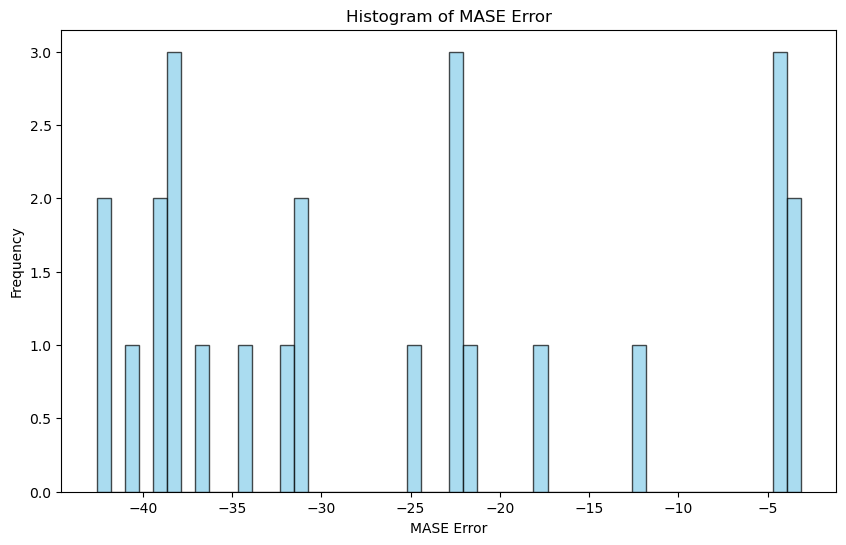

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(errors_D_Demography["MASE_error"], bins=50, alpha=0.7, color="skyblue", edgecolor="black")
plt.xlabel("MASE Error")
plt.ylabel("Frequency")
plt.title("Histogram of MASE Error")
plt.show()


The MASE in here tend to have big values, it would be interesting to find the configuration that impacted into have low values.

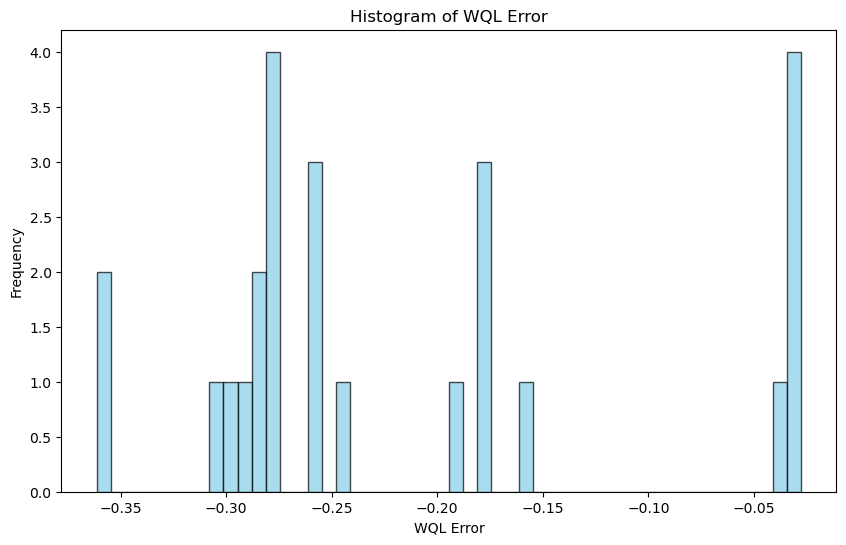

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(errors_D_Demography["WQL_error"], bins=50, alpha=0.7, color="skyblue", edgecolor="black")
plt.xlabel("WQL Error")
plt.ylabel("Frequency")
plt.title("Histogram of WQL Error")
plt.show()

Also in the case of the WQL error it is possible to observe that in this case it tends to be higher values than lower ones. 

In [ ]:
print("maximum configuration ", errors_D_Demography.sort_values(by="WQL_error").max())

maximum configuration  Train_size               3563
Percentage_train        95.0%
Test_size                 891
Percentage_test         75.0%
MASE_error          -3.121918
Diference_MASE      37.953072
WQL_error           -0.027639
Diference_WQL        0.332913
dtype: object


In [ ]:
print( "minimum configuration" , errors_D_Demography.sort_values(by="WQL_error").min())

minimum configuration Train_size                891
Percentage_train         100%
Test_size                  45
Percentage_test          100%
MASE_error         -42.580133
Diference_MASE              0
WQL_error           -0.361348
Diference_WQL               0
dtype: object


In [ ]:
891/(891+3563)

0.20004490345756623

The configuration that was responsable for the best WQL error is the one for nor the train or the test size are their maximum. 
For the test size closer to the current date than the train size. 

In [ ]:
print("maximum configuration ", errors_D_Demography.sort_values(by="MASE_error").max())

maximum configuration  Train_size               3563
Percentage_train        95.0%
Test_size                 891
Percentage_test         75.0%
MASE_error          -3.121918
Diference_MASE      37.953072
WQL_error           -0.027639
Diference_WQL        0.332913
dtype: object


In [ ]:
print( "minimum configuration" , errors_D_Demography.sort_values(by="MASE_error").min())

minimum configuration Train_size                891
Percentage_train         100%
Test_size                  45
Percentage_test          100%
MASE_error         -42.580133
Diference_MASE              0
WQL_error           -0.361348
Diference_WQL               0
dtype: object


The configuration responsable to the smallest error of the MASE is the same one that it was for the WQL.Also it is interesting to notice that worst MASE error was the one corresponding to the initial split.

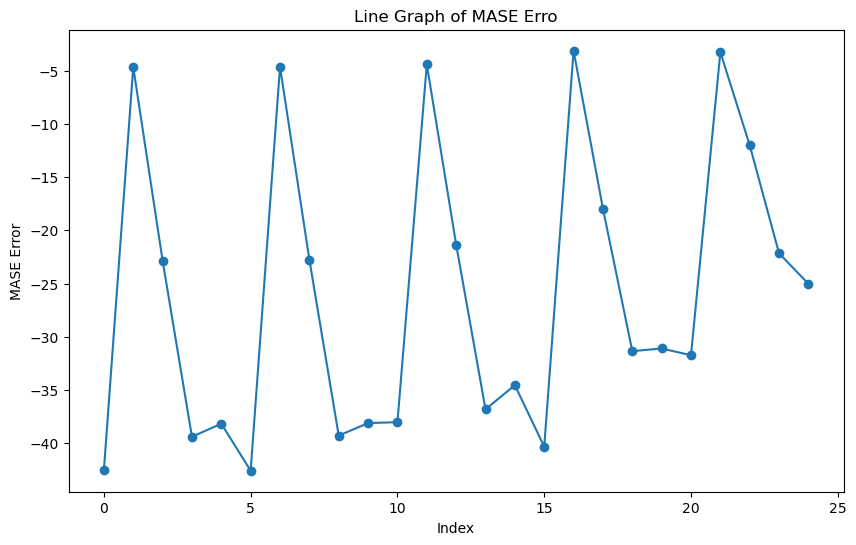

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(errors_D_Demography["MASE_error"].values, marker='o', linestyle='-')
plt.xlabel("Index")
plt.ylabel("MASE Error")
plt.title("Line Graph of MASE Erro")
plt.show()

In this graph it is possible to observe that the smaller is the size of the test set the better is the error and it oscilates between 5 and 40 

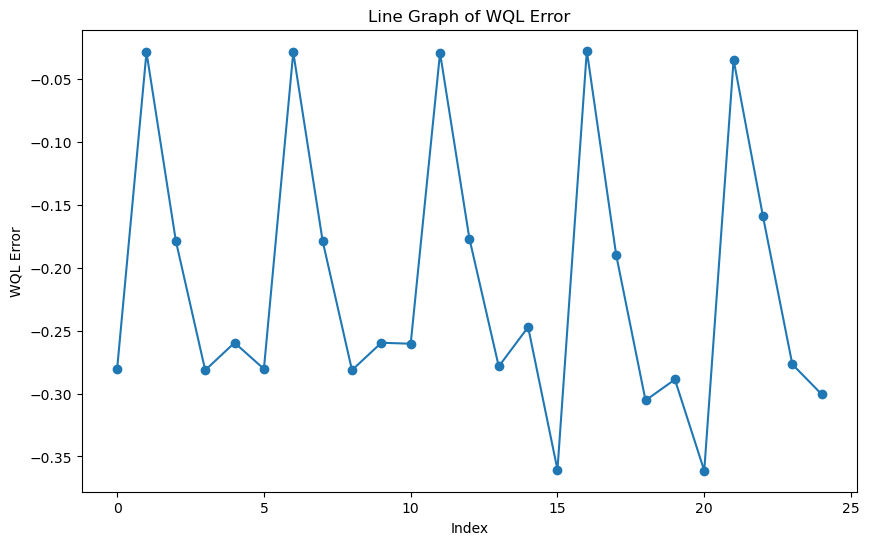

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(errors_D_Demography["WQL_error"].values, marker='o', linestyle='-')
plt.xlabel("Index")
plt.ylabel("WQL Error")
plt.title("Line Graph of WQL Error")
plt.show()

In this graph it is possible to observe that the error oscilates between 5% and 35% and the best configurations are the ones where the test size is the smalles one

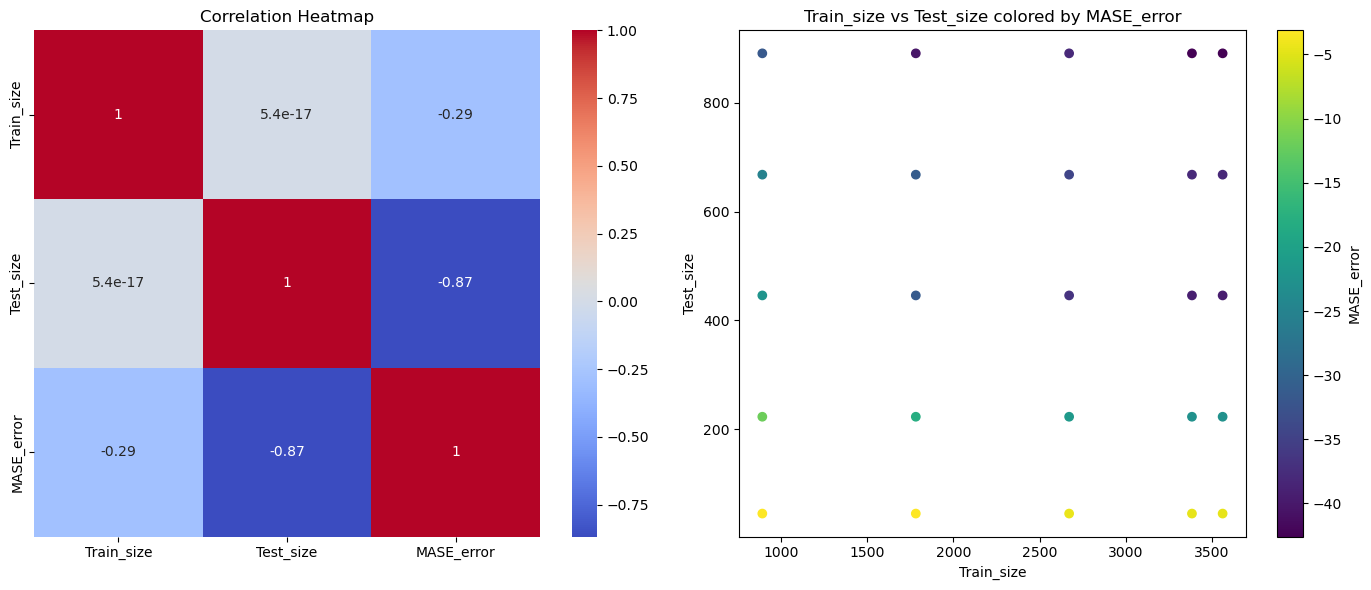

In [ ]:
features = ["Train_size", "Test_size", "MASE_error"]
corr_matrix = errors_D_Demography[features].corr()
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", ax=axes[0])
axes[0].set_title("Correlation Heatmap")
scatter = axes[1].scatter(errors_D_Demography["Train_size"], errors_D_Demography["Test_size"],
                          c=errors_D_Demography["MASE_error"], cmap="viridis")
axes[1].set_xlabel("Train_size")
axes[1].set_ylabel("Test_size")
axes[1].set_title("Train_size vs Test_size colored by MASE_error")
fig.colorbar(scatter, ax=axes[1], label="MASE_error")

plt.tight_layout()
plt.show()

In this case the strongest correlation with the MASE is with the Test_size where the lower is the test size then the smaller is the error. 

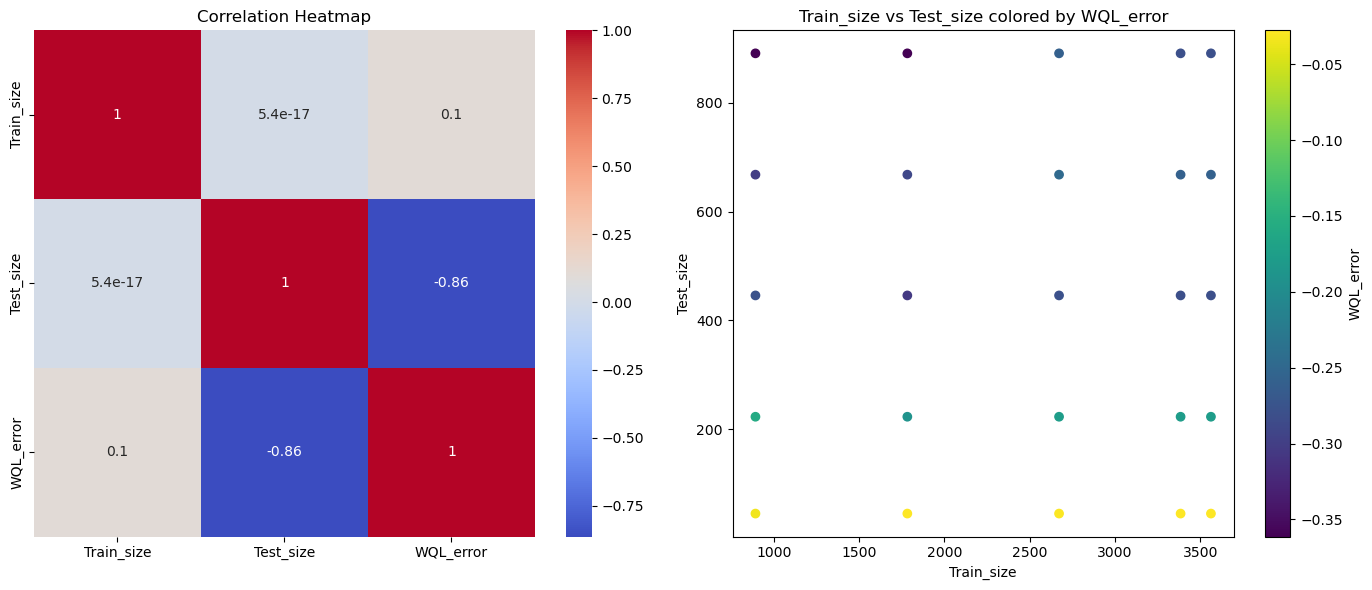

In [ ]:
features = ["Train_size", "Test_size", "WQL_error"]
corr_matrix = errors_D_Demography[features].corr()
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", ax=axes[0])
axes[0].set_title("Correlation Heatmap")

scatter = axes[1].scatter(errors_D_Demography["Train_size"], errors_D_Demography["Test_size"],
                          c=errors_D_Demography["WQL_error"], cmap="viridis")
axes[1].set_xlabel("Train_size")
axes[1].set_ylabel("Test_size")
axes[1].set_title("Train_size vs Test_size colored by WQL_error")
fig.colorbar(scatter, ax=axes[1], label="WQL_error")

plt.tight_layout()
plt.show()

In this case it is interesting to notice that the biggest correlation between the error and the WQL error is given with the Test_size. Also from the right grpah we can observe that the smaller the test size the smaller is the error. 

### Monthly data

In [ ]:
#Take the first value of each month
df_Demography_monthly = df_Demography_1.resample('MS').first().sort_index(ascending=True)

In [ ]:
df_Demography_monthly.index


DatetimeIndex(['2000-03-01', '2000-04-01', '2000-05-01', '2000-06-01',
               '2000-07-01', '2000-08-01', '2000-09-01', '2000-10-01',
               '2000-11-01', '2000-12-01',
               ...
               '2011-08-01', '2011-09-01', '2011-10-01', '2011-11-01',
               '2011-12-01', '2012-01-01', '2012-02-01', '2012-03-01',
               '2012-04-01', '2012-05-01'],
              dtype='datetime64[ns]', name='timestamp', length=147, freq='MS')

In [ ]:
df_Demography_monthly.index = pd.to_datetime(df_Demography_monthly.index).normalize()

In [ ]:
df_Demography_monthly.shape

(147, 3)

In [ ]:
df_Demography_monthly.dtypes

item_id      string[python]
timestamp    datetime64[ns]
target              float64
dtype: object

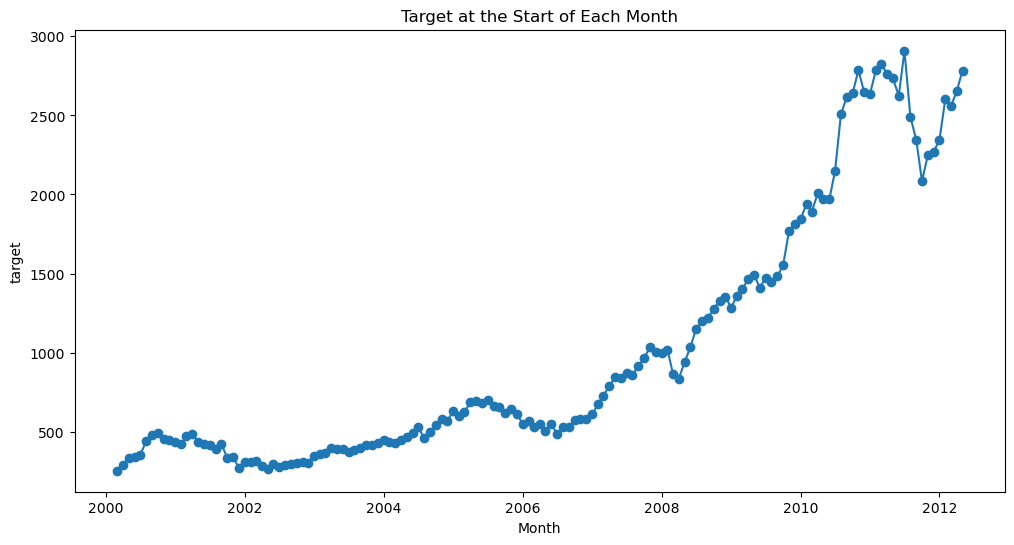

In [ ]:
ts = df_Demography_monthly                   # shorthand
x  = ts.index.get_level_values('timestamp')   # just the dates
y  = ts['target'].values                     # the values

plt.figure(figsize=(12, 6))
plt.plot(x, y, marker='o')
plt.title("Target at the Start of Each Month")
plt.xlabel("Month")
plt.ylabel("target")
plt.show()


In [ ]:
errors_M_Demography=get_errors(df_Demography_monthly, frequ="B")

---------data len 147


Empty DataFrame
Columns: [Train_size, Percentage_train, Test_size, Percentage_test, MASE_error, Diference_MASE, WQL_error, Diference_WQL]
Index: []

Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180150'
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180150'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.45 GB / 7.37 GB (6.1%)
Disk Space Avail:   5.67 GB / 475.75 GB (1.2%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.45 GB / 7.37 GB (6.1%)
Disk Space Ava

----------historical length 118
----------prediction_length 29
-----------history len, min and max 118 ('T001611', Timestamp('2000-03-01 12:00:00')) ('T001611', Timestamp('2009-12-01 12:00:00'))


Provided train_data has 2545 rows (NaN fraction=95.4%), 1 time series. Median time series length is 2545 (min=2545, max=2545). 

Provided data contains following columns:
	target: 'target'

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 20:01:50

Starting training. Start time is 2025-07-11 20:01:50
Models that will be trained: ['Chronos[bolt_small]']
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
Training timeseries model Chronos[bolt_small]. 
	0.02   

---------beginning 0
---------total_length 147
----------training len 118
----------training                               target
item_id timestamp                   
T001611 2009-11-01 12:00:00  1770.37
        2009-12-01 12:00:00  1811.74
----------testing len 147
----------testtt                               target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
        2010-02-01 12:00:00  1939.09
        2010-03-01 12:00:00  1890.90
        2010-04-01 12:00:00  2007.79
        2010-05-01 12:00:00  1974.62
        2010-06-01 12:00:00  1968.82
        2010-07-01 12:00:00  2148.41
        2010-08-01 12:00:00  2507.68
        2010-09-01 12:00:00  2617.94
        2010-10-01 12:00:00  2638.75
        2010-11-01 12:00:00  2786.16
        2010-12-01 12:00:00  2646.29
        2011-01-01 12:00:00  2637.24
        2011-02-01 12:00:00  2786.66
        2011-03-01 12:00:00  2824.55
        2011-04-01 12:00:00  2762.29
        2011-05-01 12:00:00  2733.33
        2011-

mean          0.1          0.2  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1976.889648  1685.218506  1790.816650   
        2010-02-01 12:00:00  1918.344238  1611.663818  1729.878418   
        2010-03-01 12:00:00  1905.742188  1573.525757  1703.986572   
        2010-04-01 12:00:00  1913.105957  1553.252441  1697.406128   
        2010-05-01 12:00:00  1900.354492  1540.726074  1686.399780   
        2010-06-01 12:00:00  1872.515625  1507.342529  1657.593994   
        2010-07-01 12:00:00  1878.997803  1501.091919  1657.061768   
        2010-08-01 12:00:00  1895.883545  1503.080566  1664.447021   
        2010-09-01 12:00:00  1899.953125  1487.801514  1658.075439   
        2010-10-01 12:00:00  1897.659180  1476.558228  1646.349487   
        2010-11-01 12:00:00  1904.620117  1460.126953  1640.103027   
        2010-12-01 12:00:00  1890.191162  1431.290771  1618.250000   
        2011-01-01 12:00:00  1875.721191  1402.382812  1594.671875   
        2011-02-01 12:00:00  1871.434570  1387.946045  1581.086914   
        2011-03-01 12:00:00  1888.722900  1397.038086  1589.071533   
        2011-04-01 12:00:00  1905.157959  1401.504395  1597.316284   
        2011-05-01 12:00:00  1910.132812  1386.953125  1590.863892   
        2011-06-01 12:00:00  1885.470703  1368.461670  1573.814453   
        2011-07-01 12:00:00  1872.051270  1351.385010  1560.222412   
        2011-08-01 12:00:00  1876.269043  1344.192749  1554.499023   
        2011-09-01 12:00:00  1878.717041  1343.910889  1550.881348   
        2011-10-01 12:00:00  1853.605713  1316.131958  1524.905396   
        2011-11-01 12:00:00  1846.241455  1296.505859  1512.252197   
        2011-12-01 12:00:00  1860.799072  1291.488403  1512.345825   
        2012-01-01 12:00:00  1853.075195  1282.371216  1509.275391   
        2012-02-01 12:00:00  1843.248047  1265.766846  1492.456299   
        2012-03-01 12:00:00  1852.285645  1269.796387  1494.362549   
        2012-04-01 12:00:00  1879.495361  1277.545166  1512.247559   
        2012-05-01 12:00:00  1883.575928  1270.996216  1512.139404   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1861.753662  1923.758301  1976.889648   
        2010-02-01 12:00:00  1802.472412  1863.786621  1918.344238   
        2010-03-01 12:00:00  1785.632324  1848.867920  1905.742188   
        2010-04-01 12:00:00  1785.648438  1853.934570  1913.105957   
        2010-05-01 12:00:00  1775.230957  1842.857178  1900.354492   
        2010-06-01 12:00:00  1745.657104  1814.618408  1872.515625   
        2010-07-01 12:00:00  1751.300659  1820.508057  1878.997803   
        2010-08-01 12:00:00  1764.555908  1835.912598  1895.883545   
        2010-09-01 12:00:00  1761.205566  1838.083252  1899.953125   
        2010-10-01 12:00:00  1750.650879  1831.301514  1897.659180   
        2010-11-01 12:00:00  1749.706787  1835.955566  1904.620117   
        2010-12-01 12:00:00  1730.915405  1818.223877  1890.191162   
        2011-01-01 12:00:00  1712.141113  1800.617920  1875.721191   
        2011-02-01 12:00:00  1705.708008  1795.661133  1871.434570   
        2011-03-01 12:00:00  1714.862549  1810.135986  1888.722900   
        2011-04-01 12:00:00  1728.574951  1826.022949  1905.157959   
        2011-05-01 12:00:00  1726.495361  1828.571289  1910.132812   
        2011-06-01 12:00:00  1704.033691  1806.301514  1885.470703   
        2011-07-01 12:00:00  1691.533081  1789.831055  1872.051270   
        2011-08-01 12:00:00  1690.103149  1791.676514  1876.269043   
        2011-09-01 12:00:00  1688.804199  1792.889893  1878.717041   
        2011-10-01 12:00:00  1663.749512  1769.320557  1853.605713   
        2011-11-01 12:00:00  1653.458008  1760.424316  1846.241455   
        2011-12-01 12:00:00  1656.181763  1769.278564  1860.799072   
        2012-01-01 12:00:00  1653.295288  176

---len test slide 147


target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
        2010-02-01 12:00:00  1939.09
        2010-03-01 12:00:00  1890.90
        2010-04-01 12:00:00  2007.79
        2010-05-01 12:00:00  1974.62
        2010-06-01 12:00:00  1968.82
        2010-07-01 12:00:00  2148.41
        2010-08-01 12:00:00  2507.68
        2010-09-01 12:00:00  2617.94
        2010-10-01 12:00:00  2638.75
        2010-11-01 12:00:00  2786.16
        2010-12-01 12:00:00  2646.29
        2011-01-01 12:00:00  2637.24
        2011-02-01 12:00:00  2786.66
        2011-03-01 12:00:00  2824.55
        2011-04-01 12:00:00  2762.29
        2011-05-01 12:00:00  2733.33
        2011-06-01 12:00:00  2624.86
        2011-07-01 12:00:00  2908.83
        2011-08-01 12:00:00  2491.35
        2011-09-01 12:00:00  2344.32
        2011-10-01 12:00:00  2083.83
        2011-11-01 12:00:00  2249.35
        2011-12-01 12:00:00  2268.99
        2012-01-01 12:00:00  2345.56
        2012-02-01 12:00:00  2606.34
        2012-03-01 12:00:00  2556.78
        2012-04-01 12:00:00  2653.78
        2012-05-01 12:00:00  2783.66

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180159'
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180159'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Ver

----------prediction_length 1
-----------history len, min and max 118 ('T001611', Timestamp('2000-03-01 12:00:00')) ('T001611', Timestamp('2009-12-01 12:00:00'))


Provided train_data has 2545 rows (NaN fraction=95.4%), 1 time series. Median time series length is 2545 (min=2545, max=2545). 

Provided data contains following columns:

Provided data contains following columns:
	target: 'target'
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 20:02:00

Starting training. Start time is 2025-07-11 20:02:00
Models that will be trained: ['Chronos[bolt_small]']
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
Training timeseries model Chronos[bolt_small]. 
	0.02   

---------beginning 0
---------total_length 119
----------training len 118
----------training                               target
item_id timestamp                   
T001611 2009-11-01 12:00:00  1770.37
        2009-12-01 12:00:00  1811.74
----------testing len 119
----------testtt                               target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
-----------len predictions 1
-----------len predictions 1


mean          0.1         0.2  \
item_id timestamp                                                   
T001611 2010-01-01 12:00:00  1976.889648  1685.218506  1790.81665   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1861.753662  1923.758301  1976.889648   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  2031.233398  2092.692871  2168.562256   

                                     0.9  
item_id timestamp                         
T001611 2010-01-01 12:00:00  2298.827881

---len test slide 119


target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180209'
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180209'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Ver

----------prediction_length 7
-----------history len, min and max 118 ('T001611', Timestamp('2000-03-01 12:00:00')) ('T001611', Timestamp('2009-12-01 12:00:00'))


Provided train_data has 2545 rows (NaN fraction=95.4%), 1 time series. Median time series length is 2545 (min=2545, max=2545). 

Provided data contains following columns:
	target: 'target'

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 20:02:09

Starting training. Start time is 2025-07-11 20:02:09
Models that will be trained: ['Chronos[bolt_small]']
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training timeseries mo

---------beginning 0
---------total_length 125
----------training len 118
----------training                               target
item_id timestamp                   
T001611 2009-11-01 12:00:00  1770.37
        2009-12-01 12:00:00  1811.74
----------testing len 125
----------testtt                               target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
        2010-02-01 12:00:00  1939.09
        2010-03-01 12:00:00  1890.90
        2010-04-01 12:00:00  2007.79
        2010-05-01 12:00:00  1974.62
        2010-06-01 12:00:00  1968.82
        2010-07-01 12:00:00  2148.41
-----------len predictions 7
-----------len predictions 7


mean          0.1          0.2  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1976.889648  1685.218506  1790.816650   
        2010-02-01 12:00:00  1918.344238  1611.663818  1729.878418   
        2010-03-01 12:00:00  1905.742188  1573.525757  1703.986572   
        2010-04-01 12:00:00  1913.105957  1553.252441  1697.406128   
        2010-05-01 12:00:00  1900.354492  1540.726074  1686.399780   
        2010-06-01 12:00:00  1872.515625  1507.342529  1657.593994   
        2010-07-01 12:00:00  1878.997803  1501.091919  1657.061768   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1861.753662  1923.758301  1976.889648   
        2010-02-01 12:00:00  1802.472412  1863.786621  1918.344238   
        2010-03-01 12:00:00  1785.632324  1848.867920  1905.742188   
        2010-04-01 12:00:00  1785.648438  1853.934570  1913.105957   
        2010-05-01 12:00:00  1775.230957  1842.857178  1900.354492   
        2010-06-01 12:00:00  1745.657104  1814.618408  1872.515625   
        2010-07-01 12:00:00  1751.300659  1820.508057  1878.997803   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  2031.233398  2092.692871  2168.562256   
        2010-02-01 12:00:00  1971.695801  2027.952148  2099.215088   
        2010-03-01 12:00:00  1960.419189  2018.606445  2091.032227   
        2010-04-01 12:00:00  1967.907471  2025.627686  2101.478516   
        2010-05-01 12:00:00  1957.596680  2017.843262  2094.530029   
        2010-06-01 12:00:00  1926.400879  1985.098633  2056.826904   
        2010-07-01 12:00:00  1934.962891  1994.726074  2066.430908   

                                     0.9  
item_id timestamp                         
T001611 2010-01-01 12:00:00  2298.827881  
        2010-02-01 12:00:00  2224.548828  
        2010-03-01 12:00:00  2212.941406  
        2010-04-01 12:00:00  2222.771973  
        2010-05-01 12:00:00  2219.520020  
        2010-06-01 12:00:00  2174.009766  
        2010-07-01 12:00:00  2183.282227

---len test slide 125


target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
        2010-02-01 12:00:00  1939.09
        2010-03-01 12:00:00  1890.90
        2010-04-01 12:00:00  2007.79
        2010-05-01 12:00:00  1974.62
        2010-06-01 12:00:00  1968.82
        2010-07-01 12:00:00  2148.41

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180218'
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180218'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Ver

----------prediction_length 14
-----------history len, min and max 118 ('T001611', Timestamp('2000-03-01 12:00:00')) ('T001611', Timestamp('2009-12-01 12:00:00'))


Provided train_data has 2545 rows (NaN fraction=95.4%), 1 time series. Median time series length is 2545 (min=2545, max=2545). 

Provided data contains following columns:

Provided data contains following columns:
	target: 'target'
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 20:02:19

Starting training. Start time is 2025-07-11 20:02:19
Models that will be trained: ['Chronos[bolt_small]']
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
Training timeseries model Chronos[bolt_small]. 
	0.00   

---------beginning 0
---------total_length 132
----------training len 118
----------training                               target
item_id timestamp                   
T001611 2009-11-01 12:00:00  1770.37
        2009-12-01 12:00:00  1811.74
----------testing len 132
----------testtt                               target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
        2010-02-01 12:00:00  1939.09
        2010-03-01 12:00:00  1890.90
        2010-04-01 12:00:00  2007.79
        2010-05-01 12:00:00  1974.62
        2010-06-01 12:00:00  1968.82
        2010-07-01 12:00:00  2148.41
        2010-08-01 12:00:00  2507.68
        2010-09-01 12:00:00  2617.94
        2010-10-01 12:00:00  2638.75
        2010-11-01 12:00:00  2786.16
        2010-12-01 12:00:00  2646.29
        2011-01-01 12:00:00  2637.24
        2011-02-01 12:00:00  2786.66
-----------len predictions 14
-----------len predictions 14


mean          0.1          0.2  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1976.889648  1685.218506  1790.816650   
        2010-02-01 12:00:00  1918.344238  1611.663818  1729.878418   
        2010-03-01 12:00:00  1905.742188  1573.525757  1703.986572   
        2010-04-01 12:00:00  1913.105957  1553.252441  1697.406128   
        2010-05-01 12:00:00  1900.354492  1540.726074  1686.399780   
        2010-06-01 12:00:00  1872.515625  1507.342529  1657.593994   
        2010-07-01 12:00:00  1878.997803  1501.091919  1657.061768   
        2010-08-01 12:00:00  1895.883545  1503.080566  1664.447021   
        2010-09-01 12:00:00  1899.953125  1487.801514  1658.075439   
        2010-10-01 12:00:00  1897.659180  1476.558228  1646.349487   
        2010-11-01 12:00:00  1904.620117  1460.126953  1640.103027   
        2010-12-01 12:00:00  1890.191162  1431.290771  1618.250000   
        2011-01-01 12:00:00  1875.721191  1402.382812  1594.671875   
        2011-02-01 12:00:00  1871.434570  1387.946045  1581.086914   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1861.753662  1923.758301  1976.889648   
        2010-02-01 12:00:00  1802.472412  1863.786621  1918.344238   
        2010-03-01 12:00:00  1785.632324  1848.867920  1905.742188   
        2010-04-01 12:00:00  1785.648438  1853.934570  1913.105957   
        2010-05-01 12:00:00  1775.230957  1842.857178  1900.354492   
        2010-06-01 12:00:00  1745.657104  1814.618408  1872.515625   
        2010-07-01 12:00:00  1751.300659  1820.508057  1878.997803   
        2010-08-01 12:00:00  1764.555908  1835.912598  1895.883545   
        2010-09-01 12:00:00  1761.205566  1838.083252  1899.953125   
        2010-10-01 12:00:00  1750.650879  1831.301514  1897.659180   
        2010-11-01 12:00:00  1749.706787  1835.955566  1904.620117   
        2010-12-01 12:00:00  1730.915405  1818.223877  1890.191162   
        2011-01-01 12:00:00  1712.141113  1800.617920  1875.721191   
        2011-02-01 12:00:00  1705.708008  1795.661133  1871.434570   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  2031.233398  2092.692871  2168.562256   
        2010-02-01 12:00:00  1971.695801  2027.952148  2099.215088   
        2010-03-01 12:00:00  1960.419189  2018.606445  2091.032227   
        2010-04-01 12:00:00  1967.907471  2025.627686  2101.478516   
        2010-05-01 12:00:00  1957.596680  2017.843262  2094.530029   
        2010-06-01 12:00:00  1926.400879  1985.098633  2056.826904   
        2010-07-01 12:00:00  1934.962891  1994.726074  2066.430908   
        2010-08-01 12:00:00  1952.872070  2012.384277  2084.060059   
        2010-09-01 12:00:00  1959.071777  2020.120605  2094.553711   
        2010-10-01 12:00:00  1960.335205  2025.004395  2100.365967   
        2010-11-01 12:00:00  1967.309814  2031.645752  2111.226807   
        2010-12-01 12:00:00  1953.478027  2023.563965  2105.756592   
        2011-01-01 12:00:00  1942.836182  2012.080566  2095.708496   
        2011-02-01 12:00:00  1939.414062  2007.874512  2086.933105   

                                     0.9  
item_id timestamp                         
T001611 2010-01-01 12:00:00  2298.827881  
        2010-02-01 12:00:00  2224.548828  
        2010-03-01 12:00:00  2212.941406  
        2010-04-01 12:00:00  2222.771973  
        2010-05-01 12:00:00  2219.520020  
        2010-06-01 12:00:00  2174.009766  
        2010-07-01 12:00:00  2183.282227  
        2010-08-01 12:00:00  2205.070312  
        2010-09-01 12:00:00  2217.807373  
        2010-10-01 12:00:00  2230.520264  
        2010-11-01 12:00:00  2242.375000  
        2010-12-01 12:00:00  2243.194092  
        2011-01-01 12:00:00  2226.557617  
        2011-02-01 12:00:00 

---len test slide 132


target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
        2010-02-01 12:00:00  1939.09
        2010-03-01 12:00:00  1890.90
        2010-04-01 12:00:00  2007.79
        2010-05-01 12:00:00  1974.62
        2010-06-01 12:00:00  1968.82
        2010-07-01 12:00:00  2148.41
        2010-08-01 12:00:00  2507.68
        2010-09-01 12:00:00  2617.94
        2010-10-01 12:00:00  2638.75
        2010-11-01 12:00:00  2786.16
        2010-12-01 12:00:00  2646.29
        2011-01-01 12:00:00  2637.24
        2011-02-01 12:00:00  2786.66

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180226'
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180226'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Ver

----------prediction_length 22
-----------history len, min and max 118 ('T001611', Timestamp('2000-03-01 12:00:00')) ('T001611', Timestamp('2009-12-01 12:00:00'))


Provided train_data has 2545 rows (NaN fraction=95.4%), 1 time series. Median time series length is 2545 (min=2545, max=2545). 

Provided data contains following columns:

Provided data contains following columns:
	target: 'target'
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 20:02:27
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 20:02:27
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01   

---------beginning 0
---------total_length 140
----------training len 118
----------training                               target
item_id timestamp                   
T001611 2009-11-01 12:00:00  1770.37
        2009-12-01 12:00:00  1811.74
----------testing len 140
----------testtt                               target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
        2010-02-01 12:00:00  1939.09
        2010-03-01 12:00:00  1890.90
        2010-04-01 12:00:00  2007.79
        2010-05-01 12:00:00  1974.62
        2010-06-01 12:00:00  1968.82
        2010-07-01 12:00:00  2148.41
        2010-08-01 12:00:00  2507.68
        2010-09-01 12:00:00  2617.94
        2010-10-01 12:00:00  2638.75
        2010-11-01 12:00:00  2786.16
        2010-12-01 12:00:00  2646.29
        2011-01-01 12:00:00  2637.24
        2011-02-01 12:00:00  2786.66
        2011-03-01 12:00:00  2824.55
        2011-04-01 12:00:00  2762.29
        2011-05-01 12:00:00  2733.33
        2011-

mean          0.1          0.2  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1976.889648  1685.218506  1790.816650   
        2010-02-01 12:00:00  1918.344238  1611.663818  1729.878418   
        2010-03-01 12:00:00  1905.742188  1573.525757  1703.986572   
        2010-04-01 12:00:00  1913.105957  1553.252441  1697.406128   
        2010-05-01 12:00:00  1900.354492  1540.726074  1686.399780   
        2010-06-01 12:00:00  1872.515625  1507.342529  1657.593994   
        2010-07-01 12:00:00  1878.997803  1501.091919  1657.061768   
        2010-08-01 12:00:00  1895.883545  1503.080566  1664.447021   
        2010-09-01 12:00:00  1899.953125  1487.801514  1658.075439   
        2010-10-01 12:00:00  1897.659180  1476.558228  1646.349487   
        2010-11-01 12:00:00  1904.620117  1460.126953  1640.103027   
        2010-12-01 12:00:00  1890.191162  1431.290771  1618.250000   
        2011-01-01 12:00:00  1875.721191  1402.382812  1594.671875   
        2011-02-01 12:00:00  1871.434570  1387.946045  1581.086914   
        2011-03-01 12:00:00  1888.722900  1397.038086  1589.071533   
        2011-04-01 12:00:00  1905.157959  1401.504395  1597.316284   
        2011-05-01 12:00:00  1910.132812  1386.953125  1590.863892   
        2011-06-01 12:00:00  1885.470703  1368.461670  1573.814453   
        2011-07-01 12:00:00  1872.051270  1351.385010  1560.222412   
        2011-08-01 12:00:00  1876.269043  1344.192749  1554.499023   
        2011-09-01 12:00:00  1878.717041  1343.910889  1550.881348   
        2011-10-01 12:00:00  1853.605713  1316.131958  1524.905396   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1861.753662  1923.758301  1976.889648   
        2010-02-01 12:00:00  1802.472412  1863.786621  1918.344238   
        2010-03-01 12:00:00  1785.632324  1848.867920  1905.742188   
        2010-04-01 12:00:00  1785.648438  1853.934570  1913.105957   
        2010-05-01 12:00:00  1775.230957  1842.857178  1900.354492   
        2010-06-01 12:00:00  1745.657104  1814.618408  1872.515625   
        2010-07-01 12:00:00  1751.300659  1820.508057  1878.997803   
        2010-08-01 12:00:00  1764.555908  1835.912598  1895.883545   
        2010-09-01 12:00:00  1761.205566  1838.083252  1899.953125   
        2010-10-01 12:00:00  1750.650879  1831.301514  1897.659180   
        2010-11-01 12:00:00  1749.706787  1835.955566  1904.620117   
        2010-12-01 12:00:00  1730.915405  1818.223877  1890.191162   
        2011-01-01 12:00:00  1712.141113  1800.617920  1875.721191   
        2011-02-01 12:00:00  1705.708008  1795.661133  1871.434570   
        2011-03-01 12:00:00  1714.862549  1810.135986  1888.722900   
        2011-04-01 12:00:00  1728.574951  1826.022949  1905.157959   
        2011-05-01 12:00:00  1726.495361  1828.571289  1910.132812   
        2011-06-01 12:00:00  1704.033691  1806.301514  1885.470703   
        2011-07-01 12:00:00  1691.533081  1789.831055  1872.051270   
        2011-08-01 12:00:00  1690.103149  1791.676514  1876.269043   
        2011-09-01 12:00:00  1688.804199  1792.889893  1878.717041   
        2011-10-01 12:00:00  1663.749512  1769.320557  1853.605713   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  2031.233398  2092.692871  2168.562256   
        2010-02-01 12:00:00  1971.695801  2027.952148  2099.215088   
        2010-03-01 12:00:00  1960.419189  2018.606445  2091.032227   
        2010-04-01 12:00:00  1967.907471  2025.627686  2101.478516   
        2010-05-01 12:00:00  1957.596680  2017.843262  2094.530029   
        2010-06-01 12:00:00  1926.400879  1985.098633  2056.826904   
        2010-07-01 12:00:00  1934.962891  1994.726074  2066.430908   
        2010-08-01 12:00:00  1952.872070  20

---len test slide 140


target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
        2010-02-01 12:00:00  1939.09
        2010-03-01 12:00:00  1890.90
        2010-04-01 12:00:00  2007.79
        2010-05-01 12:00:00  1974.62
        2010-06-01 12:00:00  1968.82
        2010-07-01 12:00:00  2148.41
        2010-08-01 12:00:00  2507.68
        2010-09-01 12:00:00  2617.94
        2010-10-01 12:00:00  2638.75
        2010-11-01 12:00:00  2786.16
        2010-12-01 12:00:00  2646.29
        2011-01-01 12:00:00  2637.24
        2011-02-01 12:00:00  2786.66
        2011-03-01 12:00:00  2824.55
        2011-04-01 12:00:00  2762.29
        2011-05-01 12:00:00  2733.33
        2011-06-01 12:00:00  2624.86
        2011-07-01 12:00:00  2908.83
        2011-08-01 12:00:00  2491.35
        2011-09-01 12:00:00  2344.32
        2011-10-01 12:00:00  2083.83

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180234'
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180234'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Ver

----------historical length 112
----------prediction_length 29
-----------history len, min and max 112 ('T001611', Timestamp('2000-09-01 12:00:00')) ('T001611', Timestamp('2009-12-01 12:00:00'))



AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 20:02:34
Models that will be trained: ['Chronos[bolt_small]']

Starting training. Start time is 2025-07-11 20:02:34
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
Training timeseries model Chronos[bolt_small]. 
	0.00    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
	0.00    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.07 s
Best model: Chronos[bolt_small]
Total runtime: 0.07 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluo

---------beginning 6
---------total_length 147
----------training len 112
----------training                               target
item_id timestamp                   
T001611 2009-11-01 12:00:00  1770.37
        2009-12-01 12:00:00  1811.74
----------testing len 141
----------testtt                               target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
        2010-02-01 12:00:00  1939.09
        2010-03-01 12:00:00  1890.90
        2010-04-01 12:00:00  2007.79
        2010-05-01 12:00:00  1974.62
        2010-06-01 12:00:00  1968.82
        2010-07-01 12:00:00  2148.41
        2010-08-01 12:00:00  2507.68
        2010-09-01 12:00:00  2617.94
        2010-10-01 12:00:00  2638.75
        2010-11-01 12:00:00  2786.16
        2010-12-01 12:00:00  2646.29
        2011-01-01 12:00:00  2637.24
        2011-02-01 12:00:00  2786.66
        2011-03-01 12:00:00  2824.55
        2011-04-01 12:00:00  2762.29
        2011-05-01 12:00:00  2733.33
        2011-

mean          0.1          0.2  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1976.889648  1685.218506  1790.816650   
        2010-02-01 12:00:00  1918.344238  1611.663818  1729.878418   
        2010-03-01 12:00:00  1905.742188  1573.525757  1703.986572   
        2010-04-01 12:00:00  1913.105957  1553.252441  1697.406128   
        2010-05-01 12:00:00  1900.354492  1540.726074  1686.399780   
        2010-06-01 12:00:00  1872.515625  1507.342529  1657.593994   
        2010-07-01 12:00:00  1878.997803  1501.091919  1657.061768   
        2010-08-01 12:00:00  1895.883545  1503.080566  1664.447021   
        2010-09-01 12:00:00  1899.953125  1487.801514  1658.075439   
        2010-10-01 12:00:00  1897.659180  1476.558228  1646.349487   
        2010-11-01 12:00:00  1904.620117  1460.126953  1640.103027   
        2010-12-01 12:00:00  1890.191162  1431.290771  1618.250000   
        2011-01-01 12:00:00  1875.721191  1402.382812  1594.671875   
        2011-02-01 12:00:00  1871.434570  1387.946045  1581.086914   
        2011-03-01 12:00:00  1888.722900  1397.038086  1589.071533   
        2011-04-01 12:00:00  1905.157959  1401.504395  1597.316284   
        2011-05-01 12:00:00  1910.132812  1386.953125  1590.863892   
        2011-06-01 12:00:00  1885.470703  1368.461670  1573.814453   
        2011-07-01 12:00:00  1872.051270  1351.385010  1560.222412   
        2011-08-01 12:00:00  1876.269043  1344.192749  1554.499023   
        2011-09-01 12:00:00  1878.717041  1343.910889  1550.881348   
        2011-10-01 12:00:00  1853.605713  1316.131958  1524.905396   
        2011-11-01 12:00:00  1846.241455  1296.505859  1512.252197   
        2011-12-01 12:00:00  1860.799072  1291.488403  1512.345825   
        2012-01-01 12:00:00  1853.075195  1282.371216  1509.275391   
        2012-02-01 12:00:00  1843.248047  1265.766846  1492.456299   
        2012-03-01 12:00:00  1852.285645  1269.796387  1494.362549   
        2012-04-01 12:00:00  1879.495361  1277.545166  1512.247559   
        2012-05-01 12:00:00  1883.575928  1270.996216  1512.139404   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1861.753662  1923.758301  1976.889648   
        2010-02-01 12:00:00  1802.472412  1863.786621  1918.344238   
        2010-03-01 12:00:00  1785.632324  1848.867920  1905.742188   
        2010-04-01 12:00:00  1785.648438  1853.934570  1913.105957   
        2010-05-01 12:00:00  1775.230957  1842.857178  1900.354492   
        2010-06-01 12:00:00  1745.657104  1814.618408  1872.515625   
        2010-07-01 12:00:00  1751.300659  1820.508057  1878.997803   
        2010-08-01 12:00:00  1764.555908  1835.912598  1895.883545   
        2010-09-01 12:00:00  1761.205566  1838.083252  1899.953125   
        2010-10-01 12:00:00  1750.650879  1831.301514  1897.659180   
        2010-11-01 12:00:00  1749.706787  1835.955566  1904.620117   
        2010-12-01 12:00:00  1730.915405  1818.223877  1890.191162   
        2011-01-01 12:00:00  1712.141113  1800.617920  1875.721191   
        2011-02-01 12:00:00  1705.708008  1795.661133  1871.434570   
        2011-03-01 12:00:00  1714.862549  1810.135986  1888.722900   
        2011-04-01 12:00:00  1728.574951  1826.022949  1905.157959   
        2011-05-01 12:00:00  1726.495361  1828.571289  1910.132812   
        2011-06-01 12:00:00  1704.033691  1806.301514  1885.470703   
        2011-07-01 12:00:00  1691.533081  1789.831055  1872.051270   
        2011-08-01 12:00:00  1690.103149  1791.676514  1876.269043   
        2011-09-01 12:00:00  1688.804199  1792.889893  1878.717041   
        2011-10-01 12:00:00  1663.749512  1769.320557  1853.605713   
        2011-11-01 12:00:00  1653.458008  1760.424316  1846.241455   
        2011-12-01 12:00:00  1656.181763  1769.278564  1860.799072   
        2012-01-01 12:00:00  1653.295288  176

---len test slide 141


target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
        2010-02-01 12:00:00  1939.09
        2010-03-01 12:00:00  1890.90
        2010-04-01 12:00:00  2007.79
        2010-05-01 12:00:00  1974.62
        2010-06-01 12:00:00  1968.82
        2010-07-01 12:00:00  2148.41
        2010-08-01 12:00:00  2507.68
        2010-09-01 12:00:00  2617.94
        2010-10-01 12:00:00  2638.75
        2010-11-01 12:00:00  2786.16
        2010-12-01 12:00:00  2646.29
        2011-01-01 12:00:00  2637.24
        2011-02-01 12:00:00  2786.66
        2011-03-01 12:00:00  2824.55
        2011-04-01 12:00:00  2762.29
        2011-05-01 12:00:00  2733.33
        2011-06-01 12:00:00  2624.86
        2011-07-01 12:00:00  2908.83
        2011-08-01 12:00:00  2491.35
        2011-09-01 12:00:00  2344.32
        2011-10-01 12:00:00  2083.83
        2011-11-01 12:00:00  2249.35
        2011-12-01 12:00:00  2268.99
        2012-01-01 12:00:00  2345.56
        2012-02-01 12:00:00  2606.34
        2012-03-01 12:00:00  2556.78
        2012-04-01 12:00:00  2653.78
        2012-05-01 12:00:00  2783.66

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180240'
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180240'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Ver

----------prediction_length 1
-----------history len, min and max 112 ('T001611', Timestamp('2000-09-01 12:00:00')) ('T001611', Timestamp('2009-12-01 12:00:00'))



Provided data contains following columns:
	target: 'target'
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 20:02:40

Starting training. Start time is 2025-07-11 20:02:40
Models that will be trained: ['Chronos[bolt_small]']
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.00    s     = Training runtime
Training timeseries model Chronos[bolt_small]. 
	0.00    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.07 s
Training complete. Models trai

---------beginning 6
---------total_length 119
----------training len 112
----------training                               target
item_id timestamp                   
T001611 2009-11-01 12:00:00  1770.37
        2009-12-01 12:00:00  1811.74
----------testing len 113
----------testtt                               target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
-----------len predictions 1
-----------len predictions 1


mean          0.1         0.2  \
item_id timestamp                                                   
T001611 2010-01-01 12:00:00  1976.889648  1685.218506  1790.81665   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1861.753662  1923.758301  1976.889648   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  2031.233398  2092.692871  2168.562256   

                                     0.9  
item_id timestamp                         
T001611 2010-01-01 12:00:00  2298.827881

---len test slide 113


target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180247'
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180247'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Ver

----------prediction_length 7
-----------history len, min and max 112 ('T001611', Timestamp('2000-09-01 12:00:00')) ('T001611', Timestamp('2009-12-01 12:00:00'))



Provided data contains following columns:
	target: 'target'
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 20:02:47

Starting training. Start time is 2025-07-11 20:02:47
Models that will be trained: ['Chronos[bolt_small]']
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.00    s     = Training runtime
Training timeseries model Chronos[bolt_small]. 
	0.00    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.11 s
Training complete. Models trai

---------beginning 6
---------total_length 125
----------training len 112
----------training                               target
item_id timestamp                   
T001611 2009-11-01 12:00:00  1770.37
        2009-12-01 12:00:00  1811.74
----------testing len 119
----------testtt                               target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
        2010-02-01 12:00:00  1939.09
        2010-03-01 12:00:00  1890.90
        2010-04-01 12:00:00  2007.79
        2010-05-01 12:00:00  1974.62
        2010-06-01 12:00:00  1968.82
        2010-07-01 12:00:00  2148.41
-----------len predictions 7
-----------len predictions 7


mean          0.1          0.2  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1976.889648  1685.218506  1790.816650   
        2010-02-01 12:00:00  1918.344238  1611.663818  1729.878418   
        2010-03-01 12:00:00  1905.742188  1573.525757  1703.986572   
        2010-04-01 12:00:00  1913.105957  1553.252441  1697.406128   
        2010-05-01 12:00:00  1900.354492  1540.726074  1686.399780   
        2010-06-01 12:00:00  1872.515625  1507.342529  1657.593994   
        2010-07-01 12:00:00  1878.997803  1501.091919  1657.061768   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1861.753662  1923.758301  1976.889648   
        2010-02-01 12:00:00  1802.472412  1863.786621  1918.344238   
        2010-03-01 12:00:00  1785.632324  1848.867920  1905.742188   
        2010-04-01 12:00:00  1785.648438  1853.934570  1913.105957   
        2010-05-01 12:00:00  1775.230957  1842.857178  1900.354492   
        2010-06-01 12:00:00  1745.657104  1814.618408  1872.515625   
        2010-07-01 12:00:00  1751.300659  1820.508057  1878.997803   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  2031.233398  2092.692871  2168.562256   
        2010-02-01 12:00:00  1971.695801  2027.952148  2099.215088   
        2010-03-01 12:00:00  1960.419189  2018.606445  2091.032227   
        2010-04-01 12:00:00  1967.907471  2025.627686  2101.478516   
        2010-05-01 12:00:00  1957.596680  2017.843262  2094.530029   
        2010-06-01 12:00:00  1926.400879  1985.098633  2056.826904   
        2010-07-01 12:00:00  1934.962891  1994.726074  2066.430908   

                                     0.9  
item_id timestamp                         
T001611 2010-01-01 12:00:00  2298.827881  
        2010-02-01 12:00:00  2224.548828  
        2010-03-01 12:00:00  2212.941406  
        2010-04-01 12:00:00  2222.771973  
        2010-05-01 12:00:00  2219.520020  
        2010-06-01 12:00:00  2174.009766  
        2010-07-01 12:00:00  2183.282227

---len test slide 119


target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
        2010-02-01 12:00:00  1939.09
        2010-03-01 12:00:00  1890.90
        2010-04-01 12:00:00  2007.79
        2010-05-01 12:00:00  1974.62
        2010-06-01 12:00:00  1968.82
        2010-07-01 12:00:00  2148.41

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180253'
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180253'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Ver

----------prediction_length 14
-----------history len, min and max 112 ('T001611', Timestamp('2000-09-01 12:00:00')) ('T001611', Timestamp('2009-12-01 12:00:00'))


	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 20:02:53

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 20:02:53
Models that will be trained: ['Chronos[bolt_small]']
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
Training timeseries model Chronos[bolt_small]. 
	0.00    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
	0.00    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.07 s
Best model: Chronos[bolt_small]


---------beginning 6
---------total_length 132
----------training len 112
----------training                               target
item_id timestamp                   
T001611 2009-11-01 12:00:00  1770.37
        2009-12-01 12:00:00  1811.74
----------testing len 126
----------testtt                               target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
        2010-02-01 12:00:00  1939.09
        2010-03-01 12:00:00  1890.90
        2010-04-01 12:00:00  2007.79
        2010-05-01 12:00:00  1974.62
        2010-06-01 12:00:00  1968.82
        2010-07-01 12:00:00  2148.41
        2010-08-01 12:00:00  2507.68
        2010-09-01 12:00:00  2617.94
        2010-10-01 12:00:00  2638.75
        2010-11-01 12:00:00  2786.16
        2010-12-01 12:00:00  2646.29
        2011-01-01 12:00:00  2637.24
        2011-02-01 12:00:00  2786.66
-----------len predictions 14
-----------len predictions 14


mean          0.1          0.2  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1976.889648  1685.218506  1790.816650   
        2010-02-01 12:00:00  1918.344238  1611.663818  1729.878418   
        2010-03-01 12:00:00  1905.742188  1573.525757  1703.986572   
        2010-04-01 12:00:00  1913.105957  1553.252441  1697.406128   
        2010-05-01 12:00:00  1900.354492  1540.726074  1686.399780   
        2010-06-01 12:00:00  1872.515625  1507.342529  1657.593994   
        2010-07-01 12:00:00  1878.997803  1501.091919  1657.061768   
        2010-08-01 12:00:00  1895.883545  1503.080566  1664.447021   
        2010-09-01 12:00:00  1899.953125  1487.801514  1658.075439   
        2010-10-01 12:00:00  1897.659180  1476.558228  1646.349487   
        2010-11-01 12:00:00  1904.620117  1460.126953  1640.103027   
        2010-12-01 12:00:00  1890.191162  1431.290771  1618.250000   
        2011-01-01 12:00:00  1875.721191  1402.382812  1594.671875   
        2011-02-01 12:00:00  1871.434570  1387.946045  1581.086914   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1861.753662  1923.758301  1976.889648   
        2010-02-01 12:00:00  1802.472412  1863.786621  1918.344238   
        2010-03-01 12:00:00  1785.632324  1848.867920  1905.742188   
        2010-04-01 12:00:00  1785.648438  1853.934570  1913.105957   
        2010-05-01 12:00:00  1775.230957  1842.857178  1900.354492   
        2010-06-01 12:00:00  1745.657104  1814.618408  1872.515625   
        2010-07-01 12:00:00  1751.300659  1820.508057  1878.997803   
        2010-08-01 12:00:00  1764.555908  1835.912598  1895.883545   
        2010-09-01 12:00:00  1761.205566  1838.083252  1899.953125   
        2010-10-01 12:00:00  1750.650879  1831.301514  1897.659180   
        2010-11-01 12:00:00  1749.706787  1835.955566  1904.620117   
        2010-12-01 12:00:00  1730.915405  1818.223877  1890.191162   
        2011-01-01 12:00:00  1712.141113  1800.617920  1875.721191   
        2011-02-01 12:00:00  1705.708008  1795.661133  1871.434570   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  2031.233398  2092.692871  2168.562256   
        2010-02-01 12:00:00  1971.695801  2027.952148  2099.215088   
        2010-03-01 12:00:00  1960.419189  2018.606445  2091.032227   
        2010-04-01 12:00:00  1967.907471  2025.627686  2101.478516   
        2010-05-01 12:00:00  1957.596680  2017.843262  2094.530029   
        2010-06-01 12:00:00  1926.400879  1985.098633  2056.826904   
        2010-07-01 12:00:00  1934.962891  1994.726074  2066.430908   
        2010-08-01 12:00:00  1952.872070  2012.384277  2084.060059   
        2010-09-01 12:00:00  1959.071777  2020.120605  2094.553711   
        2010-10-01 12:00:00  1960.335205  2025.004395  2100.365967   
        2010-11-01 12:00:00  1967.309814  2031.645752  2111.226807   
        2010-12-01 12:00:00  1953.478027  2023.563965  2105.756592   
        2011-01-01 12:00:00  1942.836182  2012.080566  2095.708496   
        2011-02-01 12:00:00  1939.414062  2007.874512  2086.933105   

                                     0.9  
item_id timestamp                         
T001611 2010-01-01 12:00:00  2298.827881  
        2010-02-01 12:00:00  2224.548828  
        2010-03-01 12:00:00  2212.941406  
        2010-04-01 12:00:00  2222.771973  
        2010-05-01 12:00:00  2219.520020  
        2010-06-01 12:00:00  2174.009766  
        2010-07-01 12:00:00  2183.282227  
        2010-08-01 12:00:00  2205.070312  
        2010-09-01 12:00:00  2217.807373  
        2010-10-01 12:00:00  2230.520264  
        2010-11-01 12:00:00  2242.375000  
        2010-12-01 12:00:00  2243.194092  
        2011-01-01 12:00:00  2226.557617  
        2011-02-01 12:00:00 

---len test slide 126


target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
        2010-02-01 12:00:00  1939.09
        2010-03-01 12:00:00  1890.90
        2010-04-01 12:00:00  2007.79
        2010-05-01 12:00:00  1974.62
        2010-06-01 12:00:00  1968.82
        2010-07-01 12:00:00  2148.41
        2010-08-01 12:00:00  2507.68
        2010-09-01 12:00:00  2617.94
        2010-10-01 12:00:00  2638.75
        2010-11-01 12:00:00  2786.16
        2010-12-01 12:00:00  2646.29
        2011-01-01 12:00:00  2637.24
        2011-02-01 12:00:00  2786.66

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180259'
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180259'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Ver

----------prediction_length 22
-----------history len, min and max 112 ('T001611', Timestamp('2000-09-01 12:00:00')) ('T001611', Timestamp('2009-12-01 12:00:00'))


	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 20:02:59

Starting training. Start time is 2025-07-11 20:02:59
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.11 s
Total runtime: 0.11 s
Best model

---------beginning 6
---------total_length 140
----------training len 112
----------training                               target
item_id timestamp                   
T001611 2009-11-01 12:00:00  1770.37
        2009-12-01 12:00:00  1811.74
----------testing len 134
----------testtt                               target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
        2010-02-01 12:00:00  1939.09
        2010-03-01 12:00:00  1890.90
        2010-04-01 12:00:00  2007.79
        2010-05-01 12:00:00  1974.62
        2010-06-01 12:00:00  1968.82
        2010-07-01 12:00:00  2148.41
        2010-08-01 12:00:00  2507.68
        2010-09-01 12:00:00  2617.94
        2010-10-01 12:00:00  2638.75
        2010-11-01 12:00:00  2786.16
        2010-12-01 12:00:00  2646.29
        2011-01-01 12:00:00  2637.24
        2011-02-01 12:00:00  2786.66
        2011-03-01 12:00:00  2824.55
        2011-04-01 12:00:00  2762.29
        2011-05-01 12:00:00  2733.33
        2011-

mean          0.1          0.2  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1976.889648  1685.218506  1790.816650   
        2010-02-01 12:00:00  1918.344238  1611.663818  1729.878418   
        2010-03-01 12:00:00  1905.742188  1573.525757  1703.986572   
        2010-04-01 12:00:00  1913.105957  1553.252441  1697.406128   
        2010-05-01 12:00:00  1900.354492  1540.726074  1686.399780   
        2010-06-01 12:00:00  1872.515625  1507.342529  1657.593994   
        2010-07-01 12:00:00  1878.997803  1501.091919  1657.061768   
        2010-08-01 12:00:00  1895.883545  1503.080566  1664.447021   
        2010-09-01 12:00:00  1899.953125  1487.801514  1658.075439   
        2010-10-01 12:00:00  1897.659180  1476.558228  1646.349487   
        2010-11-01 12:00:00  1904.620117  1460.126953  1640.103027   
        2010-12-01 12:00:00  1890.191162  1431.290771  1618.250000   
        2011-01-01 12:00:00  1875.721191  1402.382812  1594.671875   
        2011-02-01 12:00:00  1871.434570  1387.946045  1581.086914   
        2011-03-01 12:00:00  1888.722900  1397.038086  1589.071533   
        2011-04-01 12:00:00  1905.157959  1401.504395  1597.316284   
        2011-05-01 12:00:00  1910.132812  1386.953125  1590.863892   
        2011-06-01 12:00:00  1885.470703  1368.461670  1573.814453   
        2011-07-01 12:00:00  1872.051270  1351.385010  1560.222412   
        2011-08-01 12:00:00  1876.269043  1344.192749  1554.499023   
        2011-09-01 12:00:00  1878.717041  1343.910889  1550.881348   
        2011-10-01 12:00:00  1853.605713  1316.131958  1524.905396   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1861.753662  1923.758301  1976.889648   
        2010-02-01 12:00:00  1802.472412  1863.786621  1918.344238   
        2010-03-01 12:00:00  1785.632324  1848.867920  1905.742188   
        2010-04-01 12:00:00  1785.648438  1853.934570  1913.105957   
        2010-05-01 12:00:00  1775.230957  1842.857178  1900.354492   
        2010-06-01 12:00:00  1745.657104  1814.618408  1872.515625   
        2010-07-01 12:00:00  1751.300659  1820.508057  1878.997803   
        2010-08-01 12:00:00  1764.555908  1835.912598  1895.883545   
        2010-09-01 12:00:00  1761.205566  1838.083252  1899.953125   
        2010-10-01 12:00:00  1750.650879  1831.301514  1897.659180   
        2010-11-01 12:00:00  1749.706787  1835.955566  1904.620117   
        2010-12-01 12:00:00  1730.915405  1818.223877  1890.191162   
        2011-01-01 12:00:00  1712.141113  1800.617920  1875.721191   
        2011-02-01 12:00:00  1705.708008  1795.661133  1871.434570   
        2011-03-01 12:00:00  1714.862549  1810.135986  1888.722900   
        2011-04-01 12:00:00  1728.574951  1826.022949  1905.157959   
        2011-05-01 12:00:00  1726.495361  1828.571289  1910.132812   
        2011-06-01 12:00:00  1704.033691  1806.301514  1885.470703   
        2011-07-01 12:00:00  1691.533081  1789.831055  1872.051270   
        2011-08-01 12:00:00  1690.103149  1791.676514  1876.269043   
        2011-09-01 12:00:00  1688.804199  1792.889893  1878.717041   
        2011-10-01 12:00:00  1663.749512  1769.320557  1853.605713   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  2031.233398  2092.692871  2168.562256   
        2010-02-01 12:00:00  1971.695801  2027.952148  2099.215088   
        2010-03-01 12:00:00  1960.419189  2018.606445  2091.032227   
        2010-04-01 12:00:00  1967.907471  2025.627686  2101.478516   
        2010-05-01 12:00:00  1957.596680  2017.843262  2094.530029   
        2010-06-01 12:00:00  1926.400879  1985.098633  2056.826904   
        2010-07-01 12:00:00  1934.962891  1994.726074  2066.430908   
        2010-08-01 12:00:00  1952.872070  20

---len test slide 134


target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
        2010-02-01 12:00:00  1939.09
        2010-03-01 12:00:00  1890.90
        2010-04-01 12:00:00  2007.79
        2010-05-01 12:00:00  1974.62
        2010-06-01 12:00:00  1968.82
        2010-07-01 12:00:00  2148.41
        2010-08-01 12:00:00  2507.68
        2010-09-01 12:00:00  2617.94
        2010-10-01 12:00:00  2638.75
        2010-11-01 12:00:00  2786.16
        2010-12-01 12:00:00  2646.29
        2011-01-01 12:00:00  2637.24
        2011-02-01 12:00:00  2786.66
        2011-03-01 12:00:00  2824.55
        2011-04-01 12:00:00  2762.29
        2011-05-01 12:00:00  2733.33
        2011-06-01 12:00:00  2624.86
        2011-07-01 12:00:00  2908.83
        2011-08-01 12:00:00  2491.35
        2011-09-01 12:00:00  2344.32
        2011-10-01 12:00:00  2083.83

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180306'
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180306'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Ver

----------historical length 88
----------prediction_length 29
-----------history len, min and max 88 ('T001611', Timestamp('2002-09-01 12:00:00')) ('T001611', Timestamp('2009-12-01 12:00:00'))



Provided data contains following columns:
	target: 'target'
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 20:03:06

Starting training. Start time is 2025-07-11 20:03:06
Models that will be trained: ['Chronos[bolt_small]']
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_sm

---------beginning 30
---------total_length 147
----------training len 88
----------training                               target
item_id timestamp                   
T001611 2009-11-01 12:00:00  1770.37
        2009-12-01 12:00:00  1811.74
----------testing len 117
----------testtt                               target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
        2010-02-01 12:00:00  1939.09
        2010-03-01 12:00:00  1890.90
        2010-04-01 12:00:00  2007.79
        2010-05-01 12:00:00  1974.62
        2010-06-01 12:00:00  1968.82
        2010-07-01 12:00:00  2148.41
        2010-08-01 12:00:00  2507.68
        2010-09-01 12:00:00  2617.94
        2010-10-01 12:00:00  2638.75
        2010-11-01 12:00:00  2786.16
        2010-12-01 12:00:00  2646.29
        2011-01-01 12:00:00  2637.24
        2011-02-01 12:00:00  2786.66
        2011-03-01 12:00:00  2824.55
        2011-04-01 12:00:00  2762.29
        2011-05-01 12:00:00  2733.33
        2011-

mean          0.1          0.2  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1965.427490  1681.462402  1784.475098   
        2010-02-01 12:00:00  1906.685547  1607.366577  1723.267456   
        2010-03-01 12:00:00  1893.967407  1569.189697  1697.396240   
        2010-04-01 12:00:00  1901.296387  1549.302734  1691.182373   
        2010-05-01 12:00:00  1890.243286  1538.247681  1681.533813   
        2010-06-01 12:00:00  1864.178223  1506.378662  1654.108643   
        2010-07-01 12:00:00  1870.365723  1499.958252  1653.273926   
        2010-08-01 12:00:00  1885.316162  1500.521973  1658.964355   
        2010-09-01 12:00:00  1888.281616  1484.826416  1651.807007   
        2010-10-01 12:00:00  1885.430542  1473.714233  1639.936279   
        2010-11-01 12:00:00  1892.117432  1457.506958  1633.674438   
        2010-12-01 12:00:00  1878.094727  1429.588501  1612.562500   
        2011-01-01 12:00:00  1865.472168  1402.503418  1590.723389   
        2011-02-01 12:00:00  1861.075439  1388.179565  1577.154663   
        2011-03-01 12:00:00  1877.348389  1396.624268  1584.146973   
        2011-04-01 12:00:00  1892.357544  1399.894043  1591.138428   
        2011-05-01 12:00:00  1897.155029  1385.257446  1584.542725   
        2011-06-01 12:00:00  1873.434570  1367.097534  1568.025513   
        2011-07-01 12:00:00  1860.888184  1351.248901  1555.304321   
        2011-08-01 12:00:00  1866.060913  1345.645386  1551.009033   
        2011-09-01 12:00:00  1869.738770  1346.223389  1548.302124   
        2011-10-01 12:00:00  1844.745483  1318.572632  1522.388916   
        2011-11-01 12:00:00  1836.705566  1298.478027  1509.185669   
        2011-12-01 12:00:00  1849.896240  1292.824951  1508.492920   
        2012-01-01 12:00:00  1842.531860  1284.377197  1505.765503   
        2012-02-01 12:00:00  1832.947632  1268.631104  1489.506348   
        2012-03-01 12:00:00  1842.650391  1273.645874  1492.339355   
        2012-04-01 12:00:00  1868.797119  1281.336426  1509.785889   
        2012-05-01 12:00:00  1872.395264  1274.754150  1509.484497   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1853.367188  1913.725342  1965.427490   
        2010-02-01 12:00:00  1793.934692  1853.525513  1906.685547   
        2010-03-01 12:00:00  1777.113037  1838.678223  1893.967407   
        2010-04-01 12:00:00  1777.406494  1843.827393  1901.296387   
        2010-05-01 12:00:00  1768.429810  1834.362427  1890.243286   
        2010-06-01 12:00:00  1740.582031  1807.866699  1864.178223   
        2010-07-01 12:00:00  1745.824219  1813.489380  1870.365723   
        2010-08-01 12:00:00  1757.387207  1827.096436  1885.316162   
        2010-09-01 12:00:00  1753.201172  1828.353760  1888.281616   
        2010-10-01 12:00:00  1742.361572  1821.094849  1885.430542   
        2010-11-01 12:00:00  1741.382812  1825.625732  1892.117432   
        2010-12-01 12:00:00  1723.085205  1808.300415  1878.094727   
        2011-01-01 12:00:00  1706.071045  1792.580322  1865.472168   
        2011-02-01 12:00:00  1699.517578  1787.621094  1861.075439   
        2011-03-01 12:00:00  1707.776123  1801.079102  1877.348389   
        2011-04-01 12:00:00  1720.155029  1815.624146  1892.357544   
        2011-05-01 12:00:00  1717.915039  1817.912109  1897.155029   
        2011-06-01 12:00:00  1696.113770  1796.518555  1873.434570   
        2011-07-01 12:00:00  1684.318604  1780.929443  1860.888184   
        2011-08-01 12:00:00  1684.178955  1783.879883  1866.060913   
        2011-09-01 12:00:00  1683.967285  1786.165771  1869.738770   
        2011-10-01 12:00:00  1658.995117  1762.753662  1844.745483   
        2011-11-01 12:00:00  1647.985596  1753.145386  1836.705566   
        2011-12-01 12:00:00  1649.748535  1760.835938  1849.896240   
        2012-01-01 12:00:00  1647.118652  175

---len test slide 117


target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
        2010-02-01 12:00:00  1939.09
        2010-03-01 12:00:00  1890.90
        2010-04-01 12:00:00  2007.79
        2010-05-01 12:00:00  1974.62
        2010-06-01 12:00:00  1968.82
        2010-07-01 12:00:00  2148.41
        2010-08-01 12:00:00  2507.68
        2010-09-01 12:00:00  2617.94
        2010-10-01 12:00:00  2638.75
        2010-11-01 12:00:00  2786.16
        2010-12-01 12:00:00  2646.29
        2011-01-01 12:00:00  2637.24
        2011-02-01 12:00:00  2786.66
        2011-03-01 12:00:00  2824.55
        2011-04-01 12:00:00  2762.29
        2011-05-01 12:00:00  2733.33
        2011-06-01 12:00:00  2624.86
        2011-07-01 12:00:00  2908.83
        2011-08-01 12:00:00  2491.35
        2011-09-01 12:00:00  2344.32
        2011-10-01 12:00:00  2083.83
        2011-11-01 12:00:00  2249.35
        2011-12-01 12:00:00  2268.99
        2012-01-01 12:00:00  2345.56
        2012-02-01 12:00:00  2606.34
        2012-03-01 12:00:00  2556.78
        2012-04-01 12:00:00  2653.78
        2012-05-01 12:00:00  2783.66

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180313'
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180313'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Ver

----------prediction_length 1
-----------history len, min and max 88 ('T001611', Timestamp('2002-09-01 12:00:00')) ('T001611', Timestamp('2009-12-01 12:00:00'))


Provided train_data has 1893 rows (NaN fraction=95.4%), 1 time series. Median time series length is 1893 (min=1893, max=1893). 

Provided data contains following columns:

Provided data contains following columns:
	target: 'target'
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 20:03:13

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 20:03:13
Models that will be trained: ['Chronos[bolt_small]']
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
Training timeseries model Chronos[bolt_small]. 
	0.01   

---------beginning 30
---------total_length 119
----------training len 88
----------training                               target
item_id timestamp                   
T001611 2009-11-01 12:00:00  1770.37
        2009-12-01 12:00:00  1811.74
----------testing len 89
----------testtt                               target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
-----------len predictions 1
-----------len predictions 1


mean          0.1          0.2  \
item_id timestamp                                                   
T001611 2010-01-01 12:00:00  1965.42749  1681.462402  1784.475098   

                                     0.3          0.4         0.5  \
item_id timestamp                                                   
T001611 2010-01-01 12:00:00  1853.367188  1913.725342  1965.42749   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  2018.356323  2078.290527  2152.325195   

                                     0.9  
item_id timestamp                         
T001611 2010-01-01 12:00:00  2279.945312

---len test slide 89


target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180320'
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180320'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Ver

----------prediction_length 7
-----------history len, min and max 88 ('T001611', Timestamp('2002-09-01 12:00:00')) ('T001611', Timestamp('2009-12-01 12:00:00'))



Provided data contains following columns:
	target: 'target'
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 20:03:20
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 20:03:20
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.02    s     = Training runtime
	0.02    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Training complete. Models trained: ['Chronos[bolt_sm

---------beginning 30
---------total_length 125
----------training len 88
----------training                               target
item_id timestamp                   
T001611 2009-11-01 12:00:00  1770.37
        2009-12-01 12:00:00  1811.74
----------testing len 95
----------testtt                               target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
        2010-02-01 12:00:00  1939.09
        2010-03-01 12:00:00  1890.90
        2010-04-01 12:00:00  2007.79
        2010-05-01 12:00:00  1974.62
        2010-06-01 12:00:00  1968.82
        2010-07-01 12:00:00  2148.41
-----------len predictions 7
-----------len predictions 7


mean          0.1          0.2  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1965.427490  1681.462402  1784.475098   
        2010-02-01 12:00:00  1906.685547  1607.366577  1723.267456   
        2010-03-01 12:00:00  1893.967407  1569.189697  1697.396240   
        2010-04-01 12:00:00  1901.296387  1549.302734  1691.182373   
        2010-05-01 12:00:00  1890.243286  1538.247681  1681.533813   
        2010-06-01 12:00:00  1864.178223  1506.378662  1654.108643   
        2010-07-01 12:00:00  1870.365723  1499.958252  1653.273926   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1853.367188  1913.725342  1965.427490   
        2010-02-01 12:00:00  1793.934692  1853.525513  1906.685547   
        2010-03-01 12:00:00  1777.113037  1838.678223  1893.967407   
        2010-04-01 12:00:00  1777.406494  1843.827393  1901.296387   
        2010-05-01 12:00:00  1768.429810  1834.362427  1890.243286   
        2010-06-01 12:00:00  1740.582031  1807.866699  1864.178223   
        2010-07-01 12:00:00  1745.824219  1813.489380  1870.365723   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  2018.356323  2078.290527  2152.325195   
        2010-02-01 12:00:00  1958.545532  2013.287598  2082.702148   
        2010-03-01 12:00:00  1947.109375  2003.556152  2073.996094   
        2010-04-01 12:00:00  1954.531860  2010.503174  2084.031982   
        2010-05-01 12:00:00  1945.837036  2004.257690  2078.559326   
        2010-06-01 12:00:00  1916.500244  1973.277954  2042.539917   
        2010-07-01 12:00:00  1924.469604  1982.129761  2051.065186   

                                     0.9  
item_id timestamp                         
T001611 2010-01-01 12:00:00  2279.945312  
        2010-02-01 12:00:00  2205.041992  
        2010-03-01 12:00:00  2192.941406  
        2010-04-01 12:00:00  2202.023926  
        2010-05-01 12:00:00  2199.803223  
        2010-06-01 12:00:00  2155.945801  
        2010-07-01 12:00:00  2163.790283

---len test slide 95


target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
        2010-02-01 12:00:00  1939.09
        2010-03-01 12:00:00  1890.90
        2010-04-01 12:00:00  2007.79
        2010-05-01 12:00:00  1974.62
        2010-06-01 12:00:00  1968.82
        2010-07-01 12:00:00  2148.41

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180327'
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180327'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Ver

----------prediction_length 14
-----------history len, min and max 88 ('T001611', Timestamp('2002-09-01 12:00:00')) ('T001611', Timestamp('2009-12-01 12:00:00'))



Provided data contains following columns:
	target: 'target'
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 20:03:27

Starting training. Start time is 2025-07-11 20:03:27
Models that will be trained: ['Chronos[bolt_small]']
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_sm

---------beginning 30
---------total_length 132
----------training len 88
----------training                               target
item_id timestamp                   
T001611 2009-11-01 12:00:00  1770.37
        2009-12-01 12:00:00  1811.74
----------testing len 102
----------testtt                               target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
        2010-02-01 12:00:00  1939.09
        2010-03-01 12:00:00  1890.90
        2010-04-01 12:00:00  2007.79
        2010-05-01 12:00:00  1974.62
        2010-06-01 12:00:00  1968.82
        2010-07-01 12:00:00  2148.41
        2010-08-01 12:00:00  2507.68
        2010-09-01 12:00:00  2617.94
        2010-10-01 12:00:00  2638.75
        2010-11-01 12:00:00  2786.16
        2010-12-01 12:00:00  2646.29
        2011-01-01 12:00:00  2637.24
        2011-02-01 12:00:00  2786.66
-----------len predictions 14
-----------len predictions 14


mean          0.1          0.2  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1965.427490  1681.462402  1784.475098   
        2010-02-01 12:00:00  1906.685547  1607.366577  1723.267456   
        2010-03-01 12:00:00  1893.967407  1569.189697  1697.396240   
        2010-04-01 12:00:00  1901.296387  1549.302734  1691.182373   
        2010-05-01 12:00:00  1890.243286  1538.247681  1681.533813   
        2010-06-01 12:00:00  1864.178223  1506.378662  1654.108643   
        2010-07-01 12:00:00  1870.365723  1499.958252  1653.273926   
        2010-08-01 12:00:00  1885.316162  1500.521973  1658.964355   
        2010-09-01 12:00:00  1888.281616  1484.826416  1651.807007   
        2010-10-01 12:00:00  1885.430542  1473.714233  1639.936279   
        2010-11-01 12:00:00  1892.117432  1457.506958  1633.674438   
        2010-12-01 12:00:00  1878.094727  1429.588501  1612.562500   
        2011-01-01 12:00:00  1865.472168  1402.503418  1590.723389   
        2011-02-01 12:00:00  1861.075439  1388.179565  1577.154663   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1853.367188  1913.725342  1965.427490   
        2010-02-01 12:00:00  1793.934692  1853.525513  1906.685547   
        2010-03-01 12:00:00  1777.113037  1838.678223  1893.967407   
        2010-04-01 12:00:00  1777.406494  1843.827393  1901.296387   
        2010-05-01 12:00:00  1768.429810  1834.362427  1890.243286   
        2010-06-01 12:00:00  1740.582031  1807.866699  1864.178223   
        2010-07-01 12:00:00  1745.824219  1813.489380  1870.365723   
        2010-08-01 12:00:00  1757.387207  1827.096436  1885.316162   
        2010-09-01 12:00:00  1753.201172  1828.353760  1888.281616   
        2010-10-01 12:00:00  1742.361572  1821.094849  1885.430542   
        2010-11-01 12:00:00  1741.382812  1825.625732  1892.117432   
        2010-12-01 12:00:00  1723.085205  1808.300415  1878.094727   
        2011-01-01 12:00:00  1706.071045  1792.580322  1865.472168   
        2011-02-01 12:00:00  1699.517578  1787.621094  1861.075439   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  2018.356323  2078.290527  2152.325195   
        2010-02-01 12:00:00  1958.545532  2013.287598  2082.702148   
        2010-03-01 12:00:00  1947.109375  2003.556152  2073.996094   
        2010-04-01 12:00:00  1954.531860  2010.503174  2084.031982   
        2010-05-01 12:00:00  1945.837036  2004.257690  2078.559326   
        2010-06-01 12:00:00  1916.500244  1973.277954  2042.539917   
        2010-07-01 12:00:00  1924.469604  1982.129761  2051.065186   
        2010-08-01 12:00:00  1940.378662  1997.641235  2066.416260   
        2010-09-01 12:00:00  1945.223755  2003.925659  2075.113281   
        2010-10-01 12:00:00  1945.789795  2007.780884  2079.811279   
        2010-11-01 12:00:00  1952.412231  2013.969482  2089.918701   
        2010-12-01 12:00:00  1938.888306  2005.937256  2084.365234   
        2011-01-01 12:00:00  1930.052979  1996.354736  2076.029297   
        2011-02-01 12:00:00  1926.427490  1991.801636  2066.894531   

                                     0.9  
item_id timestamp                         
T001611 2010-01-01 12:00:00  2279.945312  
        2010-02-01 12:00:00  2205.041992  
        2010-03-01 12:00:00  2192.941406  
        2010-04-01 12:00:00  2202.023926  
        2010-05-01 12:00:00  2199.803223  
        2010-06-01 12:00:00  2155.945801  
        2010-07-01 12:00:00  2163.790283  
        2010-08-01 12:00:00  2182.824219  
        2010-09-01 12:00:00  2193.536865  
        2010-10-01 12:00:00  2204.446777  
        2010-11-01 12:00:00  2215.417969  
        2010-12-01 12:00:00  2215.643066  
        2011-01-01 12:00:00  2200.836426  
        2011-02-01 12:00:00 

---len test slide 102


target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
        2010-02-01 12:00:00  1939.09
        2010-03-01 12:00:00  1890.90
        2010-04-01 12:00:00  2007.79
        2010-05-01 12:00:00  1974.62
        2010-06-01 12:00:00  1968.82
        2010-07-01 12:00:00  2148.41
        2010-08-01 12:00:00  2507.68
        2010-09-01 12:00:00  2617.94
        2010-10-01 12:00:00  2638.75
        2010-11-01 12:00:00  2786.16
        2010-12-01 12:00:00  2646.29
        2011-01-01 12:00:00  2637.24
        2011-02-01 12:00:00  2786.66

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180336'
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180336'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Ver

----------prediction_length 22
-----------history len, min and max 88 ('T001611', Timestamp('2002-09-01 12:00:00')) ('T001611', Timestamp('2009-12-01 12:00:00'))


Provided train_data has 1893 rows (NaN fraction=95.4%), 1 time series. Median time series length is 1893 (min=1893, max=1893). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 20:03:36

Starting training. Start time is 2025-07-11 20:03:36
Models that will be trained: ['Chronos[bolt_small]']
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
Training timeseries model Chronos[bolt_small]. 
	0.03   

---------beginning 30
---------total_length 140
----------training len 88
----------training                               target
item_id timestamp                   
T001611 2009-11-01 12:00:00  1770.37
        2009-12-01 12:00:00  1811.74
----------testing len 110
----------testtt                               target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
        2010-02-01 12:00:00  1939.09
        2010-03-01 12:00:00  1890.90
        2010-04-01 12:00:00  2007.79
        2010-05-01 12:00:00  1974.62
        2010-06-01 12:00:00  1968.82
        2010-07-01 12:00:00  2148.41
        2010-08-01 12:00:00  2507.68
        2010-09-01 12:00:00  2617.94
        2010-10-01 12:00:00  2638.75
        2010-11-01 12:00:00  2786.16
        2010-12-01 12:00:00  2646.29
        2011-01-01 12:00:00  2637.24
        2011-02-01 12:00:00  2786.66
        2011-03-01 12:00:00  2824.55
        2011-04-01 12:00:00  2762.29
        2011-05-01 12:00:00  2733.33
        2011-

mean          0.1          0.2  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1965.427490  1681.462402  1784.475098   
        2010-02-01 12:00:00  1906.685547  1607.366577  1723.267456   
        2010-03-01 12:00:00  1893.967407  1569.189697  1697.396240   
        2010-04-01 12:00:00  1901.296387  1549.302734  1691.182373   
        2010-05-01 12:00:00  1890.243286  1538.247681  1681.533813   
        2010-06-01 12:00:00  1864.178223  1506.378662  1654.108643   
        2010-07-01 12:00:00  1870.365723  1499.958252  1653.273926   
        2010-08-01 12:00:00  1885.316162  1500.521973  1658.964355   
        2010-09-01 12:00:00  1888.281616  1484.826416  1651.807007   
        2010-10-01 12:00:00  1885.430542  1473.714233  1639.936279   
        2010-11-01 12:00:00  1892.117432  1457.506958  1633.674438   
        2010-12-01 12:00:00  1878.094727  1429.588501  1612.562500   
        2011-01-01 12:00:00  1865.472168  1402.503418  1590.723389   
        2011-02-01 12:00:00  1861.075439  1388.179565  1577.154663   
        2011-03-01 12:00:00  1877.348389  1396.624268  1584.146973   
        2011-04-01 12:00:00  1892.357544  1399.894043  1591.138428   
        2011-05-01 12:00:00  1897.155029  1385.257446  1584.542725   
        2011-06-01 12:00:00  1873.434570  1367.097534  1568.025513   
        2011-07-01 12:00:00  1860.888184  1351.248901  1555.304321   
        2011-08-01 12:00:00  1866.060913  1345.645386  1551.009033   
        2011-09-01 12:00:00  1869.738770  1346.223389  1548.302124   
        2011-10-01 12:00:00  1844.745483  1318.572632  1522.388916   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1853.367188  1913.725342  1965.427490   
        2010-02-01 12:00:00  1793.934692  1853.525513  1906.685547   
        2010-03-01 12:00:00  1777.113037  1838.678223  1893.967407   
        2010-04-01 12:00:00  1777.406494  1843.827393  1901.296387   
        2010-05-01 12:00:00  1768.429810  1834.362427  1890.243286   
        2010-06-01 12:00:00  1740.582031  1807.866699  1864.178223   
        2010-07-01 12:00:00  1745.824219  1813.489380  1870.365723   
        2010-08-01 12:00:00  1757.387207  1827.096436  1885.316162   
        2010-09-01 12:00:00  1753.201172  1828.353760  1888.281616   
        2010-10-01 12:00:00  1742.361572  1821.094849  1885.430542   
        2010-11-01 12:00:00  1741.382812  1825.625732  1892.117432   
        2010-12-01 12:00:00  1723.085205  1808.300415  1878.094727   
        2011-01-01 12:00:00  1706.071045  1792.580322  1865.472168   
        2011-02-01 12:00:00  1699.517578  1787.621094  1861.075439   
        2011-03-01 12:00:00  1707.776123  1801.079102  1877.348389   
        2011-04-01 12:00:00  1720.155029  1815.624146  1892.357544   
        2011-05-01 12:00:00  1717.915039  1817.912109  1897.155029   
        2011-06-01 12:00:00  1696.113770  1796.518555  1873.434570   
        2011-07-01 12:00:00  1684.318604  1780.929443  1860.888184   
        2011-08-01 12:00:00  1684.178955  1783.879883  1866.060913   
        2011-09-01 12:00:00  1683.967285  1786.165771  1869.738770   
        2011-10-01 12:00:00  1658.995117  1762.753662  1844.745483   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  2018.356323  2078.290527  2152.325195   
        2010-02-01 12:00:00  1958.545532  2013.287598  2082.702148   
        2010-03-01 12:00:00  1947.109375  2003.556152  2073.996094   
        2010-04-01 12:00:00  1954.531860  2010.503174  2084.031982   
        2010-05-01 12:00:00  1945.837036  2004.257690  2078.559326   
        2010-06-01 12:00:00  1916.500244  1973.277954  2042.539917   
        2010-07-01 12:00:00  1924.469604  1982.129761  2051.065186   
        2010-08-01 12:00:00  1940.378662  19

---len test slide 110


target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
        2010-02-01 12:00:00  1939.09
        2010-03-01 12:00:00  1890.90
        2010-04-01 12:00:00  2007.79
        2010-05-01 12:00:00  1974.62
        2010-06-01 12:00:00  1968.82
        2010-07-01 12:00:00  2148.41
        2010-08-01 12:00:00  2507.68
        2010-09-01 12:00:00  2617.94
        2010-10-01 12:00:00  2638.75
        2010-11-01 12:00:00  2786.16
        2010-12-01 12:00:00  2646.29
        2011-01-01 12:00:00  2637.24
        2011-02-01 12:00:00  2786.66
        2011-03-01 12:00:00  2824.55
        2011-04-01 12:00:00  2762.29
        2011-05-01 12:00:00  2733.33
        2011-06-01 12:00:00  2624.86
        2011-07-01 12:00:00  2908.83
        2011-08-01 12:00:00  2491.35
        2011-09-01 12:00:00  2344.32
        2011-10-01 12:00:00  2083.83

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180348'
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180348'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Ver

----------historical length 59
----------prediction_length 29
-----------history len, min and max 59 ('T001611', Timestamp('2005-02-01 12:00:00')) ('T001611', Timestamp('2009-12-01 12:00:00'))


	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 20:03:49
Models that will be trained: ['Chronos[bolt_small]']
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 20:03:49
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.02    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.02    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.17 s
Total runtime: 0.17 s
Best model

---------beginning 59
---------total_length 147
----------training len 59
----------training                               target
item_id timestamp                   
T001611 2009-11-01 12:00:00  1770.37
        2009-12-01 12:00:00  1811.74
----------testing len 88
----------testtt                               target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
        2010-02-01 12:00:00  1939.09
        2010-03-01 12:00:00  1890.90
        2010-04-01 12:00:00  2007.79
        2010-05-01 12:00:00  1974.62
        2010-06-01 12:00:00  1968.82
        2010-07-01 12:00:00  2148.41
        2010-08-01 12:00:00  2507.68
        2010-09-01 12:00:00  2617.94
        2010-10-01 12:00:00  2638.75
        2010-11-01 12:00:00  2786.16
        2010-12-01 12:00:00  2646.29
        2011-01-01 12:00:00  2637.24
        2011-02-01 12:00:00  2786.66
        2011-03-01 12:00:00  2824.55
        2011-04-01 12:00:00  2762.29
        2011-05-01 12:00:00  2733.33
        2011-0

mean          0.1          0.2  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1899.597778  1660.738281  1748.025879   
        2010-02-01 12:00:00  1854.331299  1607.394775  1703.610962   
        2010-03-01 12:00:00  1845.990723  1581.580566  1686.591431   
        2010-04-01 12:00:00  1856.585083  1570.395996  1687.715454   
        2010-05-01 12:00:00  1857.075806  1568.624512  1688.917603   
        2010-06-01 12:00:00  1835.498047  1540.520508  1665.989258   
        2010-07-01 12:00:00  1835.833252  1528.338379  1659.562622   
        2010-08-01 12:00:00  1849.860229  1528.754639  1665.802368   
        2010-09-01 12:00:00  1858.382080  1517.647217  1664.209473   
        2010-10-01 12:00:00  1853.815308  1505.502808  1653.371582   
        2010-11-01 12:00:00  1856.327637  1489.361816  1645.295166   
        2010-12-01 12:00:00  1848.715332  1466.919922  1630.076782   
        2011-01-01 12:00:00  1840.833008  1443.579956  1613.212158   
        2011-02-01 12:00:00  1836.451172  1428.602295  1599.791748   
        2011-03-01 12:00:00  1851.110840  1434.285645  1605.748169   
        2011-04-01 12:00:00  1867.743652  1438.143311  1614.701172   
        2011-05-01 12:00:00  1877.743164  1428.197021  1613.285645   
        2011-06-01 12:00:00  1852.391357  1407.575317  1593.094482   
        2011-07-01 12:00:00  1836.417358  1387.638794  1576.658936   
        2011-08-01 12:00:00  1844.128296  1384.467285  1575.782715   
        2011-09-01 12:00:00  1850.845947  1386.201172  1576.363159   
        2011-10-01 12:00:00  1825.879395  1360.171265  1550.652588   
        2011-11-01 12:00:00  1818.651855  1341.162109  1538.442139   
        2011-12-01 12:00:00  1836.549561  1340.653809  1543.047363   
        2012-01-01 12:00:00  1834.716187  1333.155029  1542.098877   
        2012-02-01 12:00:00  1824.597046  1316.744263  1526.289062   
        2012-03-01 12:00:00  1826.126465  1313.506836  1521.405029   
        2012-04-01 12:00:00  1845.372070  1316.326294  1532.668213   
        2012-05-01 12:00:00  1855.294678  1313.089966  1535.932983   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1806.370361  1856.581543  1899.597778   
        2010-02-01 12:00:00  1762.250610  1811.123169  1854.331299   
        2010-03-01 12:00:00  1751.858398  1801.301514  1845.990723   
        2010-04-01 12:00:00  1757.646484  1810.617920  1856.585083   
        2010-05-01 12:00:00  1760.290283  1812.964844  1857.075806   
        2010-06-01 12:00:00  1736.959229  1790.951172  1835.498047   
        2010-07-01 12:00:00  1735.947510  1790.381348  1835.833252   
        2010-08-01 12:00:00  1747.388916  1803.210205  1849.860229   
        2010-09-01 12:00:00  1749.001343  1809.684692  1858.382080   
        2010-10-01 12:00:00  1738.290039  1801.890381  1853.815308   
        2010-11-01 12:00:00  1735.106567  1803.089722  1856.327637   
        2010-12-01 12:00:00  1723.138062  1792.538330  1848.715332   
        2011-01-01 12:00:00  1711.151123  1781.936646  1840.833008   
        2011-02-01 12:00:00  1704.272217  1776.625977  1836.451172   
        2011-03-01 12:00:00  1711.239136  1788.273926  1851.110840   
        2011-04-01 12:00:00  1725.183594  1804.431885  1867.743652   
        2011-05-01 12:00:00  1728.096436  1811.672363  1877.743164   
        2011-06-01 12:00:00  1704.197754  1788.298218  1852.391357   
        2011-07-01 12:00:00  1689.477417  1770.437012  1836.417358   
        2011-08-01 12:00:00  1692.246338  1775.605713  1844.128296   
        2011-09-01 12:00:00  1695.103027  1780.574219  1850.845947   
        2011-10-01 12:00:00  1670.853271  1757.654175  1825.879395   
        2011-11-01 12:00:00  1660.374512  1749.056152  1818.651855   
        2011-12-01 12:00:00  1668.305786  1761.523193  1836.549561   
        2012-01-01 12:00:00  1668.944702  176

---len test slide 88


target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
        2010-02-01 12:00:00  1939.09
        2010-03-01 12:00:00  1890.90
        2010-04-01 12:00:00  2007.79
        2010-05-01 12:00:00  1974.62
        2010-06-01 12:00:00  1968.82
        2010-07-01 12:00:00  2148.41
        2010-08-01 12:00:00  2507.68
        2010-09-01 12:00:00  2617.94
        2010-10-01 12:00:00  2638.75
        2010-11-01 12:00:00  2786.16
        2010-12-01 12:00:00  2646.29
        2011-01-01 12:00:00  2637.24
        2011-02-01 12:00:00  2786.66
        2011-03-01 12:00:00  2824.55
        2011-04-01 12:00:00  2762.29
        2011-05-01 12:00:00  2733.33
        2011-06-01 12:00:00  2624.86
        2011-07-01 12:00:00  2908.83
        2011-08-01 12:00:00  2491.35
        2011-09-01 12:00:00  2344.32
        2011-10-01 12:00:00  2083.83
        2011-11-01 12:00:00  2249.35
        2011-12-01 12:00:00  2268.99
        2012-01-01 12:00:00  2345.56
        2012-02-01 12:00:00  2606.34
        2012-03-01 12:00:00  2556.78
        2012-04-01 12:00:00  2653.78
        2012-05-01 12:00:00  2783.66

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180359'
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180359'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Ver

----------prediction_length 1
-----------history len, min and max 59 ('T001611', Timestamp('2005-02-01 12:00:00')) ('T001611', Timestamp('2009-12-01 12:00:00'))


Provided train_data has 1261 rows (NaN fraction=95.3%), 1 time series. Median time series length is 1261 (min=1261, max=1261). 

Provided data contains following columns:

Provided data contains following columns:
	target: 'target'
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 20:04:01

Starting training. Start time is 2025-07-11 20:04:01
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.00   

---------beginning 59
---------total_length 119
----------training len 59
----------training                               target
item_id timestamp                   
T001611 2009-11-01 12:00:00  1770.37
        2009-12-01 12:00:00  1811.74
----------testing len 60
----------testtt                               target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
-----------len predictions 1
-----------len predictions 1


mean          0.1          0.2  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1899.597778  1660.738281  1748.025879   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1806.370361  1856.581543  1899.597778   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1943.345215  1992.772339  2053.900635   

                                     0.9  
item_id timestamp                         
T001611 2010-01-01 12:00:00  2159.333984

---len test slide 60


target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180407'
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180407'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Ver

----------prediction_length 7
-----------history len, min and max 59 ('T001611', Timestamp('2005-02-01 12:00:00')) ('T001611', Timestamp('2009-12-01 12:00:00'))


	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 20:04:07

Starting training. Start time is 2025-07-11 20:04:07
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.02    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.07 s
Best model: Chronos[bolt_small]
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.02    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.07 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180407-001'
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\Au

---------beginning 59
---------total_length 125
----------training len 59
----------training                               target
item_id timestamp                   
T001611 2009-11-01 12:00:00  1770.37
        2009-12-01 12:00:00  1811.74
----------testing len 66
----------testtt                               target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
        2010-02-01 12:00:00  1939.09
        2010-03-01 12:00:00  1890.90
        2010-04-01 12:00:00  2007.79
        2010-05-01 12:00:00  1974.62
        2010-06-01 12:00:00  1968.82
        2010-07-01 12:00:00  2148.41
-----------len predictions 7
-----------len predictions 7


mean          0.1          0.2  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1899.597778  1660.738281  1748.025879   
        2010-02-01 12:00:00  1854.331299  1607.394775  1703.610962   
        2010-03-01 12:00:00  1845.990723  1581.580566  1686.591431   
        2010-04-01 12:00:00  1856.585083  1570.395996  1687.715454   
        2010-05-01 12:00:00  1857.075806  1568.624512  1688.917603   
        2010-06-01 12:00:00  1835.498047  1540.520508  1665.989258   
        2010-07-01 12:00:00  1835.833252  1528.338379  1659.562622   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1806.370361  1856.581543  1899.597778   
        2010-02-01 12:00:00  1762.250610  1811.123169  1854.331299   
        2010-03-01 12:00:00  1751.858398  1801.301514  1845.990723   
        2010-04-01 12:00:00  1757.646484  1810.617920  1856.585083   
        2010-05-01 12:00:00  1760.290283  1812.964844  1857.075806   
        2010-06-01 12:00:00  1736.959229  1790.951172  1835.498047   
        2010-07-01 12:00:00  1735.947510  1790.381348  1835.833252   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1943.345215  1992.772339  2053.900635   
        2010-02-01 12:00:00  1897.202881  1942.353638  1999.747192   
        2010-03-01 12:00:00  1888.887329  1935.144287  1992.652588   
        2010-04-01 12:00:00  1898.750610  1943.407715  2002.654541   
        2010-05-01 12:00:00  1901.658691  1949.259766  2009.640625   
        2010-06-01 12:00:00  1876.801025  1922.841797  1979.788330   
        2010-07-01 12:00:00  1878.257690  1925.258057  1982.092773   

                                     0.9  
item_id timestamp                         
T001611 2010-01-01 12:00:00  2159.333984  
        2010-02-01 12:00:00  2100.796631  
        2010-03-01 12:00:00  2090.861328  
        2010-04-01 12:00:00  2100.316406  
        2010-05-01 12:00:00  2110.296875  
        2010-06-01 12:00:00  2075.274658  
        2010-07-01 12:00:00  2076.743164

---len test slide 66


target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
        2010-02-01 12:00:00  1939.09
        2010-03-01 12:00:00  1890.90
        2010-04-01 12:00:00  2007.79
        2010-05-01 12:00:00  1974.62
        2010-06-01 12:00:00  1968.82
        2010-07-01 12:00:00  2148.41

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180413'
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180413'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Ver

----------prediction_length 14
-----------history len, min and max 59 ('T001611', Timestamp('2005-02-01 12:00:00')) ('T001611', Timestamp('2009-12-01 12:00:00'))


	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 20:04:14
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.02    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.11 s
Best model: Chronos[bolt_small]

Starting training. Start time is 2025-07-11 20:04:14
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.02    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']


---------beginning 59
---------total_length 132
----------training len 59
----------training                               target
item_id timestamp                   
T001611 2009-11-01 12:00:00  1770.37
        2009-12-01 12:00:00  1811.74
----------testing len 73
----------testtt                               target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
        2010-02-01 12:00:00  1939.09
        2010-03-01 12:00:00  1890.90
        2010-04-01 12:00:00  2007.79
        2010-05-01 12:00:00  1974.62
        2010-06-01 12:00:00  1968.82
        2010-07-01 12:00:00  2148.41
        2010-08-01 12:00:00  2507.68
        2010-09-01 12:00:00  2617.94
        2010-10-01 12:00:00  2638.75
        2010-11-01 12:00:00  2786.16
        2010-12-01 12:00:00  2646.29
        2011-01-01 12:00:00  2637.24
        2011-02-01 12:00:00  2786.66
-----------len predictions 14
-----------len predictions 14


mean          0.1          0.2  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1899.597778  1660.738281  1748.025879   
        2010-02-01 12:00:00  1854.331299  1607.394775  1703.610962   
        2010-03-01 12:00:00  1845.990723  1581.580566  1686.591431   
        2010-04-01 12:00:00  1856.585083  1570.395996  1687.715454   
        2010-05-01 12:00:00  1857.075806  1568.624512  1688.917603   
        2010-06-01 12:00:00  1835.498047  1540.520508  1665.989258   
        2010-07-01 12:00:00  1835.833252  1528.338379  1659.562622   
        2010-08-01 12:00:00  1849.860229  1528.754639  1665.802368   
        2010-09-01 12:00:00  1858.382080  1517.647217  1664.209473   
        2010-10-01 12:00:00  1853.815308  1505.502808  1653.371582   
        2010-11-01 12:00:00  1856.327637  1489.361816  1645.295166   
        2010-12-01 12:00:00  1848.715332  1466.919922  1630.076782   
        2011-01-01 12:00:00  1840.833008  1443.579956  1613.212158   
        2011-02-01 12:00:00  1836.451172  1428.602295  1599.791748   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1806.370361  1856.581543  1899.597778   
        2010-02-01 12:00:00  1762.250610  1811.123169  1854.331299   
        2010-03-01 12:00:00  1751.858398  1801.301514  1845.990723   
        2010-04-01 12:00:00  1757.646484  1810.617920  1856.585083   
        2010-05-01 12:00:00  1760.290283  1812.964844  1857.075806   
        2010-06-01 12:00:00  1736.959229  1790.951172  1835.498047   
        2010-07-01 12:00:00  1735.947510  1790.381348  1835.833252   
        2010-08-01 12:00:00  1747.388916  1803.210205  1849.860229   
        2010-09-01 12:00:00  1749.001343  1809.684692  1858.382080   
        2010-10-01 12:00:00  1738.290039  1801.890381  1853.815308   
        2010-11-01 12:00:00  1735.106567  1803.089722  1856.327637   
        2010-12-01 12:00:00  1723.138062  1792.538330  1848.715332   
        2011-01-01 12:00:00  1711.151123  1781.936646  1840.833008   
        2011-02-01 12:00:00  1704.272217  1776.625977  1836.451172   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1943.345215  1992.772339  2053.900635   
        2010-02-01 12:00:00  1897.202881  1942.353638  1999.747192   
        2010-03-01 12:00:00  1888.887329  1935.144287  1992.652588   
        2010-04-01 12:00:00  1898.750610  1943.407715  2002.654541   
        2010-05-01 12:00:00  1901.658691  1949.259766  2009.640625   
        2010-06-01 12:00:00  1876.801025  1922.841797  1979.788330   
        2010-07-01 12:00:00  1878.257690  1925.258057  1982.092773   
        2010-08-01 12:00:00  1894.487305  1941.500977  1998.348633   
        2010-09-01 12:00:00  1904.853760  1952.743652  2013.372681   
        2010-10-01 12:00:00  1902.724854  1953.711182  2014.867676   
        2010-11-01 12:00:00  1905.246704  1956.583496  2020.549561   
        2010-12-01 12:00:00  1898.768311  1954.517822  2021.164429   
        2011-01-01 12:00:00  1894.182617  1949.151611  2018.192627   
        2011-02-01 12:00:00  1890.326050  1945.531494  2010.532227   

                                     0.9  
item_id timestamp                         
T001611 2010-01-01 12:00:00  2159.333984  
        2010-02-01 12:00:00  2100.796631  
        2010-03-01 12:00:00  2090.861328  
        2010-04-01 12:00:00  2100.316406  
        2010-05-01 12:00:00  2110.296875  
        2010-06-01 12:00:00  2075.274658  
        2010-07-01 12:00:00  2076.743164  
        2010-08-01 12:00:00  2096.669922  
        2010-09-01 12:00:00  2115.550049  
        2010-10-01 12:00:00  2122.502197  
        2010-11-01 12:00:00  2129.761475  
        2010-12-01 12:00:00  2135.930420  
        2011-01-01 12:00:00  2127.943359  
        2011-02-01 12:00:00 

---len test slide 73


target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
        2010-02-01 12:00:00  1939.09
        2010-03-01 12:00:00  1890.90
        2010-04-01 12:00:00  2007.79
        2010-05-01 12:00:00  1974.62
        2010-06-01 12:00:00  1968.82
        2010-07-01 12:00:00  2148.41
        2010-08-01 12:00:00  2507.68
        2010-09-01 12:00:00  2617.94
        2010-10-01 12:00:00  2638.75
        2010-11-01 12:00:00  2786.16
        2010-12-01 12:00:00  2646.29
        2011-01-01 12:00:00  2637.24
        2011-02-01 12:00:00  2786.66

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180420'
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180420'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Ver

----------prediction_length 22
-----------history len, min and max 59 ('T001611', Timestamp('2005-02-01 12:00:00')) ('T001611', Timestamp('2009-12-01 12:00:00'))



Provided data contains following columns:
	target: 'target'
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 20:04:20
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.08 s

Starting training. Start time is 2025-07-11 20:04:20
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trai

---------beginning 59
---------total_length 140
----------training len 59
----------training                               target
item_id timestamp                   
T001611 2009-11-01 12:00:00  1770.37
        2009-12-01 12:00:00  1811.74
----------testing len 81
----------testtt                               target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
        2010-02-01 12:00:00  1939.09
        2010-03-01 12:00:00  1890.90
        2010-04-01 12:00:00  2007.79
        2010-05-01 12:00:00  1974.62
        2010-06-01 12:00:00  1968.82
        2010-07-01 12:00:00  2148.41
        2010-08-01 12:00:00  2507.68
        2010-09-01 12:00:00  2617.94
        2010-10-01 12:00:00  2638.75
        2010-11-01 12:00:00  2786.16
        2010-12-01 12:00:00  2646.29
        2011-01-01 12:00:00  2637.24
        2011-02-01 12:00:00  2786.66
        2011-03-01 12:00:00  2824.55
        2011-04-01 12:00:00  2762.29
        2011-05-01 12:00:00  2733.33
        2011-0

mean          0.1          0.2  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1899.597778  1660.738281  1748.025879   
        2010-02-01 12:00:00  1854.331299  1607.394775  1703.610962   
        2010-03-01 12:00:00  1845.990723  1581.580566  1686.591431   
        2010-04-01 12:00:00  1856.585083  1570.395996  1687.715454   
        2010-05-01 12:00:00  1857.075806  1568.624512  1688.917603   
        2010-06-01 12:00:00  1835.498047  1540.520508  1665.989258   
        2010-07-01 12:00:00  1835.833252  1528.338379  1659.562622   
        2010-08-01 12:00:00  1849.860229  1528.754639  1665.802368   
        2010-09-01 12:00:00  1858.382080  1517.647217  1664.209473   
        2010-10-01 12:00:00  1853.815308  1505.502808  1653.371582   
        2010-11-01 12:00:00  1856.327637  1489.361816  1645.295166   
        2010-12-01 12:00:00  1848.715332  1466.919922  1630.076782   
        2011-01-01 12:00:00  1840.833008  1443.579956  1613.212158   
        2011-02-01 12:00:00  1836.451172  1428.602295  1599.791748   
        2011-03-01 12:00:00  1851.110840  1434.285645  1605.748169   
        2011-04-01 12:00:00  1867.743652  1438.143311  1614.701172   
        2011-05-01 12:00:00  1877.743164  1428.197021  1613.285645   
        2011-06-01 12:00:00  1852.391357  1407.575317  1593.094482   
        2011-07-01 12:00:00  1836.417358  1387.638794  1576.658936   
        2011-08-01 12:00:00  1844.128296  1384.467285  1575.782715   
        2011-09-01 12:00:00  1850.845947  1386.201172  1576.363159   
        2011-10-01 12:00:00  1825.879395  1360.171265  1550.652588   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1806.370361  1856.581543  1899.597778   
        2010-02-01 12:00:00  1762.250610  1811.123169  1854.331299   
        2010-03-01 12:00:00  1751.858398  1801.301514  1845.990723   
        2010-04-01 12:00:00  1757.646484  1810.617920  1856.585083   
        2010-05-01 12:00:00  1760.290283  1812.964844  1857.075806   
        2010-06-01 12:00:00  1736.959229  1790.951172  1835.498047   
        2010-07-01 12:00:00  1735.947510  1790.381348  1835.833252   
        2010-08-01 12:00:00  1747.388916  1803.210205  1849.860229   
        2010-09-01 12:00:00  1749.001343  1809.684692  1858.382080   
        2010-10-01 12:00:00  1738.290039  1801.890381  1853.815308   
        2010-11-01 12:00:00  1735.106567  1803.089722  1856.327637   
        2010-12-01 12:00:00  1723.138062  1792.538330  1848.715332   
        2011-01-01 12:00:00  1711.151123  1781.936646  1840.833008   
        2011-02-01 12:00:00  1704.272217  1776.625977  1836.451172   
        2011-03-01 12:00:00  1711.239136  1788.273926  1851.110840   
        2011-04-01 12:00:00  1725.183594  1804.431885  1867.743652   
        2011-05-01 12:00:00  1728.096436  1811.672363  1877.743164   
        2011-06-01 12:00:00  1704.197754  1788.298218  1852.391357   
        2011-07-01 12:00:00  1689.477417  1770.437012  1836.417358   
        2011-08-01 12:00:00  1692.246338  1775.605713  1844.128296   
        2011-09-01 12:00:00  1695.103027  1780.574219  1850.845947   
        2011-10-01 12:00:00  1670.853271  1757.654175  1825.879395   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1943.345215  1992.772339  2053.900635   
        2010-02-01 12:00:00  1897.202881  1942.353638  1999.747192   
        2010-03-01 12:00:00  1888.887329  1935.144287  1992.652588   
        2010-04-01 12:00:00  1898.750610  1943.407715  2002.654541   
        2010-05-01 12:00:00  1901.658691  1949.259766  2009.640625   
        2010-06-01 12:00:00  1876.801025  1922.841797  1979.788330   
        2010-07-01 12:00:00  1878.257690  1925.258057  1982.092773   
        2010-08-01 12:00:00  1894.487305  19

---len test slide 81


target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
        2010-02-01 12:00:00  1939.09
        2010-03-01 12:00:00  1890.90
        2010-04-01 12:00:00  2007.79
        2010-05-01 12:00:00  1974.62
        2010-06-01 12:00:00  1968.82
        2010-07-01 12:00:00  2148.41
        2010-08-01 12:00:00  2507.68
        2010-09-01 12:00:00  2617.94
        2010-10-01 12:00:00  2638.75
        2010-11-01 12:00:00  2786.16
        2010-12-01 12:00:00  2646.29
        2011-01-01 12:00:00  2637.24
        2011-02-01 12:00:00  2786.66
        2011-03-01 12:00:00  2824.55
        2011-04-01 12:00:00  2762.29
        2011-05-01 12:00:00  2733.33
        2011-06-01 12:00:00  2624.86
        2011-07-01 12:00:00  2908.83
        2011-08-01 12:00:00  2491.35
        2011-09-01 12:00:00  2344.32
        2011-10-01 12:00:00  2083.83

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180427'
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180427'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Ver

----------historical length 30
----------prediction_length 29
-----------history len, min and max 30 ('T001611', Timestamp('2007-07-01 12:00:00')) ('T001611', Timestamp('2009-12-01 12:00:00'))



AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 20:04:28

Starting training. Start time is 2025-07-11 20:04:28
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.12 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180428'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Ma

---------beginning 88
---------total_length 147
----------training len 30
----------training                               target
item_id timestamp                   
T001611 2009-11-01 12:00:00  1770.37
        2009-12-01 12:00:00  1811.74
----------testing len 59
----------testtt                               target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
        2010-02-01 12:00:00  1939.09
        2010-03-01 12:00:00  1890.90
        2010-04-01 12:00:00  2007.79
        2010-05-01 12:00:00  1974.62
        2010-06-01 12:00:00  1968.82
        2010-07-01 12:00:00  2148.41
        2010-08-01 12:00:00  2507.68
        2010-09-01 12:00:00  2617.94
        2010-10-01 12:00:00  2638.75
        2010-11-01 12:00:00  2786.16
        2010-12-01 12:00:00  2646.29
        2011-01-01 12:00:00  2637.24
        2011-02-01 12:00:00  2786.66
        2011-03-01 12:00:00  2824.55
        2011-04-01 12:00:00  2762.29
        2011-05-01 12:00:00  2733.33
        2011-0

mean          0.1          0.2  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1838.624023  1681.935059  1741.092285   
        2010-02-01 12:00:00  1811.028320  1641.604248  1712.658691   
        2010-03-01 12:00:00  1799.520508  1613.505493  1692.620850   
        2010-04-01 12:00:00  1809.264282  1602.328125  1692.570557   
        2010-05-01 12:00:00  1816.369507  1601.637573  1695.879395   
        2010-06-01 12:00:00  1801.668213  1576.515015  1675.724854   
        2010-07-01 12:00:00  1796.833984  1556.089355  1659.782471   
        2010-08-01 12:00:00  1807.421631  1552.056641  1660.511353   
        2010-09-01 12:00:00  1817.273682  1545.781372  1660.378052   
        2010-10-01 12:00:00  1808.157227  1530.850586  1647.505859   
        2010-11-01 12:00:00  1802.347778  1511.779785  1633.112061   
        2010-12-01 12:00:00  1795.607178  1493.148682  1619.393433   
        2011-01-01 12:00:00  1792.546753  1476.784302  1607.933716   
        2011-02-01 12:00:00  1788.623291  1464.925903  1596.194092   
        2011-03-01 12:00:00  1801.085083  1468.682861  1600.034790   
        2011-04-01 12:00:00  1816.377686  1471.057373  1608.167480   
        2011-05-01 12:00:00  1823.565918  1460.468018  1603.942993   
        2011-06-01 12:00:00  1806.180420  1442.554077  1586.512329   
        2011-07-01 12:00:00  1792.049561  1424.453613  1569.203369   
        2011-08-01 12:00:00  1796.627075  1421.457397  1567.997803   
        2011-09-01 12:00:00  1802.436157  1422.532227  1567.889526   
        2011-10-01 12:00:00  1781.786865  1399.537598  1544.347046   
        2011-11-01 12:00:00  1774.040039  1379.254395  1530.037842   
        2011-12-01 12:00:00  1788.180664  1379.808838  1533.863281   
        2012-01-01 12:00:00  1793.328369  1376.311157  1537.567749   
        2012-02-01 12:00:00  1778.477173  1360.242554  1519.331787   
        2012-03-01 12:00:00  1768.317749  1348.123657  1504.758057   
        2012-04-01 12:00:00  1776.058105  1346.189331  1506.816650   
        2012-05-01 12:00:00  1783.934814  1341.602417  1507.860352   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1779.165771  1811.136719  1838.624023   
        2010-02-01 12:00:00  1752.017700  1783.734131  1811.028320   
        2010-03-01 12:00:00  1738.611816  1771.146606  1799.520508   
        2010-04-01 12:00:00  1743.494751  1779.357422  1809.264282   
        2010-05-01 12:00:00  1750.124023  1786.891968  1816.369507   
        2010-06-01 12:00:00  1731.801270  1771.219727  1801.668213   
        2010-07-01 12:00:00  1721.981201  1763.774170  1796.833984   
        2010-08-01 12:00:00  1729.001343  1773.545654  1807.421631   
        2010-09-01 12:00:00  1731.902100  1780.559082  1817.273682   
        2010-10-01 12:00:00  1718.456299  1769.317505  1808.157227   
        2010-11-01 12:00:00  1707.932373  1762.346313  1802.347778   
        2010-12-01 12:00:00  1696.798096  1753.233398  1795.607178   
        2011-01-01 12:00:00  1689.845947  1747.507080  1792.546753   
        2011-02-01 12:00:00  1682.653687  1742.462646  1788.623291   
        2011-03-01 12:00:00  1688.543945  1752.000610  1801.085083   
        2011-04-01 12:00:00  1700.902222  1767.575439  1816.377686   
        2011-05-01 12:00:00  1700.756592  1770.917236  1823.565918   
        2011-06-01 12:00:00  1681.812012  1754.063721  1806.180420   
        2011-07-01 12:00:00  1665.874878  1737.500732  1792.049561   
        2011-08-01 12:00:00  1666.636719  1739.518433  1796.627075   
        2011-09-01 12:00:00  1668.727295  1743.854370  1802.436157   
        2011-10-01 12:00:00  1647.280396  1723.973999  1781.786865   
        2011-11-01 12:00:00  1634.259033  1713.541626  1774.040039   
        2011-12-01 12:00:00  1641.243042  1723.479126  1788.180664   
        2012-01-01 12:00:00  1645.759277  172

---len test slide 59


target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
        2010-02-01 12:00:00  1939.09
        2010-03-01 12:00:00  1890.90
        2010-04-01 12:00:00  2007.79
        2010-05-01 12:00:00  1974.62
        2010-06-01 12:00:00  1968.82
        2010-07-01 12:00:00  2148.41
        2010-08-01 12:00:00  2507.68
        2010-09-01 12:00:00  2617.94
        2010-10-01 12:00:00  2638.75
        2010-11-01 12:00:00  2786.16
        2010-12-01 12:00:00  2646.29
        2011-01-01 12:00:00  2637.24
        2011-02-01 12:00:00  2786.66
        2011-03-01 12:00:00  2824.55
        2011-04-01 12:00:00  2762.29
        2011-05-01 12:00:00  2733.33
        2011-06-01 12:00:00  2624.86
        2011-07-01 12:00:00  2908.83
        2011-08-01 12:00:00  2491.35
        2011-09-01 12:00:00  2344.32
        2011-10-01 12:00:00  2083.83
        2011-11-01 12:00:00  2249.35
        2011-12-01 12:00:00  2268.99
        2012-01-01 12:00:00  2345.56
        2012-02-01 12:00:00  2606.34
        2012-03-01 12:00:00  2556.78
        2012-04-01 12:00:00  2653.78
        2012-05-01 12:00:00  2783.66

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180435'
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180435'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Ver

----------prediction_length 1
-----------history len, min and max 30 ('T001611', Timestamp('2007-07-01 12:00:00')) ('T001611', Timestamp('2009-12-01 12:00:00'))



AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 20:04:35

Starting training. Start time is 2025-07-11 20:04:35
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.02    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.12 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180435-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platfor

---------beginning 88
---------total_length 119
----------training len 30
----------training                               target
item_id timestamp                   
T001611 2009-11-01 12:00:00  1770.37
        2009-12-01 12:00:00  1811.74
----------testing len 31
----------testtt                               target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
-----------len predictions 1
-----------len predictions 1


mean          0.1          0.2  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1838.624023  1681.935059  1741.092285   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1779.165771  1811.136719  1838.624023   

                                     0.6          0.7          0.8         0.9  
item_id timestamp                                                               
T001611 2010-01-01 12:00:00  1867.005371  1899.119629  1939.129639  2008.88562

---len test slide 31


target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180445'
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180445'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Ver

----------prediction_length 7
-----------history len, min and max 30 ('T001611', Timestamp('2007-07-01 12:00:00')) ('T001611', Timestamp('2009-12-01 12:00:00'))


Provided train_data has 633 rows (NaN fraction=95.3%), 1 time series. Median time series length is 633 (min=633, max=633). 

Provided data contains following columns:

Provided data contains following columns:
	target: 'target'
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 20:04:46
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.24 s

Starting training. Start time is 2025-07-11 20:04:4

---------beginning 88
---------total_length 125
----------training len 30
----------training                               target
item_id timestamp                   
T001611 2009-11-01 12:00:00  1770.37
        2009-12-01 12:00:00  1811.74
----------testing len 37
----------testtt                               target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
        2010-02-01 12:00:00  1939.09
        2010-03-01 12:00:00  1890.90
        2010-04-01 12:00:00  2007.79
        2010-05-01 12:00:00  1974.62
        2010-06-01 12:00:00  1968.82
        2010-07-01 12:00:00  2148.41
-----------len predictions 7
-----------len predictions 7


mean          0.1          0.2  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1838.624023  1681.935059  1741.092285   
        2010-02-01 12:00:00  1811.028320  1641.604248  1712.658691   
        2010-03-01 12:00:00  1799.520508  1613.505493  1692.620850   
        2010-04-01 12:00:00  1809.264282  1602.328125  1692.570557   
        2010-05-01 12:00:00  1816.369507  1601.637573  1695.879395   
        2010-06-01 12:00:00  1801.668213  1576.515015  1675.724854   
        2010-07-01 12:00:00  1796.833984  1556.089355  1659.782471   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1779.165771  1811.136719  1838.624023   
        2010-02-01 12:00:00  1752.017700  1783.734131  1811.028320   
        2010-03-01 12:00:00  1738.611816  1771.146606  1799.520508   
        2010-04-01 12:00:00  1743.494751  1779.357422  1809.264282   
        2010-05-01 12:00:00  1750.124023  1786.891968  1816.369507   
        2010-06-01 12:00:00  1731.801270  1771.219727  1801.668213   
        2010-07-01 12:00:00  1721.981201  1763.774170  1796.833984   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1867.005371  1899.119629  1939.129639   
        2010-02-01 12:00:00  1838.095215  1866.158691  1902.138428   
        2010-03-01 12:00:00  1826.551758  1854.252930  1889.226074   
        2010-04-01 12:00:00  1835.311646  1861.779541  1896.510742   
        2010-05-01 12:00:00  1844.779785  1873.945923  1910.307861   
        2010-06-01 12:00:00  1828.514893  1856.735107  1891.422363   
        2010-07-01 12:00:00  1824.379639  1853.356323  1888.057251   

                                     0.9  
item_id timestamp                         
T001611 2010-01-01 12:00:00  2008.885620  
        2010-02-01 12:00:00  1965.881348  
        2010-03-01 12:00:00  1949.004395  
        2010-04-01 12:00:00  1957.857056  
        2010-05-01 12:00:00  1971.401367  
        2010-06-01 12:00:00  1950.280396  
        2010-07-01 12:00:00  1947.071533

---len test slide 37


target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
        2010-02-01 12:00:00  1939.09
        2010-03-01 12:00:00  1890.90
        2010-04-01 12:00:00  2007.79
        2010-05-01 12:00:00  1974.62
        2010-06-01 12:00:00  1968.82
        2010-07-01 12:00:00  2148.41

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180455'
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180455'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Ver

----------prediction_length 14
-----------history len, min and max 30 ('T001611', Timestamp('2007-07-01 12:00:00')) ('T001611', Timestamp('2009-12-01 12:00:00'))



Starting training. Start time is 2025-07-11 20:04:55

Starting training. Start time is 2025-07-11 20:04:55
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.07 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180455-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.98 GB / 7.37 GB (13.3%)
Disk Space Avail:   5.60 GB / 475.75 GB (1.2%)
	We recommend a minimum available disk space of 10 GB, and large da

---------beginning 88
---------total_length 132
----------training len 30
----------training                               target
item_id timestamp                   
T001611 2009-11-01 12:00:00  1770.37
        2009-12-01 12:00:00  1811.74
----------testing len 44
----------testtt                               target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
        2010-02-01 12:00:00  1939.09
        2010-03-01 12:00:00  1890.90
        2010-04-01 12:00:00  2007.79
        2010-05-01 12:00:00  1974.62
        2010-06-01 12:00:00  1968.82
        2010-07-01 12:00:00  2148.41
        2010-08-01 12:00:00  2507.68
        2010-09-01 12:00:00  2617.94
        2010-10-01 12:00:00  2638.75
        2010-11-01 12:00:00  2786.16
        2010-12-01 12:00:00  2646.29
        2011-01-01 12:00:00  2637.24
        2011-02-01 12:00:00  2786.66
-----------len predictions 14
-----------len predictions 14


mean          0.1          0.2  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1838.624023  1681.935059  1741.092285   
        2010-02-01 12:00:00  1811.028320  1641.604248  1712.658691   
        2010-03-01 12:00:00  1799.520508  1613.505493  1692.620850   
        2010-04-01 12:00:00  1809.264282  1602.328125  1692.570557   
        2010-05-01 12:00:00  1816.369507  1601.637573  1695.879395   
        2010-06-01 12:00:00  1801.668213  1576.515015  1675.724854   
        2010-07-01 12:00:00  1796.833984  1556.089355  1659.782471   
        2010-08-01 12:00:00  1807.421631  1552.056641  1660.511353   
        2010-09-01 12:00:00  1817.273682  1545.781372  1660.378052   
        2010-10-01 12:00:00  1808.157227  1530.850586  1647.505859   
        2010-11-01 12:00:00  1802.347778  1511.779785  1633.112061   
        2010-12-01 12:00:00  1795.607178  1493.148682  1619.393433   
        2011-01-01 12:00:00  1792.546753  1476.784302  1607.933716   
        2011-02-01 12:00:00  1788.623291  1464.925903  1596.194092   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1779.165771  1811.136719  1838.624023   
        2010-02-01 12:00:00  1752.017700  1783.734131  1811.028320   
        2010-03-01 12:00:00  1738.611816  1771.146606  1799.520508   
        2010-04-01 12:00:00  1743.494751  1779.357422  1809.264282   
        2010-05-01 12:00:00  1750.124023  1786.891968  1816.369507   
        2010-06-01 12:00:00  1731.801270  1771.219727  1801.668213   
        2010-07-01 12:00:00  1721.981201  1763.774170  1796.833984   
        2010-08-01 12:00:00  1729.001343  1773.545654  1807.421631   
        2010-09-01 12:00:00  1731.902100  1780.559082  1817.273682   
        2010-10-01 12:00:00  1718.456299  1769.317505  1808.157227   
        2010-11-01 12:00:00  1707.932373  1762.346313  1802.347778   
        2010-12-01 12:00:00  1696.798096  1753.233398  1795.607178   
        2011-01-01 12:00:00  1689.845947  1747.507080  1792.546753   
        2011-02-01 12:00:00  1682.653687  1742.462646  1788.623291   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1867.005371  1899.119629  1939.129639   
        2010-02-01 12:00:00  1838.095215  1866.158691  1902.138428   
        2010-03-01 12:00:00  1826.551758  1854.252930  1889.226074   
        2010-04-01 12:00:00  1835.311646  1861.779541  1896.510742   
        2010-05-01 12:00:00  1844.779785  1873.945923  1910.307861   
        2010-06-01 12:00:00  1828.514893  1856.735107  1891.422363   
        2010-07-01 12:00:00  1824.379639  1853.356323  1888.057251   
        2010-08-01 12:00:00  1837.633179  1867.196899  1901.638184   
        2010-09-01 12:00:00  1849.091431  1879.860352  1917.511475   
        2010-10-01 12:00:00  1841.639404  1874.211548  1912.760742   
        2010-11-01 12:00:00  1836.301514  1869.209961  1909.709595   
        2010-12-01 12:00:00  1831.321045  1868.041748  1910.432129   
        2011-01-01 12:00:00  1830.486572  1866.956177  1912.023682   
        2011-02-01 12:00:00  1827.321899  1864.835693  1907.713745   

                                     0.9  
item_id timestamp                         
T001611 2010-01-01 12:00:00  2008.885620  
        2010-02-01 12:00:00  1965.881348  
        2010-03-01 12:00:00  1949.004395  
        2010-04-01 12:00:00  1957.857056  
        2010-05-01 12:00:00  1971.401367  
        2010-06-01 12:00:00  1950.280396  
        2010-07-01 12:00:00  1947.071533  
        2010-08-01 12:00:00  1963.487793  
        2010-09-01 12:00:00  1984.078003  
        2010-10-01 12:00:00  1982.346924  
        2010-11-01 12:00:00  1981.306030  
        2010-12-01 12:00:00  1985.253418  
        2011-01-01 12:00:00  1985.113037  
        2011-02-01 12:00:00 

---len test slide 44


target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
        2010-02-01 12:00:00  1939.09
        2010-03-01 12:00:00  1890.90
        2010-04-01 12:00:00  2007.79
        2010-05-01 12:00:00  1974.62
        2010-06-01 12:00:00  1968.82
        2010-07-01 12:00:00  2148.41
        2010-08-01 12:00:00  2507.68
        2010-09-01 12:00:00  2617.94
        2010-10-01 12:00:00  2638.75
        2010-11-01 12:00:00  2786.16
        2010-12-01 12:00:00  2646.29
        2011-01-01 12:00:00  2637.24
        2011-02-01 12:00:00  2786.66

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180502'
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180502'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Ver

----------prediction_length 22
-----------history len, min and max 30 ('T001611', Timestamp('2007-07-01 12:00:00')) ('T001611', Timestamp('2009-12-01 12:00:00'))



AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 20:05:02

Starting training. Start time is 2025-07-11 20:05:02
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.00    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
	0.00    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.09 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP

---------beginning 88
---------total_length 140
----------training len 30
----------training                               target
item_id timestamp                   
T001611 2009-11-01 12:00:00  1770.37
        2009-12-01 12:00:00  1811.74
----------testing len 52
----------testtt                               target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
        2010-02-01 12:00:00  1939.09
        2010-03-01 12:00:00  1890.90
        2010-04-01 12:00:00  2007.79
        2010-05-01 12:00:00  1974.62
        2010-06-01 12:00:00  1968.82
        2010-07-01 12:00:00  2148.41
        2010-08-01 12:00:00  2507.68
        2010-09-01 12:00:00  2617.94
        2010-10-01 12:00:00  2638.75
        2010-11-01 12:00:00  2786.16
        2010-12-01 12:00:00  2646.29
        2011-01-01 12:00:00  2637.24
        2011-02-01 12:00:00  2786.66
        2011-03-01 12:00:00  2824.55
        2011-04-01 12:00:00  2762.29
        2011-05-01 12:00:00  2733.33
        2011-0

mean          0.1          0.2  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1838.624023  1681.935059  1741.092285   
        2010-02-01 12:00:00  1811.028320  1641.604248  1712.658691   
        2010-03-01 12:00:00  1799.520508  1613.505493  1692.620850   
        2010-04-01 12:00:00  1809.264282  1602.328125  1692.570557   
        2010-05-01 12:00:00  1816.369507  1601.637573  1695.879395   
        2010-06-01 12:00:00  1801.668213  1576.515015  1675.724854   
        2010-07-01 12:00:00  1796.833984  1556.089355  1659.782471   
        2010-08-01 12:00:00  1807.421631  1552.056641  1660.511353   
        2010-09-01 12:00:00  1817.273682  1545.781372  1660.378052   
        2010-10-01 12:00:00  1808.157227  1530.850586  1647.505859   
        2010-11-01 12:00:00  1802.347778  1511.779785  1633.112061   
        2010-12-01 12:00:00  1795.607178  1493.148682  1619.393433   
        2011-01-01 12:00:00  1792.546753  1476.784302  1607.933716   
        2011-02-01 12:00:00  1788.623291  1464.925903  1596.194092   
        2011-03-01 12:00:00  1801.085083  1468.682861  1600.034790   
        2011-04-01 12:00:00  1816.377686  1471.057373  1608.167480   
        2011-05-01 12:00:00  1823.565918  1460.468018  1603.942993   
        2011-06-01 12:00:00  1806.180420  1442.554077  1586.512329   
        2011-07-01 12:00:00  1792.049561  1424.453613  1569.203369   
        2011-08-01 12:00:00  1796.627075  1421.457397  1567.997803   
        2011-09-01 12:00:00  1802.436157  1422.532227  1567.889526   
        2011-10-01 12:00:00  1781.786865  1399.537598  1544.347046   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1779.165771  1811.136719  1838.624023   
        2010-02-01 12:00:00  1752.017700  1783.734131  1811.028320   
        2010-03-01 12:00:00  1738.611816  1771.146606  1799.520508   
        2010-04-01 12:00:00  1743.494751  1779.357422  1809.264282   
        2010-05-01 12:00:00  1750.124023  1786.891968  1816.369507   
        2010-06-01 12:00:00  1731.801270  1771.219727  1801.668213   
        2010-07-01 12:00:00  1721.981201  1763.774170  1796.833984   
        2010-08-01 12:00:00  1729.001343  1773.545654  1807.421631   
        2010-09-01 12:00:00  1731.902100  1780.559082  1817.273682   
        2010-10-01 12:00:00  1718.456299  1769.317505  1808.157227   
        2010-11-01 12:00:00  1707.932373  1762.346313  1802.347778   
        2010-12-01 12:00:00  1696.798096  1753.233398  1795.607178   
        2011-01-01 12:00:00  1689.845947  1747.507080  1792.546753   
        2011-02-01 12:00:00  1682.653687  1742.462646  1788.623291   
        2011-03-01 12:00:00  1688.543945  1752.000610  1801.085083   
        2011-04-01 12:00:00  1700.902222  1767.575439  1816.377686   
        2011-05-01 12:00:00  1700.756592  1770.917236  1823.565918   
        2011-06-01 12:00:00  1681.812012  1754.063721  1806.180420   
        2011-07-01 12:00:00  1665.874878  1737.500732  1792.049561   
        2011-08-01 12:00:00  1666.636719  1739.518433  1796.627075   
        2011-09-01 12:00:00  1668.727295  1743.854370  1802.436157   
        2011-10-01 12:00:00  1647.280396  1723.973999  1781.786865   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1867.005371  1899.119629  1939.129639   
        2010-02-01 12:00:00  1838.095215  1866.158691  1902.138428   
        2010-03-01 12:00:00  1826.551758  1854.252930  1889.226074   
        2010-04-01 12:00:00  1835.311646  1861.779541  1896.510742   
        2010-05-01 12:00:00  1844.779785  1873.945923  1910.307861   
        2010-06-01 12:00:00  1828.514893  1856.735107  1891.422363   
        2010-07-01 12:00:00  1824.379639  1853.356323  1888.057251   
        2010-08-01 12:00:00  1837.633179  18

---len test slide 52


target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
        2010-02-01 12:00:00  1939.09
        2010-03-01 12:00:00  1890.90
        2010-04-01 12:00:00  2007.79
        2010-05-01 12:00:00  1974.62
        2010-06-01 12:00:00  1968.82
        2010-07-01 12:00:00  2148.41
        2010-08-01 12:00:00  2507.68
        2010-09-01 12:00:00  2617.94
        2010-10-01 12:00:00  2638.75
        2010-11-01 12:00:00  2786.16
        2010-12-01 12:00:00  2646.29
        2011-01-01 12:00:00  2637.24
        2011-02-01 12:00:00  2786.66
        2011-03-01 12:00:00  2824.55
        2011-04-01 12:00:00  2762.29
        2011-05-01 12:00:00  2733.33
        2011-06-01 12:00:00  2624.86
        2011-07-01 12:00:00  2908.83
        2011-08-01 12:00:00  2491.35
        2011-09-01 12:00:00  2344.32
        2011-10-01 12:00:00  2083.83

data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'MS' has been resampled to frequency 'B'.
data with frequency 'MS' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]


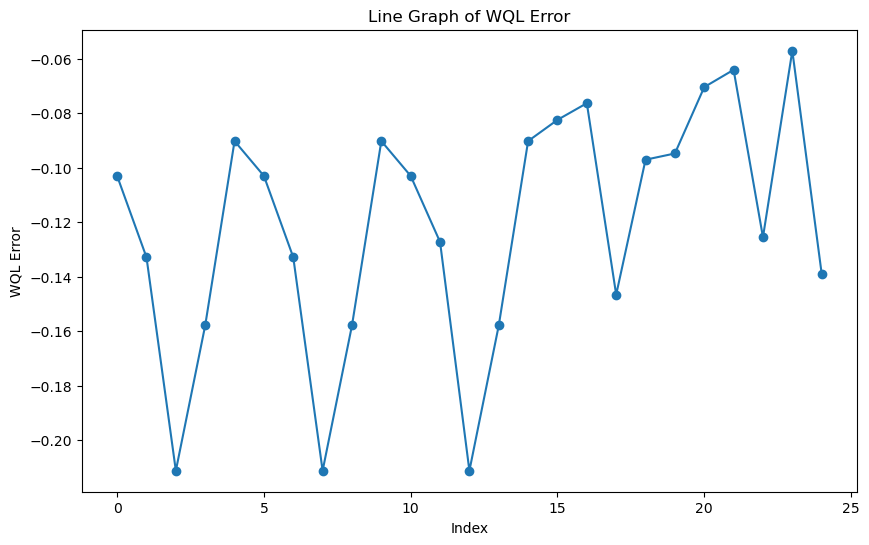

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(errors_M_Demography["WQL_error"].values, marker='o', linestyle='-')
plt.xlabel("Index")
plt.ylabel("WQL Error")
plt.title("Line Graph of WQL Error")
plt.show()

According to this graph it is possible to observe that the worst WQL result is even better than the worst result from the daily dataset and the closer are the train size and test size, the better are the error. 

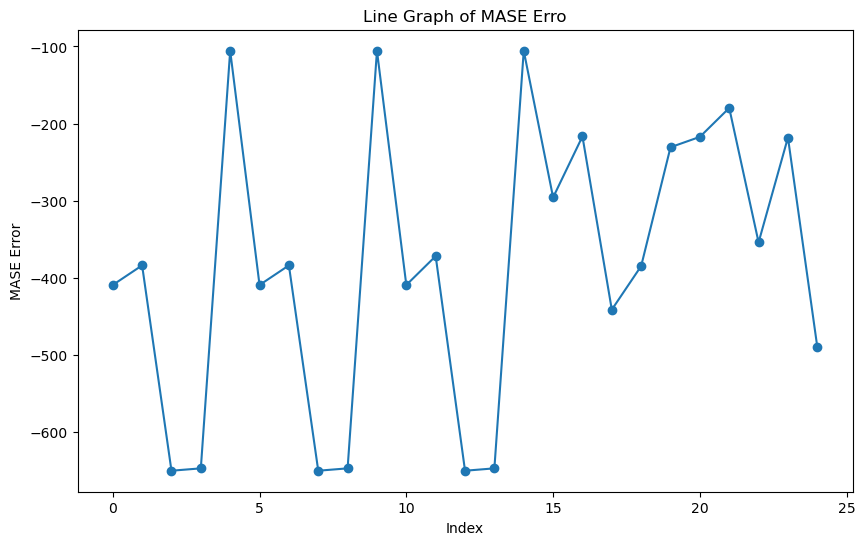

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(errors_M_Demography["MASE_error"].values, marker='o', linestyle='-')
plt.xlabel("Index")
plt.ylabel("MASE Error")
plt.title("Line Graph of MASE Erro")
plt.show()

As we can observe in this graph the MASE oscilates into bigger error values than from the daily dataset and the behaviour of the best errors with the split closer to the current day is still representative. 

### Yearly data

In [ ]:
#Take the first value of each year
df_Demography_yearly = df_Demography_1.resample('YS').first().sort_index(ascending=True)

In [ ]:
df_Demography_yearly.head()


item_id           timestamp  target
timestamp                                      
2000-01-01  T001611 2000-03-01 12:00:00  253.77
2001-01-01  T001611 2001-01-01 12:00:00  433.52
2002-01-01  T001611 2002-01-01 12:00:00  308.19
2003-01-01  T001611 2003-01-01 12:00:00  346.30
2004-01-01  T001611 2004-01-01 12:00:00  446.12

In [ ]:
len(df_Demography_yearly)  #Small dataset

13

In [ ]:
df_Demography_yearly.index = pd.to_datetime(df_Demography_yearly.index).normalize()

In [ ]:
df_Demography_yearly.dtypes

item_id      string[python]
timestamp    datetime64[ns]
target              float64
dtype: object

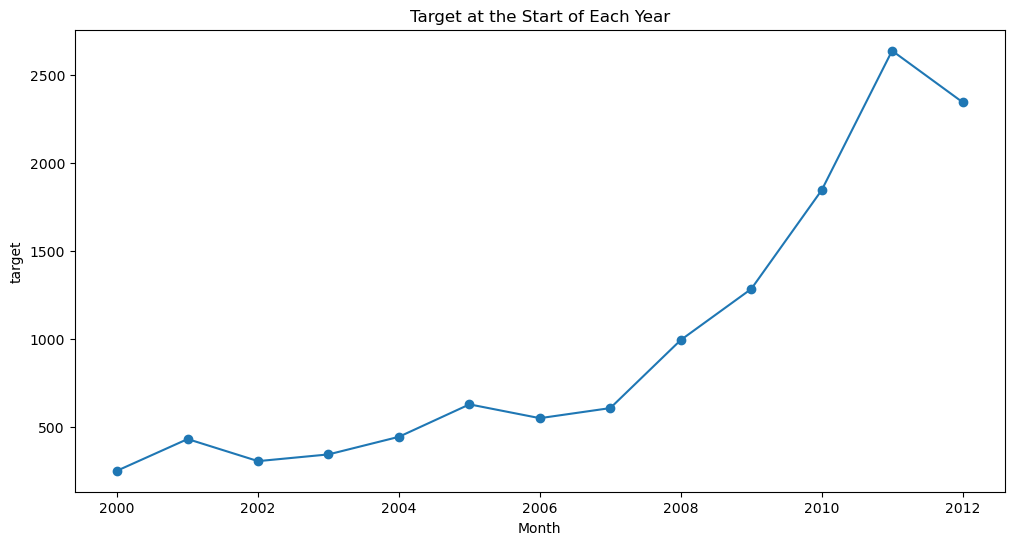

In [ ]:
ts = df_Demography_yearly                   # shorthand
x  = ts.index.get_level_values('timestamp')   # just the dates
y  = ts['target'].values                     # the values

plt.figure(figsize=(12, 6))
plt.plot(x, y, marker='o')
plt.title("Target at the Start of Each Year")
plt.xlabel("Month")
plt.ylabel("target")
plt.show()


In [ ]:
errors_Y_industry=get_errors_yr(df_Demography_yearly, frequ="B")

---------data len 13


Empty DataFrame
Columns: [Train_size, Percentage_train, Test_size, Percentage_test, MASE_error, Diference_MASE, WQL_error, Diference_WQL]
Index: []

Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180510'
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180510'


=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.80 GB / 7.37 GB (10.8%)
Disk Space Avail:   5.59 GB / 475.75 GB (1.2%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'B',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 3,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}


Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq':

----------historical length 10
-----------history len, min and max 10 ('T001611', Timestamp('2000-03-01 12:00:00')) ('T001611', Timestamp('2009-01-01 12:00:00'))


Provided train_data has 2307 rows (NaN fraction=99.6%), 1 time series. Median time series length is 2307 (min=2307, max=2307). 

Provided data contains following columns:
	target: 'target'

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 20:05:10

Starting training. Start time is 2025-07-11 20:05:10
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01   

---------beginning 0
---------total_length 13
----------training len 10
----------training                               target
item_id timestamp                   
T001611 2008-01-01 12:00:00   995.21
        2009-01-01 12:00:00  1285.49
----------testing len 13
----------testtt                               target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
        2011-01-01 12:00:00  2637.24
        2012-01-01 12:00:00  2345.56
-----------len predictions 3
-----------len predictions 3


mean          0.1          0.2  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1355.553711  1109.305786  1209.303955   
        2011-01-01 12:00:00  1313.496582  1000.281616  1136.942749   
        2012-01-01 12:00:00  1289.285889   923.718262  1077.733398   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1268.980469  1316.067383  1355.553711   
        2011-01-01 12:00:00  1209.706909  1266.416138  1313.496582   
        2012-01-01 12:00:00  1168.723145  1234.380737  1289.285889   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1396.694824  1444.426147  1503.950439   
        2011-01-01 12:00:00  1359.654053  1410.977051  1475.537964   
        2012-01-01 12:00:00  1342.990967  1400.204590  1473.027588   

                                     0.9  
item_id timestamp                         
T001611 2010-01-01 12:00:00  1608.971924  
        2011-01-01 12:00:00  1596.088623  
        2012-01-01 12:00:00  1605.952148

---len test slide 13


target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
        2011-01-01 12:00:00  2637.24
        2012-01-01 12:00:00  2345.56

data with frequency 'IRREG' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'IRREG' has been resampled to frequency 'B'.
data with frequency 'IRREG' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180517'
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180517'
=================== System Info ===================
AutoGluon Version:  1.3.1
P

----------prediction_length 2
-----------history len, min and max 10 ('T001611', Timestamp('2000-03-01 12:00:00')) ('T001611', Timestamp('2009-01-01 12:00:00'))



Provided data contains following columns:
	target: 'target'
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 20:05:17

Starting training. Start time is 2025-07-11 20:05:17
Models that will be trained: ['Chronos[bolt_small]']
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
Training timeseries model Chronos[bolt_small]. 
	0.00    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
	0.00    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_sm

---------beginning 0
---------total_length 12
----------training len 10
----------training                               target
item_id timestamp                   
T001611 2008-01-01 12:00:00   995.21
        2009-01-01 12:00:00  1285.49
----------testing len 12
----------testtt                               target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
        2011-01-01 12:00:00  2637.24
-----------len predictions 2
-----------len predictions 2


mean          0.1          0.2  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1355.553711  1109.305786  1209.303955   
        2011-01-01 12:00:00  1313.496582  1000.281616  1136.942749   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1268.980469  1316.067383  1355.553711   
        2011-01-01 12:00:00  1209.706909  1266.416138  1313.496582   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1396.694824  1444.426147  1503.950439   
        2011-01-01 12:00:00  1359.654053  1410.977051  1475.537964   

                                     0.9  
item_id timestamp                         
T001611 2010-01-01 12:00:00  1608.971924  
        2011-01-01 12:00:00  1596.088623

---len test slide 12


target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
        2011-01-01 12:00:00  2637.24

data with frequency 'IRREG' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'IRREG' has been resampled to frequency 'B'.
data with frequency 'IRREG' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180524'
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180524'
=================== System Info ===================
AutoGluon Version:  1.3.1
P

----------prediction_length 1
-----------history len, min and max 10 ('T001611', Timestamp('2000-03-01 12:00:00')) ('T001611', Timestamp('2009-01-01 12:00:00'))



Provided data contains following columns:
	target: 'target'
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 20:05:24

Starting training. Start time is 2025-07-11 20:05:24
Models that will be trained: ['Chronos[bolt_small]']
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.07 s
Training complete. Models trai

---------beginning 0
---------total_length 11
----------training len 10
----------training                               target
item_id timestamp                   
T001611 2008-01-01 12:00:00   995.21
        2009-01-01 12:00:00  1285.49
----------testing len 11
----------testtt                               target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
-----------len predictions 1
-----------len predictions 1


mean          0.1          0.2  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1355.553711  1109.305786  1209.303955   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1268.980469  1316.067383  1355.553711   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1396.694824  1444.426147  1503.950439   

                                     0.9  
item_id timestamp                         
T001611 2010-01-01 12:00:00  1608.971924

---len test slide 11


target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88

data with frequency 'IRREG' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'IRREG' has been resampled to frequency 'B'.
data with frequency 'IRREG' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180531'
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180531'
=================== System Info ===================
AutoGluon Version:  1.3.1
P

----------prediction_length 0
----------historical length 10
-----------history len, min and max 10 ('T001611', Timestamp('2000-03-01 12:00:00')) ('T001611', Timestamp('2009-01-01 12:00:00'))


Provided train_data has 2307 rows (NaN fraction=99.6%), 1 time series. Median time series length is 2307 (min=2307, max=2307). 

Provided data contains following columns:
	target: 'target'

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 20:05:31

Starting training. Start time is 2025-07-11 20:05:31
Models that will be trained: ['Chronos[bolt_small]']
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
Training timeseries model Chronos[bolt_small]. 
	0.01   

---------beginning 0
---------total_length 13
----------training len 10
----------training                               target
item_id timestamp                   
T001611 2008-01-01 12:00:00   995.21
        2009-01-01 12:00:00  1285.49
----------testing len 13
----------testtt                               target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
        2011-01-01 12:00:00  2637.24
        2012-01-01 12:00:00  2345.56
-----------len predictions 3
-----------len predictions 3


mean          0.1          0.2  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1355.553711  1109.305786  1209.303955   
        2011-01-01 12:00:00  1313.496582  1000.281616  1136.942749   
        2012-01-01 12:00:00  1289.285889   923.718262  1077.733398   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1268.980469  1316.067383  1355.553711   
        2011-01-01 12:00:00  1209.706909  1266.416138  1313.496582   
        2012-01-01 12:00:00  1168.723145  1234.380737  1289.285889   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1396.694824  1444.426147  1503.950439   
        2011-01-01 12:00:00  1359.654053  1410.977051  1475.537964   
        2012-01-01 12:00:00  1342.990967  1400.204590  1473.027588   

                                     0.9  
item_id timestamp                         
T001611 2010-01-01 12:00:00  1608.971924  
        2011-01-01 12:00:00  1596.088623  
        2012-01-01 12:00:00  1605.952148

---len test slide 13


target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
        2011-01-01 12:00:00  2637.24
        2012-01-01 12:00:00  2345.56

data with frequency 'IRREG' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'IRREG' has been resampled to frequency 'B'.
data with frequency 'IRREG' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180538'
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180538'
=================== System Info ===================
AutoGluon Version:  1.3.1
P

----------prediction_length 2
-----------history len, min and max 10 ('T001611', Timestamp('2000-03-01 12:00:00')) ('T001611', Timestamp('2009-01-01 12:00:00'))


	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 20:05:38

Starting training. Start time is 2025-07-11 20:05:38
Models that will be trained: ['Chronos[bolt_small]']
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
Training timeseries model Chronos[bolt_small]. 
	0.02    s     = Training runtime
	0.02    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.12 s
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.12 s
Best model

---------beginning 0
---------total_length 12
----------training len 10
----------training                               target
item_id timestamp                   
T001611 2008-01-01 12:00:00   995.21
        2009-01-01 12:00:00  1285.49
----------testing len 12
----------testtt                               target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
        2011-01-01 12:00:00  2637.24
-----------len predictions 2
-----------len predictions 2


mean          0.1          0.2  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1355.553711  1109.305786  1209.303955   
        2011-01-01 12:00:00  1313.496582  1000.281616  1136.942749   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1268.980469  1316.067383  1355.553711   
        2011-01-01 12:00:00  1209.706909  1266.416138  1313.496582   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1396.694824  1444.426147  1503.950439   
        2011-01-01 12:00:00  1359.654053  1410.977051  1475.537964   

                                     0.9  
item_id timestamp                         
T001611 2010-01-01 12:00:00  1608.971924  
        2011-01-01 12:00:00  1596.088623

---len test slide 12


target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
        2011-01-01 12:00:00  2637.24

data with frequency 'IRREG' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'IRREG' has been resampled to frequency 'B'.
data with frequency 'IRREG' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180544'
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180544'
=================== System Info ===================
AutoGluon Version:  1.3.1
P

----------prediction_length 1
-----------history len, min and max 10 ('T001611', Timestamp('2000-03-01 12:00:00')) ('T001611', Timestamp('2009-01-01 12:00:00'))


	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 20:05:45

Starting training. Start time is 2025-07-11 20:05:45
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.07 s
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.07 s
Best model

---------beginning 0
---------total_length 11
----------training len 10
----------training                               target
item_id timestamp                   
T001611 2008-01-01 12:00:00   995.21
        2009-01-01 12:00:00  1285.49
----------testing len 11
----------testtt                               target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
-----------len predictions 1
-----------len predictions 1


mean          0.1          0.2  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1355.553711  1109.305786  1209.303955   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1268.980469  1316.067383  1355.553711   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1396.694824  1444.426147  1503.950439   

                                     0.9  
item_id timestamp                         
T001611 2010-01-01 12:00:00  1608.971924

---len test slide 11


target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88

data with frequency 'IRREG' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'IRREG' has been resampled to frequency 'B'.
data with frequency 'IRREG' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180553'
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180553'
=================== System Info ===================
AutoGluon Version:  1.3.1
P

----------prediction_length 0
----------historical length 8
-----------history len, min and max 8 ('T001611', Timestamp('2002-01-01 12:00:00')) ('T001611', Timestamp('2009-01-01 12:00:00'))


train_data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Provided train_data has 1828 rows (NaN fraction=99.6%), 1 time series. Median time series length is 1828 (min=1828, max=1828). 

Provided data contains following columns:
Provided train_data has 1828 rows (NaN fraction=99.6%), 1 time series. Median time series length is 1828 (min=1828, max=1828). 

Provided data contains following columns:
	target: 'target'
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 20:05:53
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 20:05:53
Models tha

---------beginning 2
---------total_length 13
----------training len 8
----------training                               target
item_id timestamp                   
T001611 2008-01-01 12:00:00   995.21
        2009-01-01 12:00:00  1285.49
----------testing len 11
----------testtt                               target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
        2011-01-01 12:00:00  2637.24
        2012-01-01 12:00:00  2345.56
-----------len predictions 3
-----------len predictions 3


mean          0.1          0.2  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1355.553833  1109.305908  1209.303955   
        2011-01-01 12:00:00  1313.496582  1000.281738  1136.942749   
        2012-01-01 12:00:00  1289.285889   923.718323  1077.733398   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1268.980469  1316.067383  1355.553833   
        2011-01-01 12:00:00  1209.707031  1266.416260  1313.496582   
        2012-01-01 12:00:00  1168.723267  1234.380737  1289.285889   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1396.694824  1444.426025  1503.950439   
        2011-01-01 12:00:00  1359.654297  1410.977051  1475.537842   
        2012-01-01 12:00:00  1342.990967  1400.204590  1473.027588   

                                     0.9  
item_id timestamp                         
T001611 2010-01-01 12:00:00  1608.971924  
        2011-01-01 12:00:00  1596.088745  
        2012-01-01 12:00:00  1605.952026

---len test slide 11


target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
        2011-01-01 12:00:00  2637.24
        2012-01-01 12:00:00  2345.56

data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'YS-JAN' has been resampled to frequency 'B'.
data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180602'
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180602'
=================== System Info ===================
AutoGluon Version:  1.3.

----------prediction_length 2
-----------history len, min and max 8 ('T001611', Timestamp('2002-01-01 12:00:00')) ('T001611', Timestamp('2009-01-01 12:00:00'))


Provided train_data has 1828 rows (NaN fraction=99.6%), 1 time series. Median time series length is 1828 (min=1828, max=1828). 

Provided data contains following columns:
	target: 'target'

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 20:06:03

Starting training. Start time is 2025-07-11 20:06:03
Models that will be trained: ['Chronos[bolt_small]']
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
Training timeseries model Chronos[bolt_small]. 
	0.00   

---------beginning 2
---------total_length 12
----------training len 8
----------training                               target
item_id timestamp                   
T001611 2008-01-01 12:00:00   995.21
        2009-01-01 12:00:00  1285.49
----------testing len 10
----------testtt                               target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
        2011-01-01 12:00:00  2637.24
-----------len predictions 2
-----------len predictions 2


mean          0.1          0.2  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1355.553833  1109.305908  1209.303955   
        2011-01-01 12:00:00  1313.496582  1000.281738  1136.942749   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1268.980469  1316.067383  1355.553833   
        2011-01-01 12:00:00  1209.707031  1266.416260  1313.496582   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1396.694824  1444.426025  1503.950439   
        2011-01-01 12:00:00  1359.654297  1410.977051  1475.537842   

                                     0.9  
item_id timestamp                         
T001611 2010-01-01 12:00:00  1608.971924  
        2011-01-01 12:00:00  1596.088745

---len test slide 10


target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
        2011-01-01 12:00:00  2637.24

data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'YS-JAN' has been resampled to frequency 'B'.
data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180610'
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180610'
=================== System Info ===================
AutoGluon Version:  1.3.

----------prediction_length 1
-----------history len, min and max 8 ('T001611', Timestamp('2002-01-01 12:00:00')) ('T001611', Timestamp('2009-01-01 12:00:00'))


Provided train_data has 1828 rows (NaN fraction=99.6%), 1 time series. Median time series length is 1828 (min=1828, max=1828). 

Provided data contains following columns:
	target: 'target'

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 20:06:11

Starting training. Start time is 2025-07-11 20:06:11
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.00   

---------beginning 2
---------total_length 11
----------training len 8
----------training                               target
item_id timestamp                   
T001611 2008-01-01 12:00:00   995.21
        2009-01-01 12:00:00  1285.49
----------testing len 9
----------testtt                               target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
-----------len predictions 1
-----------len predictions 1


mean          0.1          0.2  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1355.553833  1109.305908  1209.303955   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1268.980469  1316.067383  1355.553833   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1396.694824  1444.426025  1503.950439   

                                     0.9  
item_id timestamp                         
T001611 2010-01-01 12:00:00  1608.971924

---len test slide 9


target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88

data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'YS-JAN' has been resampled to frequency 'B'.
data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180617'
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180617'
=================== System Info ===================
AutoGluon Version:  1.3.

----------prediction_length 0
----------historical length 5
-----------history len, min and max 5 ('T001611', Timestamp('2005-01-01 12:00:00')) ('T001611', Timestamp('2009-01-01 12:00:00'))



Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 20:06:17

Starting training. Start time is 2025-07-11 20:06:17
Models that will be trained: ['Chronos[bolt_small]']
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
Training timeseries model Chronos[bolt_small]. 
	0.00    s     = Training runtime
	0.00    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Training complete. Models trained: ['Chronos[bolt_sm

---------beginning 5
---------total_length 13
----------training len 5
----------training                               target
item_id timestamp                   
T001611 2008-01-01 12:00:00   995.21
        2009-01-01 12:00:00  1285.49
----------testing len 8
----------testtt                               target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
        2011-01-01 12:00:00  2637.24
        2012-01-01 12:00:00  2345.56
-----------len predictions 3
-----------len predictions 3


mean          0.1          0.2  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1342.787598  1119.539307  1213.054077   
        2011-01-01 12:00:00  1308.059082  1019.162598  1147.202637   
        2012-01-01 12:00:00  1289.972534   950.838501  1095.485718   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1267.159912  1308.593994  1342.787598   
        2011-01-01 12:00:00  1214.640747  1266.196411  1308.059082   
        2012-01-01 12:00:00  1180.120972  1240.247803  1289.972534   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1378.131714  1418.687134  1469.095825   
        2011-01-01 12:00:00  1348.815552  1393.828979  1450.041504   
        2012-01-01 12:00:00  1337.817993  1388.408203  1452.263062   

                                     0.9  
item_id timestamp                         
T001611 2010-01-01 12:00:00  1559.599365  
        2011-01-01 12:00:00  1556.044067  
        2012-01-01 12:00:00  1571.939697

---len test slide 8


target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
        2011-01-01 12:00:00  2637.24
        2012-01-01 12:00:00  2345.56

data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'YS-JAN' has been resampled to frequency 'B'.
data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180624'
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180624'
=================== System Info ===================
AutoGluon Version:  1.3.

----------prediction_length 2
-----------history len, min and max 5 ('T001611', Timestamp('2005-01-01 12:00:00')) ('T001611', Timestamp('2009-01-01 12:00:00'))


	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 20:06:25

Starting training. Start time is 2025-07-11 20:06:25
Models that will be trained: ['Chronos[bolt_small]']
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
Training timeseries model Chronos[bolt_small]. 
	0.00    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
	0.00    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.09 s
Total runtime: 0.09 s
Best model

---------beginning 5
---------total_length 12
----------training len 5
----------training                               target
item_id timestamp                   
T001611 2008-01-01 12:00:00   995.21
        2009-01-01 12:00:00  1285.49
----------testing len 7
----------testtt                               target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
        2011-01-01 12:00:00  2637.24
-----------len predictions 2
-----------len predictions 2


mean          0.1          0.2  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1342.787598  1119.539307  1213.054077   
        2011-01-01 12:00:00  1308.059082  1019.162598  1147.202637   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1267.159912  1308.593994  1342.787598   
        2011-01-01 12:00:00  1214.640747  1266.196411  1308.059082   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1378.131714  1418.687134  1469.095825   
        2011-01-01 12:00:00  1348.815552  1393.828979  1450.041504   

                                     0.9  
item_id timestamp                         
T001611 2010-01-01 12:00:00  1559.599365  
        2011-01-01 12:00:00  1556.044067

---len test slide 7


target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
        2011-01-01 12:00:00  2637.24

data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'YS-JAN' has been resampled to frequency 'B'.
data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180633'
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180633'
=================== System Info ===================
AutoGluon Version:  1.3.

----------prediction_length 1
-----------history len, min and max 5 ('T001611', Timestamp('2005-01-01 12:00:00')) ('T001611', Timestamp('2009-01-01 12:00:00'))


	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 20:06:33

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 20:06:33
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.00    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
	0.00    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.08 s
Best model: Chronos[bolt_small]


---------beginning 5
---------total_length 11
----------training len 5
----------training                               target
item_id timestamp                   
T001611 2008-01-01 12:00:00   995.21
        2009-01-01 12:00:00  1285.49
----------testing len 6
----------testtt                               target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
-----------len predictions 1
-----------len predictions 1


mean          0.1          0.2  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1342.787598  1119.539307  1213.054077   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1267.159912  1308.593994  1342.787598   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1378.131714  1418.687134  1469.095825   

                                     0.9  
item_id timestamp                         
T001611 2010-01-01 12:00:00  1559.599365

---len test slide 6


target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88

data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'YS-JAN' has been resampled to frequency 'B'.
data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180639'
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180639'
=================== System Info ===================
AutoGluon Version:  1.3.

----------prediction_length 0
----------historical length 2
-----------history len, min and max 2 ('T001611', Timestamp('2008-01-01 12:00:00')) ('T001611', Timestamp('2009-01-01 12:00:00'))


Provided train_data has 263 rows (NaN fraction=99.2%), 1 time series. Median time series length is 263 (min=263, max=263). 

Provided data contains following columns:
	target: 'target'

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 20:06:40
Models that will be trained: ['Chronos[bolt_small]']

Starting training. Start time is 2025-07-11 20:06:40
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
Training timeseries model Chronos[bolt_small]. 
	0.01    s  

---------beginning 8
---------total_length 13
----------training len 2
----------training                               target
item_id timestamp                   
T001611 2008-01-01 12:00:00   995.21
        2009-01-01 12:00:00  1285.49
----------testing len 5
----------testtt                               target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
        2011-01-01 12:00:00  2637.24
        2012-01-01 12:00:00  2345.56
-----------len predictions 3
-----------len predictions 3


mean          0.1          0.2  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1269.632812  1108.477905  1175.323975   
        2011-01-01 12:00:00  1250.302734  1050.704346  1132.433105   
        2012-01-01 12:00:00  1244.565796  1012.797241  1105.565186   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1214.161011  1244.271118  1269.632812   
        2011-01-01 12:00:00  1180.189453  1217.609497  1250.302734   
        2012-01-01 12:00:00  1162.456299  1205.778564  1244.565796   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1296.027466  1325.913086  1363.510620   
        2011-01-01 12:00:00  1282.151978  1319.669800  1367.342407   
        2012-01-01 12:00:00  1283.366211  1326.924561  1383.891968   

                                     0.9  
item_id timestamp                         
T001611 2010-01-01 12:00:00  1433.404297  
        2011-01-01 12:00:00  1457.829712  
        2012-01-01 12:00:00  1491.895874

---len test slide 5


target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
        2011-01-01 12:00:00  2637.24
        2012-01-01 12:00:00  2345.56

data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'YS-JAN' has been resampled to frequency 'B'.
data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180646'
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180646'
=================== System Info ===================
AutoGluon Version:  1.3.

----------prediction_length 2
-----------history len, min and max 2 ('T001611', Timestamp('2008-01-01 12:00:00')) ('T001611', Timestamp('2009-01-01 12:00:00'))


	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-07-11 20:06:47

Starting training. Start time is 2025-07-11 20:06:47
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.02    s     = Training runtime
	0.02    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.11 s
Total runtime: 0.11 s
Best model: Chronos[bolt_small]
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180647'
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\Autogl

---------beginning 8
---------total_length 12
----------training len 2
----------training                               target
item_id timestamp                   
T001611 2008-01-01 12:00:00   995.21
        2009-01-01 12:00:00  1285.49
----------testing len 4
----------testtt                               target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
        2011-01-01 12:00:00  2637.24
-----------len predictions 2
-----------len predictions 2


mean          0.1          0.2  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1269.632812  1108.477905  1175.323975   
        2011-01-01 12:00:00  1250.302734  1050.704346  1132.433105   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1214.161011  1244.271118  1269.632812   
        2011-01-01 12:00:00  1180.189453  1217.609497  1250.302734   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1296.027466  1325.913086  1363.510620   
        2011-01-01 12:00:00  1282.151978  1319.669800  1367.342407   

                                     0.9  
item_id timestamp                         
T001611 2010-01-01 12:00:00  1433.404297  
        2011-01-01 12:00:00  1457.829712

---len test slide 4


target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
        2011-01-01 12:00:00  2637.24

data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'YS-JAN' has been resampled to frequency 'B'.
data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180654'
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180654'
=================== System Info ===================
AutoGluon Version:  1.3.

----------prediction_length 1
-----------history len, min and max 2 ('T001611', Timestamp('2008-01-01 12:00:00')) ('T001611', Timestamp('2009-01-01 12:00:00'))



Starting training. Start time is 2025-07-11 20:06:54
Models that will be trained: ['Chronos[bolt_small]']

Starting training. Start time is 2025-07-11 20:06:54
Models that will be trained: ['Chronos[bolt_small]']
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training timeseries model Chronos[bolt_small]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_small]']
Training complete. Models trained: ['Chronos[bolt_small]']
Total runtime: 0.08 s
Best model: Chronos[bolt_small]
Total runtime: 0.08 s
Best model: Chronos[bolt_small]
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180654-001'
Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250711_180654-001'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11

---------beginning 8
---------total_length 11
----------training len 2
----------training                               target
item_id timestamp                   
T001611 2008-01-01 12:00:00   995.21
        2009-01-01 12:00:00  1285.49
----------testing len 3
----------testtt                               target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88
-----------len predictions 1
-----------len predictions 1


mean          0.1          0.2  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1269.632812  1108.477905  1175.323975   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T001611 2010-01-01 12:00:00  1214.161011  1244.271118  1269.632812   

                                     0.6          0.7         0.8          0.9  
item_id timestamp                                                               
T001611 2010-01-01 12:00:00  1296.027466  1325.913086  1363.51062  1433.404297

---len test slide 3


target
item_id timestamp                   
T001611 2010-01-01 12:00:00  1845.88

data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'YS-JAN' has been resampled to frequency 'B'.
data with frequency 'YS-JAN' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]


----------prediction_length 0


In [ ]:
errors_Y_industry

Train_size Percentage_train Test_size Percentage_test   MASE_error  \
0          10             100%         3              0% -1365.763064   
1          10             100%         2            100% -1820.696604   
2          10             100%         1            200% -1173.571772   
3          10            95.0%         3              0% -1365.763064   
4          10            95.0%         2            100% -1820.696604   
5          10            95.0%         1            200% -1173.571772   
6           8            75.0%         3              0% -1365.763064   
7           8            75.0%         2            100% -1820.696604   
8           8            75.0%         1            200% -1173.571772   
9           5            50.0%         3              0% -1365.763125   
10          5            50.0%         2            100% -1756.099863   
11          5            50.0%         1            200% -1134.882747   
12          2            25.0%         3              0% -1129.272158   
13          2            25.0%         2            100% -1382.412729   
14          2            25.0%         1            200%  -697.494624   

   Diference_MASE WQL_error Diference_WQL  
0               0 -0.384268             0  
1       454.93354 -0.536027      0.151759  
2      647.124832 -0.511727      0.024299  
3      192.191292 -0.384268       0.12746  
4       454.93354 -0.536027      0.151759  
5      647.124832 -0.511727      0.024299  
6      192.191292 -0.384268       0.12746  
7       454.93354 -0.536027      0.151759  
8      647.124832 -0.511727      0.024299  
9      192.191353 -0.384268       0.12746  
10     390.336738 -0.506044      0.121777  
11     621.217117 -0.490069      0.015975  
12       5.610588 -0.312157      0.177912  
13     253.140571 -0.407207       0.09505  
14     684.918105 -0.312455      0.094752

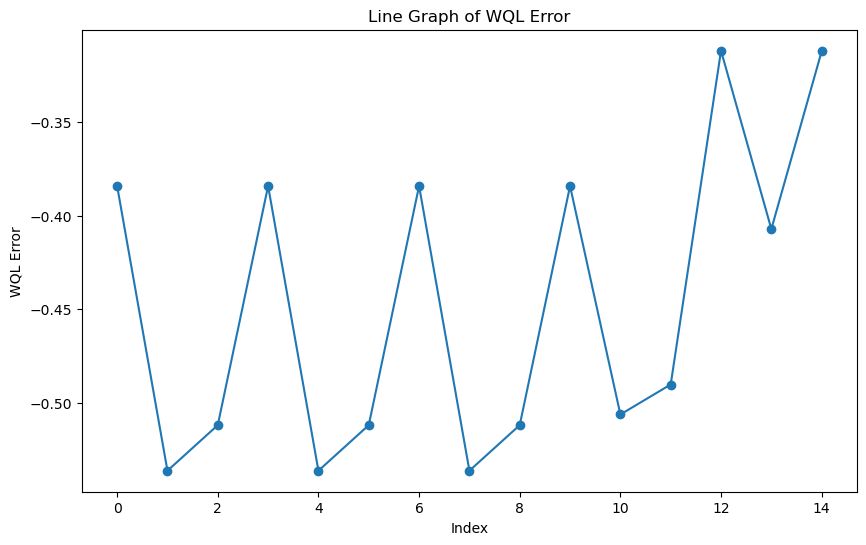

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(errors_Y_industry["WQL_error"].values, marker='o', linestyle='-')
plt.xlabel("Index")
plt.ylabel("WQL Error")
plt.title("Line Graph of WQL Error")
plt.show()

As we can observe in this graph, the errors are worst than the monthly dataset but it also can be because of the small quanitty of the raining set used. 

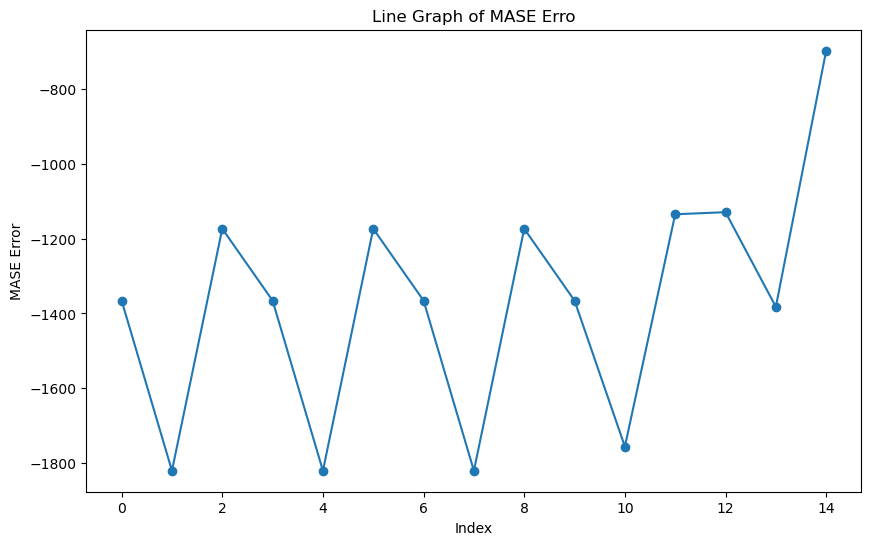

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(errors_Y_industry["MASE_error"].values, marker='o', linestyle='-')
plt.xlabel("Index")
plt.ylabel("MASE Error")
plt.title("Line Graph of MASE Erro")
plt.show()

From this image it is possible to observe that the MASE error get worst results but it improves when the data is closer to the current date. 